In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import xgboost as xgb
import lightgbm as lgbm
from sklearn.metrics import *
import math
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
import sklearn.metrics
import math
from pathlib import Path
from warnings import filterwarnings
import joblib
filterwarnings('ignore')

/home/arma/miniforge3/envs/teachopencadd/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
# Set path to this notebook
HERE = Path(_dh[-1])
#inputFile = Path(HERE).resolve().parents[0] /"Selectivity/input"
HDAC6 = Path(HERE).resolve().parents[0] / "BioactivityModels/HDAC6"
HDAC1 = Path(HERE).resolve().parents[0] / "BioactivityModels/HDAC1"
HDAC1and6 = Path(HERE).resolve().parents[0] / "SelectivityModels"

In [3]:
hdac1and6 = pd.read_pickle(HDAC1and6/"input/HDAC1and6_SemiSel_1024B.csv")
hdac1and6.reset_index(inplace=True)
hdac1and6.drop('index', axis=1, inplace=True)
hdac1and6.head(5)

,molecule_chembl_id,fp_MACCS,fp_Morgan3,fp_MorganF,fp_MAP4,SelectivityWindow
0,CHEMBL4098975,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, ...","[2770663, 83582, 137380, 5467685, 28861, 20399...",2.89
1,CHEMBL3912061,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[5976924, 3913535, 4142580, 576166, 5215404, 6...",3.56
2,CHEMBL4243347,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, ...","[6411541, 3821889, 137380, 4236434, 7332227, 2...",1.00
3,CHEMBL4247128,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, ...","[3808044, 3821889, 137380, 2385390, 6940687, 2...",2.52
4,CHEMBL4126811,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, ...","[4928228, 22758228, 8033062, 10725227, 1087409...",3.12


In [4]:
hdac1and6_labeled = pd.read_csv(HDAC1and6/"input/HDAC1and6_SemiSel_dataset.csv",)
hdac1and6_labeled.rename({"ChEMBL ID": "molecule_chembl_id"}, axis=1, inplace=True)
hdac1and6_labeled.rename({"pChEMBL_HDAC1": "pActivity_HDAC1"}, axis=1, inplace=True)
hdac1and6_labeled.rename({"pChEMBL_HDAC6": "pActivity_HDAC6"}, axis=1, inplace=True)
hdac1and6_labeled = hdac1and6_labeled[['molecule_chembl_id','pActivity_HDAC1', 'pActivity_HDAC6', 'label' ]]
hdac1and6_labeled.head(5)

,molecule_chembl_id,pActivity_HDAC1,pActivity_HDAC6,label
0,CHEMBL4098975,6.96,9.85,HDAC6-selective
1,CHEMBL3912061,6.21,9.77,HDAC6-selective
2,CHEMBL4243347,8.70,9.70,Dual-binder
3,CHEMBL4247128,7.08,9.60,HDAC6-selective
4,CHEMBL4126811,6.36,9.48,HDAC6-selective


In [5]:
hdac1and6 = pd.merge(hdac1and6, hdac1and6_labeled, on="molecule_chembl_id",)
hdac1and6.head(5)

,molecule_chembl_id,fp_MACCS,fp_Morgan3,fp_MorganF,fp_MAP4,SelectivityWindow,pActivity_HDAC1,pActivity_HDAC6,label
0,CHEMBL4098975,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, ...","[2770663, 83582, 137380, 5467685, 28861, 20399...",2.89,6.96,9.85,HDAC6-selective
1,CHEMBL3912061,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[5976924, 3913535, 4142580, 576166, 5215404, 6...",3.56,6.21,9.77,HDAC6-selective
2,CHEMBL4243347,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, ...","[6411541, 3821889, 137380, 4236434, 7332227, 2...",1.00,8.70,9.70,Dual-binder
3,CHEMBL4247128,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, ...","[3808044, 3821889, 137380, 2385390, 6940687, 2...",2.52,7.08,9.60,HDAC6-selective
4,CHEMBL4126811,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, ...","[4928228, 22758228, 8033062, 10725227, 1087409...",3.12,6.36,9.48,HDAC6-selective


In [6]:
hdac1and6['Class'] = np.zeros(len(hdac1and6))

hdac1and6.loc[hdac1and6[hdac1and6.label == 'HDAC1-selective'].index, "Class"] = 1.0
hdac1and6.loc[hdac1and6[hdac1and6.label == 'HDAC6-selective'].index, "Class"] = 2.0
hdac1and6.loc[hdac1and6[hdac1and6.label == 'Dual-binder'].index, "Class"] = 3.0
hdac1and6.loc[hdac1and6[hdac1and6.label == 'Non-binder'].index, "Class"] = 4.0
hdac1and6.loc[hdac1and6[hdac1and6.label == 'Semi-selective'].index, "Class"] = 5.0

hdac1and6.head(4)

,molecule_chembl_id,fp_MACCS,fp_Morgan3,fp_MorganF,fp_MAP4,SelectivityWindow,pActivity_HDAC1,pActivity_HDAC6,label,Class
0,CHEMBL4098975,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, ...","[2770663, 83582, 137380, 5467685, 28861, 20399...",2.89,6.96,9.85,HDAC6-selective,2.0
1,CHEMBL3912061,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[5976924, 3913535, 4142580, 576166, 5215404, 6...",3.56,6.21,9.77,HDAC6-selective,2.0
2,CHEMBL4243347,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, ...","[6411541, 3821889, 137380, 4236434, 7332227, 2...",1.00,8.70,9.70,Dual-binder,3.0
3,CHEMBL4247128,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, ...","[3808044, 3821889, 137380, 2385390, 6940687, 2...",2.52,7.08,9.60,HDAC6-selective,2.0


In [7]:
hdac1and6[hdac1and6['label'] == 'Dual-binder']['SelectivityWindow'].min()

-1.0

## HDAC1 Regression Models

In [8]:
# Add a column for activity against HDAC6

hdac1and6["HDAC1activity"] = np.zeros(len(hdac1and6))

# Mark every molecule as active with an pIC50 of >= 6.3, 0 otherwise
hdac1and6.loc[hdac1and6[hdac1and6.pActivity_HDAC1 >= 6.6].index, "HDAC1activity"] = 1.0

# NBVAL_CHECK_OUTPUT
print("Number of active compounds:", int(hdac1and6.HDAC1activity.sum()))
print("Number of inactive compounds:", len(hdac1and6) - int(hdac1and6.HDAC1activity.sum()))

Number of active compounds: 894
Number of inactive compounds: 1016


In [9]:
#By using Morgan fingerprints with radius of 3 and 1025 bits
X_hdac1_reg = np.array(list((hdac1and6['fp_Morgan3']))).astype(float)
#X.shape
y_hdac1_reg = hdac1and6["pActivity_HDAC1"].values
y_hdac1_reg_cat = hdac1and6["HDAC1activity"].values
y_hdac1_reg_class = hdac1and6["Class"].values

In [10]:
#change to fit into these X values 


TP =np.empty(10)
TN = np.empty(10)
FP = np.empty(10)
FN = np.empty(10)


r2_scores_outer = []
Accuracy_outer = []
Precision_outer = [] #Also called Positive Predictive Value(PPV)
Sensitivity_outer = [] # Also called Recall or True Positive Rate (TPR)
Specificity_outer = [] #Also called selectivity or True Negative Rate  (TNR)
f1_scores_outer = []
f1_scores_W_outer = []
f1_scores_M_outer = []
BA_scores_outer = []
MCC_outer = []
NPV_outer = []
ROC_AUC_outer = []
data_rf=pd.DataFrame()

NUM_TRIALS = 5
random_state= [687266, 98656, 56, 280189, 76543] # 

for i in range(NUM_TRIALS):
    cv_change = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state[i])
    data_inner = pd.DataFrame({'y_test_idx': pd.Series(dtype='int'),
                   'y_test': pd.Series(dtype='float'),
                   'y_pred': pd.Series(dtype='float')})
    
    
    for idx, (train_idx, test_idx) in enumerate(cv_change.split(X_hdac1_reg, y_hdac1_reg_class)):
        X_train, X_test = X_hdac1_reg[train_idx], X_hdac1_reg[test_idx]
        y_train, y_test = y_hdac1_reg[train_idx], y_hdac1_reg[test_idx]
        eval_set = [(X_train, y_train), (X_test, y_test)]
        optimizedCV_rf = joblib.load(HDAC1/"models/Numeric/OUTPUT/optimizedCV_rf.joblib")
        optimizedCV_rf.fit(X_train,
                          y_train,)
        #print(test_idx)
        y_pred_optimized_rf = optimizedCV_rf.predict(X_test) 
        data_inner = data_inner.append(pd.DataFrame({'y_test_idx': test_idx, 'y_test': y_test, 'y_pred_rf': y_pred_optimized_rf } ), )
        data_inner.reset_index(inplace=True, drop=True) 
        data_inner.sort_values(by='y_test_idx', inplace=True) 
        
        y_test_cat = np.where((y_test>=6.6), 1, 0) 
        y_pred_optimized_rf_cat = np.where((y_pred_optimized_rf >= 6.6), 1, 0)
        
        conf_matrix = confusion_matrix(y_test_cat, y_pred_optimized_rf_cat)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        
        r2_scores_outer.append(r2_score(y_test, y_pred_optimized_rf))
        Accuracy_outer.append(accuracy_score(y_test_cat, y_pred_optimized_rf_cat))
        Precision_outer.append(precision_score(y_test_cat, y_pred_optimized_rf_cat))
        Sensitivity_outer.append(recall_score(y_test_cat, y_pred_optimized_rf_cat))
        Specificity_outer.append(round( TN[idx] / (TN[idx]+FP[idx]),4 ))
        f1_scores_outer.append(f1_score(y_test_cat, y_pred_optimized_rf_cat))
        f1_scores_W_outer.append(f1_score(y_test_cat, y_pred_optimized_rf_cat, average="weighted"))
        f1_scores_M_outer.append(f1_score(y_test_cat, y_pred_optimized_rf_cat, average="macro"))
        BA_scores_outer.append(balanced_accuracy_score(y_test_cat, y_pred_optimized_rf_cat))
        MCC_outer.append(matthews_corrcoef(y_test_cat, y_pred_optimized_rf_cat))
        NPV_outer.append(round( TN[idx] / (TN[idx]+FN[idx]),4 ))
        ROC_AUC_outer.append(roc_auc_score(y_test_cat, y_pred_optimized_rf_cat))
    data_rf['y_test_idx' + str(i)] = data_inner['y_test_idx']
    data_rf['y_test' + str(i)] = data_inner['y_test']
    data_rf['y_pred_rf' + str(i)] = data_inner['y_pred_rf']
   # data_rf['correct' + str(i)] = correct_value
   # data_rf['pred' + str(i)] = y_pred_optimized_rf

mat_met_optimized_rf = pd.DataFrame({'Metric':['R2','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores_outer), np.mean(Accuracy_outer),np.mean(Precision_outer),
                                           np.mean(Sensitivity_outer),np.mean(Specificity_outer),np.mean(f1_scores_outer),
                                           np.mean(f1_scores_W_outer), np.mean(f1_scores_M_outer), np.mean(BA_scores_outer), 
                                           np.mean(MCC_outer),np.mean(NPV_outer),np.mean(ROC_AUC_outer)],
                        'Value (std)': [np.std(r2_scores_outer, ddof=1), np.std(Accuracy_outer, ddof=1),np.std(Precision_outer, ddof=1),
                                        np.std(Sensitivity_outer,ddof=1),np.std(Specificity_outer,ddof=1),np.std(f1_scores_outer, ddof=1),
                                        np.std(f1_scores_W_outer, ddof=1),np.std(f1_scores_M_outer, ddof=1), np.std(BA_scores_outer, ddof=1), 
                                        np.std(MCC_outer, ddof=1),np.std(NPV_outer, ddof=1),np.std(ROC_AUC_outer, ddof=1)]
                       }) 


rf_hdac1_run0 = data_rf[['y_test_idx0', 'y_test0', 'y_pred_rf0']]
rf_hdac1_run0.sort_values(by='y_test_idx0', inplace=True)
rf_hdac1_run0.reset_index(inplace=True, drop=True)
rf_hdac1_run1 = data_rf[['y_test_idx1', 'y_test1', 'y_pred_rf1']]
rf_hdac1_run1.sort_values(by='y_test_idx1', inplace=True)
rf_hdac1_run1.reset_index(inplace=True, drop=True)
rf_hdac1_run2 = data_rf[['y_test_idx2', 'y_test2', 'y_pred_rf2']]
rf_hdac1_run2.sort_values(by='y_test_idx2', inplace=True)
rf_hdac1_run2.reset_index(inplace=True, drop=True)
rf_hdac1_run3 = data_rf[['y_test_idx3', 'y_test3', 'y_pred_rf3']]
rf_hdac1_run3.sort_values(by='y_test_idx3', inplace=True)
rf_hdac1_run3.reset_index(inplace=True, drop=True)
rf_hdac1_run4 = data_rf[['y_test_idx4', 'y_test4', 'y_pred_rf4']]
rf_hdac1_run4.sort_values(by='y_test_idx4', inplace=True)
rf_hdac1_run4.reset_index(inplace=True, drop=True)
chembl_id = hdac1and6['molecule_chembl_id']
rf_5preds_hdac1 = pd.concat([chembl_id, rf_hdac1_run0, rf_hdac1_run1, rf_hdac1_run2, rf_hdac1_run3, rf_hdac1_run4], axis=1)
rf_5preds_hdac1 = rf_5preds_hdac1[['molecule_chembl_id', 'y_test_idx0', 'y_test0', 'y_pred_rf0', 'y_pred_rf1', 'y_pred_rf2', 'y_pred_rf3', 'y_pred_rf4']]
rf_5preds_hdac1['y_pred_rf_ave'] = rf_5preds_hdac1.iloc[:,2:11].mean(axis='columns', numeric_only=True)
rf_5preds_hdac1['y_pred_rf_std'] = rf_5preds_hdac1.iloc[:,2:].std(axis='columns', numeric_only=True)



In [11]:
mat_met_optimized_rf

,Metric,Value (average),Value (std)
0,R2,0.671280,0.044525
1,Accuracy,0.844817,0.025270
2,Precision,0.832739,0.031286
3,Sensitivity,0.837632,0.041630
4,Specificity,0.851372,0.031548
5,F1 score,0.834489,0.027523
6,F1 score (weighted),0.844774,0.025320
7,F1 score (macro),0.844004,0.025373
8,Balanced Accuracy,0.844500,0.025735
9,MCC,0.689272,0.050917


In [12]:
#change to fit into these X values 

import joblib

TP =np.empty(10)
TN = np.empty(10)
FP = np.empty(10)
FN = np.empty(10)


r2_scores_outer = []
Accuracy_outer = []
Precision_outer = [] #Also called Positive Predictive Value(PPV)
Sensitivity_outer = [] # Also called Recall or True Positive Rate (TPR)
Specificity_outer = [] #Also called selectivity or True Negative Rate  (TNR)
f1_scores_outer = []
f1_scores_W_outer = []
f1_scores_M_outer = []
BA_scores_outer = []
MCC_outer = []
NPV_outer = []
ROC_AUC_outer = []
data_lgbm=pd.DataFrame()

NUM_TRIALS = 5
random_state= [687266, 98656, 56, 280189, 76543] # 

for i in range(NUM_TRIALS):
    cv_change = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state[i])
    data_inner = pd.DataFrame({'y_test_idx': pd.Series(dtype='int'),
                   'y_test': pd.Series(dtype='float'),
                   'y_pred': pd.Series(dtype='float')})
    
    
    for idx, (train_idx, test_idx) in enumerate(cv_change.split(X_hdac1_reg, y_hdac1_reg_class)):
        X_train, X_test = X_hdac1_reg[train_idx], X_hdac1_reg[test_idx]
        y_train, y_test = y_hdac1_reg[train_idx], y_hdac1_reg[test_idx]
        eval_set = [(X_train, y_train), (X_test, y_test)]
        optimizedCV_lgbm = joblib.load(HDAC1/"models/Numeric/OUTPUT/optimizedCV_lgbm.joblib")
        optimizedCV_lgbm.fit(X_train,
                          y_train,)
        #print(test_idx)
        y_pred_optimized_lgbm = optimizedCV_lgbm.predict(X_test) 
        data_inner = data_inner.append(pd.DataFrame({'y_test_idx': test_idx, 'y_test': y_test, 'y_pred_lgbm': y_pred_optimized_lgbm } ), )
        data_inner.reset_index(inplace=True, drop=True) 
        data_inner.sort_values(by='y_test_idx', inplace=True) 
        
        y_test_cat = np.where((y_test>=6.6), 1, 0) 
        y_pred_optimized_lgbm_cat = np.where((y_pred_optimized_lgbm >= 6.6), 1, 0)
        
        conf_matrix = confusion_matrix(y_test_cat, y_pred_optimized_lgbm_cat)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        
        r2_scores_outer.append(r2_score(y_test, y_pred_optimized_lgbm))
        Accuracy_outer.append(accuracy_score(y_test_cat, y_pred_optimized_lgbm_cat))
        Precision_outer.append(precision_score(y_test_cat, y_pred_optimized_lgbm_cat))
        Sensitivity_outer.append(recall_score(y_test_cat, y_pred_optimized_lgbm_cat))
        Specificity_outer.append(round( TN[idx] / (TN[idx]+FP[idx]),4 ))
        f1_scores_outer.append(f1_score(y_test_cat, y_pred_optimized_lgbm_cat))
        f1_scores_W_outer.append(f1_score(y_test_cat, y_pred_optimized_lgbm_cat, average="weighted"))
        f1_scores_M_outer.append(f1_score(y_test_cat, y_pred_optimized_lgbm_cat, average="macro"))
        BA_scores_outer.append(balanced_accuracy_score(y_test_cat, y_pred_optimized_lgbm_cat))
        MCC_outer.append(matthews_corrcoef(y_test_cat, y_pred_optimized_lgbm_cat))
        NPV_outer.append(round( TN[idx] / (TN[idx]+FN[idx]),4 ))
        ROC_AUC_outer.append(roc_auc_score(y_test_cat, y_pred_optimized_lgbm_cat))
        
    data_lgbm['y_test_idx' + str(i)] = data_inner['y_test_idx']
    data_lgbm['y_test' + str(i)] = data_inner['y_test']
    data_lgbm['y_pred_lgbm' + str(i)] = data_inner['y_pred_lgbm']
   # data_lgbm['correct' + str(i)] = correct_value
   # data_lgbm['pred' + str(i)] = y_pred_optimized_lgbm

mat_met_optimized_lgbm = pd.DataFrame({'Metric':['R2','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores_outer), np.mean(Accuracy_outer),np.mean(Precision_outer),
                                           np.mean(Sensitivity_outer),np.mean(Specificity_outer),np.mean(f1_scores_outer),
                                           np.mean(f1_scores_W_outer), np.mean(f1_scores_M_outer), np.mean(BA_scores_outer), 
                                           np.mean(MCC_outer),np.mean(NPV_outer),np.mean(ROC_AUC_outer)],
                        'Value (std)': [np.std(r2_scores_outer, ddof=1), np.std(Accuracy_outer, ddof=1),np.std(Precision_outer, ddof=1),
                                        np.std(Sensitivity_outer,ddof=1),np.std(Specificity_outer,ddof=1),np.std(f1_scores_outer, ddof=1),
                                        np.std(f1_scores_W_outer, ddof=1),np.std(f1_scores_M_outer, ddof=1), np.std(BA_scores_outer, ddof=1), 
                                        np.std(MCC_outer, ddof=1),np.std(NPV_outer, ddof=1),np.std(ROC_AUC_outer, ddof=1)]
                       }) 


lgbm_hdac1_run0 = data_lgbm[['y_test_idx0', 'y_test0', 'y_pred_lgbm0']]
lgbm_hdac1_run0.sort_values(by='y_test_idx0', inplace=True)
lgbm_hdac1_run0.reset_index(inplace=True, drop=True)
lgbm_hdac1_run1 = data_lgbm[['y_test_idx1', 'y_test1', 'y_pred_lgbm1']]
lgbm_hdac1_run1.sort_values(by='y_test_idx1', inplace=True)
lgbm_hdac1_run1.reset_index(inplace=True, drop=True)
lgbm_hdac1_run2 = data_lgbm[['y_test_idx2', 'y_test2', 'y_pred_lgbm2']]
lgbm_hdac1_run2.sort_values(by='y_test_idx2', inplace=True)
lgbm_hdac1_run2.reset_index(inplace=True, drop=True)
lgbm_hdac1_run3 = data_lgbm[['y_test_idx3', 'y_test3', 'y_pred_lgbm3']]
lgbm_hdac1_run3.sort_values(by='y_test_idx3', inplace=True)
lgbm_hdac1_run3.reset_index(inplace=True, drop=True)
lgbm_hdac1_run4 = data_lgbm[['y_test_idx4', 'y_test4', 'y_pred_lgbm4']]
lgbm_hdac1_run4.sort_values(by='y_test_idx4', inplace=True)
lgbm_hdac1_run4.reset_index(inplace=True, drop=True)
chembl_id = hdac1and6['molecule_chembl_id']
lgbm_5preds_hdac1 = pd.concat([chembl_id, lgbm_hdac1_run0, lgbm_hdac1_run1, lgbm_hdac1_run2, lgbm_hdac1_run3, lgbm_hdac1_run4], axis=1)
lgbm_5preds_hdac1 = lgbm_5preds_hdac1[['molecule_chembl_id', 'y_test_idx0', 'y_test0', 'y_pred_lgbm0', 'y_pred_lgbm1', 'y_pred_lgbm2', 'y_pred_lgbm3', 'y_pred_lgbm4']]
lgbm_5preds_hdac1['y_pred_lgbm_ave'] = lgbm_5preds_hdac1.iloc[:,2:11].mean(axis='columns', numeric_only=True)
lgbm_5preds_hdac1['y_pred_lgbm_std'] = lgbm_5preds_hdac1.iloc[:,2:].std(axis='columns', numeric_only=True)


In [13]:
#change to fit into these X values 

import joblib

TP =np.empty(10)
TN = np.empty(10)
FP = np.empty(10)
FN = np.empty(10)


r2_scores_outer = []
Accuracy_outer = []
Precision_outer = [] #Also called Positive Predictive Value(PPV)
Sensitivity_outer = [] # Also called Recall or True Positive Rate (TPR)
Specificity_outer = [] #Also called selectivity or True Negative Rate  (TNR)
f1_scores_outer = []
f1_scores_W_outer = []
f1_scores_M_outer = []
BA_scores_outer = []
MCC_outer = []
NPV_outer = []
ROC_AUC_outer = []
data_xgb=pd.DataFrame()

NUM_TRIALS = 5
random_state= [687266, 98656, 56, 280189, 76543] # 

for i in range(NUM_TRIALS):
    cv_change = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state[i])
    data_inner = pd.DataFrame({'y_test_idx': pd.Series(dtype='int'),
                   'y_test': pd.Series(dtype='float'),
                   'y_pred': pd.Series(dtype='float')})
    
    
    for idx, (train_idx, test_idx) in enumerate(cv_change.split(X_hdac1_reg, y_hdac1_reg_class)):
        X_train, X_test = X_hdac1_reg[train_idx], X_hdac1_reg[test_idx]
        y_train, y_test = y_hdac1_reg[train_idx], y_hdac1_reg[test_idx]
        eval_set = [(X_train, y_train), (X_test, y_test)]
        optimizedCV_xgb = joblib.load(HDAC1/"models/Numeric/OUTPUT/optimizedCV_xgb.joblib")
        optimizedCV_xgb.fit(X_train,
                          y_train,)
        #print(test_idx)
        y_pred_optimized_xgb = optimizedCV_xgb.predict(X_test) 
        data_inner = data_inner.append(pd.DataFrame({'y_test_idx': test_idx, 'y_test': y_test, 'y_pred_xgb': y_pred_optimized_xgb } ), )
        data_inner.reset_index(inplace=True, drop=True) 
        data_inner.sort_values(by='y_test_idx', inplace=True) 
        
        y_test_cat = np.where((y_test>=6.6), 1, 0) 
        y_pred_optimized_xgb_cat = np.where((y_pred_optimized_xgb >= 6.6), 1, 0)
        
        conf_matrix = confusion_matrix(y_test_cat, y_pred_optimized_xgb_cat)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        
        r2_scores_outer.append(r2_score(y_test, y_pred_optimized_xgb))
        Accuracy_outer.append(accuracy_score(y_test_cat, y_pred_optimized_xgb_cat))
        Precision_outer.append(precision_score(y_test_cat, y_pred_optimized_xgb_cat))
        Sensitivity_outer.append(recall_score(y_test_cat, y_pred_optimized_xgb_cat))
        Specificity_outer.append(round( TN[idx] / (TN[idx]+FP[idx]),4 ))
        f1_scores_outer.append(f1_score(y_test_cat, y_pred_optimized_xgb_cat))
        f1_scores_W_outer.append(f1_score(y_test_cat, y_pred_optimized_xgb_cat, average="weighted"))
        f1_scores_M_outer.append(f1_score(y_test_cat, y_pred_optimized_xgb_cat, average="macro"))
        BA_scores_outer.append(balanced_accuracy_score(y_test_cat, y_pred_optimized_xgb_cat))
        MCC_outer.append(matthews_corrcoef(y_test_cat, y_pred_optimized_xgb_cat))
        NPV_outer.append(round( TN[idx] / (TN[idx]+FN[idx]),4 ))
        ROC_AUC_outer.append(roc_auc_score(y_test_cat, y_pred_optimized_xgb_cat))
    data_xgb['y_test_idx' + str(i)] = data_inner['y_test_idx']
    data_xgb['y_test' + str(i)] = data_inner['y_test']
    data_xgb['y_pred_xgb' + str(i)] = data_inner['y_pred_xgb']
   # data_xgb['correct' + str(i)] = correct_value
   # data_xgb['pred' + str(i)] = y_pred_optimized_xgb

mat_met_optimized_xgb = pd.DataFrame({'Metric':['R2','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores_outer), np.mean(Accuracy_outer),np.mean(Precision_outer),
                                           np.mean(Sensitivity_outer),np.mean(Specificity_outer),np.mean(f1_scores_outer),
                                           np.mean(f1_scores_W_outer), np.mean(f1_scores_M_outer), np.mean(BA_scores_outer), 
                                           np.mean(MCC_outer),np.mean(NPV_outer),np.mean(ROC_AUC_outer)],
                        'Value (std)': [np.std(r2_scores_outer, ddof=1), np.std(Accuracy_outer, ddof=1),np.std(Precision_outer, ddof=1),
                                        np.std(Sensitivity_outer,ddof=1),np.std(Specificity_outer,ddof=1),np.std(f1_scores_outer, ddof=1),
                                        np.std(f1_scores_W_outer, ddof=1),np.std(f1_scores_M_outer, ddof=1), np.std(BA_scores_outer, ddof=1), 
                                        np.std(MCC_outer, ddof=1),np.std(NPV_outer, ddof=1),np.std(ROC_AUC_outer, ddof=1)]
                       }) 


xgb_hdac1_run0 = data_xgb[['y_test_idx0', 'y_test0', 'y_pred_xgb0']]
xgb_hdac1_run0.sort_values(by='y_test_idx0', inplace=True)
xgb_hdac1_run0.reset_index(inplace=True, drop=True)
xgb_hdac1_run1 = data_xgb[['y_test_idx1', 'y_test1', 'y_pred_xgb1']]
xgb_hdac1_run1.sort_values(by='y_test_idx1', inplace=True)
xgb_hdac1_run1.reset_index(inplace=True, drop=True)
xgb_hdac1_run2 = data_xgb[['y_test_idx2', 'y_test2', 'y_pred_xgb2']]
xgb_hdac1_run2.sort_values(by='y_test_idx2', inplace=True)
xgb_hdac1_run2.reset_index(inplace=True, drop=True)
xgb_hdac1_run3 = data_xgb[['y_test_idx3', 'y_test3', 'y_pred_xgb3']]
xgb_hdac1_run3.sort_values(by='y_test_idx3', inplace=True)
xgb_hdac1_run3.reset_index(inplace=True, drop=True)
xgb_hdac1_run4 = data_xgb[['y_test_idx4', 'y_test4', 'y_pred_xgb4']]
xgb_hdac1_run4.sort_values(by='y_test_idx4', inplace=True)
xgb_hdac1_run4.reset_index(inplace=True, drop=True)
chembl_id = hdac1and6['molecule_chembl_id']
xgb_5preds_hdac1 = pd.concat([chembl_id, xgb_hdac1_run0, xgb_hdac1_run1, xgb_hdac1_run2, xgb_hdac1_run3, xgb_hdac1_run4], axis=1)
xgb_5preds_hdac1 = xgb_5preds_hdac1[['molecule_chembl_id', 'y_test_idx0', 'y_test0', 'y_pred_xgb0', 'y_pred_xgb1', 'y_pred_xgb2', 'y_pred_xgb3', 'y_pred_xgb4']]
xgb_5preds_hdac1['y_pred_xgb_ave'] = xgb_5preds_hdac1.iloc[:,2:11].mean(axis='columns', numeric_only=True)
xgb_5preds_hdac1['y_pred_xgb_std'] = xgb_5preds_hdac1.iloc[:,2:].std(axis='columns', numeric_only=True)


In [14]:
#change to fit into these X values 

import joblib

TP =np.empty(10)
TN = np.empty(10)
FP = np.empty(10)
FN = np.empty(10)


r2_scores_outer = []
Accuracy_outer = []
Precision_outer = [] #Also called Positive Predictive Value(PPV)
Sensitivity_outer = [] # Also called Recall or True Positive Rate (TPR)
Specificity_outer = [] #Also called selectivity or True Negative Rate  (TNR)
f1_scores_outer = []
f1_scores_W_outer = []
f1_scores_M_outer = []
BA_scores_outer = []
MCC_outer = []
NPV_outer = []
ROC_AUC_outer = []
data_knn=pd.DataFrame()

NUM_TRIALS = 5
random_state= [687266, 98656, 56, 280189, 76543] # 

for i in range(NUM_TRIALS):
    cv_change = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state[i])
    data_inner = pd.DataFrame({'y_test_idx': pd.Series(dtype='int'),
                   'y_test': pd.Series(dtype='float'),
                   'y_pred': pd.Series(dtype='float')})
    
    
    for idx, (train_idx, test_idx) in enumerate(cv_change.split(X_hdac1_reg, y_hdac1_reg_class)):
        X_train, X_test = X_hdac1_reg[train_idx], X_hdac1_reg[test_idx]
        y_train, y_test = y_hdac1_reg[train_idx], y_hdac1_reg[test_idx]
        eval_set = [(X_train, y_train), (X_test, y_test)]
        optimizedCV_knn = joblib.load(HDAC1/"models/Numeric/OUTPUT/optimizedCV_knn.joblib")
        optimizedCV_knn.fit(X_train,
                          y_train,)
        #print(test_idx)
        y_pred_optimized_knn = optimizedCV_knn.predict(X_test) 
        data_inner = data_inner.append(pd.DataFrame({'y_test_idx': test_idx, 'y_test': y_test, 'y_pred_knn': y_pred_optimized_knn } ), )
        data_inner.reset_index(inplace=True, drop=True) 
        data_inner.sort_values(by='y_test_idx', inplace=True) 
        
        y_test_cat = np.where((y_test>=6.6), 1, 0) 
        y_pred_optimized_knn_cat = np.where((y_pred_optimized_knn >= 6.6), 1, 0)
        
        conf_matrix = confusion_matrix(y_test_cat, y_pred_optimized_knn_cat)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        
        r2_scores_outer.append(r2_score(y_test, y_pred_optimized_knn))
        Accuracy_outer.append(accuracy_score(y_test_cat, y_pred_optimized_knn_cat))
        Precision_outer.append(precision_score(y_test_cat, y_pred_optimized_knn_cat))
        Sensitivity_outer.append(recall_score(y_test_cat, y_pred_optimized_knn_cat))
        Specificity_outer.append(round( TN[idx] / (TN[idx]+FP[idx]),4 ))
        f1_scores_outer.append(f1_score(y_test_cat, y_pred_optimized_knn_cat))
        f1_scores_W_outer.append(f1_score(y_test_cat, y_pred_optimized_knn_cat, average="weighted"))
        f1_scores_M_outer.append(f1_score(y_test_cat, y_pred_optimized_knn_cat, average="macro"))
        BA_scores_outer.append(balanced_accuracy_score(y_test_cat, y_pred_optimized_knn_cat))
        MCC_outer.append(matthews_corrcoef(y_test_cat, y_pred_optimized_knn_cat))
        NPV_outer.append(round( TN[idx] / (TN[idx]+FN[idx]),4 ))
        ROC_AUC_outer.append(roc_auc_score(y_test_cat, y_pred_optimized_knn_cat))
    data_knn['y_test_idx' + str(i)] = data_inner['y_test_idx']
    data_knn['y_test' + str(i)] = data_inner['y_test']
    data_knn['y_pred_knn' + str(i)] = data_inner['y_pred_knn']
   # data_knn['correct' + str(i)] = correct_value
   # data_knn['pred' + str(i)] = y_pred_optimized_knn

mat_met_optimized_knn = pd.DataFrame({'Metric':['R2','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores_outer), np.mean(Accuracy_outer),np.mean(Precision_outer),
                                           np.mean(Sensitivity_outer),np.mean(Specificity_outer),np.mean(f1_scores_outer),
                                           np.mean(f1_scores_W_outer), np.mean(f1_scores_M_outer), np.mean(BA_scores_outer), 
                                           np.mean(MCC_outer),np.mean(NPV_outer),np.mean(ROC_AUC_outer)],
                        'Value (std)': [np.std(r2_scores_outer, ddof=1), np.std(Accuracy_outer, ddof=1),np.std(Precision_outer, ddof=1),
                                        np.std(Sensitivity_outer,ddof=1),np.std(Specificity_outer,ddof=1),np.std(f1_scores_outer, ddof=1),
                                        np.std(f1_scores_W_outer, ddof=1),np.std(f1_scores_M_outer, ddof=1), np.std(BA_scores_outer, ddof=1), 
                                        np.std(MCC_outer, ddof=1),np.std(NPV_outer, ddof=1),np.std(ROC_AUC_outer, ddof=1)]
                       }) 


knn_hdac1_run0 = data_knn[['y_test_idx0', 'y_test0', 'y_pred_knn0']]
knn_hdac1_run0.sort_values(by='y_test_idx0', inplace=True)
knn_hdac1_run0.reset_index(inplace=True, drop=True)
knn_hdac1_run1 = data_knn[['y_test_idx1', 'y_test1', 'y_pred_knn1']]
knn_hdac1_run1.sort_values(by='y_test_idx1', inplace=True)
knn_hdac1_run1.reset_index(inplace=True, drop=True)
knn_hdac1_run2 = data_knn[['y_test_idx2', 'y_test2', 'y_pred_knn2']]
knn_hdac1_run2.sort_values(by='y_test_idx2', inplace=True)
knn_hdac1_run2.reset_index(inplace=True, drop=True)
knn_hdac1_run3 = data_knn[['y_test_idx3', 'y_test3', 'y_pred_knn3']]
knn_hdac1_run3.sort_values(by='y_test_idx3', inplace=True)
knn_hdac1_run3.reset_index(inplace=True, drop=True)
knn_hdac1_run4 = data_knn[['y_test_idx4', 'y_test4', 'y_pred_knn4']]
knn_hdac1_run4.sort_values(by='y_test_idx4', inplace=True)
knn_hdac1_run4.reset_index(inplace=True, drop=True)
chembl_id = hdac1and6['molecule_chembl_id']
knn_5preds_hdac1 = pd.concat([chembl_id, knn_hdac1_run0, knn_hdac1_run1, knn_hdac1_run2, knn_hdac1_run3, knn_hdac1_run4], axis=1)
knn_5preds_hdac1 = knn_5preds_hdac1[['molecule_chembl_id', 'y_test_idx0', 'y_test0', 'y_pred_knn0', 'y_pred_knn1', 'y_pred_knn2', 'y_pred_knn3', 'y_pred_knn4']]
knn_5preds_hdac1['y_pred_knn_ave'] = knn_5preds_hdac1.iloc[:,2:11].mean(axis='columns', numeric_only=True)
knn_5preds_hdac1['y_pred_knn_std'] = knn_5preds_hdac1.iloc[:,2:].std(axis='columns', numeric_only=True)
# maybe also calculate the std for each value
knn_5preds_hdac1

,molecule_chembl_id,y_test_idx0,y_test0,y_pred_knn0,y_pred_knn1,y_pred_knn2,y_pred_knn3,y_pred_knn4,y_pred_knn_ave,y_pred_knn_std
0,CHEMBL4098975,0,6.96,7.222514,6.640869,6.523124,6.839735,6.505195,6.781906,0.255808
1,CHEMBL3912061,1,6.21,5.096264,5.095285,5.096264,5.096264,5.096264,5.281723,0.415138
2,CHEMBL4243347,2,8.70,6.797704,6.641793,6.589466,6.797704,6.797704,7.054062,0.740730
3,CHEMBL4247128,3,7.08,6.732621,6.732621,6.732621,6.732621,6.476455,6.747823,0.175550
4,CHEMBL4126811,4,6.36,6.395942,6.588960,6.450556,6.209044,6.450556,6.409176,0.114305
...,...,...,...,...,...,...,...,...,...,...
1905,CHEMBL4167599,1905,5.39,6.642876,6.331425,6.956966,6.642876,6.881703,6.474308,0.524706
1906,CHEMBL4282471,1906,5.47,6.548317,6.582057,6.548317,6.582057,6.634409,6.394193,0.414313
1907,CHEMBL470843,1907,5.20,5.919677,5.919677,5.974868,6.298547,5.919677,5.872074,0.329375
1908,CHEMBL3215861,1908,7.55,7.660000,7.660000,7.660000,7.660000,7.660000,7.641667,0.040995


In [15]:
#change to fit into these X values 

import joblib

TP =np.empty(10)
TN = np.empty(10)
FP = np.empty(10)
FN = np.empty(10)


r2_scores_outer = []
Accuracy_outer = []
Precision_outer = [] #Also called Positive Predictive Value(PPV)
Sensitivity_outer = [] # Also called Recall or True Positive Rate (TPR)
Specificity_outer = [] #Also called selectivity or True Negative Rate  (TNR)
f1_scores_outer = []
f1_scores_W_outer = []
f1_scores_M_outer = []
BA_scores_outer = []
MCC_outer = []
NPV_outer = []
ROC_AUC_outer = []
data_svm=pd.DataFrame()

NUM_TRIALS = 5
random_state= [687266, 98656, 56, 280189, 76543] # 

for i in range(NUM_TRIALS):
    cv_change = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state[i])
    data_inner = pd.DataFrame({'y_test_idx': pd.Series(dtype='int'),
                   'y_test': pd.Series(dtype='float'),
                   'y_pred': pd.Series(dtype='float')})
    
    
    for idx, (train_idx, test_idx) in enumerate(cv_change.split(X_hdac1_reg, y_hdac1_reg_class)):
        X_train, X_test = X_hdac1_reg[train_idx], X_hdac1_reg[test_idx]
        y_train, y_test = y_hdac1_reg[train_idx], y_hdac1_reg[test_idx]
        eval_set = [(X_train, y_train), (X_test, y_test)]
        optimizedCV_svm = joblib.load(HDAC1/"models/Numeric/OUTPUT/optimizedCV_svm.joblib")
        optimizedCV_svm.fit(X_train,
                          y_train,)
        #print(test_idx)
        y_pred_optimized_svm = optimizedCV_svm.predict(X_test) 
        data_inner = data_inner.append(pd.DataFrame({'y_test_idx': test_idx, 'y_test': y_test, 'y_pred_svm': y_pred_optimized_svm } ), )
        data_inner.reset_index(inplace=True, drop=True) 
        data_inner.sort_values(by='y_test_idx', inplace=True) 
        
        y_test_cat = np.where((y_test>=6.6), 1, 0) 
        y_pred_optimized_svm_cat = np.where((y_pred_optimized_svm >= 6.6), 1, 0)
        
        conf_matrix = confusion_matrix(y_test_cat, y_pred_optimized_svm_cat)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        
        r2_scores_outer.append(r2_score(y_test, y_pred_optimized_svm))
        Accuracy_outer.append(accuracy_score(y_test_cat, y_pred_optimized_svm_cat))
        Precision_outer.append(precision_score(y_test_cat, y_pred_optimized_svm_cat))
        Sensitivity_outer.append(recall_score(y_test_cat, y_pred_optimized_svm_cat))
        Specificity_outer.append(round( TN[idx] / (TN[idx]+FP[idx]),4 ))
        f1_scores_outer.append(f1_score(y_test_cat, y_pred_optimized_svm_cat))
        f1_scores_W_outer.append(f1_score(y_test_cat, y_pred_optimized_svm_cat, average="weighted"))
        f1_scores_M_outer.append(f1_score(y_test_cat, y_pred_optimized_svm_cat, average="macro"))
        BA_scores_outer.append(balanced_accuracy_score(y_test_cat, y_pred_optimized_svm_cat))
        MCC_outer.append(matthews_corrcoef(y_test_cat, y_pred_optimized_svm_cat))
        NPV_outer.append(round( TN[idx] / (TN[idx]+FN[idx]),4 ))
        ROC_AUC_outer.append(roc_auc_score(y_test_cat, y_pred_optimized_svm_cat))
    data_svm['y_test_idx' + str(i)] = data_inner['y_test_idx']
    data_svm['y_test' + str(i)] = data_inner['y_test']
    data_svm['y_pred_svm' + str(i)] = data_inner['y_pred_svm']
   # data_svm['correct' + str(i)] = correct_value
   # data_svm['pred' + str(i)] = y_pred_optimized_svm

mat_met_optimized_svm = pd.DataFrame({'Metric':['R2','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores_outer), np.mean(Accuracy_outer),np.mean(Precision_outer),
                                           np.mean(Sensitivity_outer),np.mean(Specificity_outer),np.mean(f1_scores_outer),
                                           np.mean(f1_scores_W_outer), np.mean(f1_scores_M_outer), np.mean(BA_scores_outer), 
                                           np.mean(MCC_outer),np.mean(NPV_outer),np.mean(ROC_AUC_outer)],
                        'Value (std)': [np.std(r2_scores_outer, ddof=1), np.std(Accuracy_outer, ddof=1),np.std(Precision_outer, ddof=1),
                                        np.std(Sensitivity_outer,ddof=1),np.std(Specificity_outer,ddof=1),np.std(f1_scores_outer, ddof=1),
                                        np.std(f1_scores_W_outer, ddof=1),np.std(f1_scores_M_outer, ddof=1), np.std(BA_scores_outer, ddof=1), 
                                        np.std(MCC_outer, ddof=1),np.std(NPV_outer, ddof=1),np.std(ROC_AUC_outer, ddof=1)]
                       }) 


svm_hdac1_run0 = data_svm[['y_test_idx0', 'y_test0', 'y_pred_svm0']]
svm_hdac1_run0.sort_values(by='y_test_idx0', inplace=True)
svm_hdac1_run0.reset_index(inplace=True, drop=True)
svm_hdac1_run1 = data_svm[['y_test_idx1', 'y_test1', 'y_pred_svm1']]
svm_hdac1_run1.sort_values(by='y_test_idx1', inplace=True)
svm_hdac1_run1.reset_index(inplace=True, drop=True)
svm_hdac1_run2 = data_svm[['y_test_idx2', 'y_test2', 'y_pred_svm2']]
svm_hdac1_run2.sort_values(by='y_test_idx2', inplace=True)
svm_hdac1_run2.reset_index(inplace=True, drop=True)
svm_hdac1_run3 = data_svm[['y_test_idx3', 'y_test3', 'y_pred_svm3']]
svm_hdac1_run3.sort_values(by='y_test_idx3', inplace=True)
svm_hdac1_run3.reset_index(inplace=True, drop=True)
svm_hdac1_run4 = data_svm[['y_test_idx4', 'y_test4', 'y_pred_svm4']]
svm_hdac1_run4.sort_values(by='y_test_idx4', inplace=True)
svm_hdac1_run4.reset_index(inplace=True, drop=True)
chembl_id = hdac1and6['molecule_chembl_id']
svm_5preds_hdac1 = pd.concat([chembl_id, svm_hdac1_run0, svm_hdac1_run1, svm_hdac1_run2, svm_hdac1_run3, svm_hdac1_run4], axis=1)
svm_5preds_hdac1 = svm_5preds_hdac1[['molecule_chembl_id', 'y_test_idx0', 'y_test0', 'y_pred_svm0', 'y_pred_svm1', 'y_pred_svm2', 'y_pred_svm3', 'y_pred_svm4']]
svm_5preds_hdac1['y_pred_svm_ave'] = svm_5preds_hdac1.iloc[:,2:11].mean(axis='columns', numeric_only=True)
svm_5preds_hdac1['y_pred_svm_std'] = svm_5preds_hdac1.iloc[:,2:].std(axis='columns', numeric_only=True)
# maybe also calculate the std for each value
svm_5preds_hdac1

,molecule_chembl_id,y_test_idx0,y_test0,y_pred_svm0,y_pred_svm1,y_pred_svm2,y_pred_svm3,y_pred_svm4,y_pred_svm_ave,y_pred_svm_std
0,CHEMBL4098975,0,6.96,6.962467,6.765634,6.504172,6.734239,6.575487,6.750333,0.173503
1,CHEMBL3912061,1,6.21,5.852838,5.772229,5.737580,5.670181,5.791447,5.839046,0.174804
2,CHEMBL4243347,2,8.70,6.839005,6.914306,6.754136,6.823547,6.798309,7.138217,0.700107
3,CHEMBL4247128,3,7.08,7.258252,7.119133,7.251215,7.258262,7.147922,7.185797,0.072861
4,CHEMBL4126811,4,6.36,6.305641,6.626940,6.421989,6.236900,6.349746,6.383536,0.122468
...,...,...,...,...,...,...,...,...,...,...
1905,CHEMBL4167599,1905,5.39,6.870683,6.971040,6.927935,6.962377,6.932858,6.675815,0.575935
1906,CHEMBL4282471,1906,5.47,6.080473,5.886214,5.990695,5.879240,6.116731,5.903892,0.213385
1907,CHEMBL470843,1907,5.20,6.203627,6.192075,6.256521,6.119231,6.253667,6.037520,0.377332
1908,CHEMBL3215861,1908,7.55,7.559834,7.560096,7.560324,7.559957,7.560022,7.558372,0.003747


In [16]:
#change to fit into these X values 

import joblib

TP =np.empty(10)
TN = np.empty(10)
FP = np.empty(10)
FN = np.empty(10)


r2_scores_outer = []
Accuracy_outer = []
Precision_outer = [] #Also called Positive Predictive Value(PPV)
Sensitivity_outer = [] # Also called Recall or True Positive Rate (TPR)
Specificity_outer = [] #Also called selectivity or True Negative Rate  (TNR)
f1_scores_outer = []
f1_scores_W_outer = []
f1_scores_M_outer = []
BA_scores_outer = []
MCC_outer = []
NPV_outer = []
ROC_AUC_outer = []
data_knn=pd.DataFrame()

NUM_TRIALS = 5
random_state= [687266, 98656, 56, 280189, 76543] # 

for i in range(NUM_TRIALS):
    cv_change = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state[i])
    data_inner = pd.DataFrame({'y_test_idx': pd.Series(dtype='int'),
                   'y_test': pd.Series(dtype='float'),
                   'y_pred': pd.Series(dtype='float')})
    
    
    for idx, (train_idx, test_idx) in enumerate(cv_change.split(X_hdac1_reg, y_hdac1_reg_class)):
        X_train, X_test = X_hdac1_reg[train_idx], X_hdac1_reg[test_idx]
        y_train, y_test = y_hdac1_reg[train_idx], y_hdac1_reg[test_idx]
        eval_set = [(X_train, y_train), (X_test, y_test)]
        optimizedCV_knn = joblib.load(HDAC1/"models/Numeric/OUTPUT/optimizedCV_knn.joblib")
        optimizedCV_knn.fit(X_train,
                          y_train,)
        #print(test_idx)
        y_pred_optimized_knn = optimizedCV_knn.predict(X_test) 
        data_inner = data_inner.append(pd.DataFrame({'y_test_idx': test_idx, 'y_test': y_test, 'y_pred_knn': y_pred_optimized_knn } ), )
        data_inner.reset_index(inplace=True, drop=True) 
        data_inner.sort_values(by='y_test_idx', inplace=True) 
        
        y_test_cat = np.where((y_test>=6.6), 1, 0) 
        y_pred_optimized_knn_cat = np.where((y_pred_optimized_knn >= 6.6), 1, 0)
        
        conf_matrix = confusion_matrix(y_test_cat, y_pred_optimized_knn_cat)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        
        r2_scores_outer.append(r2_score(y_test, y_pred_optimized_knn))
        Accuracy_outer.append(accuracy_score(y_test_cat, y_pred_optimized_knn_cat))
        Precision_outer.append(precision_score(y_test_cat, y_pred_optimized_knn_cat))
        Sensitivity_outer.append(recall_score(y_test_cat, y_pred_optimized_knn_cat))
        Specificity_outer.append(round( TN[idx] / (TN[idx]+FP[idx]),4 ))
        f1_scores_outer.append(f1_score(y_test_cat, y_pred_optimized_knn_cat))
        f1_scores_W_outer.append(f1_score(y_test_cat, y_pred_optimized_knn_cat, average="weighted"))
        f1_scores_M_outer.append(f1_score(y_test_cat, y_pred_optimized_knn_cat, average="macro"))
        BA_scores_outer.append(balanced_accuracy_score(y_test_cat, y_pred_optimized_knn_cat))
        MCC_outer.append(matthews_corrcoef(y_test_cat, y_pred_optimized_knn_cat))
        NPV_outer.append(round( TN[idx] / (TN[idx]+FN[idx]),4 ))
        ROC_AUC_outer.append(roc_auc_score(y_test_cat, y_pred_optimized_knn_cat))
    data_knn['y_test_idx' + str(i)] = data_inner['y_test_idx']
    data_knn['y_test' + str(i)] = data_inner['y_test']
    data_knn['y_pred_knn' + str(i)] = data_inner['y_pred_knn']
   # data_knn['correct' + str(i)] = correct_value
   # data_knn['pred' + str(i)] = y_pred_optimized_knn

mat_met_optimized_knn = pd.DataFrame({'Metric':['R2','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores_outer), np.mean(Accuracy_outer),np.mean(Precision_outer),
                                           np.mean(Sensitivity_outer),np.mean(Specificity_outer),np.mean(f1_scores_outer),
                                           np.mean(f1_scores_W_outer), np.mean(f1_scores_M_outer), np.mean(BA_scores_outer), 
                                           np.mean(MCC_outer),np.mean(NPV_outer),np.mean(ROC_AUC_outer)],
                        'Value (std)': [np.std(r2_scores_outer, ddof=1), np.std(Accuracy_outer, ddof=1),np.std(Precision_outer, ddof=1),
                                        np.std(Sensitivity_outer,ddof=1),np.std(Specificity_outer,ddof=1),np.std(f1_scores_outer, ddof=1),
                                        np.std(f1_scores_W_outer, ddof=1),np.std(f1_scores_M_outer, ddof=1), np.std(BA_scores_outer, ddof=1), 
                                        np.std(MCC_outer, ddof=1),np.std(NPV_outer, ddof=1),np.std(ROC_AUC_outer, ddof=1)]
                       }) 


knn_hdac1_run0 = data_knn[['y_test_idx0', 'y_test0', 'y_pred_knn0']]
knn_hdac1_run0.sort_values(by='y_test_idx0', inplace=True)
knn_hdac1_run0.reset_index(inplace=True, drop=True)
knn_hdac1_run1 = data_knn[['y_test_idx1', 'y_test1', 'y_pred_knn1']]
knn_hdac1_run1.sort_values(by='y_test_idx1', inplace=True)
knn_hdac1_run1.reset_index(inplace=True, drop=True)
knn_hdac1_run2 = data_knn[['y_test_idx2', 'y_test2', 'y_pred_knn2']]
knn_hdac1_run2.sort_values(by='y_test_idx2', inplace=True)
knn_hdac1_run2.reset_index(inplace=True, drop=True)
knn_hdac1_run3 = data_knn[['y_test_idx3', 'y_test3', 'y_pred_knn3']]
knn_hdac1_run3.sort_values(by='y_test_idx3', inplace=True)
knn_hdac1_run3.reset_index(inplace=True, drop=True)
knn_hdac1_run4 = data_knn[['y_test_idx4', 'y_test4', 'y_pred_knn4']]
knn_hdac1_run4.sort_values(by='y_test_idx4', inplace=True)
knn_hdac1_run4.reset_index(inplace=True, drop=True)
chembl_id = hdac1and6['molecule_chembl_id']
knn_5preds_hdac1 = pd.concat([chembl_id, knn_hdac1_run0, knn_hdac1_run1, knn_hdac1_run2, knn_hdac1_run3, knn_hdac1_run4], axis=1)
knn_5preds_hdac1 = knn_5preds_hdac1[['molecule_chembl_id', 'y_test_idx0', 'y_test0', 'y_pred_knn0', 'y_pred_knn1', 'y_pred_knn2', 'y_pred_knn3', 'y_pred_knn4']]
knn_5preds_hdac1['y_pred_knn_ave'] = knn_5preds_hdac1.iloc[:,2:11].mean(axis='columns', numeric_only=True)
knn_5preds_hdac1['y_pred_knn_std'] = knn_5preds_hdac1.iloc[:,2:].std(axis='columns', numeric_only=True)
# maybe also calculate the std for each value
knn_5preds_hdac1

,molecule_chembl_id,y_test_idx0,y_test0,y_pred_knn0,y_pred_knn1,y_pred_knn2,y_pred_knn3,y_pred_knn4,y_pred_knn_ave,y_pred_knn_std
0,CHEMBL4098975,0,6.96,7.222514,6.640869,6.523124,6.839735,6.505195,6.781906,0.255808
1,CHEMBL3912061,1,6.21,5.096264,5.095285,5.096264,5.096264,5.096264,5.281723,0.415138
2,CHEMBL4243347,2,8.70,6.797704,6.641793,6.589466,6.797704,6.797704,7.054062,0.740730
3,CHEMBL4247128,3,7.08,6.732621,6.732621,6.732621,6.732621,6.476455,6.747823,0.175550
4,CHEMBL4126811,4,6.36,6.395942,6.588960,6.450556,6.209044,6.450556,6.409176,0.114305
...,...,...,...,...,...,...,...,...,...,...
1905,CHEMBL4167599,1905,5.39,6.642876,6.331425,6.956966,6.642876,6.881703,6.474308,0.524706
1906,CHEMBL4282471,1906,5.47,6.548317,6.582057,6.548317,6.582057,6.634409,6.394193,0.414313
1907,CHEMBL470843,1907,5.20,5.919677,5.919677,5.974868,6.298547,5.919677,5.872074,0.329375
1908,CHEMBL3215861,1908,7.55,7.660000,7.660000,7.660000,7.660000,7.660000,7.641667,0.040995


## HDAC6 Regression Models

In [17]:
# Add a column for activity against HDAC6

hdac1and6["HDAC6activity"] = np.zeros(len(hdac1and6))

# Mark every molecule as active with an pIC50 of >= 6.6, 0 otherwise
hdac1and6.loc[hdac1and6[hdac1and6.pActivity_HDAC6 >= 6.6].index, "HDAC6activity"] = 1.0

# NBVAL_CHECK_OUTPUT
print("Number of active compounds:", int(hdac1and6.HDAC6activity.sum()))
print("Number of inactive compounds:", len(hdac1and6) - int(hdac1and6.HDAC6activity.sum()))

Number of active compounds: 1274
Number of inactive compounds: 636


In [18]:
#By using Morgan fingerprints with radius of 3 and 1025 bits
X_hdac6_reg = np.array(list((hdac1and6['fp_Morgan3']))).astype(float)
#X.shape
y_hdac6_reg = hdac1and6["pActivity_HDAC6"].values
y_hdac6_reg_cat = hdac1and6["HDAC6activity"].values
y_hdac6_reg_class = hdac1and6["Class"].values

In [19]:
#change to fit into these X values 

import joblib

TP =np.empty(10)
TN = np.empty(10)
FP = np.empty(10)
FN = np.empty(10)


r2_scores_outer = []
Accuracy_outer = []
Precision_outer = [] #Also called Positive Predictive Value(PPV)
Sensitivity_outer = [] # Also called Recall or True Positive Rate (TPR)
Specificity_outer = [] #Also called selectivity or True Negative Rate  (TNR)
f1_scores_outer = []
f1_scores_W_outer = []
f1_scores_M_outer = []
BA_scores_outer = []
MCC_outer = []
NPV_outer = []
ROC_AUC_outer = []
data_rf=pd.DataFrame()

NUM_TRIALS = 5
random_state= [687266, 98656, 56, 280189, 76543] # 

for i in range(NUM_TRIALS):
    cv_change = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state[i])
    data_inner = pd.DataFrame({'y_test_idx': pd.Series(dtype='int'),
                   'y_test': pd.Series(dtype='float'),
                   'y_pred': pd.Series(dtype='float')})
    
    
    for idx, (train_idx, test_idx) in enumerate(cv_change.split(X_hdac6_reg, y_hdac6_reg_class)):
        X_train, X_test = X_hdac6_reg[train_idx], X_hdac6_reg[test_idx]
        y_train, y_test = y_hdac6_reg[train_idx], y_hdac6_reg[test_idx]
        eval_set = [(X_train, y_train), (X_test, y_test)]
        optimizedCV_rf = joblib.load(HDAC6/"models/Numeric/OUTPUT/optimizedCV_rf.joblib")
        optimizedCV_rf.fit(X_train,
                          y_train,)
        #print(test_idx)
        y_pred_optimized_rf = optimizedCV_rf.predict(X_test) 
        data_inner = data_inner.append(pd.DataFrame({'y_test_idx': test_idx, 'y_test': y_test, 'y_pred_rf': y_pred_optimized_rf } ), )
        data_inner.reset_index(inplace=True, drop=True) 
        data_inner.sort_values(by='y_test_idx', inplace=True) 
        
        y_test_cat = np.where((y_test>=6.6), 1, 0) 
        y_pred_optimized_rf_cat = np.where((y_pred_optimized_rf >= 6.6), 1, 0)
        
        conf_matrix = confusion_matrix(y_test_cat, y_pred_optimized_rf_cat)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        
        r2_scores_outer.append(r2_score(y_test, y_pred_optimized_rf))
        Accuracy_outer.append(accuracy_score(y_test_cat, y_pred_optimized_rf_cat))
        Precision_outer.append(precision_score(y_test_cat, y_pred_optimized_rf_cat))
        Sensitivity_outer.append(recall_score(y_test_cat, y_pred_optimized_rf_cat))
        Specificity_outer.append(round( TN[idx] / (TN[idx]+FP[idx]),4 ))
        f1_scores_outer.append(f1_score(y_test_cat, y_pred_optimized_rf_cat))
        f1_scores_W_outer.append(f1_score(y_test_cat, y_pred_optimized_rf_cat, average="weighted"))
        f1_scores_M_outer.append(f1_score(y_test_cat, y_pred_optimized_rf_cat, average="macro"))
        BA_scores_outer.append(balanced_accuracy_score(y_test_cat, y_pred_optimized_rf_cat))
        MCC_outer.append(matthews_corrcoef(y_test_cat, y_pred_optimized_rf_cat))
        NPV_outer.append(round( TN[idx] / (TN[idx]+FN[idx]),4 ))
        ROC_AUC_outer.append(roc_auc_score(y_test_cat, y_pred_optimized_rf_cat))
    data_rf['y_test_idx' + str(i)] = data_inner['y_test_idx']
    data_rf['y_test' + str(i)] = data_inner['y_test']
    data_rf['y_pred_rf' + str(i)] = data_inner['y_pred_rf']
   # data_rf['correct' + str(i)] = correct_value
   # data_rf['pred' + str(i)] = y_pred_optimized_rf

mat_met_optimized_rf = pd.DataFrame({'Metric':['R2','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores_outer), np.mean(Accuracy_outer),np.mean(Precision_outer),
                                           np.mean(Sensitivity_outer),np.mean(Specificity_outer),np.mean(f1_scores_outer),
                                           np.mean(f1_scores_W_outer), np.mean(f1_scores_M_outer), np.mean(BA_scores_outer), 
                                           np.mean(MCC_outer),np.mean(NPV_outer),np.mean(ROC_AUC_outer)],
                        'Value (std)': [np.std(r2_scores_outer, ddof=1), np.std(Accuracy_outer, ddof=1),np.std(Precision_outer, ddof=1),
                                        np.std(Sensitivity_outer,ddof=1),np.std(Specificity_outer,ddof=1),np.std(f1_scores_outer, ddof=1),
                                        np.std(f1_scores_W_outer, ddof=1),np.std(f1_scores_M_outer, ddof=1), np.std(BA_scores_outer, ddof=1), 
                                        np.std(MCC_outer, ddof=1),np.std(NPV_outer, ddof=1),np.std(ROC_AUC_outer, ddof=1)]
                       }) 


rf_hdac6_run0 = data_rf[['y_test_idx0', 'y_test0', 'y_pred_rf0']]
rf_hdac6_run0.sort_values(by='y_test_idx0', inplace=True)
rf_hdac6_run0.reset_index(inplace=True, drop=True)
rf_hdac6_run1 = data_rf[['y_test_idx1', 'y_test1', 'y_pred_rf1']]
rf_hdac6_run1.sort_values(by='y_test_idx1', inplace=True)
rf_hdac6_run1.reset_index(inplace=True, drop=True)
rf_hdac6_run2 = data_rf[['y_test_idx2', 'y_test2', 'y_pred_rf2']]
rf_hdac6_run2.sort_values(by='y_test_idx2', inplace=True)
rf_hdac6_run2.reset_index(inplace=True, drop=True)
rf_hdac6_run3 = data_rf[['y_test_idx3', 'y_test3', 'y_pred_rf3']]
rf_hdac6_run3.sort_values(by='y_test_idx3', inplace=True)
rf_hdac6_run3.reset_index(inplace=True, drop=True)
rf_hdac6_run4 = data_rf[['y_test_idx4', 'y_test4', 'y_pred_rf4']]
rf_hdac6_run4.sort_values(by='y_test_idx4', inplace=True)
rf_hdac6_run4.reset_index(inplace=True, drop=True)
chembl_id = hdac1and6['molecule_chembl_id']
rf_5preds_hdac6 = pd.concat([chembl_id, rf_hdac6_run0, rf_hdac6_run1, rf_hdac6_run2, rf_hdac6_run3, rf_hdac6_run4], axis=1)
rf_5preds_hdac6 = rf_5preds_hdac6[['molecule_chembl_id', 'y_test_idx0', 'y_test0', 'y_pred_rf0', 'y_pred_rf1', 'y_pred_rf2', 'y_pred_rf3', 'y_pred_rf4']]
rf_5preds_hdac6['y_pred_rf_ave'] = rf_5preds_hdac6.iloc[:,2:11].mean(axis='columns', numeric_only=True)
rf_5preds_hdac6['y_pred_rf_std'] = rf_5preds_hdac6.iloc[:,2:].std(axis='columns', numeric_only=True)


In [20]:
#change to fit into these X values 

import joblib

TP =np.empty(10)
TN = np.empty(10)
FP = np.empty(10)
FN = np.empty(10)


r2_scores_outer = []
Accuracy_outer = []
Precision_outer = [] #Also called Positive Predictive Value(PPV)
Sensitivity_outer = [] # Also called Recall or True Positive Rate (TPR)
Specificity_outer = [] #Also called selectivity or True Negative Rate  (TNR)
f1_scores_outer = []
f1_scores_W_outer = []
f1_scores_M_outer = []
BA_scores_outer = []
MCC_outer = []
NPV_outer = []
ROC_AUC_outer = []
data_lgbm=pd.DataFrame()

NUM_TRIALS = 5
random_state= [687266, 98656, 56, 280189, 76543] # 

for i in range(NUM_TRIALS):
    cv_change = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state[i])
    data_inner = pd.DataFrame({'y_test_idx': pd.Series(dtype='int'),
                   'y_test': pd.Series(dtype='float'),
                   'y_pred': pd.Series(dtype='float')})
    
    
    for idx, (train_idx, test_idx) in enumerate(cv_change.split(X_hdac6_reg, y_hdac6_reg_class)):
        X_train, X_test = X_hdac6_reg[train_idx], X_hdac6_reg[test_idx]
        y_train, y_test = y_hdac6_reg[train_idx], y_hdac6_reg[test_idx]
        eval_set = [(X_train, y_train), (X_test, y_test)]
        optimizedCV_lgbm = joblib.load(HDAC6/"models/Numeric/OUTPUT/optimizedCV_lgbm.joblib")
        optimizedCV_lgbm.fit(X_train,
                          y_train,)
        #print(test_idx)
        y_pred_optimized_lgbm = optimizedCV_lgbm.predict(X_test) 
        data_inner = data_inner.append(pd.DataFrame({'y_test_idx': test_idx, 'y_test': y_test, 'y_pred_lgbm': y_pred_optimized_lgbm } ), )
        data_inner.reset_index(inplace=True, drop=True) 
        data_inner.sort_values(by='y_test_idx', inplace=True) 
        
        y_test_cat = np.where((y_test>=6.6), 1, 0) 
        y_pred_optimized_lgbm_cat = np.where((y_pred_optimized_lgbm >= 6.6), 1, 0)
        
        conf_matrix = confusion_matrix(y_test_cat, y_pred_optimized_lgbm_cat)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        
        r2_scores_outer.append(r2_score(y_test, y_pred_optimized_lgbm))
        Accuracy_outer.append(accuracy_score(y_test_cat, y_pred_optimized_lgbm_cat))
        Precision_outer.append(precision_score(y_test_cat, y_pred_optimized_lgbm_cat))
        Sensitivity_outer.append(recall_score(y_test_cat, y_pred_optimized_lgbm_cat))
        Specificity_outer.append(round( TN[idx] / (TN[idx]+FP[idx]),4 ))
        f1_scores_outer.append(f1_score(y_test_cat, y_pred_optimized_lgbm_cat))
        f1_scores_W_outer.append(f1_score(y_test_cat, y_pred_optimized_lgbm_cat, average="weighted"))
        f1_scores_M_outer.append(f1_score(y_test_cat, y_pred_optimized_lgbm_cat, average="macro"))
        BA_scores_outer.append(balanced_accuracy_score(y_test_cat, y_pred_optimized_lgbm_cat))
        MCC_outer.append(matthews_corrcoef(y_test_cat, y_pred_optimized_lgbm_cat))
        NPV_outer.append(round( TN[idx] / (TN[idx]+FN[idx]),4 ))
        ROC_AUC_outer.append(roc_auc_score(y_test_cat, y_pred_optimized_lgbm_cat))
    data_lgbm['y_test_idx' + str(i)] = data_inner['y_test_idx']
    data_lgbm['y_test' + str(i)] = data_inner['y_test']
    data_lgbm['y_pred_lgbm' + str(i)] = data_inner['y_pred_lgbm']
   # data_lgbm['correct' + str(i)] = correct_value
   # data_lgbm['pred' + str(i)] = y_pred_optimized_lgbm

mat_met_optimized_lgbm = pd.DataFrame({'Metric':['R2','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores_outer), np.mean(Accuracy_outer),np.mean(Precision_outer),
                                           np.mean(Sensitivity_outer),np.mean(Specificity_outer),np.mean(f1_scores_outer),
                                           np.mean(f1_scores_W_outer), np.mean(f1_scores_M_outer), np.mean(BA_scores_outer), 
                                           np.mean(MCC_outer),np.mean(NPV_outer),np.mean(ROC_AUC_outer)],
                        'Value (std)': [np.std(r2_scores_outer, ddof=1), np.std(Accuracy_outer, ddof=1),np.std(Precision_outer, ddof=1),
                                        np.std(Sensitivity_outer,ddof=1),np.std(Specificity_outer,ddof=1),np.std(f1_scores_outer, ddof=1),
                                        np.std(f1_scores_W_outer, ddof=1),np.std(f1_scores_M_outer, ddof=1), np.std(BA_scores_outer, ddof=1), 
                                        np.std(MCC_outer, ddof=1),np.std(NPV_outer, ddof=1),np.std(ROC_AUC_outer, ddof=1)]
                       }) 


lgbm_hdac6_run0 = data_lgbm[['y_test_idx0', 'y_test0', 'y_pred_lgbm0']]
lgbm_hdac6_run0.sort_values(by='y_test_idx0', inplace=True)
lgbm_hdac6_run0.reset_index(inplace=True, drop=True)
lgbm_hdac6_run1 = data_lgbm[['y_test_idx1', 'y_test1', 'y_pred_lgbm1']]
lgbm_hdac6_run1.sort_values(by='y_test_idx1', inplace=True)
lgbm_hdac6_run1.reset_index(inplace=True, drop=True)
lgbm_hdac6_run2 = data_lgbm[['y_test_idx2', 'y_test2', 'y_pred_lgbm2']]
lgbm_hdac6_run2.sort_values(by='y_test_idx2', inplace=True)
lgbm_hdac6_run2.reset_index(inplace=True, drop=True)
lgbm_hdac6_run3 = data_lgbm[['y_test_idx3', 'y_test3', 'y_pred_lgbm3']]
lgbm_hdac6_run3.sort_values(by='y_test_idx3', inplace=True)
lgbm_hdac6_run3.reset_index(inplace=True, drop=True)
lgbm_hdac6_run4 = data_lgbm[['y_test_idx4', 'y_test4', 'y_pred_lgbm4']]
lgbm_hdac6_run4.sort_values(by='y_test_idx4', inplace=True)
lgbm_hdac6_run4.reset_index(inplace=True, drop=True)
chembl_id = hdac1and6['molecule_chembl_id']
lgbm_5preds_hdac6 = pd.concat([chembl_id, lgbm_hdac6_run0, lgbm_hdac6_run1, lgbm_hdac6_run2, lgbm_hdac6_run3, lgbm_hdac6_run4], axis=1)
lgbm_5preds_hdac6 = lgbm_5preds_hdac6[['molecule_chembl_id', 'y_test_idx0', 'y_test0', 'y_pred_lgbm0', 'y_pred_lgbm1', 'y_pred_lgbm2', 'y_pred_lgbm3', 'y_pred_lgbm4']]
lgbm_5preds_hdac6['y_pred_lgbm_ave'] = lgbm_5preds_hdac6.iloc[:,2:11].mean(axis='columns', numeric_only=True)
lgbm_5preds_hdac6['y_pred_lgbm_std'] = lgbm_5preds_hdac6.iloc[:,2:].std(axis='columns', numeric_only=True)


In [21]:
#change to fit into these X values 

import joblib

TP =np.empty(10)
TN = np.empty(10)
FP = np.empty(10)
FN = np.empty(10)


r2_scores_outer = []
Accuracy_outer = []
Precision_outer = [] #Also called Positive Predictive Value(PPV)
Sensitivity_outer = [] # Also called Recall or True Positive Rate (TPR)
Specificity_outer = [] #Also called selectivity or True Negative Rate  (TNR)
f1_scores_outer = []
f1_scores_W_outer = []
f1_scores_M_outer = []
BA_scores_outer = []
MCC_outer = []
NPV_outer = []
ROC_AUC_outer = []
data_xgb=pd.DataFrame()

NUM_TRIALS = 5
random_state= [687266, 98656, 56, 280189, 76543] # 

for i in range(NUM_TRIALS):
    cv_change = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state[i])
    data_inner = pd.DataFrame({'y_test_idx': pd.Series(dtype='int'),
                   'y_test': pd.Series(dtype='float'),
                   'y_pred': pd.Series(dtype='float')})
    
    
    for idx, (train_idx, test_idx) in enumerate(cv_change.split(X_hdac6_reg, y_hdac6_reg_class)):
        X_train, X_test = X_hdac6_reg[train_idx], X_hdac6_reg[test_idx]
        y_train, y_test = y_hdac6_reg[train_idx], y_hdac6_reg[test_idx]
        eval_set = [(X_train, y_train), (X_test, y_test)]
        optimizedCV_xgb = joblib.load(HDAC6/"models/Numeric/OUTPUT/optimizedCV_xgb.joblib")
        optimizedCV_xgb.fit(X_train,
                          y_train,)
        #print(test_idx)
        y_pred_optimized_xgb = optimizedCV_xgb.predict(X_test) 
        data_inner = data_inner.append(pd.DataFrame({'y_test_idx': test_idx, 'y_test': y_test, 'y_pred_xgb': y_pred_optimized_xgb } ), )
        data_inner.reset_index(inplace=True, drop=True) 
        data_inner.sort_values(by='y_test_idx', inplace=True) 
        
        y_test_cat = np.where((y_test>=6.6), 1, 0) 
        y_pred_optimized_xgb_cat = np.where((y_pred_optimized_xgb >= 6.6), 1, 0)
        
        conf_matrix = confusion_matrix(y_test_cat, y_pred_optimized_xgb_cat)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        
        r2_scores_outer.append(r2_score(y_test, y_pred_optimized_xgb))
        Accuracy_outer.append(accuracy_score(y_test_cat, y_pred_optimized_xgb_cat))
        Precision_outer.append(precision_score(y_test_cat, y_pred_optimized_xgb_cat))
        Sensitivity_outer.append(recall_score(y_test_cat, y_pred_optimized_xgb_cat))
        Specificity_outer.append(round( TN[idx] / (TN[idx]+FP[idx]),4 ))
        f1_scores_outer.append(f1_score(y_test_cat, y_pred_optimized_xgb_cat))
        f1_scores_W_outer.append(f1_score(y_test_cat, y_pred_optimized_xgb_cat, average="weighted"))
        f1_scores_M_outer.append(f1_score(y_test_cat, y_pred_optimized_xgb_cat, average="macro"))
        BA_scores_outer.append(balanced_accuracy_score(y_test_cat, y_pred_optimized_xgb_cat))
        MCC_outer.append(matthews_corrcoef(y_test_cat, y_pred_optimized_xgb_cat))
        NPV_outer.append(round( TN[idx] / (TN[idx]+FN[idx]),4 ))
        ROC_AUC_outer.append(roc_auc_score(y_test_cat, y_pred_optimized_xgb_cat))
    data_xgb['y_test_idx' + str(i)] = data_inner['y_test_idx']
    data_xgb['y_test' + str(i)] = data_inner['y_test']
    data_xgb['y_pred_xgb' + str(i)] = data_inner['y_pred_xgb']
   # data_xgb['correct' + str(i)] = correct_value
   # data_xgb['pred' + str(i)] = y_pred_optimized_xgb

mat_met_optimized_xgb = pd.DataFrame({'Metric':['R2','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores_outer), np.mean(Accuracy_outer),np.mean(Precision_outer),
                                           np.mean(Sensitivity_outer),np.mean(Specificity_outer),np.mean(f1_scores_outer),
                                           np.mean(f1_scores_W_outer), np.mean(f1_scores_M_outer), np.mean(BA_scores_outer), 
                                           np.mean(MCC_outer),np.mean(NPV_outer),np.mean(ROC_AUC_outer)],
                        'Value (std)': [np.std(r2_scores_outer, ddof=1), np.std(Accuracy_outer, ddof=1),np.std(Precision_outer, ddof=1),
                                        np.std(Sensitivity_outer,ddof=1),np.std(Specificity_outer,ddof=1),np.std(f1_scores_outer, ddof=1),
                                        np.std(f1_scores_W_outer, ddof=1),np.std(f1_scores_M_outer, ddof=1), np.std(BA_scores_outer, ddof=1), 
                                        np.std(MCC_outer, ddof=1),np.std(NPV_outer, ddof=1),np.std(ROC_AUC_outer, ddof=1)]
                       }) 


xgb_hdac6_run0 = data_xgb[['y_test_idx0', 'y_test0', 'y_pred_xgb0']]
xgb_hdac6_run0.sort_values(by='y_test_idx0', inplace=True)
xgb_hdac6_run0.reset_index(inplace=True, drop=True)
xgb_hdac6_run1 = data_xgb[['y_test_idx1', 'y_test1', 'y_pred_xgb1']]
xgb_hdac6_run1.sort_values(by='y_test_idx1', inplace=True)
xgb_hdac6_run1.reset_index(inplace=True, drop=True)
xgb_hdac6_run2 = data_xgb[['y_test_idx2', 'y_test2', 'y_pred_xgb2']]
xgb_hdac6_run2.sort_values(by='y_test_idx2', inplace=True)
xgb_hdac6_run2.reset_index(inplace=True, drop=True)
xgb_hdac6_run3 = data_xgb[['y_test_idx3', 'y_test3', 'y_pred_xgb3']]
xgb_hdac6_run3.sort_values(by='y_test_idx3', inplace=True)
xgb_hdac6_run3.reset_index(inplace=True, drop=True)
xgb_hdac6_run4 = data_xgb[['y_test_idx4', 'y_test4', 'y_pred_xgb4']]
xgb_hdac6_run4.sort_values(by='y_test_idx4', inplace=True)
xgb_hdac6_run4.reset_index(inplace=True, drop=True)
chembl_id = hdac1and6['molecule_chembl_id']
xgb_5preds_hdac6 = pd.concat([chembl_id, xgb_hdac6_run0, xgb_hdac6_run1, xgb_hdac6_run2, xgb_hdac6_run3, xgb_hdac6_run4], axis=1)
xgb_5preds_hdac6 = xgb_5preds_hdac6[['molecule_chembl_id', 'y_test_idx0', 'y_test0', 'y_pred_xgb0', 'y_pred_xgb1', 'y_pred_xgb2', 'y_pred_xgb3', 'y_pred_xgb4']]
xgb_5preds_hdac6['y_pred_xgb_ave'] = xgb_5preds_hdac6.iloc[:,2:11].mean(axis='columns', numeric_only=True)
xgb_5preds_hdac6['y_pred_xgb_std'] = xgb_5preds_hdac6.iloc[:,2:].std(axis='columns', numeric_only=True)


In [22]:
#change to fit into these X values 

import joblib

TP =np.empty(10)
TN = np.empty(10)
FP = np.empty(10)
FN = np.empty(10)


r2_scores_outer = []
Accuracy_outer = []
Precision_outer = [] #Also called Positive Predictive Value(PPV)
Sensitivity_outer = [] # Also called Recall or True Positive Rate (TPR)
Specificity_outer = [] #Also called selectivity or True Negative Rate  (TNR)
f1_scores_outer = []
f1_scores_W_outer = []
f1_scores_M_outer = []
BA_scores_outer = []
MCC_outer = []
NPV_outer = []
ROC_AUC_outer = []
data_knn=pd.DataFrame()

NUM_TRIALS = 5
random_state= [687266, 98656, 56, 280189, 76543] # 

for i in range(NUM_TRIALS):
    cv_change = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state[i])
    data_inner = pd.DataFrame({'y_test_idx': pd.Series(dtype='int'),
                   'y_test': pd.Series(dtype='float'),
                   'y_pred': pd.Series(dtype='float')})
    
    
    for idx, (train_idx, test_idx) in enumerate(cv_change.split(X_hdac6_reg, y_hdac6_reg_class)):
        X_train, X_test = X_hdac6_reg[train_idx], X_hdac6_reg[test_idx]
        y_train, y_test = y_hdac6_reg[train_idx], y_hdac6_reg[test_idx]
        eval_set = [(X_train, y_train), (X_test, y_test)]
        optimizedCV_knn = joblib.load(HDAC6/"models/Numeric/OUTPUT/optimizedCV_knn.joblib")
        optimizedCV_knn.fit(X_train,
                          y_train,)
        #print(test_idx)
        y_pred_optimized_knn = optimizedCV_knn.predict(X_test) 
        data_inner = data_inner.append(pd.DataFrame({'y_test_idx': test_idx, 'y_test': y_test, 'y_pred_knn': y_pred_optimized_knn } ), )
        data_inner.reset_index(inplace=True, drop=True) 
        data_inner.sort_values(by='y_test_idx', inplace=True) 
        
        y_test_cat = np.where((y_test>=6.6), 1, 0) 
        y_pred_optimized_knn_cat = np.where((y_pred_optimized_knn >= 6.6), 1, 0)
        
        conf_matrix = confusion_matrix(y_test_cat, y_pred_optimized_knn_cat)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        
        r2_scores_outer.append(r2_score(y_test, y_pred_optimized_knn))
        Accuracy_outer.append(accuracy_score(y_test_cat, y_pred_optimized_knn_cat))
        Precision_outer.append(precision_score(y_test_cat, y_pred_optimized_knn_cat))
        Sensitivity_outer.append(recall_score(y_test_cat, y_pred_optimized_knn_cat))
        Specificity_outer.append(round( TN[idx] / (TN[idx]+FP[idx]),4 ))
        f1_scores_outer.append(f1_score(y_test_cat, y_pred_optimized_knn_cat))
        f1_scores_W_outer.append(f1_score(y_test_cat, y_pred_optimized_knn_cat, average="weighted"))
        f1_scores_M_outer.append(f1_score(y_test_cat, y_pred_optimized_knn_cat, average="macro"))
        BA_scores_outer.append(balanced_accuracy_score(y_test_cat, y_pred_optimized_knn_cat))
        MCC_outer.append(matthews_corrcoef(y_test_cat, y_pred_optimized_knn_cat))
        NPV_outer.append(round( TN[idx] / (TN[idx]+FN[idx]),4 ))
        ROC_AUC_outer.append(roc_auc_score(y_test_cat, y_pred_optimized_knn_cat))
    data_knn['y_test_idx' + str(i)] = data_inner['y_test_idx']
    data_knn['y_test' + str(i)] = data_inner['y_test']
    data_knn['y_pred_knn' + str(i)] = data_inner['y_pred_knn']
   # data_knn['correct' + str(i)] = correct_value
   # data_knn['pred' + str(i)] = y_pred_optimized_knn

mat_met_optimized_knn = pd.DataFrame({'Metric':['R2','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores_outer), np.mean(Accuracy_outer),np.mean(Precision_outer),
                                           np.mean(Sensitivity_outer),np.mean(Specificity_outer),np.mean(f1_scores_outer),
                                           np.mean(f1_scores_W_outer), np.mean(f1_scores_M_outer), np.mean(BA_scores_outer), 
                                           np.mean(MCC_outer),np.mean(NPV_outer),np.mean(ROC_AUC_outer)],
                        'Value (std)': [np.std(r2_scores_outer, ddof=1), np.std(Accuracy_outer, ddof=1),np.std(Precision_outer, ddof=1),
                                        np.std(Sensitivity_outer,ddof=1),np.std(Specificity_outer,ddof=1),np.std(f1_scores_outer, ddof=1),
                                        np.std(f1_scores_W_outer, ddof=1),np.std(f1_scores_M_outer, ddof=1), np.std(BA_scores_outer, ddof=1), 
                                        np.std(MCC_outer, ddof=1),np.std(NPV_outer, ddof=1),np.std(ROC_AUC_outer, ddof=1)]
                       }) 


knn_hdac6_run0 = data_knn[['y_test_idx0', 'y_test0', 'y_pred_knn0']]
knn_hdac6_run0.sort_values(by='y_test_idx0', inplace=True)
knn_hdac6_run0.reset_index(inplace=True, drop=True)
knn_hdac6_run1 = data_knn[['y_test_idx1', 'y_test1', 'y_pred_knn1']]
knn_hdac6_run1.sort_values(by='y_test_idx1', inplace=True)
knn_hdac6_run1.reset_index(inplace=True, drop=True)
knn_hdac6_run2 = data_knn[['y_test_idx2', 'y_test2', 'y_pred_knn2']]
knn_hdac6_run2.sort_values(by='y_test_idx2', inplace=True)
knn_hdac6_run2.reset_index(inplace=True, drop=True)
knn_hdac6_run3 = data_knn[['y_test_idx3', 'y_test3', 'y_pred_knn3']]
knn_hdac6_run3.sort_values(by='y_test_idx3', inplace=True)
knn_hdac6_run3.reset_index(inplace=True, drop=True)
knn_hdac6_run4 = data_knn[['y_test_idx4', 'y_test4', 'y_pred_knn4']]
knn_hdac6_run4.sort_values(by='y_test_idx4', inplace=True)
knn_hdac6_run4.reset_index(inplace=True, drop=True)
chembl_id = hdac1and6['molecule_chembl_id']
knn_5preds_hdac6 = pd.concat([chembl_id, knn_hdac6_run0, knn_hdac6_run1, knn_hdac6_run2, knn_hdac6_run3, knn_hdac6_run4], axis=1)
knn_5preds_hdac6 = knn_5preds_hdac6[['molecule_chembl_id', 'y_test_idx0', 'y_test0', 'y_pred_knn0', 'y_pred_knn1', 'y_pred_knn2', 'y_pred_knn3', 'y_pred_knn4']]
knn_5preds_hdac6['y_pred_knn_ave'] = knn_5preds_hdac6.iloc[:,2:11].mean(axis='columns', numeric_only=True)
knn_5preds_hdac6['y_pred_knn_std'] = knn_5preds_hdac6.iloc[:,2:].std(axis='columns', numeric_only=True)


In [23]:
#change to fit into these X values 

import joblib

TP =np.empty(10)
TN = np.empty(10)
FP = np.empty(10)
FN = np.empty(10)


r2_scores_outer = []
Accuracy_outer = []
Precision_outer = [] #Also called Positive Predictive Value(PPV)
Sensitivity_outer = [] # Also called Recall or True Positive Rate (TPR)
Specificity_outer = [] #Also called selectivity or True Negative Rate  (TNR)
f1_scores_outer = []
f1_scores_W_outer = []
f1_scores_M_outer = []
BA_scores_outer = []
MCC_outer = []
NPV_outer = []
ROC_AUC_outer = []
data_svm=pd.DataFrame()

NUM_TRIALS = 5
random_state= [687266, 98656, 56, 280189, 76543] # 

for i in range(NUM_TRIALS):
    cv_change = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state[i])
    data_inner = pd.DataFrame({'y_test_idx': pd.Series(dtype='int'),
                   'y_test': pd.Series(dtype='float'),
                   'y_pred': pd.Series(dtype='float')})
    
    
    for idx, (train_idx, test_idx) in enumerate(cv_change.split(X_hdac6_reg, y_hdac6_reg_class)):
        X_train, X_test = X_hdac6_reg[train_idx], X_hdac6_reg[test_idx]
        y_train, y_test = y_hdac6_reg[train_idx], y_hdac6_reg[test_idx]
        eval_set = [(X_train, y_train), (X_test, y_test)]
        optimizedCV_svm = joblib.load(HDAC6/"models/Numeric/OUTPUT/optimizedCV_svm.joblib")
        optimizedCV_svm.fit(X_train,
                          y_train,)
        #print(test_idx)
        y_pred_optimized_svm = optimizedCV_svm.predict(X_test) 
        data_inner = data_inner.append(pd.DataFrame({'y_test_idx': test_idx, 'y_test': y_test, 'y_pred_svm': y_pred_optimized_svm } ), )
        data_inner.reset_index(inplace=True, drop=True) 
        data_inner.sort_values(by='y_test_idx', inplace=True) 
        
        y_test_cat = np.where((y_test>=6.6), 1, 0) 
        y_pred_optimized_svm_cat = np.where((y_pred_optimized_svm >= 6.6), 1, 0)
        
        conf_matrix = confusion_matrix(y_test_cat, y_pred_optimized_svm_cat)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        
        r2_scores_outer.append(r2_score(y_test, y_pred_optimized_svm))
        Accuracy_outer.append(accuracy_score(y_test_cat, y_pred_optimized_svm_cat))
        Precision_outer.append(precision_score(y_test_cat, y_pred_optimized_svm_cat))
        Sensitivity_outer.append(recall_score(y_test_cat, y_pred_optimized_svm_cat))
        Specificity_outer.append(round( TN[idx] / (TN[idx]+FP[idx]),4 ))
        f1_scores_outer.append(f1_score(y_test_cat, y_pred_optimized_svm_cat))
        f1_scores_W_outer.append(f1_score(y_test_cat, y_pred_optimized_svm_cat, average="weighted"))
        f1_scores_M_outer.append(f1_score(y_test_cat, y_pred_optimized_svm_cat, average="macro"))
        BA_scores_outer.append(balanced_accuracy_score(y_test_cat, y_pred_optimized_svm_cat))
        MCC_outer.append(matthews_corrcoef(y_test_cat, y_pred_optimized_svm_cat))
        NPV_outer.append(round( TN[idx] / (TN[idx]+FN[idx]),4 ))
        ROC_AUC_outer.append(roc_auc_score(y_test_cat, y_pred_optimized_svm_cat))
    data_svm['y_test_idx' + str(i)] = data_inner['y_test_idx']
    data_svm['y_test' + str(i)] = data_inner['y_test']
    data_svm['y_pred_svm' + str(i)] = data_inner['y_pred_svm']
   # data_svm['correct' + str(i)] = correct_value
   # data_svm['pred' + str(i)] = y_pred_optimized_svm

mat_met_optimized_svm = pd.DataFrame({'Metric':['R2','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores_outer), np.mean(Accuracy_outer),np.mean(Precision_outer),
                                           np.mean(Sensitivity_outer),np.mean(Specificity_outer),np.mean(f1_scores_outer),
                                           np.mean(f1_scores_W_outer), np.mean(f1_scores_M_outer), np.mean(BA_scores_outer), 
                                           np.mean(MCC_outer),np.mean(NPV_outer),np.mean(ROC_AUC_outer)],
                        'Value (std)': [np.std(r2_scores_outer, ddof=1), np.std(Accuracy_outer, ddof=1),np.std(Precision_outer, ddof=1),
                                        np.std(Sensitivity_outer,ddof=1),np.std(Specificity_outer,ddof=1),np.std(f1_scores_outer, ddof=1),
                                        np.std(f1_scores_W_outer, ddof=1),np.std(f1_scores_M_outer, ddof=1), np.std(BA_scores_outer, ddof=1), 
                                        np.std(MCC_outer, ddof=1),np.std(NPV_outer, ddof=1),np.std(ROC_AUC_outer, ddof=1)]
                       }) 


svm_hdac6_run0 = data_svm[['y_test_idx0', 'y_test0', 'y_pred_svm0']]
svm_hdac6_run0.sort_values(by='y_test_idx0', inplace=True)
svm_hdac6_run0.reset_index(inplace=True, drop=True)
svm_hdac6_run1 = data_svm[['y_test_idx1', 'y_test1', 'y_pred_svm1']]
svm_hdac6_run1.sort_values(by='y_test_idx1', inplace=True)
svm_hdac6_run1.reset_index(inplace=True, drop=True)
svm_hdac6_run2 = data_svm[['y_test_idx2', 'y_test2', 'y_pred_svm2']]
svm_hdac6_run2.sort_values(by='y_test_idx2', inplace=True)
svm_hdac6_run2.reset_index(inplace=True, drop=True)
svm_hdac6_run3 = data_svm[['y_test_idx3', 'y_test3', 'y_pred_svm3']]
svm_hdac6_run3.sort_values(by='y_test_idx3', inplace=True)
svm_hdac6_run3.reset_index(inplace=True, drop=True)
svm_hdac6_run4 = data_svm[['y_test_idx4', 'y_test4', 'y_pred_svm4']]
svm_hdac6_run4.sort_values(by='y_test_idx4', inplace=True)
svm_hdac6_run4.reset_index(inplace=True, drop=True)
chembl_id = hdac1and6['molecule_chembl_id']
svm_5preds_hdac6 = pd.concat([chembl_id, svm_hdac6_run0, svm_hdac6_run1, svm_hdac6_run2, svm_hdac6_run3, svm_hdac6_run4], axis=1)
svm_5preds_hdac6 = svm_5preds_hdac6[['molecule_chembl_id', 'y_test_idx0', 'y_test0', 'y_pred_svm0', 'y_pred_svm1', 'y_pred_svm2', 'y_pred_svm3', 'y_pred_svm4']]
svm_5preds_hdac6['y_pred_svm_ave'] = svm_5preds_hdac6.iloc[:,2:11].mean(axis='columns', numeric_only=True)
svm_5preds_hdac6['y_pred_svm_std'] = svm_5preds_hdac6.iloc[:,2:].std(axis='columns', numeric_only=True)


## Two Step Selectivity Prediction with Regression Models - i.e. Selectivity Profiling Approach

In [24]:
# Add column for activity
hdac1and6["selectivity"] = np.zeros(len(hdac1and6))

# Mark every molecule as selective if SelectivityWindow is >=2 or >=-2, 0 otherwise
hdac1and6.loc[hdac1and6[hdac1and6['SelectivityWindow'] >= 2.0].index, "selectivity"] = 1.0
hdac1and6.loc[hdac1and6[hdac1and6['SelectivityWindow'] <= -2.0].index, "selectivity"] = 1.0
# NBVAL_CHECK_OUTPUT
print("Number of selective compounds:", int(hdac1and6.selectivity.sum()))
print("Number of nonselective compounds:", len(hdac1and6) - int(hdac1and6.selectivity.sum()))

Number of selective compounds: 334
Number of nonselective compounds: 1576


In [25]:
rf_5preds_hdac1.rename({'y_test0': 'hdac1_rf_activity', 'y_pred_rf0':'hdac1_rf_test0', 'y_pred_rf1':'hdac1_rf_test1',
                       'y_pred_rf2':'hdac1_rf_test2', 'y_pred_rf3':'hdac1_rf_test3', 'y_pred_rf4':'hdac1_rf_test4',
                        'y_pred_rf_ave': 'hdac1_rf_test_ave', 'y_pred_rf_std': 'hdac1_rf_test_std' },axis=1, inplace=True)
rf_5preds_hdac6.rename({'y_test0': 'hdac6_rf_activity', 'y_pred_rf0':'hdac6_rf_test0', 'y_pred_rf1':'hdac6_rf_test1',
                       'y_pred_rf2':'hdac6_rf_test2', 'y_pred_rf3':'hdac6_rf_test3', 'y_pred_rf4':'hdac6_rf_test4',
                        'y_pred_rf_ave': 'hdac6_rf_test_ave', 'y_pred_rf_std': 'hdac6_rf_test_std' },axis=1, inplace=True)


In [26]:
lgbm_5preds_hdac1.rename({'y_test0': 'hdac1_lgbm_activity', 'y_pred_lgbm0':'hdac1_lgbm_test0', 'y_pred_lgbm1':'hdac1_lgbm_test1',
                       'y_pred_lgbm2':'hdac1_lgbm_test2', 'y_pred_lgbm3':'hdac1_lgbm_test3', 'y_pred_lgbm4':'hdac1_lgbm_test4',
                        'y_pred_lgbm_ave': 'hdac1_lgbm_test_ave', 'y_pred_lgbm_std': 'hdac1_lgbm_test_std' },axis=1, inplace=True)
lgbm_5preds_hdac6.rename({'y_test0': 'hdac6_lgbm_activity', 'y_pred_lgbm0':'hdac6_lgbm_test0', 'y_pred_lgbm1':'hdac6_lgbm_test1',
                       'y_pred_lgbm2':'hdac6_lgbm_test2', 'y_pred_lgbm3':'hdac6_lgbm_test3', 'y_pred_lgbm4':'hdac6_lgbm_test4',
                        'y_pred_lgbm_ave': 'hdac6_lgbm_test_ave', 'y_pred_lgbm_std': 'hdac6_lgbm_test_std' },axis=1, inplace=True)


In [27]:
xgb_5preds_hdac1.rename({'y_test0': 'hdac1_xgb_activity', 'y_pred_xgb0':'hdac1_xgb_test0', 'y_pred_xgb1':'hdac1_xgb_test1',
                       'y_pred_xgb2':'hdac1_xgb_test2', 'y_pred_xgb3':'hdac1_xgb_test3', 'y_pred_xgb4':'hdac1_xgb_test4',
                        'y_pred_xgb_ave': 'hdac1_xgb_test_ave', 'y_pred_xgb_std': 'hdac1_xgb_test_std' },axis=1, inplace=True)
xgb_5preds_hdac6.rename({'y_test0': 'hdac6_xgb_activity', 'y_pred_xgb0':'hdac6_xgb_test0', 'y_pred_xgb1':'hdac6_xgb_test1',
                       'y_pred_xgb2':'hdac6_xgb_test2', 'y_pred_xgb3':'hdac6_xgb_test3', 'y_pred_xgb4':'hdac6_xgb_test4',
                        'y_pred_xgb_ave': 'hdac6_xgb_test_ave', 'y_pred_xgb_std': 'hdac6_xgb_test_std' },axis=1, inplace=True)


In [28]:
knn_5preds_hdac1.rename({'y_test0': 'hdac1_knn_activity', 'y_pred_knn0':'hdac1_knn_test0', 'y_pred_knn1':'hdac1_knn_test1',
                       'y_pred_knn2':'hdac1_knn_test2', 'y_pred_knn3':'hdac1_knn_test3', 'y_pred_knn4':'hdac1_knn_test4',
                        'y_pred_knn_ave': 'hdac1_knn_test_ave', 'y_pred_knn_std': 'hdac1_knn_test_std' },axis=1, inplace=True)
knn_5preds_hdac6.rename({'y_test0': 'hdac6_knn_activity', 'y_pred_knn0':'hdac6_knn_test0', 'y_pred_knn1':'hdac6_knn_test1',
                       'y_pred_knn2':'hdac6_knn_test2', 'y_pred_knn3':'hdac6_knn_test3', 'y_pred_knn4':'hdac6_knn_test4',
                        'y_pred_knn_ave': 'hdac6_knn_test_ave', 'y_pred_knn_std': 'hdac6_knn_test_std' },axis=1, inplace=True)


In [29]:
svm_5preds_hdac1.rename({'y_test0': 'hdac1_svm_activity', 'y_pred_svm0':'hdac1_svm_test0', 'y_pred_svm1':'hdac1_svm_test1',
                       'y_pred_svm2':'hdac1_svm_test2', 'y_pred_svm3':'hdac1_svm_test3', 'y_pred_svm4':'hdac1_svm_test4',
                        'y_pred_svm_ave': 'hdac1_svm_test_ave', 'y_pred_svm_std': 'hdac1_svm_test_std' },axis=1, inplace=True)
svm_5preds_hdac6.rename({'y_test0': 'hdac6_svm_activity', 'y_pred_svm0':'hdac6_svm_test0', 'y_pred_svm1':'hdac6_svm_test1',
                       'y_pred_svm2':'hdac6_svm_test2', 'y_pred_svm3':'hdac6_svm_test3', 'y_pred_svm4':'hdac6_svm_test4',
                        'y_pred_svm_ave': 'hdac6_svm_test_ave', 'y_pred_svm_std': 'hdac6_svm_test_std' },axis=1, inplace=True)


In [30]:
SelProf_rf = pd.DataFrame()
SelProf_rf = hdac1and6[['molecule_chembl_id', 'SelectivityWindow', 'selectivity', 'label']]
SelProf_rf['rf_test0'] = rf_5preds_hdac6['hdac6_rf_test0'] - rf_5preds_hdac1['hdac1_rf_test0']
SelProf_rf['rf_test1'] = rf_5preds_hdac6['hdac6_rf_test0'] - rf_5preds_hdac1['hdac1_rf_test1']
SelProf_rf['rf_test2'] = rf_5preds_hdac6['hdac6_rf_test0'] - rf_5preds_hdac1['hdac1_rf_test2']
SelProf_rf['rf_test3'] = rf_5preds_hdac6['hdac6_rf_test0'] - rf_5preds_hdac1['hdac1_rf_test3']
SelProf_rf['rf_test4'] = rf_5preds_hdac6['hdac6_rf_test0'] - rf_5preds_hdac1['hdac1_rf_test4']
SelProf_rf['rf_test_ave'] = rf_5preds_hdac6['hdac6_rf_test_ave'] - rf_5preds_hdac1['hdac1_rf_test_ave']


In [31]:
SelProf_lgbm = pd.DataFrame()
SelProf_lgbm = hdac1and6[['molecule_chembl_id', 'SelectivityWindow', 'selectivity', 'label']]
SelProf_lgbm['lgbm_test0'] = lgbm_5preds_hdac6['hdac6_lgbm_test0'] - lgbm_5preds_hdac1['hdac1_lgbm_test0']
SelProf_lgbm['lgbm_test1'] = lgbm_5preds_hdac6['hdac6_lgbm_test0'] - lgbm_5preds_hdac1['hdac1_lgbm_test1']
SelProf_lgbm['lgbm_test2'] = lgbm_5preds_hdac6['hdac6_lgbm_test0'] - lgbm_5preds_hdac1['hdac1_lgbm_test2']
SelProf_lgbm['lgbm_test3'] = lgbm_5preds_hdac6['hdac6_lgbm_test0'] - lgbm_5preds_hdac1['hdac1_lgbm_test3']
SelProf_lgbm['lgbm_test4'] = lgbm_5preds_hdac6['hdac6_lgbm_test0'] - lgbm_5preds_hdac1['hdac1_lgbm_test4']
SelProf_lgbm['lgbm_test_ave'] = lgbm_5preds_hdac6['hdac6_lgbm_test_ave'] - lgbm_5preds_hdac1['hdac1_lgbm_test_ave']


In [32]:
SelProf_xgb = pd.DataFrame()
SelProf_xgb = hdac1and6[['molecule_chembl_id', 'SelectivityWindow', 'selectivity', 'label']]
SelProf_xgb['xgb_test0'] = xgb_5preds_hdac6['hdac6_xgb_test0'] - xgb_5preds_hdac1['hdac1_xgb_test0']
SelProf_xgb['xgb_test1'] = xgb_5preds_hdac6['hdac6_xgb_test0'] - xgb_5preds_hdac1['hdac1_xgb_test1']
SelProf_xgb['xgb_test2'] = xgb_5preds_hdac6['hdac6_xgb_test0'] - xgb_5preds_hdac1['hdac1_xgb_test2']
SelProf_xgb['xgb_test3'] = xgb_5preds_hdac6['hdac6_xgb_test0'] - xgb_5preds_hdac1['hdac1_xgb_test3']
SelProf_xgb['xgb_test4'] = xgb_5preds_hdac6['hdac6_xgb_test0'] - xgb_5preds_hdac1['hdac1_xgb_test4']
SelProf_xgb['xgb_test_ave'] = xgb_5preds_hdac6['hdac6_xgb_test_ave'] - xgb_5preds_hdac1['hdac1_xgb_test_ave']


In [33]:
SelProf_knn = pd.DataFrame()
SelProf_knn = hdac1and6[['molecule_chembl_id', 'SelectivityWindow', 'selectivity', 'label']]
SelProf_knn['knn_test0'] = knn_5preds_hdac6['hdac6_knn_test0'] - knn_5preds_hdac1['hdac1_knn_test0']
SelProf_knn['knn_test1'] = knn_5preds_hdac6['hdac6_knn_test0'] - knn_5preds_hdac1['hdac1_knn_test1']
SelProf_knn['knn_test2'] = knn_5preds_hdac6['hdac6_knn_test0'] - knn_5preds_hdac1['hdac1_knn_test2']
SelProf_knn['knn_test3'] = knn_5preds_hdac6['hdac6_knn_test0'] - knn_5preds_hdac1['hdac1_knn_test3']
SelProf_knn['knn_test4'] = knn_5preds_hdac6['hdac6_knn_test0'] - knn_5preds_hdac1['hdac1_knn_test4']
SelProf_knn['knn_test_ave'] = knn_5preds_hdac6['hdac6_knn_test_ave'] - knn_5preds_hdac1['hdac1_knn_test_ave']


In [34]:
SelProf_svm = pd.DataFrame()
SelProf_svm = hdac1and6[['molecule_chembl_id', 'SelectivityWindow', 'selectivity', 'label']]
SelProf_svm['svm_test0'] = svm_5preds_hdac6['hdac6_svm_test0'] - svm_5preds_hdac1['hdac1_svm_test0']
SelProf_svm['svm_test1'] = svm_5preds_hdac6['hdac6_svm_test0'] - svm_5preds_hdac1['hdac1_svm_test1']
SelProf_svm['svm_test2'] = svm_5preds_hdac6['hdac6_svm_test0'] - svm_5preds_hdac1['hdac1_svm_test2']
SelProf_svm['svm_test3'] = svm_5preds_hdac6['hdac6_svm_test0'] - svm_5preds_hdac1['hdac1_svm_test3']
SelProf_svm['svm_test4'] = svm_5preds_hdac6['hdac6_svm_test0'] - svm_5preds_hdac1['hdac1_svm_test4']
SelProf_svm['svm_test_ave'] = svm_5preds_hdac6['hdac6_svm_test_ave'] - svm_5preds_hdac1['hdac1_svm_test_ave']


In [35]:
selectivity_profile_reg = pd.concat([SelProf_rf[['molecule_chembl_id', 'SelectivityWindow', 'selectivity','label', 'rf_test_ave']], SelProf_lgbm['lgbm_test_ave'], SelProf_xgb['xgb_test_ave'], SelProf_knn['knn_test_ave'],
                                     SelProf_svm['svm_test_ave']], axis=1)

selectivity_profile_reg['all_ave'] = (selectivity_profile_reg['rf_test_ave'] +
                                      selectivity_profile_reg['lgbm_test_ave']+
                                     selectivity_profile_reg['xgb_test_ave']+
                                     selectivity_profile_reg['knn_test_ave']+
                                     selectivity_profile_reg['svm_test_ave'])/5
selectivity_profile_reg

,molecule_chembl_id,SelectivityWindow,selectivity,label,rf_test_ave,lgbm_test_ave,xgb_test_ave,knn_test_ave,svm_test_ave,all_ave
0,CHEMBL4098975,2.89,1.0,HDAC6-selective,1.673325,2.017485,1.882905,1.772111,1.780367,1.825238
1,CHEMBL3912061,3.56,1.0,HDAC6-selective,2.430914,2.485113,2.427474,2.883860,2.371263,2.519725
2,CHEMBL4243347,1.00,0.0,Dual-binder,1.564189,1.487288,2.031989,1.848300,1.596050,1.705563
3,CHEMBL4247128,2.52,1.0,HDAC6-selective,1.690162,1.824105,1.782323,2.029860,1.780960,1.821482
4,CHEMBL4126811,3.12,1.0,HDAC6-selective,1.802745,2.026688,2.218057,1.753695,1.703084,1.900854
...,...,...,...,...,...,...,...,...,...,...
1905,CHEMBL4167599,1.91,0.0,Semi-selective,1.141788,1.204338,1.101533,1.618234,1.287149,1.270608
1906,CHEMBL4282471,1.46,0.0,Semi-selective,1.819917,2.348384,2.415962,2.571716,2.691426,2.369481
1907,CHEMBL470843,1.56,0.0,Semi-selective,0.766914,0.305175,0.612391,1.010435,0.561986,0.651380
1908,CHEMBL3215861,-0.94,0.0,Dual-binder,-0.740567,-0.906476,-0.960249,-1.031667,-0.864973,-0.900786


In [36]:
# write the results of selective profiling to an excel file

with pd.ExcelWriter("OUTPUT/SelProf_Results.xlsx") as writer:
   
    # use to_excel function and specify the sheet_name and index 
    # to store the dataframe in specified sheet
    SelProf_rf.to_excel(writer, sheet_name="RF", )
    SelProf_lgbm.to_excel(writer, sheet_name="LGBM", )
    SelProf_xgb.to_excel(writer, sheet_name="XGB", )
    SelProf_knn.to_excel(writer, sheet_name="KNN", )
    SelProf_svm.to_excel(writer, sheet_name="SVM", )
    selectivity_profile_reg.to_excel(writer, sheet_name="AVERAGE", )

In [37]:
SP_reg_hdac1Sel = selectivity_profile_reg[selectivity_profile_reg['label'] == 'HDAC1-selective']
SP_reg_hdac6Sel = selectivity_profile_reg[selectivity_profile_reg['label'] == 'HDAC6-selective']
SP_reg_dual = selectivity_profile_reg[selectivity_profile_reg['label'] == 'Dual-binder']


In [38]:
SP_reg_hdac1Sel['Marker']=0
SP_reg_hdac6Sel['Marker']=1
SP_reg_dual['Marker']=2

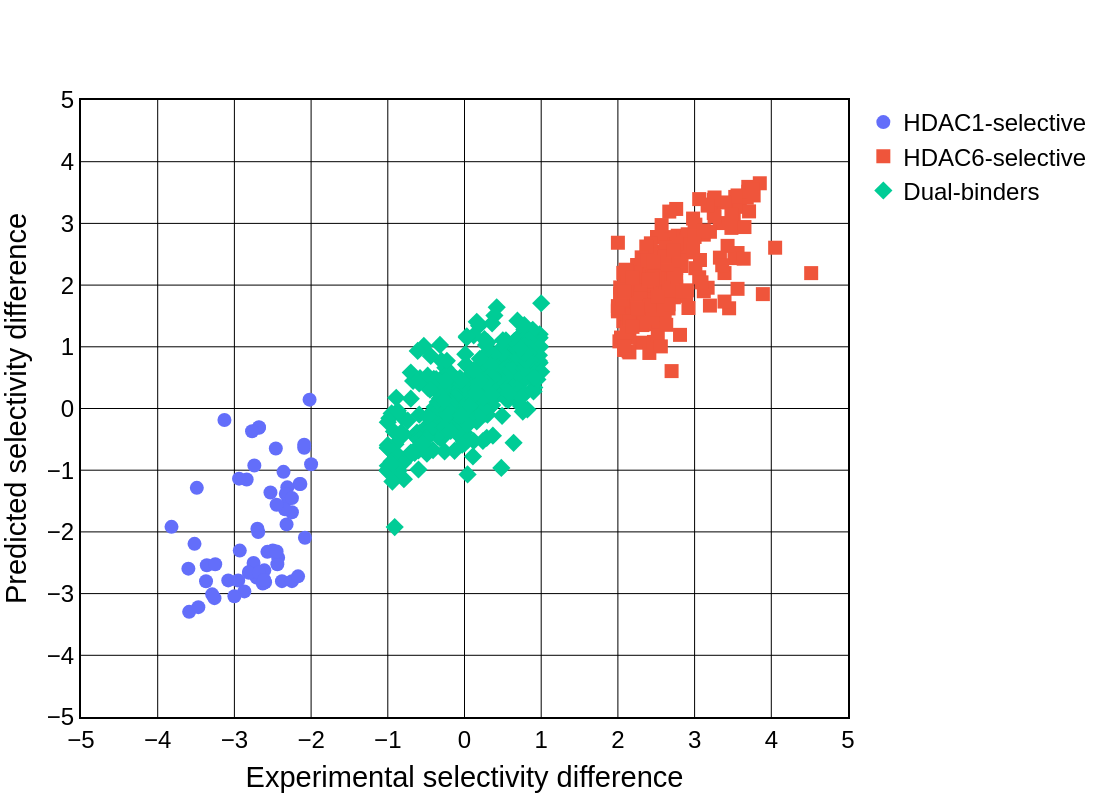

In [39]:
# plot hdac1-selective, hdac6-selective and dual selective compounds in predicted vs experimental plot
import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import iplot, init_notebook_mode
init_notebook_mode(connected=True)


#fig = px.scatter(df=HDAC1and6_ref_pred_DF_hdac1Sel, x="SelectivityWindow", y="RF", )
#fig.show() 

dfs = {"HDAC1-selective" : SP_reg_hdac1Sel, "HDAC6-selective": SP_reg_hdac6Sel, "Dual-binders" : SP_reg_dual}



# plot the data
fig = go.Figure()

for i in dfs:
    fig = fig.add_trace(go.Scatter(x = dfs[i]["SelectivityWindow"],
                                   y = dfs[i]["all_ave"], 
                                   name = i,mode="markers",marker=dict(size=14, symbol = dfs[i]['Marker']) ), )

fig.update_layout(
    autosize=False,
    width=1000,
    height=800,
    xaxis_title="Experimental selectivity difference",
    yaxis_title="Predicted selectivity difference",
    template= "plotly_white",
    
    font=dict(
        #family="Courier New, monospace",
        size=24,
        color="Black"
    )
) 
fig.update_xaxes(showline=True, linewidth=2, linecolor='black', dtick=1, showgrid=True, zeroline=True, mirror=True, zerolinecolor='black',
       zerolinewidth=1, gridwidth=1, gridcolor='black', range=[-5, 5])
fig.update_yaxes(showline=True, linewidth=2, linecolor='black', dtick=1, showgrid=True, zeroline=True, mirror=True, zerolinecolor='black',
       zerolinewidth=1, gridwidth=1, gridcolor='black', range=[-5, 5])

#fig.add_shape( # add a horizontal "target" line
#    type="line", line_color="salmon", line_width=3, opacity=1, line_dash="dot",
#    x0=-4, x1=5, y0=2, y1=2, )

#fig.update_layout({'plot_bgcolor': 'rgba(0, 0, 0, 0)', 'paper_bgcolor': 'rgba(0, 0, 0, 0)',
#})

fig.show()

#### Evaluate the Selectivity Profiling approach in terms of its ability to distinguih selective and dual binders from others

In [40]:
SelProf_rf_DualSel = SelProf_rf.copy()
SelProf_rf_DualSel['selectivity'] = np.zeros(len(SelProf_rf_DualSel))
SelProf_rf_DualSel.loc[SelProf_rf_DualSel[SelProf_rf_DualSel['label'] == 'Dual-binder'].index, 'selectivity'] =1
#SelProf_rf_DualSel.loc[SelProf_rf_DualSel[SelProf_rf_DualSel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelProf_rf_DualSel['Dual_sel_rf_test0'] = np.zeros(len(SelProf_rf_DualSel))
SelProf_rf_DualSel.loc[SelProf_rf_DualSel[(SelProf_rf_DualSel['rf_test0'] >= -1)  & (SelProf_rf_DualSel['rf_test0'] <= 1)].index, 'Dual_sel_rf_test0'] =1
SelProf_rf_DualSel['Dual_sel_rf_test1'] = np.zeros(len(SelProf_rf_DualSel))
SelProf_rf_DualSel.loc[SelProf_rf_DualSel[(SelProf_rf_DualSel['rf_test1'] >= -1)  & (SelProf_rf_DualSel['rf_test1'] <= 1)].index, 'Dual_sel_rf_test1'] =1
SelProf_rf_DualSel['Dual_sel_rf_test2'] = np.zeros(len(SelProf_rf_DualSel))
SelProf_rf_DualSel.loc[SelProf_rf_DualSel[(SelProf_rf_DualSel['rf_test2'] >= -1)  & (SelProf_rf_DualSel['rf_test2'] <= 1)].index, 'Dual_sel_rf_test2'] =1
SelProf_rf_DualSel['Dual_sel_rf_test3'] = np.zeros(len(SelProf_rf_DualSel))
SelProf_rf_DualSel.loc[SelProf_rf_DualSel[(SelProf_rf_DualSel['rf_test3'] >= -1)  & (SelProf_rf_DualSel['rf_test3'] <= 1)].index, 'Dual_sel_rf_test3'] =1
SelProf_rf_DualSel['Dual_sel_rf_test4'] = np.zeros(len(SelProf_rf_DualSel))
SelProf_rf_DualSel.loc[SelProf_rf_DualSel[(SelProf_rf_DualSel['rf_test4'] >= -1)  & (SelProf_rf_DualSel['rf_test4'] <= 1)].index, 'Dual_sel_rf_test4'] =1


SP_DualSel = SelProf_rf_DualSel['selectivity']
SP_DualSel_rf_test0 = SelProf_rf_DualSel['Dual_sel_rf_test0']
SP_DualSel_rf_test1 = SelProf_rf_DualSel['Dual_sel_rf_test1']
SP_DualSel_rf_test2 = SelProf_rf_DualSel['Dual_sel_rf_test2']
SP_DualSel_rf_test3 = SelProf_rf_DualSel['Dual_sel_rf_test3']
SP_DualSel_rf_test4 = SelProf_rf_DualSel['Dual_sel_rf_test4']
list_rf = [SP_DualSel_rf_test0, SP_DualSel_rf_test1, SP_DualSel_rf_test2, SP_DualSel_rf_test3, SP_DualSel_rf_test4]

TP_DualSel_rf=np.zeros(5)
TN_DualSel_rf=np.zeros(5)
FP_DualSel_rf=np.zeros(5)
FN_DualSel_rf=np.zeros(5)
Accuracy_DualSel_rf=np.zeros(5)
Precision_DualSel_rf=np.zeros(5)
Sensitivity_DualSel_rf=np.zeros(5)
Specificity_DualSel_rf=np.zeros(5)
f1_scores_DualSel_rf=np.zeros(5)
f1_scores_DualSel_rf=np.zeros(5)
f1_scores_M_DualSel_rf=np.zeros(5)
BA_scores_DualSel_rf=np.zeros(5)
MCC_DualSel_rf=np.zeros(5)
NPV_DualSel_rf=np.zeros(5)
ROC_AUC_DualSel_rf=np.zeros(5)

for i, df in enumerate(list_rf):
    df = list_rf[i]
    conf_matrix_DualSel_rf=confusion_matrix(SP_DualSel, df)
    TP_DualSel_rf[i] = conf_matrix_DualSel_rf[1][1]
    TN_DualSel_rf[i] = conf_matrix_DualSel_rf[0][0]
    FP_DualSel_rf[i] = conf_matrix_DualSel_rf[0][1] 
    FN_DualSel_rf[i] = conf_matrix_DualSel_rf[1][0]
    Accuracy_DualSel_rf[i] = accuracy_score(SP_DualSel,df)
    Precision_DualSel_rf[i] = precision_score(SP_DualSel, df)
    Sensitivity_DualSel_rf[i] = recall_score(SP_DualSel, df)
    Specificity_DualSel_rf[i] = round( TN_DualSel_rf[i] / (TN_DualSel_rf[i]+FP_DualSel_rf[i]),4 )
    f1_scores_DualSel_rf[i] = f1_score(SP_DualSel, df)
    f1_scores_M_DualSel_rf[i] = f1_score(SP_DualSel, df, average="macro")
    BA_scores_DualSel_rf[i] = balanced_accuracy_score(SP_DualSel, df)
    MCC_DualSel_rf[i] = matthews_corrcoef(SP_DualSel, df)
    NPV_DualSel_rf[i] = round( TN_DualSel_rf[i] / (TN_DualSel_rf[i]+FN_DualSel_rf[i]),4 )
    ROC_AUC_DualSel_rf[i] = roc_auc_score(SP_DualSel, df)

mat_met_SP_rf = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],     
                'RF(Dual-binder)':[np.mean(TP_DualSel_rf),np.mean(TN_DualSel_rf),np.mean(FP_DualSel_rf),
                 np.mean(FN_DualSel_rf),np.mean(Accuracy_DualSel_rf),np.mean(Precision_DualSel_rf),
                 np.mean(Sensitivity_DualSel_rf),np.mean(Specificity_DualSel_rf),np.mean(f1_scores_DualSel_rf),
                 np.mean(f1_scores_M_DualSel_rf), np.mean(BA_scores_DualSel_rf),np.mean(MCC_DualSel_rf),
                 np.mean(NPV_DualSel_rf), np.mean(ROC_AUC_DualSel_rf)],
                'RF_std(Dual-binder)':[np.std(TP_DualSel_rf, ddof=1),np.std(TN_DualSel_rf,ddof=1),
                 np.std(FP_DualSel_rf,ddof=1),np.std(FN_DualSel_rf,ddof=1),np.std(Accuracy_DualSel_rf,ddof=1),
                 np.std(Precision_DualSel_rf,ddof=1),np.std(Sensitivity_DualSel_rf,ddof=1),np.std(Specificity_DualSel_rf,ddof=1),
                 np.std(f1_scores_DualSel_rf),np.std(f1_scores_M_DualSel_rf),np.std(BA_scores_DualSel_rf,ddof=1),
                 np.std(MCC_DualSel_rf,ddof=1), np.std(NPV_DualSel_rf,ddof=1), np.std(ROC_AUC_DualSel_rf, ddof=1)],      
                       }) 
    
SelProf_rf_HDAC1Sel = SelProf_rf.copy()
SelProf_rf_HDAC1Sel['selectivity'] = np.zeros(len(SelProf_rf_HDAC1Sel))
SelProf_rf_HDAC1Sel.loc[SelProf_rf_HDAC1Sel[SelProf_rf_HDAC1Sel['label'] == 'HDAC1-selective'].index, 'selectivity'] =1
#SelProf_rf_HDAC1Sel.loc[SelProf_rf_HDAC1Sel[SelProf_rf_HDAC1Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelProf_rf_HDAC1Sel['HDAC1_sel_rf_test0'] = np.zeros(len(SelProf_rf_HDAC1Sel))
SelProf_rf_HDAC1Sel.loc[SelProf_rf_HDAC1Sel[(SelProf_rf_HDAC1Sel['rf_test0'] <= -2)].index, 'HDAC1_sel_rf_test0'] =1
SelProf_rf_HDAC1Sel['HDAC1_sel_rf_test1'] = np.zeros(len(SelProf_rf_HDAC1Sel))
SelProf_rf_HDAC1Sel.loc[SelProf_rf_HDAC1Sel[ (SelProf_rf_HDAC1Sel['rf_test1'] <= -2)].index, 'HDAC1_sel_rf_test1'] =1
SelProf_rf_HDAC1Sel['HDAC1_sel_rf_test2'] = np.zeros(len(SelProf_rf_HDAC1Sel))
SelProf_rf_HDAC1Sel.loc[SelProf_rf_HDAC1Sel[ (SelProf_rf_HDAC1Sel['rf_test2'] <= -2)].index, 'HDAC1_sel_rf_test2'] =1
SelProf_rf_HDAC1Sel['HDAC1_sel_rf_test3'] = np.zeros(len(SelProf_rf_HDAC1Sel))
SelProf_rf_HDAC1Sel.loc[SelProf_rf_HDAC1Sel[(SelProf_rf_HDAC1Sel['rf_test3'] <= -2)].index, 'HDAC1_sel_rf_test3'] =1
SelProf_rf_HDAC1Sel['HDAC1_sel_rf_test4'] = np.zeros(len(SelProf_rf_HDAC1Sel))
SelProf_rf_HDAC1Sel.loc[SelProf_rf_HDAC1Sel[(SelProf_rf_HDAC1Sel['rf_test4'] <= -2)].index, 'HDAC1_sel_rf_test4'] =1


SP_HDAC1Sel = SelProf_rf_HDAC1Sel['selectivity']
SP_HDAC1Sel_rf_test0 = SelProf_rf_HDAC1Sel['HDAC1_sel_rf_test0']
SP_HDAC1Sel_rf_test1 = SelProf_rf_HDAC1Sel['HDAC1_sel_rf_test1']
SP_HDAC1Sel_rf_test2 = SelProf_rf_HDAC1Sel['HDAC1_sel_rf_test2']
SP_HDAC1Sel_rf_test3 = SelProf_rf_HDAC1Sel['HDAC1_sel_rf_test3']
SP_HDAC1Sel_rf_test4 = SelProf_rf_HDAC1Sel['HDAC1_sel_rf_test4']
list_rf = [SP_HDAC1Sel_rf_test0, SP_HDAC1Sel_rf_test1, SP_HDAC1Sel_rf_test2, SP_HDAC1Sel_rf_test3, SP_HDAC1Sel_rf_test4]

TP_HDAC1Sel_rf=np.zeros(5)
TN_HDAC1Sel_rf=np.zeros(5)
FP_HDAC1Sel_rf=np.zeros(5)
FN_HDAC1Sel_rf=np.zeros(5)
Accuracy_HDAC1Sel_rf=np.zeros(5)
Precision_HDAC1Sel_rf=np.zeros(5)
Sensitivity_HDAC1Sel_rf=np.zeros(5)
Specificity_HDAC1Sel_rf=np.zeros(5)
f1_scores_HDAC1Sel_rf=np.zeros(5)
f1_scores_HDAC1Sel_rf=np.zeros(5)
f1_scores_M_HDAC1Sel_rf=np.zeros(5)
BA_scores_HDAC1Sel_rf=np.zeros(5)
MCC_HDAC1Sel_rf=np.zeros(5)
NPV_HDAC1Sel_rf=np.zeros(5)
ROC_AUC_HDAC1Sel_rf=np.zeros(5)

for i, df in enumerate(list_rf):
    df = list_rf[i]
    conf_matrix_HDAC1Sel_rf=confusion_matrix(SP_HDAC1Sel, df)
    TP_HDAC1Sel_rf[i] = conf_matrix_HDAC1Sel_rf[1][1]
    TN_HDAC1Sel_rf[i] = conf_matrix_HDAC1Sel_rf[0][0]
    FP_HDAC1Sel_rf[i] = conf_matrix_HDAC1Sel_rf[0][1] 
    FN_HDAC1Sel_rf[i] = conf_matrix_HDAC1Sel_rf[1][0]
    Accuracy_HDAC1Sel_rf[i] = accuracy_score(SP_HDAC1Sel,df)
    Precision_HDAC1Sel_rf[i] = precision_score(SP_HDAC1Sel, df)
    Sensitivity_HDAC1Sel_rf[i] = recall_score(SP_HDAC1Sel, df)
    Specificity_HDAC1Sel_rf[i] = round( TN_HDAC1Sel_rf[i] / (TN_HDAC1Sel_rf[i]+FP_HDAC1Sel_rf[i]),4 )
    f1_scores_HDAC1Sel_rf[i] = f1_score(SP_HDAC1Sel, df)
    f1_scores_M_HDAC1Sel_rf[i] = f1_score(SP_HDAC1Sel, df, average="macro")
    BA_scores_HDAC1Sel_rf[i] = balanced_accuracy_score(SP_HDAC1Sel, df)
    MCC_HDAC1Sel_rf[i] = matthews_corrcoef(SP_HDAC1Sel, df)
    NPV_HDAC1Sel_rf[i] = round( TN_HDAC1Sel_rf[i] / (TN_HDAC1Sel_rf[i]+FN_HDAC1Sel_rf[i]),4 )
    ROC_AUC_HDAC1Sel_rf[i] = roc_auc_score(SP_HDAC1Sel, df)

HDAC1_SP_rf_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'RF(HDAC1-binder)':[np.mean(TP_HDAC1Sel_rf),np.mean(TN_HDAC1Sel_rf),np.mean(FP_HDAC1Sel_rf),
                 np.mean(FN_HDAC1Sel_rf),np.mean(Accuracy_HDAC1Sel_rf),np.mean(Precision_HDAC1Sel_rf),
                 np.mean(Sensitivity_HDAC1Sel_rf),np.mean(Specificity_HDAC1Sel_rf),np.mean(f1_scores_HDAC1Sel_rf),
                 np.mean(f1_scores_M_HDAC1Sel_rf), np.mean(BA_scores_HDAC1Sel_rf),np.mean(MCC_HDAC1Sel_rf),
                 np.mean(NPV_HDAC1Sel_rf), np.mean(ROC_AUC_HDAC1Sel_rf)],
                'RF_std(HDAC1-binder)':[np.std(TP_HDAC1Sel_rf, ddof=1),np.std(TN_HDAC1Sel_rf,ddof=1),
                 np.std(FP_HDAC1Sel_rf,ddof=1),np.std(FN_HDAC1Sel_rf,ddof=1),np.std(Accuracy_HDAC1Sel_rf,ddof=1),
                 np.std(Precision_HDAC1Sel_rf,ddof=1),np.std(Sensitivity_HDAC1Sel_rf,ddof=1),np.std(Specificity_HDAC1Sel_rf,ddof=1),
                 np.std(f1_scores_HDAC1Sel_rf),np.std(f1_scores_M_HDAC1Sel_rf),np.std(BA_scores_HDAC1Sel_rf,ddof=1),
                 np.std(MCC_HDAC1Sel_rf,ddof=1), np.std(NPV_HDAC1Sel_rf,ddof=1), np.std(ROC_AUC_HDAC1Sel_rf, ddof=1)],      
                       }) 
    

mat_met_SP_rf = mat_met_SP_rf.merge(HDAC1_SP_rf_ave, on='Metric')
SelProf_rf_HDAC6Sel = SelProf_rf.copy()
SelProf_rf_HDAC6Sel['selectivity'] = np.zeros(len(SelProf_rf_HDAC6Sel))
SelProf_rf_HDAC6Sel.loc[SelProf_rf_HDAC6Sel[SelProf_rf_HDAC6Sel['label'] == 'HDAC6-selective'].index, 'selectivity'] =1
#SelProf_rf_HDAC6Sel.loc[SelProf_rf_HDAC6Sel[SelProf_rf_HDAC6Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelProf_rf_HDAC6Sel['HDAC6_sel_rf_test0'] = np.zeros(len(SelProf_rf_HDAC6Sel))
SelProf_rf_HDAC6Sel.loc[SelProf_rf_HDAC6Sel[(SelProf_rf_HDAC6Sel['rf_test0'] >= 2)].index, 'HDAC6_sel_rf_test0'] =1
SelProf_rf_HDAC6Sel['HDAC6_sel_rf_test1'] = np.zeros(len(SelProf_rf_HDAC6Sel))
SelProf_rf_HDAC6Sel.loc[SelProf_rf_HDAC6Sel[ (SelProf_rf_HDAC6Sel['rf_test1'] >= 2)].index, 'HDAC6_sel_rf_test1'] =1
SelProf_rf_HDAC6Sel['HDAC6_sel_rf_test2'] = np.zeros(len(SelProf_rf_HDAC6Sel))
SelProf_rf_HDAC6Sel.loc[SelProf_rf_HDAC6Sel[ (SelProf_rf_HDAC6Sel['rf_test2'] >= 2)].index, 'HDAC6_sel_rf_test2'] =1
SelProf_rf_HDAC6Sel['HDAC6_sel_rf_test3'] = np.zeros(len(SelProf_rf_HDAC6Sel))
SelProf_rf_HDAC6Sel.loc[SelProf_rf_HDAC6Sel[(SelProf_rf_HDAC6Sel['rf_test3'] >= 2)].index, 'HDAC6_sel_rf_test3'] =1
SelProf_rf_HDAC6Sel['HDAC6_sel_rf_test4'] = np.zeros(len(SelProf_rf_HDAC6Sel))
SelProf_rf_HDAC6Sel.loc[SelProf_rf_HDAC6Sel[(SelProf_rf_HDAC6Sel['rf_test4'] >= 2)].index, 'HDAC6_sel_rf_test4'] =1


SP_HDAC6Sel = SelProf_rf_HDAC6Sel['selectivity']
SP_HDAC6Sel_rf_test0 = SelProf_rf_HDAC6Sel['HDAC6_sel_rf_test0']
SP_HDAC6Sel_rf_test1 = SelProf_rf_HDAC6Sel['HDAC6_sel_rf_test1']
SP_HDAC6Sel_rf_test2 = SelProf_rf_HDAC6Sel['HDAC6_sel_rf_test2']
SP_HDAC6Sel_rf_test3 = SelProf_rf_HDAC6Sel['HDAC6_sel_rf_test3']
SP_HDAC6Sel_rf_test4 = SelProf_rf_HDAC6Sel['HDAC6_sel_rf_test4']
list_rf = [SP_HDAC6Sel_rf_test0, SP_HDAC6Sel_rf_test1, SP_HDAC6Sel_rf_test2, SP_HDAC6Sel_rf_test3, SP_HDAC6Sel_rf_test4]

TP_HDAC6Sel_rf=np.zeros(5)
TN_HDAC6Sel_rf=np.zeros(5)
FP_HDAC6Sel_rf=np.zeros(5)
FN_HDAC6Sel_rf=np.zeros(5)
Accuracy_HDAC6Sel_rf=np.zeros(5)
Precision_HDAC6Sel_rf=np.zeros(5)
Sensitivity_HDAC6Sel_rf=np.zeros(5)
Specificity_HDAC6Sel_rf=np.zeros(5)
f1_scores_HDAC6Sel_rf=np.zeros(5)
f1_scores_HDAC6Sel_rf=np.zeros(5)
f1_scores_M_HDAC6Sel_rf=np.zeros(5)
BA_scores_HDAC6Sel_rf=np.zeros(5)
MCC_HDAC6Sel_rf=np.zeros(5)
NPV_HDAC6Sel_rf=np.zeros(5)
ROC_AUC_HDAC6Sel_rf=np.zeros(5)

for i, df in enumerate(list_rf):
    df = list_rf[i]
    conf_matrix_HDAC6Sel_rf=confusion_matrix(SP_HDAC6Sel, df)
    TP_HDAC6Sel_rf[i] = conf_matrix_HDAC6Sel_rf[1][1]
    TN_HDAC6Sel_rf[i] = conf_matrix_HDAC6Sel_rf[0][0]
    FP_HDAC6Sel_rf[i] = conf_matrix_HDAC6Sel_rf[0][1] 
    FN_HDAC6Sel_rf[i] = conf_matrix_HDAC6Sel_rf[1][0]
    Accuracy_HDAC6Sel_rf[i] = accuracy_score(SP_HDAC6Sel,df)
    Precision_HDAC6Sel_rf[i] = precision_score(SP_HDAC6Sel, df)
    Sensitivity_HDAC6Sel_rf[i] = recall_score(SP_HDAC6Sel, df)
    Specificity_HDAC6Sel_rf[i] = round( TN_HDAC6Sel_rf[i] / (TN_HDAC6Sel_rf[i]+FP_HDAC6Sel_rf[i]),4 )
    f1_scores_HDAC6Sel_rf[i] = f1_score(SP_HDAC6Sel, df)
    f1_scores_M_HDAC6Sel_rf[i] = f1_score(SP_HDAC6Sel, df, average="macro")
    BA_scores_HDAC6Sel_rf[i] = balanced_accuracy_score(SP_HDAC6Sel, df)
    MCC_HDAC6Sel_rf[i] = matthews_corrcoef(SP_HDAC6Sel, df)
    NPV_HDAC6Sel_rf[i] = round( TN_HDAC6Sel_rf[i] / (TN_HDAC6Sel_rf[i]+FN_HDAC6Sel_rf[i]),4 )
    ROC_AUC_HDAC6Sel_rf[i] = roc_auc_score(SP_HDAC6Sel, df)

HDAC6_SP_rf_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'RF(HDAC6-binder)':[np.mean(TP_HDAC6Sel_rf),np.mean(TN_HDAC6Sel_rf),np.mean(FP_HDAC6Sel_rf),
                 np.mean(FN_HDAC6Sel_rf),np.mean(Accuracy_HDAC6Sel_rf),np.mean(Precision_HDAC6Sel_rf),
                 np.mean(Sensitivity_HDAC6Sel_rf),np.mean(Specificity_HDAC6Sel_rf),np.mean(f1_scores_HDAC6Sel_rf),
                 np.mean(f1_scores_M_HDAC6Sel_rf), np.mean(BA_scores_HDAC6Sel_rf),np.mean(MCC_HDAC6Sel_rf),
                 np.mean(NPV_HDAC6Sel_rf), np.mean(ROC_AUC_HDAC6Sel_rf)],
                'RF_std(HDAC6-binder)':[np.std(TP_HDAC6Sel_rf, ddof=1),np.std(TN_HDAC6Sel_rf,ddof=1),
                 np.std(FP_HDAC6Sel_rf,ddof=1),np.std(FN_HDAC6Sel_rf,ddof=1),np.std(Accuracy_HDAC6Sel_rf,ddof=1),
                 np.std(Precision_HDAC6Sel_rf,ddof=1),np.std(Sensitivity_HDAC6Sel_rf,ddof=1),np.std(Specificity_HDAC6Sel_rf,ddof=1),
                 np.std(f1_scores_HDAC6Sel_rf),np.std(f1_scores_M_HDAC6Sel_rf),np.std(BA_scores_HDAC6Sel_rf,ddof=1),
                 np.std(MCC_HDAC6Sel_rf,ddof=1), np.std(NPV_HDAC6Sel_rf,ddof=1), np.std(ROC_AUC_HDAC6Sel_rf, ddof=1)],      
                       }) 
    

mat_met_SP_rf = mat_met_SP_rf.merge(HDAC6_SP_rf_ave, on='Metric')
mat_met_SP_rf


,Metric,RF(Dual-binder),RF_std(Dual-binder),RF(HDAC1-binder),RF_std(HDAC1-binder),RF(HDAC6-binder),RF_std(HDAC6-binder)
0,TP,474.800000,3.701351,29.800000,1.483240,138.400000,2.701851
1,TN,667.400000,4.277850,1846.200000,0.447214,1614.200000,1.788854
2,FP,710.600000,4.277850,2.800000,0.447214,28.800000,1.788854
3,FN,57.200000,3.701351,31.200000,1.483240,128.600000,2.701851
4,Accuracy,0.598010,0.002382,0.982199,0.000979,0.917592,0.001980
5,Precision,0.400539,0.001916,0.913767,0.015513,0.827755,0.010241
6,Sensitivity,0.892481,0.006957,0.488525,0.024315,0.518352,0.010119
7,Specificity,0.484320,0.003083,0.998500,0.000224,0.982460,0.001124
8,F1 score,0.552925,0.002616,0.636526,0.021574,0.637466,0.008775
9,F1 score (macro),0.593877,0.002126,0.813701,0.011010,0.795489,0.004869


In [41]:
SelProf_lgbm_DualSel = SelProf_lgbm.copy()
SelProf_lgbm_DualSel['selectivity'] = np.zeros(len(SelProf_lgbm_DualSel))
SelProf_lgbm_DualSel.loc[SelProf_lgbm_DualSel[SelProf_lgbm_DualSel['label'] == 'Dual-binder'].index, 'selectivity'] =1
#SelProf_lgbm_DualSel.loc[SelProf_lgbm_DualSel[SelProf_lgbm_DualSel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelProf_lgbm_DualSel['Dual_sel_lgbm_test0'] = np.zeros(len(SelProf_lgbm_DualSel))
SelProf_lgbm_DualSel.loc[SelProf_lgbm_DualSel[(SelProf_lgbm_DualSel['lgbm_test0'] >= -1)  & (SelProf_lgbm_DualSel['lgbm_test0'] <= 1)].index, 'Dual_sel_lgbm_test0'] =1
SelProf_lgbm_DualSel['Dual_sel_lgbm_test1'] = np.zeros(len(SelProf_lgbm_DualSel))
SelProf_lgbm_DualSel.loc[SelProf_lgbm_DualSel[(SelProf_lgbm_DualSel['lgbm_test1'] >= -1)  & (SelProf_lgbm_DualSel['lgbm_test1'] <= 1)].index, 'Dual_sel_lgbm_test1'] =1
SelProf_lgbm_DualSel['Dual_sel_lgbm_test2'] = np.zeros(len(SelProf_lgbm_DualSel))
SelProf_lgbm_DualSel.loc[SelProf_lgbm_DualSel[(SelProf_lgbm_DualSel['lgbm_test2'] >= -1)  & (SelProf_lgbm_DualSel['lgbm_test2'] <= 1)].index, 'Dual_sel_lgbm_test2'] =1
SelProf_lgbm_DualSel['Dual_sel_lgbm_test3'] = np.zeros(len(SelProf_lgbm_DualSel))
SelProf_lgbm_DualSel.loc[SelProf_lgbm_DualSel[(SelProf_lgbm_DualSel['lgbm_test3'] >= -1)  & (SelProf_lgbm_DualSel['lgbm_test3'] <= 1)].index, 'Dual_sel_lgbm_test3'] =1
SelProf_lgbm_DualSel['Dual_sel_lgbm_test4'] = np.zeros(len(SelProf_lgbm_DualSel))
SelProf_lgbm_DualSel.loc[SelProf_lgbm_DualSel[(SelProf_lgbm_DualSel['lgbm_test4'] >= -1)  & (SelProf_lgbm_DualSel['lgbm_test4'] <= 1)].index, 'Dual_sel_lgbm_test4'] =1


SP_DualSel = SelProf_lgbm_DualSel['selectivity']
SP_DualSel_lgbm_test0 = SelProf_lgbm_DualSel['Dual_sel_lgbm_test0']
SP_DualSel_lgbm_test1 = SelProf_lgbm_DualSel['Dual_sel_lgbm_test1']
SP_DualSel_lgbm_test2 = SelProf_lgbm_DualSel['Dual_sel_lgbm_test2']
SP_DualSel_lgbm_test3 = SelProf_lgbm_DualSel['Dual_sel_lgbm_test3']
SP_DualSel_lgbm_test4 = SelProf_lgbm_DualSel['Dual_sel_lgbm_test4']
list_lgbm = [SP_DualSel_lgbm_test0, SP_DualSel_lgbm_test1, SP_DualSel_lgbm_test2, SP_DualSel_lgbm_test3, SP_DualSel_lgbm_test4]

TP_DualSel_lgbm=np.zeros(5)
TN_DualSel_lgbm=np.zeros(5)
FP_DualSel_lgbm=np.zeros(5)
FN_DualSel_lgbm=np.zeros(5)
Accuracy_DualSel_lgbm=np.zeros(5)
Precision_DualSel_lgbm=np.zeros(5)
Sensitivity_DualSel_lgbm=np.zeros(5)
Specificity_DualSel_lgbm=np.zeros(5)
f1_scores_DualSel_lgbm=np.zeros(5)
f1_scores_DualSel_lgbm=np.zeros(5)
f1_scores_M_DualSel_lgbm=np.zeros(5)
BA_scores_DualSel_lgbm=np.zeros(5)
MCC_DualSel_lgbm=np.zeros(5)
NPV_DualSel_lgbm=np.zeros(5)
ROC_AUC_DualSel_lgbm=np.zeros(5)

for i, df in enumerate(list_lgbm):
    df = list_lgbm[i]
    conf_matrix_DualSel_lgbm=confusion_matrix(SP_DualSel, df)
    TP_DualSel_lgbm[i] = conf_matrix_DualSel_lgbm[1][1]
    TN_DualSel_lgbm[i] = conf_matrix_DualSel_lgbm[0][0]
    FP_DualSel_lgbm[i] = conf_matrix_DualSel_lgbm[0][1] 
    FN_DualSel_lgbm[i] = conf_matrix_DualSel_lgbm[1][0]
    Accuracy_DualSel_lgbm[i] = accuracy_score(SP_DualSel,df)
    Precision_DualSel_lgbm[i] = precision_score(SP_DualSel, df)
    Sensitivity_DualSel_lgbm[i] = recall_score(SP_DualSel, df)
    Specificity_DualSel_lgbm[i] = round( TN_DualSel_lgbm[i] / (TN_DualSel_lgbm[i]+FP_DualSel_lgbm[i]),4 )
    f1_scores_DualSel_lgbm[i] = f1_score(SP_DualSel, df)
    f1_scores_M_DualSel_lgbm[i] = f1_score(SP_DualSel, df, average="macro")
    BA_scores_DualSel_lgbm[i] = balanced_accuracy_score(SP_DualSel, df)
    MCC_DualSel_lgbm[i] = matthews_corrcoef(SP_DualSel, df)
    NPV_DualSel_lgbm[i] = round( TN_DualSel_lgbm[i] / (TN_DualSel_lgbm[i]+FN_DualSel_lgbm[i]),4 )
    ROC_AUC_DualSel_lgbm[i] = roc_auc_score(SP_DualSel, df)

mat_met_SP_lgbm = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],     
                'lgbm(Dual-binder)':[np.mean(TP_DualSel_lgbm),np.mean(TN_DualSel_lgbm),np.mean(FP_DualSel_lgbm),
                 np.mean(FN_DualSel_lgbm),np.mean(Accuracy_DualSel_lgbm),np.mean(Precision_DualSel_lgbm),
                 np.mean(Sensitivity_DualSel_lgbm),np.mean(Specificity_DualSel_lgbm),np.mean(f1_scores_DualSel_lgbm),
                 np.mean(f1_scores_M_DualSel_lgbm), np.mean(BA_scores_DualSel_lgbm),np.mean(MCC_DualSel_lgbm),
                 np.mean(NPV_DualSel_lgbm), np.mean(ROC_AUC_DualSel_lgbm)],
                'lgbm_std(Dual-binder)':[np.std(TP_DualSel_lgbm, ddof=1),np.std(TN_DualSel_lgbm,ddof=1),
                 np.std(FP_DualSel_lgbm,ddof=1),np.std(FN_DualSel_lgbm,ddof=1),np.std(Accuracy_DualSel_lgbm,ddof=1),
                 np.std(Precision_DualSel_lgbm,ddof=1),np.std(Sensitivity_DualSel_lgbm,ddof=1),np.std(Specificity_DualSel_lgbm,ddof=1),
                 np.std(f1_scores_DualSel_lgbm),np.std(f1_scores_M_DualSel_lgbm),np.std(BA_scores_DualSel_lgbm,ddof=1),
                 np.std(MCC_DualSel_lgbm,ddof=1), np.std(NPV_DualSel_lgbm,ddof=1), np.std(ROC_AUC_DualSel_lgbm, ddof=1)],      
                       }) 
    
SelProf_lgbm_HDAC1Sel = SelProf_lgbm.copy()
SelProf_lgbm_HDAC1Sel['selectivity'] = np.zeros(len(SelProf_lgbm_HDAC1Sel))
SelProf_lgbm_HDAC1Sel.loc[SelProf_lgbm_HDAC1Sel[SelProf_lgbm_HDAC1Sel['label'] == 'HDAC1-selective'].index, 'selectivity'] =1
#SelProf_lgbm_HDAC1Sel.loc[SelProf_lgbm_HDAC1Sel[SelProf_lgbm_HDAC1Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelProf_lgbm_HDAC1Sel['HDAC1_sel_lgbm_test0'] = np.zeros(len(SelProf_lgbm_HDAC1Sel))
SelProf_lgbm_HDAC1Sel.loc[SelProf_lgbm_HDAC1Sel[(SelProf_lgbm_HDAC1Sel['lgbm_test0'] <= -2)].index, 'HDAC1_sel_lgbm_test0'] =1
SelProf_lgbm_HDAC1Sel['HDAC1_sel_lgbm_test1'] = np.zeros(len(SelProf_lgbm_HDAC1Sel))
SelProf_lgbm_HDAC1Sel.loc[SelProf_lgbm_HDAC1Sel[ (SelProf_lgbm_HDAC1Sel['lgbm_test1'] <= -2)].index, 'HDAC1_sel_lgbm_test1'] =1
SelProf_lgbm_HDAC1Sel['HDAC1_sel_lgbm_test2'] = np.zeros(len(SelProf_lgbm_HDAC1Sel))
SelProf_lgbm_HDAC1Sel.loc[SelProf_lgbm_HDAC1Sel[ (SelProf_lgbm_HDAC1Sel['lgbm_test2'] <= -2)].index, 'HDAC1_sel_lgbm_test2'] =1
SelProf_lgbm_HDAC1Sel['HDAC1_sel_lgbm_test3'] = np.zeros(len(SelProf_lgbm_HDAC1Sel))
SelProf_lgbm_HDAC1Sel.loc[SelProf_lgbm_HDAC1Sel[(SelProf_lgbm_HDAC1Sel['lgbm_test3'] <= -2)].index, 'HDAC1_sel_lgbm_test3'] =1
SelProf_lgbm_HDAC1Sel['HDAC1_sel_lgbm_test4'] = np.zeros(len(SelProf_lgbm_HDAC1Sel))
SelProf_lgbm_HDAC1Sel.loc[SelProf_lgbm_HDAC1Sel[(SelProf_lgbm_HDAC1Sel['lgbm_test4'] <= -2)].index, 'HDAC1_sel_lgbm_test4'] =1


SP_HDAC1Sel = SelProf_lgbm_HDAC1Sel['selectivity']
SP_HDAC1Sel_lgbm_test0 = SelProf_lgbm_HDAC1Sel['HDAC1_sel_lgbm_test0']
SP_HDAC1Sel_lgbm_test1 = SelProf_lgbm_HDAC1Sel['HDAC1_sel_lgbm_test1']
SP_HDAC1Sel_lgbm_test2 = SelProf_lgbm_HDAC1Sel['HDAC1_sel_lgbm_test2']
SP_HDAC1Sel_lgbm_test3 = SelProf_lgbm_HDAC1Sel['HDAC1_sel_lgbm_test3']
SP_HDAC1Sel_lgbm_test4 = SelProf_lgbm_HDAC1Sel['HDAC1_sel_lgbm_test4']
list_lgbm = [SP_HDAC1Sel_lgbm_test0, SP_HDAC1Sel_lgbm_test1, SP_HDAC1Sel_lgbm_test2, SP_HDAC1Sel_lgbm_test3, SP_HDAC1Sel_lgbm_test4]

TP_HDAC1Sel_lgbm=np.zeros(5)
TN_HDAC1Sel_lgbm=np.zeros(5)
FP_HDAC1Sel_lgbm=np.zeros(5)
FN_HDAC1Sel_lgbm=np.zeros(5)
Accuracy_HDAC1Sel_lgbm=np.zeros(5)
Precision_HDAC1Sel_lgbm=np.zeros(5)
Sensitivity_HDAC1Sel_lgbm=np.zeros(5)
Specificity_HDAC1Sel_lgbm=np.zeros(5)
f1_scores_HDAC1Sel_lgbm=np.zeros(5)
f1_scores_HDAC1Sel_lgbm=np.zeros(5)
f1_scores_M_HDAC1Sel_lgbm=np.zeros(5)
BA_scores_HDAC1Sel_lgbm=np.zeros(5)
MCC_HDAC1Sel_lgbm=np.zeros(5)
NPV_HDAC1Sel_lgbm=np.zeros(5)
ROC_AUC_HDAC1Sel_lgbm=np.zeros(5)

for i, df in enumerate(list_lgbm):
    df = list_lgbm[i]
    conf_matrix_HDAC1Sel_lgbm=confusion_matrix(SP_HDAC1Sel, df)
    TP_HDAC1Sel_lgbm[i] = conf_matrix_HDAC1Sel_lgbm[1][1]
    TN_HDAC1Sel_lgbm[i] = conf_matrix_HDAC1Sel_lgbm[0][0]
    FP_HDAC1Sel_lgbm[i] = conf_matrix_HDAC1Sel_lgbm[0][1] 
    FN_HDAC1Sel_lgbm[i] = conf_matrix_HDAC1Sel_lgbm[1][0]
    Accuracy_HDAC1Sel_lgbm[i] = accuracy_score(SP_HDAC1Sel,df)
    Precision_HDAC1Sel_lgbm[i] = precision_score(SP_HDAC1Sel, df)
    Sensitivity_HDAC1Sel_lgbm[i] = recall_score(SP_HDAC1Sel, df)
    Specificity_HDAC1Sel_lgbm[i] = round( TN_HDAC1Sel_lgbm[i] / (TN_HDAC1Sel_lgbm[i]+FP_HDAC1Sel_lgbm[i]),4 )
    f1_scores_HDAC1Sel_lgbm[i] = f1_score(SP_HDAC1Sel, df)
    f1_scores_M_HDAC1Sel_lgbm[i] = f1_score(SP_HDAC1Sel, df, average="macro")
    BA_scores_HDAC1Sel_lgbm[i] = balanced_accuracy_score(SP_HDAC1Sel, df)
    MCC_HDAC1Sel_lgbm[i] = matthews_corrcoef(SP_HDAC1Sel, df)
    NPV_HDAC1Sel_lgbm[i] = round( TN_HDAC1Sel_lgbm[i] / (TN_HDAC1Sel_lgbm[i]+FN_HDAC1Sel_lgbm[i]),4 )
    ROC_AUC_HDAC1Sel_lgbm[i] = roc_auc_score(SP_HDAC1Sel, df)

HDAC1_SP_lgbm_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'lgbm(HDAC1-binder)':[np.mean(TP_HDAC1Sel_lgbm),np.mean(TN_HDAC1Sel_lgbm),np.mean(FP_HDAC1Sel_lgbm),
                 np.mean(FN_HDAC1Sel_lgbm),np.mean(Accuracy_HDAC1Sel_lgbm),np.mean(Precision_HDAC1Sel_lgbm),
                 np.mean(Sensitivity_HDAC1Sel_lgbm),np.mean(Specificity_HDAC1Sel_lgbm),np.mean(f1_scores_HDAC1Sel_lgbm),
                 np.mean(f1_scores_M_HDAC1Sel_lgbm), np.mean(BA_scores_HDAC1Sel_lgbm),np.mean(MCC_HDAC1Sel_lgbm),
                 np.mean(NPV_HDAC1Sel_lgbm), np.mean(ROC_AUC_HDAC1Sel_lgbm)],
                'lgbm_std(HDAC1-binder)':[np.std(TP_HDAC1Sel_lgbm, ddof=1),np.std(TN_HDAC1Sel_lgbm,ddof=1),
                 np.std(FP_HDAC1Sel_lgbm,ddof=1),np.std(FN_HDAC1Sel_lgbm,ddof=1),np.std(Accuracy_HDAC1Sel_lgbm,ddof=1),
                 np.std(Precision_HDAC1Sel_lgbm,ddof=1),np.std(Sensitivity_HDAC1Sel_lgbm,ddof=1),np.std(Specificity_HDAC1Sel_lgbm,ddof=1),
                 np.std(f1_scores_HDAC1Sel_lgbm),np.std(f1_scores_M_HDAC1Sel_lgbm),np.std(BA_scores_HDAC1Sel_lgbm,ddof=1),
                 np.std(MCC_HDAC1Sel_lgbm,ddof=1), np.std(NPV_HDAC1Sel_lgbm,ddof=1), np.std(ROC_AUC_HDAC1Sel_lgbm, ddof=1)],      
                       }) 
    

mat_met_SP_lgbm = mat_met_SP_lgbm.merge(HDAC1_SP_lgbm_ave, on='Metric')
SelProf_lgbm_HDAC6Sel = SelProf_lgbm.copy()
SelProf_lgbm_HDAC6Sel['selectivity'] = np.zeros(len(SelProf_lgbm_HDAC6Sel))
SelProf_lgbm_HDAC6Sel.loc[SelProf_lgbm_HDAC6Sel[SelProf_lgbm_HDAC6Sel['label'] == 'HDAC6-selective'].index, 'selectivity'] =1
#SelProf_lgbm_HDAC6Sel.loc[SelProf_lgbm_HDAC6Sel[SelProf_lgbm_HDAC6Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelProf_lgbm_HDAC6Sel['HDAC6_sel_lgbm_test0'] = np.zeros(len(SelProf_lgbm_HDAC6Sel))
SelProf_lgbm_HDAC6Sel.loc[SelProf_lgbm_HDAC6Sel[(SelProf_lgbm_HDAC6Sel['lgbm_test0'] >= 2)].index, 'HDAC6_sel_lgbm_test0'] =1
SelProf_lgbm_HDAC6Sel['HDAC6_sel_lgbm_test1'] = np.zeros(len(SelProf_lgbm_HDAC6Sel))
SelProf_lgbm_HDAC6Sel.loc[SelProf_lgbm_HDAC6Sel[ (SelProf_lgbm_HDAC6Sel['lgbm_test1'] >= 2)].index, 'HDAC6_sel_lgbm_test1'] =1
SelProf_lgbm_HDAC6Sel['HDAC6_sel_lgbm_test2'] = np.zeros(len(SelProf_lgbm_HDAC6Sel))
SelProf_lgbm_HDAC6Sel.loc[SelProf_lgbm_HDAC6Sel[ (SelProf_lgbm_HDAC6Sel['lgbm_test2'] >= 2)].index, 'HDAC6_sel_lgbm_test2'] =1
SelProf_lgbm_HDAC6Sel['HDAC6_sel_lgbm_test3'] = np.zeros(len(SelProf_lgbm_HDAC6Sel))
SelProf_lgbm_HDAC6Sel.loc[SelProf_lgbm_HDAC6Sel[(SelProf_lgbm_HDAC6Sel['lgbm_test3'] >= 2)].index, 'HDAC6_sel_lgbm_test3'] =1
SelProf_lgbm_HDAC6Sel['HDAC6_sel_lgbm_test4'] = np.zeros(len(SelProf_lgbm_HDAC6Sel))
SelProf_lgbm_HDAC6Sel.loc[SelProf_lgbm_HDAC6Sel[(SelProf_lgbm_HDAC6Sel['lgbm_test4'] >= 2)].index, 'HDAC6_sel_lgbm_test4'] =1


SP_HDAC6Sel = SelProf_lgbm_HDAC6Sel['selectivity']
SP_HDAC6Sel_lgbm_test0 = SelProf_lgbm_HDAC6Sel['HDAC6_sel_lgbm_test0']
SP_HDAC6Sel_lgbm_test1 = SelProf_lgbm_HDAC6Sel['HDAC6_sel_lgbm_test1']
SP_HDAC6Sel_lgbm_test2 = SelProf_lgbm_HDAC6Sel['HDAC6_sel_lgbm_test2']
SP_HDAC6Sel_lgbm_test3 = SelProf_lgbm_HDAC6Sel['HDAC6_sel_lgbm_test3']
SP_HDAC6Sel_lgbm_test4 = SelProf_lgbm_HDAC6Sel['HDAC6_sel_lgbm_test4']
list_lgbm = [SP_HDAC6Sel_lgbm_test0, SP_HDAC6Sel_lgbm_test1, SP_HDAC6Sel_lgbm_test2, SP_HDAC6Sel_lgbm_test3, SP_HDAC6Sel_lgbm_test4]

TP_HDAC6Sel_lgbm=np.zeros(5)
TN_HDAC6Sel_lgbm=np.zeros(5)
FP_HDAC6Sel_lgbm=np.zeros(5)
FN_HDAC6Sel_lgbm=np.zeros(5)
Accuracy_HDAC6Sel_lgbm=np.zeros(5)
Precision_HDAC6Sel_lgbm=np.zeros(5)
Sensitivity_HDAC6Sel_lgbm=np.zeros(5)
Specificity_HDAC6Sel_lgbm=np.zeros(5)
f1_scores_HDAC6Sel_lgbm=np.zeros(5)
f1_scores_HDAC6Sel_lgbm=np.zeros(5)
f1_scores_M_HDAC6Sel_lgbm=np.zeros(5)
BA_scores_HDAC6Sel_lgbm=np.zeros(5)
MCC_HDAC6Sel_lgbm=np.zeros(5)
NPV_HDAC6Sel_lgbm=np.zeros(5)
ROC_AUC_HDAC6Sel_lgbm=np.zeros(5)

for i, df in enumerate(list_lgbm):
    df = list_lgbm[i]
    conf_matrix_HDAC6Sel_lgbm=confusion_matrix(SP_HDAC6Sel, df)
    TP_HDAC6Sel_lgbm[i] = conf_matrix_HDAC6Sel_lgbm[1][1]
    TN_HDAC6Sel_lgbm[i] = conf_matrix_HDAC6Sel_lgbm[0][0]
    FP_HDAC6Sel_lgbm[i] = conf_matrix_HDAC6Sel_lgbm[0][1] 
    FN_HDAC6Sel_lgbm[i] = conf_matrix_HDAC6Sel_lgbm[1][0]
    Accuracy_HDAC6Sel_lgbm[i] = accuracy_score(SP_HDAC6Sel,df)
    Precision_HDAC6Sel_lgbm[i] = precision_score(SP_HDAC6Sel, df)
    Sensitivity_HDAC6Sel_lgbm[i] = recall_score(SP_HDAC6Sel, df)
    Specificity_HDAC6Sel_lgbm[i] = round( TN_HDAC6Sel_lgbm[i] / (TN_HDAC6Sel_lgbm[i]+FP_HDAC6Sel_lgbm[i]),4 )
    f1_scores_HDAC6Sel_lgbm[i] = f1_score(SP_HDAC6Sel, df)
    f1_scores_M_HDAC6Sel_lgbm[i] = f1_score(SP_HDAC6Sel, df, average="macro")
    BA_scores_HDAC6Sel_lgbm[i] = balanced_accuracy_score(SP_HDAC6Sel, df)
    MCC_HDAC6Sel_lgbm[i] = matthews_corrcoef(SP_HDAC6Sel, df)
    NPV_HDAC6Sel_lgbm[i] = round( TN_HDAC6Sel_lgbm[i] / (TN_HDAC6Sel_lgbm[i]+FN_HDAC6Sel_lgbm[i]),4 )
    ROC_AUC_HDAC6Sel_lgbm[i] = roc_auc_score(SP_HDAC6Sel, df)

HDAC6_SP_lgbm_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'lgbm(HDAC6-binder)':[np.mean(TP_HDAC6Sel_lgbm),np.mean(TN_HDAC6Sel_lgbm),np.mean(FP_HDAC6Sel_lgbm),
                 np.mean(FN_HDAC6Sel_lgbm),np.mean(Accuracy_HDAC6Sel_lgbm),np.mean(Precision_HDAC6Sel_lgbm),
                 np.mean(Sensitivity_HDAC6Sel_lgbm),np.mean(Specificity_HDAC6Sel_lgbm),np.mean(f1_scores_HDAC6Sel_lgbm),
                 np.mean(f1_scores_M_HDAC6Sel_lgbm), np.mean(BA_scores_HDAC6Sel_lgbm),np.mean(MCC_HDAC6Sel_lgbm),
                 np.mean(NPV_HDAC6Sel_lgbm), np.mean(ROC_AUC_HDAC6Sel_lgbm)],
                'lgbm_std(HDAC6-binder)':[np.std(TP_HDAC6Sel_lgbm, ddof=1),np.std(TN_HDAC6Sel_lgbm,ddof=1),
                 np.std(FP_HDAC6Sel_lgbm,ddof=1),np.std(FN_HDAC6Sel_lgbm,ddof=1),np.std(Accuracy_HDAC6Sel_lgbm,ddof=1),
                 np.std(Precision_HDAC6Sel_lgbm,ddof=1),np.std(Sensitivity_HDAC6Sel_lgbm,ddof=1),np.std(Specificity_HDAC6Sel_lgbm,ddof=1),
                 np.std(f1_scores_HDAC6Sel_lgbm),np.std(f1_scores_M_HDAC6Sel_lgbm),np.std(BA_scores_HDAC6Sel_lgbm,ddof=1),
                 np.std(MCC_HDAC6Sel_lgbm,ddof=1), np.std(NPV_HDAC6Sel_lgbm,ddof=1), np.std(ROC_AUC_HDAC6Sel_lgbm, ddof=1)],      
                       }) 
    

mat_met_SP_lgbm = mat_met_SP_lgbm.merge(HDAC6_SP_lgbm_ave, on='Metric')
mat_met_SP_lgbm

,Metric,lgbm(Dual-binder),lgbm_std(Dual-binder),lgbm(HDAC1-binder),lgbm_std(HDAC1-binder),lgbm(HDAC6-binder),lgbm_std(HDAC6-binder)
0,TP,438.000000,5.522681,33.000000,1.870829,149.400000,3.911521
1,TN,738.000000,4.183300,1842.600000,2.073644,1596.200000,3.768289
2,FP,640.000000,4.183300,6.400000,2.073644,46.800000,3.768289
3,FN,94.000000,5.522681,28.000000,1.870829,117.600000,3.911521
4,Accuracy,0.615707,0.004286,0.981990,0.001508,0.913927,0.002554
5,Precision,0.406302,0.003967,0.838953,0.044187,0.761650,0.014611
6,Sensitivity,0.823308,0.010381,0.540984,0.030669,0.559551,0.014650
7,Specificity,0.535540,0.003042,0.996540,0.001119,0.971520,0.002261
8,F1 score,0.544091,0.005122,0.657226,0.026566,0.645028,0.010363
9,F1 score (macro),0.605983,0.004037,0.823989,0.013610,0.798026,0.005772


In [42]:
SelProf_xgb_DualSel = SelProf_xgb.copy()
SelProf_xgb_DualSel['selectivity'] = np.zeros(len(SelProf_xgb_DualSel))
SelProf_xgb_DualSel.loc[SelProf_xgb_DualSel[SelProf_xgb_DualSel['label'] == 'Dual-binder'].index, 'selectivity'] =1
#SelProf_xgb_DualSel.loc[SelProf_xgb_DualSel[SelProf_xgb_DualSel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelProf_xgb_DualSel['Dual_sel_xgb_test0'] = np.zeros(len(SelProf_xgb_DualSel))
SelProf_xgb_DualSel.loc[SelProf_xgb_DualSel[(SelProf_xgb_DualSel['xgb_test0'] >= -1)  & (SelProf_xgb_DualSel['xgb_test0'] <= 1)].index, 'Dual_sel_xgb_test0'] =1
SelProf_xgb_DualSel['Dual_sel_xgb_test1'] = np.zeros(len(SelProf_xgb_DualSel))
SelProf_xgb_DualSel.loc[SelProf_xgb_DualSel[(SelProf_xgb_DualSel['xgb_test1'] >= -1)  & (SelProf_xgb_DualSel['xgb_test1'] <= 1)].index, 'Dual_sel_xgb_test1'] =1
SelProf_xgb_DualSel['Dual_sel_xgb_test2'] = np.zeros(len(SelProf_xgb_DualSel))
SelProf_xgb_DualSel.loc[SelProf_xgb_DualSel[(SelProf_xgb_DualSel['xgb_test2'] >= -1)  & (SelProf_xgb_DualSel['xgb_test2'] <= 1)].index, 'Dual_sel_xgb_test2'] =1
SelProf_xgb_DualSel['Dual_sel_xgb_test3'] = np.zeros(len(SelProf_xgb_DualSel))
SelProf_xgb_DualSel.loc[SelProf_xgb_DualSel[(SelProf_xgb_DualSel['xgb_test3'] >= -1)  & (SelProf_xgb_DualSel['xgb_test3'] <= 1)].index, 'Dual_sel_xgb_test3'] =1
SelProf_xgb_DualSel['Dual_sel_xgb_test4'] = np.zeros(len(SelProf_xgb_DualSel))
SelProf_xgb_DualSel.loc[SelProf_xgb_DualSel[(SelProf_xgb_DualSel['xgb_test4'] >= -1)  & (SelProf_xgb_DualSel['xgb_test4'] <= 1)].index, 'Dual_sel_xgb_test4'] =1


SP_DualSel = SelProf_xgb_DualSel['selectivity']
SP_DualSel_xgb_test0 = SelProf_xgb_DualSel['Dual_sel_xgb_test0']
SP_DualSel_xgb_test1 = SelProf_xgb_DualSel['Dual_sel_xgb_test1']
SP_DualSel_xgb_test2 = SelProf_xgb_DualSel['Dual_sel_xgb_test2']
SP_DualSel_xgb_test3 = SelProf_xgb_DualSel['Dual_sel_xgb_test3']
SP_DualSel_xgb_test4 = SelProf_xgb_DualSel['Dual_sel_xgb_test4']
list_xgb = [SP_DualSel_xgb_test0, SP_DualSel_xgb_test1, SP_DualSel_xgb_test2, SP_DualSel_xgb_test3, SP_DualSel_xgb_test4]

TP_DualSel_xgb=np.zeros(5)
TN_DualSel_xgb=np.zeros(5)
FP_DualSel_xgb=np.zeros(5)
FN_DualSel_xgb=np.zeros(5)
Accuracy_DualSel_xgb=np.zeros(5)
Precision_DualSel_xgb=np.zeros(5)
Sensitivity_DualSel_xgb=np.zeros(5)
Specificity_DualSel_xgb=np.zeros(5)
f1_scores_DualSel_xgb=np.zeros(5)
f1_scores_DualSel_xgb=np.zeros(5)
f1_scores_M_DualSel_xgb=np.zeros(5)
BA_scores_DualSel_xgb=np.zeros(5)
MCC_DualSel_xgb=np.zeros(5)
NPV_DualSel_xgb=np.zeros(5)
ROC_AUC_DualSel_xgb=np.zeros(5)

for i, df in enumerate(list_xgb):
    df = list_xgb[i]
    conf_matrix_DualSel_xgb=confusion_matrix(SP_DualSel, df)
    TP_DualSel_xgb[i] = conf_matrix_DualSel_xgb[1][1]
    TN_DualSel_xgb[i] = conf_matrix_DualSel_xgb[0][0]
    FP_DualSel_xgb[i] = conf_matrix_DualSel_xgb[0][1] 
    FN_DualSel_xgb[i] = conf_matrix_DualSel_xgb[1][0]
    Accuracy_DualSel_xgb[i] = accuracy_score(SP_DualSel,df)
    Precision_DualSel_xgb[i] = precision_score(SP_DualSel, df)
    Sensitivity_DualSel_xgb[i] = recall_score(SP_DualSel, df)
    Specificity_DualSel_xgb[i] = round( TN_DualSel_xgb[i] / (TN_DualSel_xgb[i]+FP_DualSel_xgb[i]),4 )
    f1_scores_DualSel_xgb[i] = f1_score(SP_DualSel, df)
    f1_scores_M_DualSel_xgb[i] = f1_score(SP_DualSel, df, average="macro")
    BA_scores_DualSel_xgb[i] = balanced_accuracy_score(SP_DualSel, df)
    MCC_DualSel_xgb[i] = matthews_corrcoef(SP_DualSel, df)
    NPV_DualSel_xgb[i] = round( TN_DualSel_xgb[i] / (TN_DualSel_xgb[i]+FN_DualSel_xgb[i]),4 )
    ROC_AUC_DualSel_xgb[i] = roc_auc_score(SP_DualSel, df)

mat_met_SP_xgb = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],     
                'xgb(Dual-binder)':[np.mean(TP_DualSel_xgb),np.mean(TN_DualSel_xgb),np.mean(FP_DualSel_xgb),
                 np.mean(FN_DualSel_xgb),np.mean(Accuracy_DualSel_xgb),np.mean(Precision_DualSel_xgb),
                 np.mean(Sensitivity_DualSel_xgb),np.mean(Specificity_DualSel_xgb),np.mean(f1_scores_DualSel_xgb),
                 np.mean(f1_scores_M_DualSel_xgb), np.mean(BA_scores_DualSel_xgb),np.mean(MCC_DualSel_xgb),
                 np.mean(NPV_DualSel_xgb), np.mean(ROC_AUC_DualSel_xgb)],
                'xgb_std(Dual-binder)':[np.std(TP_DualSel_xgb, ddof=1),np.std(TN_DualSel_xgb,ddof=1),
                 np.std(FP_DualSel_xgb,ddof=1),np.std(FN_DualSel_xgb,ddof=1),np.std(Accuracy_DualSel_xgb,ddof=1),
                 np.std(Precision_DualSel_xgb,ddof=1),np.std(Sensitivity_DualSel_xgb,ddof=1),np.std(Specificity_DualSel_xgb,ddof=1),
                 np.std(f1_scores_DualSel_xgb),np.std(f1_scores_M_DualSel_xgb),np.std(BA_scores_DualSel_xgb,ddof=1),
                 np.std(MCC_DualSel_xgb,ddof=1), np.std(NPV_DualSel_xgb,ddof=1), np.std(ROC_AUC_DualSel_xgb, ddof=1)],      
                       }) 
    
SelProf_xgb_HDAC1Sel = SelProf_xgb.copy()
SelProf_xgb_HDAC1Sel['selectivity'] = np.zeros(len(SelProf_xgb_HDAC1Sel))
SelProf_xgb_HDAC1Sel.loc[SelProf_xgb_HDAC1Sel[SelProf_xgb_HDAC1Sel['label'] == 'HDAC1-selective'].index, 'selectivity'] =1
#SelProf_xgb_HDAC1Sel.loc[SelProf_xgb_HDAC1Sel[SelProf_xgb_HDAC1Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelProf_xgb_HDAC1Sel['HDAC1_sel_xgb_test0'] = np.zeros(len(SelProf_xgb_HDAC1Sel))
SelProf_xgb_HDAC1Sel.loc[SelProf_xgb_HDAC1Sel[(SelProf_xgb_HDAC1Sel['xgb_test0'] <= -2)].index, 'HDAC1_sel_xgb_test0'] =1
SelProf_xgb_HDAC1Sel['HDAC1_sel_xgb_test1'] = np.zeros(len(SelProf_xgb_HDAC1Sel))
SelProf_xgb_HDAC1Sel.loc[SelProf_xgb_HDAC1Sel[ (SelProf_xgb_HDAC1Sel['xgb_test1'] <= -2)].index, 'HDAC1_sel_xgb_test1'] =1
SelProf_xgb_HDAC1Sel['HDAC1_sel_xgb_test2'] = np.zeros(len(SelProf_xgb_HDAC1Sel))
SelProf_xgb_HDAC1Sel.loc[SelProf_xgb_HDAC1Sel[ (SelProf_xgb_HDAC1Sel['xgb_test2'] <= -2)].index, 'HDAC1_sel_xgb_test2'] =1
SelProf_xgb_HDAC1Sel['HDAC1_sel_xgb_test3'] = np.zeros(len(SelProf_xgb_HDAC1Sel))
SelProf_xgb_HDAC1Sel.loc[SelProf_xgb_HDAC1Sel[(SelProf_xgb_HDAC1Sel['xgb_test3'] <= -2)].index, 'HDAC1_sel_xgb_test3'] =1
SelProf_xgb_HDAC1Sel['HDAC1_sel_xgb_test4'] = np.zeros(len(SelProf_xgb_HDAC1Sel))
SelProf_xgb_HDAC1Sel.loc[SelProf_xgb_HDAC1Sel[(SelProf_xgb_HDAC1Sel['xgb_test4'] <= -2)].index, 'HDAC1_sel_xgb_test4'] =1


SP_HDAC1Sel = SelProf_xgb_HDAC1Sel['selectivity']
SP_HDAC1Sel_xgb_test0 = SelProf_xgb_HDAC1Sel['HDAC1_sel_xgb_test0']
SP_HDAC1Sel_xgb_test1 = SelProf_xgb_HDAC1Sel['HDAC1_sel_xgb_test1']
SP_HDAC1Sel_xgb_test2 = SelProf_xgb_HDAC1Sel['HDAC1_sel_xgb_test2']
SP_HDAC1Sel_xgb_test3 = SelProf_xgb_HDAC1Sel['HDAC1_sel_xgb_test3']
SP_HDAC1Sel_xgb_test4 = SelProf_xgb_HDAC1Sel['HDAC1_sel_xgb_test4']
list_xgb = [SP_HDAC1Sel_xgb_test0, SP_HDAC1Sel_xgb_test1, SP_HDAC1Sel_xgb_test2, SP_HDAC1Sel_xgb_test3, SP_HDAC1Sel_xgb_test4]

TP_HDAC1Sel_xgb=np.zeros(5)
TN_HDAC1Sel_xgb=np.zeros(5)
FP_HDAC1Sel_xgb=np.zeros(5)
FN_HDAC1Sel_xgb=np.zeros(5)
Accuracy_HDAC1Sel_xgb=np.zeros(5)
Precision_HDAC1Sel_xgb=np.zeros(5)
Sensitivity_HDAC1Sel_xgb=np.zeros(5)
Specificity_HDAC1Sel_xgb=np.zeros(5)
f1_scores_HDAC1Sel_xgb=np.zeros(5)
f1_scores_HDAC1Sel_xgb=np.zeros(5)
f1_scores_M_HDAC1Sel_xgb=np.zeros(5)
BA_scores_HDAC1Sel_xgb=np.zeros(5)
MCC_HDAC1Sel_xgb=np.zeros(5)
NPV_HDAC1Sel_xgb=np.zeros(5)
ROC_AUC_HDAC1Sel_xgb=np.zeros(5)

for i, df in enumerate(list_xgb):
    df = list_xgb[i]
    conf_matrix_HDAC1Sel_xgb=confusion_matrix(SP_HDAC1Sel, df)
    TP_HDAC1Sel_xgb[i] = conf_matrix_HDAC1Sel_xgb[1][1]
    TN_HDAC1Sel_xgb[i] = conf_matrix_HDAC1Sel_xgb[0][0]
    FP_HDAC1Sel_xgb[i] = conf_matrix_HDAC1Sel_xgb[0][1] 
    FN_HDAC1Sel_xgb[i] = conf_matrix_HDAC1Sel_xgb[1][0]
    Accuracy_HDAC1Sel_xgb[i] = accuracy_score(SP_HDAC1Sel,df)
    Precision_HDAC1Sel_xgb[i] = precision_score(SP_HDAC1Sel, df)
    Sensitivity_HDAC1Sel_xgb[i] = recall_score(SP_HDAC1Sel, df)
    Specificity_HDAC1Sel_xgb[i] = round( TN_HDAC1Sel_xgb[i] / (TN_HDAC1Sel_xgb[i]+FP_HDAC1Sel_xgb[i]),4 )
    f1_scores_HDAC1Sel_xgb[i] = f1_score(SP_HDAC1Sel, df)
    f1_scores_M_HDAC1Sel_xgb[i] = f1_score(SP_HDAC1Sel, df, average="macro")
    BA_scores_HDAC1Sel_xgb[i] = balanced_accuracy_score(SP_HDAC1Sel, df)
    MCC_HDAC1Sel_xgb[i] = matthews_corrcoef(SP_HDAC1Sel, df)
    NPV_HDAC1Sel_xgb[i] = round( TN_HDAC1Sel_xgb[i] / (TN_HDAC1Sel_xgb[i]+FN_HDAC1Sel_xgb[i]),4 )
    ROC_AUC_HDAC1Sel_xgb[i] = roc_auc_score(SP_HDAC1Sel, df)

HDAC1_SP_xgb_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'xgb(HDAC1-binder)':[np.mean(TP_HDAC1Sel_xgb),np.mean(TN_HDAC1Sel_xgb),np.mean(FP_HDAC1Sel_xgb),
                 np.mean(FN_HDAC1Sel_xgb),np.mean(Accuracy_HDAC1Sel_xgb),np.mean(Precision_HDAC1Sel_xgb),
                 np.mean(Sensitivity_HDAC1Sel_xgb),np.mean(Specificity_HDAC1Sel_xgb),np.mean(f1_scores_HDAC1Sel_xgb),
                 np.mean(f1_scores_M_HDAC1Sel_xgb), np.mean(BA_scores_HDAC1Sel_xgb),np.mean(MCC_HDAC1Sel_xgb),
                 np.mean(NPV_HDAC1Sel_xgb), np.mean(ROC_AUC_HDAC1Sel_xgb)],
                'xgb_std(HDAC1-binder)':[np.std(TP_HDAC1Sel_xgb, ddof=1),np.std(TN_HDAC1Sel_xgb,ddof=1),
                 np.std(FP_HDAC1Sel_xgb,ddof=1),np.std(FN_HDAC1Sel_xgb,ddof=1),np.std(Accuracy_HDAC1Sel_xgb,ddof=1),
                 np.std(Precision_HDAC1Sel_xgb,ddof=1),np.std(Sensitivity_HDAC1Sel_xgb,ddof=1),np.std(Specificity_HDAC1Sel_xgb,ddof=1),
                 np.std(f1_scores_HDAC1Sel_xgb),np.std(f1_scores_M_HDAC1Sel_xgb),np.std(BA_scores_HDAC1Sel_xgb,ddof=1),
                 np.std(MCC_HDAC1Sel_xgb,ddof=1), np.std(NPV_HDAC1Sel_xgb,ddof=1), np.std(ROC_AUC_HDAC1Sel_xgb, ddof=1)],      
                       }) 
    

mat_met_SP_xgb = mat_met_SP_xgb.merge(HDAC1_SP_xgb_ave, on='Metric')
SelProf_xgb_HDAC6Sel = SelProf_xgb.copy()
SelProf_xgb_HDAC6Sel['selectivity'] = np.zeros(len(SelProf_xgb_HDAC6Sel))
SelProf_xgb_HDAC6Sel.loc[SelProf_xgb_HDAC6Sel[SelProf_xgb_HDAC6Sel['label'] == 'HDAC6-selective'].index, 'selectivity'] =1
#SelProf_xgb_HDAC6Sel.loc[SelProf_xgb_HDAC6Sel[SelProf_xgb_HDAC6Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelProf_xgb_HDAC6Sel['HDAC6_sel_xgb_test0'] = np.zeros(len(SelProf_xgb_HDAC6Sel))
SelProf_xgb_HDAC6Sel.loc[SelProf_xgb_HDAC6Sel[(SelProf_xgb_HDAC6Sel['xgb_test0'] >= 2)].index, 'HDAC6_sel_xgb_test0'] =1
SelProf_xgb_HDAC6Sel['HDAC6_sel_xgb_test1'] = np.zeros(len(SelProf_xgb_HDAC6Sel))
SelProf_xgb_HDAC6Sel.loc[SelProf_xgb_HDAC6Sel[ (SelProf_xgb_HDAC6Sel['xgb_test1'] >= 2)].index, 'HDAC6_sel_xgb_test1'] =1
SelProf_xgb_HDAC6Sel['HDAC6_sel_xgb_test2'] = np.zeros(len(SelProf_xgb_HDAC6Sel))
SelProf_xgb_HDAC6Sel.loc[SelProf_xgb_HDAC6Sel[ (SelProf_xgb_HDAC6Sel['xgb_test2'] >= 2)].index, 'HDAC6_sel_xgb_test2'] =1
SelProf_xgb_HDAC6Sel['HDAC6_sel_xgb_test3'] = np.zeros(len(SelProf_xgb_HDAC6Sel))
SelProf_xgb_HDAC6Sel.loc[SelProf_xgb_HDAC6Sel[(SelProf_xgb_HDAC6Sel['xgb_test3'] >= 2)].index, 'HDAC6_sel_xgb_test3'] =1
SelProf_xgb_HDAC6Sel['HDAC6_sel_xgb_test4'] = np.zeros(len(SelProf_xgb_HDAC6Sel))
SelProf_xgb_HDAC6Sel.loc[SelProf_xgb_HDAC6Sel[(SelProf_xgb_HDAC6Sel['xgb_test4'] >= 2)].index, 'HDAC6_sel_xgb_test4'] =1


SP_HDAC6Sel = SelProf_xgb_HDAC6Sel['selectivity']
SP_HDAC6Sel_xgb_test0 = SelProf_xgb_HDAC6Sel['HDAC6_sel_xgb_test0']
SP_HDAC6Sel_xgb_test1 = SelProf_xgb_HDAC6Sel['HDAC6_sel_xgb_test1']
SP_HDAC6Sel_xgb_test2 = SelProf_xgb_HDAC6Sel['HDAC6_sel_xgb_test2']
SP_HDAC6Sel_xgb_test3 = SelProf_xgb_HDAC6Sel['HDAC6_sel_xgb_test3']
SP_HDAC6Sel_xgb_test4 = SelProf_xgb_HDAC6Sel['HDAC6_sel_xgb_test4']
list_xgb = [SP_HDAC6Sel_xgb_test0, SP_HDAC6Sel_xgb_test1, SP_HDAC6Sel_xgb_test2, SP_HDAC6Sel_xgb_test3, SP_HDAC6Sel_xgb_test4]

TP_HDAC6Sel_xgb=np.zeros(5)
TN_HDAC6Sel_xgb=np.zeros(5)
FP_HDAC6Sel_xgb=np.zeros(5)
FN_HDAC6Sel_xgb=np.zeros(5)
Accuracy_HDAC6Sel_xgb=np.zeros(5)
Precision_HDAC6Sel_xgb=np.zeros(5)
Sensitivity_HDAC6Sel_xgb=np.zeros(5)
Specificity_HDAC6Sel_xgb=np.zeros(5)
f1_scores_HDAC6Sel_xgb=np.zeros(5)
f1_scores_HDAC6Sel_xgb=np.zeros(5)
f1_scores_M_HDAC6Sel_xgb=np.zeros(5)
BA_scores_HDAC6Sel_xgb=np.zeros(5)
MCC_HDAC6Sel_xgb=np.zeros(5)
NPV_HDAC6Sel_xgb=np.zeros(5)
ROC_AUC_HDAC6Sel_xgb=np.zeros(5)

for i, df in enumerate(list_xgb):
    df = list_xgb[i]
    conf_matrix_HDAC6Sel_xgb=confusion_matrix(SP_HDAC6Sel, df)
    TP_HDAC6Sel_xgb[i] = conf_matrix_HDAC6Sel_xgb[1][1]
    TN_HDAC6Sel_xgb[i] = conf_matrix_HDAC6Sel_xgb[0][0]
    FP_HDAC6Sel_xgb[i] = conf_matrix_HDAC6Sel_xgb[0][1] 
    FN_HDAC6Sel_xgb[i] = conf_matrix_HDAC6Sel_xgb[1][0]
    Accuracy_HDAC6Sel_xgb[i] = accuracy_score(SP_HDAC6Sel,df)
    Precision_HDAC6Sel_xgb[i] = precision_score(SP_HDAC6Sel, df)
    Sensitivity_HDAC6Sel_xgb[i] = recall_score(SP_HDAC6Sel, df)
    Specificity_HDAC6Sel_xgb[i] = round( TN_HDAC6Sel_xgb[i] / (TN_HDAC6Sel_xgb[i]+FP_HDAC6Sel_xgb[i]),4 )
    f1_scores_HDAC6Sel_xgb[i] = f1_score(SP_HDAC6Sel, df)
    f1_scores_M_HDAC6Sel_xgb[i] = f1_score(SP_HDAC6Sel, df, average="macro")
    BA_scores_HDAC6Sel_xgb[i] = balanced_accuracy_score(SP_HDAC6Sel, df)
    MCC_HDAC6Sel_xgb[i] = matthews_corrcoef(SP_HDAC6Sel, df)
    NPV_HDAC6Sel_xgb[i] = round( TN_HDAC6Sel_xgb[i] / (TN_HDAC6Sel_xgb[i]+FN_HDAC6Sel_xgb[i]),4 )
    ROC_AUC_HDAC6Sel_xgb[i] = roc_auc_score(SP_HDAC6Sel, df)

HDAC6_SP_xgb_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'xgb(HDAC6-binder)':[np.mean(TP_HDAC6Sel_xgb),np.mean(TN_HDAC6Sel_xgb),np.mean(FP_HDAC6Sel_xgb),
                 np.mean(FN_HDAC6Sel_xgb),np.mean(Accuracy_HDAC6Sel_xgb),np.mean(Precision_HDAC6Sel_xgb),
                 np.mean(Sensitivity_HDAC6Sel_xgb),np.mean(Specificity_HDAC6Sel_xgb),np.mean(f1_scores_HDAC6Sel_xgb),
                 np.mean(f1_scores_M_HDAC6Sel_xgb), np.mean(BA_scores_HDAC6Sel_xgb),np.mean(MCC_HDAC6Sel_xgb),
                 np.mean(NPV_HDAC6Sel_xgb), np.mean(ROC_AUC_HDAC6Sel_xgb)],
                'xgb_std(HDAC6-binder)':[np.std(TP_HDAC6Sel_xgb, ddof=1),np.std(TN_HDAC6Sel_xgb,ddof=1),
                 np.std(FP_HDAC6Sel_xgb,ddof=1),np.std(FN_HDAC6Sel_xgb,ddof=1),np.std(Accuracy_HDAC6Sel_xgb,ddof=1),
                 np.std(Precision_HDAC6Sel_xgb,ddof=1),np.std(Sensitivity_HDAC6Sel_xgb,ddof=1),np.std(Specificity_HDAC6Sel_xgb,ddof=1),
                 np.std(f1_scores_HDAC6Sel_xgb),np.std(f1_scores_M_HDAC6Sel_xgb),np.std(BA_scores_HDAC6Sel_xgb,ddof=1),
                 np.std(MCC_HDAC6Sel_xgb,ddof=1), np.std(NPV_HDAC6Sel_xgb,ddof=1), np.std(ROC_AUC_HDAC6Sel_xgb, ddof=1)],      
                       }) 
    

mat_met_SP_xgb = mat_met_SP_xgb.merge(HDAC6_SP_xgb_ave, on='Metric')
mat_met_SP_xgb

,Metric,xgb(Dual-binder),xgb_std(Dual-binder),xgb(HDAC1-binder),xgb_std(HDAC1-binder),xgb(HDAC6-binder),xgb_std(HDAC6-binder)
0,TP,456.000000,4.123106,34.600000,0.894427,141.800000,2.774887
1,TN,738.600000,13.538833,1844.600000,0.894427,1608.600000,3.286335
2,FP,639.400000,13.538833,4.400000,0.894427,34.400000,3.286335
3,FN,76.000000,4.123106,26.400000,0.894427,125.200000,2.774887
4,Accuracy,0.625445,0.008192,0.983874,0.000234,0.916440,0.002976
5,Precision,0.416333,0.006304,0.887821,0.018826,0.804845,0.017385
6,Sensitivity,0.857143,0.007750,0.567213,0.014663,0.531086,0.010393
7,Specificity,0.535960,0.009828,0.997620,0.000487,0.979060,0.001972
8,F1 score,0.560432,0.006205,0.691924,0.006351,0.639897,0.011146
9,F1 score (macro),0.617058,0.006922,0.841822,0.003209,0.796317,0.006322


In [43]:
SelProf_knn_DualSel = SelProf_knn.copy()
SelProf_knn_DualSel['selectivity'] = np.zeros(len(SelProf_knn_DualSel))
SelProf_knn_DualSel.loc[SelProf_knn_DualSel[SelProf_knn_DualSel['label'] == 'Dual-binder'].index, 'selectivity'] =1
#SelProf_knn_DualSel.loc[SelProf_knn_DualSel[SelProf_knn_DualSel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelProf_knn_DualSel['Dual_sel_knn_test0'] = np.zeros(len(SelProf_knn_DualSel))
SelProf_knn_DualSel.loc[SelProf_knn_DualSel[(SelProf_knn_DualSel['knn_test0'] >= -1)  & (SelProf_knn_DualSel['knn_test0'] <= 1)].index, 'Dual_sel_knn_test0'] =1
SelProf_knn_DualSel['Dual_sel_knn_test1'] = np.zeros(len(SelProf_knn_DualSel))
SelProf_knn_DualSel.loc[SelProf_knn_DualSel[(SelProf_knn_DualSel['knn_test1'] >= -1)  & (SelProf_knn_DualSel['knn_test1'] <= 1)].index, 'Dual_sel_knn_test1'] =1
SelProf_knn_DualSel['Dual_sel_knn_test2'] = np.zeros(len(SelProf_knn_DualSel))
SelProf_knn_DualSel.loc[SelProf_knn_DualSel[(SelProf_knn_DualSel['knn_test2'] >= -1)  & (SelProf_knn_DualSel['knn_test2'] <= 1)].index, 'Dual_sel_knn_test2'] =1
SelProf_knn_DualSel['Dual_sel_knn_test3'] = np.zeros(len(SelProf_knn_DualSel))
SelProf_knn_DualSel.loc[SelProf_knn_DualSel[(SelProf_knn_DualSel['knn_test3'] >= -1)  & (SelProf_knn_DualSel['knn_test3'] <= 1)].index, 'Dual_sel_knn_test3'] =1
SelProf_knn_DualSel['Dual_sel_knn_test4'] = np.zeros(len(SelProf_knn_DualSel))
SelProf_knn_DualSel.loc[SelProf_knn_DualSel[(SelProf_knn_DualSel['knn_test4'] >= -1)  & (SelProf_knn_DualSel['knn_test4'] <= 1)].index, 'Dual_sel_knn_test4'] =1


SP_DualSel = SelProf_knn_DualSel['selectivity']
SP_DualSel_knn_test0 = SelProf_knn_DualSel['Dual_sel_knn_test0']
SP_DualSel_knn_test1 = SelProf_knn_DualSel['Dual_sel_knn_test1']
SP_DualSel_knn_test2 = SelProf_knn_DualSel['Dual_sel_knn_test2']
SP_DualSel_knn_test3 = SelProf_knn_DualSel['Dual_sel_knn_test3']
SP_DualSel_knn_test4 = SelProf_knn_DualSel['Dual_sel_knn_test4']
list_knn = [SP_DualSel_knn_test0, SP_DualSel_knn_test1, SP_DualSel_knn_test2, SP_DualSel_knn_test3, SP_DualSel_knn_test4]

TP_DualSel_knn=np.zeros(5)
TN_DualSel_knn=np.zeros(5)
FP_DualSel_knn=np.zeros(5)
FN_DualSel_knn=np.zeros(5)
Accuracy_DualSel_knn=np.zeros(5)
Precision_DualSel_knn=np.zeros(5)
Sensitivity_DualSel_knn=np.zeros(5)
Specificity_DualSel_knn=np.zeros(5)
f1_scores_DualSel_knn=np.zeros(5)
f1_scores_DualSel_knn=np.zeros(5)
f1_scores_M_DualSel_knn=np.zeros(5)
BA_scores_DualSel_knn=np.zeros(5)
MCC_DualSel_knn=np.zeros(5)
NPV_DualSel_knn=np.zeros(5)
ROC_AUC_DualSel_knn=np.zeros(5)

for i, df in enumerate(list_knn):
    df = list_knn[i]
    conf_matrix_DualSel_knn=confusion_matrix(SP_DualSel, df)
    TP_DualSel_knn[i] = conf_matrix_DualSel_knn[1][1]
    TN_DualSel_knn[i] = conf_matrix_DualSel_knn[0][0]
    FP_DualSel_knn[i] = conf_matrix_DualSel_knn[0][1] 
    FN_DualSel_knn[i] = conf_matrix_DualSel_knn[1][0]
    Accuracy_DualSel_knn[i] = accuracy_score(SP_DualSel,df)
    Precision_DualSel_knn[i] = precision_score(SP_DualSel, df)
    Sensitivity_DualSel_knn[i] = recall_score(SP_DualSel, df)
    Specificity_DualSel_knn[i] = round( TN_DualSel_knn[i] / (TN_DualSel_knn[i]+FP_DualSel_knn[i]),4 )
    f1_scores_DualSel_knn[i] = f1_score(SP_DualSel, df)
    f1_scores_M_DualSel_knn[i] = f1_score(SP_DualSel, df, average="macro")
    BA_scores_DualSel_knn[i] = balanced_accuracy_score(SP_DualSel, df)
    MCC_DualSel_knn[i] = matthews_corrcoef(SP_DualSel, df)
    NPV_DualSel_knn[i] = round( TN_DualSel_knn[i] / (TN_DualSel_knn[i]+FN_DualSel_knn[i]),4 )
    ROC_AUC_DualSel_knn[i] = roc_auc_score(SP_DualSel, df)

mat_met_SP_knn = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],     
                'knn(Dual-binder)':[np.mean(TP_DualSel_knn),np.mean(TN_DualSel_knn),np.mean(FP_DualSel_knn),
                 np.mean(FN_DualSel_knn),np.mean(Accuracy_DualSel_knn),np.mean(Precision_DualSel_knn),
                 np.mean(Sensitivity_DualSel_knn),np.mean(Specificity_DualSel_knn),np.mean(f1_scores_DualSel_knn),
                 np.mean(f1_scores_M_DualSel_knn), np.mean(BA_scores_DualSel_knn),np.mean(MCC_DualSel_knn),
                 np.mean(NPV_DualSel_knn), np.mean(ROC_AUC_DualSel_knn)],
                'knn_std(Dual-binder)':[np.std(TP_DualSel_knn, ddof=1),np.std(TN_DualSel_knn,ddof=1),
                 np.std(FP_DualSel_knn,ddof=1),np.std(FN_DualSel_knn,ddof=1),np.std(Accuracy_DualSel_knn,ddof=1),
                 np.std(Precision_DualSel_knn,ddof=1),np.std(Sensitivity_DualSel_knn,ddof=1),np.std(Specificity_DualSel_knn,ddof=1),
                 np.std(f1_scores_DualSel_knn),np.std(f1_scores_M_DualSel_knn),np.std(BA_scores_DualSel_knn,ddof=1),
                 np.std(MCC_DualSel_knn,ddof=1), np.std(NPV_DualSel_knn,ddof=1), np.std(ROC_AUC_DualSel_knn, ddof=1)],      
                       }) 
    
SelProf_knn_HDAC1Sel = SelProf_knn.copy()
SelProf_knn_HDAC1Sel['selectivity'] = np.zeros(len(SelProf_knn_HDAC1Sel))
SelProf_knn_HDAC1Sel.loc[SelProf_knn_HDAC1Sel[SelProf_knn_HDAC1Sel['label'] == 'HDAC1-selective'].index, 'selectivity'] =1
#SelProf_knn_HDAC1Sel.loc[SelProf_knn_HDAC1Sel[SelProf_knn_HDAC1Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelProf_knn_HDAC1Sel['HDAC1_sel_knn_test0'] = np.zeros(len(SelProf_knn_HDAC1Sel))
SelProf_knn_HDAC1Sel.loc[SelProf_knn_HDAC1Sel[(SelProf_knn_HDAC1Sel['knn_test0'] <= -2)].index, 'HDAC1_sel_knn_test0'] =1
SelProf_knn_HDAC1Sel['HDAC1_sel_knn_test1'] = np.zeros(len(SelProf_knn_HDAC1Sel))
SelProf_knn_HDAC1Sel.loc[SelProf_knn_HDAC1Sel[ (SelProf_knn_HDAC1Sel['knn_test1'] <= -2)].index, 'HDAC1_sel_knn_test1'] =1
SelProf_knn_HDAC1Sel['HDAC1_sel_knn_test2'] = np.zeros(len(SelProf_knn_HDAC1Sel))
SelProf_knn_HDAC1Sel.loc[SelProf_knn_HDAC1Sel[ (SelProf_knn_HDAC1Sel['knn_test2'] <= -2)].index, 'HDAC1_sel_knn_test2'] =1
SelProf_knn_HDAC1Sel['HDAC1_sel_knn_test3'] = np.zeros(len(SelProf_knn_HDAC1Sel))
SelProf_knn_HDAC1Sel.loc[SelProf_knn_HDAC1Sel[(SelProf_knn_HDAC1Sel['knn_test3'] <= -2)].index, 'HDAC1_sel_knn_test3'] =1
SelProf_knn_HDAC1Sel['HDAC1_sel_knn_test4'] = np.zeros(len(SelProf_knn_HDAC1Sel))
SelProf_knn_HDAC1Sel.loc[SelProf_knn_HDAC1Sel[(SelProf_knn_HDAC1Sel['knn_test4'] <= -2)].index, 'HDAC1_sel_knn_test4'] =1


SP_HDAC1Sel = SelProf_knn_HDAC1Sel['selectivity']
SP_HDAC1Sel_knn_test0 = SelProf_knn_HDAC1Sel['HDAC1_sel_knn_test0']
SP_HDAC1Sel_knn_test1 = SelProf_knn_HDAC1Sel['HDAC1_sel_knn_test1']
SP_HDAC1Sel_knn_test2 = SelProf_knn_HDAC1Sel['HDAC1_sel_knn_test2']
SP_HDAC1Sel_knn_test3 = SelProf_knn_HDAC1Sel['HDAC1_sel_knn_test3']
SP_HDAC1Sel_knn_test4 = SelProf_knn_HDAC1Sel['HDAC1_sel_knn_test4']
list_knn = [SP_HDAC1Sel_knn_test0, SP_HDAC1Sel_knn_test1, SP_HDAC1Sel_knn_test2, SP_HDAC1Sel_knn_test3, SP_HDAC1Sel_knn_test4]

TP_HDAC1Sel_knn=np.zeros(5)
TN_HDAC1Sel_knn=np.zeros(5)
FP_HDAC1Sel_knn=np.zeros(5)
FN_HDAC1Sel_knn=np.zeros(5)
Accuracy_HDAC1Sel_knn=np.zeros(5)
Precision_HDAC1Sel_knn=np.zeros(5)
Sensitivity_HDAC1Sel_knn=np.zeros(5)
Specificity_HDAC1Sel_knn=np.zeros(5)
f1_scores_HDAC1Sel_knn=np.zeros(5)
f1_scores_HDAC1Sel_knn=np.zeros(5)
f1_scores_M_HDAC1Sel_knn=np.zeros(5)
BA_scores_HDAC1Sel_knn=np.zeros(5)
MCC_HDAC1Sel_knn=np.zeros(5)
NPV_HDAC1Sel_knn=np.zeros(5)
ROC_AUC_HDAC1Sel_knn=np.zeros(5)

for i, df in enumerate(list_knn):
    df = list_knn[i]
    conf_matrix_HDAC1Sel_knn=confusion_matrix(SP_HDAC1Sel, df)
    TP_HDAC1Sel_knn[i] = conf_matrix_HDAC1Sel_knn[1][1]
    TN_HDAC1Sel_knn[i] = conf_matrix_HDAC1Sel_knn[0][0]
    FP_HDAC1Sel_knn[i] = conf_matrix_HDAC1Sel_knn[0][1] 
    FN_HDAC1Sel_knn[i] = conf_matrix_HDAC1Sel_knn[1][0]
    Accuracy_HDAC1Sel_knn[i] = accuracy_score(SP_HDAC1Sel,df)
    Precision_HDAC1Sel_knn[i] = precision_score(SP_HDAC1Sel, df)
    Sensitivity_HDAC1Sel_knn[i] = recall_score(SP_HDAC1Sel, df)
    Specificity_HDAC1Sel_knn[i] = round( TN_HDAC1Sel_knn[i] / (TN_HDAC1Sel_knn[i]+FP_HDAC1Sel_knn[i]),4 )
    f1_scores_HDAC1Sel_knn[i] = f1_score(SP_HDAC1Sel, df)
    f1_scores_M_HDAC1Sel_knn[i] = f1_score(SP_HDAC1Sel, df, average="macro")
    BA_scores_HDAC1Sel_knn[i] = balanced_accuracy_score(SP_HDAC1Sel, df)
    MCC_HDAC1Sel_knn[i] = matthews_corrcoef(SP_HDAC1Sel, df)
    NPV_HDAC1Sel_knn[i] = round( TN_HDAC1Sel_knn[i] / (TN_HDAC1Sel_knn[i]+FN_HDAC1Sel_knn[i]),4 )
    ROC_AUC_HDAC1Sel_knn[i] = roc_auc_score(SP_HDAC1Sel, df)

HDAC1_SP_knn_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'knn(HDAC1-binder)':[np.mean(TP_HDAC1Sel_knn),np.mean(TN_HDAC1Sel_knn),np.mean(FP_HDAC1Sel_knn),
                 np.mean(FN_HDAC1Sel_knn),np.mean(Accuracy_HDAC1Sel_knn),np.mean(Precision_HDAC1Sel_knn),
                 np.mean(Sensitivity_HDAC1Sel_knn),np.mean(Specificity_HDAC1Sel_knn),np.mean(f1_scores_HDAC1Sel_knn),
                 np.mean(f1_scores_M_HDAC1Sel_knn), np.mean(BA_scores_HDAC1Sel_knn),np.mean(MCC_HDAC1Sel_knn),
                 np.mean(NPV_HDAC1Sel_knn), np.mean(ROC_AUC_HDAC1Sel_knn)],
                'knn_std(HDAC1-binder)':[np.std(TP_HDAC1Sel_knn, ddof=1),np.std(TN_HDAC1Sel_knn,ddof=1),
                 np.std(FP_HDAC1Sel_knn,ddof=1),np.std(FN_HDAC1Sel_knn,ddof=1),np.std(Accuracy_HDAC1Sel_knn,ddof=1),
                 np.std(Precision_HDAC1Sel_knn,ddof=1),np.std(Sensitivity_HDAC1Sel_knn,ddof=1),np.std(Specificity_HDAC1Sel_knn,ddof=1),
                 np.std(f1_scores_HDAC1Sel_knn),np.std(f1_scores_M_HDAC1Sel_knn),np.std(BA_scores_HDAC1Sel_knn,ddof=1),
                 np.std(MCC_HDAC1Sel_knn,ddof=1), np.std(NPV_HDAC1Sel_knn,ddof=1), np.std(ROC_AUC_HDAC1Sel_knn, ddof=1)],      
                       }) 
    

mat_met_SP_knn = mat_met_SP_knn.merge(HDAC1_SP_knn_ave, on='Metric')
SelProf_knn_HDAC6Sel = SelProf_knn.copy()
SelProf_knn_HDAC6Sel['selectivity'] = np.zeros(len(SelProf_knn_HDAC6Sel))
SelProf_knn_HDAC6Sel.loc[SelProf_knn_HDAC6Sel[SelProf_knn_HDAC6Sel['label'] == 'HDAC6-selective'].index, 'selectivity'] =1
#SelProf_knn_HDAC6Sel.loc[SelProf_knn_HDAC6Sel[SelProf_knn_HDAC6Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelProf_knn_HDAC6Sel['HDAC6_sel_knn_test0'] = np.zeros(len(SelProf_knn_HDAC6Sel))
SelProf_knn_HDAC6Sel.loc[SelProf_knn_HDAC6Sel[(SelProf_knn_HDAC6Sel['knn_test0'] >= 2)].index, 'HDAC6_sel_knn_test0'] =1
SelProf_knn_HDAC6Sel['HDAC6_sel_knn_test1'] = np.zeros(len(SelProf_knn_HDAC6Sel))
SelProf_knn_HDAC6Sel.loc[SelProf_knn_HDAC6Sel[ (SelProf_knn_HDAC6Sel['knn_test1'] >= 2)].index, 'HDAC6_sel_knn_test1'] =1
SelProf_knn_HDAC6Sel['HDAC6_sel_knn_test2'] = np.zeros(len(SelProf_knn_HDAC6Sel))
SelProf_knn_HDAC6Sel.loc[SelProf_knn_HDAC6Sel[ (SelProf_knn_HDAC6Sel['knn_test2'] >= 2)].index, 'HDAC6_sel_knn_test2'] =1
SelProf_knn_HDAC6Sel['HDAC6_sel_knn_test3'] = np.zeros(len(SelProf_knn_HDAC6Sel))
SelProf_knn_HDAC6Sel.loc[SelProf_knn_HDAC6Sel[(SelProf_knn_HDAC6Sel['knn_test3'] >= 2)].index, 'HDAC6_sel_knn_test3'] =1
SelProf_knn_HDAC6Sel['HDAC6_sel_knn_test4'] = np.zeros(len(SelProf_knn_HDAC6Sel))
SelProf_knn_HDAC6Sel.loc[SelProf_knn_HDAC6Sel[(SelProf_knn_HDAC6Sel['knn_test4'] >= 2)].index, 'HDAC6_sel_knn_test4'] =1


SP_HDAC6Sel = SelProf_knn_HDAC6Sel['selectivity']
SP_HDAC6Sel_knn_test0 = SelProf_knn_HDAC6Sel['HDAC6_sel_knn_test0']
SP_HDAC6Sel_knn_test1 = SelProf_knn_HDAC6Sel['HDAC6_sel_knn_test1']
SP_HDAC6Sel_knn_test2 = SelProf_knn_HDAC6Sel['HDAC6_sel_knn_test2']
SP_HDAC6Sel_knn_test3 = SelProf_knn_HDAC6Sel['HDAC6_sel_knn_test3']
SP_HDAC6Sel_knn_test4 = SelProf_knn_HDAC6Sel['HDAC6_sel_knn_test4']
list_knn = [SP_HDAC6Sel_knn_test0, SP_HDAC6Sel_knn_test1, SP_HDAC6Sel_knn_test2, SP_HDAC6Sel_knn_test3, SP_HDAC6Sel_knn_test4]

TP_HDAC6Sel_knn=np.zeros(5)
TN_HDAC6Sel_knn=np.zeros(5)
FP_HDAC6Sel_knn=np.zeros(5)
FN_HDAC6Sel_knn=np.zeros(5)
Accuracy_HDAC6Sel_knn=np.zeros(5)
Precision_HDAC6Sel_knn=np.zeros(5)
Sensitivity_HDAC6Sel_knn=np.zeros(5)
Specificity_HDAC6Sel_knn=np.zeros(5)
f1_scores_HDAC6Sel_knn=np.zeros(5)
f1_scores_HDAC6Sel_knn=np.zeros(5)
f1_scores_M_HDAC6Sel_knn=np.zeros(5)
BA_scores_HDAC6Sel_knn=np.zeros(5)
MCC_HDAC6Sel_knn=np.zeros(5)
NPV_HDAC6Sel_knn=np.zeros(5)
ROC_AUC_HDAC6Sel_knn=np.zeros(5)

for i, df in enumerate(list_knn):
    df = list_knn[i]
    conf_matrix_HDAC6Sel_knn=confusion_matrix(SP_HDAC6Sel, df)
    TP_HDAC6Sel_knn[i] = conf_matrix_HDAC6Sel_knn[1][1]
    TN_HDAC6Sel_knn[i] = conf_matrix_HDAC6Sel_knn[0][0]
    FP_HDAC6Sel_knn[i] = conf_matrix_HDAC6Sel_knn[0][1] 
    FN_HDAC6Sel_knn[i] = conf_matrix_HDAC6Sel_knn[1][0]
    Accuracy_HDAC6Sel_knn[i] = accuracy_score(SP_HDAC6Sel,df)
    Precision_HDAC6Sel_knn[i] = precision_score(SP_HDAC6Sel, df)
    Sensitivity_HDAC6Sel_knn[i] = recall_score(SP_HDAC6Sel, df)
    Specificity_HDAC6Sel_knn[i] = round( TN_HDAC6Sel_knn[i] / (TN_HDAC6Sel_knn[i]+FP_HDAC6Sel_knn[i]),4 )
    f1_scores_HDAC6Sel_knn[i] = f1_score(SP_HDAC6Sel, df)
    f1_scores_M_HDAC6Sel_knn[i] = f1_score(SP_HDAC6Sel, df, average="macro")
    BA_scores_HDAC6Sel_knn[i] = balanced_accuracy_score(SP_HDAC6Sel, df)
    MCC_HDAC6Sel_knn[i] = matthews_corrcoef(SP_HDAC6Sel, df)
    NPV_HDAC6Sel_knn[i] = round( TN_HDAC6Sel_knn[i] / (TN_HDAC6Sel_knn[i]+FN_HDAC6Sel_knn[i]),4 )
    ROC_AUC_HDAC6Sel_knn[i] = roc_auc_score(SP_HDAC6Sel, df)

HDAC6_SP_knn_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'knn(HDAC6-binder)':[np.mean(TP_HDAC6Sel_knn),np.mean(TN_HDAC6Sel_knn),np.mean(FP_HDAC6Sel_knn),
                 np.mean(FN_HDAC6Sel_knn),np.mean(Accuracy_HDAC6Sel_knn),np.mean(Precision_HDAC6Sel_knn),
                 np.mean(Sensitivity_HDAC6Sel_knn),np.mean(Specificity_HDAC6Sel_knn),np.mean(f1_scores_HDAC6Sel_knn),
                 np.mean(f1_scores_M_HDAC6Sel_knn), np.mean(BA_scores_HDAC6Sel_knn),np.mean(MCC_HDAC6Sel_knn),
                 np.mean(NPV_HDAC6Sel_knn), np.mean(ROC_AUC_HDAC6Sel_knn)],
                'knn_std(HDAC6-binder)':[np.std(TP_HDAC6Sel_knn, ddof=1),np.std(TN_HDAC6Sel_knn,ddof=1),
                 np.std(FP_HDAC6Sel_knn,ddof=1),np.std(FN_HDAC6Sel_knn,ddof=1),np.std(Accuracy_HDAC6Sel_knn,ddof=1),
                 np.std(Precision_HDAC6Sel_knn,ddof=1),np.std(Sensitivity_HDAC6Sel_knn,ddof=1),np.std(Specificity_HDAC6Sel_knn,ddof=1),
                 np.std(f1_scores_HDAC6Sel_knn),np.std(f1_scores_M_HDAC6Sel_knn),np.std(BA_scores_HDAC6Sel_knn,ddof=1),
                 np.std(MCC_HDAC6Sel_knn,ddof=1), np.std(NPV_HDAC6Sel_knn,ddof=1), np.std(ROC_AUC_HDAC6Sel_knn, ddof=1)],      
                       }) 
    

mat_met_SP_knn = mat_met_SP_knn.merge(HDAC6_SP_knn_ave, on='Metric')
mat_met_SP_knn

,Metric,knn(Dual-binder),knn_std(Dual-binder),knn(HDAC1-binder),knn_std(HDAC1-binder),knn(HDAC6-binder),knn_std(HDAC6-binder)
0,TP,440.800000,4.147288,31.800000,0.836660,170.000000,2.915476
1,TN,767.000000,6.244998,1845.800000,1.303840,1595.200000,3.114482
2,FP,611.000000,6.244998,3.200000,1.303840,47.800000,3.114482
3,FN,91.200000,4.147288,29.200000,0.836660,97.000000,2.915476
4,Accuracy,0.632356,0.002680,0.983037,0.000794,0.924188,0.002411
5,Precision,0.419094,0.002214,0.909572,0.033806,0.780613,0.011903
6,Sensitivity,0.828571,0.007796,0.521311,0.013716,0.636704,0.010919
7,Specificity,0.556600,0.004528,0.998260,0.000702,0.970920,0.001869
8,F1 score,0.556631,0.002759,0.662514,0.012770,0.701309,0.008628
9,F1 score (macro),0.621304,0.002263,0.826907,0.006556,0.828946,0.004911


In [44]:
SelProf_svm_DualSel = SelProf_svm.copy()
SelProf_svm_DualSel['selectivity'] = np.zeros(len(SelProf_svm_DualSel))
SelProf_svm_DualSel.loc[SelProf_svm_DualSel[SelProf_svm_DualSel['label'] == 'Dual-binder'].index, 'selectivity'] =1
#SelProf_svm_DualSel.loc[SelProf_svm_DualSel[SelProf_svm_DualSel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelProf_svm_DualSel['Dual_sel_svm_test0'] = np.zeros(len(SelProf_svm_DualSel))
SelProf_svm_DualSel.loc[SelProf_svm_DualSel[(SelProf_svm_DualSel['svm_test0'] >= -1)  & (SelProf_svm_DualSel['svm_test0'] <= 1)].index, 'Dual_sel_svm_test0'] =1
SelProf_svm_DualSel['Dual_sel_svm_test1'] = np.zeros(len(SelProf_svm_DualSel))
SelProf_svm_DualSel.loc[SelProf_svm_DualSel[(SelProf_svm_DualSel['svm_test1'] >= -1)  & (SelProf_svm_DualSel['svm_test1'] <= 1)].index, 'Dual_sel_svm_test1'] =1
SelProf_svm_DualSel['Dual_sel_svm_test2'] = np.zeros(len(SelProf_svm_DualSel))
SelProf_svm_DualSel.loc[SelProf_svm_DualSel[(SelProf_svm_DualSel['svm_test2'] >= -1)  & (SelProf_svm_DualSel['svm_test2'] <= 1)].index, 'Dual_sel_svm_test2'] =1
SelProf_svm_DualSel['Dual_sel_svm_test3'] = np.zeros(len(SelProf_svm_DualSel))
SelProf_svm_DualSel.loc[SelProf_svm_DualSel[(SelProf_svm_DualSel['svm_test3'] >= -1)  & (SelProf_svm_DualSel['svm_test3'] <= 1)].index, 'Dual_sel_svm_test3'] =1
SelProf_svm_DualSel['Dual_sel_svm_test4'] = np.zeros(len(SelProf_svm_DualSel))
SelProf_svm_DualSel.loc[SelProf_svm_DualSel[(SelProf_svm_DualSel['svm_test4'] >= -1)  & (SelProf_svm_DualSel['svm_test4'] <= 1)].index, 'Dual_sel_svm_test4'] =1


SP_DualSel = SelProf_svm_DualSel['selectivity']
SP_DualSel_svm_test0 = SelProf_svm_DualSel['Dual_sel_svm_test0']
SP_DualSel_svm_test1 = SelProf_svm_DualSel['Dual_sel_svm_test1']
SP_DualSel_svm_test2 = SelProf_svm_DualSel['Dual_sel_svm_test2']
SP_DualSel_svm_test3 = SelProf_svm_DualSel['Dual_sel_svm_test3']
SP_DualSel_svm_test4 = SelProf_svm_DualSel['Dual_sel_svm_test4']
list_svm = [SP_DualSel_svm_test0, SP_DualSel_svm_test1, SP_DualSel_svm_test2, SP_DualSel_svm_test3, SP_DualSel_svm_test4]

TP_DualSel_svm=np.zeros(5)
TN_DualSel_svm=np.zeros(5)
FP_DualSel_svm=np.zeros(5)
FN_DualSel_svm=np.zeros(5)
Accuracy_DualSel_svm=np.zeros(5)
Precision_DualSel_svm=np.zeros(5)
Sensitivity_DualSel_svm=np.zeros(5)
Specificity_DualSel_svm=np.zeros(5)
f1_scores_DualSel_svm=np.zeros(5)
f1_scores_DualSel_svm=np.zeros(5)
f1_scores_M_DualSel_svm=np.zeros(5)
BA_scores_DualSel_svm=np.zeros(5)
MCC_DualSel_svm=np.zeros(5)
NPV_DualSel_svm=np.zeros(5)
ROC_AUC_DualSel_svm=np.zeros(5)

for i, df in enumerate(list_svm):
    df = list_svm[i]
    conf_matrix_DualSel_svm=confusion_matrix(SP_DualSel, df)
    TP_DualSel_svm[i] = conf_matrix_DualSel_svm[1][1]
    TN_DualSel_svm[i] = conf_matrix_DualSel_svm[0][0]
    FP_DualSel_svm[i] = conf_matrix_DualSel_svm[0][1] 
    FN_DualSel_svm[i] = conf_matrix_DualSel_svm[1][0]
    Accuracy_DualSel_svm[i] = accuracy_score(SP_DualSel,df)
    Precision_DualSel_svm[i] = precision_score(SP_DualSel, df)
    Sensitivity_DualSel_svm[i] = recall_score(SP_DualSel, df)
    Specificity_DualSel_svm[i] = round( TN_DualSel_svm[i] / (TN_DualSel_svm[i]+FP_DualSel_svm[i]),4 )
    f1_scores_DualSel_svm[i] = f1_score(SP_DualSel, df)
    f1_scores_M_DualSel_svm[i] = f1_score(SP_DualSel, df, average="macro")
    BA_scores_DualSel_svm[i] = balanced_accuracy_score(SP_DualSel, df)
    MCC_DualSel_svm[i] = matthews_corrcoef(SP_DualSel, df)
    NPV_DualSel_svm[i] = round( TN_DualSel_svm[i] / (TN_DualSel_svm[i]+FN_DualSel_svm[i]),4 )
    ROC_AUC_DualSel_svm[i] = roc_auc_score(SP_DualSel, df)

mat_met_SP_svm = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],     
                'svm(Dual-binder)':[np.mean(TP_DualSel_svm),np.mean(TN_DualSel_svm),np.mean(FP_DualSel_svm),
                 np.mean(FN_DualSel_svm),np.mean(Accuracy_DualSel_svm),np.mean(Precision_DualSel_svm),
                 np.mean(Sensitivity_DualSel_svm),np.mean(Specificity_DualSel_svm),np.mean(f1_scores_DualSel_svm),
                 np.mean(f1_scores_M_DualSel_svm), np.mean(BA_scores_DualSel_svm),np.mean(MCC_DualSel_svm),
                 np.mean(NPV_DualSel_svm), np.mean(ROC_AUC_DualSel_svm)],
                'svm_std(Dual-binder)':[np.std(TP_DualSel_svm, ddof=1),np.std(TN_DualSel_svm,ddof=1),
                 np.std(FP_DualSel_svm,ddof=1),np.std(FN_DualSel_svm,ddof=1),np.std(Accuracy_DualSel_svm,ddof=1),
                 np.std(Precision_DualSel_svm,ddof=1),np.std(Sensitivity_DualSel_svm,ddof=1),np.std(Specificity_DualSel_svm,ddof=1),
                 np.std(f1_scores_DualSel_svm),np.std(f1_scores_M_DualSel_svm),np.std(BA_scores_DualSel_svm,ddof=1),
                 np.std(MCC_DualSel_svm,ddof=1), np.std(NPV_DualSel_svm,ddof=1), np.std(ROC_AUC_DualSel_svm, ddof=1)],      
                       }) 
    
SelProf_svm_HDAC1Sel = SelProf_svm.copy()
SelProf_svm_HDAC1Sel['selectivity'] = np.zeros(len(SelProf_svm_HDAC1Sel))
SelProf_svm_HDAC1Sel.loc[SelProf_svm_HDAC1Sel[SelProf_svm_HDAC1Sel['label'] == 'HDAC1-selective'].index, 'selectivity'] =1
#SelProf_svm_HDAC1Sel.loc[SelProf_svm_HDAC1Sel[SelProf_svm_HDAC1Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelProf_svm_HDAC1Sel['HDAC1_sel_svm_test0'] = np.zeros(len(SelProf_svm_HDAC1Sel))
SelProf_svm_HDAC1Sel.loc[SelProf_svm_HDAC1Sel[(SelProf_svm_HDAC1Sel['svm_test0'] <= -2)].index, 'HDAC1_sel_svm_test0'] =1
SelProf_svm_HDAC1Sel['HDAC1_sel_svm_test1'] = np.zeros(len(SelProf_svm_HDAC1Sel))
SelProf_svm_HDAC1Sel.loc[SelProf_svm_HDAC1Sel[ (SelProf_svm_HDAC1Sel['svm_test1'] <= -2)].index, 'HDAC1_sel_svm_test1'] =1
SelProf_svm_HDAC1Sel['HDAC1_sel_svm_test2'] = np.zeros(len(SelProf_svm_HDAC1Sel))
SelProf_svm_HDAC1Sel.loc[SelProf_svm_HDAC1Sel[ (SelProf_svm_HDAC1Sel['svm_test2'] <= -2)].index, 'HDAC1_sel_svm_test2'] =1
SelProf_svm_HDAC1Sel['HDAC1_sel_svm_test3'] = np.zeros(len(SelProf_svm_HDAC1Sel))
SelProf_svm_HDAC1Sel.loc[SelProf_svm_HDAC1Sel[(SelProf_svm_HDAC1Sel['svm_test3'] <= -2)].index, 'HDAC1_sel_svm_test3'] =1
SelProf_svm_HDAC1Sel['HDAC1_sel_svm_test4'] = np.zeros(len(SelProf_svm_HDAC1Sel))
SelProf_svm_HDAC1Sel.loc[SelProf_svm_HDAC1Sel[(SelProf_svm_HDAC1Sel['svm_test4'] <= -2)].index, 'HDAC1_sel_svm_test4'] =1


SP_HDAC1Sel = SelProf_svm_HDAC1Sel['selectivity']
SP_HDAC1Sel_svm_test0 = SelProf_svm_HDAC1Sel['HDAC1_sel_svm_test0']
SP_HDAC1Sel_svm_test1 = SelProf_svm_HDAC1Sel['HDAC1_sel_svm_test1']
SP_HDAC1Sel_svm_test2 = SelProf_svm_HDAC1Sel['HDAC1_sel_svm_test2']
SP_HDAC1Sel_svm_test3 = SelProf_svm_HDAC1Sel['HDAC1_sel_svm_test3']
SP_HDAC1Sel_svm_test4 = SelProf_svm_HDAC1Sel['HDAC1_sel_svm_test4']
list_svm = [SP_HDAC1Sel_svm_test0, SP_HDAC1Sel_svm_test1, SP_HDAC1Sel_svm_test2, SP_HDAC1Sel_svm_test3, SP_HDAC1Sel_svm_test4]

TP_HDAC1Sel_svm=np.zeros(5)
TN_HDAC1Sel_svm=np.zeros(5)
FP_HDAC1Sel_svm=np.zeros(5)
FN_HDAC1Sel_svm=np.zeros(5)
Accuracy_HDAC1Sel_svm=np.zeros(5)
Precision_HDAC1Sel_svm=np.zeros(5)
Sensitivity_HDAC1Sel_svm=np.zeros(5)
Specificity_HDAC1Sel_svm=np.zeros(5)
f1_scores_HDAC1Sel_svm=np.zeros(5)
f1_scores_HDAC1Sel_svm=np.zeros(5)
f1_scores_M_HDAC1Sel_svm=np.zeros(5)
BA_scores_HDAC1Sel_svm=np.zeros(5)
MCC_HDAC1Sel_svm=np.zeros(5)
NPV_HDAC1Sel_svm=np.zeros(5)
ROC_AUC_HDAC1Sel_svm=np.zeros(5)

for i, df in enumerate(list_svm):
    df = list_svm[i]
    conf_matrix_HDAC1Sel_svm=confusion_matrix(SP_HDAC1Sel, df)
    TP_HDAC1Sel_svm[i] = conf_matrix_HDAC1Sel_svm[1][1]
    TN_HDAC1Sel_svm[i] = conf_matrix_HDAC1Sel_svm[0][0]
    FP_HDAC1Sel_svm[i] = conf_matrix_HDAC1Sel_svm[0][1] 
    FN_HDAC1Sel_svm[i] = conf_matrix_HDAC1Sel_svm[1][0]
    Accuracy_HDAC1Sel_svm[i] = accuracy_score(SP_HDAC1Sel,df)
    Precision_HDAC1Sel_svm[i] = precision_score(SP_HDAC1Sel, df)
    Sensitivity_HDAC1Sel_svm[i] = recall_score(SP_HDAC1Sel, df)
    Specificity_HDAC1Sel_svm[i] = round( TN_HDAC1Sel_svm[i] / (TN_HDAC1Sel_svm[i]+FP_HDAC1Sel_svm[i]),4 )
    f1_scores_HDAC1Sel_svm[i] = f1_score(SP_HDAC1Sel, df)
    f1_scores_M_HDAC1Sel_svm[i] = f1_score(SP_HDAC1Sel, df, average="macro")
    BA_scores_HDAC1Sel_svm[i] = balanced_accuracy_score(SP_HDAC1Sel, df)
    MCC_HDAC1Sel_svm[i] = matthews_corrcoef(SP_HDAC1Sel, df)
    NPV_HDAC1Sel_svm[i] = round( TN_HDAC1Sel_svm[i] / (TN_HDAC1Sel_svm[i]+FN_HDAC1Sel_svm[i]),4 )
    ROC_AUC_HDAC1Sel_svm[i] = roc_auc_score(SP_HDAC1Sel, df)

HDAC1_SP_svm_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'svm(HDAC1-binder)':[np.mean(TP_HDAC1Sel_svm),np.mean(TN_HDAC1Sel_svm),np.mean(FP_HDAC1Sel_svm),
                 np.mean(FN_HDAC1Sel_svm),np.mean(Accuracy_HDAC1Sel_svm),np.mean(Precision_HDAC1Sel_svm),
                 np.mean(Sensitivity_HDAC1Sel_svm),np.mean(Specificity_HDAC1Sel_svm),np.mean(f1_scores_HDAC1Sel_svm),
                 np.mean(f1_scores_M_HDAC1Sel_svm), np.mean(BA_scores_HDAC1Sel_svm),np.mean(MCC_HDAC1Sel_svm),
                 np.mean(NPV_HDAC1Sel_svm), np.mean(ROC_AUC_HDAC1Sel_svm)],
                'svm_std(HDAC1-binder)':[np.std(TP_HDAC1Sel_svm, ddof=1),np.std(TN_HDAC1Sel_svm,ddof=1),
                 np.std(FP_HDAC1Sel_svm,ddof=1),np.std(FN_HDAC1Sel_svm,ddof=1),np.std(Accuracy_HDAC1Sel_svm,ddof=1),
                 np.std(Precision_HDAC1Sel_svm,ddof=1),np.std(Sensitivity_HDAC1Sel_svm,ddof=1),np.std(Specificity_HDAC1Sel_svm,ddof=1),
                 np.std(f1_scores_HDAC1Sel_svm),np.std(f1_scores_M_HDAC1Sel_svm),np.std(BA_scores_HDAC1Sel_svm,ddof=1),
                 np.std(MCC_HDAC1Sel_svm,ddof=1), np.std(NPV_HDAC1Sel_svm,ddof=1), np.std(ROC_AUC_HDAC1Sel_svm, ddof=1)],      
                       }) 
    

mat_met_SP_svm = mat_met_SP_svm.merge(HDAC1_SP_svm_ave, on='Metric')
SelProf_svm_HDAC6Sel = SelProf_svm.copy()
SelProf_svm_HDAC6Sel['selectivity'] = np.zeros(len(SelProf_svm_HDAC6Sel))
SelProf_svm_HDAC6Sel.loc[SelProf_svm_HDAC6Sel[SelProf_svm_HDAC6Sel['label'] == 'HDAC6-selective'].index, 'selectivity'] =1
#SelProf_svm_HDAC6Sel.loc[SelProf_svm_HDAC6Sel[SelProf_svm_HDAC6Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelProf_svm_HDAC6Sel['HDAC6_sel_svm_test0'] = np.zeros(len(SelProf_svm_HDAC6Sel))
SelProf_svm_HDAC6Sel.loc[SelProf_svm_HDAC6Sel[(SelProf_svm_HDAC6Sel['svm_test0'] >= 2)].index, 'HDAC6_sel_svm_test0'] =1
SelProf_svm_HDAC6Sel['HDAC6_sel_svm_test1'] = np.zeros(len(SelProf_svm_HDAC6Sel))
SelProf_svm_HDAC6Sel.loc[SelProf_svm_HDAC6Sel[ (SelProf_svm_HDAC6Sel['svm_test1'] >= 2)].index, 'HDAC6_sel_svm_test1'] =1
SelProf_svm_HDAC6Sel['HDAC6_sel_svm_test2'] = np.zeros(len(SelProf_svm_HDAC6Sel))
SelProf_svm_HDAC6Sel.loc[SelProf_svm_HDAC6Sel[ (SelProf_svm_HDAC6Sel['svm_test2'] >= 2)].index, 'HDAC6_sel_svm_test2'] =1
SelProf_svm_HDAC6Sel['HDAC6_sel_svm_test3'] = np.zeros(len(SelProf_svm_HDAC6Sel))
SelProf_svm_HDAC6Sel.loc[SelProf_svm_HDAC6Sel[(SelProf_svm_HDAC6Sel['svm_test3'] >= 2)].index, 'HDAC6_sel_svm_test3'] =1
SelProf_svm_HDAC6Sel['HDAC6_sel_svm_test4'] = np.zeros(len(SelProf_svm_HDAC6Sel))
SelProf_svm_HDAC6Sel.loc[SelProf_svm_HDAC6Sel[(SelProf_svm_HDAC6Sel['svm_test4'] >= 2)].index, 'HDAC6_sel_svm_test4'] =1


SP_HDAC6Sel = SelProf_svm_HDAC6Sel['selectivity']
SP_HDAC6Sel_svm_test0 = SelProf_svm_HDAC6Sel['HDAC6_sel_svm_test0']
SP_HDAC6Sel_svm_test1 = SelProf_svm_HDAC6Sel['HDAC6_sel_svm_test1']
SP_HDAC6Sel_svm_test2 = SelProf_svm_HDAC6Sel['HDAC6_sel_svm_test2']
SP_HDAC6Sel_svm_test3 = SelProf_svm_HDAC6Sel['HDAC6_sel_svm_test3']
SP_HDAC6Sel_svm_test4 = SelProf_svm_HDAC6Sel['HDAC6_sel_svm_test4']
list_svm = [SP_HDAC6Sel_svm_test0, SP_HDAC6Sel_svm_test1, SP_HDAC6Sel_svm_test2, SP_HDAC6Sel_svm_test3, SP_HDAC6Sel_svm_test4]

TP_HDAC6Sel_svm=np.zeros(5)
TN_HDAC6Sel_svm=np.zeros(5)
FP_HDAC6Sel_svm=np.zeros(5)
FN_HDAC6Sel_svm=np.zeros(5)
Accuracy_HDAC6Sel_svm=np.zeros(5)
Precision_HDAC6Sel_svm=np.zeros(5)
Sensitivity_HDAC6Sel_svm=np.zeros(5)
Specificity_HDAC6Sel_svm=np.zeros(5)
f1_scores_HDAC6Sel_svm=np.zeros(5)
f1_scores_HDAC6Sel_svm=np.zeros(5)
f1_scores_M_HDAC6Sel_svm=np.zeros(5)
BA_scores_HDAC6Sel_svm=np.zeros(5)
MCC_HDAC6Sel_svm=np.zeros(5)
NPV_HDAC6Sel_svm=np.zeros(5)
ROC_AUC_HDAC6Sel_svm=np.zeros(5)

for i, df in enumerate(list_svm):
    df = list_svm[i]
    conf_matrix_HDAC6Sel_svm=confusion_matrix(SP_HDAC6Sel, df)
    TP_HDAC6Sel_svm[i] = conf_matrix_HDAC6Sel_svm[1][1]
    TN_HDAC6Sel_svm[i] = conf_matrix_HDAC6Sel_svm[0][0]
    FP_HDAC6Sel_svm[i] = conf_matrix_HDAC6Sel_svm[0][1] 
    FN_HDAC6Sel_svm[i] = conf_matrix_HDAC6Sel_svm[1][0]
    Accuracy_HDAC6Sel_svm[i] = accuracy_score(SP_HDAC6Sel,df)
    Precision_HDAC6Sel_svm[i] = precision_score(SP_HDAC6Sel, df)
    Sensitivity_HDAC6Sel_svm[i] = recall_score(SP_HDAC6Sel, df)
    Specificity_HDAC6Sel_svm[i] = round( TN_HDAC6Sel_svm[i] / (TN_HDAC6Sel_svm[i]+FP_HDAC6Sel_svm[i]),4 )
    f1_scores_HDAC6Sel_svm[i] = f1_score(SP_HDAC6Sel, df)
    f1_scores_M_HDAC6Sel_svm[i] = f1_score(SP_HDAC6Sel, df, average="macro")
    BA_scores_HDAC6Sel_svm[i] = balanced_accuracy_score(SP_HDAC6Sel, df)
    MCC_HDAC6Sel_svm[i] = matthews_corrcoef(SP_HDAC6Sel, df)
    NPV_HDAC6Sel_svm[i] = round( TN_HDAC6Sel_svm[i] / (TN_HDAC6Sel_svm[i]+FN_HDAC6Sel_svm[i]),4 )
    ROC_AUC_HDAC6Sel_svm[i] = roc_auc_score(SP_HDAC6Sel, df)

HDAC6_SP_svm_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'svm(HDAC6-binder)':[np.mean(TP_HDAC6Sel_svm),np.mean(TN_HDAC6Sel_svm),np.mean(FP_HDAC6Sel_svm),
                 np.mean(FN_HDAC6Sel_svm),np.mean(Accuracy_HDAC6Sel_svm),np.mean(Precision_HDAC6Sel_svm),
                 np.mean(Sensitivity_HDAC6Sel_svm),np.mean(Specificity_HDAC6Sel_svm),np.mean(f1_scores_HDAC6Sel_svm),
                 np.mean(f1_scores_M_HDAC6Sel_svm), np.mean(BA_scores_HDAC6Sel_svm),np.mean(MCC_HDAC6Sel_svm),
                 np.mean(NPV_HDAC6Sel_svm), np.mean(ROC_AUC_HDAC6Sel_svm)],
                'svm_std(HDAC6-binder)':[np.std(TP_HDAC6Sel_svm, ddof=1),np.std(TN_HDAC6Sel_svm,ddof=1),
                 np.std(FP_HDAC6Sel_svm,ddof=1),np.std(FN_HDAC6Sel_svm,ddof=1),np.std(Accuracy_HDAC6Sel_svm,ddof=1),
                 np.std(Precision_HDAC6Sel_svm,ddof=1),np.std(Sensitivity_HDAC6Sel_svm,ddof=1),np.std(Specificity_HDAC6Sel_svm,ddof=1),
                 np.std(f1_scores_HDAC6Sel_svm),np.std(f1_scores_M_HDAC6Sel_svm),np.std(BA_scores_HDAC6Sel_svm,ddof=1),
                 np.std(MCC_HDAC6Sel_svm,ddof=1), np.std(NPV_HDAC6Sel_svm,ddof=1), np.std(ROC_AUC_HDAC6Sel_svm, ddof=1)],      
                       }) 
    

mat_met_SP_svm = mat_met_SP_svm.merge(HDAC6_SP_svm_ave, on='Metric')
mat_met_SP_svm

,Metric,svm(Dual-binder),svm_std(Dual-binder),svm(HDAC1-binder),svm_std(HDAC1-binder),svm(HDAC6-binder),svm_std(HDAC6-binder)
0,TP,463.800000,2.774887,31.800000,0.447214,138.600000,2.302173
1,TN,716.400000,3.646917,1845.200000,0.447214,1610.200000,2.949576
2,FP,661.600000,3.646917,3.800000,0.447214,32.800000,2.949576
3,FN,68.200000,2.774887,29.200000,0.447214,128.400000,2.302173
4,Accuracy,0.617906,0.002756,0.982723,0.000370,0.915602,0.002467
5,Precision,0.412121,0.002271,0.893333,0.011793,0.808731,0.015789
6,Sensitivity,0.871805,0.005216,0.521311,0.007331,0.519101,0.008622
7,Specificity,0.519880,0.002649,0.997920,0.000268,0.980040,0.001811
8,F1 score,0.559672,0.002726,0.658376,0.006813,0.632305,0.009263
9,F1 score (macro),0.611103,0.002463,0.824757,0.003489,0.792317,0.005247


In [45]:
SelProf_ave_DualSel = selectivity_profile_reg.copy()
SelProf_ave_DualSel['selectivity'] = np.zeros(len(SelProf_ave_DualSel))
SelProf_ave_DualSel.loc[SelProf_ave_DualSel[SelProf_ave_DualSel['label'] == 'Dual-binder'].index, 'selectivity'] =1
#SelProf_ave_DualSel.loc[SelProf_ave_DualSel[SelProf_ave_DualSel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelProf_ave_DualSel['Dual_sel_ave_rf'] = np.zeros(len(SelProf_ave_DualSel))
SelProf_ave_DualSel.loc[SelProf_ave_DualSel[(SelProf_ave_DualSel['rf_test_ave'] >= -1)  & (SelProf_ave_DualSel['rf_test_ave'] <= 1)].index, 'Dual_sel_ave_rf'] =1
SelProf_ave_DualSel['Dual_sel_ave_lgbm'] = np.zeros(len(SelProf_ave_DualSel))
SelProf_ave_DualSel.loc[SelProf_ave_DualSel[(SelProf_ave_DualSel['lgbm_test_ave'] >= -1)  & (SelProf_ave_DualSel['lgbm_test_ave'] <= 1)].index, 'Dual_sel_ave_lgbm'] =1
SelProf_ave_DualSel['Dual_sel_ave_xgb'] = np.zeros(len(SelProf_ave_DualSel))
SelProf_ave_DualSel.loc[SelProf_ave_DualSel[(SelProf_ave_DualSel['xgb_test_ave'] >= -1)  & (SelProf_ave_DualSel['xgb_test_ave'] <= 1)].index, 'Dual_sel_ave_xgb'] =1
SelProf_ave_DualSel['Dual_sel_ave_knn'] = np.zeros(len(SelProf_ave_DualSel))
SelProf_ave_DualSel.loc[SelProf_ave_DualSel[(SelProf_ave_DualSel['knn_test_ave'] >= -1)  & (SelProf_ave_DualSel['knn_test_ave'] <= 1)].index, 'Dual_sel_ave_knn'] =1
SelProf_ave_DualSel['Dual_sel_ave_svm'] = np.zeros(len(SelProf_ave_DualSel))
SelProf_ave_DualSel.loc[SelProf_ave_DualSel[(SelProf_ave_DualSel['svm_test_ave'] >= -1)  & (SelProf_ave_DualSel['svm_test_ave'] <= 1)].index, 'Dual_sel_ave_svm'] =1


SP_DualSel = SelProf_ave_DualSel['selectivity']
SP_DualSel_ave_rf = SelProf_ave_DualSel['Dual_sel_ave_rf']
SP_DualSel_ave_lgbm = SelProf_ave_DualSel['Dual_sel_ave_lgbm']
SP_DualSel_ave_xgb = SelProf_ave_DualSel['Dual_sel_ave_xgb']
SP_DualSel_ave_knn = SelProf_ave_DualSel['Dual_sel_ave_knn']
SP_DualSel_ave_svm = SelProf_ave_DualSel['Dual_sel_ave_svm']
list_ave = [SP_DualSel_ave_rf, SP_DualSel_ave_lgbm, SP_DualSel_ave_xgb, SP_DualSel_ave_knn, SP_DualSel_ave_svm]

TP_DualSel_ave=np.zeros(5)
TN_DualSel_ave=np.zeros(5)
FP_DualSel_ave=np.zeros(5)
FN_DualSel_ave=np.zeros(5)
Accuracy_DualSel_ave=np.zeros(5)
Precision_DualSel_ave=np.zeros(5)
Sensitivity_DualSel_ave=np.zeros(5)
Specificity_DualSel_ave=np.zeros(5)
f1_scores_DualSel_ave=np.zeros(5)
f1_scores_DualSel_ave=np.zeros(5)
f1_scores_M_DualSel_ave=np.zeros(5)
BA_scores_DualSel_ave=np.zeros(5)
MCC_DualSel_ave=np.zeros(5)
NPV_DualSel_ave=np.zeros(5)
ROC_AUC_DualSel_ave=np.zeros(5)

for i, df in enumerate(list_ave):
    df = list_ave[i]
    conf_matrix_DualSel_ave=confusion_matrix(SP_DualSel, df)
    TP_DualSel_ave[i] = conf_matrix_DualSel_ave[1][1]
    TN_DualSel_ave[i] = conf_matrix_DualSel_ave[0][0]
    FP_DualSel_ave[i] = conf_matrix_DualSel_ave[0][1] 
    FN_DualSel_ave[i] = conf_matrix_DualSel_ave[1][0]
    Accuracy_DualSel_ave[i] = accuracy_score(SP_DualSel,df)
    Precision_DualSel_ave[i] = precision_score(SP_DualSel, df)
    Sensitivity_DualSel_ave[i] = recall_score(SP_DualSel, df)
    Specificity_DualSel_ave[i] = round( TN_DualSel_ave[i] / (TN_DualSel_ave[i]+FP_DualSel_ave[i]),4 )
    f1_scores_DualSel_ave[i] = f1_score(SP_DualSel, df)
    f1_scores_M_DualSel_ave[i] = f1_score(SP_DualSel, df, average="macro")
    BA_scores_DualSel_ave[i] = balanced_accuracy_score(SP_DualSel, df)
    MCC_DualSel_ave[i] = matthews_corrcoef(SP_DualSel, df)
    NPV_DualSel_ave[i] = round( TN_DualSel_ave[i] / (TN_DualSel_ave[i]+FN_DualSel_ave[i]),4 )
    ROC_AUC_DualSel_ave[i] = roc_auc_score(SP_DualSel, df)

mat_met_SP_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],     
                'ave(Dual-binder)':[np.mean(TP_DualSel_ave),np.mean(TN_DualSel_ave),np.mean(FP_DualSel_ave),
                 np.mean(FN_DualSel_ave),np.mean(Accuracy_DualSel_ave),np.mean(Precision_DualSel_ave),
                 np.mean(Sensitivity_DualSel_ave),np.mean(Specificity_DualSel_ave),np.mean(f1_scores_DualSel_ave),
                 np.mean(f1_scores_M_DualSel_ave), np.mean(BA_scores_DualSel_ave),np.mean(MCC_DualSel_ave),
                 np.mean(NPV_DualSel_ave), np.mean(ROC_AUC_DualSel_ave)],
                'ave_std(Dual-binder)':[np.std(TP_DualSel_ave, ddof=1),np.std(TN_DualSel_ave,ddof=1),
                 np.std(FP_DualSel_ave,ddof=1),np.std(FN_DualSel_ave,ddof=1),np.std(Accuracy_DualSel_ave,ddof=1),
                 np.std(Precision_DualSel_ave,ddof=1),np.std(Sensitivity_DualSel_ave,ddof=1),np.std(Specificity_DualSel_ave,ddof=1),
                 np.std(f1_scores_DualSel_ave),np.std(f1_scores_M_DualSel_ave),np.std(BA_scores_DualSel_ave,ddof=1),
                 np.std(MCC_DualSel_ave,ddof=1), np.std(NPV_DualSel_ave,ddof=1), np.std(ROC_AUC_DualSel_ave, ddof=1)],      
                       }) 
    
SelProf_ave_HDAC1Sel = selectivity_profile_reg.copy()
SelProf_ave_HDAC1Sel['selectivity'] = np.zeros(len(SelProf_ave_HDAC1Sel))
SelProf_ave_HDAC1Sel.loc[SelProf_ave_HDAC1Sel[SelProf_ave_HDAC1Sel['label'] == 'HDAC1-selective'].index, 'selectivity'] =1
#SelProf_ave_HDAC1Sel.loc[SelProf_ave_HDAC1Sel[SelProf_ave_HDAC1Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelProf_ave_HDAC1Sel['HDAC1_sel_ave_rf'] = np.zeros(len(SelProf_ave_HDAC1Sel))
SelProf_ave_HDAC1Sel.loc[SelProf_ave_HDAC1Sel[(SelProf_ave_HDAC1Sel['rf_test_ave'] <= -2)].index, 'HDAC1_sel_ave_rf'] =1
SelProf_ave_HDAC1Sel['HDAC1_sel_ave_lgbm'] = np.zeros(len(SelProf_ave_HDAC1Sel))
SelProf_ave_HDAC1Sel.loc[SelProf_ave_HDAC1Sel[ (SelProf_ave_HDAC1Sel['lgbm_test_ave'] <= -2)].index, 'HDAC1_sel_ave_lgbm'] =1
SelProf_ave_HDAC1Sel['HDAC1_sel_ave_xgb'] = np.zeros(len(SelProf_ave_HDAC1Sel))
SelProf_ave_HDAC1Sel.loc[SelProf_ave_HDAC1Sel[ (SelProf_ave_HDAC1Sel['xgb_test_ave'] <= -2)].index, 'HDAC1_sel_ave_xgb'] =1
SelProf_ave_HDAC1Sel['HDAC1_sel_ave_knn'] = np.zeros(len(SelProf_ave_HDAC1Sel))
SelProf_ave_HDAC1Sel.loc[SelProf_ave_HDAC1Sel[(SelProf_ave_HDAC1Sel['knn_test_ave'] <= -2)].index, 'HDAC1_sel_ave_knn'] =1
SelProf_ave_HDAC1Sel['HDAC1_sel_ave_svm'] = np.zeros(len(SelProf_ave_HDAC1Sel))
SelProf_ave_HDAC1Sel.loc[SelProf_ave_HDAC1Sel[(SelProf_ave_HDAC1Sel['svm_test_ave'] <= -2)].index, 'HDAC1_sel_ave_svm'] =1


SP_HDAC1Sel = SelProf_ave_HDAC1Sel['selectivity']
SP_HDAC1Sel_ave_rf = SelProf_ave_HDAC1Sel['HDAC1_sel_ave_rf']
SP_HDAC1Sel_ave_lgbm = SelProf_ave_HDAC1Sel['HDAC1_sel_ave_lgbm']
SP_HDAC1Sel_ave_xgb = SelProf_ave_HDAC1Sel['HDAC1_sel_ave_xgb']
SP_HDAC1Sel_ave_knn = SelProf_ave_HDAC1Sel['HDAC1_sel_ave_knn']
SP_HDAC1Sel_ave_svm = SelProf_ave_HDAC1Sel['HDAC1_sel_ave_svm']
list_ave = [SP_HDAC1Sel_ave_rf, SP_HDAC1Sel_ave_lgbm, SP_HDAC1Sel_ave_xgb, SP_HDAC1Sel_ave_knn, SP_HDAC1Sel_ave_svm]

TP_HDAC1Sel_ave=np.zeros(5)
TN_HDAC1Sel_ave=np.zeros(5)
FP_HDAC1Sel_ave=np.zeros(5)
FN_HDAC1Sel_ave=np.zeros(5)
Accuracy_HDAC1Sel_ave=np.zeros(5)
Precision_HDAC1Sel_ave=np.zeros(5)
Sensitivity_HDAC1Sel_ave=np.zeros(5)
Specificity_HDAC1Sel_ave=np.zeros(5)
f1_scores_HDAC1Sel_ave=np.zeros(5)
f1_scores_HDAC1Sel_ave=np.zeros(5)
f1_scores_M_HDAC1Sel_ave=np.zeros(5)
BA_scores_HDAC1Sel_ave=np.zeros(5)
MCC_HDAC1Sel_ave=np.zeros(5)
NPV_HDAC1Sel_ave=np.zeros(5)
ROC_AUC_HDAC1Sel_ave=np.zeros(5)

for i, df in enumerate(list_ave):
    df = list_ave[i]
    conf_matrix_HDAC1Sel_ave=confusion_matrix(SP_HDAC1Sel, df)
    TP_HDAC1Sel_ave[i] = conf_matrix_HDAC1Sel_ave[1][1]
    TN_HDAC1Sel_ave[i] = conf_matrix_HDAC1Sel_ave[0][0]
    FP_HDAC1Sel_ave[i] = conf_matrix_HDAC1Sel_ave[0][1] 
    FN_HDAC1Sel_ave[i] = conf_matrix_HDAC1Sel_ave[1][0]
    Accuracy_HDAC1Sel_ave[i] = accuracy_score(SP_HDAC1Sel,df)
    Precision_HDAC1Sel_ave[i] = precision_score(SP_HDAC1Sel, df)
    Sensitivity_HDAC1Sel_ave[i] = recall_score(SP_HDAC1Sel, df)
    Specificity_HDAC1Sel_ave[i] = round( TN_HDAC1Sel_ave[i] / (TN_HDAC1Sel_ave[i]+FP_HDAC1Sel_ave[i]),4 )
    f1_scores_HDAC1Sel_ave[i] = f1_score(SP_HDAC1Sel, df)
    f1_scores_M_HDAC1Sel_ave[i] = f1_score(SP_HDAC1Sel, df, average="macro")
    BA_scores_HDAC1Sel_ave[i] = balanced_accuracy_score(SP_HDAC1Sel, df)
    MCC_HDAC1Sel_ave[i] = matthews_corrcoef(SP_HDAC1Sel, df)
    NPV_HDAC1Sel_ave[i] = round( TN_HDAC1Sel_ave[i] / (TN_HDAC1Sel_ave[i]+FN_HDAC1Sel_ave[i]),4 )
    ROC_AUC_HDAC1Sel_ave[i] = roc_auc_score(SP_HDAC1Sel, df)

HDAC1_SP_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'ave(HDAC1-binder)':[np.mean(TP_HDAC1Sel_ave),np.mean(TN_HDAC1Sel_ave),np.mean(FP_HDAC1Sel_ave),
                 np.mean(FN_HDAC1Sel_ave),np.mean(Accuracy_HDAC1Sel_ave),np.mean(Precision_HDAC1Sel_ave),
                 np.mean(Sensitivity_HDAC1Sel_ave),np.mean(Specificity_HDAC1Sel_ave),np.mean(f1_scores_HDAC1Sel_ave),
                 np.mean(f1_scores_M_HDAC1Sel_ave), np.mean(BA_scores_HDAC1Sel_ave),np.mean(MCC_HDAC1Sel_ave),
                 np.mean(NPV_HDAC1Sel_ave), np.mean(ROC_AUC_HDAC1Sel_ave)],
                'ave_std(HDAC1-binder)':[np.std(TP_HDAC1Sel_ave, ddof=1),np.std(TN_HDAC1Sel_ave,ddof=1),
                 np.std(FP_HDAC1Sel_ave,ddof=1),np.std(FN_HDAC1Sel_ave,ddof=1),np.std(Accuracy_HDAC1Sel_ave,ddof=1),
                 np.std(Precision_HDAC1Sel_ave,ddof=1),np.std(Sensitivity_HDAC1Sel_ave,ddof=1),np.std(Specificity_HDAC1Sel_ave,ddof=1),
                 np.std(f1_scores_HDAC1Sel_ave),np.std(f1_scores_M_HDAC1Sel_ave),np.std(BA_scores_HDAC1Sel_ave,ddof=1),
                 np.std(MCC_HDAC1Sel_ave,ddof=1), np.std(NPV_HDAC1Sel_ave,ddof=1), np.std(ROC_AUC_HDAC1Sel_ave, ddof=1)],      
                       }) 
    

mat_met_SP_ave = mat_met_SP_ave.merge(HDAC1_SP_ave, on='Metric')

SelProf_ave_HDAC6Sel = selectivity_profile_reg.copy()
SelProf_ave_HDAC6Sel['selectivity'] = np.zeros(len(SelProf_ave_HDAC6Sel))
SelProf_ave_HDAC6Sel.loc[SelProf_ave_HDAC6Sel[SelProf_ave_HDAC6Sel['label'] == 'HDAC6-selective'].index, 'selectivity'] =1
#SelProf_ave_HDAC6Sel.loc[SelProf_ave_HDAC6Sel[SelProf_ave_HDAC6Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelProf_ave_HDAC6Sel['HDAC6_sel_ave_rf'] = np.zeros(len(SelProf_ave_HDAC6Sel))
SelProf_ave_HDAC6Sel.loc[SelProf_ave_HDAC6Sel[(SelProf_ave_HDAC6Sel['rf_test_ave'] >= 2)].index, 'HDAC6_sel_ave_rf'] =1
SelProf_ave_HDAC6Sel['HDAC6_sel_ave_lgbm'] = np.zeros(len(SelProf_ave_HDAC6Sel))
SelProf_ave_HDAC6Sel.loc[SelProf_ave_HDAC6Sel[ (SelProf_ave_HDAC6Sel['lgbm_test_ave'] >= 2)].index, 'HDAC6_sel_ave_lgbm'] =1
SelProf_ave_HDAC6Sel['HDAC6_sel_ave_xgb'] = np.zeros(len(SelProf_ave_HDAC6Sel))
SelProf_ave_HDAC6Sel.loc[SelProf_ave_HDAC6Sel[ (SelProf_ave_HDAC6Sel['xgb_test_ave'] >= 2)].index, 'HDAC6_sel_ave_xgb'] =1
SelProf_ave_HDAC6Sel['HDAC6_sel_ave_knn'] = np.zeros(len(SelProf_ave_HDAC6Sel))
SelProf_ave_HDAC6Sel.loc[SelProf_ave_HDAC6Sel[(SelProf_ave_HDAC6Sel['knn_test_ave'] >= 2)].index, 'HDAC6_sel_ave_knn'] =1
SelProf_ave_HDAC6Sel['HDAC6_sel_ave_svm'] = np.zeros(len(SelProf_ave_HDAC6Sel))
SelProf_ave_HDAC6Sel.loc[SelProf_ave_HDAC6Sel[(SelProf_ave_HDAC6Sel['svm_test_ave'] >= 2)].index, 'HDAC6_sel_ave_svm'] =1


SP_HDAC6Sel = SelProf_ave_HDAC6Sel['selectivity']
SP_HDAC6Sel_ave_rf = SelProf_ave_HDAC6Sel['HDAC6_sel_ave_rf']
SP_HDAC6Sel_ave_lgbm = SelProf_ave_HDAC6Sel['HDAC6_sel_ave_lgbm']
SP_HDAC6Sel_ave_xgb = SelProf_ave_HDAC6Sel['HDAC6_sel_ave_xgb']
SP_HDAC6Sel_ave_knn = SelProf_ave_HDAC6Sel['HDAC6_sel_ave_knn']
SP_HDAC6Sel_ave_svm = SelProf_ave_HDAC6Sel['HDAC6_sel_ave_svm']
list_ave = [SP_HDAC6Sel_ave_rf, SP_HDAC6Sel_ave_lgbm, SP_HDAC6Sel_ave_xgb, SP_HDAC6Sel_ave_knn, SP_HDAC6Sel_ave_svm]

TP_HDAC6Sel_ave=np.zeros(5)
TN_HDAC6Sel_ave=np.zeros(5)
FP_HDAC6Sel_ave=np.zeros(5)
FN_HDAC6Sel_ave=np.zeros(5)
Accuracy_HDAC6Sel_ave=np.zeros(5)
Precision_HDAC6Sel_ave=np.zeros(5)
Sensitivity_HDAC6Sel_ave=np.zeros(5)
Specificity_HDAC6Sel_ave=np.zeros(5)
f1_scores_HDAC6Sel_ave=np.zeros(5)
f1_scores_HDAC6Sel_ave=np.zeros(5)
f1_scores_M_HDAC6Sel_ave=np.zeros(5)
BA_scores_HDAC6Sel_ave=np.zeros(5)
MCC_HDAC6Sel_ave=np.zeros(5)
NPV_HDAC6Sel_ave=np.zeros(5)
ROC_AUC_HDAC6Sel_ave=np.zeros(5)

for i, df in enumerate(list_ave):
    df = list_ave[i]
    conf_matrix_HDAC6Sel_ave=confusion_matrix(SP_HDAC6Sel, df)
    TP_HDAC6Sel_ave[i] = conf_matrix_HDAC6Sel_ave[1][1]
    TN_HDAC6Sel_ave[i] = conf_matrix_HDAC6Sel_ave[0][0]
    FP_HDAC6Sel_ave[i] = conf_matrix_HDAC6Sel_ave[0][1] 
    FN_HDAC6Sel_ave[i] = conf_matrix_HDAC6Sel_ave[1][0]
    Accuracy_HDAC6Sel_ave[i] = accuracy_score(SP_HDAC6Sel,df)
    Precision_HDAC6Sel_ave[i] = precision_score(SP_HDAC6Sel, df)
    Sensitivity_HDAC6Sel_ave[i] = recall_score(SP_HDAC6Sel, df)
    Specificity_HDAC6Sel_ave[i] = round( TN_HDAC6Sel_ave[i] / (TN_HDAC6Sel_ave[i]+FP_HDAC6Sel_ave[i]),4 )
    f1_scores_HDAC6Sel_ave[i] = f1_score(SP_HDAC6Sel, df)
    f1_scores_M_HDAC6Sel_ave[i] = f1_score(SP_HDAC6Sel, df, average="macro")
    BA_scores_HDAC6Sel_ave[i] = balanced_accuracy_score(SP_HDAC6Sel, df)
    MCC_HDAC6Sel_ave[i] = matthews_corrcoef(SP_HDAC6Sel, df)
    NPV_HDAC6Sel_ave[i] = round( TN_HDAC6Sel_ave[i] / (TN_HDAC6Sel_ave[i]+FN_HDAC6Sel_ave[i]),4 )
    ROC_AUC_HDAC6Sel_ave[i] = roc_auc_score(SP_HDAC6Sel, df)

HDAC6_SP_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'ave(HDAC6-binder)':[np.mean(TP_HDAC6Sel_ave),np.mean(TN_HDAC6Sel_ave),np.mean(FP_HDAC6Sel_ave),
                 np.mean(FN_HDAC6Sel_ave),np.mean(Accuracy_HDAC6Sel_ave),np.mean(Precision_HDAC6Sel_ave),
                 np.mean(Sensitivity_HDAC6Sel_ave),np.mean(Specificity_HDAC6Sel_ave),np.mean(f1_scores_HDAC6Sel_ave),
                 np.mean(f1_scores_M_HDAC6Sel_ave), np.mean(BA_scores_HDAC6Sel_ave),np.mean(MCC_HDAC6Sel_ave),
                 np.mean(NPV_HDAC6Sel_ave), np.mean(ROC_AUC_HDAC6Sel_ave)],
                'ave_std(HDAC6-binder)':[np.std(TP_HDAC6Sel_ave, ddof=1),np.std(TN_HDAC6Sel_ave,ddof=1),
                 np.std(FP_HDAC6Sel_ave,ddof=1),np.std(FN_HDAC6Sel_ave,ddof=1),np.std(Accuracy_HDAC6Sel_ave,ddof=1),
                 np.std(Precision_HDAC6Sel_ave,ddof=1),np.std(Sensitivity_HDAC6Sel_ave,ddof=1),np.std(Specificity_HDAC6Sel_ave,ddof=1),
                 np.std(f1_scores_HDAC6Sel_ave),np.std(f1_scores_M_HDAC6Sel_ave),np.std(BA_scores_HDAC6Sel_ave,ddof=1),
                 np.std(MCC_HDAC6Sel_ave,ddof=1), np.std(NPV_HDAC6Sel_ave,ddof=1), np.std(ROC_AUC_HDAC6Sel_ave, ddof=1)],      
                       }) 
    

mat_met_SP_ave = mat_met_SP_ave.merge(HDAC6_SP_ave, on='Metric')
mat_met_SP_ave

,Metric,ave(Dual-binder),ave_std(Dual-binder),ave(HDAC1-binder),ave_std(HDAC1-binder),ave(HDAC6-binder),ave_std(HDAC6-binder)
0,TP,479.800000,10.256705,34.000000,1.732051,160.000000,10.653638
1,TN,737.600000,29.159904,1847.000000,1.000000,1618.200000,3.701351
2,FP,640.400000,29.159904,2.000000,1.000000,24.800000,3.701351
3,FN,52.200000,10.256705,27.000000,1.732051,107.000000,10.653638
4,Accuracy,0.637382,0.011522,0.984817,0.000979,0.930995,0.003977
5,Precision,0.428484,0.007570,0.945030,0.025583,0.866328,0.011312
6,Sensitivity,0.901880,0.019280,0.557377,0.028394,0.599251,0.039901
7,Specificity,0.535260,0.021175,0.998940,0.000550,0.984900,0.002249
8,F1 score,0.580843,0.005693,0.700740,0.021306,0.707670,0.022427
9,F1 score (macro),0.630571,0.008996,0.846475,0.010869,0.834273,0.012144


In [46]:
# write the results of selective profiling to an excel file

with pd.ExcelWriter("OUTPUT/SelProf_EvaluationResults.xlsx") as writer:
   
    # use to_excel function and specify the sheet_name and index 
    # to store the dataframe in specified sheet
    mat_met_SP_rf.to_excel(writer, sheet_name="RF", )
    mat_met_SP_lgbm.to_excel(writer, sheet_name="LGBM", )
    mat_met_SP_xgb.to_excel(writer, sheet_name="XGB", )
    mat_met_SP_knn.to_excel(writer, sheet_name="KNN", )
    mat_met_SP_svm.to_excel(writer, sheet_name="SVM", )
    mat_met_SP_ave.to_excel(writer, sheet_name="AVERAGE", )

# Testing Selectivity Window Regression Models with NoSemiSel   models

In [47]:
#By using Morgan fingerprints with radius of 3 and 1025 bits
X_hdac1and6_SW = np.array(list((hdac1and6['fp_Morgan3']))).astype(float)
#X.shape
y_hdac1and6_SW = hdac1and6["SelectivityWindow"].values
y_hdac1and6_SW_cat = hdac1and6["selectivity"].values
y_hdac1and6_SW_class = hdac1and6["Class"].values

In [48]:
#change to fit into these X values 

import joblib

TP =np.empty(10)
TN = np.empty(10)
FP = np.empty(10)
FN = np.empty(10)


r2_scores_outer = []
Accuracy_outer = []
Precision_outer = [] #Also called Positive Predictive Value(PPV)
Sensitivity_outer = [] # Also called Recall or True Positive Rate (TPR)
Specificity_outer = [] #Also called selectivity or True Negative Rate  (TNR)
f1_scores_outer = []
f1_scores_W_outer = []
f1_scores_M_outer = []
BA_scores_outer = []
MCC_outer = []
NPV_outer = []
ROC_AUC_outer = []
data_rf=pd.DataFrame()

NUM_TRIALS = 5
random_state= [687266, 98656, 56, 280189, 76543] # 

for i in range(NUM_TRIALS):
    cv_change = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state[i])
    data_inner = pd.DataFrame({'y_test_idx': pd.Series(dtype='int'),
                   'y_test': pd.Series(dtype='float'),
                   'y_pred': pd.Series(dtype='float')})
    
    
    for idx, (train_idx, test_idx) in enumerate(cv_change.split(X_hdac1and6_SW, y_hdac1and6_SW_class)):
        X_train, X_test = X_hdac1and6_SW[train_idx], X_hdac1and6_SW[test_idx]
        y_train, y_test = y_hdac1and6_SW[train_idx], y_hdac1and6_SW[test_idx]
        eval_set = [(X_train, y_train), (X_test, y_test)]
        optimizedCV_rf = joblib.load(HDAC1and6/"models/Numeric/OUTPUT/optimizedCV_rf.joblib")
        optimizedCV_rf.fit(X_train,
                          y_train,)
        #print(test_idx)
        y_pred_optimized_rf = optimizedCV_rf.predict(X_test) 
        data_inner = data_inner.append(pd.DataFrame({'y_test_idx': test_idx, 'y_test': y_test, 'y_pred_rf': y_pred_optimized_rf } ), )
        data_inner.reset_index(inplace=True, drop=True) 
        data_inner.sort_values(by='y_test_idx', inplace=True) 
        
        y_test_cat = np.where(((y_test>=2.0) | (y_test<=-2.0)), 1, 0) 
        y_pred_optimized_rf_cat = np.where(((y_pred_optimized_rf >= 2.0) | (y_pred_optimized_rf <= -2.0)), 1, 0)
        
        conf_matrix = confusion_matrix(y_test_cat, y_pred_optimized_rf_cat)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        
        r2_scores_outer.append(r2_score(y_test, y_pred_optimized_rf))
        Accuracy_outer.append(accuracy_score(y_test_cat, y_pred_optimized_rf_cat))
        Precision_outer.append(precision_score(y_test_cat, y_pred_optimized_rf_cat))
        Sensitivity_outer.append(recall_score(y_test_cat, y_pred_optimized_rf_cat))
        Specificity_outer.append(round( TN[idx] / (TN[idx]+FP[idx]),4 ))
        f1_scores_outer.append(f1_score(y_test_cat, y_pred_optimized_rf_cat))
        f1_scores_W_outer.append(f1_score(y_test_cat, y_pred_optimized_rf_cat, average="weighted"))
        f1_scores_M_outer.append(f1_score(y_test_cat, y_pred_optimized_rf_cat, average="macro"))
        BA_scores_outer.append(balanced_accuracy_score(y_test_cat, y_pred_optimized_rf_cat))
        MCC_outer.append(matthews_corrcoef(y_test_cat, y_pred_optimized_rf_cat))
        NPV_outer.append(round( TN[idx] / (TN[idx]+FN[idx]),4 ))
        ROC_AUC_outer.append(roc_auc_score(y_test_cat, y_pred_optimized_rf_cat))
    data_rf['y_test_idx' + str(i)] = data_inner['y_test_idx']
    data_rf['y_test' + str(i)] = data_inner['y_test']
    data_rf['y_pred_rf' + str(i)] = data_inner['y_pred_rf']
   # data_rf['correct' + str(i)] = correct_value
   # data_rf['pred' + str(i)] = y_pred_optimized_rf

mat_met_optimized_rf = pd.DataFrame({'Metric':['R2','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores_outer), np.mean(Accuracy_outer),np.mean(Precision_outer),
                                           np.mean(Sensitivity_outer),np.mean(Specificity_outer),np.mean(f1_scores_outer),
                                           np.mean(f1_scores_W_outer), np.mean(f1_scores_M_outer), np.mean(BA_scores_outer), 
                                           np.mean(MCC_outer),np.mean(NPV_outer),np.mean(ROC_AUC_outer)],
                        'Value (std)': [np.std(r2_scores_outer, ddof=1), np.std(Accuracy_outer, ddof=1),np.std(Precision_outer, ddof=1),
                                        np.std(Sensitivity_outer,ddof=1),np.std(Specificity_outer,ddof=1),np.std(f1_scores_outer, ddof=1),
                                        np.std(f1_scores_W_outer, ddof=1),np.std(f1_scores_M_outer, ddof=1), np.std(BA_scores_outer, ddof=1), 
                                        np.std(MCC_outer, ddof=1),np.std(NPV_outer, ddof=1),np.std(ROC_AUC_outer, ddof=1)]
                       }) 


rf_HDAC1and6_run0 = data_rf[['y_test_idx0', 'y_test0', 'y_pred_rf0']]
rf_HDAC1and6_run0.sort_values(by='y_test_idx0', inplace=True)
rf_HDAC1and6_run0.reset_index(inplace=True, drop=True)
rf_HDAC1and6_run1 = data_rf[['y_test_idx1', 'y_test1', 'y_pred_rf1']]
rf_HDAC1and6_run1.sort_values(by='y_test_idx1', inplace=True)
rf_HDAC1and6_run1.reset_index(inplace=True, drop=True)
rf_HDAC1and6_run2 = data_rf[['y_test_idx2', 'y_test2', 'y_pred_rf2']]
rf_HDAC1and6_run2.sort_values(by='y_test_idx2', inplace=True)
rf_HDAC1and6_run2.reset_index(inplace=True, drop=True)
rf_HDAC1and6_run3 = data_rf[['y_test_idx3', 'y_test3', 'y_pred_rf3']]
rf_HDAC1and6_run3.sort_values(by='y_test_idx3', inplace=True)
rf_HDAC1and6_run3.reset_index(inplace=True, drop=True)
rf_HDAC1and6_run4 = data_rf[['y_test_idx4', 'y_test4', 'y_pred_rf4']]
rf_HDAC1and6_run4.sort_values(by='y_test_idx4', inplace=True)
rf_HDAC1and6_run4.reset_index(inplace=True, drop=True)
chembl_id = hdac1and6['molecule_chembl_id']
rf_5preds_HDAC1and6 = pd.concat([chembl_id, rf_HDAC1and6_run0, rf_HDAC1and6_run1, rf_HDAC1and6_run2, rf_HDAC1and6_run3, rf_HDAC1and6_run4], axis=1)
rf_5preds_HDAC1and6 = rf_5preds_HDAC1and6[['molecule_chembl_id', 'y_test_idx0', 'y_test0', 'y_pred_rf0', 'y_pred_rf1', 'y_pred_rf2', 'y_pred_rf3', 'y_pred_rf4']]
rf_5preds_HDAC1and6['y_pred_rf_ave'] = rf_5preds_HDAC1and6.iloc[:,2:11].mean(axis='columns', numeric_only=True)
rf_5preds_HDAC1and6['y_pred_rf_std'] = rf_5preds_HDAC1and6.iloc[:,2:].std(axis='columns', numeric_only=True)


In [49]:
#change to fit into these X values 

import joblib

TP =np.empty(10)
TN = np.empty(10)
FP = np.empty(10)
FN = np.empty(10)


r2_scores_outer = []
Accuracy_outer = []
Precision_outer = [] #Also called Positive Predictive Value(PPV)
Sensitivity_outer = [] # Also called Recall or True Positive Rate (TPR)
Specificity_outer = [] #Also called selectivity or True Negative Rate  (TNR)
f1_scores_outer = []
f1_scores_W_outer = []
f1_scores_M_outer = []
BA_scores_outer = []
MCC_outer = []
NPV_outer = []
ROC_AUC_outer = []
data_lgbm=pd.DataFrame()

NUM_TRIALS = 5
random_state= [687266, 98656, 56, 280189, 76543] # 

for i in range(NUM_TRIALS):
    cv_change = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state[i])
    data_inner = pd.DataFrame({'y_test_idx': pd.Series(dtype='int'),
                   'y_test': pd.Series(dtype='float'),
                   'y_pred': pd.Series(dtype='float')})
    
    
    for idx, (train_idx, test_idx) in enumerate(cv_change.split(X_hdac1and6_SW, y_hdac1and6_SW_class)):
        X_train, X_test = X_hdac1and6_SW[train_idx], X_hdac1and6_SW[test_idx]
        y_train, y_test = y_hdac1and6_SW[train_idx], y_hdac1and6_SW[test_idx]
        eval_set = [(X_train, y_train), (X_test, y_test)]
        optimizedCV_lgbm = joblib.load(HDAC1and6/"models/Numeric/OUTPUT/optimizedCV_lgbm.joblib")
        optimizedCV_lgbm.fit(X_train,
                          y_train,)
        #print(test_idx)
        y_pred_optimized_lgbm = optimizedCV_lgbm.predict(X_test) 
        data_inner = data_inner.append(pd.DataFrame({'y_test_idx': test_idx, 'y_test': y_test, 'y_pred_lgbm': y_pred_optimized_lgbm } ), )
        data_inner.reset_index(inplace=True, drop=True) 
        data_inner.sort_values(by='y_test_idx', inplace=True) 
        
        y_test_cat = np.where(((y_test>=2.0) | (y_test<=-2.0)), 1, 0) 
        y_pred_optimized_lgbm_cat = np.where(((y_pred_optimized_lgbm >= 2.0) | (y_pred_optimized_lgbm <= -2.0)), 1, 0)
        
        conf_matrix = confusion_matrix(y_test_cat, y_pred_optimized_lgbm_cat)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        
        r2_scores_outer.append(r2_score(y_test, y_pred_optimized_lgbm))
        Accuracy_outer.append(accuracy_score(y_test_cat, y_pred_optimized_lgbm_cat))
        Precision_outer.append(precision_score(y_test_cat, y_pred_optimized_lgbm_cat))
        Sensitivity_outer.append(recall_score(y_test_cat, y_pred_optimized_lgbm_cat))
        Specificity_outer.append(round( TN[idx] / (TN[idx]+FP[idx]),4 ))
        f1_scores_outer.append(f1_score(y_test_cat, y_pred_optimized_lgbm_cat))
        f1_scores_W_outer.append(f1_score(y_test_cat, y_pred_optimized_lgbm_cat, average="weighted"))
        f1_scores_M_outer.append(f1_score(y_test_cat, y_pred_optimized_lgbm_cat, average="macro"))
        BA_scores_outer.append(balanced_accuracy_score(y_test_cat, y_pred_optimized_lgbm_cat))
        MCC_outer.append(matthews_corrcoef(y_test_cat, y_pred_optimized_lgbm_cat))
        NPV_outer.append(round( TN[idx] / (TN[idx]+FN[idx]),4 ))
        ROC_AUC_outer.append(roc_auc_score(y_test_cat, y_pred_optimized_lgbm_cat))
    data_lgbm['y_test_idx' + str(i)] = data_inner['y_test_idx']
    data_lgbm['y_test' + str(i)] = data_inner['y_test']
    data_lgbm['y_pred_lgbm' + str(i)] = data_inner['y_pred_lgbm']
   # data_lgbm['correct' + str(i)] = correct_value
   # data_lgbm['pred' + str(i)] = y_pred_optimized_lgbm

mat_met_optimized_lgbm = pd.DataFrame({'Metric':['R2','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores_outer), np.mean(Accuracy_outer),np.mean(Precision_outer),
                                           np.mean(Sensitivity_outer),np.mean(Specificity_outer),np.mean(f1_scores_outer),
                                           np.mean(f1_scores_W_outer), np.mean(f1_scores_M_outer), np.mean(BA_scores_outer), 
                                           np.mean(MCC_outer),np.mean(NPV_outer),np.mean(ROC_AUC_outer)],
                        'Value (std)': [np.std(r2_scores_outer, ddof=1), np.std(Accuracy_outer, ddof=1),np.std(Precision_outer, ddof=1),
                                        np.std(Sensitivity_outer,ddof=1),np.std(Specificity_outer,ddof=1),np.std(f1_scores_outer, ddof=1),
                                        np.std(f1_scores_W_outer, ddof=1),np.std(f1_scores_M_outer, ddof=1), np.std(BA_scores_outer, ddof=1), 
                                        np.std(MCC_outer, ddof=1),np.std(NPV_outer, ddof=1),np.std(ROC_AUC_outer, ddof=1)]
                       }) 


lgbm_HDAC1and6_run0 = data_lgbm[['y_test_idx0', 'y_test0', 'y_pred_lgbm0']]
lgbm_HDAC1and6_run0.sort_values(by='y_test_idx0', inplace=True)
lgbm_HDAC1and6_run0.reset_index(inplace=True, drop=True)
lgbm_HDAC1and6_run1 = data_lgbm[['y_test_idx1', 'y_test1', 'y_pred_lgbm1']]
lgbm_HDAC1and6_run1.sort_values(by='y_test_idx1', inplace=True)
lgbm_HDAC1and6_run1.reset_index(inplace=True, drop=True)
lgbm_HDAC1and6_run2 = data_lgbm[['y_test_idx2', 'y_test2', 'y_pred_lgbm2']]
lgbm_HDAC1and6_run2.sort_values(by='y_test_idx2', inplace=True)
lgbm_HDAC1and6_run2.reset_index(inplace=True, drop=True)
lgbm_HDAC1and6_run3 = data_lgbm[['y_test_idx3', 'y_test3', 'y_pred_lgbm3']]
lgbm_HDAC1and6_run3.sort_values(by='y_test_idx3', inplace=True)
lgbm_HDAC1and6_run3.reset_index(inplace=True, drop=True)
lgbm_HDAC1and6_run4 = data_lgbm[['y_test_idx4', 'y_test4', 'y_pred_lgbm4']]
lgbm_HDAC1and6_run4.sort_values(by='y_test_idx4', inplace=True)
lgbm_HDAC1and6_run4.reset_index(inplace=True, drop=True)
chembl_id = hdac1and6['molecule_chembl_id']
lgbm_5preds_HDAC1and6 = pd.concat([chembl_id, lgbm_HDAC1and6_run0, lgbm_HDAC1and6_run1, lgbm_HDAC1and6_run2, lgbm_HDAC1and6_run3, lgbm_HDAC1and6_run4], axis=1)
lgbm_5preds_HDAC1and6 = lgbm_5preds_HDAC1and6[['molecule_chembl_id', 'y_test_idx0', 'y_test0', 'y_pred_lgbm0', 'y_pred_lgbm1', 'y_pred_lgbm2', 'y_pred_lgbm3', 'y_pred_lgbm4']]
lgbm_5preds_HDAC1and6['y_pred_lgbm_ave'] = lgbm_5preds_HDAC1and6.iloc[:,2:11].mean(axis='columns', numeric_only=True)
lgbm_5preds_HDAC1and6['y_pred_lgbm_std'] = lgbm_5preds_HDAC1and6.iloc[:,2:].std(axis='columns', numeric_only=True)


In [50]:
#change to fit into these X values 

import joblib

TP =np.empty(10)
TN = np.empty(10)
FP = np.empty(10)
FN = np.empty(10)


r2_scores_outer = []
Accuracy_outer = []
Precision_outer = [] #Also called Positive Predictive Value(PPV)
Sensitivity_outer = [] # Also called Recall or True Positive Rate (TPR)
Specificity_outer = [] #Also called selectivity or True Negative Rate  (TNR)
f1_scores_outer = []
f1_scores_W_outer = []
f1_scores_M_outer = []
BA_scores_outer = []
MCC_outer = []
NPV_outer = []
ROC_AUC_outer = []
data_xgb=pd.DataFrame()

NUM_TRIALS = 5
random_state= [687266, 98656, 56, 280189, 76543] # 

for i in range(NUM_TRIALS):
    cv_change = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state[i])
    data_inner = pd.DataFrame({'y_test_idx': pd.Series(dtype='int'),
                   'y_test': pd.Series(dtype='float'),
                   'y_pred': pd.Series(dtype='float')})
    
    
    for idx, (train_idx, test_idx) in enumerate(cv_change.split(X_hdac1and6_SW, y_hdac1and6_SW_class)):
        X_train, X_test = X_hdac1and6_SW[train_idx], X_hdac1and6_SW[test_idx]
        y_train, y_test = y_hdac1and6_SW[train_idx], y_hdac1and6_SW[test_idx]
        eval_set = [(X_train, y_train), (X_test, y_test)]
        optimizedCV_xgb = joblib.load(HDAC1and6/"models/Numeric/OUTPUT/optimizedCV_xgb.joblib")
        optimizedCV_xgb.fit(X_train,
                          y_train,)
        #print(test_idx)
        y_pred_optimized_xgb = optimizedCV_xgb.predict(X_test) 
        data_inner = data_inner.append(pd.DataFrame({'y_test_idx': test_idx, 'y_test': y_test, 'y_pred_xgb': y_pred_optimized_xgb } ), )
        data_inner.reset_index(inplace=True, drop=True) 
        data_inner.sort_values(by='y_test_idx', inplace=True) 
        
        y_test_cat = np.where(((y_test>=2.0) | (y_test<=-2.0)), 1, 0) 
        y_pred_optimized_xgb_cat = np.where(((y_pred_optimized_xgb >= 2.0) | (y_pred_optimized_xgb <= -2.0)), 1, 0)
        
        conf_matrix = confusion_matrix(y_test_cat, y_pred_optimized_xgb_cat)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        
        r2_scores_outer.append(r2_score(y_test, y_pred_optimized_xgb))
        Accuracy_outer.append(accuracy_score(y_test_cat, y_pred_optimized_xgb_cat))
        Precision_outer.append(precision_score(y_test_cat, y_pred_optimized_xgb_cat))
        Sensitivity_outer.append(recall_score(y_test_cat, y_pred_optimized_xgb_cat))
        Specificity_outer.append(round( TN[idx] / (TN[idx]+FP[idx]),4 ))
        f1_scores_outer.append(f1_score(y_test_cat, y_pred_optimized_xgb_cat))
        f1_scores_W_outer.append(f1_score(y_test_cat, y_pred_optimized_xgb_cat, average="weighted"))
        f1_scores_M_outer.append(f1_score(y_test_cat, y_pred_optimized_xgb_cat, average="macro"))
        BA_scores_outer.append(balanced_accuracy_score(y_test_cat, y_pred_optimized_xgb_cat))
        MCC_outer.append(matthews_corrcoef(y_test_cat, y_pred_optimized_xgb_cat))
        NPV_outer.append(round( TN[idx] / (TN[idx]+FN[idx]),4 ))
        ROC_AUC_outer.append(roc_auc_score(y_test_cat, y_pred_optimized_xgb_cat))
    data_xgb['y_test_idx' + str(i)] = data_inner['y_test_idx']
    data_xgb['y_test' + str(i)] = data_inner['y_test']
    data_xgb['y_pred_xgb' + str(i)] = data_inner['y_pred_xgb']
   # data_xgb['correct' + str(i)] = correct_value
   # data_xgb['pred' + str(i)] = y_pred_optimized_xgb

mat_met_optimized_xgb = pd.DataFrame({'Metric':['R2','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores_outer), np.mean(Accuracy_outer),np.mean(Precision_outer),
                                           np.mean(Sensitivity_outer),np.mean(Specificity_outer),np.mean(f1_scores_outer),
                                           np.mean(f1_scores_W_outer), np.mean(f1_scores_M_outer), np.mean(BA_scores_outer), 
                                           np.mean(MCC_outer),np.mean(NPV_outer),np.mean(ROC_AUC_outer)],
                        'Value (std)': [np.std(r2_scores_outer, ddof=1), np.std(Accuracy_outer, ddof=1),np.std(Precision_outer, ddof=1),
                                        np.std(Sensitivity_outer,ddof=1),np.std(Specificity_outer,ddof=1),np.std(f1_scores_outer, ddof=1),
                                        np.std(f1_scores_W_outer, ddof=1),np.std(f1_scores_M_outer, ddof=1), np.std(BA_scores_outer, ddof=1), 
                                        np.std(MCC_outer, ddof=1),np.std(NPV_outer, ddof=1),np.std(ROC_AUC_outer, ddof=1)]
                       }) 


xgb_HDAC1and6_run0 = data_xgb[['y_test_idx0', 'y_test0', 'y_pred_xgb0']]
xgb_HDAC1and6_run0.sort_values(by='y_test_idx0', inplace=True)
xgb_HDAC1and6_run0.reset_index(inplace=True, drop=True)
xgb_HDAC1and6_run1 = data_xgb[['y_test_idx1', 'y_test1', 'y_pred_xgb1']]
xgb_HDAC1and6_run1.sort_values(by='y_test_idx1', inplace=True)
xgb_HDAC1and6_run1.reset_index(inplace=True, drop=True)
xgb_HDAC1and6_run2 = data_xgb[['y_test_idx2', 'y_test2', 'y_pred_xgb2']]
xgb_HDAC1and6_run2.sort_values(by='y_test_idx2', inplace=True)
xgb_HDAC1and6_run2.reset_index(inplace=True, drop=True)
xgb_HDAC1and6_run3 = data_xgb[['y_test_idx3', 'y_test3', 'y_pred_xgb3']]
xgb_HDAC1and6_run3.sort_values(by='y_test_idx3', inplace=True)
xgb_HDAC1and6_run3.reset_index(inplace=True, drop=True)
xgb_HDAC1and6_run4 = data_xgb[['y_test_idx4', 'y_test4', 'y_pred_xgb4']]
xgb_HDAC1and6_run4.sort_values(by='y_test_idx4', inplace=True)
xgb_HDAC1and6_run4.reset_index(inplace=True, drop=True)
chembl_id = hdac1and6['molecule_chembl_id']
xgb_5preds_HDAC1and6 = pd.concat([chembl_id, xgb_HDAC1and6_run0, xgb_HDAC1and6_run1, xgb_HDAC1and6_run2, xgb_HDAC1and6_run3, xgb_HDAC1and6_run4], axis=1)
xgb_5preds_HDAC1and6 = xgb_5preds_HDAC1and6[['molecule_chembl_id', 'y_test_idx0', 'y_test0', 'y_pred_xgb0', 'y_pred_xgb1', 'y_pred_xgb2', 'y_pred_xgb3', 'y_pred_xgb4']]
xgb_5preds_HDAC1and6['y_pred_xgb_ave'] = xgb_5preds_HDAC1and6.iloc[:,2:11].mean(axis='columns', numeric_only=True)
xgb_5preds_HDAC1and6['y_pred_xgb_std'] = xgb_5preds_HDAC1and6.iloc[:,2:].std(axis='columns', numeric_only=True)


In [51]:
#change to fit into these X values 

import joblib

TP =np.empty(10)
TN = np.empty(10)
FP = np.empty(10)
FN = np.empty(10)


r2_scores_outer = []
Accuracy_outer = []
Precision_outer = [] #Also called Positive Predictive Value(PPV)
Sensitivity_outer = [] # Also called Recall or True Positive Rate (TPR)
Specificity_outer = [] #Also called selectivity or True Negative Rate  (TNR)
f1_scores_outer = []
f1_scores_W_outer = []
f1_scores_M_outer = []
BA_scores_outer = []
MCC_outer = []
NPV_outer = []
ROC_AUC_outer = []
data_knn=pd.DataFrame()

NUM_TRIALS = 5
random_state= [687266, 98656, 56, 280189, 76543] # 

for i in range(NUM_TRIALS):
    cv_change = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state[i])
    data_inner = pd.DataFrame({'y_test_idx': pd.Series(dtype='int'),
                   'y_test': pd.Series(dtype='float'),
                   'y_pred': pd.Series(dtype='float')})
    
    
    for idx, (train_idx, test_idx) in enumerate(cv_change.split(X_hdac1and6_SW, y_hdac1and6_SW_class)):
        X_train, X_test = X_hdac1and6_SW[train_idx], X_hdac1and6_SW[test_idx]
        y_train, y_test = y_hdac1and6_SW[train_idx], y_hdac1and6_SW[test_idx]
        eval_set = [(X_train, y_train), (X_test, y_test)]
        optimizedCV_knn = joblib.load(HDAC1and6/"models/Numeric/OUTPUT/optimizedCV_knn.joblib")
        optimizedCV_knn.fit(X_train,
                          y_train,)
        #print(test_idx)
        y_pred_optimized_knn = optimizedCV_knn.predict(X_test) 
        data_inner = data_inner.append(pd.DataFrame({'y_test_idx': test_idx, 'y_test': y_test, 'y_pred_knn': y_pred_optimized_knn } ), )
        data_inner.reset_index(inplace=True, drop=True) 
        data_inner.sort_values(by='y_test_idx', inplace=True) 
        
        y_test_cat = np.where(((y_test>=2.0) | (y_test<=-2.0)), 1, 0) 
        y_pred_optimized_knn_cat = np.where(((y_pred_optimized_knn >= 2.0) | (y_pred_optimized_knn <= -2.0)), 1, 0)
        
        conf_matrix = confusion_matrix(y_test_cat, y_pred_optimized_knn_cat)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        
        r2_scores_outer.append(r2_score(y_test, y_pred_optimized_knn))
        Accuracy_outer.append(accuracy_score(y_test_cat, y_pred_optimized_knn_cat))
        Precision_outer.append(precision_score(y_test_cat, y_pred_optimized_knn_cat))
        Sensitivity_outer.append(recall_score(y_test_cat, y_pred_optimized_knn_cat))
        Specificity_outer.append(round( TN[idx] / (TN[idx]+FP[idx]),4 ))
        f1_scores_outer.append(f1_score(y_test_cat, y_pred_optimized_knn_cat))
        f1_scores_W_outer.append(f1_score(y_test_cat, y_pred_optimized_knn_cat, average="weighted"))
        f1_scores_M_outer.append(f1_score(y_test_cat, y_pred_optimized_knn_cat, average="macro"))
        BA_scores_outer.append(balanced_accuracy_score(y_test_cat, y_pred_optimized_knn_cat))
        MCC_outer.append(matthews_corrcoef(y_test_cat, y_pred_optimized_knn_cat))
        NPV_outer.append(round( TN[idx] / (TN[idx]+FN[idx]),4 ))
        ROC_AUC_outer.append(roc_auc_score(y_test_cat, y_pred_optimized_knn_cat))
    data_knn['y_test_idx' + str(i)] = data_inner['y_test_idx']
    data_knn['y_test' + str(i)] = data_inner['y_test']
    data_knn['y_pred_knn' + str(i)] = data_inner['y_pred_knn']
   # data_knn['correct' + str(i)] = correct_value
   # data_knn['pred' + str(i)] = y_pred_optimized_knn

mat_met_optimized_knn = pd.DataFrame({'Metric':['R2','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores_outer), np.mean(Accuracy_outer),np.mean(Precision_outer),
                                           np.mean(Sensitivity_outer),np.mean(Specificity_outer),np.mean(f1_scores_outer),
                                           np.mean(f1_scores_W_outer), np.mean(f1_scores_M_outer), np.mean(BA_scores_outer), 
                                           np.mean(MCC_outer),np.mean(NPV_outer),np.mean(ROC_AUC_outer)],
                        'Value (std)': [np.std(r2_scores_outer, ddof=1), np.std(Accuracy_outer, ddof=1),np.std(Precision_outer, ddof=1),
                                        np.std(Sensitivity_outer,ddof=1),np.std(Specificity_outer,ddof=1),np.std(f1_scores_outer, ddof=1),
                                        np.std(f1_scores_W_outer, ddof=1),np.std(f1_scores_M_outer, ddof=1), np.std(BA_scores_outer, ddof=1), 
                                        np.std(MCC_outer, ddof=1),np.std(NPV_outer, ddof=1),np.std(ROC_AUC_outer, ddof=1)]
                       }) 


knn_HDAC1and6_run0 = data_knn[['y_test_idx0', 'y_test0', 'y_pred_knn0']]
knn_HDAC1and6_run0.sort_values(by='y_test_idx0', inplace=True)
knn_HDAC1and6_run0.reset_index(inplace=True, drop=True)
knn_HDAC1and6_run1 = data_knn[['y_test_idx1', 'y_test1', 'y_pred_knn1']]
knn_HDAC1and6_run1.sort_values(by='y_test_idx1', inplace=True)
knn_HDAC1and6_run1.reset_index(inplace=True, drop=True)
knn_HDAC1and6_run2 = data_knn[['y_test_idx2', 'y_test2', 'y_pred_knn2']]
knn_HDAC1and6_run2.sort_values(by='y_test_idx2', inplace=True)
knn_HDAC1and6_run2.reset_index(inplace=True, drop=True)
knn_HDAC1and6_run3 = data_knn[['y_test_idx3', 'y_test3', 'y_pred_knn3']]
knn_HDAC1and6_run3.sort_values(by='y_test_idx3', inplace=True)
knn_HDAC1and6_run3.reset_index(inplace=True, drop=True)
knn_HDAC1and6_run4 = data_knn[['y_test_idx4', 'y_test4', 'y_pred_knn4']]
knn_HDAC1and6_run4.sort_values(by='y_test_idx4', inplace=True)
knn_HDAC1and6_run4.reset_index(inplace=True, drop=True)
chembl_id = hdac1and6['molecule_chembl_id']
knn_5preds_HDAC1and6 = pd.concat([chembl_id, knn_HDAC1and6_run0, knn_HDAC1and6_run1, knn_HDAC1and6_run2, knn_HDAC1and6_run3, knn_HDAC1and6_run4], axis=1)
knn_5preds_HDAC1and6 = knn_5preds_HDAC1and6[['molecule_chembl_id', 'y_test_idx0', 'y_test0', 'y_pred_knn0', 'y_pred_knn1', 'y_pred_knn2', 'y_pred_knn3', 'y_pred_knn4']]
knn_5preds_HDAC1and6['y_pred_knn_ave'] = knn_5preds_HDAC1and6.iloc[:,2:11].mean(axis='columns', numeric_only=True)
knn_5preds_HDAC1and6['y_pred_knn_std'] = knn_5preds_HDAC1and6.iloc[:,2:].std(axis='columns', numeric_only=True)


In [52]:
#change to fit into these X values 

import joblib

TP =np.empty(10)
TN = np.empty(10)
FP = np.empty(10)
FN = np.empty(10)


r2_scores_outer = []
Accuracy_outer = []
Precision_outer = [] #Also called Positive Predictive Value(PPV)
Sensitivity_outer = [] # Also called Recall or True Positive Rate (TPR)
Specificity_outer = [] #Also called selectivity or True Negative Rate  (TNR)
f1_scores_outer = []
f1_scores_W_outer = []
f1_scores_M_outer = []
BA_scores_outer = []
MCC_outer = []
NPV_outer = []
ROC_AUC_outer = []
data_svm=pd.DataFrame()

NUM_TRIALS = 5
random_state= [687266, 98656, 56, 280189, 76543] # 

for i in range(NUM_TRIALS):
    cv_change = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state[i])
    data_inner = pd.DataFrame({'y_test_idx': pd.Series(dtype='int'),
                   'y_test': pd.Series(dtype='float'),
                   'y_pred': pd.Series(dtype='float')})
    
    
    for idx, (train_idx, test_idx) in enumerate(cv_change.split(X_hdac1and6_SW, y_hdac1and6_SW_class)):
        X_train, X_test = X_hdac1and6_SW[train_idx], X_hdac1and6_SW[test_idx]
        y_train, y_test = y_hdac1and6_SW[train_idx], y_hdac1and6_SW[test_idx]
        eval_set = [(X_train, y_train), (X_test, y_test)]
        optimizedCV_svm = joblib.load(HDAC1and6/"models/Numeric/OUTPUT/optimizedCV_svm.joblib")
        optimizedCV_svm.fit(X_train,
                          y_train,)
        #print(test_idx)
        y_pred_optimized_svm = optimizedCV_svm.predict(X_test) 
        data_inner = data_inner.append(pd.DataFrame({'y_test_idx': test_idx, 'y_test': y_test, 'y_pred_svm': y_pred_optimized_svm } ), )
        data_inner.reset_index(inplace=True, drop=True) 
        data_inner.sort_values(by='y_test_idx', inplace=True) 
        
        y_test_cat = np.where(((y_test>=2.0) | (y_test<=-2.0)), 1, 0) 
        y_pred_optimized_svm_cat = np.where(((y_pred_optimized_svm >= 2.0) | (y_pred_optimized_svm <= -2.0)), 1, 0)
        
        conf_matrix = confusion_matrix(y_test_cat, y_pred_optimized_svm_cat)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        
        r2_scores_outer.append(r2_score(y_test, y_pred_optimized_svm))
        Accuracy_outer.append(accuracy_score(y_test_cat, y_pred_optimized_svm_cat))
        Precision_outer.append(precision_score(y_test_cat, y_pred_optimized_svm_cat))
        Sensitivity_outer.append(recall_score(y_test_cat, y_pred_optimized_svm_cat))
        Specificity_outer.append(round( TN[idx] / (TN[idx]+FP[idx]),4 ))
        f1_scores_outer.append(f1_score(y_test_cat, y_pred_optimized_svm_cat))
        f1_scores_W_outer.append(f1_score(y_test_cat, y_pred_optimized_svm_cat, average="weighted"))
        f1_scores_M_outer.append(f1_score(y_test_cat, y_pred_optimized_svm_cat, average="macro"))
        BA_scores_outer.append(balanced_accuracy_score(y_test_cat, y_pred_optimized_svm_cat))
        MCC_outer.append(matthews_corrcoef(y_test_cat, y_pred_optimized_svm_cat))
        NPV_outer.append(round( TN[idx] / (TN[idx]+FN[idx]),4 ))
        ROC_AUC_outer.append(roc_auc_score(y_test_cat, y_pred_optimized_svm_cat))
    data_svm['y_test_idx' + str(i)] = data_inner['y_test_idx']
    data_svm['y_test' + str(i)] = data_inner['y_test']
    data_svm['y_pred_svm' + str(i)] = data_inner['y_pred_svm']
   # data_svm['correct' + str(i)] = correct_value
   # data_svm['pred' + str(i)] = y_pred_optimized_svm

mat_met_optimized_svm = pd.DataFrame({'Metric':['R2','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores_outer), np.mean(Accuracy_outer),np.mean(Precision_outer),
                                           np.mean(Sensitivity_outer),np.mean(Specificity_outer),np.mean(f1_scores_outer),
                                           np.mean(f1_scores_W_outer), np.mean(f1_scores_M_outer), np.mean(BA_scores_outer), 
                                           np.mean(MCC_outer),np.mean(NPV_outer),np.mean(ROC_AUC_outer)],
                        'Value (std)': [np.std(r2_scores_outer, ddof=1), np.std(Accuracy_outer, ddof=1),np.std(Precision_outer, ddof=1),
                                        np.std(Sensitivity_outer,ddof=1),np.std(Specificity_outer,ddof=1),np.std(f1_scores_outer, ddof=1),
                                        np.std(f1_scores_W_outer, ddof=1),np.std(f1_scores_M_outer, ddof=1), np.std(BA_scores_outer, ddof=1), 
                                        np.std(MCC_outer, ddof=1),np.std(NPV_outer, ddof=1),np.std(ROC_AUC_outer, ddof=1)]
                       }) 


svm_HDAC1and6_run0 = data_svm[['y_test_idx0', 'y_test0', 'y_pred_svm0']]
svm_HDAC1and6_run0.sort_values(by='y_test_idx0', inplace=True)
svm_HDAC1and6_run0.reset_index(inplace=True, drop=True)
svm_HDAC1and6_run1 = data_svm[['y_test_idx1', 'y_test1', 'y_pred_svm1']]
svm_HDAC1and6_run1.sort_values(by='y_test_idx1', inplace=True)
svm_HDAC1and6_run1.reset_index(inplace=True, drop=True)
svm_HDAC1and6_run2 = data_svm[['y_test_idx2', 'y_test2', 'y_pred_svm2']]
svm_HDAC1and6_run2.sort_values(by='y_test_idx2', inplace=True)
svm_HDAC1and6_run2.reset_index(inplace=True, drop=True)
svm_HDAC1and6_run3 = data_svm[['y_test_idx3', 'y_test3', 'y_pred_svm3']]
svm_HDAC1and6_run3.sort_values(by='y_test_idx3', inplace=True)
svm_HDAC1and6_run3.reset_index(inplace=True, drop=True)
svm_HDAC1and6_run4 = data_svm[['y_test_idx4', 'y_test4', 'y_pred_svm4']]
svm_HDAC1and6_run4.sort_values(by='y_test_idx4', inplace=True)
svm_HDAC1and6_run4.reset_index(inplace=True, drop=True)
chembl_id = hdac1and6['molecule_chembl_id']
svm_5preds_HDAC1and6 = pd.concat([chembl_id, svm_HDAC1and6_run0, svm_HDAC1and6_run1, svm_HDAC1and6_run2, svm_HDAC1and6_run3, svm_HDAC1and6_run4], axis=1)
svm_5preds_HDAC1and6 = svm_5preds_HDAC1and6[['molecule_chembl_id', 'y_test_idx0', 'y_test0', 'y_pred_svm0', 'y_pred_svm1', 'y_pred_svm2', 'y_pred_svm3', 'y_pred_svm4']]
svm_5preds_HDAC1and6['y_pred_svm_ave'] = svm_5preds_HDAC1and6.iloc[:,2:11].mean(axis='columns', numeric_only=True)
svm_5preds_HDAC1and6['y_pred_svm_std'] = svm_5preds_HDAC1and6.iloc[:,2:].std(axis='columns', numeric_only=True)


In [53]:
SelWin_rf = rf_5preds_HDAC1and6.copy()
SelWin_rf = pd.merge(hdac1and6[['molecule_chembl_id','SelectivityWindow', 'label']],SelWin_rf, on=['molecule_chembl_id', ], how='inner')
SelWin_rf.drop(['y_test_idx0', 'y_pred_rf_std'], axis=1, inplace=True)

SelWin_lgbm = lgbm_5preds_HDAC1and6.copy()
SelWin_lgbm = pd.merge(hdac1and6[['molecule_chembl_id','SelectivityWindow', 'label']],SelWin_lgbm, on=['molecule_chembl_id', ], how='inner')
SelWin_lgbm.drop(['y_test_idx0', 'y_pred_lgbm_std'], axis=1, inplace=True)

SelWin_xgb = xgb_5preds_HDAC1and6.copy()
SelWin_xgb = pd.merge(hdac1and6[['molecule_chembl_id','SelectivityWindow', 'label']],SelWin_xgb, on=['molecule_chembl_id', ], how='inner')
SelWin_xgb.drop(['y_test_idx0', 'y_pred_xgb_std'], axis=1, inplace=True)

SelWin_knn = knn_5preds_HDAC1and6.copy()
SelWin_knn = pd.merge(hdac1and6[['molecule_chembl_id','SelectivityWindow', 'label']],SelWin_knn, on=['molecule_chembl_id', ], how='inner')
SelWin_knn.drop(['y_test_idx0', 'y_pred_knn_std'], axis=1, inplace=True)

SelWin_svm = svm_5preds_HDAC1and6.copy()
SelWin_svm = pd.merge(hdac1and6[['molecule_chembl_id','SelectivityWindow', 'label']],SelWin_svm, on=['molecule_chembl_id', ], how='inner')
SelWin_svm.drop(['y_test_idx0', 'y_pred_svm_std'], axis=1, inplace=True)


In [54]:
selectivity_window_reg = pd.concat([SelWin_rf[['molecule_chembl_id', 'SelectivityWindow', 'label', 'y_pred_rf_ave']], SelWin_lgbm['y_pred_lgbm_ave'], 
                                    SelWin_xgb['y_pred_xgb_ave'], SelWin_knn['y_pred_knn_ave'],
                                     SelWin_svm['y_pred_svm_ave']], axis=1)

selectivity_window_reg['all_ave'] = (selectivity_window_reg['y_pred_rf_ave'] +
                                      selectivity_window_reg['y_pred_lgbm_ave']+
                                     selectivity_window_reg['y_pred_xgb_ave']+
                                     selectivity_window_reg['y_pred_knn_ave']+
                                     selectivity_window_reg['y_pred_svm_ave'])/5

selectivity_window_reg

,molecule_chembl_id,SelectivityWindow,label,y_pred_rf_ave,y_pred_lgbm_ave,y_pred_xgb_ave,y_pred_knn_ave,y_pred_svm_ave,all_ave
0,CHEMBL4098975,2.89,HDAC6-selective,1.666811,1.737355,1.991470,1.787200,1.770571,1.790681
1,CHEMBL3912061,3.56,HDAC6-selective,2.633851,2.764385,2.651903,2.854343,2.374889,2.655874
2,CHEMBL4243347,1.00,Dual-binder,1.861127,1.606275,1.930878,1.709968,1.545253,1.730700
3,CHEMBL4247128,2.52,HDAC6-selective,1.948480,1.832000,2.082028,1.853854,1.777693,1.898811
4,CHEMBL4126811,3.12,HDAC6-selective,1.410353,1.621589,1.667445,1.718668,1.803004,1.644212
...,...,...,...,...,...,...,...,...,...
1905,CHEMBL4167599,1.91,Semi-selective,1.212393,1.696969,1.479074,1.594209,1.223835,1.441296
1906,CHEMBL4282471,1.46,Semi-selective,2.559962,2.885850,2.798821,2.636159,2.528525,2.681863
1907,CHEMBL470843,1.56,Semi-selective,0.678967,0.537115,0.775724,1.302146,0.636670,0.786124
1908,CHEMBL3215861,-0.94,Dual-binder,-0.842133,-1.017523,-1.014573,-1.031667,-0.948437,-0.970867


In [55]:
# write the results of selective profiling to an excel file

with pd.ExcelWriter("OUTPUT/SelWin_Results.xlsx") as writer:
   
    # use to_excel function and specify the sheet_name and index 
    # to store the dataframe in specified sheet
    SelWin_rf.to_excel(writer, sheet_name="RF", )
    SelWin_lgbm.to_excel(writer, sheet_name="LGBM", )
    SelWin_xgb.to_excel(writer, sheet_name="XGB", )
    SelWin_knn.to_excel(writer, sheet_name="KNN", )
    SelWin_svm.to_excel(writer, sheet_name="SVM", )
    selectivity_profile_reg.to_excel(writer, sheet_name="AVERAGE", )

In [56]:
SW_reg_hdac1Sel = selectivity_window_reg[selectivity_window_reg['label'] =='HDAC1-selective']
SW_reg_hdac6Sel = selectivity_window_reg[selectivity_window_reg['label'] =='HDAC6-selective']
SW_reg_dual = selectivity_window_reg[selectivity_window_reg['label'] =='Dual-binder']

In [57]:
SW_reg_hdac1Sel['Marker']=0
SW_reg_hdac6Sel['Marker']=1
SW_reg_dual['Marker']=2

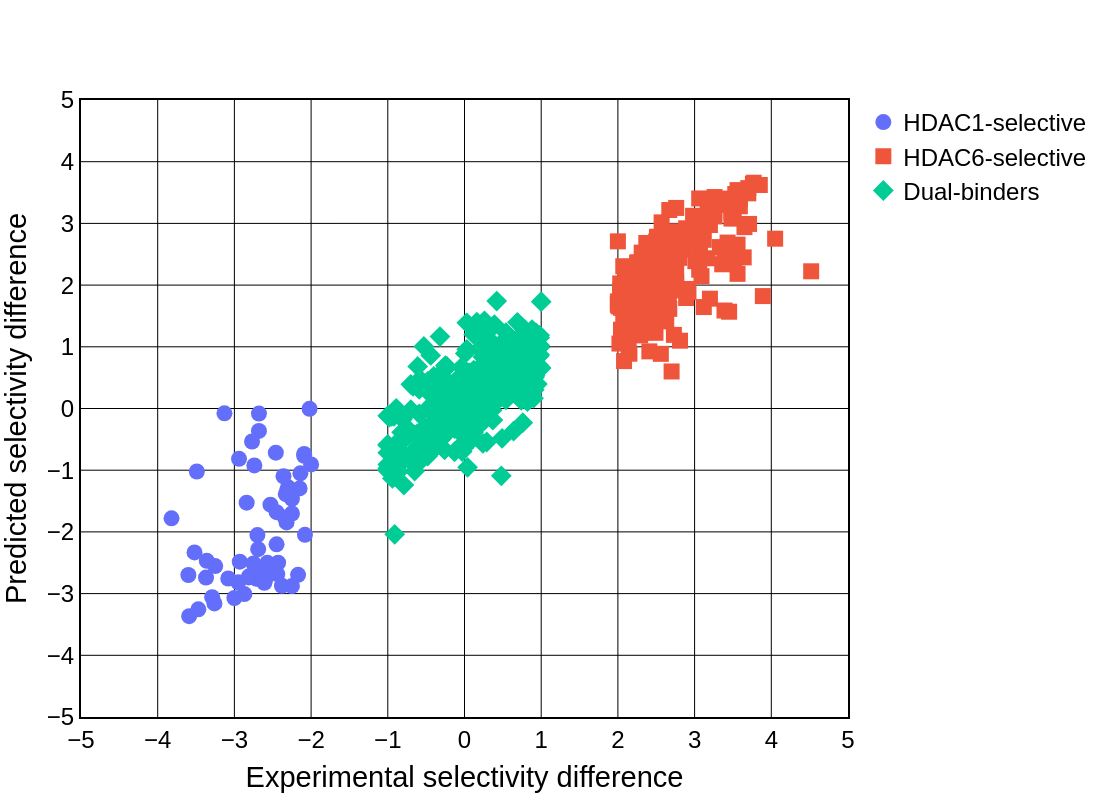

In [58]:
# plot hdac1-selective, hdac6-selective and dual selective compounds in predicted vs experimental plot
import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import iplot, init_notebook_mode
init_notebook_mode(connected=True)


#fig = px.scatter(df=HDAC1and6_ref_pred_DF_hdac1Sel, x="SelectivityWindow", y="RF", )
#fig.show() 

dfs = {"HDAC1-selective" : SW_reg_hdac1Sel, "HDAC6-selective": SW_reg_hdac6Sel, "Dual-binders" : SW_reg_dual}




# plot the data
fig = go.Figure()

for i in dfs:
    fig = fig.add_trace(go.Scatter(x = dfs[i]["SelectivityWindow"],
                                   y = dfs[i]["all_ave"], 
                                   name = i,mode="markers",marker=dict(size=16, symbol = dfs[i]['Marker']) ), )

fig.update_layout(
    autosize=False,
    width=1000,
    height=800,
    xaxis_title="Experimental selectivity difference",
    yaxis_title="Predicted selectivity difference",
    template= "plotly_white",
    
    font=dict(
        #family="Courier New, monospace",
        size=24,
        color="Black"
    )
) 
fig.update_xaxes(showline=True, linewidth=2, linecolor='black', dtick=1, showgrid=True, zeroline=True, mirror=True, zerolinecolor='black',
       zerolinewidth=1, gridwidth=1, gridcolor='black', range=[-5, 5])
fig.update_yaxes(showline=True, linewidth=2, linecolor='black', dtick=1, showgrid=True, zeroline=True, mirror=True, zerolinecolor='black',
       zerolinewidth=1, gridwidth=1, gridcolor='black', range=[-5, 5])

#fig.add_shape( # add a horizontal "target" line
#    type="line", line_color="salmon", line_width=3, opacity=1, line_dash="dot",
#    x0=-4, x1=5, y0=2, y1=2, )

#fig.update_layout({'plot_bgcolor': 'rgba(0, 0, 0, 0)', 'paper_bgcolor': 'rgba(0, 0, 0, 0)',
#})

fig.show()

In [59]:
SelWin_rf_DualSel = SelWin_rf.copy()
SelWin_rf_DualSel['selectivity'] = np.zeros(len(SelWin_rf_DualSel))
SelWin_rf_DualSel.loc[SelWin_rf_DualSel[SelWin_rf_DualSel['label'] == 'Dual-binder'].index, 'selectivity'] =1
#SelWin_rf_DualSel.loc[SelWin_rf_DualSel[SelWin_rf_DualSel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_rf_DualSel['Dual_sel_y_pred_rf0'] = np.zeros(len(SelWin_rf_DualSel))
SelWin_rf_DualSel.loc[SelWin_rf_DualSel[(SelWin_rf_DualSel['y_pred_rf0'] >= -1)  & (SelWin_rf_DualSel['y_pred_rf0'] <= 1)].index, 'Dual_sel_y_pred_rf0'] =1
SelWin_rf_DualSel['Dual_sel_y_pred_rf1'] = np.zeros(len(SelWin_rf_DualSel))
SelWin_rf_DualSel.loc[SelWin_rf_DualSel[(SelWin_rf_DualSel['y_pred_rf1'] >= -1)  & (SelWin_rf_DualSel['y_pred_rf1'] <= 1)].index, 'Dual_sel_y_pred_rf1'] =1
SelWin_rf_DualSel['Dual_sel_y_pred_rf2'] = np.zeros(len(SelWin_rf_DualSel))
SelWin_rf_DualSel.loc[SelWin_rf_DualSel[(SelWin_rf_DualSel['y_pred_rf2'] >= -1)  & (SelWin_rf_DualSel['y_pred_rf2'] <= 1)].index, 'Dual_sel_y_pred_rf2'] =1
SelWin_rf_DualSel['Dual_sel_y_pred_rf3'] = np.zeros(len(SelWin_rf_DualSel))
SelWin_rf_DualSel.loc[SelWin_rf_DualSel[(SelWin_rf_DualSel['y_pred_rf3'] >= -1)  & (SelWin_rf_DualSel['y_pred_rf3'] <= 1)].index, 'Dual_sel_y_pred_rf3'] =1
SelWin_rf_DualSel['Dual_sel_y_pred_rf4'] = np.zeros(len(SelWin_rf_DualSel))
SelWin_rf_DualSel.loc[SelWin_rf_DualSel[(SelWin_rf_DualSel['y_pred_rf4'] >= -1)  & (SelWin_rf_DualSel['y_pred_rf4'] <= 1)].index, 'Dual_sel_y_pred_rf4'] =1


SW_DualSel = SelWin_rf_DualSel['selectivity']
SW_DualSel_y_pred_rf0 = SelWin_rf_DualSel['Dual_sel_y_pred_rf0']
SW_DualSel_y_pred_rf1 = SelWin_rf_DualSel['Dual_sel_y_pred_rf1']
SW_DualSel_y_pred_rf2 = SelWin_rf_DualSel['Dual_sel_y_pred_rf2']
SW_DualSel_y_pred_rf3 = SelWin_rf_DualSel['Dual_sel_y_pred_rf3']
SW_DualSel_y_pred_rf4 = SelWin_rf_DualSel['Dual_sel_y_pred_rf4']
list_rf = [SW_DualSel_y_pred_rf0, SW_DualSel_y_pred_rf1, SW_DualSel_y_pred_rf2, SW_DualSel_y_pred_rf3, SW_DualSel_y_pred_rf4]

TP_DualSel_rf=np.zeros(5)
TN_DualSel_rf=np.zeros(5)
FP_DualSel_rf=np.zeros(5)
FN_DualSel_rf=np.zeros(5)
Accuracy_DualSel_rf=np.zeros(5)
Precision_DualSel_rf=np.zeros(5)
Sensitivity_DualSel_rf=np.zeros(5)
Specificity_DualSel_rf=np.zeros(5)
f1_scores_DualSel_rf=np.zeros(5)
f1_scores_DualSel_rf=np.zeros(5)
f1_scores_M_DualSel_rf=np.zeros(5)
BA_scores_DualSel_rf=np.zeros(5)
MCC_DualSel_rf=np.zeros(5)
NPV_DualSel_rf=np.zeros(5)
ROC_AUC_DualSel_rf=np.zeros(5)

for i, df in enumerate(list_rf):
    df = list_rf[i]
    conf_matrix_DualSel_rf=confusion_matrix(SW_DualSel, df)
    TP_DualSel_rf[i] = conf_matrix_DualSel_rf[1][1]
    TN_DualSel_rf[i] = conf_matrix_DualSel_rf[0][0]
    FP_DualSel_rf[i] = conf_matrix_DualSel_rf[0][1] 
    FN_DualSel_rf[i] = conf_matrix_DualSel_rf[1][0]
    Accuracy_DualSel_rf[i] = accuracy_score(SW_DualSel,df)
    Precision_DualSel_rf[i] = precision_score(SW_DualSel, df)
    Sensitivity_DualSel_rf[i] = recall_score(SW_DualSel, df)
    Specificity_DualSel_rf[i] = round( TN_DualSel_rf[i] / (TN_DualSel_rf[i]+FP_DualSel_rf[i]),4 )
    f1_scores_DualSel_rf[i] = f1_score(SW_DualSel, df)
    f1_scores_M_DualSel_rf[i] = f1_score(SW_DualSel, df, average="macro")
    BA_scores_DualSel_rf[i] = balanced_accuracy_score(SW_DualSel, df)
    MCC_DualSel_rf[i] = matthews_corrcoef(SW_DualSel, df)
    NPV_DualSel_rf[i] = round( TN_DualSel_rf[i] / (TN_DualSel_rf[i]+FN_DualSel_rf[i]),4 )
    ROC_AUC_DualSel_rf[i] = roc_auc_score(SW_DualSel, df)

mat_met_SW_rf = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],     
                'RF(Dual-binder)':[np.mean(TP_DualSel_rf),np.mean(TN_DualSel_rf),np.mean(FP_DualSel_rf),
                 np.mean(FN_DualSel_rf),np.mean(Accuracy_DualSel_rf),np.mean(Precision_DualSel_rf),
                 np.mean(Sensitivity_DualSel_rf),np.mean(Specificity_DualSel_rf),np.mean(f1_scores_DualSel_rf),
                 np.mean(f1_scores_M_DualSel_rf), np.mean(BA_scores_DualSel_rf),np.mean(MCC_DualSel_rf),
                 np.mean(NPV_DualSel_rf), np.mean(ROC_AUC_DualSel_rf)],
                'RF_std(Dual-binder)':[np.std(TP_DualSel_rf, ddof=1),np.std(TN_DualSel_rf,ddof=1),
                 np.std(FP_DualSel_rf,ddof=1),np.std(FN_DualSel_rf,ddof=1),np.std(Accuracy_DualSel_rf,ddof=1),
                 np.std(Precision_DualSel_rf,ddof=1),np.std(Sensitivity_DualSel_rf,ddof=1),np.std(Specificity_DualSel_rf,ddof=1),
                 np.std(f1_scores_DualSel_rf),np.std(f1_scores_M_DualSel_rf),np.std(BA_scores_DualSel_rf,ddof=1),
                 np.std(MCC_DualSel_rf,ddof=1), np.std(NPV_DualSel_rf,ddof=1), np.std(ROC_AUC_DualSel_rf, ddof=1)],      
                       }) 
    
SelWin_rf_HDAC1Sel = SelWin_rf.copy()
SelWin_rf_HDAC1Sel['selectivity'] = np.zeros(len(SelWin_rf_HDAC1Sel))
SelWin_rf_HDAC1Sel.loc[SelWin_rf_HDAC1Sel[SelWin_rf_HDAC1Sel['label'] == 'HDAC1-selective'].index, 'selectivity'] =1
#SelWin_rf_HDAC1Sel.loc[SelWin_rf_HDAC1Sel[SelWin_rf_HDAC1Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_rf_HDAC1Sel['HDAC1_sel_y_pred_rf0'] = np.zeros(len(SelWin_rf_HDAC1Sel))
SelWin_rf_HDAC1Sel.loc[SelWin_rf_HDAC1Sel[(SelWin_rf_HDAC1Sel['y_pred_rf0'] <= -2)].index, 'HDAC1_sel_y_pred_rf0'] =1
SelWin_rf_HDAC1Sel['HDAC1_sel_y_pred_rf1'] = np.zeros(len(SelWin_rf_HDAC1Sel))
SelWin_rf_HDAC1Sel.loc[SelWin_rf_HDAC1Sel[ (SelWin_rf_HDAC1Sel['y_pred_rf1'] <= -2)].index, 'HDAC1_sel_y_pred_rf1'] =1
SelWin_rf_HDAC1Sel['HDAC1_sel_y_pred_rf2'] = np.zeros(len(SelWin_rf_HDAC1Sel))
SelWin_rf_HDAC1Sel.loc[SelWin_rf_HDAC1Sel[ (SelWin_rf_HDAC1Sel['y_pred_rf2'] <= -2)].index, 'HDAC1_sel_y_pred_rf2'] =1
SelWin_rf_HDAC1Sel['HDAC1_sel_y_pred_rf3'] = np.zeros(len(SelWin_rf_HDAC1Sel))
SelWin_rf_HDAC1Sel.loc[SelWin_rf_HDAC1Sel[(SelWin_rf_HDAC1Sel['y_pred_rf3'] <= -2)].index, 'HDAC1_sel_y_pred_rf3'] =1
SelWin_rf_HDAC1Sel['HDAC1_sel_y_pred_rf4'] = np.zeros(len(SelWin_rf_HDAC1Sel))
SelWin_rf_HDAC1Sel.loc[SelWin_rf_HDAC1Sel[(SelWin_rf_HDAC1Sel['y_pred_rf4'] <= -2)].index, 'HDAC1_sel_y_pred_rf4'] =1


SW_HDAC1Sel = SelWin_rf_HDAC1Sel['selectivity']
SW_HDAC1Sel_y_pred_rf0 = SelWin_rf_HDAC1Sel['HDAC1_sel_y_pred_rf0']
SW_HDAC1Sel_y_pred_rf1 = SelWin_rf_HDAC1Sel['HDAC1_sel_y_pred_rf1']
SW_HDAC1Sel_y_pred_rf2 = SelWin_rf_HDAC1Sel['HDAC1_sel_y_pred_rf2']
SW_HDAC1Sel_y_pred_rf3 = SelWin_rf_HDAC1Sel['HDAC1_sel_y_pred_rf3']
SW_HDAC1Sel_y_pred_rf4 = SelWin_rf_HDAC1Sel['HDAC1_sel_y_pred_rf4']
list_rf = [SW_HDAC1Sel_y_pred_rf0, SW_HDAC1Sel_y_pred_rf1, SW_HDAC1Sel_y_pred_rf2, SW_HDAC1Sel_y_pred_rf3, SW_HDAC1Sel_y_pred_rf4]

TP_HDAC1Sel_rf=np.zeros(5)
TN_HDAC1Sel_rf=np.zeros(5)
FP_HDAC1Sel_rf=np.zeros(5)
FN_HDAC1Sel_rf=np.zeros(5)
Accuracy_HDAC1Sel_rf=np.zeros(5)
Precision_HDAC1Sel_rf=np.zeros(5)
Sensitivity_HDAC1Sel_rf=np.zeros(5)
Specificity_HDAC1Sel_rf=np.zeros(5)
f1_scores_HDAC1Sel_rf=np.zeros(5)
f1_scores_HDAC1Sel_rf=np.zeros(5)
f1_scores_M_HDAC1Sel_rf=np.zeros(5)
BA_scores_HDAC1Sel_rf=np.zeros(5)
MCC_HDAC1Sel_rf=np.zeros(5)
NPV_HDAC1Sel_rf=np.zeros(5)
ROC_AUC_HDAC1Sel_rf=np.zeros(5)

for i, df in enumerate(list_rf):
    df = list_rf[i]
    conf_matrix_HDAC1Sel_rf=confusion_matrix(SW_HDAC1Sel, df)
    TP_HDAC1Sel_rf[i] = conf_matrix_HDAC1Sel_rf[1][1]
    TN_HDAC1Sel_rf[i] = conf_matrix_HDAC1Sel_rf[0][0]
    FP_HDAC1Sel_rf[i] = conf_matrix_HDAC1Sel_rf[0][1] 
    FN_HDAC1Sel_rf[i] = conf_matrix_HDAC1Sel_rf[1][0]
    Accuracy_HDAC1Sel_rf[i] = accuracy_score(SW_HDAC1Sel,df)
    Precision_HDAC1Sel_rf[i] = precision_score(SW_HDAC1Sel, df)
    Sensitivity_HDAC1Sel_rf[i] = recall_score(SW_HDAC1Sel, df)
    Specificity_HDAC1Sel_rf[i] = round( TN_HDAC1Sel_rf[i] / (TN_HDAC1Sel_rf[i]+FP_HDAC1Sel_rf[i]),4 )
    f1_scores_HDAC1Sel_rf[i] = f1_score(SW_HDAC1Sel, df)
    f1_scores_M_HDAC1Sel_rf[i] = f1_score(SW_HDAC1Sel, df, average="macro")
    BA_scores_HDAC1Sel_rf[i] = balanced_accuracy_score(SW_HDAC1Sel, df)
    MCC_HDAC1Sel_rf[i] = matthews_corrcoef(SW_HDAC1Sel, df)
    NPV_HDAC1Sel_rf[i] = round( TN_HDAC1Sel_rf[i] / (TN_HDAC1Sel_rf[i]+FN_HDAC1Sel_rf[i]),4 )
    ROC_AUC_HDAC1Sel_rf[i] = roc_auc_score(SW_HDAC1Sel, df)

HDAC1_SW_rf_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'RF(HDAC1-binder)':[np.mean(TP_HDAC1Sel_rf),np.mean(TN_HDAC1Sel_rf),np.mean(FP_HDAC1Sel_rf),
                 np.mean(FN_HDAC1Sel_rf),np.mean(Accuracy_HDAC1Sel_rf),np.mean(Precision_HDAC1Sel_rf),
                 np.mean(Sensitivity_HDAC1Sel_rf),np.mean(Specificity_HDAC1Sel_rf),np.mean(f1_scores_HDAC1Sel_rf),
                 np.mean(f1_scores_M_HDAC1Sel_rf), np.mean(BA_scores_HDAC1Sel_rf),np.mean(MCC_HDAC1Sel_rf),
                 np.mean(NPV_HDAC1Sel_rf), np.mean(ROC_AUC_HDAC1Sel_rf)],
                'RF_std(HDAC1-binder)':[np.std(TP_HDAC1Sel_rf, ddof=1),np.std(TN_HDAC1Sel_rf,ddof=1),
                 np.std(FP_HDAC1Sel_rf,ddof=1),np.std(FN_HDAC1Sel_rf,ddof=1),np.std(Accuracy_HDAC1Sel_rf,ddof=1),
                 np.std(Precision_HDAC1Sel_rf,ddof=1),np.std(Sensitivity_HDAC1Sel_rf,ddof=1),np.std(Specificity_HDAC1Sel_rf,ddof=1),
                 np.std(f1_scores_HDAC1Sel_rf),np.std(f1_scores_M_HDAC1Sel_rf),np.std(BA_scores_HDAC1Sel_rf,ddof=1),
                 np.std(MCC_HDAC1Sel_rf,ddof=1), np.std(NPV_HDAC1Sel_rf,ddof=1), np.std(ROC_AUC_HDAC1Sel_rf, ddof=1)],      
                       }) 
    

mat_met_SW_rf = mat_met_SW_rf.merge(HDAC1_SW_rf_ave, on='Metric')
SelWin_rf_HDAC6Sel = SelWin_rf.copy()
SelWin_rf_HDAC6Sel['selectivity'] = np.zeros(len(SelWin_rf_HDAC6Sel))
SelWin_rf_HDAC6Sel.loc[SelWin_rf_HDAC6Sel[SelWin_rf_HDAC6Sel['label'] == 'HDAC6-selective'].index, 'selectivity'] =1
#SelWin_rf_HDAC6Sel.loc[SelWin_rf_HDAC6Sel[SelWin_rf_HDAC6Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_rf_HDAC6Sel['HDAC6_sel_y_pred_rf0'] = np.zeros(len(SelWin_rf_HDAC6Sel))
SelWin_rf_HDAC6Sel.loc[SelWin_rf_HDAC6Sel[(SelWin_rf_HDAC6Sel['y_pred_rf0'] >= 2)].index, 'HDAC6_sel_y_pred_rf0'] =1
SelWin_rf_HDAC6Sel['HDAC6_sel_y_pred_rf1'] = np.zeros(len(SelWin_rf_HDAC6Sel))
SelWin_rf_HDAC6Sel.loc[SelWin_rf_HDAC6Sel[ (SelWin_rf_HDAC6Sel['y_pred_rf1'] >= 2)].index, 'HDAC6_sel_y_pred_rf1'] =1
SelWin_rf_HDAC6Sel['HDAC6_sel_y_pred_rf2'] = np.zeros(len(SelWin_rf_HDAC6Sel))
SelWin_rf_HDAC6Sel.loc[SelWin_rf_HDAC6Sel[ (SelWin_rf_HDAC6Sel['y_pred_rf2'] >= 2)].index, 'HDAC6_sel_y_pred_rf2'] =1
SelWin_rf_HDAC6Sel['HDAC6_sel_y_pred_rf3'] = np.zeros(len(SelWin_rf_HDAC6Sel))
SelWin_rf_HDAC6Sel.loc[SelWin_rf_HDAC6Sel[(SelWin_rf_HDAC6Sel['y_pred_rf3'] >= 2)].index, 'HDAC6_sel_y_pred_rf3'] =1
SelWin_rf_HDAC6Sel['HDAC6_sel_y_pred_rf4'] = np.zeros(len(SelWin_rf_HDAC6Sel))
SelWin_rf_HDAC6Sel.loc[SelWin_rf_HDAC6Sel[(SelWin_rf_HDAC6Sel['y_pred_rf4'] >= 2)].index, 'HDAC6_sel_y_pred_rf4'] =1


SW_HDAC6Sel = SelWin_rf_HDAC6Sel['selectivity']
SW_HDAC6Sel_y_pred_rf0 = SelWin_rf_HDAC6Sel['HDAC6_sel_y_pred_rf0']
SW_HDAC6Sel_y_pred_rf1 = SelWin_rf_HDAC6Sel['HDAC6_sel_y_pred_rf1']
SW_HDAC6Sel_y_pred_rf2 = SelWin_rf_HDAC6Sel['HDAC6_sel_y_pred_rf2']
SW_HDAC6Sel_y_pred_rf3 = SelWin_rf_HDAC6Sel['HDAC6_sel_y_pred_rf3']
SW_HDAC6Sel_y_pred_rf4 = SelWin_rf_HDAC6Sel['HDAC6_sel_y_pred_rf4']
list_rf = [SW_HDAC6Sel_y_pred_rf0, SW_HDAC6Sel_y_pred_rf1, SW_HDAC6Sel_y_pred_rf2, SW_HDAC6Sel_y_pred_rf3, SW_HDAC6Sel_y_pred_rf4]

TP_HDAC6Sel_rf=np.zeros(5)
TN_HDAC6Sel_rf=np.zeros(5)
FP_HDAC6Sel_rf=np.zeros(5)
FN_HDAC6Sel_rf=np.zeros(5)
Accuracy_HDAC6Sel_rf=np.zeros(5)
Precision_HDAC6Sel_rf=np.zeros(5)
Sensitivity_HDAC6Sel_rf=np.zeros(5)
Specificity_HDAC6Sel_rf=np.zeros(5)
f1_scores_HDAC6Sel_rf=np.zeros(5)
f1_scores_HDAC6Sel_rf=np.zeros(5)
f1_scores_M_HDAC6Sel_rf=np.zeros(5)
BA_scores_HDAC6Sel_rf=np.zeros(5)
MCC_HDAC6Sel_rf=np.zeros(5)
NPV_HDAC6Sel_rf=np.zeros(5)
ROC_AUC_HDAC6Sel_rf=np.zeros(5)

for i, df in enumerate(list_rf):
    df = list_rf[i]
    conf_matrix_HDAC6Sel_rf=confusion_matrix(SW_HDAC6Sel, df)
    TP_HDAC6Sel_rf[i] = conf_matrix_HDAC6Sel_rf[1][1]
    TN_HDAC6Sel_rf[i] = conf_matrix_HDAC6Sel_rf[0][0]
    FP_HDAC6Sel_rf[i] = conf_matrix_HDAC6Sel_rf[0][1] 
    FN_HDAC6Sel_rf[i] = conf_matrix_HDAC6Sel_rf[1][0]
    Accuracy_HDAC6Sel_rf[i] = accuracy_score(SW_HDAC6Sel,df)
    Precision_HDAC6Sel_rf[i] = precision_score(SW_HDAC6Sel, df)
    Sensitivity_HDAC6Sel_rf[i] = recall_score(SW_HDAC6Sel, df)
    Specificity_HDAC6Sel_rf[i] = round( TN_HDAC6Sel_rf[i] / (TN_HDAC6Sel_rf[i]+FP_HDAC6Sel_rf[i]),4 )
    f1_scores_HDAC6Sel_rf[i] = f1_score(SW_HDAC6Sel, df)
    f1_scores_M_HDAC6Sel_rf[i] = f1_score(SW_HDAC6Sel, df, average="macro")
    BA_scores_HDAC6Sel_rf[i] = balanced_accuracy_score(SW_HDAC6Sel, df)
    MCC_HDAC6Sel_rf[i] = matthews_corrcoef(SW_HDAC6Sel, df)
    NPV_HDAC6Sel_rf[i] = round( TN_HDAC6Sel_rf[i] / (TN_HDAC6Sel_rf[i]+FN_HDAC6Sel_rf[i]),4 )
    ROC_AUC_HDAC6Sel_rf[i] = roc_auc_score(SW_HDAC6Sel, df)

HDAC6_SW_rf_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'RF(HDAC6-binder)':[np.mean(TP_HDAC6Sel_rf),np.mean(TN_HDAC6Sel_rf),np.mean(FP_HDAC6Sel_rf),
                 np.mean(FN_HDAC6Sel_rf),np.mean(Accuracy_HDAC6Sel_rf),np.mean(Precision_HDAC6Sel_rf),
                 np.mean(Sensitivity_HDAC6Sel_rf),np.mean(Specificity_HDAC6Sel_rf),np.mean(f1_scores_HDAC6Sel_rf),
                 np.mean(f1_scores_M_HDAC6Sel_rf), np.mean(BA_scores_HDAC6Sel_rf),np.mean(MCC_HDAC6Sel_rf),
                 np.mean(NPV_HDAC6Sel_rf), np.mean(ROC_AUC_HDAC6Sel_rf)],
                'RF_std(HDAC6-binder)':[np.std(TP_HDAC6Sel_rf, ddof=1),np.std(TN_HDAC6Sel_rf,ddof=1),
                 np.std(FP_HDAC6Sel_rf,ddof=1),np.std(FN_HDAC6Sel_rf,ddof=1),np.std(Accuracy_HDAC6Sel_rf,ddof=1),
                 np.std(Precision_HDAC6Sel_rf,ddof=1),np.std(Sensitivity_HDAC6Sel_rf,ddof=1),np.std(Specificity_HDAC6Sel_rf,ddof=1),
                 np.std(f1_scores_HDAC6Sel_rf),np.std(f1_scores_M_HDAC6Sel_rf),np.std(BA_scores_HDAC6Sel_rf,ddof=1),
                 np.std(MCC_HDAC6Sel_rf,ddof=1), np.std(NPV_HDAC6Sel_rf,ddof=1), np.std(ROC_AUC_HDAC6Sel_rf, ddof=1)],      
                       }) 
    

mat_met_SW_rf = mat_met_SW_rf.merge(HDAC6_SW_rf_ave, on='Metric')
mat_met_SW_rf


,Metric,RF(Dual-binder),RF_std(Dual-binder),RF(HDAC1-binder),RF_std(HDAC1-binder),RF(HDAC6-binder),RF_std(HDAC6-binder)
0,TP,474.600000,1.140175,31.600000,1.673320,137.800000,1.303840
1,TN,640.800000,2.949576,1846.000000,0.000000,1615.400000,2.607681
2,FP,737.200000,2.949576,3.000000,0.000000,27.600000,2.607681
3,FN,57.400000,1.140175,29.400000,1.673320,129.200000,1.303840
4,Accuracy,0.583979,0.001365,0.983037,0.000876,0.917906,0.002041
5,Precision,0.391650,0.000846,0.913127,0.004346,0.833225,0.014586
6,Sensitivity,0.892105,0.002143,0.518033,0.027431,0.516105,0.004883
7,Specificity,0.465020,0.002146,0.998400,0.000000,0.983180,0.001605
8,F1 score,0.544329,0.000857,0.660756,0.021214,0.637392,0.007114
9,F1 score (macro),0.580804,0.001135,0.826028,0.010806,0.795553,0.004079


In [60]:
SelWin_lgbm_DualSel = SelWin_lgbm.copy()
SelWin_lgbm_DualSel['selectivity'] = np.zeros(len(SelWin_lgbm_DualSel))
SelWin_lgbm_DualSel.loc[SelWin_lgbm_DualSel[SelWin_lgbm_DualSel['label'] == 'Dual-binder'].index, 'selectivity'] =1
#SelWin_lgbm_DualSel.loc[SelWin_lgbm_DualSel[SelWin_lgbm_DualSel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_lgbm_DualSel['Dual_sel_y_pred_lgbm0'] = np.zeros(len(SelWin_lgbm_DualSel))
SelWin_lgbm_DualSel.loc[SelWin_lgbm_DualSel[(SelWin_lgbm_DualSel['y_pred_lgbm0'] >= -1)  & (SelWin_lgbm_DualSel['y_pred_lgbm0'] <= 1)].index, 'Dual_sel_y_pred_lgbm0'] =1
SelWin_lgbm_DualSel['Dual_sel_y_pred_lgbm1'] = np.zeros(len(SelWin_lgbm_DualSel))
SelWin_lgbm_DualSel.loc[SelWin_lgbm_DualSel[(SelWin_lgbm_DualSel['y_pred_lgbm1'] >= -1)  & (SelWin_lgbm_DualSel['y_pred_lgbm1'] <= 1)].index, 'Dual_sel_y_pred_lgbm1'] =1
SelWin_lgbm_DualSel['Dual_sel_y_pred_lgbm2'] = np.zeros(len(SelWin_lgbm_DualSel))
SelWin_lgbm_DualSel.loc[SelWin_lgbm_DualSel[(SelWin_lgbm_DualSel['y_pred_lgbm2'] >= -1)  & (SelWin_lgbm_DualSel['y_pred_lgbm2'] <= 1)].index, 'Dual_sel_y_pred_lgbm2'] =1
SelWin_lgbm_DualSel['Dual_sel_y_pred_lgbm3'] = np.zeros(len(SelWin_lgbm_DualSel))
SelWin_lgbm_DualSel.loc[SelWin_lgbm_DualSel[(SelWin_lgbm_DualSel['y_pred_lgbm3'] >= -1)  & (SelWin_lgbm_DualSel['y_pred_lgbm3'] <= 1)].index, 'Dual_sel_y_pred_lgbm3'] =1
SelWin_lgbm_DualSel['Dual_sel_y_pred_lgbm4'] = np.zeros(len(SelWin_lgbm_DualSel))
SelWin_lgbm_DualSel.loc[SelWin_lgbm_DualSel[(SelWin_lgbm_DualSel['y_pred_lgbm4'] >= -1)  & (SelWin_lgbm_DualSel['y_pred_lgbm4'] <= 1)].index, 'Dual_sel_y_pred_lgbm4'] =1


SW_DualSel = SelWin_lgbm_DualSel['selectivity']
SW_DualSel_y_pred_lgbm0 = SelWin_lgbm_DualSel['Dual_sel_y_pred_lgbm0']
SW_DualSel_y_pred_lgbm1 = SelWin_lgbm_DualSel['Dual_sel_y_pred_lgbm1']
SW_DualSel_y_pred_lgbm2 = SelWin_lgbm_DualSel['Dual_sel_y_pred_lgbm2']
SW_DualSel_y_pred_lgbm3 = SelWin_lgbm_DualSel['Dual_sel_y_pred_lgbm3']
SW_DualSel_y_pred_lgbm4 = SelWin_lgbm_DualSel['Dual_sel_y_pred_lgbm4']
list_lgbm = [SW_DualSel_y_pred_lgbm0, SW_DualSel_y_pred_lgbm1, SW_DualSel_y_pred_lgbm2, SW_DualSel_y_pred_lgbm3, SW_DualSel_y_pred_lgbm4]

TP_DualSel_lgbm=np.zeros(5)
TN_DualSel_lgbm=np.zeros(5)
FP_DualSel_lgbm=np.zeros(5)
FN_DualSel_lgbm=np.zeros(5)
Accuracy_DualSel_lgbm=np.zeros(5)
Precision_DualSel_lgbm=np.zeros(5)
Sensitivity_DualSel_lgbm=np.zeros(5)
Specificity_DualSel_lgbm=np.zeros(5)
f1_scores_DualSel_lgbm=np.zeros(5)
f1_scores_DualSel_lgbm=np.zeros(5)
f1_scores_M_DualSel_lgbm=np.zeros(5)
BA_scores_DualSel_lgbm=np.zeros(5)
MCC_DualSel_lgbm=np.zeros(5)
NPV_DualSel_lgbm=np.zeros(5)
ROC_AUC_DualSel_lgbm=np.zeros(5)

for i, df in enumerate(list_lgbm):
    df = list_lgbm[i]
    conf_matrix_DualSel_lgbm=confusion_matrix(SW_DualSel, df)
    TP_DualSel_lgbm[i] = conf_matrix_DualSel_lgbm[1][1]
    TN_DualSel_lgbm[i] = conf_matrix_DualSel_lgbm[0][0]
    FP_DualSel_lgbm[i] = conf_matrix_DualSel_lgbm[0][1] 
    FN_DualSel_lgbm[i] = conf_matrix_DualSel_lgbm[1][0]
    Accuracy_DualSel_lgbm[i] = accuracy_score(SW_DualSel,df)
    Precision_DualSel_lgbm[i] = precision_score(SW_DualSel, df)
    Sensitivity_DualSel_lgbm[i] = recall_score(SW_DualSel, df)
    Specificity_DualSel_lgbm[i] = round( TN_DualSel_lgbm[i] / (TN_DualSel_lgbm[i]+FP_DualSel_lgbm[i]),4 )
    f1_scores_DualSel_lgbm[i] = f1_score(SW_DualSel, df)
    f1_scores_M_DualSel_lgbm[i] = f1_score(SW_DualSel, df, average="macro")
    BA_scores_DualSel_lgbm[i] = balanced_accuracy_score(SW_DualSel, df)
    MCC_DualSel_lgbm[i] = matthews_corrcoef(SW_DualSel, df)
    NPV_DualSel_lgbm[i] = round( TN_DualSel_lgbm[i] / (TN_DualSel_lgbm[i]+FN_DualSel_lgbm[i]),4 )
    ROC_AUC_DualSel_lgbm[i] = roc_auc_score(SW_DualSel, df)

mat_met_SW_lgbm = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],     
                'LGBM(Dual-binder)':[np.mean(TP_DualSel_lgbm),np.mean(TN_DualSel_lgbm),np.mean(FP_DualSel_lgbm),
                 np.mean(FN_DualSel_lgbm),np.mean(Accuracy_DualSel_lgbm),np.mean(Precision_DualSel_lgbm),
                 np.mean(Sensitivity_DualSel_lgbm),np.mean(Specificity_DualSel_lgbm),np.mean(f1_scores_DualSel_lgbm),
                 np.mean(f1_scores_M_DualSel_lgbm), np.mean(BA_scores_DualSel_lgbm),np.mean(MCC_DualSel_lgbm),
                 np.mean(NPV_DualSel_lgbm), np.mean(ROC_AUC_DualSel_lgbm)],
                'LGBM_std(Dual-binder)':[np.std(TP_DualSel_lgbm, ddof=1),np.std(TN_DualSel_lgbm,ddof=1),
                 np.std(FP_DualSel_lgbm,ddof=1),np.std(FN_DualSel_lgbm,ddof=1),np.std(Accuracy_DualSel_lgbm,ddof=1),
                 np.std(Precision_DualSel_lgbm,ddof=1),np.std(Sensitivity_DualSel_lgbm,ddof=1),np.std(Specificity_DualSel_lgbm,ddof=1),
                 np.std(f1_scores_DualSel_lgbm),np.std(f1_scores_M_DualSel_lgbm),np.std(BA_scores_DualSel_lgbm,ddof=1),
                 np.std(MCC_DualSel_lgbm,ddof=1), np.std(NPV_DualSel_lgbm,ddof=1), np.std(ROC_AUC_DualSel_lgbm, ddof=1)],      
                       }) 
    
SelWin_lgbm_HDAC1Sel = SelWin_lgbm.copy()
SelWin_lgbm_HDAC1Sel['selectivity'] = np.zeros(len(SelWin_lgbm_HDAC1Sel))
SelWin_lgbm_HDAC1Sel.loc[SelWin_lgbm_HDAC1Sel[SelWin_lgbm_HDAC1Sel['label'] == 'HDAC1-selective'].index, 'selectivity'] =1
#SelWin_lgbm_HDAC1Sel.loc[SelWin_lgbm_HDAC1Sel[SelWin_lgbm_HDAC1Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_lgbm_HDAC1Sel['HDAC1_sel_y_pred_lgbm0'] = np.zeros(len(SelWin_lgbm_HDAC1Sel))
SelWin_lgbm_HDAC1Sel.loc[SelWin_lgbm_HDAC1Sel[(SelWin_lgbm_HDAC1Sel['y_pred_lgbm0'] <= -2)].index, 'HDAC1_sel_y_pred_lgbm0'] =1
SelWin_lgbm_HDAC1Sel['HDAC1_sel_y_pred_lgbm1'] = np.zeros(len(SelWin_lgbm_HDAC1Sel))
SelWin_lgbm_HDAC1Sel.loc[SelWin_lgbm_HDAC1Sel[ (SelWin_lgbm_HDAC1Sel['y_pred_lgbm1'] <= -2)].index, 'HDAC1_sel_y_pred_lgbm1'] =1
SelWin_lgbm_HDAC1Sel['HDAC1_sel_y_pred_lgbm2'] = np.zeros(len(SelWin_lgbm_HDAC1Sel))
SelWin_lgbm_HDAC1Sel.loc[SelWin_lgbm_HDAC1Sel[ (SelWin_lgbm_HDAC1Sel['y_pred_lgbm2'] <= -2)].index, 'HDAC1_sel_y_pred_lgbm2'] =1
SelWin_lgbm_HDAC1Sel['HDAC1_sel_y_pred_lgbm3'] = np.zeros(len(SelWin_lgbm_HDAC1Sel))
SelWin_lgbm_HDAC1Sel.loc[SelWin_lgbm_HDAC1Sel[(SelWin_lgbm_HDAC1Sel['y_pred_lgbm3'] <= -2)].index, 'HDAC1_sel_y_pred_lgbm3'] =1
SelWin_lgbm_HDAC1Sel['HDAC1_sel_y_pred_lgbm4'] = np.zeros(len(SelWin_lgbm_HDAC1Sel))
SelWin_lgbm_HDAC1Sel.loc[SelWin_lgbm_HDAC1Sel[(SelWin_lgbm_HDAC1Sel['y_pred_lgbm4'] <= -2)].index, 'HDAC1_sel_y_pred_lgbm4'] =1


SW_HDAC1Sel = SelWin_lgbm_HDAC1Sel['selectivity']
SW_HDAC1Sel_y_pred_lgbm0 = SelWin_lgbm_HDAC1Sel['HDAC1_sel_y_pred_lgbm0']
SW_HDAC1Sel_y_pred_lgbm1 = SelWin_lgbm_HDAC1Sel['HDAC1_sel_y_pred_lgbm1']
SW_HDAC1Sel_y_pred_lgbm2 = SelWin_lgbm_HDAC1Sel['HDAC1_sel_y_pred_lgbm2']
SW_HDAC1Sel_y_pred_lgbm3 = SelWin_lgbm_HDAC1Sel['HDAC1_sel_y_pred_lgbm3']
SW_HDAC1Sel_y_pred_lgbm4 = SelWin_lgbm_HDAC1Sel['HDAC1_sel_y_pred_lgbm4']
list_lgbm = [SW_HDAC1Sel_y_pred_lgbm0, SW_HDAC1Sel_y_pred_lgbm1, SW_HDAC1Sel_y_pred_lgbm2, SW_HDAC1Sel_y_pred_lgbm3, SW_HDAC1Sel_y_pred_lgbm4]

TP_HDAC1Sel_lgbm=np.zeros(5)
TN_HDAC1Sel_lgbm=np.zeros(5)
FP_HDAC1Sel_lgbm=np.zeros(5)
FN_HDAC1Sel_lgbm=np.zeros(5)
Accuracy_HDAC1Sel_lgbm=np.zeros(5)
Precision_HDAC1Sel_lgbm=np.zeros(5)
Sensitivity_HDAC1Sel_lgbm=np.zeros(5)
Specificity_HDAC1Sel_lgbm=np.zeros(5)
f1_scores_HDAC1Sel_lgbm=np.zeros(5)
f1_scores_HDAC1Sel_lgbm=np.zeros(5)
f1_scores_M_HDAC1Sel_lgbm=np.zeros(5)
BA_scores_HDAC1Sel_lgbm=np.zeros(5)
MCC_HDAC1Sel_lgbm=np.zeros(5)
NPV_HDAC1Sel_lgbm=np.zeros(5)
ROC_AUC_HDAC1Sel_lgbm=np.zeros(5)

for i, df in enumerate(list_lgbm):
    df = list_lgbm[i]
    conf_matrix_HDAC1Sel_lgbm=confusion_matrix(SW_HDAC1Sel, df)
    TP_HDAC1Sel_lgbm[i] = conf_matrix_HDAC1Sel_lgbm[1][1]
    TN_HDAC1Sel_lgbm[i] = conf_matrix_HDAC1Sel_lgbm[0][0]
    FP_HDAC1Sel_lgbm[i] = conf_matrix_HDAC1Sel_lgbm[0][1] 
    FN_HDAC1Sel_lgbm[i] = conf_matrix_HDAC1Sel_lgbm[1][0]
    Accuracy_HDAC1Sel_lgbm[i] = accuracy_score(SW_HDAC1Sel,df)
    Precision_HDAC1Sel_lgbm[i] = precision_score(SW_HDAC1Sel, df)
    Sensitivity_HDAC1Sel_lgbm[i] = recall_score(SW_HDAC1Sel, df)
    Specificity_HDAC1Sel_lgbm[i] = round( TN_HDAC1Sel_lgbm[i] / (TN_HDAC1Sel_lgbm[i]+FP_HDAC1Sel_lgbm[i]),4 )
    f1_scores_HDAC1Sel_lgbm[i] = f1_score(SW_HDAC1Sel, df)
    f1_scores_M_HDAC1Sel_lgbm[i] = f1_score(SW_HDAC1Sel, df, average="macro")
    BA_scores_HDAC1Sel_lgbm[i] = balanced_accuracy_score(SW_HDAC1Sel, df)
    MCC_HDAC1Sel_lgbm[i] = matthews_corrcoef(SW_HDAC1Sel, df)
    NPV_HDAC1Sel_lgbm[i] = round( TN_HDAC1Sel_lgbm[i] / (TN_HDAC1Sel_lgbm[i]+FN_HDAC1Sel_lgbm[i]),4 )
    ROC_AUC_HDAC1Sel_lgbm[i] = roc_auc_score(SW_HDAC1Sel, df)

HDAC1_SW_lgbm_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'LGBM(HDAC1-binder)':[np.mean(TP_HDAC1Sel_lgbm),np.mean(TN_HDAC1Sel_lgbm),np.mean(FP_HDAC1Sel_lgbm),
                 np.mean(FN_HDAC1Sel_lgbm),np.mean(Accuracy_HDAC1Sel_lgbm),np.mean(Precision_HDAC1Sel_lgbm),
                 np.mean(Sensitivity_HDAC1Sel_lgbm),np.mean(Specificity_HDAC1Sel_lgbm),np.mean(f1_scores_HDAC1Sel_lgbm),
                 np.mean(f1_scores_M_HDAC1Sel_lgbm), np.mean(BA_scores_HDAC1Sel_lgbm),np.mean(MCC_HDAC1Sel_lgbm),
                 np.mean(NPV_HDAC1Sel_lgbm), np.mean(ROC_AUC_HDAC1Sel_lgbm)],
                'LGBM_std(HDAC1-binder)':[np.std(TP_HDAC1Sel_lgbm, ddof=1),np.std(TN_HDAC1Sel_lgbm,ddof=1),
                 np.std(FP_HDAC1Sel_lgbm,ddof=1),np.std(FN_HDAC1Sel_lgbm,ddof=1),np.std(Accuracy_HDAC1Sel_lgbm,ddof=1),
                 np.std(Precision_HDAC1Sel_lgbm,ddof=1),np.std(Sensitivity_HDAC1Sel_lgbm,ddof=1),np.std(Specificity_HDAC1Sel_lgbm,ddof=1),
                 np.std(f1_scores_HDAC1Sel_lgbm),np.std(f1_scores_M_HDAC1Sel_lgbm),np.std(BA_scores_HDAC1Sel_lgbm,ddof=1),
                 np.std(MCC_HDAC1Sel_lgbm,ddof=1), np.std(NPV_HDAC1Sel_lgbm,ddof=1), np.std(ROC_AUC_HDAC1Sel_lgbm, ddof=1)],      
                       }) 
    

mat_met_SW_lgbm = mat_met_SW_lgbm.merge(HDAC1_SW_lgbm_ave, on='Metric')
SelWin_lgbm_HDAC6Sel = SelWin_lgbm.copy()
SelWin_lgbm_HDAC6Sel['selectivity'] = np.zeros(len(SelWin_lgbm_HDAC6Sel))
SelWin_lgbm_HDAC6Sel.loc[SelWin_lgbm_HDAC6Sel[SelWin_lgbm_HDAC6Sel['label'] == 'HDAC6-selective'].index, 'selectivity'] =1
#SelWin_lgbm_HDAC6Sel.loc[SelWin_lgbm_HDAC6Sel[SelWin_lgbm_HDAC6Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_lgbm_HDAC6Sel['HDAC6_sel_y_pred_lgbm0'] = np.zeros(len(SelWin_lgbm_HDAC6Sel))
SelWin_lgbm_HDAC6Sel.loc[SelWin_lgbm_HDAC6Sel[(SelWin_lgbm_HDAC6Sel['y_pred_lgbm0'] >= 2)].index, 'HDAC6_sel_y_pred_lgbm0'] =1
SelWin_lgbm_HDAC6Sel['HDAC6_sel_y_pred_lgbm1'] = np.zeros(len(SelWin_lgbm_HDAC6Sel))
SelWin_lgbm_HDAC6Sel.loc[SelWin_lgbm_HDAC6Sel[ (SelWin_lgbm_HDAC6Sel['y_pred_lgbm1'] >= 2)].index, 'HDAC6_sel_y_pred_lgbm1'] =1
SelWin_lgbm_HDAC6Sel['HDAC6_sel_y_pred_lgbm2'] = np.zeros(len(SelWin_lgbm_HDAC6Sel))
SelWin_lgbm_HDAC6Sel.loc[SelWin_lgbm_HDAC6Sel[ (SelWin_lgbm_HDAC6Sel['y_pred_lgbm2'] >= 2)].index, 'HDAC6_sel_y_pred_lgbm2'] =1
SelWin_lgbm_HDAC6Sel['HDAC6_sel_y_pred_lgbm3'] = np.zeros(len(SelWin_lgbm_HDAC6Sel))
SelWin_lgbm_HDAC6Sel.loc[SelWin_lgbm_HDAC6Sel[(SelWin_lgbm_HDAC6Sel['y_pred_lgbm3'] >= 2)].index, 'HDAC6_sel_y_pred_lgbm3'] =1
SelWin_lgbm_HDAC6Sel['HDAC6_sel_y_pred_lgbm4'] = np.zeros(len(SelWin_lgbm_HDAC6Sel))
SelWin_lgbm_HDAC6Sel.loc[SelWin_lgbm_HDAC6Sel[(SelWin_lgbm_HDAC6Sel['y_pred_lgbm4'] >= 2)].index, 'HDAC6_sel_y_pred_lgbm4'] =1


SW_HDAC6Sel = SelWin_lgbm_HDAC6Sel['selectivity']
SW_HDAC6Sel_y_pred_lgbm0 = SelWin_lgbm_HDAC6Sel['HDAC6_sel_y_pred_lgbm0']
SW_HDAC6Sel_y_pred_lgbm1 = SelWin_lgbm_HDAC6Sel['HDAC6_sel_y_pred_lgbm1']
SW_HDAC6Sel_y_pred_lgbm2 = SelWin_lgbm_HDAC6Sel['HDAC6_sel_y_pred_lgbm2']
SW_HDAC6Sel_y_pred_lgbm3 = SelWin_lgbm_HDAC6Sel['HDAC6_sel_y_pred_lgbm3']
SW_HDAC6Sel_y_pred_lgbm4 = SelWin_lgbm_HDAC6Sel['HDAC6_sel_y_pred_lgbm4']
list_lgbm = [SW_HDAC6Sel_y_pred_lgbm0, SW_HDAC6Sel_y_pred_lgbm1, SW_HDAC6Sel_y_pred_lgbm2, SW_HDAC6Sel_y_pred_lgbm3, SW_HDAC6Sel_y_pred_lgbm4]

TP_HDAC6Sel_lgbm=np.zeros(5)
TN_HDAC6Sel_lgbm=np.zeros(5)
FP_HDAC6Sel_lgbm=np.zeros(5)
FN_HDAC6Sel_lgbm=np.zeros(5)
Accuracy_HDAC6Sel_lgbm=np.zeros(5)
Precision_HDAC6Sel_lgbm=np.zeros(5)
Sensitivity_HDAC6Sel_lgbm=np.zeros(5)
Specificity_HDAC6Sel_lgbm=np.zeros(5)
f1_scores_HDAC6Sel_lgbm=np.zeros(5)
f1_scores_HDAC6Sel_lgbm=np.zeros(5)
f1_scores_M_HDAC6Sel_lgbm=np.zeros(5)
BA_scores_HDAC6Sel_lgbm=np.zeros(5)
MCC_HDAC6Sel_lgbm=np.zeros(5)
NPV_HDAC6Sel_lgbm=np.zeros(5)
ROC_AUC_HDAC6Sel_lgbm=np.zeros(5)

for i, df in enumerate(list_lgbm):
    df = list_lgbm[i]
    conf_matrix_HDAC6Sel_lgbm=confusion_matrix(SW_HDAC6Sel, df)
    TP_HDAC6Sel_lgbm[i] = conf_matrix_HDAC6Sel_lgbm[1][1]
    TN_HDAC6Sel_lgbm[i] = conf_matrix_HDAC6Sel_lgbm[0][0]
    FP_HDAC6Sel_lgbm[i] = conf_matrix_HDAC6Sel_lgbm[0][1] 
    FN_HDAC6Sel_lgbm[i] = conf_matrix_HDAC6Sel_lgbm[1][0]
    Accuracy_HDAC6Sel_lgbm[i] = accuracy_score(SW_HDAC6Sel,df)
    Precision_HDAC6Sel_lgbm[i] = precision_score(SW_HDAC6Sel, df)
    Sensitivity_HDAC6Sel_lgbm[i] = recall_score(SW_HDAC6Sel, df)
    Specificity_HDAC6Sel_lgbm[i] = round( TN_HDAC6Sel_lgbm[i] / (TN_HDAC6Sel_lgbm[i]+FP_HDAC6Sel_lgbm[i]),4 )
    f1_scores_HDAC6Sel_lgbm[i] = f1_score(SW_HDAC6Sel, df)
    f1_scores_M_HDAC6Sel_lgbm[i] = f1_score(SW_HDAC6Sel, df, average="macro")
    BA_scores_HDAC6Sel_lgbm[i] = balanced_accuracy_score(SW_HDAC6Sel, df)
    MCC_HDAC6Sel_lgbm[i] = matthews_corrcoef(SW_HDAC6Sel, df)
    NPV_HDAC6Sel_lgbm[i] = round( TN_HDAC6Sel_lgbm[i] / (TN_HDAC6Sel_lgbm[i]+FN_HDAC6Sel_lgbm[i]),4 )
    ROC_AUC_HDAC6Sel_lgbm[i] = roc_auc_score(SW_HDAC6Sel, df)

HDAC6_SW_lgbm_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'LGBM(HDAC6-binder)':[np.mean(TP_HDAC6Sel_lgbm),np.mean(TN_HDAC6Sel_lgbm),np.mean(FP_HDAC6Sel_lgbm),
                 np.mean(FN_HDAC6Sel_lgbm),np.mean(Accuracy_HDAC6Sel_lgbm),np.mean(Precision_HDAC6Sel_lgbm),
                 np.mean(Sensitivity_HDAC6Sel_lgbm),np.mean(Specificity_HDAC6Sel_lgbm),np.mean(f1_scores_HDAC6Sel_lgbm),
                 np.mean(f1_scores_M_HDAC6Sel_lgbm), np.mean(BA_scores_HDAC6Sel_lgbm),np.mean(MCC_HDAC6Sel_lgbm),
                 np.mean(NPV_HDAC6Sel_lgbm), np.mean(ROC_AUC_HDAC6Sel_lgbm)],
                'LGBM_std(HDAC6-binder)':[np.std(TP_HDAC6Sel_lgbm, ddof=1),np.std(TN_HDAC6Sel_lgbm,ddof=1),
                 np.std(FP_HDAC6Sel_lgbm,ddof=1),np.std(FN_HDAC6Sel_lgbm,ddof=1),np.std(Accuracy_HDAC6Sel_lgbm,ddof=1),
                 np.std(Precision_HDAC6Sel_lgbm,ddof=1),np.std(Sensitivity_HDAC6Sel_lgbm,ddof=1),np.std(Specificity_HDAC6Sel_lgbm,ddof=1),
                 np.std(f1_scores_HDAC6Sel_lgbm),np.std(f1_scores_M_HDAC6Sel_lgbm),np.std(BA_scores_HDAC6Sel_lgbm,ddof=1),
                 np.std(MCC_HDAC6Sel_lgbm,ddof=1), np.std(NPV_HDAC6Sel_lgbm,ddof=1), np.std(ROC_AUC_HDAC6Sel_lgbm, ddof=1)],      
                       }) 
    

mat_met_SW_lgbm = mat_met_SW_lgbm.merge(HDAC6_SW_lgbm_ave, on='Metric')
mat_met_SW_lgbm


,Metric,LGBM(Dual-binder),LGBM_std(Dual-binder),LGBM(HDAC1-binder),LGBM_std(HDAC1-binder),LGBM(HDAC6-binder),LGBM_std(HDAC6-binder)
0,TP,447.600000,4.277850,35.800000,1.788854,159.400000,2.880972
1,TN,751.200000,8.074652,1842.400000,2.509980,1593.800000,5.540758
2,FP,626.800000,8.074652,6.600000,2.509980,49.200000,5.540758
3,FN,84.400000,4.277850,25.200000,1.788854,107.600000,2.880972
4,Accuracy,0.627644,0.002075,0.983351,0.001499,0.917906,0.004179
5,Precision,0.416612,0.000949,0.846699,0.050091,0.764416,0.022939
6,Sensitivity,0.841353,0.008041,0.586885,0.029325,0.597004,0.010790
7,Specificity,0.545140,0.005838,0.996440,0.001367,0.970040,0.003372
8,F1 score,0.557265,0.001093,0.692437,0.023648,0.670374,0.013383
9,F1 score (macro),0.617981,0.001239,0.841940,0.012146,0.811744,0.007768


In [61]:
SelWin_xgb_DualSel = SelWin_xgb.copy()
SelWin_xgb_DualSel['selectivity'] = np.zeros(len(SelWin_xgb_DualSel))
SelWin_xgb_DualSel.loc[SelWin_xgb_DualSel[SelWin_xgb_DualSel['label'] == 'Dual-binder'].index, 'selectivity'] =1
#SelWin_xgb_DualSel.loc[SelWin_xgb_DualSel[SelWin_xgb_DualSel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_xgb_DualSel['Dual_sel_y_pred_xgb0'] = np.zeros(len(SelWin_xgb_DualSel))
SelWin_xgb_DualSel.loc[SelWin_xgb_DualSel[(SelWin_xgb_DualSel['y_pred_xgb0'] >= -1)  & (SelWin_xgb_DualSel['y_pred_xgb0'] <= 1)].index, 'Dual_sel_y_pred_xgb0'] =1
SelWin_xgb_DualSel['Dual_sel_y_pred_xgb1'] = np.zeros(len(SelWin_xgb_DualSel))
SelWin_xgb_DualSel.loc[SelWin_xgb_DualSel[(SelWin_xgb_DualSel['y_pred_xgb1'] >= -1)  & (SelWin_xgb_DualSel['y_pred_xgb1'] <= 1)].index, 'Dual_sel_y_pred_xgb1'] =1
SelWin_xgb_DualSel['Dual_sel_y_pred_xgb2'] = np.zeros(len(SelWin_xgb_DualSel))
SelWin_xgb_DualSel.loc[SelWin_xgb_DualSel[(SelWin_xgb_DualSel['y_pred_xgb2'] >= -1)  & (SelWin_xgb_DualSel['y_pred_xgb2'] <= 1)].index, 'Dual_sel_y_pred_xgb2'] =1
SelWin_xgb_DualSel['Dual_sel_y_pred_xgb3'] = np.zeros(len(SelWin_xgb_DualSel))
SelWin_xgb_DualSel.loc[SelWin_xgb_DualSel[(SelWin_xgb_DualSel['y_pred_xgb3'] >= -1)  & (SelWin_xgb_DualSel['y_pred_xgb3'] <= 1)].index, 'Dual_sel_y_pred_xgb3'] =1
SelWin_xgb_DualSel['Dual_sel_y_pred_xgb4'] = np.zeros(len(SelWin_xgb_DualSel))
SelWin_xgb_DualSel.loc[SelWin_xgb_DualSel[(SelWin_xgb_DualSel['y_pred_xgb4'] >= -1)  & (SelWin_xgb_DualSel['y_pred_xgb4'] <= 1)].index, 'Dual_sel_y_pred_xgb4'] =1


SW_DualSel = SelWin_xgb_DualSel['selectivity']
SW_DualSel_y_pred_xgb0 = SelWin_xgb_DualSel['Dual_sel_y_pred_xgb0']
SW_DualSel_y_pred_xgb1 = SelWin_xgb_DualSel['Dual_sel_y_pred_xgb1']
SW_DualSel_y_pred_xgb2 = SelWin_xgb_DualSel['Dual_sel_y_pred_xgb2']
SW_DualSel_y_pred_xgb3 = SelWin_xgb_DualSel['Dual_sel_y_pred_xgb3']
SW_DualSel_y_pred_xgb4 = SelWin_xgb_DualSel['Dual_sel_y_pred_xgb4']
list_xgb = [SW_DualSel_y_pred_xgb0, SW_DualSel_y_pred_xgb1, SW_DualSel_y_pred_xgb2, SW_DualSel_y_pred_xgb3, SW_DualSel_y_pred_xgb4]

TP_DualSel_xgb=np.zeros(5)
TN_DualSel_xgb=np.zeros(5)
FP_DualSel_xgb=np.zeros(5)
FN_DualSel_xgb=np.zeros(5)
Accuracy_DualSel_xgb=np.zeros(5)
Precision_DualSel_xgb=np.zeros(5)
Sensitivity_DualSel_xgb=np.zeros(5)
Specificity_DualSel_xgb=np.zeros(5)
f1_scores_DualSel_xgb=np.zeros(5)
f1_scores_DualSel_xgb=np.zeros(5)
f1_scores_M_DualSel_xgb=np.zeros(5)
BA_scores_DualSel_xgb=np.zeros(5)
MCC_DualSel_xgb=np.zeros(5)
NPV_DualSel_xgb=np.zeros(5)
ROC_AUC_DualSel_xgb=np.zeros(5)

for i, df in enumerate(list_xgb):
    df = list_xgb[i]
    conf_matrix_DualSel_xgb=confusion_matrix(SW_DualSel, df)
    TP_DualSel_xgb[i] = conf_matrix_DualSel_xgb[1][1]
    TN_DualSel_xgb[i] = conf_matrix_DualSel_xgb[0][0]
    FP_DualSel_xgb[i] = conf_matrix_DualSel_xgb[0][1] 
    FN_DualSel_xgb[i] = conf_matrix_DualSel_xgb[1][0]
    Accuracy_DualSel_xgb[i] = accuracy_score(SW_DualSel,df)
    Precision_DualSel_xgb[i] = precision_score(SW_DualSel, df)
    Sensitivity_DualSel_xgb[i] = recall_score(SW_DualSel, df)
    Specificity_DualSel_xgb[i] = round( TN_DualSel_xgb[i] / (TN_DualSel_xgb[i]+FP_DualSel_xgb[i]),4 )
    f1_scores_DualSel_xgb[i] = f1_score(SW_DualSel, df)
    f1_scores_M_DualSel_xgb[i] = f1_score(SW_DualSel, df, average="macro")
    BA_scores_DualSel_xgb[i] = balanced_accuracy_score(SW_DualSel, df)
    MCC_DualSel_xgb[i] = matthews_corrcoef(SW_DualSel, df)
    NPV_DualSel_xgb[i] = round( TN_DualSel_xgb[i] / (TN_DualSel_xgb[i]+FN_DualSel_xgb[i]),4 )
    ROC_AUC_DualSel_xgb[i] = roc_auc_score(SW_DualSel, df)

mat_met_SW_xgb = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],     
                'XGB(Dual-binder)':[np.mean(TP_DualSel_xgb),np.mean(TN_DualSel_xgb),np.mean(FP_DualSel_xgb),
                 np.mean(FN_DualSel_xgb),np.mean(Accuracy_DualSel_xgb),np.mean(Precision_DualSel_xgb),
                 np.mean(Sensitivity_DualSel_xgb),np.mean(Specificity_DualSel_xgb),np.mean(f1_scores_DualSel_xgb),
                 np.mean(f1_scores_M_DualSel_xgb), np.mean(BA_scores_DualSel_xgb),np.mean(MCC_DualSel_xgb),
                 np.mean(NPV_DualSel_xgb), np.mean(ROC_AUC_DualSel_xgb)],
                'XGB_std(Dual-binder)':[np.std(TP_DualSel_xgb, ddof=1),np.std(TN_DualSel_xgb,ddof=1),
                 np.std(FP_DualSel_xgb,ddof=1),np.std(FN_DualSel_xgb,ddof=1),np.std(Accuracy_DualSel_xgb,ddof=1),
                 np.std(Precision_DualSel_xgb,ddof=1),np.std(Sensitivity_DualSel_xgb,ddof=1),np.std(Specificity_DualSel_xgb,ddof=1),
                 np.std(f1_scores_DualSel_xgb),np.std(f1_scores_M_DualSel_xgb),np.std(BA_scores_DualSel_xgb,ddof=1),
                 np.std(MCC_DualSel_xgb,ddof=1), np.std(NPV_DualSel_xgb,ddof=1), np.std(ROC_AUC_DualSel_xgb, ddof=1)],      
                       }) 
    
SelWin_xgb_HDAC1Sel = SelWin_xgb.copy()
SelWin_xgb_HDAC1Sel['selectivity'] = np.zeros(len(SelWin_xgb_HDAC1Sel))
SelWin_xgb_HDAC1Sel.loc[SelWin_xgb_HDAC1Sel[SelWin_xgb_HDAC1Sel['label'] == 'HDAC1-selective'].index, 'selectivity'] =1
#SelWin_xgb_HDAC1Sel.loc[SelWin_xgb_HDAC1Sel[SelWin_xgb_HDAC1Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_xgb_HDAC1Sel['HDAC1_sel_y_pred_xgb0'] = np.zeros(len(SelWin_xgb_HDAC1Sel))
SelWin_xgb_HDAC1Sel.loc[SelWin_xgb_HDAC1Sel[(SelWin_xgb_HDAC1Sel['y_pred_xgb0'] <= -2)].index, 'HDAC1_sel_y_pred_xgb0'] =1
SelWin_xgb_HDAC1Sel['HDAC1_sel_y_pred_xgb1'] = np.zeros(len(SelWin_xgb_HDAC1Sel))
SelWin_xgb_HDAC1Sel.loc[SelWin_xgb_HDAC1Sel[ (SelWin_xgb_HDAC1Sel['y_pred_xgb1'] <= -2)].index, 'HDAC1_sel_y_pred_xgb1'] =1
SelWin_xgb_HDAC1Sel['HDAC1_sel_y_pred_xgb2'] = np.zeros(len(SelWin_xgb_HDAC1Sel))
SelWin_xgb_HDAC1Sel.loc[SelWin_xgb_HDAC1Sel[ (SelWin_xgb_HDAC1Sel['y_pred_xgb2'] <= -2)].index, 'HDAC1_sel_y_pred_xgb2'] =1
SelWin_xgb_HDAC1Sel['HDAC1_sel_y_pred_xgb3'] = np.zeros(len(SelWin_xgb_HDAC1Sel))
SelWin_xgb_HDAC1Sel.loc[SelWin_xgb_HDAC1Sel[(SelWin_xgb_HDAC1Sel['y_pred_xgb3'] <= -2)].index, 'HDAC1_sel_y_pred_xgb3'] =1
SelWin_xgb_HDAC1Sel['HDAC1_sel_y_pred_xgb4'] = np.zeros(len(SelWin_xgb_HDAC1Sel))
SelWin_xgb_HDAC1Sel.loc[SelWin_xgb_HDAC1Sel[(SelWin_xgb_HDAC1Sel['y_pred_xgb4'] <= -2)].index, 'HDAC1_sel_y_pred_xgb4'] =1


SW_HDAC1Sel = SelWin_xgb_HDAC1Sel['selectivity']
SW_HDAC1Sel_y_pred_xgb0 = SelWin_xgb_HDAC1Sel['HDAC1_sel_y_pred_xgb0']
SW_HDAC1Sel_y_pred_xgb1 = SelWin_xgb_HDAC1Sel['HDAC1_sel_y_pred_xgb1']
SW_HDAC1Sel_y_pred_xgb2 = SelWin_xgb_HDAC1Sel['HDAC1_sel_y_pred_xgb2']
SW_HDAC1Sel_y_pred_xgb3 = SelWin_xgb_HDAC1Sel['HDAC1_sel_y_pred_xgb3']
SW_HDAC1Sel_y_pred_xgb4 = SelWin_xgb_HDAC1Sel['HDAC1_sel_y_pred_xgb4']
list_xgb = [SW_HDAC1Sel_y_pred_xgb0, SW_HDAC1Sel_y_pred_xgb1, SW_HDAC1Sel_y_pred_xgb2, SW_HDAC1Sel_y_pred_xgb3, SW_HDAC1Sel_y_pred_xgb4]

TP_HDAC1Sel_xgb=np.zeros(5)
TN_HDAC1Sel_xgb=np.zeros(5)
FP_HDAC1Sel_xgb=np.zeros(5)
FN_HDAC1Sel_xgb=np.zeros(5)
Accuracy_HDAC1Sel_xgb=np.zeros(5)
Precision_HDAC1Sel_xgb=np.zeros(5)
Sensitivity_HDAC1Sel_xgb=np.zeros(5)
Specificity_HDAC1Sel_xgb=np.zeros(5)
f1_scores_HDAC1Sel_xgb=np.zeros(5)
f1_scores_HDAC1Sel_xgb=np.zeros(5)
f1_scores_M_HDAC1Sel_xgb=np.zeros(5)
BA_scores_HDAC1Sel_xgb=np.zeros(5)
MCC_HDAC1Sel_xgb=np.zeros(5)
NPV_HDAC1Sel_xgb=np.zeros(5)
ROC_AUC_HDAC1Sel_xgb=np.zeros(5)

for i, df in enumerate(list_xgb):
    df = list_xgb[i]
    conf_matrix_HDAC1Sel_xgb=confusion_matrix(SW_HDAC1Sel, df)
    TP_HDAC1Sel_xgb[i] = conf_matrix_HDAC1Sel_xgb[1][1]
    TN_HDAC1Sel_xgb[i] = conf_matrix_HDAC1Sel_xgb[0][0]
    FP_HDAC1Sel_xgb[i] = conf_matrix_HDAC1Sel_xgb[0][1] 
    FN_HDAC1Sel_xgb[i] = conf_matrix_HDAC1Sel_xgb[1][0]
    Accuracy_HDAC1Sel_xgb[i] = accuracy_score(SW_HDAC1Sel,df)
    Precision_HDAC1Sel_xgb[i] = precision_score(SW_HDAC1Sel, df)
    Sensitivity_HDAC1Sel_xgb[i] = recall_score(SW_HDAC1Sel, df)
    Specificity_HDAC1Sel_xgb[i] = round( TN_HDAC1Sel_xgb[i] / (TN_HDAC1Sel_xgb[i]+FP_HDAC1Sel_xgb[i]),4 )
    f1_scores_HDAC1Sel_xgb[i] = f1_score(SW_HDAC1Sel, df)
    f1_scores_M_HDAC1Sel_xgb[i] = f1_score(SW_HDAC1Sel, df, average="macro")
    BA_scores_HDAC1Sel_xgb[i] = balanced_accuracy_score(SW_HDAC1Sel, df)
    MCC_HDAC1Sel_xgb[i] = matthews_corrcoef(SW_HDAC1Sel, df)
    NPV_HDAC1Sel_xgb[i] = round( TN_HDAC1Sel_xgb[i] / (TN_HDAC1Sel_xgb[i]+FN_HDAC1Sel_xgb[i]),4 )
    ROC_AUC_HDAC1Sel_xgb[i] = roc_auc_score(SW_HDAC1Sel, df)

HDAC1_SW_xgb_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'XGB(HDAC1-binder)':[np.mean(TP_HDAC1Sel_xgb),np.mean(TN_HDAC1Sel_xgb),np.mean(FP_HDAC1Sel_xgb),
                 np.mean(FN_HDAC1Sel_xgb),np.mean(Accuracy_HDAC1Sel_xgb),np.mean(Precision_HDAC1Sel_xgb),
                 np.mean(Sensitivity_HDAC1Sel_xgb),np.mean(Specificity_HDAC1Sel_xgb),np.mean(f1_scores_HDAC1Sel_xgb),
                 np.mean(f1_scores_M_HDAC1Sel_xgb), np.mean(BA_scores_HDAC1Sel_xgb),np.mean(MCC_HDAC1Sel_xgb),
                 np.mean(NPV_HDAC1Sel_xgb), np.mean(ROC_AUC_HDAC1Sel_xgb)],
                'XGB_std(HDAC1-binder)':[np.std(TP_HDAC1Sel_xgb, ddof=1),np.std(TN_HDAC1Sel_xgb,ddof=1),
                 np.std(FP_HDAC1Sel_xgb,ddof=1),np.std(FN_HDAC1Sel_xgb,ddof=1),np.std(Accuracy_HDAC1Sel_xgb,ddof=1),
                 np.std(Precision_HDAC1Sel_xgb,ddof=1),np.std(Sensitivity_HDAC1Sel_xgb,ddof=1),np.std(Specificity_HDAC1Sel_xgb,ddof=1),
                 np.std(f1_scores_HDAC1Sel_xgb),np.std(f1_scores_M_HDAC1Sel_xgb),np.std(BA_scores_HDAC1Sel_xgb,ddof=1),
                 np.std(MCC_HDAC1Sel_xgb,ddof=1), np.std(NPV_HDAC1Sel_xgb,ddof=1), np.std(ROC_AUC_HDAC1Sel_xgb, ddof=1)],      
                       }) 
    

mat_met_SW_xgb = mat_met_SW_xgb.merge(HDAC1_SW_xgb_ave, on='Metric')
SelWin_xgb_HDAC6Sel = SelWin_xgb.copy()
SelWin_xgb_HDAC6Sel['selectivity'] = np.zeros(len(SelWin_xgb_HDAC6Sel))
SelWin_xgb_HDAC6Sel.loc[SelWin_xgb_HDAC6Sel[SelWin_xgb_HDAC6Sel['label'] == 'HDAC6-selective'].index, 'selectivity'] =1
#SelWin_xgb_HDAC6Sel.loc[SelWin_xgb_HDAC6Sel[SelWin_xgb_HDAC6Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_xgb_HDAC6Sel['HDAC6_sel_y_pred_xgb0'] = np.zeros(len(SelWin_xgb_HDAC6Sel))
SelWin_xgb_HDAC6Sel.loc[SelWin_xgb_HDAC6Sel[(SelWin_xgb_HDAC6Sel['y_pred_xgb0'] >= 2)].index, 'HDAC6_sel_y_pred_xgb0'] =1
SelWin_xgb_HDAC6Sel['HDAC6_sel_y_pred_xgb1'] = np.zeros(len(SelWin_xgb_HDAC6Sel))
SelWin_xgb_HDAC6Sel.loc[SelWin_xgb_HDAC6Sel[ (SelWin_xgb_HDAC6Sel['y_pred_xgb1'] >= 2)].index, 'HDAC6_sel_y_pred_xgb1'] =1
SelWin_xgb_HDAC6Sel['HDAC6_sel_y_pred_xgb2'] = np.zeros(len(SelWin_xgb_HDAC6Sel))
SelWin_xgb_HDAC6Sel.loc[SelWin_xgb_HDAC6Sel[ (SelWin_xgb_HDAC6Sel['y_pred_xgb2'] >= 2)].index, 'HDAC6_sel_y_pred_xgb2'] =1
SelWin_xgb_HDAC6Sel['HDAC6_sel_y_pred_xgb3'] = np.zeros(len(SelWin_xgb_HDAC6Sel))
SelWin_xgb_HDAC6Sel.loc[SelWin_xgb_HDAC6Sel[(SelWin_xgb_HDAC6Sel['y_pred_xgb3'] >= 2)].index, 'HDAC6_sel_y_pred_xgb3'] =1
SelWin_xgb_HDAC6Sel['HDAC6_sel_y_pred_xgb4'] = np.zeros(len(SelWin_xgb_HDAC6Sel))
SelWin_xgb_HDAC6Sel.loc[SelWin_xgb_HDAC6Sel[(SelWin_xgb_HDAC6Sel['y_pred_xgb4'] >= 2)].index, 'HDAC6_sel_y_pred_xgb4'] =1


SW_HDAC6Sel = SelWin_xgb_HDAC6Sel['selectivity']
SW_HDAC6Sel_y_pred_xgb0 = SelWin_xgb_HDAC6Sel['HDAC6_sel_y_pred_xgb0']
SW_HDAC6Sel_y_pred_xgb1 = SelWin_xgb_HDAC6Sel['HDAC6_sel_y_pred_xgb1']
SW_HDAC6Sel_y_pred_xgb2 = SelWin_xgb_HDAC6Sel['HDAC6_sel_y_pred_xgb2']
SW_HDAC6Sel_y_pred_xgb3 = SelWin_xgb_HDAC6Sel['HDAC6_sel_y_pred_xgb3']
SW_HDAC6Sel_y_pred_xgb4 = SelWin_xgb_HDAC6Sel['HDAC6_sel_y_pred_xgb4']
list_xgb = [SW_HDAC6Sel_y_pred_xgb0, SW_HDAC6Sel_y_pred_xgb1, SW_HDAC6Sel_y_pred_xgb2, SW_HDAC6Sel_y_pred_xgb3, SW_HDAC6Sel_y_pred_xgb4]

TP_HDAC6Sel_xgb=np.zeros(5)
TN_HDAC6Sel_xgb=np.zeros(5)
FP_HDAC6Sel_xgb=np.zeros(5)
FN_HDAC6Sel_xgb=np.zeros(5)
Accuracy_HDAC6Sel_xgb=np.zeros(5)
Precision_HDAC6Sel_xgb=np.zeros(5)
Sensitivity_HDAC6Sel_xgb=np.zeros(5)
Specificity_HDAC6Sel_xgb=np.zeros(5)
f1_scores_HDAC6Sel_xgb=np.zeros(5)
f1_scores_HDAC6Sel_xgb=np.zeros(5)
f1_scores_M_HDAC6Sel_xgb=np.zeros(5)
BA_scores_HDAC6Sel_xgb=np.zeros(5)
MCC_HDAC6Sel_xgb=np.zeros(5)
NPV_HDAC6Sel_xgb=np.zeros(5)
ROC_AUC_HDAC6Sel_xgb=np.zeros(5)

for i, df in enumerate(list_xgb):
    df = list_xgb[i]
    conf_matrix_HDAC6Sel_xgb=confusion_matrix(SW_HDAC6Sel, df)
    TP_HDAC6Sel_xgb[i] = conf_matrix_HDAC6Sel_xgb[1][1]
    TN_HDAC6Sel_xgb[i] = conf_matrix_HDAC6Sel_xgb[0][0]
    FP_HDAC6Sel_xgb[i] = conf_matrix_HDAC6Sel_xgb[0][1] 
    FN_HDAC6Sel_xgb[i] = conf_matrix_HDAC6Sel_xgb[1][0]
    Accuracy_HDAC6Sel_xgb[i] = accuracy_score(SW_HDAC6Sel,df)
    Precision_HDAC6Sel_xgb[i] = precision_score(SW_HDAC6Sel, df)
    Sensitivity_HDAC6Sel_xgb[i] = recall_score(SW_HDAC6Sel, df)
    Specificity_HDAC6Sel_xgb[i] = round( TN_HDAC6Sel_xgb[i] / (TN_HDAC6Sel_xgb[i]+FP_HDAC6Sel_xgb[i]),4 )
    f1_scores_HDAC6Sel_xgb[i] = f1_score(SW_HDAC6Sel, df)
    f1_scores_M_HDAC6Sel_xgb[i] = f1_score(SW_HDAC6Sel, df, average="macro")
    BA_scores_HDAC6Sel_xgb[i] = balanced_accuracy_score(SW_HDAC6Sel, df)
    MCC_HDAC6Sel_xgb[i] = matthews_corrcoef(SW_HDAC6Sel, df)
    NPV_HDAC6Sel_xgb[i] = round( TN_HDAC6Sel_xgb[i] / (TN_HDAC6Sel_xgb[i]+FN_HDAC6Sel_xgb[i]),4 )
    ROC_AUC_HDAC6Sel_xgb[i] = roc_auc_score(SW_HDAC6Sel, df)

HDAC6_SW_xgb_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'XGB(HDAC6-binder)':[np.mean(TP_HDAC6Sel_xgb),np.mean(TN_HDAC6Sel_xgb),np.mean(FP_HDAC6Sel_xgb),
                 np.mean(FN_HDAC6Sel_xgb),np.mean(Accuracy_HDAC6Sel_xgb),np.mean(Precision_HDAC6Sel_xgb),
                 np.mean(Sensitivity_HDAC6Sel_xgb),np.mean(Specificity_HDAC6Sel_xgb),np.mean(f1_scores_HDAC6Sel_xgb),
                 np.mean(f1_scores_M_HDAC6Sel_xgb), np.mean(BA_scores_HDAC6Sel_xgb),np.mean(MCC_HDAC6Sel_xgb),
                 np.mean(NPV_HDAC6Sel_xgb), np.mean(ROC_AUC_HDAC6Sel_xgb)],
                'XGB_std(HDAC6-binder)':[np.std(TP_HDAC6Sel_xgb, ddof=1),np.std(TN_HDAC6Sel_xgb,ddof=1),
                 np.std(FP_HDAC6Sel_xgb,ddof=1),np.std(FN_HDAC6Sel_xgb,ddof=1),np.std(Accuracy_HDAC6Sel_xgb,ddof=1),
                 np.std(Precision_HDAC6Sel_xgb,ddof=1),np.std(Sensitivity_HDAC6Sel_xgb,ddof=1),np.std(Specificity_HDAC6Sel_xgb,ddof=1),
                 np.std(f1_scores_HDAC6Sel_xgb),np.std(f1_scores_M_HDAC6Sel_xgb),np.std(BA_scores_HDAC6Sel_xgb,ddof=1),
                 np.std(MCC_HDAC6Sel_xgb,ddof=1), np.std(NPV_HDAC6Sel_xgb,ddof=1), np.std(ROC_AUC_HDAC6Sel_xgb, ddof=1)],      
                       }) 
    

mat_met_SW_xgb = mat_met_SW_xgb.merge(HDAC6_SW_xgb_ave, on='Metric')
mat_met_SW_xgb


,Metric,XGB(Dual-binder),XGB_std(Dual-binder),XGB(HDAC1-binder),XGB_std(HDAC1-binder),XGB(HDAC6-binder),XGB_std(HDAC6-binder)
0,TP,455.800000,3.033150,33.000000,2.000000,158.000000,3.464102
1,TN,732.800000,5.449771,1844.400000,0.894427,1596.600000,1.673320
2,FP,645.200000,5.449771,4.600000,0.894427,46.400000,1.673320
3,FN,76.200000,3.033150,28.000000,2.000000,109.000000,3.464102
4,Accuracy,0.622304,0.004032,0.982932,0.001415,0.918639,0.001639
5,Precision,0.413993,0.003294,0.877238,0.026491,0.773010,0.005754
6,Sensitivity,0.856767,0.005701,0.540984,0.032787,0.591760,0.012974
7,Specificity,0.531800,0.003945,0.997500,0.000447,0.971760,0.001004
8,F1 score,0.558240,0.003662,0.669044,0.028392,0.670288,0.007972
9,F1 score (macro),0.614189,0.003545,0.830142,0.014518,0.811940,0.004369


In [62]:
SelWin_knn_DualSel = SelWin_knn.copy()
SelWin_knn_DualSel['selectivity'] = np.zeros(len(SelWin_knn_DualSel))
SelWin_knn_DualSel.loc[SelWin_knn_DualSel[SelWin_knn_DualSel['label'] == 'Dual-binder'].index, 'selectivity'] =1
#SelWin_knn_DualSel.loc[SelWin_knn_DualSel[SelWin_knn_DualSel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_knn_DualSel['Dual_sel_y_pred_knn0'] = np.zeros(len(SelWin_knn_DualSel))
SelWin_knn_DualSel.loc[SelWin_knn_DualSel[(SelWin_knn_DualSel['y_pred_knn0'] >= -1)  & (SelWin_knn_DualSel['y_pred_knn0'] <= 1)].index, 'Dual_sel_y_pred_knn0'] =1
SelWin_knn_DualSel['Dual_sel_y_pred_knn1'] = np.zeros(len(SelWin_knn_DualSel))
SelWin_knn_DualSel.loc[SelWin_knn_DualSel[(SelWin_knn_DualSel['y_pred_knn1'] >= -1)  & (SelWin_knn_DualSel['y_pred_knn1'] <= 1)].index, 'Dual_sel_y_pred_knn1'] =1
SelWin_knn_DualSel['Dual_sel_y_pred_knn2'] = np.zeros(len(SelWin_knn_DualSel))
SelWin_knn_DualSel.loc[SelWin_knn_DualSel[(SelWin_knn_DualSel['y_pred_knn2'] >= -1)  & (SelWin_knn_DualSel['y_pred_knn2'] <= 1)].index, 'Dual_sel_y_pred_knn2'] =1
SelWin_knn_DualSel['Dual_sel_y_pred_knn3'] = np.zeros(len(SelWin_knn_DualSel))
SelWin_knn_DualSel.loc[SelWin_knn_DualSel[(SelWin_knn_DualSel['y_pred_knn3'] >= -1)  & (SelWin_knn_DualSel['y_pred_knn3'] <= 1)].index, 'Dual_sel_y_pred_knn3'] =1
SelWin_knn_DualSel['Dual_sel_y_pred_knn4'] = np.zeros(len(SelWin_knn_DualSel))
SelWin_knn_DualSel.loc[SelWin_knn_DualSel[(SelWin_knn_DualSel['y_pred_knn4'] >= -1)  & (SelWin_knn_DualSel['y_pred_knn4'] <= 1)].index, 'Dual_sel_y_pred_knn4'] =1


SW_DualSel = SelWin_knn_DualSel['selectivity']
SW_DualSel_y_pred_knn0 = SelWin_knn_DualSel['Dual_sel_y_pred_knn0']
SW_DualSel_y_pred_knn1 = SelWin_knn_DualSel['Dual_sel_y_pred_knn1']
SW_DualSel_y_pred_knn2 = SelWin_knn_DualSel['Dual_sel_y_pred_knn2']
SW_DualSel_y_pred_knn3 = SelWin_knn_DualSel['Dual_sel_y_pred_knn3']
SW_DualSel_y_pred_knn4 = SelWin_knn_DualSel['Dual_sel_y_pred_knn4']
list_knn = [SW_DualSel_y_pred_knn0, SW_DualSel_y_pred_knn1, SW_DualSel_y_pred_knn2, SW_DualSel_y_pred_knn3, SW_DualSel_y_pred_knn4]

TP_DualSel_knn=np.zeros(5)
TN_DualSel_knn=np.zeros(5)
FP_DualSel_knn=np.zeros(5)
FN_DualSel_knn=np.zeros(5)
Accuracy_DualSel_knn=np.zeros(5)
Precision_DualSel_knn=np.zeros(5)
Sensitivity_DualSel_knn=np.zeros(5)
Specificity_DualSel_knn=np.zeros(5)
f1_scores_DualSel_knn=np.zeros(5)
f1_scores_DualSel_knn=np.zeros(5)
f1_scores_M_DualSel_knn=np.zeros(5)
BA_scores_DualSel_knn=np.zeros(5)
MCC_DualSel_knn=np.zeros(5)
NPV_DualSel_knn=np.zeros(5)
ROC_AUC_DualSel_knn=np.zeros(5)

for i, df in enumerate(list_knn):
    df = list_knn[i]
    conf_matrix_DualSel_knn=confusion_matrix(SW_DualSel, df)
    TP_DualSel_knn[i] = conf_matrix_DualSel_knn[1][1]
    TN_DualSel_knn[i] = conf_matrix_DualSel_knn[0][0]
    FP_DualSel_knn[i] = conf_matrix_DualSel_knn[0][1] 
    FN_DualSel_knn[i] = conf_matrix_DualSel_knn[1][0]
    Accuracy_DualSel_knn[i] = accuracy_score(SW_DualSel,df)
    Precision_DualSel_knn[i] = precision_score(SW_DualSel, df)
    Sensitivity_DualSel_knn[i] = recall_score(SW_DualSel, df)
    Specificity_DualSel_knn[i] = round( TN_DualSel_knn[i] / (TN_DualSel_knn[i]+FP_DualSel_knn[i]),4 )
    f1_scores_DualSel_knn[i] = f1_score(SW_DualSel, df)
    f1_scores_M_DualSel_knn[i] = f1_score(SW_DualSel, df, average="macro")
    BA_scores_DualSel_knn[i] = balanced_accuracy_score(SW_DualSel, df)
    MCC_DualSel_knn[i] = matthews_corrcoef(SW_DualSel, df)
    NPV_DualSel_knn[i] = round( TN_DualSel_knn[i] / (TN_DualSel_knn[i]+FN_DualSel_knn[i]),4 )
    ROC_AUC_DualSel_knn[i] = roc_auc_score(SW_DualSel, df)

mat_met_SW_knn = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],     
                'knn(Dual-binder)':[np.mean(TP_DualSel_knn),np.mean(TN_DualSel_knn),np.mean(FP_DualSel_knn),
                 np.mean(FN_DualSel_knn),np.mean(Accuracy_DualSel_knn),np.mean(Precision_DualSel_knn),
                 np.mean(Sensitivity_DualSel_knn),np.mean(Specificity_DualSel_knn),np.mean(f1_scores_DualSel_knn),
                 np.mean(f1_scores_M_DualSel_knn), np.mean(BA_scores_DualSel_knn),np.mean(MCC_DualSel_knn),
                 np.mean(NPV_DualSel_knn), np.mean(ROC_AUC_DualSel_knn)],
                'knn_std(Dual-binder)':[np.std(TP_DualSel_knn, ddof=1),np.std(TN_DualSel_knn,ddof=1),
                 np.std(FP_DualSel_knn,ddof=1),np.std(FN_DualSel_knn,ddof=1),np.std(Accuracy_DualSel_knn,ddof=1),
                 np.std(Precision_DualSel_knn,ddof=1),np.std(Sensitivity_DualSel_knn,ddof=1),np.std(Specificity_DualSel_knn,ddof=1),
                 np.std(f1_scores_DualSel_knn),np.std(f1_scores_M_DualSel_knn),np.std(BA_scores_DualSel_knn,ddof=1),
                 np.std(MCC_DualSel_knn,ddof=1), np.std(NPV_DualSel_knn,ddof=1), np.std(ROC_AUC_DualSel_knn, ddof=1)],      
                       }) 
    
SelWin_knn_HDAC1Sel = SelWin_knn.copy()
SelWin_knn_HDAC1Sel['selectivity'] = np.zeros(len(SelWin_knn_HDAC1Sel))
SelWin_knn_HDAC1Sel.loc[SelWin_knn_HDAC1Sel[SelWin_knn_HDAC1Sel['label'] == 'HDAC1-selective'].index, 'selectivity'] =1
#SelWin_knn_HDAC1Sel.loc[SelWin_knn_HDAC1Sel[SelWin_knn_HDAC1Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_knn_HDAC1Sel['HDAC1_sel_y_pred_knn0'] = np.zeros(len(SelWin_knn_HDAC1Sel))
SelWin_knn_HDAC1Sel.loc[SelWin_knn_HDAC1Sel[(SelWin_knn_HDAC1Sel['y_pred_knn0'] <= -2)].index, 'HDAC1_sel_y_pred_knn0'] =1
SelWin_knn_HDAC1Sel['HDAC1_sel_y_pred_knn1'] = np.zeros(len(SelWin_knn_HDAC1Sel))
SelWin_knn_HDAC1Sel.loc[SelWin_knn_HDAC1Sel[ (SelWin_knn_HDAC1Sel['y_pred_knn1'] <= -2)].index, 'HDAC1_sel_y_pred_knn1'] =1
SelWin_knn_HDAC1Sel['HDAC1_sel_y_pred_knn2'] = np.zeros(len(SelWin_knn_HDAC1Sel))
SelWin_knn_HDAC1Sel.loc[SelWin_knn_HDAC1Sel[ (SelWin_knn_HDAC1Sel['y_pred_knn2'] <= -2)].index, 'HDAC1_sel_y_pred_knn2'] =1
SelWin_knn_HDAC1Sel['HDAC1_sel_y_pred_knn3'] = np.zeros(len(SelWin_knn_HDAC1Sel))
SelWin_knn_HDAC1Sel.loc[SelWin_knn_HDAC1Sel[(SelWin_knn_HDAC1Sel['y_pred_knn3'] <= -2)].index, 'HDAC1_sel_y_pred_knn3'] =1
SelWin_knn_HDAC1Sel['HDAC1_sel_y_pred_knn4'] = np.zeros(len(SelWin_knn_HDAC1Sel))
SelWin_knn_HDAC1Sel.loc[SelWin_knn_HDAC1Sel[(SelWin_knn_HDAC1Sel['y_pred_knn4'] <= -2)].index, 'HDAC1_sel_y_pred_knn4'] =1


SW_HDAC1Sel = SelWin_knn_HDAC1Sel['selectivity']
SW_HDAC1Sel_y_pred_knn0 = SelWin_knn_HDAC1Sel['HDAC1_sel_y_pred_knn0']
SW_HDAC1Sel_y_pred_knn1 = SelWin_knn_HDAC1Sel['HDAC1_sel_y_pred_knn1']
SW_HDAC1Sel_y_pred_knn2 = SelWin_knn_HDAC1Sel['HDAC1_sel_y_pred_knn2']
SW_HDAC1Sel_y_pred_knn3 = SelWin_knn_HDAC1Sel['HDAC1_sel_y_pred_knn3']
SW_HDAC1Sel_y_pred_knn4 = SelWin_knn_HDAC1Sel['HDAC1_sel_y_pred_knn4']
list_knn = [SW_HDAC1Sel_y_pred_knn0, SW_HDAC1Sel_y_pred_knn1, SW_HDAC1Sel_y_pred_knn2, SW_HDAC1Sel_y_pred_knn3, SW_HDAC1Sel_y_pred_knn4]

TP_HDAC1Sel_knn=np.zeros(5)
TN_HDAC1Sel_knn=np.zeros(5)
FP_HDAC1Sel_knn=np.zeros(5)
FN_HDAC1Sel_knn=np.zeros(5)
Accuracy_HDAC1Sel_knn=np.zeros(5)
Precision_HDAC1Sel_knn=np.zeros(5)
Sensitivity_HDAC1Sel_knn=np.zeros(5)
Specificity_HDAC1Sel_knn=np.zeros(5)
f1_scores_HDAC1Sel_knn=np.zeros(5)
f1_scores_HDAC1Sel_knn=np.zeros(5)
f1_scores_M_HDAC1Sel_knn=np.zeros(5)
BA_scores_HDAC1Sel_knn=np.zeros(5)
MCC_HDAC1Sel_knn=np.zeros(5)
NPV_HDAC1Sel_knn=np.zeros(5)
ROC_AUC_HDAC1Sel_knn=np.zeros(5)

for i, df in enumerate(list_knn):
    df = list_knn[i]
    conf_matrix_HDAC1Sel_knn=confusion_matrix(SW_HDAC1Sel, df)
    TP_HDAC1Sel_knn[i] = conf_matrix_HDAC1Sel_knn[1][1]
    TN_HDAC1Sel_knn[i] = conf_matrix_HDAC1Sel_knn[0][0]
    FP_HDAC1Sel_knn[i] = conf_matrix_HDAC1Sel_knn[0][1] 
    FN_HDAC1Sel_knn[i] = conf_matrix_HDAC1Sel_knn[1][0]
    Accuracy_HDAC1Sel_knn[i] = accuracy_score(SW_HDAC1Sel,df)
    Precision_HDAC1Sel_knn[i] = precision_score(SW_HDAC1Sel, df)
    Sensitivity_HDAC1Sel_knn[i] = recall_score(SW_HDAC1Sel, df)
    Specificity_HDAC1Sel_knn[i] = round( TN_HDAC1Sel_knn[i] / (TN_HDAC1Sel_knn[i]+FP_HDAC1Sel_knn[i]),4 )
    f1_scores_HDAC1Sel_knn[i] = f1_score(SW_HDAC1Sel, df)
    f1_scores_M_HDAC1Sel_knn[i] = f1_score(SW_HDAC1Sel, df, average="macro")
    BA_scores_HDAC1Sel_knn[i] = balanced_accuracy_score(SW_HDAC1Sel, df)
    MCC_HDAC1Sel_knn[i] = matthews_corrcoef(SW_HDAC1Sel, df)
    NPV_HDAC1Sel_knn[i] = round( TN_HDAC1Sel_knn[i] / (TN_HDAC1Sel_knn[i]+FN_HDAC1Sel_knn[i]),4 )
    ROC_AUC_HDAC1Sel_knn[i] = roc_auc_score(SW_HDAC1Sel, df)

HDAC1_SW_knn_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'knn(HDAC1-binder)':[np.mean(TP_HDAC1Sel_knn),np.mean(TN_HDAC1Sel_knn),np.mean(FP_HDAC1Sel_knn),
                 np.mean(FN_HDAC1Sel_knn),np.mean(Accuracy_HDAC1Sel_knn),np.mean(Precision_HDAC1Sel_knn),
                 np.mean(Sensitivity_HDAC1Sel_knn),np.mean(Specificity_HDAC1Sel_knn),np.mean(f1_scores_HDAC1Sel_knn),
                 np.mean(f1_scores_M_HDAC1Sel_knn), np.mean(BA_scores_HDAC1Sel_knn),np.mean(MCC_HDAC1Sel_knn),
                 np.mean(NPV_HDAC1Sel_knn), np.mean(ROC_AUC_HDAC1Sel_knn)],
                'knn_std(HDAC1-binder)':[np.std(TP_HDAC1Sel_knn, ddof=1),np.std(TN_HDAC1Sel_knn,ddof=1),
                 np.std(FP_HDAC1Sel_knn,ddof=1),np.std(FN_HDAC1Sel_knn,ddof=1),np.std(Accuracy_HDAC1Sel_knn,ddof=1),
                 np.std(Precision_HDAC1Sel_knn,ddof=1),np.std(Sensitivity_HDAC1Sel_knn,ddof=1),np.std(Specificity_HDAC1Sel_knn,ddof=1),
                 np.std(f1_scores_HDAC1Sel_knn),np.std(f1_scores_M_HDAC1Sel_knn),np.std(BA_scores_HDAC1Sel_knn,ddof=1),
                 np.std(MCC_HDAC1Sel_knn,ddof=1), np.std(NPV_HDAC1Sel_knn,ddof=1), np.std(ROC_AUC_HDAC1Sel_knn, ddof=1)],      
                       }) 
    

mat_met_SW_knn = mat_met_SW_knn.merge(HDAC1_SW_knn_ave, on='Metric')
SelWin_knn_HDAC6Sel = SelWin_knn.copy()
SelWin_knn_HDAC6Sel['selectivity'] = np.zeros(len(SelWin_knn_HDAC6Sel))
SelWin_knn_HDAC6Sel.loc[SelWin_knn_HDAC6Sel[SelWin_knn_HDAC6Sel['label'] == 'HDAC6-selective'].index, 'selectivity'] =1
#SelWin_knn_HDAC6Sel.loc[SelWin_knn_HDAC6Sel[SelWin_knn_HDAC6Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_knn_HDAC6Sel['HDAC6_sel_y_pred_knn0'] = np.zeros(len(SelWin_knn_HDAC6Sel))
SelWin_knn_HDAC6Sel.loc[SelWin_knn_HDAC6Sel[(SelWin_knn_HDAC6Sel['y_pred_knn0'] >= 2)].index, 'HDAC6_sel_y_pred_knn0'] =1
SelWin_knn_HDAC6Sel['HDAC6_sel_y_pred_knn1'] = np.zeros(len(SelWin_knn_HDAC6Sel))
SelWin_knn_HDAC6Sel.loc[SelWin_knn_HDAC6Sel[ (SelWin_knn_HDAC6Sel['y_pred_knn1'] >= 2)].index, 'HDAC6_sel_y_pred_knn1'] =1
SelWin_knn_HDAC6Sel['HDAC6_sel_y_pred_knn2'] = np.zeros(len(SelWin_knn_HDAC6Sel))
SelWin_knn_HDAC6Sel.loc[SelWin_knn_HDAC6Sel[ (SelWin_knn_HDAC6Sel['y_pred_knn2'] >= 2)].index, 'HDAC6_sel_y_pred_knn2'] =1
SelWin_knn_HDAC6Sel['HDAC6_sel_y_pred_knn3'] = np.zeros(len(SelWin_knn_HDAC6Sel))
SelWin_knn_HDAC6Sel.loc[SelWin_knn_HDAC6Sel[(SelWin_knn_HDAC6Sel['y_pred_knn3'] >= 2)].index, 'HDAC6_sel_y_pred_knn3'] =1
SelWin_knn_HDAC6Sel['HDAC6_sel_y_pred_knn4'] = np.zeros(len(SelWin_knn_HDAC6Sel))
SelWin_knn_HDAC6Sel.loc[SelWin_knn_HDAC6Sel[(SelWin_knn_HDAC6Sel['y_pred_knn4'] >= 2)].index, 'HDAC6_sel_y_pred_knn4'] =1


SW_HDAC6Sel = SelWin_knn_HDAC6Sel['selectivity']
SW_HDAC6Sel_y_pred_knn0 = SelWin_knn_HDAC6Sel['HDAC6_sel_y_pred_knn0']
SW_HDAC6Sel_y_pred_knn1 = SelWin_knn_HDAC6Sel['HDAC6_sel_y_pred_knn1']
SW_HDAC6Sel_y_pred_knn2 = SelWin_knn_HDAC6Sel['HDAC6_sel_y_pred_knn2']
SW_HDAC6Sel_y_pred_knn3 = SelWin_knn_HDAC6Sel['HDAC6_sel_y_pred_knn3']
SW_HDAC6Sel_y_pred_knn4 = SelWin_knn_HDAC6Sel['HDAC6_sel_y_pred_knn4']
list_knn = [SW_HDAC6Sel_y_pred_knn0, SW_HDAC6Sel_y_pred_knn1, SW_HDAC6Sel_y_pred_knn2, SW_HDAC6Sel_y_pred_knn3, SW_HDAC6Sel_y_pred_knn4]

TP_HDAC6Sel_knn=np.zeros(5)
TN_HDAC6Sel_knn=np.zeros(5)
FP_HDAC6Sel_knn=np.zeros(5)
FN_HDAC6Sel_knn=np.zeros(5)
Accuracy_HDAC6Sel_knn=np.zeros(5)
Precision_HDAC6Sel_knn=np.zeros(5)
Sensitivity_HDAC6Sel_knn=np.zeros(5)
Specificity_HDAC6Sel_knn=np.zeros(5)
f1_scores_HDAC6Sel_knn=np.zeros(5)
f1_scores_HDAC6Sel_knn=np.zeros(5)
f1_scores_M_HDAC6Sel_knn=np.zeros(5)
BA_scores_HDAC6Sel_knn=np.zeros(5)
MCC_HDAC6Sel_knn=np.zeros(5)
NPV_HDAC6Sel_knn=np.zeros(5)
ROC_AUC_HDAC6Sel_knn=np.zeros(5)

for i, df in enumerate(list_knn):
    df = list_knn[i]
    conf_matrix_HDAC6Sel_knn=confusion_matrix(SW_HDAC6Sel, df)
    TP_HDAC6Sel_knn[i] = conf_matrix_HDAC6Sel_knn[1][1]
    TN_HDAC6Sel_knn[i] = conf_matrix_HDAC6Sel_knn[0][0]
    FP_HDAC6Sel_knn[i] = conf_matrix_HDAC6Sel_knn[0][1] 
    FN_HDAC6Sel_knn[i] = conf_matrix_HDAC6Sel_knn[1][0]
    Accuracy_HDAC6Sel_knn[i] = accuracy_score(SW_HDAC6Sel,df)
    Precision_HDAC6Sel_knn[i] = precision_score(SW_HDAC6Sel, df)
    Sensitivity_HDAC6Sel_knn[i] = recall_score(SW_HDAC6Sel, df)
    Specificity_HDAC6Sel_knn[i] = round( TN_HDAC6Sel_knn[i] / (TN_HDAC6Sel_knn[i]+FP_HDAC6Sel_knn[i]),4 )
    f1_scores_HDAC6Sel_knn[i] = f1_score(SW_HDAC6Sel, df)
    f1_scores_M_HDAC6Sel_knn[i] = f1_score(SW_HDAC6Sel, df, average="macro")
    BA_scores_HDAC6Sel_knn[i] = balanced_accuracy_score(SW_HDAC6Sel, df)
    MCC_HDAC6Sel_knn[i] = matthews_corrcoef(SW_HDAC6Sel, df)
    NPV_HDAC6Sel_knn[i] = round( TN_HDAC6Sel_knn[i] / (TN_HDAC6Sel_knn[i]+FN_HDAC6Sel_knn[i]),4 )
    ROC_AUC_HDAC6Sel_knn[i] = roc_auc_score(SW_HDAC6Sel, df)

HDAC6_SW_knn_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'knn(HDAC6-binder)':[np.mean(TP_HDAC6Sel_knn),np.mean(TN_HDAC6Sel_knn),np.mean(FP_HDAC6Sel_knn),
                 np.mean(FN_HDAC6Sel_knn),np.mean(Accuracy_HDAC6Sel_knn),np.mean(Precision_HDAC6Sel_knn),
                 np.mean(Sensitivity_HDAC6Sel_knn),np.mean(Specificity_HDAC6Sel_knn),np.mean(f1_scores_HDAC6Sel_knn),
                 np.mean(f1_scores_M_HDAC6Sel_knn), np.mean(BA_scores_HDAC6Sel_knn),np.mean(MCC_HDAC6Sel_knn),
                 np.mean(NPV_HDAC6Sel_knn), np.mean(ROC_AUC_HDAC6Sel_knn)],
                'knn_std(HDAC6-binder)':[np.std(TP_HDAC6Sel_knn, ddof=1),np.std(TN_HDAC6Sel_knn,ddof=1),
                 np.std(FP_HDAC6Sel_knn,ddof=1),np.std(FN_HDAC6Sel_knn,ddof=1),np.std(Accuracy_HDAC6Sel_knn,ddof=1),
                 np.std(Precision_HDAC6Sel_knn,ddof=1),np.std(Sensitivity_HDAC6Sel_knn,ddof=1),np.std(Specificity_HDAC6Sel_knn,ddof=1),
                 np.std(f1_scores_HDAC6Sel_knn),np.std(f1_scores_M_HDAC6Sel_knn),np.std(BA_scores_HDAC6Sel_knn,ddof=1),
                 np.std(MCC_HDAC6Sel_knn,ddof=1), np.std(NPV_HDAC6Sel_knn,ddof=1), np.std(ROC_AUC_HDAC6Sel_knn, ddof=1)],      
                       }) 
    

mat_met_SW_knn = mat_met_SW_knn.merge(HDAC6_SW_knn_ave, on='Metric')
mat_met_SW_knn

,Metric,knn(Dual-binder),knn_std(Dual-binder),knn(HDAC1-binder),knn_std(HDAC1-binder),knn(HDAC6-binder),knn_std(HDAC6-binder)
0,TP,447.800000,3.346640,33.400000,2.073644,170.600000,5.856620
1,TN,777.400000,10.454664,1846.200000,0.836660,1592.000000,2.738613
2,FP,600.600000,10.454664,2.800000,0.836660,51.000000,2.738613
3,FN,84.200000,3.346640,27.600000,2.073644,96.400000,5.856620
4,Accuracy,0.641466,0.005656,0.984084,0.001365,0.922827,0.003176
5,Precision,0.427156,0.004568,0.922359,0.023605,0.769842,0.010346
6,Sensitivity,0.841729,0.006291,0.547541,0.033994,0.638951,0.021935
7,Specificity,0.564160,0.007575,0.998480,0.000455,0.968980,0.001680
8,F1 score,0.566706,0.004208,0.686843,0.028605,0.698184,0.013865
9,F1 score (macro),0.630458,0.004671,0.839339,0.014611,0.826970,0.007699


In [63]:
SelWin_svm_DualSel = SelWin_svm.copy()
SelWin_svm_DualSel['selectivity'] = np.zeros(len(SelWin_svm_DualSel))
SelWin_svm_DualSel.loc[SelWin_svm_DualSel[SelWin_svm_DualSel['label'] == 'Dual-binder'].index, 'selectivity'] =1
#SelWin_svm_DualSel.loc[SelWin_svm_DualSel[SelWin_svm_DualSel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_svm_DualSel['Dual_sel_y_pred_svm0'] = np.zeros(len(SelWin_svm_DualSel))
SelWin_svm_DualSel.loc[SelWin_svm_DualSel[(SelWin_svm_DualSel['y_pred_svm0'] >= -1)  & (SelWin_svm_DualSel['y_pred_svm0'] <= 1)].index, 'Dual_sel_y_pred_svm0'] =1
SelWin_svm_DualSel['Dual_sel_y_pred_svm1'] = np.zeros(len(SelWin_svm_DualSel))
SelWin_svm_DualSel.loc[SelWin_svm_DualSel[(SelWin_svm_DualSel['y_pred_svm1'] >= -1)  & (SelWin_svm_DualSel['y_pred_svm1'] <= 1)].index, 'Dual_sel_y_pred_svm1'] =1
SelWin_svm_DualSel['Dual_sel_y_pred_svm2'] = np.zeros(len(SelWin_svm_DualSel))
SelWin_svm_DualSel.loc[SelWin_svm_DualSel[(SelWin_svm_DualSel['y_pred_svm2'] >= -1)  & (SelWin_svm_DualSel['y_pred_svm2'] <= 1)].index, 'Dual_sel_y_pred_svm2'] =1
SelWin_svm_DualSel['Dual_sel_y_pred_svm3'] = np.zeros(len(SelWin_svm_DualSel))
SelWin_svm_DualSel.loc[SelWin_svm_DualSel[(SelWin_svm_DualSel['y_pred_svm3'] >= -1)  & (SelWin_svm_DualSel['y_pred_svm3'] <= 1)].index, 'Dual_sel_y_pred_svm3'] =1
SelWin_svm_DualSel['Dual_sel_y_pred_svm4'] = np.zeros(len(SelWin_svm_DualSel))
SelWin_svm_DualSel.loc[SelWin_svm_DualSel[(SelWin_svm_DualSel['y_pred_svm4'] >= -1)  & (SelWin_svm_DualSel['y_pred_svm4'] <= 1)].index, 'Dual_sel_y_pred_svm4'] =1


SW_DualSel = SelWin_svm_DualSel['selectivity']
SW_DualSel_y_pred_svm0 = SelWin_svm_DualSel['Dual_sel_y_pred_svm0']
SW_DualSel_y_pred_svm1 = SelWin_svm_DualSel['Dual_sel_y_pred_svm1']
SW_DualSel_y_pred_svm2 = SelWin_svm_DualSel['Dual_sel_y_pred_svm2']
SW_DualSel_y_pred_svm3 = SelWin_svm_DualSel['Dual_sel_y_pred_svm3']
SW_DualSel_y_pred_svm4 = SelWin_svm_DualSel['Dual_sel_y_pred_svm4']
list_svm = [SW_DualSel_y_pred_svm0, SW_DualSel_y_pred_svm1, SW_DualSel_y_pred_svm2, SW_DualSel_y_pred_svm3, SW_DualSel_y_pred_svm4]

TP_DualSel_svm=np.zeros(5)
TN_DualSel_svm=np.zeros(5)
FP_DualSel_svm=np.zeros(5)
FN_DualSel_svm=np.zeros(5)
Accuracy_DualSel_svm=np.zeros(5)
Precision_DualSel_svm=np.zeros(5)
Sensitivity_DualSel_svm=np.zeros(5)
Specificity_DualSel_svm=np.zeros(5)
f1_scores_DualSel_svm=np.zeros(5)
f1_scores_DualSel_svm=np.zeros(5)
f1_scores_M_DualSel_svm=np.zeros(5)
BA_scores_DualSel_svm=np.zeros(5)
MCC_DualSel_svm=np.zeros(5)
NPV_DualSel_svm=np.zeros(5)
ROC_AUC_DualSel_svm=np.zeros(5)

for i, df in enumerate(list_svm):
    df = list_svm[i]
    conf_matrix_DualSel_svm=confusion_matrix(SW_DualSel, df)
    TP_DualSel_svm[i] = conf_matrix_DualSel_svm[1][1]
    TN_DualSel_svm[i] = conf_matrix_DualSel_svm[0][0]
    FP_DualSel_svm[i] = conf_matrix_DualSel_svm[0][1] 
    FN_DualSel_svm[i] = conf_matrix_DualSel_svm[1][0]
    Accuracy_DualSel_svm[i] = accuracy_score(SW_DualSel,df)
    Precision_DualSel_svm[i] = precision_score(SW_DualSel, df)
    Sensitivity_DualSel_svm[i] = recall_score(SW_DualSel, df)
    Specificity_DualSel_svm[i] = round( TN_DualSel_svm[i] / (TN_DualSel_svm[i]+FP_DualSel_svm[i]),4 )
    f1_scores_DualSel_svm[i] = f1_score(SW_DualSel, df)
    f1_scores_M_DualSel_svm[i] = f1_score(SW_DualSel, df, average="macro")
    BA_scores_DualSel_svm[i] = balanced_accuracy_score(SW_DualSel, df)
    MCC_DualSel_svm[i] = matthews_corrcoef(SW_DualSel, df)
    NPV_DualSel_svm[i] = round( TN_DualSel_svm[i] / (TN_DualSel_svm[i]+FN_DualSel_svm[i]),4 )
    ROC_AUC_DualSel_svm[i] = roc_auc_score(SW_DualSel, df)

mat_met_SW_svm = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],     
                'svm(Dual-binder)':[np.mean(TP_DualSel_svm),np.mean(TN_DualSel_svm),np.mean(FP_DualSel_svm),
                 np.mean(FN_DualSel_svm),np.mean(Accuracy_DualSel_svm),np.mean(Precision_DualSel_svm),
                 np.mean(Sensitivity_DualSel_svm),np.mean(Specificity_DualSel_svm),np.mean(f1_scores_DualSel_svm),
                 np.mean(f1_scores_M_DualSel_svm), np.mean(BA_scores_DualSel_svm),np.mean(MCC_DualSel_svm),
                 np.mean(NPV_DualSel_svm), np.mean(ROC_AUC_DualSel_svm)],
                'svm_std(Dual-binder)':[np.std(TP_DualSel_svm, ddof=1),np.std(TN_DualSel_svm,ddof=1),
                 np.std(FP_DualSel_svm,ddof=1),np.std(FN_DualSel_svm,ddof=1),np.std(Accuracy_DualSel_svm,ddof=1),
                 np.std(Precision_DualSel_svm,ddof=1),np.std(Sensitivity_DualSel_svm,ddof=1),np.std(Specificity_DualSel_svm,ddof=1),
                 np.std(f1_scores_DualSel_svm),np.std(f1_scores_M_DualSel_svm),np.std(BA_scores_DualSel_svm,ddof=1),
                 np.std(MCC_DualSel_svm,ddof=1), np.std(NPV_DualSel_svm,ddof=1), np.std(ROC_AUC_DualSel_svm, ddof=1)],      
                       }) 
    
SelWin_svm_HDAC1Sel = SelWin_svm.copy()
SelWin_svm_HDAC1Sel['selectivity'] = np.zeros(len(SelWin_svm_HDAC1Sel))
SelWin_svm_HDAC1Sel.loc[SelWin_svm_HDAC1Sel[SelWin_svm_HDAC1Sel['label'] == 'HDAC1-selective'].index, 'selectivity'] =1
#SelWin_svm_HDAC1Sel.loc[SelWin_svm_HDAC1Sel[SelWin_svm_HDAC1Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_svm_HDAC1Sel['HDAC1_sel_y_pred_svm0'] = np.zeros(len(SelWin_svm_HDAC1Sel))
SelWin_svm_HDAC1Sel.loc[SelWin_svm_HDAC1Sel[(SelWin_svm_HDAC1Sel['y_pred_svm0'] <= -2)].index, 'HDAC1_sel_y_pred_svm0'] =1
SelWin_svm_HDAC1Sel['HDAC1_sel_y_pred_svm1'] = np.zeros(len(SelWin_svm_HDAC1Sel))
SelWin_svm_HDAC1Sel.loc[SelWin_svm_HDAC1Sel[ (SelWin_svm_HDAC1Sel['y_pred_svm1'] <= -2)].index, 'HDAC1_sel_y_pred_svm1'] =1
SelWin_svm_HDAC1Sel['HDAC1_sel_y_pred_svm2'] = np.zeros(len(SelWin_svm_HDAC1Sel))
SelWin_svm_HDAC1Sel.loc[SelWin_svm_HDAC1Sel[ (SelWin_svm_HDAC1Sel['y_pred_svm2'] <= -2)].index, 'HDAC1_sel_y_pred_svm2'] =1
SelWin_svm_HDAC1Sel['HDAC1_sel_y_pred_svm3'] = np.zeros(len(SelWin_svm_HDAC1Sel))
SelWin_svm_HDAC1Sel.loc[SelWin_svm_HDAC1Sel[(SelWin_svm_HDAC1Sel['y_pred_svm3'] <= -2)].index, 'HDAC1_sel_y_pred_svm3'] =1
SelWin_svm_HDAC1Sel['HDAC1_sel_y_pred_svm4'] = np.zeros(len(SelWin_svm_HDAC1Sel))
SelWin_svm_HDAC1Sel.loc[SelWin_svm_HDAC1Sel[(SelWin_svm_HDAC1Sel['y_pred_svm4'] <= -2)].index, 'HDAC1_sel_y_pred_svm4'] =1


SW_HDAC1Sel = SelWin_svm_HDAC1Sel['selectivity']
SW_HDAC1Sel_y_pred_svm0 = SelWin_svm_HDAC1Sel['HDAC1_sel_y_pred_svm0']
SW_HDAC1Sel_y_pred_svm1 = SelWin_svm_HDAC1Sel['HDAC1_sel_y_pred_svm1']
SW_HDAC1Sel_y_pred_svm2 = SelWin_svm_HDAC1Sel['HDAC1_sel_y_pred_svm2']
SW_HDAC1Sel_y_pred_svm3 = SelWin_svm_HDAC1Sel['HDAC1_sel_y_pred_svm3']
SW_HDAC1Sel_y_pred_svm4 = SelWin_svm_HDAC1Sel['HDAC1_sel_y_pred_svm4']
list_svm = [SW_HDAC1Sel_y_pred_svm0, SW_HDAC1Sel_y_pred_svm1, SW_HDAC1Sel_y_pred_svm2, SW_HDAC1Sel_y_pred_svm3, SW_HDAC1Sel_y_pred_svm4]

TP_HDAC1Sel_svm=np.zeros(5)
TN_HDAC1Sel_svm=np.zeros(5)
FP_HDAC1Sel_svm=np.zeros(5)
FN_HDAC1Sel_svm=np.zeros(5)
Accuracy_HDAC1Sel_svm=np.zeros(5)
Precision_HDAC1Sel_svm=np.zeros(5)
Sensitivity_HDAC1Sel_svm=np.zeros(5)
Specificity_HDAC1Sel_svm=np.zeros(5)
f1_scores_HDAC1Sel_svm=np.zeros(5)
f1_scores_HDAC1Sel_svm=np.zeros(5)
f1_scores_M_HDAC1Sel_svm=np.zeros(5)
BA_scores_HDAC1Sel_svm=np.zeros(5)
MCC_HDAC1Sel_svm=np.zeros(5)
NPV_HDAC1Sel_svm=np.zeros(5)
ROC_AUC_HDAC1Sel_svm=np.zeros(5)

for i, df in enumerate(list_svm):
    df = list_svm[i]
    conf_matrix_HDAC1Sel_svm=confusion_matrix(SW_HDAC1Sel, df)
    TP_HDAC1Sel_svm[i] = conf_matrix_HDAC1Sel_svm[1][1]
    TN_HDAC1Sel_svm[i] = conf_matrix_HDAC1Sel_svm[0][0]
    FP_HDAC1Sel_svm[i] = conf_matrix_HDAC1Sel_svm[0][1] 
    FN_HDAC1Sel_svm[i] = conf_matrix_HDAC1Sel_svm[1][0]
    Accuracy_HDAC1Sel_svm[i] = accuracy_score(SW_HDAC1Sel,df)
    Precision_HDAC1Sel_svm[i] = precision_score(SW_HDAC1Sel, df)
    Sensitivity_HDAC1Sel_svm[i] = recall_score(SW_HDAC1Sel, df)
    Specificity_HDAC1Sel_svm[i] = round( TN_HDAC1Sel_svm[i] / (TN_HDAC1Sel_svm[i]+FP_HDAC1Sel_svm[i]),4 )
    f1_scores_HDAC1Sel_svm[i] = f1_score(SW_HDAC1Sel, df)
    f1_scores_M_HDAC1Sel_svm[i] = f1_score(SW_HDAC1Sel, df, average="macro")
    BA_scores_HDAC1Sel_svm[i] = balanced_accuracy_score(SW_HDAC1Sel, df)
    MCC_HDAC1Sel_svm[i] = matthews_corrcoef(SW_HDAC1Sel, df)
    NPV_HDAC1Sel_svm[i] = round( TN_HDAC1Sel_svm[i] / (TN_HDAC1Sel_svm[i]+FN_HDAC1Sel_svm[i]),4 )
    ROC_AUC_HDAC1Sel_svm[i] = roc_auc_score(SW_HDAC1Sel, df)

HDAC1_SW_svm_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'svm(HDAC1-binder)':[np.mean(TP_HDAC1Sel_svm),np.mean(TN_HDAC1Sel_svm),np.mean(FP_HDAC1Sel_svm),
                 np.mean(FN_HDAC1Sel_svm),np.mean(Accuracy_HDAC1Sel_svm),np.mean(Precision_HDAC1Sel_svm),
                 np.mean(Sensitivity_HDAC1Sel_svm),np.mean(Specificity_HDAC1Sel_svm),np.mean(f1_scores_HDAC1Sel_svm),
                 np.mean(f1_scores_M_HDAC1Sel_svm), np.mean(BA_scores_HDAC1Sel_svm),np.mean(MCC_HDAC1Sel_svm),
                 np.mean(NPV_HDAC1Sel_svm), np.mean(ROC_AUC_HDAC1Sel_svm)],
                'svm_std(HDAC1-binder)':[np.std(TP_HDAC1Sel_svm, ddof=1),np.std(TN_HDAC1Sel_svm,ddof=1),
                 np.std(FP_HDAC1Sel_svm,ddof=1),np.std(FN_HDAC1Sel_svm,ddof=1),np.std(Accuracy_HDAC1Sel_svm,ddof=1),
                 np.std(Precision_HDAC1Sel_svm,ddof=1),np.std(Sensitivity_HDAC1Sel_svm,ddof=1),np.std(Specificity_HDAC1Sel_svm,ddof=1),
                 np.std(f1_scores_HDAC1Sel_svm),np.std(f1_scores_M_HDAC1Sel_svm),np.std(BA_scores_HDAC1Sel_svm,ddof=1),
                 np.std(MCC_HDAC1Sel_svm,ddof=1), np.std(NPV_HDAC1Sel_svm,ddof=1), np.std(ROC_AUC_HDAC1Sel_svm, ddof=1)],      
                       }) 
    

mat_met_SW_svm = mat_met_SW_svm.merge(HDAC1_SW_svm_ave, on='Metric')
SelWin_svm_HDAC6Sel = SelWin_svm.copy()
SelWin_svm_HDAC6Sel['selectivity'] = np.zeros(len(SelWin_svm_HDAC6Sel))
SelWin_svm_HDAC6Sel.loc[SelWin_svm_HDAC6Sel[SelWin_svm_HDAC6Sel['label'] == 'HDAC6-selective'].index, 'selectivity'] =1
#SelWin_svm_HDAC6Sel.loc[SelWin_svm_HDAC6Sel[SelWin_svm_HDAC6Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_svm_HDAC6Sel['HDAC6_sel_y_pred_svm0'] = np.zeros(len(SelWin_svm_HDAC6Sel))
SelWin_svm_HDAC6Sel.loc[SelWin_svm_HDAC6Sel[(SelWin_svm_HDAC6Sel['y_pred_svm0'] >= 2)].index, 'HDAC6_sel_y_pred_svm0'] =1
SelWin_svm_HDAC6Sel['HDAC6_sel_y_pred_svm1'] = np.zeros(len(SelWin_svm_HDAC6Sel))
SelWin_svm_HDAC6Sel.loc[SelWin_svm_HDAC6Sel[ (SelWin_svm_HDAC6Sel['y_pred_svm1'] >= 2)].index, 'HDAC6_sel_y_pred_svm1'] =1
SelWin_svm_HDAC6Sel['HDAC6_sel_y_pred_svm2'] = np.zeros(len(SelWin_svm_HDAC6Sel))
SelWin_svm_HDAC6Sel.loc[SelWin_svm_HDAC6Sel[ (SelWin_svm_HDAC6Sel['y_pred_svm2'] >= 2)].index, 'HDAC6_sel_y_pred_svm2'] =1
SelWin_svm_HDAC6Sel['HDAC6_sel_y_pred_svm3'] = np.zeros(len(SelWin_svm_HDAC6Sel))
SelWin_svm_HDAC6Sel.loc[SelWin_svm_HDAC6Sel[(SelWin_svm_HDAC6Sel['y_pred_svm3'] >= 2)].index, 'HDAC6_sel_y_pred_svm3'] =1
SelWin_svm_HDAC6Sel['HDAC6_sel_y_pred_svm4'] = np.zeros(len(SelWin_svm_HDAC6Sel))
SelWin_svm_HDAC6Sel.loc[SelWin_svm_HDAC6Sel[(SelWin_svm_HDAC6Sel['y_pred_svm4'] >= 2)].index, 'HDAC6_sel_y_pred_svm4'] =1


SW_HDAC6Sel = SelWin_svm_HDAC6Sel['selectivity']
SW_HDAC6Sel_y_pred_svm0 = SelWin_svm_HDAC6Sel['HDAC6_sel_y_pred_svm0']
SW_HDAC6Sel_y_pred_svm1 = SelWin_svm_HDAC6Sel['HDAC6_sel_y_pred_svm1']
SW_HDAC6Sel_y_pred_svm2 = SelWin_svm_HDAC6Sel['HDAC6_sel_y_pred_svm2']
SW_HDAC6Sel_y_pred_svm3 = SelWin_svm_HDAC6Sel['HDAC6_sel_y_pred_svm3']
SW_HDAC6Sel_y_pred_svm4 = SelWin_svm_HDAC6Sel['HDAC6_sel_y_pred_svm4']
list_svm = [SW_HDAC6Sel_y_pred_svm0, SW_HDAC6Sel_y_pred_svm1, SW_HDAC6Sel_y_pred_svm2, SW_HDAC6Sel_y_pred_svm3, SW_HDAC6Sel_y_pred_svm4]

TP_HDAC6Sel_svm=np.zeros(5)
TN_HDAC6Sel_svm=np.zeros(5)
FP_HDAC6Sel_svm=np.zeros(5)
FN_HDAC6Sel_svm=np.zeros(5)
Accuracy_HDAC6Sel_svm=np.zeros(5)
Precision_HDAC6Sel_svm=np.zeros(5)
Sensitivity_HDAC6Sel_svm=np.zeros(5)
Specificity_HDAC6Sel_svm=np.zeros(5)
f1_scores_HDAC6Sel_svm=np.zeros(5)
f1_scores_HDAC6Sel_svm=np.zeros(5)
f1_scores_M_HDAC6Sel_svm=np.zeros(5)
BA_scores_HDAC6Sel_svm=np.zeros(5)
MCC_HDAC6Sel_svm=np.zeros(5)
NPV_HDAC6Sel_svm=np.zeros(5)
ROC_AUC_HDAC6Sel_svm=np.zeros(5)

for i, df in enumerate(list_svm):
    df = list_svm[i]
    conf_matrix_HDAC6Sel_svm=confusion_matrix(SW_HDAC6Sel, df)
    TP_HDAC6Sel_svm[i] = conf_matrix_HDAC6Sel_svm[1][1]
    TN_HDAC6Sel_svm[i] = conf_matrix_HDAC6Sel_svm[0][0]
    FP_HDAC6Sel_svm[i] = conf_matrix_HDAC6Sel_svm[0][1] 
    FN_HDAC6Sel_svm[i] = conf_matrix_HDAC6Sel_svm[1][0]
    Accuracy_HDAC6Sel_svm[i] = accuracy_score(SW_HDAC6Sel,df)
    Precision_HDAC6Sel_svm[i] = precision_score(SW_HDAC6Sel, df)
    Sensitivity_HDAC6Sel_svm[i] = recall_score(SW_HDAC6Sel, df)
    Specificity_HDAC6Sel_svm[i] = round( TN_HDAC6Sel_svm[i] / (TN_HDAC6Sel_svm[i]+FP_HDAC6Sel_svm[i]),4 )
    f1_scores_HDAC6Sel_svm[i] = f1_score(SW_HDAC6Sel, df)
    f1_scores_M_HDAC6Sel_svm[i] = f1_score(SW_HDAC6Sel, df, average="macro")
    BA_scores_HDAC6Sel_svm[i] = balanced_accuracy_score(SW_HDAC6Sel, df)
    MCC_HDAC6Sel_svm[i] = matthews_corrcoef(SW_HDAC6Sel, df)
    NPV_HDAC6Sel_svm[i] = round( TN_HDAC6Sel_svm[i] / (TN_HDAC6Sel_svm[i]+FN_HDAC6Sel_svm[i]),4 )
    ROC_AUC_HDAC6Sel_svm[i] = roc_auc_score(SW_HDAC6Sel, df)

HDAC6_SW_svm_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'svm(HDAC6-binder)':[np.mean(TP_HDAC6Sel_svm),np.mean(TN_HDAC6Sel_svm),np.mean(FP_HDAC6Sel_svm),
                 np.mean(FN_HDAC6Sel_svm),np.mean(Accuracy_HDAC6Sel_svm),np.mean(Precision_HDAC6Sel_svm),
                 np.mean(Sensitivity_HDAC6Sel_svm),np.mean(Specificity_HDAC6Sel_svm),np.mean(f1_scores_HDAC6Sel_svm),
                 np.mean(f1_scores_M_HDAC6Sel_svm), np.mean(BA_scores_HDAC6Sel_svm),np.mean(MCC_HDAC6Sel_svm),
                 np.mean(NPV_HDAC6Sel_svm), np.mean(ROC_AUC_HDAC6Sel_svm)],
                'svm_std(HDAC6-binder)':[np.std(TP_HDAC6Sel_svm, ddof=1),np.std(TN_HDAC6Sel_svm,ddof=1),
                 np.std(FP_HDAC6Sel_svm,ddof=1),np.std(FN_HDAC6Sel_svm,ddof=1),np.std(Accuracy_HDAC6Sel_svm,ddof=1),
                 np.std(Precision_HDAC6Sel_svm,ddof=1),np.std(Sensitivity_HDAC6Sel_svm,ddof=1),np.std(Specificity_HDAC6Sel_svm,ddof=1),
                 np.std(f1_scores_HDAC6Sel_svm),np.std(f1_scores_M_HDAC6Sel_svm),np.std(BA_scores_HDAC6Sel_svm,ddof=1),
                 np.std(MCC_HDAC6Sel_svm,ddof=1), np.std(NPV_HDAC6Sel_svm,ddof=1), np.std(ROC_AUC_HDAC6Sel_svm, ddof=1)],      
                       }) 
    

mat_met_SW_svm = mat_met_SW_svm.merge(HDAC6_SW_svm_ave, on='Metric')
mat_met_SW_svm


,Metric,svm(Dual-binder),svm_std(Dual-binder),svm(HDAC1-binder),svm_std(HDAC1-binder),svm(HDAC6-binder),svm_std(HDAC6-binder)
0,TP,467.600000,3.911521,31.600000,1.516575,135.600000,2.880972
1,TN,715.800000,10.109402,1845.800000,0.836660,1612.400000,2.073644
2,FP,662.200000,10.109402,3.200000,0.836660,30.600000,2.073644
3,FN,64.400000,3.911521,29.400000,1.516575,131.400000,2.880972
4,Accuracy,0.619581,0.006300,0.982932,0.000794,0.915183,0.001924
5,Precision,0.413901,0.004801,0.908499,0.021016,0.815935,0.010989
6,Sensitivity,0.878947,0.007352,0.518033,0.024862,0.507865,0.010790
7,Specificity,0.519440,0.007314,0.998260,0.000467,0.981360,0.001276
8,F1 score,0.562777,0.005000,0.659454,0.018615,0.626003,0.008799
9,F1 score (macro),0.613044,0.005397,0.825350,0.009481,0.789085,0.004854


In [64]:
SelWin_ave_DualSel = selectivity_window_reg.copy()
SelWin_ave_DualSel['selectivity'] = np.zeros(len(SelWin_ave_DualSel))
SelWin_ave_DualSel.loc[SelWin_ave_DualSel[SelWin_ave_DualSel['label'] == 'Dual-binder'].index, 'selectivity'] =1
#SelWin_ave_DualSel.loc[SelWin_ave_DualSel[SelWin_ave_DualSel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_ave_DualSel['Dual_sel_ave_rf'] = np.zeros(len(SelWin_ave_DualSel))
SelWin_ave_DualSel.loc[SelWin_ave_DualSel[(SelWin_ave_DualSel['y_pred_rf_ave'] >= -1)  & (SelWin_ave_DualSel['y_pred_rf_ave'] <= 1)].index, 'Dual_sel_ave_rf'] =1
SelWin_ave_DualSel['Dual_sel_ave_lgbm'] = np.zeros(len(SelWin_ave_DualSel))
SelWin_ave_DualSel.loc[SelWin_ave_DualSel[(SelWin_ave_DualSel['y_pred_lgbm_ave'] >= -1)  & (SelWin_ave_DualSel['y_pred_lgbm_ave'] <= 1)].index, 'Dual_sel_ave_lgbm'] =1
SelWin_ave_DualSel['Dual_sel_ave_xgb'] = np.zeros(len(SelWin_ave_DualSel))
SelWin_ave_DualSel.loc[SelWin_ave_DualSel[(SelWin_ave_DualSel['y_pred_xgb_ave'] >= -1)  & (SelWin_ave_DualSel['y_pred_xgb_ave'] <= 1)].index, 'Dual_sel_ave_xgb'] =1
SelWin_ave_DualSel['Dual_sel_ave_knn'] = np.zeros(len(SelWin_ave_DualSel))
SelWin_ave_DualSel.loc[SelWin_ave_DualSel[(SelWin_ave_DualSel['y_pred_knn_ave'] >= -1)  & (SelWin_ave_DualSel['y_pred_knn_ave'] <= 1)].index, 'Dual_sel_ave_knn'] =1
SelWin_ave_DualSel['Dual_sel_ave_svm'] = np.zeros(len(SelWin_ave_DualSel))
SelWin_ave_DualSel.loc[SelWin_ave_DualSel[(SelWin_ave_DualSel['y_pred_svm_ave'] >= -1)  & (SelWin_ave_DualSel['y_pred_svm_ave'] <= 1)].index, 'Dual_sel_ave_svm'] =1


SW_DualSel = SelWin_ave_DualSel['selectivity']
SW_DualSel_ave_rf = SelWin_ave_DualSel['Dual_sel_ave_rf']
SW_DualSel_ave_lgbm = SelWin_ave_DualSel['Dual_sel_ave_lgbm']
SW_DualSel_ave_xgb = SelWin_ave_DualSel['Dual_sel_ave_xgb']
SW_DualSel_ave_knn = SelWin_ave_DualSel['Dual_sel_ave_knn']
SW_DualSel_ave_svm = SelWin_ave_DualSel['Dual_sel_ave_svm']
list_ave = [SW_DualSel_ave_rf, SW_DualSel_ave_lgbm, SW_DualSel_ave_xgb, SW_DualSel_ave_knn, SW_DualSel_ave_svm]

TP_DualSel_ave=np.zeros(5)
TN_DualSel_ave=np.zeros(5)
FP_DualSel_ave=np.zeros(5)
FN_DualSel_ave=np.zeros(5)
Accuracy_DualSel_ave=np.zeros(5)
Precision_DualSel_ave=np.zeros(5)
Sensitivity_DualSel_ave=np.zeros(5)
Specificity_DualSel_ave=np.zeros(5)
f1_scores_DualSel_ave=np.zeros(5)
f1_scores_DualSel_ave=np.zeros(5)
f1_scores_M_DualSel_ave=np.zeros(5)
BA_scores_DualSel_ave=np.zeros(5)
MCC_DualSel_ave=np.zeros(5)
NPV_DualSel_ave=np.zeros(5)
ROC_AUC_DualSel_ave=np.zeros(5)

for i, df in enumerate(list_ave):
    df = list_ave[i]
    conf_matrix_DualSel_ave=confusion_matrix(SW_DualSel, df)
    TP_DualSel_ave[i] = conf_matrix_DualSel_ave[1][1]
    TN_DualSel_ave[i] = conf_matrix_DualSel_ave[0][0]
    FP_DualSel_ave[i] = conf_matrix_DualSel_ave[0][1] 
    FN_DualSel_ave[i] = conf_matrix_DualSel_ave[1][0]
    Accuracy_DualSel_ave[i] = accuracy_score(SW_DualSel,df)
    Precision_DualSel_ave[i] = precision_score(SW_DualSel, df)
    Sensitivity_DualSel_ave[i] = recall_score(SW_DualSel, df)
    Specificity_DualSel_ave[i] = round( TN_DualSel_ave[i] / (TN_DualSel_ave[i]+FP_DualSel_ave[i]),4 )
    f1_scores_DualSel_ave[i] = f1_score(SW_DualSel, df)
    f1_scores_M_DualSel_ave[i] = f1_score(SW_DualSel, df, average="macro")
    BA_scores_DualSel_ave[i] = balanced_accuracy_score(SW_DualSel, df)
    MCC_DualSel_ave[i] = matthews_corrcoef(SW_DualSel, df)
    NPV_DualSel_ave[i] = round( TN_DualSel_ave[i] / (TN_DualSel_ave[i]+FN_DualSel_ave[i]),4 )
    ROC_AUC_DualSel_ave[i] = roc_auc_score(SW_DualSel, df)

mat_met_SW_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],     
                'ave(Dual-binder)':[np.mean(TP_DualSel_ave),np.mean(TN_DualSel_ave),np.mean(FP_DualSel_ave),
                 np.mean(FN_DualSel_ave),np.mean(Accuracy_DualSel_ave),np.mean(Precision_DualSel_ave),
                 np.mean(Sensitivity_DualSel_ave),np.mean(Specificity_DualSel_ave),np.mean(f1_scores_DualSel_ave),
                 np.mean(f1_scores_M_DualSel_ave), np.mean(BA_scores_DualSel_ave),np.mean(MCC_DualSel_ave),
                 np.mean(NPV_DualSel_ave), np.mean(ROC_AUC_DualSel_ave)],
                'ave_std(Dual-binder)':[np.std(TP_DualSel_ave, ddof=1),np.std(TN_DualSel_ave,ddof=1),
                 np.std(FP_DualSel_ave,ddof=1),np.std(FN_DualSel_ave,ddof=1),np.std(Accuracy_DualSel_ave,ddof=1),
                 np.std(Precision_DualSel_ave,ddof=1),np.std(Sensitivity_DualSel_ave,ddof=1),np.std(Specificity_DualSel_ave,ddof=1),
                 np.std(f1_scores_DualSel_ave),np.std(f1_scores_M_DualSel_ave),np.std(BA_scores_DualSel_ave,ddof=1),
                 np.std(MCC_DualSel_ave,ddof=1), np.std(NPV_DualSel_ave,ddof=1), np.std(ROC_AUC_DualSel_ave, ddof=1)],      
                       }) 
    
SelWin_ave_HDAC1Sel = selectivity_window_reg.copy()
SelWin_ave_HDAC1Sel['selectivity'] = np.zeros(len(SelWin_ave_HDAC1Sel))
SelWin_ave_HDAC1Sel.loc[SelWin_ave_HDAC1Sel[SelWin_ave_HDAC1Sel['label'] == 'HDAC1-selective'].index, 'selectivity'] =1
#SelWin_ave_HDAC1Sel.loc[SelWin_ave_HDAC1Sel[SelWin_ave_HDAC1Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_ave_HDAC1Sel['HDAC1_sel_ave_rf'] = np.zeros(len(SelWin_ave_HDAC1Sel))
SelWin_ave_HDAC1Sel.loc[SelWin_ave_HDAC1Sel[(SelWin_ave_HDAC1Sel['y_pred_rf_ave'] <= -2)].index, 'HDAC1_sel_ave_rf'] =1
SelWin_ave_HDAC1Sel['HDAC1_sel_ave_lgbm'] = np.zeros(len(SelWin_ave_HDAC1Sel))
SelWin_ave_HDAC1Sel.loc[SelWin_ave_HDAC1Sel[ (SelWin_ave_HDAC1Sel['y_pred_lgbm_ave'] <= -2)].index, 'HDAC1_sel_ave_lgbm'] =1
SelWin_ave_HDAC1Sel['HDAC1_sel_ave_xgb'] = np.zeros(len(SelWin_ave_HDAC1Sel))
SelWin_ave_HDAC1Sel.loc[SelWin_ave_HDAC1Sel[ (SelWin_ave_HDAC1Sel['y_pred_xgb_ave'] <= -2)].index, 'HDAC1_sel_ave_xgb'] =1
SelWin_ave_HDAC1Sel['HDAC1_sel_ave_knn'] = np.zeros(len(SelWin_ave_HDAC1Sel))
SelWin_ave_HDAC1Sel.loc[SelWin_ave_HDAC1Sel[(SelWin_ave_HDAC1Sel['y_pred_knn_ave'] <= -2)].index, 'HDAC1_sel_ave_knn'] =1
SelWin_ave_HDAC1Sel['HDAC1_sel_ave_svm'] = np.zeros(len(SelWin_ave_HDAC1Sel))
SelWin_ave_HDAC1Sel.loc[SelWin_ave_HDAC1Sel[(SelWin_ave_HDAC1Sel['y_pred_svm_ave'] <= -2)].index, 'HDAC1_sel_ave_svm'] =1


SW_HDAC1Sel = SelWin_ave_HDAC1Sel['selectivity']
SW_HDAC1Sel_ave_rf = SelWin_ave_HDAC1Sel['HDAC1_sel_ave_rf']
SW_HDAC1Sel_ave_lgbm = SelWin_ave_HDAC1Sel['HDAC1_sel_ave_lgbm']
SW_HDAC1Sel_ave_xgb = SelWin_ave_HDAC1Sel['HDAC1_sel_ave_xgb']
SW_HDAC1Sel_ave_knn = SelWin_ave_HDAC1Sel['HDAC1_sel_ave_knn']
SW_HDAC1Sel_ave_svm = SelWin_ave_HDAC1Sel['HDAC1_sel_ave_svm']
list_ave = [SW_HDAC1Sel_ave_rf, SW_HDAC1Sel_ave_lgbm, SW_HDAC1Sel_ave_xgb, SW_HDAC1Sel_ave_knn, SW_HDAC1Sel_ave_svm]

TP_HDAC1Sel_ave=np.zeros(5)
TN_HDAC1Sel_ave=np.zeros(5)
FP_HDAC1Sel_ave=np.zeros(5)
FN_HDAC1Sel_ave=np.zeros(5)
Accuracy_HDAC1Sel_ave=np.zeros(5)
Precision_HDAC1Sel_ave=np.zeros(5)
Sensitivity_HDAC1Sel_ave=np.zeros(5)
Specificity_HDAC1Sel_ave=np.zeros(5)
f1_scores_HDAC1Sel_ave=np.zeros(5)
f1_scores_HDAC1Sel_ave=np.zeros(5)
f1_scores_M_HDAC1Sel_ave=np.zeros(5)
BA_scores_HDAC1Sel_ave=np.zeros(5)
MCC_HDAC1Sel_ave=np.zeros(5)
NPV_HDAC1Sel_ave=np.zeros(5)
ROC_AUC_HDAC1Sel_ave=np.zeros(5)

for i, df in enumerate(list_ave):
    df = list_ave[i]
    conf_matrix_HDAC1Sel_ave=confusion_matrix(SW_HDAC1Sel, df)
    TP_HDAC1Sel_ave[i] = conf_matrix_HDAC1Sel_ave[1][1]
    TN_HDAC1Sel_ave[i] = conf_matrix_HDAC1Sel_ave[0][0]
    FP_HDAC1Sel_ave[i] = conf_matrix_HDAC1Sel_ave[0][1] 
    FN_HDAC1Sel_ave[i] = conf_matrix_HDAC1Sel_ave[1][0]
    Accuracy_HDAC1Sel_ave[i] = accuracy_score(SW_HDAC1Sel,df)
    Precision_HDAC1Sel_ave[i] = precision_score(SW_HDAC1Sel, df)
    Sensitivity_HDAC1Sel_ave[i] = recall_score(SW_HDAC1Sel, df)
    Specificity_HDAC1Sel_ave[i] = round( TN_HDAC1Sel_ave[i] / (TN_HDAC1Sel_ave[i]+FP_HDAC1Sel_ave[i]),4 )
    f1_scores_HDAC1Sel_ave[i] = f1_score(SW_HDAC1Sel, df)
    f1_scores_M_HDAC1Sel_ave[i] = f1_score(SW_HDAC1Sel, df, average="macro")
    BA_scores_HDAC1Sel_ave[i] = balanced_accuracy_score(SW_HDAC1Sel, df)
    MCC_HDAC1Sel_ave[i] = matthews_corrcoef(SW_HDAC1Sel, df)
    NPV_HDAC1Sel_ave[i] = round( TN_HDAC1Sel_ave[i] / (TN_HDAC1Sel_ave[i]+FN_HDAC1Sel_ave[i]),4 )
    ROC_AUC_HDAC1Sel_ave[i] = roc_auc_score(SW_HDAC1Sel, df)

HDAC1_SW_ave_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'ave(HDAC1-binder)':[np.mean(TP_HDAC1Sel_ave),np.mean(TN_HDAC1Sel_ave),np.mean(FP_HDAC1Sel_ave),
                 np.mean(FN_HDAC1Sel_ave),np.mean(Accuracy_HDAC1Sel_ave),np.mean(Precision_HDAC1Sel_ave),
                 np.mean(Sensitivity_HDAC1Sel_ave),np.mean(Specificity_HDAC1Sel_ave),np.mean(f1_scores_HDAC1Sel_ave),
                 np.mean(f1_scores_M_HDAC1Sel_ave), np.mean(BA_scores_HDAC1Sel_ave),np.mean(MCC_HDAC1Sel_ave),
                 np.mean(NPV_HDAC1Sel_ave), np.mean(ROC_AUC_HDAC1Sel_ave)],
                'ave_std(HDAC1-binder)':[np.std(TP_HDAC1Sel_ave, ddof=1),np.std(TN_HDAC1Sel_ave,ddof=1),
                 np.std(FP_HDAC1Sel_ave,ddof=1),np.std(FN_HDAC1Sel_ave,ddof=1),np.std(Accuracy_HDAC1Sel_ave,ddof=1),
                 np.std(Precision_HDAC1Sel_ave,ddof=1),np.std(Sensitivity_HDAC1Sel_ave,ddof=1),np.std(Specificity_HDAC1Sel_ave,ddof=1),
                 np.std(f1_scores_HDAC1Sel_ave),np.std(f1_scores_M_HDAC1Sel_ave),np.std(BA_scores_HDAC1Sel_ave,ddof=1),
                 np.std(MCC_HDAC1Sel_ave,ddof=1), np.std(NPV_HDAC1Sel_ave,ddof=1), np.std(ROC_AUC_HDAC1Sel_ave, ddof=1)],      
                       }) 
    

mat_met_SW_ave = mat_met_SW_ave.merge(HDAC1_SW_ave_ave, on='Metric')

SelWin_ave_HDAC6Sel = selectivity_window_reg.copy()
SelWin_ave_HDAC6Sel['selectivity'] = np.zeros(len(SelWin_ave_HDAC6Sel))
SelWin_ave_HDAC6Sel.loc[SelWin_ave_HDAC6Sel[SelWin_ave_HDAC6Sel['label'] == 'HDAC6-selective'].index, 'selectivity'] =1
#SelWin_ave_HDAC6Sel.loc[SelWin_ave_HDAC6Sel[SelWin_ave_HDAC6Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_ave_HDAC6Sel['HDAC6_sel_ave_rf'] = np.zeros(len(SelWin_ave_HDAC6Sel))
SelWin_ave_HDAC6Sel.loc[SelWin_ave_HDAC6Sel[(SelWin_ave_HDAC6Sel['y_pred_rf_ave'] >= 2)].index, 'HDAC6_sel_ave_rf'] =1
SelWin_ave_HDAC6Sel['HDAC6_sel_ave_lgbm'] = np.zeros(len(SelWin_ave_HDAC6Sel))
SelWin_ave_HDAC6Sel.loc[SelWin_ave_HDAC6Sel[ (SelWin_ave_HDAC6Sel['y_pred_lgbm_ave'] >= 2)].index, 'HDAC6_sel_ave_lgbm'] =1
SelWin_ave_HDAC6Sel['HDAC6_sel_ave_xgb'] = np.zeros(len(SelWin_ave_HDAC6Sel))
SelWin_ave_HDAC6Sel.loc[SelWin_ave_HDAC6Sel[ (SelWin_ave_HDAC6Sel['y_pred_xgb_ave'] >= 2)].index, 'HDAC6_sel_ave_xgb'] =1
SelWin_ave_HDAC6Sel['HDAC6_sel_ave_knn'] = np.zeros(len(SelWin_ave_HDAC6Sel))
SelWin_ave_HDAC6Sel.loc[SelWin_ave_HDAC6Sel[(SelWin_ave_HDAC6Sel['y_pred_knn_ave'] >= 2)].index, 'HDAC6_sel_ave_knn'] =1
SelWin_ave_HDAC6Sel['HDAC6_sel_ave_svm'] = np.zeros(len(SelWin_ave_HDAC6Sel))
SelWin_ave_HDAC6Sel.loc[SelWin_ave_HDAC6Sel[(SelWin_ave_HDAC6Sel['y_pred_svm_ave'] >= 2)].index, 'HDAC6_sel_ave_svm'] =1


SW_HDAC6Sel = SelWin_ave_HDAC6Sel['selectivity']
SW_HDAC6Sel_ave_rf = SelWin_ave_HDAC6Sel['HDAC6_sel_ave_rf']
SW_HDAC6Sel_ave_lgbm = SelWin_ave_HDAC6Sel['HDAC6_sel_ave_lgbm']
SW_HDAC6Sel_ave_xgb = SelWin_ave_HDAC6Sel['HDAC6_sel_ave_xgb']
SW_HDAC6Sel_ave_knn = SelWin_ave_HDAC6Sel['HDAC6_sel_ave_knn']
SW_HDAC6Sel_ave_svm = SelWin_ave_HDAC6Sel['HDAC6_sel_ave_svm']
list_ave = [SW_HDAC6Sel_ave_rf, SW_HDAC6Sel_ave_lgbm, SW_HDAC6Sel_ave_xgb, SW_HDAC6Sel_ave_knn, SW_HDAC6Sel_ave_svm]

TP_HDAC6Sel_ave=np.zeros(5)
TN_HDAC6Sel_ave=np.zeros(5)
FP_HDAC6Sel_ave=np.zeros(5)
FN_HDAC6Sel_ave=np.zeros(5)
Accuracy_HDAC6Sel_ave=np.zeros(5)
Precision_HDAC6Sel_ave=np.zeros(5)
Sensitivity_HDAC6Sel_ave=np.zeros(5)
Specificity_HDAC6Sel_ave=np.zeros(5)
f1_scores_HDAC6Sel_ave=np.zeros(5)
f1_scores_HDAC6Sel_ave=np.zeros(5)
f1_scores_M_HDAC6Sel_ave=np.zeros(5)
BA_scores_HDAC6Sel_ave=np.zeros(5)
MCC_HDAC6Sel_ave=np.zeros(5)
NPV_HDAC6Sel_ave=np.zeros(5)
ROC_AUC_HDAC6Sel_ave=np.zeros(5)

for i, df in enumerate(list_ave):
    df = list_ave[i]
    conf_matrix_HDAC6Sel_ave=confusion_matrix(SW_HDAC6Sel, df)
    TP_HDAC6Sel_ave[i] = conf_matrix_HDAC6Sel_ave[1][1]
    TN_HDAC6Sel_ave[i] = conf_matrix_HDAC6Sel_ave[0][0]
    FP_HDAC6Sel_ave[i] = conf_matrix_HDAC6Sel_ave[0][1] 
    FN_HDAC6Sel_ave[i] = conf_matrix_HDAC6Sel_ave[1][0]
    Accuracy_HDAC6Sel_ave[i] = accuracy_score(SW_HDAC6Sel,df)
    Precision_HDAC6Sel_ave[i] = precision_score(SW_HDAC6Sel, df)
    Sensitivity_HDAC6Sel_ave[i] = recall_score(SW_HDAC6Sel, df)
    Specificity_HDAC6Sel_ave[i] = round( TN_HDAC6Sel_ave[i] / (TN_HDAC6Sel_ave[i]+FP_HDAC6Sel_ave[i]),4 )
    f1_scores_HDAC6Sel_ave[i] = f1_score(SW_HDAC6Sel, df)
    f1_scores_M_HDAC6Sel_ave[i] = f1_score(SW_HDAC6Sel, df, average="macro")
    BA_scores_HDAC6Sel_ave[i] = balanced_accuracy_score(SW_HDAC6Sel, df)
    MCC_HDAC6Sel_ave[i] = matthews_corrcoef(SW_HDAC6Sel, df)
    NPV_HDAC6Sel_ave[i] = round( TN_HDAC6Sel_ave[i] / (TN_HDAC6Sel_ave[i]+FN_HDAC6Sel_ave[i]),4 )
    ROC_AUC_HDAC6Sel_ave[i] = roc_auc_score(SW_HDAC6Sel, df)

HDAC6_SW_ave_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'ave(HDAC6-binder)':[np.mean(TP_HDAC6Sel_ave),np.mean(TN_HDAC6Sel_ave),np.mean(FP_HDAC6Sel_ave),
                 np.mean(FN_HDAC6Sel_ave),np.mean(Accuracy_HDAC6Sel_ave),np.mean(Precision_HDAC6Sel_ave),
                 np.mean(Sensitivity_HDAC6Sel_ave),np.mean(Specificity_HDAC6Sel_ave),np.mean(f1_scores_HDAC6Sel_ave),
                 np.mean(f1_scores_M_HDAC6Sel_ave), np.mean(BA_scores_HDAC6Sel_ave),np.mean(MCC_HDAC6Sel_ave),
                 np.mean(NPV_HDAC6Sel_ave), np.mean(ROC_AUC_HDAC6Sel_ave)],
                'ave_std(HDAC6-binder)':[np.std(TP_HDAC6Sel_ave, ddof=1),np.std(TN_HDAC6Sel_ave,ddof=1),
                 np.std(FP_HDAC6Sel_ave,ddof=1),np.std(FN_HDAC6Sel_ave,ddof=1),np.std(Accuracy_HDAC6Sel_ave,ddof=1),
                 np.std(Precision_HDAC6Sel_ave,ddof=1),np.std(Sensitivity_HDAC6Sel_ave,ddof=1),np.std(Specificity_HDAC6Sel_ave,ddof=1),
                 np.std(f1_scores_HDAC6Sel_ave),np.std(f1_scores_M_HDAC6Sel_ave),np.std(BA_scores_HDAC6Sel_ave,ddof=1),
                 np.std(MCC_HDAC6Sel_ave,ddof=1), np.std(NPV_HDAC6Sel_ave,ddof=1), np.std(ROC_AUC_HDAC6Sel_ave, ddof=1)],      
                       }) 
    

mat_met_SW_ave = mat_met_SW_ave.merge(HDAC6_SW_ave_ave, on='Metric')
mat_met_SW_ave

,Metric,ave(Dual-binder),ave_std(Dual-binder),ave(HDAC1-binder),ave_std(HDAC1-binder),ave(HDAC6-binder),ave_std(HDAC6-binder)
0,TP,476.800000,7.529940,34.600000,1.140175,165.400000,17.271364
1,TN,736.600000,42.134309,1847.000000,0.707107,1615.200000,7.791020
2,FP,641.400000,42.134309,2.000000,0.707107,27.800000,7.791020
3,FN,55.200000,7.529940,26.400000,1.140175,101.600000,17.271364
4,Accuracy,0.635288,0.018513,0.985131,0.000597,0.932251,0.005204
5,Precision,0.426819,0.012113,0.945709,0.017500,0.858466,0.024308
6,Sensitivity,0.896241,0.014154,0.567213,0.018691,0.619476,0.064687
7,Specificity,0.534540,0.030585,0.998920,0.000390,0.983080,0.004763
8,F1 score,0.578069,0.007959,0.708893,0.012920,0.717238,0.032974
9,F1 score (macro),0.628296,0.014655,0.850632,0.006591,0.839369,0.017670


In [65]:
# write the results of selective profiling to an excel file

with pd.ExcelWriter("OUTPUT/SelWin_EvaluationResults.xlsx") as writer:
   
    # use to_excel function and specify the sheet_name and index 
    # to store the dataframe in specified sheet
    mat_met_SW_rf.to_excel(writer, sheet_name="RF", )
    mat_met_SW_lgbm.to_excel(writer, sheet_name="LGBM", )
    mat_met_SW_xgb.to_excel(writer, sheet_name="XGB", )
    mat_met_SW_knn.to_excel(writer, sheet_name="KNN", )
    mat_met_SW_svm.to_excel(writer, sheet_name="SVM", )
    mat_met_SW_ave.to_excel(writer, sheet_name="AVERAGE", )

## Testing Selectivity Window Approach with Semi Sel included model

In [66]:
#change to fit into these X values 

import joblib

TP =np.empty(10)
TN = np.empty(10)
FP = np.empty(10)
FN = np.empty(10)


r2_scores_outer = []
Accuracy_outer = []
Precision_outer = [] #Also called Positive Predictive Value(PPV)
Sensitivity_outer = [] # Also called Recall or True Positive Rate (TPR)
Specificity_outer = [] #Also called selectivity or True Negative Rate  (TNR)
f1_scores_outer = []
f1_scores_W_outer = []
f1_scores_M_outer = []
BA_scores_outer = []
MCC_outer = []
NPV_outer = []
ROC_AUC_outer = []
data_rf=pd.DataFrame()

NUM_TRIALS = 5
random_state= [687266, 98656, 56, 280189, 76543] # 

for i in range(NUM_TRIALS):
    cv_change = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state[i])
    data_inner = pd.DataFrame({'y_test_idx': pd.Series(dtype='int'),
                   'y_test': pd.Series(dtype='float'),
                   'y_pred': pd.Series(dtype='float')})
    
    
    for idx, (train_idx, test_idx) in enumerate(cv_change.split(X_hdac1and6_SW, y_hdac1and6_SW_class)):
        X_train, X_test = X_hdac1and6_SW[train_idx], X_hdac1and6_SW[test_idx]
        y_train, y_test = y_hdac1and6_SW[train_idx], y_hdac1and6_SW[test_idx]
        eval_set = [(X_train, y_train), (X_test, y_test)]
        optimizedCV_rf = joblib.load(HDAC1and6/"models/Numeric/OUTPUT/optimizedCV_rf_withSemiSel.joblib")
        optimizedCV_rf.fit(X_train,
                          y_train,)
        #print(test_idx)
        y_pred_optimized_rf = optimizedCV_rf.predict(X_test) 
        data_inner = data_inner.append(pd.DataFrame({'y_test_idx': test_idx, 'y_test': y_test, 'y_pred_rf': y_pred_optimized_rf } ), )
        data_inner.reset_index(inplace=True, drop=True) 
        data_inner.sort_values(by='y_test_idx', inplace=True) 
        
        y_test_cat = np.where(((y_test>=2.0) | (y_test<=-2.0)), 1, 0) 
        y_pred_optimized_rf_cat = np.where(((y_pred_optimized_rf >= 2.0) | (y_pred_optimized_rf <= -2.0)), 1, 0)
        
        conf_matrix = confusion_matrix(y_test_cat, y_pred_optimized_rf_cat)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        
        r2_scores_outer.append(r2_score(y_test, y_pred_optimized_rf))
        Accuracy_outer.append(accuracy_score(y_test_cat, y_pred_optimized_rf_cat))
        Precision_outer.append(precision_score(y_test_cat, y_pred_optimized_rf_cat))
        Sensitivity_outer.append(recall_score(y_test_cat, y_pred_optimized_rf_cat))
        Specificity_outer.append(round( TN[idx] / (TN[idx]+FP[idx]),4 ))
        f1_scores_outer.append(f1_score(y_test_cat, y_pred_optimized_rf_cat))
        f1_scores_W_outer.append(f1_score(y_test_cat, y_pred_optimized_rf_cat, average="weighted"))
        f1_scores_M_outer.append(f1_score(y_test_cat, y_pred_optimized_rf_cat, average="macro"))
        BA_scores_outer.append(balanced_accuracy_score(y_test_cat, y_pred_optimized_rf_cat))
        MCC_outer.append(matthews_corrcoef(y_test_cat, y_pred_optimized_rf_cat))
        NPV_outer.append(round( TN[idx] / (TN[idx]+FN[idx]),4 ))
        ROC_AUC_outer.append(roc_auc_score(y_test_cat, y_pred_optimized_rf_cat))
    data_rf['y_test_idx' + str(i)] = data_inner['y_test_idx']
    data_rf['y_test' + str(i)] = data_inner['y_test']
    data_rf['y_pred_rf' + str(i)] = data_inner['y_pred_rf']
   # data_rf['correct' + str(i)] = correct_value
   # data_rf['pred' + str(i)] = y_pred_optimized_rf

mat_met_optimized_rf = pd.DataFrame({'Metric':['R2','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores_outer), np.mean(Accuracy_outer),np.mean(Precision_outer),
                                           np.mean(Sensitivity_outer),np.mean(Specificity_outer),np.mean(f1_scores_outer),
                                           np.mean(f1_scores_W_outer), np.mean(f1_scores_M_outer), np.mean(BA_scores_outer), 
                                           np.mean(MCC_outer),np.mean(NPV_outer),np.mean(ROC_AUC_outer)],
                        'Value (std)': [np.std(r2_scores_outer, ddof=1), np.std(Accuracy_outer, ddof=1),np.std(Precision_outer, ddof=1),
                                        np.std(Sensitivity_outer,ddof=1),np.std(Specificity_outer,ddof=1),np.std(f1_scores_outer, ddof=1),
                                        np.std(f1_scores_W_outer, ddof=1),np.std(f1_scores_M_outer, ddof=1), np.std(BA_scores_outer, ddof=1), 
                                        np.std(MCC_outer, ddof=1),np.std(NPV_outer, ddof=1),np.std(ROC_AUC_outer, ddof=1)]
                       }) 


rf_HDAC1and6_SemiSel_run0 = data_rf[['y_test_idx0', 'y_test0', 'y_pred_rf0']]
rf_HDAC1and6_SemiSel_run0.sort_values(by='y_test_idx0', inplace=True)
rf_HDAC1and6_SemiSel_run0.reset_index(inplace=True, drop=True)
rf_HDAC1and6_SemiSel_run1 = data_rf[['y_test_idx1', 'y_test1', 'y_pred_rf1']]
rf_HDAC1and6_SemiSel_run1.sort_values(by='y_test_idx1', inplace=True)
rf_HDAC1and6_SemiSel_run1.reset_index(inplace=True, drop=True)
rf_HDAC1and6_SemiSel_run2 = data_rf[['y_test_idx2', 'y_test2', 'y_pred_rf2']]
rf_HDAC1and6_SemiSel_run2.sort_values(by='y_test_idx2', inplace=True)
rf_HDAC1and6_SemiSel_run2.reset_index(inplace=True, drop=True)
rf_HDAC1and6_SemiSel_run3 = data_rf[['y_test_idx3', 'y_test3', 'y_pred_rf3']]
rf_HDAC1and6_SemiSel_run3.sort_values(by='y_test_idx3', inplace=True)
rf_HDAC1and6_SemiSel_run3.reset_index(inplace=True, drop=True)
rf_HDAC1and6_SemiSel_run4 = data_rf[['y_test_idx4', 'y_test4', 'y_pred_rf4']]
rf_HDAC1and6_SemiSel_run4.sort_values(by='y_test_idx4', inplace=True)
rf_HDAC1and6_SemiSel_run4.reset_index(inplace=True, drop=True)
chembl_id = hdac1and6['molecule_chembl_id']
rf_5preds_HDAC1and6_SemiSel = pd.concat([chembl_id, rf_HDAC1and6_SemiSel_run0, rf_HDAC1and6_SemiSel_run1, rf_HDAC1and6_SemiSel_run2, rf_HDAC1and6_SemiSel_run3, rf_HDAC1and6_SemiSel_run4], axis=1)
rf_5preds_HDAC1and6_SemiSel = rf_5preds_HDAC1and6_SemiSel[['molecule_chembl_id', 'y_test_idx0', 'y_test0', 'y_pred_rf0', 'y_pred_rf1', 'y_pred_rf2', 'y_pred_rf3', 'y_pred_rf4']]
rf_5preds_HDAC1and6_SemiSel['y_pred_rf_ave'] = rf_5preds_HDAC1and6_SemiSel.iloc[:,2:11].mean(axis='columns', numeric_only=True)
rf_5preds_HDAC1and6_SemiSel['y_pred_rf_std'] = rf_5preds_HDAC1and6_SemiSel.iloc[:,2:].std(axis='columns', numeric_only=True)


In [67]:
#change to fit into these X values 

import joblib

TP =np.empty(10)
TN = np.empty(10)
FP = np.empty(10)
FN = np.empty(10)


r2_scores_outer = []
Accuracy_outer = []
Precision_outer = [] #Also called Positive Predictive Value(PPV)
Sensitivity_outer = [] # Also called Recall or True Positive Rate (TPR)
Specificity_outer = [] #Also called selectivity or True Negative Rate  (TNR)
f1_scores_outer = []
f1_scores_W_outer = []
f1_scores_M_outer = []
BA_scores_outer = []
MCC_outer = []
NPV_outer = []
ROC_AUC_outer = []
data_lgbm=pd.DataFrame()

NUM_TRIALS = 5
random_state= [687266, 98656, 56, 280189, 76543] # 

for i in range(NUM_TRIALS):
    cv_change = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state[i])
    data_inner = pd.DataFrame({'y_test_idx': pd.Series(dtype='int'),
                   'y_test': pd.Series(dtype='float'),
                   'y_pred': pd.Series(dtype='float')})
    
    
    for idx, (train_idx, test_idx) in enumerate(cv_change.split(X_hdac1and6_SW, y_hdac1and6_SW_class)):
        X_train, X_test = X_hdac1and6_SW[train_idx], X_hdac1and6_SW[test_idx]
        y_train, y_test = y_hdac1and6_SW[train_idx], y_hdac1and6_SW[test_idx]
        eval_set = [(X_train, y_train), (X_test, y_test)]
        optimizedCV_lgbm = joblib.load(HDAC1and6/"models/Numeric/OUTPUT/optimizedCV_lgbm_withSemiSel.joblib")
        optimizedCV_lgbm.fit(X_train,
                          y_train,)
        #print(test_idx)
        y_pred_optimized_lgbm = optimizedCV_lgbm.predict(X_test) 
        data_inner = data_inner.append(pd.DataFrame({'y_test_idx': test_idx, 'y_test': y_test, 'y_pred_lgbm': y_pred_optimized_lgbm } ), )
        data_inner.reset_index(inplace=True, drop=True) 
        data_inner.sort_values(by='y_test_idx', inplace=True) 
        
        y_test_cat = np.where(((y_test>=2.0) | (y_test<=-2.0)), 1, 0) 
        y_pred_optimized_lgbm_cat = np.where(((y_pred_optimized_lgbm >= 2.0) | (y_pred_optimized_lgbm <= -2.0)), 1, 0)
        
        conf_matrix = confusion_matrix(y_test_cat, y_pred_optimized_lgbm_cat)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        
        r2_scores_outer.append(r2_score(y_test, y_pred_optimized_lgbm))
        Accuracy_outer.append(accuracy_score(y_test_cat, y_pred_optimized_lgbm_cat))
        Precision_outer.append(precision_score(y_test_cat, y_pred_optimized_lgbm_cat))
        Sensitivity_outer.append(recall_score(y_test_cat, y_pred_optimized_lgbm_cat))
        Specificity_outer.append(round( TN[idx] / (TN[idx]+FP[idx]),4 ))
        f1_scores_outer.append(f1_score(y_test_cat, y_pred_optimized_lgbm_cat))
        f1_scores_W_outer.append(f1_score(y_test_cat, y_pred_optimized_lgbm_cat, average="weighted"))
        f1_scores_M_outer.append(f1_score(y_test_cat, y_pred_optimized_lgbm_cat, average="macro"))
        BA_scores_outer.append(balanced_accuracy_score(y_test_cat, y_pred_optimized_lgbm_cat))
        MCC_outer.append(matthews_corrcoef(y_test_cat, y_pred_optimized_lgbm_cat))
        NPV_outer.append(round( TN[idx] / (TN[idx]+FN[idx]),4 ))
        ROC_AUC_outer.append(roc_auc_score(y_test_cat, y_pred_optimized_lgbm_cat))
    data_lgbm['y_test_idx' + str(i)] = data_inner['y_test_idx']
    data_lgbm['y_test' + str(i)] = data_inner['y_test']
    data_lgbm['y_pred_lgbm' + str(i)] = data_inner['y_pred_lgbm']
   # data_lgbm['correct' + str(i)] = correct_value
   # data_lgbm['pred' + str(i)] = y_pred_optimized_lgbm

mat_met_optimized_lgbm = pd.DataFrame({'Metric':['R2','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores_outer), np.mean(Accuracy_outer),np.mean(Precision_outer),
                                           np.mean(Sensitivity_outer),np.mean(Specificity_outer),np.mean(f1_scores_outer),
                                           np.mean(f1_scores_W_outer), np.mean(f1_scores_M_outer), np.mean(BA_scores_outer), 
                                           np.mean(MCC_outer),np.mean(NPV_outer),np.mean(ROC_AUC_outer)],
                        'Value (std)': [np.std(r2_scores_outer, ddof=1), np.std(Accuracy_outer, ddof=1),np.std(Precision_outer, ddof=1),
                                        np.std(Sensitivity_outer,ddof=1),np.std(Specificity_outer,ddof=1),np.std(f1_scores_outer, ddof=1),
                                        np.std(f1_scores_W_outer, ddof=1),np.std(f1_scores_M_outer, ddof=1), np.std(BA_scores_outer, ddof=1), 
                                        np.std(MCC_outer, ddof=1),np.std(NPV_outer, ddof=1),np.std(ROC_AUC_outer, ddof=1)]
                       }) 


lgbm_HDAC1and6_SemiSel_run0 = data_lgbm[['y_test_idx0', 'y_test0', 'y_pred_lgbm0']]
lgbm_HDAC1and6_SemiSel_run0.sort_values(by='y_test_idx0', inplace=True)
lgbm_HDAC1and6_SemiSel_run0.reset_index(inplace=True, drop=True)
lgbm_HDAC1and6_SemiSel_run1 = data_lgbm[['y_test_idx1', 'y_test1', 'y_pred_lgbm1']]
lgbm_HDAC1and6_SemiSel_run1.sort_values(by='y_test_idx1', inplace=True)
lgbm_HDAC1and6_SemiSel_run1.reset_index(inplace=True, drop=True)
lgbm_HDAC1and6_SemiSel_run2 = data_lgbm[['y_test_idx2', 'y_test2', 'y_pred_lgbm2']]
lgbm_HDAC1and6_SemiSel_run2.sort_values(by='y_test_idx2', inplace=True)
lgbm_HDAC1and6_SemiSel_run2.reset_index(inplace=True, drop=True)
lgbm_HDAC1and6_SemiSel_run3 = data_lgbm[['y_test_idx3', 'y_test3', 'y_pred_lgbm3']]
lgbm_HDAC1and6_SemiSel_run3.sort_values(by='y_test_idx3', inplace=True)
lgbm_HDAC1and6_SemiSel_run3.reset_index(inplace=True, drop=True)
lgbm_HDAC1and6_SemiSel_run4 = data_lgbm[['y_test_idx4', 'y_test4', 'y_pred_lgbm4']]
lgbm_HDAC1and6_SemiSel_run4.sort_values(by='y_test_idx4', inplace=True)
lgbm_HDAC1and6_SemiSel_run4.reset_index(inplace=True, drop=True)
chembl_id = hdac1and6['molecule_chembl_id']
lgbm_5preds_HDAC1and6_SemiSel = pd.concat([chembl_id, lgbm_HDAC1and6_SemiSel_run0, lgbm_HDAC1and6_SemiSel_run1, lgbm_HDAC1and6_SemiSel_run2, lgbm_HDAC1and6_SemiSel_run3, lgbm_HDAC1and6_SemiSel_run4], axis=1)
lgbm_5preds_HDAC1and6_SemiSel = lgbm_5preds_HDAC1and6_SemiSel[['molecule_chembl_id', 'y_test_idx0', 'y_test0', 'y_pred_lgbm0', 'y_pred_lgbm1', 'y_pred_lgbm2', 'y_pred_lgbm3', 'y_pred_lgbm4']]
lgbm_5preds_HDAC1and6_SemiSel['y_pred_lgbm_ave'] = lgbm_5preds_HDAC1and6_SemiSel.iloc[:,2:11].mean(axis='columns', numeric_only=True)
lgbm_5preds_HDAC1and6_SemiSel['y_pred_lgbm_std'] = lgbm_5preds_HDAC1and6_SemiSel.iloc[:,2:].std(axis='columns', numeric_only=True)


In [68]:
#change to fit into these X values 

import joblib

TP =np.empty(10)
TN = np.empty(10)
FP = np.empty(10)
FN = np.empty(10)


r2_scores_outer = []
Accuracy_outer = []
Precision_outer = [] #Also called Positive Predictive Value(PPV)
Sensitivity_outer = [] # Also called Recall or True Positive Rate (TPR)
Specificity_outer = [] #Also called selectivity or True Negative Rate  (TNR)
f1_scores_outer = []
f1_scores_W_outer = []
f1_scores_M_outer = []
BA_scores_outer = []
MCC_outer = []
NPV_outer = []
ROC_AUC_outer = []
data_xgb=pd.DataFrame()

NUM_TRIALS = 5
random_state= [687266, 98656, 56, 280189, 76543] # 

for i in range(NUM_TRIALS):
    cv_change = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state[i])
    data_inner = pd.DataFrame({'y_test_idx': pd.Series(dtype='int'),
                   'y_test': pd.Series(dtype='float'),
                   'y_pred': pd.Series(dtype='float')})
    
    
    for idx, (train_idx, test_idx) in enumerate(cv_change.split(X_hdac1and6_SW, y_hdac1and6_SW_class)):
        X_train, X_test = X_hdac1and6_SW[train_idx], X_hdac1and6_SW[test_idx]
        y_train, y_test = y_hdac1and6_SW[train_idx], y_hdac1and6_SW[test_idx]
        eval_set = [(X_train, y_train), (X_test, y_test)]
        optimizedCV_xgb = joblib.load(HDAC1and6/"models/Numeric/OUTPUT/optimizedCV_xgb_withSemiSel.joblib")
        optimizedCV_xgb.fit(X_train,
                          y_train,)
        #print(test_idx)
        y_pred_optimized_xgb = optimizedCV_xgb.predict(X_test) 
        data_inner = data_inner.append(pd.DataFrame({'y_test_idx': test_idx, 'y_test': y_test, 'y_pred_xgb': y_pred_optimized_xgb } ), )
        data_inner.reset_index(inplace=True, drop=True) 
        data_inner.sort_values(by='y_test_idx', inplace=True) 
        
        y_test_cat = np.where(((y_test>=2.0) | (y_test<=-2.0)), 1, 0) 
        y_pred_optimized_xgb_cat = np.where(((y_pred_optimized_xgb >= 2.0) | (y_pred_optimized_xgb <= -2.0)), 1, 0)
        
        conf_matrix = confusion_matrix(y_test_cat, y_pred_optimized_xgb_cat)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        
        r2_scores_outer.append(r2_score(y_test, y_pred_optimized_xgb))
        Accuracy_outer.append(accuracy_score(y_test_cat, y_pred_optimized_xgb_cat))
        Precision_outer.append(precision_score(y_test_cat, y_pred_optimized_xgb_cat))
        Sensitivity_outer.append(recall_score(y_test_cat, y_pred_optimized_xgb_cat))
        Specificity_outer.append(round( TN[idx] / (TN[idx]+FP[idx]),4 ))
        f1_scores_outer.append(f1_score(y_test_cat, y_pred_optimized_xgb_cat))
        f1_scores_W_outer.append(f1_score(y_test_cat, y_pred_optimized_xgb_cat, average="weighted"))
        f1_scores_M_outer.append(f1_score(y_test_cat, y_pred_optimized_xgb_cat, average="macro"))
        BA_scores_outer.append(balanced_accuracy_score(y_test_cat, y_pred_optimized_xgb_cat))
        MCC_outer.append(matthews_corrcoef(y_test_cat, y_pred_optimized_xgb_cat))
        NPV_outer.append(round( TN[idx] / (TN[idx]+FN[idx]),4 ))
        ROC_AUC_outer.append(roc_auc_score(y_test_cat, y_pred_optimized_xgb_cat))
    data_xgb['y_test_idx' + str(i)] = data_inner['y_test_idx']
    data_xgb['y_test' + str(i)] = data_inner['y_test']
    data_xgb['y_pred_xgb' + str(i)] = data_inner['y_pred_xgb']
   # data_xgb['correct' + str(i)] = correct_value
   # data_xgb['pred' + str(i)] = y_pred_optimized_xgb

mat_met_optimized_xgb = pd.DataFrame({'Metric':['R2','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores_outer), np.mean(Accuracy_outer),np.mean(Precision_outer),
                                           np.mean(Sensitivity_outer),np.mean(Specificity_outer),np.mean(f1_scores_outer),
                                           np.mean(f1_scores_W_outer), np.mean(f1_scores_M_outer), np.mean(BA_scores_outer), 
                                           np.mean(MCC_outer),np.mean(NPV_outer),np.mean(ROC_AUC_outer)],
                        'Value (std)': [np.std(r2_scores_outer, ddof=1), np.std(Accuracy_outer, ddof=1),np.std(Precision_outer, ddof=1),
                                        np.std(Sensitivity_outer,ddof=1),np.std(Specificity_outer,ddof=1),np.std(f1_scores_outer, ddof=1),
                                        np.std(f1_scores_W_outer, ddof=1),np.std(f1_scores_M_outer, ddof=1), np.std(BA_scores_outer, ddof=1), 
                                        np.std(MCC_outer, ddof=1),np.std(NPV_outer, ddof=1),np.std(ROC_AUC_outer, ddof=1)]
                       }) 


xgb_HDAC1and6_SemiSel_run0 = data_xgb[['y_test_idx0', 'y_test0', 'y_pred_xgb0']]
xgb_HDAC1and6_SemiSel_run0.sort_values(by='y_test_idx0', inplace=True)
xgb_HDAC1and6_SemiSel_run0.reset_index(inplace=True, drop=True)
xgb_HDAC1and6_SemiSel_run1 = data_xgb[['y_test_idx1', 'y_test1', 'y_pred_xgb1']]
xgb_HDAC1and6_SemiSel_run1.sort_values(by='y_test_idx1', inplace=True)
xgb_HDAC1and6_SemiSel_run1.reset_index(inplace=True, drop=True)
xgb_HDAC1and6_SemiSel_run2 = data_xgb[['y_test_idx2', 'y_test2', 'y_pred_xgb2']]
xgb_HDAC1and6_SemiSel_run2.sort_values(by='y_test_idx2', inplace=True)
xgb_HDAC1and6_SemiSel_run2.reset_index(inplace=True, drop=True)
xgb_HDAC1and6_SemiSel_run3 = data_xgb[['y_test_idx3', 'y_test3', 'y_pred_xgb3']]
xgb_HDAC1and6_SemiSel_run3.sort_values(by='y_test_idx3', inplace=True)
xgb_HDAC1and6_SemiSel_run3.reset_index(inplace=True, drop=True)
xgb_HDAC1and6_SemiSel_run4 = data_xgb[['y_test_idx4', 'y_test4', 'y_pred_xgb4']]
xgb_HDAC1and6_SemiSel_run4.sort_values(by='y_test_idx4', inplace=True)
xgb_HDAC1and6_SemiSel_run4.reset_index(inplace=True, drop=True)
chembl_id = hdac1and6['molecule_chembl_id']
xgb_5preds_HDAC1and6_SemiSel = pd.concat([chembl_id, xgb_HDAC1and6_SemiSel_run0, xgb_HDAC1and6_SemiSel_run1, xgb_HDAC1and6_SemiSel_run2, xgb_HDAC1and6_SemiSel_run3, xgb_HDAC1and6_SemiSel_run4], axis=1)
xgb_5preds_HDAC1and6_SemiSel = xgb_5preds_HDAC1and6_SemiSel[['molecule_chembl_id', 'y_test_idx0', 'y_test0', 'y_pred_xgb0', 'y_pred_xgb1', 'y_pred_xgb2', 'y_pred_xgb3', 'y_pred_xgb4']]
xgb_5preds_HDAC1and6_SemiSel['y_pred_xgb_ave'] = xgb_5preds_HDAC1and6_SemiSel.iloc[:,2:11].mean(axis='columns', numeric_only=True)
xgb_5preds_HDAC1and6_SemiSel['y_pred_xgb_std'] = xgb_5preds_HDAC1and6_SemiSel.iloc[:,2:].std(axis='columns', numeric_only=True)


In [69]:
#change to fit into these X values 

import joblib

TP =np.empty(10)
TN = np.empty(10)
FP = np.empty(10)
FN = np.empty(10)


r2_scores_outer = []
Accuracy_outer = []
Precision_outer = [] #Also called Positive Predictive Value(PPV)
Sensitivity_outer = [] # Also called Recall or True Positive Rate (TPR)
Specificity_outer = [] #Also called selectivity or True Negative Rate  (TNR)
f1_scores_outer = []
f1_scores_W_outer = []
f1_scores_M_outer = []
BA_scores_outer = []
MCC_outer = []
NPV_outer = []
ROC_AUC_outer = []
data_knn=pd.DataFrame()

NUM_TRIALS = 5
random_state= [687266, 98656, 56, 280189, 76543] # 

for i in range(NUM_TRIALS):
    cv_change = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state[i])
    data_inner = pd.DataFrame({'y_test_idx': pd.Series(dtype='int'),
                   'y_test': pd.Series(dtype='float'),
                   'y_pred': pd.Series(dtype='float')})
    
    
    for idx, (train_idx, test_idx) in enumerate(cv_change.split(X_hdac1and6_SW, y_hdac1and6_SW_class)):
        X_train, X_test = X_hdac1and6_SW[train_idx], X_hdac1and6_SW[test_idx]
        y_train, y_test = y_hdac1and6_SW[train_idx], y_hdac1and6_SW[test_idx]
        eval_set = [(X_train, y_train), (X_test, y_test)]
        optimizedCV_knn = joblib.load(HDAC1and6/"models/Numeric/OUTPUT/optimizedCV_knn_withSemiSel.joblib")
        optimizedCV_knn.fit(X_train,
                          y_train,)
        #print(test_idx)
        y_pred_optimized_knn = optimizedCV_knn.predict(X_test) 
        data_inner = data_inner.append(pd.DataFrame({'y_test_idx': test_idx, 'y_test': y_test, 'y_pred_knn': y_pred_optimized_knn } ), )
        data_inner.reset_index(inplace=True, drop=True) 
        data_inner.sort_values(by='y_test_idx', inplace=True) 
        
        y_test_cat = np.where(((y_test>=2.0) | (y_test<=-2.0)), 1, 0) 
        y_pred_optimized_knn_cat = np.where(((y_pred_optimized_knn >= 2.0) | (y_pred_optimized_knn <= -2.0)), 1, 0)
        
        conf_matrix = confusion_matrix(y_test_cat, y_pred_optimized_knn_cat)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        
        r2_scores_outer.append(r2_score(y_test, y_pred_optimized_knn))
        Accuracy_outer.append(accuracy_score(y_test_cat, y_pred_optimized_knn_cat))
        Precision_outer.append(precision_score(y_test_cat, y_pred_optimized_knn_cat))
        Sensitivity_outer.append(recall_score(y_test_cat, y_pred_optimized_knn_cat))
        Specificity_outer.append(round( TN[idx] / (TN[idx]+FP[idx]),4 ))
        f1_scores_outer.append(f1_score(y_test_cat, y_pred_optimized_knn_cat))
        f1_scores_W_outer.append(f1_score(y_test_cat, y_pred_optimized_knn_cat, average="weighted"))
        f1_scores_M_outer.append(f1_score(y_test_cat, y_pred_optimized_knn_cat, average="macro"))
        BA_scores_outer.append(balanced_accuracy_score(y_test_cat, y_pred_optimized_knn_cat))
        MCC_outer.append(matthews_corrcoef(y_test_cat, y_pred_optimized_knn_cat))
        NPV_outer.append(round( TN[idx] / (TN[idx]+FN[idx]),4 ))
        ROC_AUC_outer.append(roc_auc_score(y_test_cat, y_pred_optimized_knn_cat))
    data_knn['y_test_idx' + str(i)] = data_inner['y_test_idx']
    data_knn['y_test' + str(i)] = data_inner['y_test']
    data_knn['y_pred_knn' + str(i)] = data_inner['y_pred_knn']
   # data_knn['correct' + str(i)] = correct_value
   # data_knn['pred' + str(i)] = y_pred_optimized_knn

mat_met_optimized_knn = pd.DataFrame({'Metric':['R2','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores_outer), np.mean(Accuracy_outer),np.mean(Precision_outer),
                                           np.mean(Sensitivity_outer),np.mean(Specificity_outer),np.mean(f1_scores_outer),
                                           np.mean(f1_scores_W_outer), np.mean(f1_scores_M_outer), np.mean(BA_scores_outer), 
                                           np.mean(MCC_outer),np.mean(NPV_outer),np.mean(ROC_AUC_outer)],
                        'Value (std)': [np.std(r2_scores_outer, ddof=1), np.std(Accuracy_outer, ddof=1),np.std(Precision_outer, ddof=1),
                                        np.std(Sensitivity_outer,ddof=1),np.std(Specificity_outer,ddof=1),np.std(f1_scores_outer, ddof=1),
                                        np.std(f1_scores_W_outer, ddof=1),np.std(f1_scores_M_outer, ddof=1), np.std(BA_scores_outer, ddof=1), 
                                        np.std(MCC_outer, ddof=1),np.std(NPV_outer, ddof=1),np.std(ROC_AUC_outer, ddof=1)]
                       }) 


knn_HDAC1and6_SemiSel_run0 = data_knn[['y_test_idx0', 'y_test0', 'y_pred_knn0']]
knn_HDAC1and6_SemiSel_run0.sort_values(by='y_test_idx0', inplace=True)
knn_HDAC1and6_SemiSel_run0.reset_index(inplace=True, drop=True)
knn_HDAC1and6_SemiSel_run1 = data_knn[['y_test_idx1', 'y_test1', 'y_pred_knn1']]
knn_HDAC1and6_SemiSel_run1.sort_values(by='y_test_idx1', inplace=True)
knn_HDAC1and6_SemiSel_run1.reset_index(inplace=True, drop=True)
knn_HDAC1and6_SemiSel_run2 = data_knn[['y_test_idx2', 'y_test2', 'y_pred_knn2']]
knn_HDAC1and6_SemiSel_run2.sort_values(by='y_test_idx2', inplace=True)
knn_HDAC1and6_SemiSel_run2.reset_index(inplace=True, drop=True)
knn_HDAC1and6_SemiSel_run3 = data_knn[['y_test_idx3', 'y_test3', 'y_pred_knn3']]
knn_HDAC1and6_SemiSel_run3.sort_values(by='y_test_idx3', inplace=True)
knn_HDAC1and6_SemiSel_run3.reset_index(inplace=True, drop=True)
knn_HDAC1and6_SemiSel_run4 = data_knn[['y_test_idx4', 'y_test4', 'y_pred_knn4']]
knn_HDAC1and6_SemiSel_run4.sort_values(by='y_test_idx4', inplace=True)
knn_HDAC1and6_SemiSel_run4.reset_index(inplace=True, drop=True)
chembl_id = hdac1and6['molecule_chembl_id']
knn_5preds_HDAC1and6_SemiSel = pd.concat([chembl_id, knn_HDAC1and6_SemiSel_run0, knn_HDAC1and6_SemiSel_run1, knn_HDAC1and6_SemiSel_run2, knn_HDAC1and6_SemiSel_run3, knn_HDAC1and6_SemiSel_run4], axis=1)
knn_5preds_HDAC1and6_SemiSel = knn_5preds_HDAC1and6_SemiSel[['molecule_chembl_id', 'y_test_idx0', 'y_test0', 'y_pred_knn0', 'y_pred_knn1', 'y_pred_knn2', 'y_pred_knn3', 'y_pred_knn4']]
knn_5preds_HDAC1and6_SemiSel['y_pred_knn_ave'] = knn_5preds_HDAC1and6_SemiSel.iloc[:,2:11].mean(axis='columns', numeric_only=True)
knn_5preds_HDAC1and6_SemiSel['y_pred_knn_std'] = knn_5preds_HDAC1and6_SemiSel.iloc[:,2:].std(axis='columns', numeric_only=True)


In [70]:
#change to fit into these X values 

import joblib

TP =np.empty(10)
TN = np.empty(10)
FP = np.empty(10)
FN = np.empty(10)


r2_scores_outer = []
Accuracy_outer = []
Precision_outer = [] #Also called Positive Predictive Value(PPV)
Sensitivity_outer = [] # Also called Recall or True Positive Rate (TPR)
Specificity_outer = [] #Also called selectivity or True Negative Rate  (TNR)
f1_scores_outer = []
f1_scores_W_outer = []
f1_scores_M_outer = []
BA_scores_outer = []
MCC_outer = []
NPV_outer = []
ROC_AUC_outer = []
data_svm=pd.DataFrame()

NUM_TRIALS = 5
random_state= [687266, 98656, 56, 280189, 76543] # 

for i in range(NUM_TRIALS):
    cv_change = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state[i])
    data_inner = pd.DataFrame({'y_test_idx': pd.Series(dtype='int'),
                   'y_test': pd.Series(dtype='float'),
                   'y_pred': pd.Series(dtype='float')})
    
    
    for idx, (train_idx, test_idx) in enumerate(cv_change.split(X_hdac1and6_SW, y_hdac1and6_SW_class)):
        X_train, X_test = X_hdac1and6_SW[train_idx], X_hdac1and6_SW[test_idx]
        y_train, y_test = y_hdac1and6_SW[train_idx], y_hdac1and6_SW[test_idx]
        eval_set = [(X_train, y_train), (X_test, y_test)]
        optimizedCV_svm = joblib.load(HDAC1and6/"models/Numeric/OUTPUT/optimizedCV_svm_withSemiSel.joblib")
        optimizedCV_svm.fit(X_train,
                          y_train,)
        #print(test_idx)
        y_pred_optimized_svm = optimizedCV_svm.predict(X_test) 
        data_inner = data_inner.append(pd.DataFrame({'y_test_idx': test_idx, 'y_test': y_test, 'y_pred_svm': y_pred_optimized_svm } ), )
        data_inner.reset_index(inplace=True, drop=True) 
        data_inner.sort_values(by='y_test_idx', inplace=True) 
        
        y_test_cat = np.where(((y_test>=2.0) | (y_test<=-2.0)), 1, 0) 
        y_pred_optimized_svm_cat = np.where(((y_pred_optimized_svm >= 2.0) | (y_pred_optimized_svm <= -2.0)), 1, 0)
        
        conf_matrix = confusion_matrix(y_test_cat, y_pred_optimized_svm_cat)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        
        r2_scores_outer.append(r2_score(y_test, y_pred_optimized_svm))
        Accuracy_outer.append(accuracy_score(y_test_cat, y_pred_optimized_svm_cat))
        Precision_outer.append(precision_score(y_test_cat, y_pred_optimized_svm_cat))
        Sensitivity_outer.append(recall_score(y_test_cat, y_pred_optimized_svm_cat))
        Specificity_outer.append(round( TN[idx] / (TN[idx]+FP[idx]),4 ))
        f1_scores_outer.append(f1_score(y_test_cat, y_pred_optimized_svm_cat))
        f1_scores_W_outer.append(f1_score(y_test_cat, y_pred_optimized_svm_cat, average="weighted"))
        f1_scores_M_outer.append(f1_score(y_test_cat, y_pred_optimized_svm_cat, average="macro"))
        BA_scores_outer.append(balanced_accuracy_score(y_test_cat, y_pred_optimized_svm_cat))
        MCC_outer.append(matthews_corrcoef(y_test_cat, y_pred_optimized_svm_cat))
        NPV_outer.append(round( TN[idx] / (TN[idx]+FN[idx]),4 ))
        ROC_AUC_outer.append(roc_auc_score(y_test_cat, y_pred_optimized_svm_cat))
    data_svm['y_test_idx' + str(i)] = data_inner['y_test_idx']
    data_svm['y_test' + str(i)] = data_inner['y_test']
    data_svm['y_pred_svm' + str(i)] = data_inner['y_pred_svm']
   # data_svm['correct' + str(i)] = correct_value
   # data_svm['pred' + str(i)] = y_pred_optimized_svm

mat_met_optimized_svm = pd.DataFrame({'Metric':['R2','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores_outer), np.mean(Accuracy_outer),np.mean(Precision_outer),
                                           np.mean(Sensitivity_outer),np.mean(Specificity_outer),np.mean(f1_scores_outer),
                                           np.mean(f1_scores_W_outer), np.mean(f1_scores_M_outer), np.mean(BA_scores_outer), 
                                           np.mean(MCC_outer),np.mean(NPV_outer),np.mean(ROC_AUC_outer)],
                        'Value (std)': [np.std(r2_scores_outer, ddof=1), np.std(Accuracy_outer, ddof=1),np.std(Precision_outer, ddof=1),
                                        np.std(Sensitivity_outer,ddof=1),np.std(Specificity_outer,ddof=1),np.std(f1_scores_outer, ddof=1),
                                        np.std(f1_scores_W_outer, ddof=1),np.std(f1_scores_M_outer, ddof=1), np.std(BA_scores_outer, ddof=1), 
                                        np.std(MCC_outer, ddof=1),np.std(NPV_outer, ddof=1),np.std(ROC_AUC_outer, ddof=1)]
                       }) 


svm_HDAC1and6_SemiSel_run0 = data_svm[['y_test_idx0', 'y_test0', 'y_pred_svm0']]
svm_HDAC1and6_SemiSel_run0.sort_values(by='y_test_idx0', inplace=True)
svm_HDAC1and6_SemiSel_run0.reset_index(inplace=True, drop=True)
svm_HDAC1and6_SemiSel_run1 = data_svm[['y_test_idx1', 'y_test1', 'y_pred_svm1']]
svm_HDAC1and6_SemiSel_run1.sort_values(by='y_test_idx1', inplace=True)
svm_HDAC1and6_SemiSel_run1.reset_index(inplace=True, drop=True)
svm_HDAC1and6_SemiSel_run2 = data_svm[['y_test_idx2', 'y_test2', 'y_pred_svm2']]
svm_HDAC1and6_SemiSel_run2.sort_values(by='y_test_idx2', inplace=True)
svm_HDAC1and6_SemiSel_run2.reset_index(inplace=True, drop=True)
svm_HDAC1and6_SemiSel_run3 = data_svm[['y_test_idx3', 'y_test3', 'y_pred_svm3']]
svm_HDAC1and6_SemiSel_run3.sort_values(by='y_test_idx3', inplace=True)
svm_HDAC1and6_SemiSel_run3.reset_index(inplace=True, drop=True)
svm_HDAC1and6_SemiSel_run4 = data_svm[['y_test_idx4', 'y_test4', 'y_pred_svm4']]
svm_HDAC1and6_SemiSel_run4.sort_values(by='y_test_idx4', inplace=True)
svm_HDAC1and6_SemiSel_run4.reset_index(inplace=True, drop=True)
chembl_id = hdac1and6['molecule_chembl_id']
svm_5preds_HDAC1and6_SemiSel = pd.concat([chembl_id, svm_HDAC1and6_SemiSel_run0, svm_HDAC1and6_SemiSel_run1, svm_HDAC1and6_SemiSel_run2, svm_HDAC1and6_SemiSel_run3, svm_HDAC1and6_SemiSel_run4], axis=1)
svm_5preds_HDAC1and6_SemiSel = svm_5preds_HDAC1and6_SemiSel[['molecule_chembl_id', 'y_test_idx0', 'y_test0', 'y_pred_svm0', 'y_pred_svm1', 'y_pred_svm2', 'y_pred_svm3', 'y_pred_svm4']]
svm_5preds_HDAC1and6_SemiSel['y_pred_svm_ave'] = svm_5preds_HDAC1and6_SemiSel.iloc[:,2:11].mean(axis='columns', numeric_only=True)
svm_5preds_HDAC1and6_SemiSel['y_pred_svm_std'] = svm_5preds_HDAC1and6_SemiSel.iloc[:,2:].std(axis='columns', numeric_only=True)


In [71]:
SelWin_SemiSel_rf = rf_5preds_HDAC1and6_SemiSel.copy()
SelWin_SemiSel_rf = pd.merge(hdac1and6[['molecule_chembl_id','SelectivityWindow', 'label']],SelWin_SemiSel_rf, on=['molecule_chembl_id', ], how='inner')
SelWin_SemiSel_rf.drop(['y_test_idx0', 'y_pred_rf_std'], axis=1, inplace=True)

SelWin_SemiSel_lgbm = lgbm_5preds_HDAC1and6_SemiSel.copy()
SelWin_SemiSel_lgbm = pd.merge(hdac1and6[['molecule_chembl_id','SelectivityWindow', 'label']],SelWin_SemiSel_lgbm, on=['molecule_chembl_id', ], how='inner')
SelWin_SemiSel_lgbm.drop(['y_test_idx0', 'y_pred_lgbm_std'], axis=1, inplace=True)

SelWin_SemiSel_xgb = xgb_5preds_HDAC1and6_SemiSel.copy()
SelWin_SemiSel_xgb = pd.merge(hdac1and6[['molecule_chembl_id','SelectivityWindow', 'label']],SelWin_SemiSel_xgb, on=['molecule_chembl_id', ], how='inner')
SelWin_SemiSel_xgb.drop(['y_test_idx0', 'y_pred_xgb_std'], axis=1, inplace=True)

SelWin_SemiSel_knn = knn_5preds_HDAC1and6_SemiSel.copy()
SelWin_SemiSel_knn = pd.merge(hdac1and6[['molecule_chembl_id','SelectivityWindow', 'label']],SelWin_SemiSel_knn, on=['molecule_chembl_id', ], how='inner')
SelWin_SemiSel_knn.drop(['y_test_idx0', 'y_pred_knn_std'], axis=1, inplace=True)

SelWin_SemiSel_svm = svm_5preds_HDAC1and6_SemiSel.copy()
SelWin_SemiSel_svm = pd.merge(hdac1and6[['molecule_chembl_id','SelectivityWindow', 'label']],SelWin_SemiSel_svm, on=['molecule_chembl_id', ], how='inner')
SelWin_SemiSel_svm.drop(['y_test_idx0', 'y_pred_svm_std'], axis=1, inplace=True)


In [72]:
selectivity_window_reg_SemiSel = pd.concat([SelWin_SemiSel_rf[['molecule_chembl_id', 'SelectivityWindow', 'label', 'y_pred_rf_ave']], SelWin_SemiSel_lgbm['y_pred_lgbm_ave'], 
                                    SelWin_SemiSel_xgb['y_pred_xgb_ave'], SelWin_SemiSel_knn['y_pred_knn_ave'],
                                     SelWin_SemiSel_svm['y_pred_svm_ave']], axis=1)

selectivity_window_reg_SemiSel['all_ave'] = (selectivity_window_reg_SemiSel['y_pred_rf_ave'] +
                                      selectivity_window_reg_SemiSel['y_pred_lgbm_ave']+
                                     selectivity_window_reg_SemiSel['y_pred_xgb_ave']+
                                     selectivity_window_reg_SemiSel['y_pred_knn_ave']+
                                     selectivity_window_reg_SemiSel['y_pred_svm_ave'])/5


selectivity_window_reg_SemiSel

,molecule_chembl_id,SelectivityWindow,label,y_pred_rf_ave,y_pred_lgbm_ave,y_pred_xgb_ave,y_pred_knn_ave,y_pred_svm_ave,all_ave
0,CHEMBL4098975,2.89,HDAC6-selective,1.672890,1.817026,2.039092,1.787200,1.770571,1.817356
1,CHEMBL3912061,3.56,HDAC6-selective,2.634612,2.629044,2.651818,2.854343,2.374889,2.628941
2,CHEMBL4243347,1.00,Dual-binder,1.853023,1.559997,1.833809,1.709968,1.545253,1.700410
3,CHEMBL4247128,2.52,HDAC6-selective,1.952008,1.815726,2.091303,1.853854,1.777693,1.898117
4,CHEMBL4126811,3.12,HDAC6-selective,1.416551,1.709137,1.522442,1.718668,1.803004,1.633960
...,...,...,...,...,...,...,...,...,...
1905,CHEMBL4167599,1.91,Semi-selective,1.206428,1.342314,1.584609,1.594209,1.223835,1.390279
1906,CHEMBL4282471,1.46,Semi-selective,2.524678,2.661961,2.497005,2.636159,2.528525,2.569666
1907,CHEMBL470843,1.56,Semi-selective,0.676886,0.667794,0.842461,1.302146,0.636670,0.825192
1908,CHEMBL3215861,-0.94,Dual-binder,-0.842140,-0.965688,-0.996306,-1.031667,-0.948437,-0.956848


In [73]:
# write the results of selective profiling to an excel file

with pd.ExcelWriter("OUTPUT/SelWin_withSemiSel_Results.xlsx") as writer:
   
    # use to_excel function and specify the sheet_name and index 
    # to store the dataframe in specified sheet
    SelWin_SemiSel_rf.to_excel(writer, sheet_name="RF", )
    SelWin_SemiSel_lgbm.to_excel(writer, sheet_name="LGBM", )
    SelWin_SemiSel_xgb.to_excel(writer, sheet_name="XGB", )
    SelWin_SemiSel_knn.to_excel(writer, sheet_name="KNN", )
    SelWin_SemiSel_svm.to_excel(writer, sheet_name="SVM", )
    selectivity_window_reg_SemiSel.to_excel(writer, sheet_name="AVERAGE", )

In [74]:
SW_reg_SemiSel_hdac1Sel = selectivity_window_reg_SemiSel[selectivity_window_reg_SemiSel['label'] =='HDAC1-selective']
SW_reg_SemiSel_hdac6Sel = selectivity_window_reg_SemiSel[selectivity_window_reg_SemiSel['label'] =='HDAC6-selective']
SW_reg_SemiSel_dual = selectivity_window_reg_SemiSel[selectivity_window_reg_SemiSel['label'] =='Dual-binder']

In [75]:
SW_reg_SemiSel_hdac1Sel['Marker']=0
SW_reg_SemiSel_hdac6Sel['Marker']=1
SW_reg_SemiSel_dual['Marker']=2

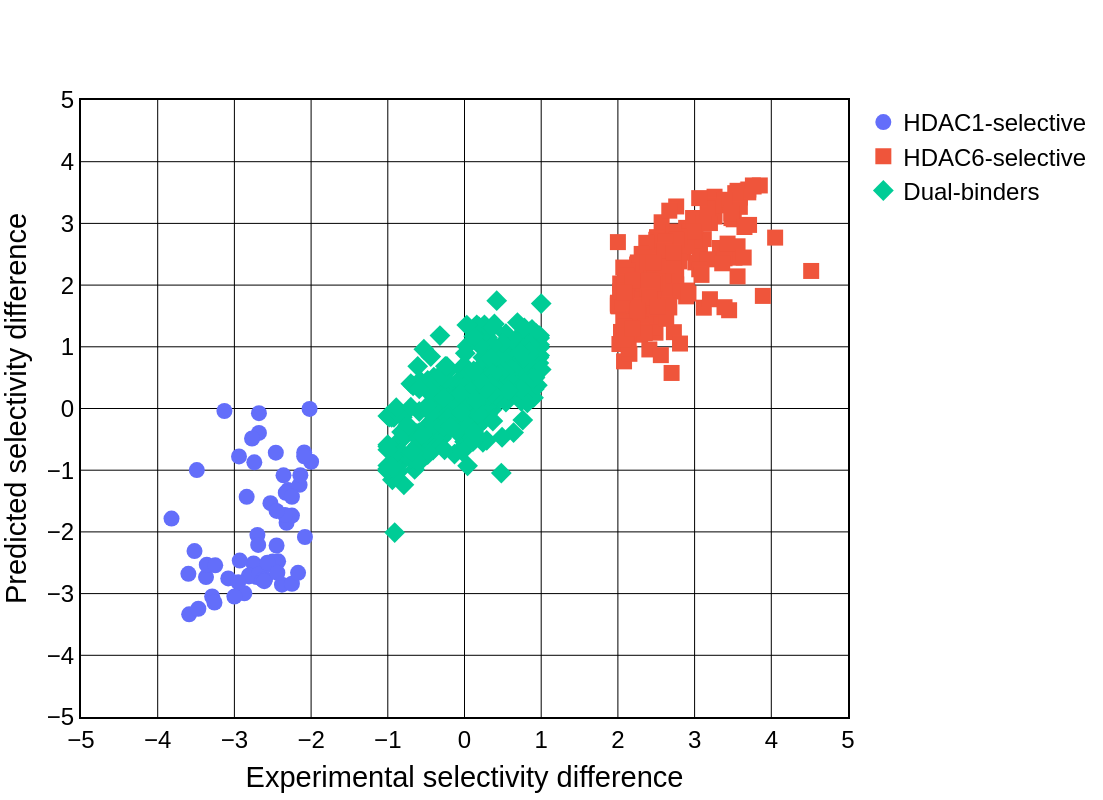

In [76]:
# plot hdac1-selective, hdac6-selective and dual selective compounds in predicted vs experimental plot
import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import iplot, init_notebook_mode
init_notebook_mode(connected=True)


#fig = px.scatter(df=HDAC1and6_ref_pred_DF_hdac1Sel, x="SelectivityWindow", y="RF", )
#fig.show() 

dfs = {"HDAC1-selective" : SW_reg_SemiSel_hdac1Sel, "HDAC6-selective": SW_reg_SemiSel_hdac6Sel, "Dual-binders" : SW_reg_SemiSel_dual}




# plot the data
fig = go.Figure()

for i in dfs:
    fig = fig.add_trace(go.Scatter(x = dfs[i]["SelectivityWindow"],
                                   y = dfs[i]["all_ave"], 
                                   name = i,mode="markers",marker=dict(size=16, symbol = dfs[i]['Marker']) ), )

fig.update_layout(
    autosize=False,
    width=1000,
    height=800,
    xaxis_title="Experimental selectivity difference",
    yaxis_title="Predicted selectivity difference",
    template= "plotly_white",
    
    font=dict(
        #family="Courier New, monospace",
        size=24,
        color="Black"
    )
) 
fig.update_xaxes(showline=True, linewidth=2, linecolor='black', dtick=1, showgrid=True, zeroline=True, mirror=True, zerolinecolor='black',
       zerolinewidth=1, gridwidth=1, gridcolor='black', range=[-5, 5])
fig.update_yaxes(showline=True, linewidth=2, linecolor='black', dtick=1, showgrid=True, zeroline=True, mirror=True, zerolinecolor='black',
       zerolinewidth=1, gridwidth=1, gridcolor='black', range=[-5, 5])

#fig.add_shape( # add a horizontal "target" line
#    type="line", line_color="salmon", line_width=3, opacity=1, line_dash="dot",
#    x0=-4, x1=5, y0=2, y1=2, )

#fig.update_layout({'plot_bgcolor': 'rgba(0, 0, 0, 0)', 'paper_bgcolor': 'rgba(0, 0, 0, 0)',
#})

fig.show()

In [77]:
SelWin_SemiSel_rf_DualSel = SelWin_SemiSel_rf.copy()
SelWin_SemiSel_rf_DualSel['selectivity'] = np.zeros(len(SelWin_SemiSel_rf_DualSel))
SelWin_SemiSel_rf_DualSel.loc[SelWin_SemiSel_rf_DualSel[SelWin_SemiSel_rf_DualSel['label'] == 'Dual-binder'].index, 'selectivity'] =1
#SelWin_SemiSel_rf_DualSel.loc[SelWin_SemiSel_rf_DualSel[SelWin_SemiSel_rf_DualSel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_SemiSel_rf_DualSel['Dual_sel_y_pred_rf0'] = np.zeros(len(SelWin_SemiSel_rf_DualSel))
SelWin_SemiSel_rf_DualSel.loc[SelWin_SemiSel_rf_DualSel[(SelWin_SemiSel_rf_DualSel['y_pred_rf0'] >= -1)  & (SelWin_SemiSel_rf_DualSel['y_pred_rf0'] <= 1)].index, 'Dual_sel_y_pred_rf0'] =1
SelWin_SemiSel_rf_DualSel['Dual_sel_y_pred_rf1'] = np.zeros(len(SelWin_SemiSel_rf_DualSel))
SelWin_SemiSel_rf_DualSel.loc[SelWin_SemiSel_rf_DualSel[(SelWin_SemiSel_rf_DualSel['y_pred_rf1'] >= -1)  & (SelWin_SemiSel_rf_DualSel['y_pred_rf1'] <= 1)].index, 'Dual_sel_y_pred_rf1'] =1
SelWin_SemiSel_rf_DualSel['Dual_sel_y_pred_rf2'] = np.zeros(len(SelWin_SemiSel_rf_DualSel))
SelWin_SemiSel_rf_DualSel.loc[SelWin_SemiSel_rf_DualSel[(SelWin_SemiSel_rf_DualSel['y_pred_rf2'] >= -1)  & (SelWin_SemiSel_rf_DualSel['y_pred_rf2'] <= 1)].index, 'Dual_sel_y_pred_rf2'] =1
SelWin_SemiSel_rf_DualSel['Dual_sel_y_pred_rf3'] = np.zeros(len(SelWin_SemiSel_rf_DualSel))
SelWin_SemiSel_rf_DualSel.loc[SelWin_SemiSel_rf_DualSel[(SelWin_SemiSel_rf_DualSel['y_pred_rf3'] >= -1)  & (SelWin_SemiSel_rf_DualSel['y_pred_rf3'] <= 1)].index, 'Dual_sel_y_pred_rf3'] =1
SelWin_SemiSel_rf_DualSel['Dual_sel_y_pred_rf4'] = np.zeros(len(SelWin_SemiSel_rf_DualSel))
SelWin_SemiSel_rf_DualSel.loc[SelWin_SemiSel_rf_DualSel[(SelWin_SemiSel_rf_DualSel['y_pred_rf4'] >= -1)  & (SelWin_SemiSel_rf_DualSel['y_pred_rf4'] <= 1)].index, 'Dual_sel_y_pred_rf4'] =1


SW_SemiSel_DualSel = SelWin_SemiSel_rf_DualSel['selectivity']
SW_SemiSel_DualSel_y_pred_rf0 = SelWin_SemiSel_rf_DualSel['Dual_sel_y_pred_rf0']
SW_SemiSel_DualSel_y_pred_rf1 = SelWin_SemiSel_rf_DualSel['Dual_sel_y_pred_rf1']
SW_SemiSel_DualSel_y_pred_rf2 = SelWin_SemiSel_rf_DualSel['Dual_sel_y_pred_rf2']
SW_SemiSel_DualSel_y_pred_rf3 = SelWin_SemiSel_rf_DualSel['Dual_sel_y_pred_rf3']
SW_SemiSel_DualSel_y_pred_rf4 = SelWin_SemiSel_rf_DualSel['Dual_sel_y_pred_rf4']
list_rf = [SW_SemiSel_DualSel_y_pred_rf0, SW_SemiSel_DualSel_y_pred_rf1, SW_SemiSel_DualSel_y_pred_rf2, SW_SemiSel_DualSel_y_pred_rf3, SW_SemiSel_DualSel_y_pred_rf4]

TP_DualSel_rf=np.zeros(5)
TN_DualSel_rf=np.zeros(5)
FP_DualSel_rf=np.zeros(5)
FN_DualSel_rf=np.zeros(5)
Accuracy_DualSel_rf=np.zeros(5)
Precision_DualSel_rf=np.zeros(5)
Sensitivity_DualSel_rf=np.zeros(5)
Specificity_DualSel_rf=np.zeros(5)
f1_scores_DualSel_rf=np.zeros(5)
f1_scores_DualSel_rf=np.zeros(5)
f1_scores_M_DualSel_rf=np.zeros(5)
BA_scores_DualSel_rf=np.zeros(5)
MCC_DualSel_rf=np.zeros(5)
NPV_DualSel_rf=np.zeros(5)
ROC_AUC_DualSel_rf=np.zeros(5)

for i, df in enumerate(list_rf):
    df = list_rf[i]
    conf_matrix_DualSel_rf=confusion_matrix(SW_SemiSel_DualSel, df)
    TP_DualSel_rf[i] = conf_matrix_DualSel_rf[1][1]
    TN_DualSel_rf[i] = conf_matrix_DualSel_rf[0][0]
    FP_DualSel_rf[i] = conf_matrix_DualSel_rf[0][1] 
    FN_DualSel_rf[i] = conf_matrix_DualSel_rf[1][0]
    Accuracy_DualSel_rf[i] = accuracy_score(SW_SemiSel_DualSel,df)
    Precision_DualSel_rf[i] = precision_score(SW_SemiSel_DualSel, df)
    Sensitivity_DualSel_rf[i] = recall_score(SW_SemiSel_DualSel, df)
    Specificity_DualSel_rf[i] = round( TN_DualSel_rf[i] / (TN_DualSel_rf[i]+FP_DualSel_rf[i]),4 )
    f1_scores_DualSel_rf[i] = f1_score(SW_SemiSel_DualSel, df)
    f1_scores_M_DualSel_rf[i] = f1_score(SW_SemiSel_DualSel, df, average="macro")
    BA_scores_DualSel_rf[i] = balanced_accuracy_score(SW_SemiSel_DualSel, df)
    MCC_DualSel_rf[i] = matthews_corrcoef(SW_SemiSel_DualSel, df)
    NPV_DualSel_rf[i] = round( TN_DualSel_rf[i] / (TN_DualSel_rf[i]+FN_DualSel_rf[i]),4 )
    ROC_AUC_DualSel_rf[i] = roc_auc_score(SW_SemiSel_DualSel, df)

mat_met_SW_SemiSel_rf = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],     
                'RF(Dual-binder)':[np.mean(TP_DualSel_rf),np.mean(TN_DualSel_rf),np.mean(FP_DualSel_rf),
                 np.mean(FN_DualSel_rf),np.mean(Accuracy_DualSel_rf),np.mean(Precision_DualSel_rf),
                 np.mean(Sensitivity_DualSel_rf),np.mean(Specificity_DualSel_rf),np.mean(f1_scores_DualSel_rf),
                 np.mean(f1_scores_M_DualSel_rf), np.mean(BA_scores_DualSel_rf),np.mean(MCC_DualSel_rf),
                 np.mean(NPV_DualSel_rf), np.mean(ROC_AUC_DualSel_rf)],
                'RF_std(Dual-binder)':[np.std(TP_DualSel_rf, ddof=1),np.std(TN_DualSel_rf,ddof=1),
                 np.std(FP_DualSel_rf,ddof=1),np.std(FN_DualSel_rf,ddof=1),np.std(Accuracy_DualSel_rf,ddof=1),
                 np.std(Precision_DualSel_rf,ddof=1),np.std(Sensitivity_DualSel_rf,ddof=1),np.std(Specificity_DualSel_rf,ddof=1),
                 np.std(f1_scores_DualSel_rf),np.std(f1_scores_M_DualSel_rf),np.std(BA_scores_DualSel_rf,ddof=1),
                 np.std(MCC_DualSel_rf,ddof=1), np.std(NPV_DualSel_rf,ddof=1), np.std(ROC_AUC_DualSel_rf, ddof=1)],      
                       }) 
    
SelWin_SemiSel_rf_HDAC1Sel = SelWin_SemiSel_rf.copy()
SelWin_SemiSel_rf_HDAC1Sel['selectivity'] = np.zeros(len(SelWin_SemiSel_rf_HDAC1Sel))
SelWin_SemiSel_rf_HDAC1Sel.loc[SelWin_SemiSel_rf_HDAC1Sel[SelWin_SemiSel_rf_HDAC1Sel['label'] == 'HDAC1-selective'].index, 'selectivity'] =1
#SelWin_SemiSel_rf_HDAC1Sel.loc[SelWin_SemiSel_rf_HDAC1Sel[SelWin_SemiSel_rf_HDAC1Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_SemiSel_rf_HDAC1Sel['HDAC1_sel_y_pred_rf0'] = np.zeros(len(SelWin_SemiSel_rf_HDAC1Sel))
SelWin_SemiSel_rf_HDAC1Sel.loc[SelWin_SemiSel_rf_HDAC1Sel[(SelWin_SemiSel_rf_HDAC1Sel['y_pred_rf0'] <= -2)].index, 'HDAC1_sel_y_pred_rf0'] =1
SelWin_SemiSel_rf_HDAC1Sel['HDAC1_sel_y_pred_rf1'] = np.zeros(len(SelWin_SemiSel_rf_HDAC1Sel))
SelWin_SemiSel_rf_HDAC1Sel.loc[SelWin_SemiSel_rf_HDAC1Sel[ (SelWin_SemiSel_rf_HDAC1Sel['y_pred_rf1'] <= -2)].index, 'HDAC1_sel_y_pred_rf1'] =1
SelWin_SemiSel_rf_HDAC1Sel['HDAC1_sel_y_pred_rf2'] = np.zeros(len(SelWin_SemiSel_rf_HDAC1Sel))
SelWin_SemiSel_rf_HDAC1Sel.loc[SelWin_SemiSel_rf_HDAC1Sel[ (SelWin_SemiSel_rf_HDAC1Sel['y_pred_rf2'] <= -2)].index, 'HDAC1_sel_y_pred_rf2'] =1
SelWin_SemiSel_rf_HDAC1Sel['HDAC1_sel_y_pred_rf3'] = np.zeros(len(SelWin_SemiSel_rf_HDAC1Sel))
SelWin_SemiSel_rf_HDAC1Sel.loc[SelWin_SemiSel_rf_HDAC1Sel[(SelWin_SemiSel_rf_HDAC1Sel['y_pred_rf3'] <= -2)].index, 'HDAC1_sel_y_pred_rf3'] =1
SelWin_SemiSel_rf_HDAC1Sel['HDAC1_sel_y_pred_rf4'] = np.zeros(len(SelWin_SemiSel_rf_HDAC1Sel))
SelWin_SemiSel_rf_HDAC1Sel.loc[SelWin_SemiSel_rf_HDAC1Sel[(SelWin_SemiSel_rf_HDAC1Sel['y_pred_rf4'] <= -2)].index, 'HDAC1_sel_y_pred_rf4'] =1


SW_SemiSel_HDAC1Sel = SelWin_SemiSel_rf_HDAC1Sel['selectivity']
SW_SemiSel_HDAC1Sel_y_pred_rf0 = SelWin_SemiSel_rf_HDAC1Sel['HDAC1_sel_y_pred_rf0']
SW_SemiSel_HDAC1Sel_y_pred_rf1 = SelWin_SemiSel_rf_HDAC1Sel['HDAC1_sel_y_pred_rf1']
SW_SemiSel_HDAC1Sel_y_pred_rf2 = SelWin_SemiSel_rf_HDAC1Sel['HDAC1_sel_y_pred_rf2']
SW_SemiSel_HDAC1Sel_y_pred_rf3 = SelWin_SemiSel_rf_HDAC1Sel['HDAC1_sel_y_pred_rf3']
SW_SemiSel_HDAC1Sel_y_pred_rf4 = SelWin_SemiSel_rf_HDAC1Sel['HDAC1_sel_y_pred_rf4']
list_rf = [SW_SemiSel_HDAC1Sel_y_pred_rf0, SW_SemiSel_HDAC1Sel_y_pred_rf1, SW_SemiSel_HDAC1Sel_y_pred_rf2, SW_SemiSel_HDAC1Sel_y_pred_rf3, SW_SemiSel_HDAC1Sel_y_pred_rf4]

TP_HDAC1Sel_rf=np.zeros(5)
TN_HDAC1Sel_rf=np.zeros(5)
FP_HDAC1Sel_rf=np.zeros(5)
FN_HDAC1Sel_rf=np.zeros(5)
Accuracy_HDAC1Sel_rf=np.zeros(5)
Precision_HDAC1Sel_rf=np.zeros(5)
Sensitivity_HDAC1Sel_rf=np.zeros(5)
Specificity_HDAC1Sel_rf=np.zeros(5)
f1_scores_HDAC1Sel_rf=np.zeros(5)
f1_scores_HDAC1Sel_rf=np.zeros(5)
f1_scores_M_HDAC1Sel_rf=np.zeros(5)
BA_scores_HDAC1Sel_rf=np.zeros(5)
MCC_HDAC1Sel_rf=np.zeros(5)
NPV_HDAC1Sel_rf=np.zeros(5)
ROC_AUC_HDAC1Sel_rf=np.zeros(5)

for i, df in enumerate(list_rf):
    df = list_rf[i]
    conf_matrix_HDAC1Sel_rf=confusion_matrix(SW_SemiSel_HDAC1Sel, df)
    TP_HDAC1Sel_rf[i] = conf_matrix_HDAC1Sel_rf[1][1]
    TN_HDAC1Sel_rf[i] = conf_matrix_HDAC1Sel_rf[0][0]
    FP_HDAC1Sel_rf[i] = conf_matrix_HDAC1Sel_rf[0][1] 
    FN_HDAC1Sel_rf[i] = conf_matrix_HDAC1Sel_rf[1][0]
    Accuracy_HDAC1Sel_rf[i] = accuracy_score(SW_SemiSel_HDAC1Sel,df)
    Precision_HDAC1Sel_rf[i] = precision_score(SW_SemiSel_HDAC1Sel, df)
    Sensitivity_HDAC1Sel_rf[i] = recall_score(SW_SemiSel_HDAC1Sel, df)
    Specificity_HDAC1Sel_rf[i] = round( TN_HDAC1Sel_rf[i] / (TN_HDAC1Sel_rf[i]+FP_HDAC1Sel_rf[i]),4 )
    f1_scores_HDAC1Sel_rf[i] = f1_score(SW_SemiSel_HDAC1Sel, df)
    f1_scores_M_HDAC1Sel_rf[i] = f1_score(SW_SemiSel_HDAC1Sel, df, average="macro")
    BA_scores_HDAC1Sel_rf[i] = balanced_accuracy_score(SW_SemiSel_HDAC1Sel, df)
    MCC_HDAC1Sel_rf[i] = matthews_corrcoef(SW_SemiSel_HDAC1Sel, df)
    NPV_HDAC1Sel_rf[i] = round( TN_HDAC1Sel_rf[i] / (TN_HDAC1Sel_rf[i]+FN_HDAC1Sel_rf[i]),4 )
    ROC_AUC_HDAC1Sel_rf[i] = roc_auc_score(SW_SemiSel_HDAC1Sel, df)

HDAC1_SW_SemiSel_rf_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'RF(HDAC1-binder)':[np.mean(TP_HDAC1Sel_rf),np.mean(TN_HDAC1Sel_rf),np.mean(FP_HDAC1Sel_rf),
                 np.mean(FN_HDAC1Sel_rf),np.mean(Accuracy_HDAC1Sel_rf),np.mean(Precision_HDAC1Sel_rf),
                 np.mean(Sensitivity_HDAC1Sel_rf),np.mean(Specificity_HDAC1Sel_rf),np.mean(f1_scores_HDAC1Sel_rf),
                 np.mean(f1_scores_M_HDAC1Sel_rf), np.mean(BA_scores_HDAC1Sel_rf),np.mean(MCC_HDAC1Sel_rf),
                 np.mean(NPV_HDAC1Sel_rf), np.mean(ROC_AUC_HDAC1Sel_rf)],
                'RF_std(HDAC1-binder)':[np.std(TP_HDAC1Sel_rf, ddof=1),np.std(TN_HDAC1Sel_rf,ddof=1),
                 np.std(FP_HDAC1Sel_rf,ddof=1),np.std(FN_HDAC1Sel_rf,ddof=1),np.std(Accuracy_HDAC1Sel_rf,ddof=1),
                 np.std(Precision_HDAC1Sel_rf,ddof=1),np.std(Sensitivity_HDAC1Sel_rf,ddof=1),np.std(Specificity_HDAC1Sel_rf,ddof=1),
                 np.std(f1_scores_HDAC1Sel_rf),np.std(f1_scores_M_HDAC1Sel_rf),np.std(BA_scores_HDAC1Sel_rf,ddof=1),
                 np.std(MCC_HDAC1Sel_rf,ddof=1), np.std(NPV_HDAC1Sel_rf,ddof=1), np.std(ROC_AUC_HDAC1Sel_rf, ddof=1)],      
                       }) 
    

mat_met_SW_SemiSel_rf = mat_met_SW_SemiSel_rf.merge(HDAC1_SW_SemiSel_rf_ave, on='Metric')
SelWin_SemiSel_rf_HDAC6Sel = SelWin_SemiSel_rf.copy()
SelWin_SemiSel_rf_HDAC6Sel['selectivity'] = np.zeros(len(SelWin_SemiSel_rf_HDAC6Sel))
SelWin_SemiSel_rf_HDAC6Sel.loc[SelWin_SemiSel_rf_HDAC6Sel[SelWin_SemiSel_rf_HDAC6Sel['label'] == 'HDAC6-selective'].index, 'selectivity'] =1
#SelWin_SemiSel_rf_HDAC6Sel.loc[SelWin_SemiSel_rf_HDAC6Sel[SelWin_SemiSel_rf_HDAC6Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_SemiSel_rf_HDAC6Sel['HDAC6_sel_y_pred_rf0'] = np.zeros(len(SelWin_SemiSel_rf_HDAC6Sel))
SelWin_SemiSel_rf_HDAC6Sel.loc[SelWin_SemiSel_rf_HDAC6Sel[(SelWin_SemiSel_rf_HDAC6Sel['y_pred_rf0'] >= 2)].index, 'HDAC6_sel_y_pred_rf0'] =1
SelWin_SemiSel_rf_HDAC6Sel['HDAC6_sel_y_pred_rf1'] = np.zeros(len(SelWin_SemiSel_rf_HDAC6Sel))
SelWin_SemiSel_rf_HDAC6Sel.loc[SelWin_SemiSel_rf_HDAC6Sel[ (SelWin_SemiSel_rf_HDAC6Sel['y_pred_rf1'] >= 2)].index, 'HDAC6_sel_y_pred_rf1'] =1
SelWin_SemiSel_rf_HDAC6Sel['HDAC6_sel_y_pred_rf2'] = np.zeros(len(SelWin_SemiSel_rf_HDAC6Sel))
SelWin_SemiSel_rf_HDAC6Sel.loc[SelWin_SemiSel_rf_HDAC6Sel[ (SelWin_SemiSel_rf_HDAC6Sel['y_pred_rf2'] >= 2)].index, 'HDAC6_sel_y_pred_rf2'] =1
SelWin_SemiSel_rf_HDAC6Sel['HDAC6_sel_y_pred_rf3'] = np.zeros(len(SelWin_SemiSel_rf_HDAC6Sel))
SelWin_SemiSel_rf_HDAC6Sel.loc[SelWin_SemiSel_rf_HDAC6Sel[(SelWin_SemiSel_rf_HDAC6Sel['y_pred_rf3'] >= 2)].index, 'HDAC6_sel_y_pred_rf3'] =1
SelWin_SemiSel_rf_HDAC6Sel['HDAC6_sel_y_pred_rf4'] = np.zeros(len(SelWin_SemiSel_rf_HDAC6Sel))
SelWin_SemiSel_rf_HDAC6Sel.loc[SelWin_SemiSel_rf_HDAC6Sel[(SelWin_SemiSel_rf_HDAC6Sel['y_pred_rf4'] >= 2)].index, 'HDAC6_sel_y_pred_rf4'] =1


SW_SemiSel_HDAC6Sel = SelWin_SemiSel_rf_HDAC6Sel['selectivity']
SW_SemiSel_HDAC6Sel_y_pred_rf0 = SelWin_SemiSel_rf_HDAC6Sel['HDAC6_sel_y_pred_rf0']
SW_SemiSel_HDAC6Sel_y_pred_rf1 = SelWin_SemiSel_rf_HDAC6Sel['HDAC6_sel_y_pred_rf1']
SW_SemiSel_HDAC6Sel_y_pred_rf2 = SelWin_SemiSel_rf_HDAC6Sel['HDAC6_sel_y_pred_rf2']
SW_SemiSel_HDAC6Sel_y_pred_rf3 = SelWin_SemiSel_rf_HDAC6Sel['HDAC6_sel_y_pred_rf3']
SW_SemiSel_HDAC6Sel_y_pred_rf4 = SelWin_SemiSel_rf_HDAC6Sel['HDAC6_sel_y_pred_rf4']
list_rf = [SW_SemiSel_HDAC6Sel_y_pred_rf0, SW_SemiSel_HDAC6Sel_y_pred_rf1, SW_SemiSel_HDAC6Sel_y_pred_rf2, SW_SemiSel_HDAC6Sel_y_pred_rf3, SW_SemiSel_HDAC6Sel_y_pred_rf4]

TP_HDAC6Sel_rf=np.zeros(5)
TN_HDAC6Sel_rf=np.zeros(5)
FP_HDAC6Sel_rf=np.zeros(5)
FN_HDAC6Sel_rf=np.zeros(5)
Accuracy_HDAC6Sel_rf=np.zeros(5)
Precision_HDAC6Sel_rf=np.zeros(5)
Sensitivity_HDAC6Sel_rf=np.zeros(5)
Specificity_HDAC6Sel_rf=np.zeros(5)
f1_scores_HDAC6Sel_rf=np.zeros(5)
f1_scores_HDAC6Sel_rf=np.zeros(5)
f1_scores_M_HDAC6Sel_rf=np.zeros(5)
BA_scores_HDAC6Sel_rf=np.zeros(5)
MCC_HDAC6Sel_rf=np.zeros(5)
NPV_HDAC6Sel_rf=np.zeros(5)
ROC_AUC_HDAC6Sel_rf=np.zeros(5)

for i, df in enumerate(list_rf):
    df = list_rf[i]
    conf_matrix_HDAC6Sel_rf=confusion_matrix(SW_SemiSel_HDAC6Sel, df)
    TP_HDAC6Sel_rf[i] = conf_matrix_HDAC6Sel_rf[1][1]
    TN_HDAC6Sel_rf[i] = conf_matrix_HDAC6Sel_rf[0][0]
    FP_HDAC6Sel_rf[i] = conf_matrix_HDAC6Sel_rf[0][1] 
    FN_HDAC6Sel_rf[i] = conf_matrix_HDAC6Sel_rf[1][0]
    Accuracy_HDAC6Sel_rf[i] = accuracy_score(SW_SemiSel_HDAC6Sel,df)
    Precision_HDAC6Sel_rf[i] = precision_score(SW_SemiSel_HDAC6Sel, df)
    Sensitivity_HDAC6Sel_rf[i] = recall_score(SW_SemiSel_HDAC6Sel, df)
    Specificity_HDAC6Sel_rf[i] = round( TN_HDAC6Sel_rf[i] / (TN_HDAC6Sel_rf[i]+FP_HDAC6Sel_rf[i]),4 )
    f1_scores_HDAC6Sel_rf[i] = f1_score(SW_SemiSel_HDAC6Sel, df)
    f1_scores_M_HDAC6Sel_rf[i] = f1_score(SW_SemiSel_HDAC6Sel, df, average="macro")
    BA_scores_HDAC6Sel_rf[i] = balanced_accuracy_score(SW_SemiSel_HDAC6Sel, df)
    MCC_HDAC6Sel_rf[i] = matthews_corrcoef(SW_SemiSel_HDAC6Sel, df)
    NPV_HDAC6Sel_rf[i] = round( TN_HDAC6Sel_rf[i] / (TN_HDAC6Sel_rf[i]+FN_HDAC6Sel_rf[i]),4 )
    ROC_AUC_HDAC6Sel_rf[i] = roc_auc_score(SW_SemiSel_HDAC6Sel, df)

HDAC6_SW_SemiSel_rf_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'RF(HDAC6-binder)':[np.mean(TP_HDAC6Sel_rf),np.mean(TN_HDAC6Sel_rf),np.mean(FP_HDAC6Sel_rf),
                 np.mean(FN_HDAC6Sel_rf),np.mean(Accuracy_HDAC6Sel_rf),np.mean(Precision_HDAC6Sel_rf),
                 np.mean(Sensitivity_HDAC6Sel_rf),np.mean(Specificity_HDAC6Sel_rf),np.mean(f1_scores_HDAC6Sel_rf),
                 np.mean(f1_scores_M_HDAC6Sel_rf), np.mean(BA_scores_HDAC6Sel_rf),np.mean(MCC_HDAC6Sel_rf),
                 np.mean(NPV_HDAC6Sel_rf), np.mean(ROC_AUC_HDAC6Sel_rf)],
                'RF_std(HDAC6-binder)':[np.std(TP_HDAC6Sel_rf, ddof=1),np.std(TN_HDAC6Sel_rf,ddof=1),
                 np.std(FP_HDAC6Sel_rf,ddof=1),np.std(FN_HDAC6Sel_rf,ddof=1),np.std(Accuracy_HDAC6Sel_rf,ddof=1),
                 np.std(Precision_HDAC6Sel_rf,ddof=1),np.std(Sensitivity_HDAC6Sel_rf,ddof=1),np.std(Specificity_HDAC6Sel_rf,ddof=1),
                 np.std(f1_scores_HDAC6Sel_rf),np.std(f1_scores_M_HDAC6Sel_rf),np.std(BA_scores_HDAC6Sel_rf,ddof=1),
                 np.std(MCC_HDAC6Sel_rf,ddof=1), np.std(NPV_HDAC6Sel_rf,ddof=1), np.std(ROC_AUC_HDAC6Sel_rf, ddof=1)],      
                       }) 
    

mat_met_SW_SemiSel_rf = mat_met_SW_SemiSel_rf.merge(HDAC6_SW_SemiSel_rf_ave, on='Metric')
mat_met_SW_SemiSel_rf

,Metric,RF(Dual-binder),RF_std(Dual-binder),RF(HDAC1-binder),RF_std(HDAC1-binder),RF(HDAC6-binder),RF_std(HDAC6-binder)
0,TP,474.200000,1.483240,31.600000,1.673320,138.200000,1.923538
1,TN,642.400000,4.774935,1846.000000,0.000000,1616.200000,2.387467
2,FP,735.600000,4.774935,3.000000,0.000000,26.800000,2.387467
3,FN,57.800000,1.483240,29.400000,1.673320,128.800000,1.923538
4,Accuracy,0.584607,0.002178,0.983037,0.000876,0.918534,0.002240
5,Precision,0.391969,0.001297,0.913127,0.004346,0.837610,0.013936
6,Sensitivity,0.891353,0.002788,0.518033,0.027431,0.517603,0.007204
7,Specificity,0.466180,0.003463,0.998400,0.000000,0.983700,0.001466
8,F1 score,0.544496,0.001182,0.660756,0.021214,0.639823,0.008512
9,F1 score (macro),0.581358,0.001795,0.826028,0.010806,0.796948,0.004823


In [78]:
SelWin_SemiSel_lgbm_DualSel = SelWin_SemiSel_lgbm.copy()
SelWin_SemiSel_lgbm_DualSel['selectivity'] = np.zeros(len(SelWin_SemiSel_lgbm_DualSel))
SelWin_SemiSel_lgbm_DualSel.loc[SelWin_SemiSel_lgbm_DualSel[SelWin_SemiSel_lgbm_DualSel['label'] == 'Dual-binder'].index, 'selectivity'] =1
#SelWin_SemiSel_lgbm_DualSel.loc[SelWin_SemiSel_lgbm_DualSel[SelWin_SemiSel_lgbm_DualSel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_SemiSel_lgbm_DualSel['Dual_sel_y_pred_lgbm0'] = np.zeros(len(SelWin_SemiSel_lgbm_DualSel))
SelWin_SemiSel_lgbm_DualSel.loc[SelWin_SemiSel_lgbm_DualSel[(SelWin_SemiSel_lgbm_DualSel['y_pred_lgbm0'] >= -1)  & (SelWin_SemiSel_lgbm_DualSel['y_pred_lgbm0'] <= 1)].index, 'Dual_sel_y_pred_lgbm0'] =1
SelWin_SemiSel_lgbm_DualSel['Dual_sel_y_pred_lgbm1'] = np.zeros(len(SelWin_SemiSel_lgbm_DualSel))
SelWin_SemiSel_lgbm_DualSel.loc[SelWin_SemiSel_lgbm_DualSel[(SelWin_SemiSel_lgbm_DualSel['y_pred_lgbm1'] >= -1)  & (SelWin_SemiSel_lgbm_DualSel['y_pred_lgbm1'] <= 1)].index, 'Dual_sel_y_pred_lgbm1'] =1
SelWin_SemiSel_lgbm_DualSel['Dual_sel_y_pred_lgbm2'] = np.zeros(len(SelWin_SemiSel_lgbm_DualSel))
SelWin_SemiSel_lgbm_DualSel.loc[SelWin_SemiSel_lgbm_DualSel[(SelWin_SemiSel_lgbm_DualSel['y_pred_lgbm2'] >= -1)  & (SelWin_SemiSel_lgbm_DualSel['y_pred_lgbm2'] <= 1)].index, 'Dual_sel_y_pred_lgbm2'] =1
SelWin_SemiSel_lgbm_DualSel['Dual_sel_y_pred_lgbm3'] = np.zeros(len(SelWin_SemiSel_lgbm_DualSel))
SelWin_SemiSel_lgbm_DualSel.loc[SelWin_SemiSel_lgbm_DualSel[(SelWin_SemiSel_lgbm_DualSel['y_pred_lgbm3'] >= -1)  & (SelWin_SemiSel_lgbm_DualSel['y_pred_lgbm3'] <= 1)].index, 'Dual_sel_y_pred_lgbm3'] =1
SelWin_SemiSel_lgbm_DualSel['Dual_sel_y_pred_lgbm4'] = np.zeros(len(SelWin_SemiSel_lgbm_DualSel))
SelWin_SemiSel_lgbm_DualSel.loc[SelWin_SemiSel_lgbm_DualSel[(SelWin_SemiSel_lgbm_DualSel['y_pred_lgbm4'] >= -1)  & (SelWin_SemiSel_lgbm_DualSel['y_pred_lgbm4'] <= 1)].index, 'Dual_sel_y_pred_lgbm4'] =1


SW_SemiSel_DualSel = SelWin_SemiSel_lgbm_DualSel['selectivity']
SW_SemiSel_DualSel_y_pred_lgbm0 = SelWin_SemiSel_lgbm_DualSel['Dual_sel_y_pred_lgbm0']
SW_SemiSel_DualSel_y_pred_lgbm1 = SelWin_SemiSel_lgbm_DualSel['Dual_sel_y_pred_lgbm1']
SW_SemiSel_DualSel_y_pred_lgbm2 = SelWin_SemiSel_lgbm_DualSel['Dual_sel_y_pred_lgbm2']
SW_SemiSel_DualSel_y_pred_lgbm3 = SelWin_SemiSel_lgbm_DualSel['Dual_sel_y_pred_lgbm3']
SW_SemiSel_DualSel_y_pred_lgbm4 = SelWin_SemiSel_lgbm_DualSel['Dual_sel_y_pred_lgbm4']
list_lgbm = [SW_SemiSel_DualSel_y_pred_lgbm0, SW_SemiSel_DualSel_y_pred_lgbm1, SW_SemiSel_DualSel_y_pred_lgbm2, SW_SemiSel_DualSel_y_pred_lgbm3, SW_SemiSel_DualSel_y_pred_lgbm4]

TP_DualSel_lgbm=np.zeros(5)
TN_DualSel_lgbm=np.zeros(5)
FP_DualSel_lgbm=np.zeros(5)
FN_DualSel_lgbm=np.zeros(5)
Accuracy_DualSel_lgbm=np.zeros(5)
Precision_DualSel_lgbm=np.zeros(5)
Sensitivity_DualSel_lgbm=np.zeros(5)
Specificity_DualSel_lgbm=np.zeros(5)
f1_scores_DualSel_lgbm=np.zeros(5)
f1_scores_DualSel_lgbm=np.zeros(5)
f1_scores_M_DualSel_lgbm=np.zeros(5)
BA_scores_DualSel_lgbm=np.zeros(5)
MCC_DualSel_lgbm=np.zeros(5)
NPV_DualSel_lgbm=np.zeros(5)
ROC_AUC_DualSel_lgbm=np.zeros(5)

for i, df in enumerate(list_lgbm):
    df = list_lgbm[i]
    conf_matrix_DualSel_lgbm=confusion_matrix(SW_SemiSel_DualSel, df)
    TP_DualSel_lgbm[i] = conf_matrix_DualSel_lgbm[1][1]
    TN_DualSel_lgbm[i] = conf_matrix_DualSel_lgbm[0][0]
    FP_DualSel_lgbm[i] = conf_matrix_DualSel_lgbm[0][1] 
    FN_DualSel_lgbm[i] = conf_matrix_DualSel_lgbm[1][0]
    Accuracy_DualSel_lgbm[i] = accuracy_score(SW_SemiSel_DualSel,df)
    Precision_DualSel_lgbm[i] = precision_score(SW_SemiSel_DualSel, df)
    Sensitivity_DualSel_lgbm[i] = recall_score(SW_SemiSel_DualSel, df)
    Specificity_DualSel_lgbm[i] = round( TN_DualSel_lgbm[i] / (TN_DualSel_lgbm[i]+FP_DualSel_lgbm[i]),4 )
    f1_scores_DualSel_lgbm[i] = f1_score(SW_SemiSel_DualSel, df)
    f1_scores_M_DualSel_lgbm[i] = f1_score(SW_SemiSel_DualSel, df, average="macro")
    BA_scores_DualSel_lgbm[i] = balanced_accuracy_score(SW_SemiSel_DualSel, df)
    MCC_DualSel_lgbm[i] = matthews_corrcoef(SW_SemiSel_DualSel, df)
    NPV_DualSel_lgbm[i] = round( TN_DualSel_lgbm[i] / (TN_DualSel_lgbm[i]+FN_DualSel_lgbm[i]),4 )
    ROC_AUC_DualSel_lgbm[i] = roc_auc_score(SW_SemiSel_DualSel, df)

mat_met_SW_SemiSel_lgbm = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],     
                'lgbm(Dual-binder)':[np.mean(TP_DualSel_lgbm),np.mean(TN_DualSel_lgbm),np.mean(FP_DualSel_lgbm),
                 np.mean(FN_DualSel_lgbm),np.mean(Accuracy_DualSel_lgbm),np.mean(Precision_DualSel_lgbm),
                 np.mean(Sensitivity_DualSel_lgbm),np.mean(Specificity_DualSel_lgbm),np.mean(f1_scores_DualSel_lgbm),
                 np.mean(f1_scores_M_DualSel_lgbm), np.mean(BA_scores_DualSel_lgbm),np.mean(MCC_DualSel_lgbm),
                 np.mean(NPV_DualSel_lgbm), np.mean(ROC_AUC_DualSel_lgbm)],
                'lgbm_std(Dual-binder)':[np.std(TP_DualSel_lgbm, ddof=1),np.std(TN_DualSel_lgbm,ddof=1),
                 np.std(FP_DualSel_lgbm,ddof=1),np.std(FN_DualSel_lgbm,ddof=1),np.std(Accuracy_DualSel_lgbm,ddof=1),
                 np.std(Precision_DualSel_lgbm,ddof=1),np.std(Sensitivity_DualSel_lgbm,ddof=1),np.std(Specificity_DualSel_lgbm,ddof=1),
                 np.std(f1_scores_DualSel_lgbm),np.std(f1_scores_M_DualSel_lgbm),np.std(BA_scores_DualSel_lgbm,ddof=1),
                 np.std(MCC_DualSel_lgbm,ddof=1), np.std(NPV_DualSel_lgbm,ddof=1), np.std(ROC_AUC_DualSel_lgbm, ddof=1)],      
                       }) 
    
SelWin_SemiSel_lgbm_HDAC1Sel = SelWin_SemiSel_lgbm.copy()
SelWin_SemiSel_lgbm_HDAC1Sel['selectivity'] = np.zeros(len(SelWin_SemiSel_lgbm_HDAC1Sel))
SelWin_SemiSel_lgbm_HDAC1Sel.loc[SelWin_SemiSel_lgbm_HDAC1Sel[SelWin_SemiSel_lgbm_HDAC1Sel['label'] == 'HDAC1-selective'].index, 'selectivity'] =1
#SelWin_SemiSel_lgbm_HDAC1Sel.loc[SelWin_SemiSel_lgbm_HDAC1Sel[SelWin_SemiSel_lgbm_HDAC1Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_SemiSel_lgbm_HDAC1Sel['HDAC1_sel_y_pred_lgbm0'] = np.zeros(len(SelWin_SemiSel_lgbm_HDAC1Sel))
SelWin_SemiSel_lgbm_HDAC1Sel.loc[SelWin_SemiSel_lgbm_HDAC1Sel[(SelWin_SemiSel_lgbm_HDAC1Sel['y_pred_lgbm0'] <= -2)].index, 'HDAC1_sel_y_pred_lgbm0'] =1
SelWin_SemiSel_lgbm_HDAC1Sel['HDAC1_sel_y_pred_lgbm1'] = np.zeros(len(SelWin_SemiSel_lgbm_HDAC1Sel))
SelWin_SemiSel_lgbm_HDAC1Sel.loc[SelWin_SemiSel_lgbm_HDAC1Sel[ (SelWin_SemiSel_lgbm_HDAC1Sel['y_pred_lgbm1'] <= -2)].index, 'HDAC1_sel_y_pred_lgbm1'] =1
SelWin_SemiSel_lgbm_HDAC1Sel['HDAC1_sel_y_pred_lgbm2'] = np.zeros(len(SelWin_SemiSel_lgbm_HDAC1Sel))
SelWin_SemiSel_lgbm_HDAC1Sel.loc[SelWin_SemiSel_lgbm_HDAC1Sel[ (SelWin_SemiSel_lgbm_HDAC1Sel['y_pred_lgbm2'] <= -2)].index, 'HDAC1_sel_y_pred_lgbm2'] =1
SelWin_SemiSel_lgbm_HDAC1Sel['HDAC1_sel_y_pred_lgbm3'] = np.zeros(len(SelWin_SemiSel_lgbm_HDAC1Sel))
SelWin_SemiSel_lgbm_HDAC1Sel.loc[SelWin_SemiSel_lgbm_HDAC1Sel[(SelWin_SemiSel_lgbm_HDAC1Sel['y_pred_lgbm3'] <= -2)].index, 'HDAC1_sel_y_pred_lgbm3'] =1
SelWin_SemiSel_lgbm_HDAC1Sel['HDAC1_sel_y_pred_lgbm4'] = np.zeros(len(SelWin_SemiSel_lgbm_HDAC1Sel))
SelWin_SemiSel_lgbm_HDAC1Sel.loc[SelWin_SemiSel_lgbm_HDAC1Sel[(SelWin_SemiSel_lgbm_HDAC1Sel['y_pred_lgbm4'] <= -2)].index, 'HDAC1_sel_y_pred_lgbm4'] =1


SW_SemiSel_HDAC1Sel = SelWin_SemiSel_lgbm_HDAC1Sel['selectivity']
SW_SemiSel_HDAC1Sel_y_pred_lgbm0 = SelWin_SemiSel_lgbm_HDAC1Sel['HDAC1_sel_y_pred_lgbm0']
SW_SemiSel_HDAC1Sel_y_pred_lgbm1 = SelWin_SemiSel_lgbm_HDAC1Sel['HDAC1_sel_y_pred_lgbm1']
SW_SemiSel_HDAC1Sel_y_pred_lgbm2 = SelWin_SemiSel_lgbm_HDAC1Sel['HDAC1_sel_y_pred_lgbm2']
SW_SemiSel_HDAC1Sel_y_pred_lgbm3 = SelWin_SemiSel_lgbm_HDAC1Sel['HDAC1_sel_y_pred_lgbm3']
SW_SemiSel_HDAC1Sel_y_pred_lgbm4 = SelWin_SemiSel_lgbm_HDAC1Sel['HDAC1_sel_y_pred_lgbm4']
list_lgbm = [SW_SemiSel_HDAC1Sel_y_pred_lgbm0, SW_SemiSel_HDAC1Sel_y_pred_lgbm1, SW_SemiSel_HDAC1Sel_y_pred_lgbm2, SW_SemiSel_HDAC1Sel_y_pred_lgbm3, SW_SemiSel_HDAC1Sel_y_pred_lgbm4]

TP_HDAC1Sel_lgbm=np.zeros(5)
TN_HDAC1Sel_lgbm=np.zeros(5)
FP_HDAC1Sel_lgbm=np.zeros(5)
FN_HDAC1Sel_lgbm=np.zeros(5)
Accuracy_HDAC1Sel_lgbm=np.zeros(5)
Precision_HDAC1Sel_lgbm=np.zeros(5)
Sensitivity_HDAC1Sel_lgbm=np.zeros(5)
Specificity_HDAC1Sel_lgbm=np.zeros(5)
f1_scores_HDAC1Sel_lgbm=np.zeros(5)
f1_scores_HDAC1Sel_lgbm=np.zeros(5)
f1_scores_M_HDAC1Sel_lgbm=np.zeros(5)
BA_scores_HDAC1Sel_lgbm=np.zeros(5)
MCC_HDAC1Sel_lgbm=np.zeros(5)
NPV_HDAC1Sel_lgbm=np.zeros(5)
ROC_AUC_HDAC1Sel_lgbm=np.zeros(5)

for i, df in enumerate(list_lgbm):
    df = list_lgbm[i]
    conf_matrix_HDAC1Sel_lgbm=confusion_matrix(SW_SemiSel_HDAC1Sel, df)
    TP_HDAC1Sel_lgbm[i] = conf_matrix_HDAC1Sel_lgbm[1][1]
    TN_HDAC1Sel_lgbm[i] = conf_matrix_HDAC1Sel_lgbm[0][0]
    FP_HDAC1Sel_lgbm[i] = conf_matrix_HDAC1Sel_lgbm[0][1] 
    FN_HDAC1Sel_lgbm[i] = conf_matrix_HDAC1Sel_lgbm[1][0]
    Accuracy_HDAC1Sel_lgbm[i] = accuracy_score(SW_SemiSel_HDAC1Sel,df)
    Precision_HDAC1Sel_lgbm[i] = precision_score(SW_SemiSel_HDAC1Sel, df)
    Sensitivity_HDAC1Sel_lgbm[i] = recall_score(SW_SemiSel_HDAC1Sel, df)
    Specificity_HDAC1Sel_lgbm[i] = round( TN_HDAC1Sel_lgbm[i] / (TN_HDAC1Sel_lgbm[i]+FP_HDAC1Sel_lgbm[i]),4 )
    f1_scores_HDAC1Sel_lgbm[i] = f1_score(SW_SemiSel_HDAC1Sel, df)
    f1_scores_M_HDAC1Sel_lgbm[i] = f1_score(SW_SemiSel_HDAC1Sel, df, average="macro")
    BA_scores_HDAC1Sel_lgbm[i] = balanced_accuracy_score(SW_SemiSel_HDAC1Sel, df)
    MCC_HDAC1Sel_lgbm[i] = matthews_corrcoef(SW_SemiSel_HDAC1Sel, df)
    NPV_HDAC1Sel_lgbm[i] = round( TN_HDAC1Sel_lgbm[i] / (TN_HDAC1Sel_lgbm[i]+FN_HDAC1Sel_lgbm[i]),4 )
    ROC_AUC_HDAC1Sel_lgbm[i] = roc_auc_score(SW_SemiSel_HDAC1Sel, df)

HDAC1_SW_SemiSel_lgbm_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'lgbm(HDAC1-binder)':[np.mean(TP_HDAC1Sel_lgbm),np.mean(TN_HDAC1Sel_lgbm),np.mean(FP_HDAC1Sel_lgbm),
                 np.mean(FN_HDAC1Sel_lgbm),np.mean(Accuracy_HDAC1Sel_lgbm),np.mean(Precision_HDAC1Sel_lgbm),
                 np.mean(Sensitivity_HDAC1Sel_lgbm),np.mean(Specificity_HDAC1Sel_lgbm),np.mean(f1_scores_HDAC1Sel_lgbm),
                 np.mean(f1_scores_M_HDAC1Sel_lgbm), np.mean(BA_scores_HDAC1Sel_lgbm),np.mean(MCC_HDAC1Sel_lgbm),
                 np.mean(NPV_HDAC1Sel_lgbm), np.mean(ROC_AUC_HDAC1Sel_lgbm)],
                'lgbm_std(HDAC1-binder)':[np.std(TP_HDAC1Sel_lgbm, ddof=1),np.std(TN_HDAC1Sel_lgbm,ddof=1),
                 np.std(FP_HDAC1Sel_lgbm,ddof=1),np.std(FN_HDAC1Sel_lgbm,ddof=1),np.std(Accuracy_HDAC1Sel_lgbm,ddof=1),
                 np.std(Precision_HDAC1Sel_lgbm,ddof=1),np.std(Sensitivity_HDAC1Sel_lgbm,ddof=1),np.std(Specificity_HDAC1Sel_lgbm,ddof=1),
                 np.std(f1_scores_HDAC1Sel_lgbm),np.std(f1_scores_M_HDAC1Sel_lgbm),np.std(BA_scores_HDAC1Sel_lgbm,ddof=1),
                 np.std(MCC_HDAC1Sel_lgbm,ddof=1), np.std(NPV_HDAC1Sel_lgbm,ddof=1), np.std(ROC_AUC_HDAC1Sel_lgbm, ddof=1)],      
                       }) 
    

mat_met_SW_SemiSel_lgbm = mat_met_SW_SemiSel_lgbm.merge(HDAC1_SW_SemiSel_lgbm_ave, on='Metric')
SelWin_SemiSel_lgbm_HDAC6Sel = SelWin_SemiSel_lgbm.copy()
SelWin_SemiSel_lgbm_HDAC6Sel['selectivity'] = np.zeros(len(SelWin_SemiSel_lgbm_HDAC6Sel))
SelWin_SemiSel_lgbm_HDAC6Sel.loc[SelWin_SemiSel_lgbm_HDAC6Sel[SelWin_SemiSel_lgbm_HDAC6Sel['label'] == 'HDAC6-selective'].index, 'selectivity'] =1
#SelWin_SemiSel_lgbm_HDAC6Sel.loc[SelWin_SemiSel_lgbm_HDAC6Sel[SelWin_SemiSel_lgbm_HDAC6Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_SemiSel_lgbm_HDAC6Sel['HDAC6_sel_y_pred_lgbm0'] = np.zeros(len(SelWin_SemiSel_lgbm_HDAC6Sel))
SelWin_SemiSel_lgbm_HDAC6Sel.loc[SelWin_SemiSel_lgbm_HDAC6Sel[(SelWin_SemiSel_lgbm_HDAC6Sel['y_pred_lgbm0'] >= 2)].index, 'HDAC6_sel_y_pred_lgbm0'] =1
SelWin_SemiSel_lgbm_HDAC6Sel['HDAC6_sel_y_pred_lgbm1'] = np.zeros(len(SelWin_SemiSel_lgbm_HDAC6Sel))
SelWin_SemiSel_lgbm_HDAC6Sel.loc[SelWin_SemiSel_lgbm_HDAC6Sel[ (SelWin_SemiSel_lgbm_HDAC6Sel['y_pred_lgbm1'] >= 2)].index, 'HDAC6_sel_y_pred_lgbm1'] =1
SelWin_SemiSel_lgbm_HDAC6Sel['HDAC6_sel_y_pred_lgbm2'] = np.zeros(len(SelWin_SemiSel_lgbm_HDAC6Sel))
SelWin_SemiSel_lgbm_HDAC6Sel.loc[SelWin_SemiSel_lgbm_HDAC6Sel[ (SelWin_SemiSel_lgbm_HDAC6Sel['y_pred_lgbm2'] >= 2)].index, 'HDAC6_sel_y_pred_lgbm2'] =1
SelWin_SemiSel_lgbm_HDAC6Sel['HDAC6_sel_y_pred_lgbm3'] = np.zeros(len(SelWin_SemiSel_lgbm_HDAC6Sel))
SelWin_SemiSel_lgbm_HDAC6Sel.loc[SelWin_SemiSel_lgbm_HDAC6Sel[(SelWin_SemiSel_lgbm_HDAC6Sel['y_pred_lgbm3'] >= 2)].index, 'HDAC6_sel_y_pred_lgbm3'] =1
SelWin_SemiSel_lgbm_HDAC6Sel['HDAC6_sel_y_pred_lgbm4'] = np.zeros(len(SelWin_SemiSel_lgbm_HDAC6Sel))
SelWin_SemiSel_lgbm_HDAC6Sel.loc[SelWin_SemiSel_lgbm_HDAC6Sel[(SelWin_SemiSel_lgbm_HDAC6Sel['y_pred_lgbm4'] >= 2)].index, 'HDAC6_sel_y_pred_lgbm4'] =1


SW_SemiSel_HDAC6Sel = SelWin_SemiSel_lgbm_HDAC6Sel['selectivity']
SW_SemiSel_HDAC6Sel_y_pred_lgbm0 = SelWin_SemiSel_lgbm_HDAC6Sel['HDAC6_sel_y_pred_lgbm0']
SW_SemiSel_HDAC6Sel_y_pred_lgbm1 = SelWin_SemiSel_lgbm_HDAC6Sel['HDAC6_sel_y_pred_lgbm1']
SW_SemiSel_HDAC6Sel_y_pred_lgbm2 = SelWin_SemiSel_lgbm_HDAC6Sel['HDAC6_sel_y_pred_lgbm2']
SW_SemiSel_HDAC6Sel_y_pred_lgbm3 = SelWin_SemiSel_lgbm_HDAC6Sel['HDAC6_sel_y_pred_lgbm3']
SW_SemiSel_HDAC6Sel_y_pred_lgbm4 = SelWin_SemiSel_lgbm_HDAC6Sel['HDAC6_sel_y_pred_lgbm4']
list_lgbm = [SW_SemiSel_HDAC6Sel_y_pred_lgbm0, SW_SemiSel_HDAC6Sel_y_pred_lgbm1, SW_SemiSel_HDAC6Sel_y_pred_lgbm2, SW_SemiSel_HDAC6Sel_y_pred_lgbm3, SW_SemiSel_HDAC6Sel_y_pred_lgbm4]

TP_HDAC6Sel_lgbm=np.zeros(5)
TN_HDAC6Sel_lgbm=np.zeros(5)
FP_HDAC6Sel_lgbm=np.zeros(5)
FN_HDAC6Sel_lgbm=np.zeros(5)
Accuracy_HDAC6Sel_lgbm=np.zeros(5)
Precision_HDAC6Sel_lgbm=np.zeros(5)
Sensitivity_HDAC6Sel_lgbm=np.zeros(5)
Specificity_HDAC6Sel_lgbm=np.zeros(5)
f1_scores_HDAC6Sel_lgbm=np.zeros(5)
f1_scores_HDAC6Sel_lgbm=np.zeros(5)
f1_scores_M_HDAC6Sel_lgbm=np.zeros(5)
BA_scores_HDAC6Sel_lgbm=np.zeros(5)
MCC_HDAC6Sel_lgbm=np.zeros(5)
NPV_HDAC6Sel_lgbm=np.zeros(5)
ROC_AUC_HDAC6Sel_lgbm=np.zeros(5)

for i, df in enumerate(list_lgbm):
    df = list_lgbm[i]
    conf_matrix_HDAC6Sel_lgbm=confusion_matrix(SW_SemiSel_HDAC6Sel, df)
    TP_HDAC6Sel_lgbm[i] = conf_matrix_HDAC6Sel_lgbm[1][1]
    TN_HDAC6Sel_lgbm[i] = conf_matrix_HDAC6Sel_lgbm[0][0]
    FP_HDAC6Sel_lgbm[i] = conf_matrix_HDAC6Sel_lgbm[0][1] 
    FN_HDAC6Sel_lgbm[i] = conf_matrix_HDAC6Sel_lgbm[1][0]
    Accuracy_HDAC6Sel_lgbm[i] = accuracy_score(SW_SemiSel_HDAC6Sel,df)
    Precision_HDAC6Sel_lgbm[i] = precision_score(SW_SemiSel_HDAC6Sel, df)
    Sensitivity_HDAC6Sel_lgbm[i] = recall_score(SW_SemiSel_HDAC6Sel, df)
    Specificity_HDAC6Sel_lgbm[i] = round( TN_HDAC6Sel_lgbm[i] / (TN_HDAC6Sel_lgbm[i]+FP_HDAC6Sel_lgbm[i]),4 )
    f1_scores_HDAC6Sel_lgbm[i] = f1_score(SW_SemiSel_HDAC6Sel, df)
    f1_scores_M_HDAC6Sel_lgbm[i] = f1_score(SW_SemiSel_HDAC6Sel, df, average="macro")
    BA_scores_HDAC6Sel_lgbm[i] = balanced_accuracy_score(SW_SemiSel_HDAC6Sel, df)
    MCC_HDAC6Sel_lgbm[i] = matthews_corrcoef(SW_SemiSel_HDAC6Sel, df)
    NPV_HDAC6Sel_lgbm[i] = round( TN_HDAC6Sel_lgbm[i] / (TN_HDAC6Sel_lgbm[i]+FN_HDAC6Sel_lgbm[i]),4 )
    ROC_AUC_HDAC6Sel_lgbm[i] = roc_auc_score(SW_SemiSel_HDAC6Sel, df)

HDAC6_SW_SemiSel_lgbm_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'lgbm(HDAC6-binder)':[np.mean(TP_HDAC6Sel_lgbm),np.mean(TN_HDAC6Sel_lgbm),np.mean(FP_HDAC6Sel_lgbm),
                 np.mean(FN_HDAC6Sel_lgbm),np.mean(Accuracy_HDAC6Sel_lgbm),np.mean(Precision_HDAC6Sel_lgbm),
                 np.mean(Sensitivity_HDAC6Sel_lgbm),np.mean(Specificity_HDAC6Sel_lgbm),np.mean(f1_scores_HDAC6Sel_lgbm),
                 np.mean(f1_scores_M_HDAC6Sel_lgbm), np.mean(BA_scores_HDAC6Sel_lgbm),np.mean(MCC_HDAC6Sel_lgbm),
                 np.mean(NPV_HDAC6Sel_lgbm), np.mean(ROC_AUC_HDAC6Sel_lgbm)],
                'lgbm_std(HDAC6-binder)':[np.std(TP_HDAC6Sel_lgbm, ddof=1),np.std(TN_HDAC6Sel_lgbm,ddof=1),
                 np.std(FP_HDAC6Sel_lgbm,ddof=1),np.std(FN_HDAC6Sel_lgbm,ddof=1),np.std(Accuracy_HDAC6Sel_lgbm,ddof=1),
                 np.std(Precision_HDAC6Sel_lgbm,ddof=1),np.std(Sensitivity_HDAC6Sel_lgbm,ddof=1),np.std(Specificity_HDAC6Sel_lgbm,ddof=1),
                 np.std(f1_scores_HDAC6Sel_lgbm),np.std(f1_scores_M_HDAC6Sel_lgbm),np.std(BA_scores_HDAC6Sel_lgbm,ddof=1),
                 np.std(MCC_HDAC6Sel_lgbm,ddof=1), np.std(NPV_HDAC6Sel_lgbm,ddof=1), np.std(ROC_AUC_HDAC6Sel_lgbm, ddof=1)],      
                       }) 
    

mat_met_SW_SemiSel_lgbm = mat_met_SW_SemiSel_lgbm.merge(HDAC6_SW_SemiSel_lgbm_ave, on='Metric')
mat_met_SW_SemiSel_lgbm

,Metric,lgbm(Dual-binder),lgbm_std(Dual-binder),lgbm(HDAC1-binder),lgbm_std(HDAC1-binder),lgbm(HDAC6-binder),lgbm_std(HDAC6-binder)
0,TP,454.800000,6.220932,33.800000,1.643168,155.800000,5.215362
1,TN,748.000000,5.049752,1844.000000,1.224745,1596.400000,4.722288
2,FP,630.000000,5.049752,5.000000,1.224745,46.600000,4.722288
3,FN,77.200000,6.220932,27.200000,1.643168,111.200000,5.215362
4,Accuracy,0.629738,0.004570,0.983141,0.001250,0.917382,0.005095
5,Precision,0.419240,0.004167,0.871351,0.031098,0.769736,0.023587
6,Sensitivity,0.854887,0.011693,0.554098,0.026937,0.583521,0.019533
7,Specificity,0.542820,0.003644,0.997320,0.000653,0.971640,0.002833
8,F1 score,0.562582,0.005472,0.677187,0.023587,0.663803,0.018947
9,F1 score (macro),0.620797,0.004290,0.834266,0.012074,0.808354,0.010765


In [79]:
SelWin_SemiSel_xgb_DualSel = SelWin_SemiSel_xgb.copy()
SelWin_SemiSel_xgb_DualSel['selectivity'] = np.zeros(len(SelWin_SemiSel_xgb_DualSel))
SelWin_SemiSel_xgb_DualSel.loc[SelWin_SemiSel_xgb_DualSel[SelWin_SemiSel_xgb_DualSel['label'] == 'Dual-binder'].index, 'selectivity'] =1
#SelWin_SemiSel_xgb_DualSel.loc[SelWin_SemiSel_xgb_DualSel[SelWin_SemiSel_xgb_DualSel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_SemiSel_xgb_DualSel['Dual_sel_y_pred_xgb0'] = np.zeros(len(SelWin_SemiSel_xgb_DualSel))
SelWin_SemiSel_xgb_DualSel.loc[SelWin_SemiSel_xgb_DualSel[(SelWin_SemiSel_xgb_DualSel['y_pred_xgb0'] >= -1)  & (SelWin_SemiSel_xgb_DualSel['y_pred_xgb0'] <= 1)].index, 'Dual_sel_y_pred_xgb0'] =1
SelWin_SemiSel_xgb_DualSel['Dual_sel_y_pred_xgb1'] = np.zeros(len(SelWin_SemiSel_xgb_DualSel))
SelWin_SemiSel_xgb_DualSel.loc[SelWin_SemiSel_xgb_DualSel[(SelWin_SemiSel_xgb_DualSel['y_pred_xgb1'] >= -1)  & (SelWin_SemiSel_xgb_DualSel['y_pred_xgb1'] <= 1)].index, 'Dual_sel_y_pred_xgb1'] =1
SelWin_SemiSel_xgb_DualSel['Dual_sel_y_pred_xgb2'] = np.zeros(len(SelWin_SemiSel_xgb_DualSel))
SelWin_SemiSel_xgb_DualSel.loc[SelWin_SemiSel_xgb_DualSel[(SelWin_SemiSel_xgb_DualSel['y_pred_xgb2'] >= -1)  & (SelWin_SemiSel_xgb_DualSel['y_pred_xgb2'] <= 1)].index, 'Dual_sel_y_pred_xgb2'] =1
SelWin_SemiSel_xgb_DualSel['Dual_sel_y_pred_xgb3'] = np.zeros(len(SelWin_SemiSel_xgb_DualSel))
SelWin_SemiSel_xgb_DualSel.loc[SelWin_SemiSel_xgb_DualSel[(SelWin_SemiSel_xgb_DualSel['y_pred_xgb3'] >= -1)  & (SelWin_SemiSel_xgb_DualSel['y_pred_xgb3'] <= 1)].index, 'Dual_sel_y_pred_xgb3'] =1
SelWin_SemiSel_xgb_DualSel['Dual_sel_y_pred_xgb4'] = np.zeros(len(SelWin_SemiSel_xgb_DualSel))
SelWin_SemiSel_xgb_DualSel.loc[SelWin_SemiSel_xgb_DualSel[(SelWin_SemiSel_xgb_DualSel['y_pred_xgb4'] >= -1)  & (SelWin_SemiSel_xgb_DualSel['y_pred_xgb4'] <= 1)].index, 'Dual_sel_y_pred_xgb4'] =1


SW_SemiSel_DualSel = SelWin_SemiSel_xgb_DualSel['selectivity']
SW_SemiSel_DualSel_y_pred_xgb0 = SelWin_SemiSel_xgb_DualSel['Dual_sel_y_pred_xgb0']
SW_SemiSel_DualSel_y_pred_xgb1 = SelWin_SemiSel_xgb_DualSel['Dual_sel_y_pred_xgb1']
SW_SemiSel_DualSel_y_pred_xgb2 = SelWin_SemiSel_xgb_DualSel['Dual_sel_y_pred_xgb2']
SW_SemiSel_DualSel_y_pred_xgb3 = SelWin_SemiSel_xgb_DualSel['Dual_sel_y_pred_xgb3']
SW_SemiSel_DualSel_y_pred_xgb4 = SelWin_SemiSel_xgb_DualSel['Dual_sel_y_pred_xgb4']
list_xgb = [SW_SemiSel_DualSel_y_pred_xgb0, SW_SemiSel_DualSel_y_pred_xgb1, SW_SemiSel_DualSel_y_pred_xgb2, SW_SemiSel_DualSel_y_pred_xgb3, SW_SemiSel_DualSel_y_pred_xgb4]

TP_DualSel_xgb=np.zeros(5)
TN_DualSel_xgb=np.zeros(5)
FP_DualSel_xgb=np.zeros(5)
FN_DualSel_xgb=np.zeros(5)
Accuracy_DualSel_xgb=np.zeros(5)
Precision_DualSel_xgb=np.zeros(5)
Sensitivity_DualSel_xgb=np.zeros(5)
Specificity_DualSel_xgb=np.zeros(5)
f1_scores_DualSel_xgb=np.zeros(5)
f1_scores_DualSel_xgb=np.zeros(5)
f1_scores_M_DualSel_xgb=np.zeros(5)
BA_scores_DualSel_xgb=np.zeros(5)
MCC_DualSel_xgb=np.zeros(5)
NPV_DualSel_xgb=np.zeros(5)
ROC_AUC_DualSel_xgb=np.zeros(5)

for i, df in enumerate(list_xgb):
    df = list_xgb[i]
    conf_matrix_DualSel_xgb=confusion_matrix(SW_SemiSel_DualSel, df)
    TP_DualSel_xgb[i] = conf_matrix_DualSel_xgb[1][1]
    TN_DualSel_xgb[i] = conf_matrix_DualSel_xgb[0][0]
    FP_DualSel_xgb[i] = conf_matrix_DualSel_xgb[0][1] 
    FN_DualSel_xgb[i] = conf_matrix_DualSel_xgb[1][0]
    Accuracy_DualSel_xgb[i] = accuracy_score(SW_SemiSel_DualSel,df)
    Precision_DualSel_xgb[i] = precision_score(SW_SemiSel_DualSel, df)
    Sensitivity_DualSel_xgb[i] = recall_score(SW_SemiSel_DualSel, df)
    Specificity_DualSel_xgb[i] = round( TN_DualSel_xgb[i] / (TN_DualSel_xgb[i]+FP_DualSel_xgb[i]),4 )
    f1_scores_DualSel_xgb[i] = f1_score(SW_SemiSel_DualSel, df)
    f1_scores_M_DualSel_xgb[i] = f1_score(SW_SemiSel_DualSel, df, average="macro")
    BA_scores_DualSel_xgb[i] = balanced_accuracy_score(SW_SemiSel_DualSel, df)
    MCC_DualSel_xgb[i] = matthews_corrcoef(SW_SemiSel_DualSel, df)
    NPV_DualSel_xgb[i] = round( TN_DualSel_xgb[i] / (TN_DualSel_xgb[i]+FN_DualSel_xgb[i]),4 )
    ROC_AUC_DualSel_xgb[i] = roc_auc_score(SW_SemiSel_DualSel, df)

mat_met_SW_SemiSel_xgb = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],     
                'xgb(Dual-binder)':[np.mean(TP_DualSel_xgb),np.mean(TN_DualSel_xgb),np.mean(FP_DualSel_xgb),
                 np.mean(FN_DualSel_xgb),np.mean(Accuracy_DualSel_xgb),np.mean(Precision_DualSel_xgb),
                 np.mean(Sensitivity_DualSel_xgb),np.mean(Specificity_DualSel_xgb),np.mean(f1_scores_DualSel_xgb),
                 np.mean(f1_scores_M_DualSel_xgb), np.mean(BA_scores_DualSel_xgb),np.mean(MCC_DualSel_xgb),
                 np.mean(NPV_DualSel_xgb), np.mean(ROC_AUC_DualSel_xgb)],
                'xgb_std(Dual-binder)':[np.std(TP_DualSel_xgb, ddof=1),np.std(TN_DualSel_xgb,ddof=1),
                 np.std(FP_DualSel_xgb,ddof=1),np.std(FN_DualSel_xgb,ddof=1),np.std(Accuracy_DualSel_xgb,ddof=1),
                 np.std(Precision_DualSel_xgb,ddof=1),np.std(Sensitivity_DualSel_xgb,ddof=1),np.std(Specificity_DualSel_xgb,ddof=1),
                 np.std(f1_scores_DualSel_xgb),np.std(f1_scores_M_DualSel_xgb),np.std(BA_scores_DualSel_xgb,ddof=1),
                 np.std(MCC_DualSel_xgb,ddof=1), np.std(NPV_DualSel_xgb,ddof=1), np.std(ROC_AUC_DualSel_xgb, ddof=1)],      
                       }) 
    
SelWin_SemiSel_xgb_HDAC1Sel = SelWin_SemiSel_xgb.copy()
SelWin_SemiSel_xgb_HDAC1Sel['selectivity'] = np.zeros(len(SelWin_SemiSel_xgb_HDAC1Sel))
SelWin_SemiSel_xgb_HDAC1Sel.loc[SelWin_SemiSel_xgb_HDAC1Sel[SelWin_SemiSel_xgb_HDAC1Sel['label'] == 'HDAC1-selective'].index, 'selectivity'] =1
#SelWin_SemiSel_xgb_HDAC1Sel.loc[SelWin_SemiSel_xgb_HDAC1Sel[SelWin_SemiSel_xgb_HDAC1Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_SemiSel_xgb_HDAC1Sel['HDAC1_sel_y_pred_xgb0'] = np.zeros(len(SelWin_SemiSel_xgb_HDAC1Sel))
SelWin_SemiSel_xgb_HDAC1Sel.loc[SelWin_SemiSel_xgb_HDAC1Sel[(SelWin_SemiSel_xgb_HDAC1Sel['y_pred_xgb0'] <= -2)].index, 'HDAC1_sel_y_pred_xgb0'] =1
SelWin_SemiSel_xgb_HDAC1Sel['HDAC1_sel_y_pred_xgb1'] = np.zeros(len(SelWin_SemiSel_xgb_HDAC1Sel))
SelWin_SemiSel_xgb_HDAC1Sel.loc[SelWin_SemiSel_xgb_HDAC1Sel[ (SelWin_SemiSel_xgb_HDAC1Sel['y_pred_xgb1'] <= -2)].index, 'HDAC1_sel_y_pred_xgb1'] =1
SelWin_SemiSel_xgb_HDAC1Sel['HDAC1_sel_y_pred_xgb2'] = np.zeros(len(SelWin_SemiSel_xgb_HDAC1Sel))
SelWin_SemiSel_xgb_HDAC1Sel.loc[SelWin_SemiSel_xgb_HDAC1Sel[ (SelWin_SemiSel_xgb_HDAC1Sel['y_pred_xgb2'] <= -2)].index, 'HDAC1_sel_y_pred_xgb2'] =1
SelWin_SemiSel_xgb_HDAC1Sel['HDAC1_sel_y_pred_xgb3'] = np.zeros(len(SelWin_SemiSel_xgb_HDAC1Sel))
SelWin_SemiSel_xgb_HDAC1Sel.loc[SelWin_SemiSel_xgb_HDAC1Sel[(SelWin_SemiSel_xgb_HDAC1Sel['y_pred_xgb3'] <= -2)].index, 'HDAC1_sel_y_pred_xgb3'] =1
SelWin_SemiSel_xgb_HDAC1Sel['HDAC1_sel_y_pred_xgb4'] = np.zeros(len(SelWin_SemiSel_xgb_HDAC1Sel))
SelWin_SemiSel_xgb_HDAC1Sel.loc[SelWin_SemiSel_xgb_HDAC1Sel[(SelWin_SemiSel_xgb_HDAC1Sel['y_pred_xgb4'] <= -2)].index, 'HDAC1_sel_y_pred_xgb4'] =1


SW_SemiSel_HDAC1Sel = SelWin_SemiSel_xgb_HDAC1Sel['selectivity']
SW_SemiSel_HDAC1Sel_y_pred_xgb0 = SelWin_SemiSel_xgb_HDAC1Sel['HDAC1_sel_y_pred_xgb0']
SW_SemiSel_HDAC1Sel_y_pred_xgb1 = SelWin_SemiSel_xgb_HDAC1Sel['HDAC1_sel_y_pred_xgb1']
SW_SemiSel_HDAC1Sel_y_pred_xgb2 = SelWin_SemiSel_xgb_HDAC1Sel['HDAC1_sel_y_pred_xgb2']
SW_SemiSel_HDAC1Sel_y_pred_xgb3 = SelWin_SemiSel_xgb_HDAC1Sel['HDAC1_sel_y_pred_xgb3']
SW_SemiSel_HDAC1Sel_y_pred_xgb4 = SelWin_SemiSel_xgb_HDAC1Sel['HDAC1_sel_y_pred_xgb4']
list_xgb = [SW_SemiSel_HDAC1Sel_y_pred_xgb0, SW_SemiSel_HDAC1Sel_y_pred_xgb1, SW_SemiSel_HDAC1Sel_y_pred_xgb2, SW_SemiSel_HDAC1Sel_y_pred_xgb3, SW_SemiSel_HDAC1Sel_y_pred_xgb4]

TP_HDAC1Sel_xgb=np.zeros(5)
TN_HDAC1Sel_xgb=np.zeros(5)
FP_HDAC1Sel_xgb=np.zeros(5)
FN_HDAC1Sel_xgb=np.zeros(5)
Accuracy_HDAC1Sel_xgb=np.zeros(5)
Precision_HDAC1Sel_xgb=np.zeros(5)
Sensitivity_HDAC1Sel_xgb=np.zeros(5)
Specificity_HDAC1Sel_xgb=np.zeros(5)
f1_scores_HDAC1Sel_xgb=np.zeros(5)
f1_scores_HDAC1Sel_xgb=np.zeros(5)
f1_scores_M_HDAC1Sel_xgb=np.zeros(5)
BA_scores_HDAC1Sel_xgb=np.zeros(5)
MCC_HDAC1Sel_xgb=np.zeros(5)
NPV_HDAC1Sel_xgb=np.zeros(5)
ROC_AUC_HDAC1Sel_xgb=np.zeros(5)

for i, df in enumerate(list_xgb):
    df = list_xgb[i]
    conf_matrix_HDAC1Sel_xgb=confusion_matrix(SW_SemiSel_HDAC1Sel, df)
    TP_HDAC1Sel_xgb[i] = conf_matrix_HDAC1Sel_xgb[1][1]
    TN_HDAC1Sel_xgb[i] = conf_matrix_HDAC1Sel_xgb[0][0]
    FP_HDAC1Sel_xgb[i] = conf_matrix_HDAC1Sel_xgb[0][1] 
    FN_HDAC1Sel_xgb[i] = conf_matrix_HDAC1Sel_xgb[1][0]
    Accuracy_HDAC1Sel_xgb[i] = accuracy_score(SW_SemiSel_HDAC1Sel,df)
    Precision_HDAC1Sel_xgb[i] = precision_score(SW_SemiSel_HDAC1Sel, df)
    Sensitivity_HDAC1Sel_xgb[i] = recall_score(SW_SemiSel_HDAC1Sel, df)
    Specificity_HDAC1Sel_xgb[i] = round( TN_HDAC1Sel_xgb[i] / (TN_HDAC1Sel_xgb[i]+FP_HDAC1Sel_xgb[i]),4 )
    f1_scores_HDAC1Sel_xgb[i] = f1_score(SW_SemiSel_HDAC1Sel, df)
    f1_scores_M_HDAC1Sel_xgb[i] = f1_score(SW_SemiSel_HDAC1Sel, df, average="macro")
    BA_scores_HDAC1Sel_xgb[i] = balanced_accuracy_score(SW_SemiSel_HDAC1Sel, df)
    MCC_HDAC1Sel_xgb[i] = matthews_corrcoef(SW_SemiSel_HDAC1Sel, df)
    NPV_HDAC1Sel_xgb[i] = round( TN_HDAC1Sel_xgb[i] / (TN_HDAC1Sel_xgb[i]+FN_HDAC1Sel_xgb[i]),4 )
    ROC_AUC_HDAC1Sel_xgb[i] = roc_auc_score(SW_SemiSel_HDAC1Sel, df)

HDAC1_SW_SemiSel_xgb_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'xgb(HDAC1-binder)':[np.mean(TP_HDAC1Sel_xgb),np.mean(TN_HDAC1Sel_xgb),np.mean(FP_HDAC1Sel_xgb),
                 np.mean(FN_HDAC1Sel_xgb),np.mean(Accuracy_HDAC1Sel_xgb),np.mean(Precision_HDAC1Sel_xgb),
                 np.mean(Sensitivity_HDAC1Sel_xgb),np.mean(Specificity_HDAC1Sel_xgb),np.mean(f1_scores_HDAC1Sel_xgb),
                 np.mean(f1_scores_M_HDAC1Sel_xgb), np.mean(BA_scores_HDAC1Sel_xgb),np.mean(MCC_HDAC1Sel_xgb),
                 np.mean(NPV_HDAC1Sel_xgb), np.mean(ROC_AUC_HDAC1Sel_xgb)],
                'xgb_std(HDAC1-binder)':[np.std(TP_HDAC1Sel_xgb, ddof=1),np.std(TN_HDAC1Sel_xgb,ddof=1),
                 np.std(FP_HDAC1Sel_xgb,ddof=1),np.std(FN_HDAC1Sel_xgb,ddof=1),np.std(Accuracy_HDAC1Sel_xgb,ddof=1),
                 np.std(Precision_HDAC1Sel_xgb,ddof=1),np.std(Sensitivity_HDAC1Sel_xgb,ddof=1),np.std(Specificity_HDAC1Sel_xgb,ddof=1),
                 np.std(f1_scores_HDAC1Sel_xgb),np.std(f1_scores_M_HDAC1Sel_xgb),np.std(BA_scores_HDAC1Sel_xgb,ddof=1),
                 np.std(MCC_HDAC1Sel_xgb,ddof=1), np.std(NPV_HDAC1Sel_xgb,ddof=1), np.std(ROC_AUC_HDAC1Sel_xgb, ddof=1)],      
                       }) 
    

mat_met_SW_SemiSel_xgb = mat_met_SW_SemiSel_xgb.merge(HDAC1_SW_SemiSel_xgb_ave, on='Metric')
SelWin_SemiSel_xgb_HDAC6Sel = SelWin_SemiSel_xgb.copy()
SelWin_SemiSel_xgb_HDAC6Sel['selectivity'] = np.zeros(len(SelWin_SemiSel_xgb_HDAC6Sel))
SelWin_SemiSel_xgb_HDAC6Sel.loc[SelWin_SemiSel_xgb_HDAC6Sel[SelWin_SemiSel_xgb_HDAC6Sel['label'] == 'HDAC6-selective'].index, 'selectivity'] =1
#SelWin_SemiSel_xgb_HDAC6Sel.loc[SelWin_SemiSel_xgb_HDAC6Sel[SelWin_SemiSel_xgb_HDAC6Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_SemiSel_xgb_HDAC6Sel['HDAC6_sel_y_pred_xgb0'] = np.zeros(len(SelWin_SemiSel_xgb_HDAC6Sel))
SelWin_SemiSel_xgb_HDAC6Sel.loc[SelWin_SemiSel_xgb_HDAC6Sel[(SelWin_SemiSel_xgb_HDAC6Sel['y_pred_xgb0'] >= 2)].index, 'HDAC6_sel_y_pred_xgb0'] =1
SelWin_SemiSel_xgb_HDAC6Sel['HDAC6_sel_y_pred_xgb1'] = np.zeros(len(SelWin_SemiSel_xgb_HDAC6Sel))
SelWin_SemiSel_xgb_HDAC6Sel.loc[SelWin_SemiSel_xgb_HDAC6Sel[ (SelWin_SemiSel_xgb_HDAC6Sel['y_pred_xgb1'] >= 2)].index, 'HDAC6_sel_y_pred_xgb1'] =1
SelWin_SemiSel_xgb_HDAC6Sel['HDAC6_sel_y_pred_xgb2'] = np.zeros(len(SelWin_SemiSel_xgb_HDAC6Sel))
SelWin_SemiSel_xgb_HDAC6Sel.loc[SelWin_SemiSel_xgb_HDAC6Sel[ (SelWin_SemiSel_xgb_HDAC6Sel['y_pred_xgb2'] >= 2)].index, 'HDAC6_sel_y_pred_xgb2'] =1
SelWin_SemiSel_xgb_HDAC6Sel['HDAC6_sel_y_pred_xgb3'] = np.zeros(len(SelWin_SemiSel_xgb_HDAC6Sel))
SelWin_SemiSel_xgb_HDAC6Sel.loc[SelWin_SemiSel_xgb_HDAC6Sel[(SelWin_SemiSel_xgb_HDAC6Sel['y_pred_xgb3'] >= 2)].index, 'HDAC6_sel_y_pred_xgb3'] =1
SelWin_SemiSel_xgb_HDAC6Sel['HDAC6_sel_y_pred_xgb4'] = np.zeros(len(SelWin_SemiSel_xgb_HDAC6Sel))
SelWin_SemiSel_xgb_HDAC6Sel.loc[SelWin_SemiSel_xgb_HDAC6Sel[(SelWin_SemiSel_xgb_HDAC6Sel['y_pred_xgb4'] >= 2)].index, 'HDAC6_sel_y_pred_xgb4'] =1


SW_SemiSel_HDAC6Sel = SelWin_SemiSel_xgb_HDAC6Sel['selectivity']
SW_SemiSel_HDAC6Sel_y_pred_xgb0 = SelWin_SemiSel_xgb_HDAC6Sel['HDAC6_sel_y_pred_xgb0']
SW_SemiSel_HDAC6Sel_y_pred_xgb1 = SelWin_SemiSel_xgb_HDAC6Sel['HDAC6_sel_y_pred_xgb1']
SW_SemiSel_HDAC6Sel_y_pred_xgb2 = SelWin_SemiSel_xgb_HDAC6Sel['HDAC6_sel_y_pred_xgb2']
SW_SemiSel_HDAC6Sel_y_pred_xgb3 = SelWin_SemiSel_xgb_HDAC6Sel['HDAC6_sel_y_pred_xgb3']
SW_SemiSel_HDAC6Sel_y_pred_xgb4 = SelWin_SemiSel_xgb_HDAC6Sel['HDAC6_sel_y_pred_xgb4']
list_xgb = [SW_SemiSel_HDAC6Sel_y_pred_xgb0, SW_SemiSel_HDAC6Sel_y_pred_xgb1, SW_SemiSel_HDAC6Sel_y_pred_xgb2, SW_SemiSel_HDAC6Sel_y_pred_xgb3, SW_SemiSel_HDAC6Sel_y_pred_xgb4]

TP_HDAC6Sel_xgb=np.zeros(5)
TN_HDAC6Sel_xgb=np.zeros(5)
FP_HDAC6Sel_xgb=np.zeros(5)
FN_HDAC6Sel_xgb=np.zeros(5)
Accuracy_HDAC6Sel_xgb=np.zeros(5)
Precision_HDAC6Sel_xgb=np.zeros(5)
Sensitivity_HDAC6Sel_xgb=np.zeros(5)
Specificity_HDAC6Sel_xgb=np.zeros(5)
f1_scores_HDAC6Sel_xgb=np.zeros(5)
f1_scores_HDAC6Sel_xgb=np.zeros(5)
f1_scores_M_HDAC6Sel_xgb=np.zeros(5)
BA_scores_HDAC6Sel_xgb=np.zeros(5)
MCC_HDAC6Sel_xgb=np.zeros(5)
NPV_HDAC6Sel_xgb=np.zeros(5)
ROC_AUC_HDAC6Sel_xgb=np.zeros(5)

for i, df in enumerate(list_xgb):
    df = list_xgb[i]
    conf_matrix_HDAC6Sel_xgb=confusion_matrix(SW_SemiSel_HDAC6Sel, df)
    TP_HDAC6Sel_xgb[i] = conf_matrix_HDAC6Sel_xgb[1][1]
    TN_HDAC6Sel_xgb[i] = conf_matrix_HDAC6Sel_xgb[0][0]
    FP_HDAC6Sel_xgb[i] = conf_matrix_HDAC6Sel_xgb[0][1] 
    FN_HDAC6Sel_xgb[i] = conf_matrix_HDAC6Sel_xgb[1][0]
    Accuracy_HDAC6Sel_xgb[i] = accuracy_score(SW_SemiSel_HDAC6Sel,df)
    Precision_HDAC6Sel_xgb[i] = precision_score(SW_SemiSel_HDAC6Sel, df)
    Sensitivity_HDAC6Sel_xgb[i] = recall_score(SW_SemiSel_HDAC6Sel, df)
    Specificity_HDAC6Sel_xgb[i] = round( TN_HDAC6Sel_xgb[i] / (TN_HDAC6Sel_xgb[i]+FP_HDAC6Sel_xgb[i]),4 )
    f1_scores_HDAC6Sel_xgb[i] = f1_score(SW_SemiSel_HDAC6Sel, df)
    f1_scores_M_HDAC6Sel_xgb[i] = f1_score(SW_SemiSel_HDAC6Sel, df, average="macro")
    BA_scores_HDAC6Sel_xgb[i] = balanced_accuracy_score(SW_SemiSel_HDAC6Sel, df)
    MCC_HDAC6Sel_xgb[i] = matthews_corrcoef(SW_SemiSel_HDAC6Sel, df)
    NPV_HDAC6Sel_xgb[i] = round( TN_HDAC6Sel_xgb[i] / (TN_HDAC6Sel_xgb[i]+FN_HDAC6Sel_xgb[i]),4 )
    ROC_AUC_HDAC6Sel_xgb[i] = roc_auc_score(SW_SemiSel_HDAC6Sel, df)

HDAC6_SW_SemiSel_xgb_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'xgb(HDAC6-binder)':[np.mean(TP_HDAC6Sel_xgb),np.mean(TN_HDAC6Sel_xgb),np.mean(FP_HDAC6Sel_xgb),
                 np.mean(FN_HDAC6Sel_xgb),np.mean(Accuracy_HDAC6Sel_xgb),np.mean(Precision_HDAC6Sel_xgb),
                 np.mean(Sensitivity_HDAC6Sel_xgb),np.mean(Specificity_HDAC6Sel_xgb),np.mean(f1_scores_HDAC6Sel_xgb),
                 np.mean(f1_scores_M_HDAC6Sel_xgb), np.mean(BA_scores_HDAC6Sel_xgb),np.mean(MCC_HDAC6Sel_xgb),
                 np.mean(NPV_HDAC6Sel_xgb), np.mean(ROC_AUC_HDAC6Sel_xgb)],
                'xgb_std(HDAC6-binder)':[np.std(TP_HDAC6Sel_xgb, ddof=1),np.std(TN_HDAC6Sel_xgb,ddof=1),
                 np.std(FP_HDAC6Sel_xgb,ddof=1),np.std(FN_HDAC6Sel_xgb,ddof=1),np.std(Accuracy_HDAC6Sel_xgb,ddof=1),
                 np.std(Precision_HDAC6Sel_xgb,ddof=1),np.std(Sensitivity_HDAC6Sel_xgb,ddof=1),np.std(Specificity_HDAC6Sel_xgb,ddof=1),
                 np.std(f1_scores_HDAC6Sel_xgb),np.std(f1_scores_M_HDAC6Sel_xgb),np.std(BA_scores_HDAC6Sel_xgb,ddof=1),
                 np.std(MCC_HDAC6Sel_xgb,ddof=1), np.std(NPV_HDAC6Sel_xgb,ddof=1), np.std(ROC_AUC_HDAC6Sel_xgb, ddof=1)],      
                       }) 
    

mat_met_SW_SemiSel_xgb = mat_met_SW_SemiSel_xgb.merge(HDAC6_SW_SemiSel_xgb_ave, on='Metric')
mat_met_SW_SemiSel_xgb

,Metric,xgb(Dual-binder),xgb_std(Dual-binder),xgb(HDAC1-binder),xgb_std(HDAC1-binder),xgb(HDAC6-binder),xgb_std(HDAC6-binder)
0,TP,460.000000,1.224745,33.400000,1.949359,153.800000,5.263079
1,TN,734.400000,7.436397,1844.800000,0.836660,1601.000000,2.645751
2,FP,643.600000,7.436397,4.200000,0.836660,42.000000,2.645751
3,FN,72.000000,1.224745,27.600000,1.949359,113.200000,5.263079
4,Accuracy,0.625340,0.003786,0.983351,0.001304,0.918743,0.002877
5,Precision,0.416832,0.002704,0.888006,0.024006,0.785519,0.011358
6,Sensitivity,0.864662,0.002302,0.547541,0.031957,0.576030,0.019712
7,Specificity,0.532940,0.005423,0.997720,0.000455,0.974420,0.001625
8,F1 score,0.562493,0.002241,0.677149,0.026923,0.664523,0.013444
9,F1 score (macro),0.617442,0.003071,0.834302,0.013757,0.809148,0.007405


In [80]:
SelWin_SemiSel_knn_DualSel = SelWin_SemiSel_knn.copy()
SelWin_SemiSel_knn_DualSel['selectivity'] = np.zeros(len(SelWin_SemiSel_knn_DualSel))
SelWin_SemiSel_knn_DualSel.loc[SelWin_SemiSel_knn_DualSel[SelWin_SemiSel_knn_DualSel['label'] == 'Dual-binder'].index, 'selectivity'] =1
#SelWin_SemiSel_knn_DualSel.loc[SelWin_SemiSel_knn_DualSel[SelWin_SemiSel_knn_DualSel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_SemiSel_knn_DualSel['Dual_sel_y_pred_knn0'] = np.zeros(len(SelWin_SemiSel_knn_DualSel))
SelWin_SemiSel_knn_DualSel.loc[SelWin_SemiSel_knn_DualSel[(SelWin_SemiSel_knn_DualSel['y_pred_knn0'] >= -1)  & (SelWin_SemiSel_knn_DualSel['y_pred_knn0'] <= 1)].index, 'Dual_sel_y_pred_knn0'] =1
SelWin_SemiSel_knn_DualSel['Dual_sel_y_pred_knn1'] = np.zeros(len(SelWin_SemiSel_knn_DualSel))
SelWin_SemiSel_knn_DualSel.loc[SelWin_SemiSel_knn_DualSel[(SelWin_SemiSel_knn_DualSel['y_pred_knn1'] >= -1)  & (SelWin_SemiSel_knn_DualSel['y_pred_knn1'] <= 1)].index, 'Dual_sel_y_pred_knn1'] =1
SelWin_SemiSel_knn_DualSel['Dual_sel_y_pred_knn2'] = np.zeros(len(SelWin_SemiSel_knn_DualSel))
SelWin_SemiSel_knn_DualSel.loc[SelWin_SemiSel_knn_DualSel[(SelWin_SemiSel_knn_DualSel['y_pred_knn2'] >= -1)  & (SelWin_SemiSel_knn_DualSel['y_pred_knn2'] <= 1)].index, 'Dual_sel_y_pred_knn2'] =1
SelWin_SemiSel_knn_DualSel['Dual_sel_y_pred_knn3'] = np.zeros(len(SelWin_SemiSel_knn_DualSel))
SelWin_SemiSel_knn_DualSel.loc[SelWin_SemiSel_knn_DualSel[(SelWin_SemiSel_knn_DualSel['y_pred_knn3'] >= -1)  & (SelWin_SemiSel_knn_DualSel['y_pred_knn3'] <= 1)].index, 'Dual_sel_y_pred_knn3'] =1
SelWin_SemiSel_knn_DualSel['Dual_sel_y_pred_knn4'] = np.zeros(len(SelWin_SemiSel_knn_DualSel))
SelWin_SemiSel_knn_DualSel.loc[SelWin_SemiSel_knn_DualSel[(SelWin_SemiSel_knn_DualSel['y_pred_knn4'] >= -1)  & (SelWin_SemiSel_knn_DualSel['y_pred_knn4'] <= 1)].index, 'Dual_sel_y_pred_knn4'] =1


SW_SemiSel_DualSel = SelWin_SemiSel_knn_DualSel['selectivity']
SW_SemiSel_DualSel_y_pred_knn0 = SelWin_SemiSel_knn_DualSel['Dual_sel_y_pred_knn0']
SW_SemiSel_DualSel_y_pred_knn1 = SelWin_SemiSel_knn_DualSel['Dual_sel_y_pred_knn1']
SW_SemiSel_DualSel_y_pred_knn2 = SelWin_SemiSel_knn_DualSel['Dual_sel_y_pred_knn2']
SW_SemiSel_DualSel_y_pred_knn3 = SelWin_SemiSel_knn_DualSel['Dual_sel_y_pred_knn3']
SW_SemiSel_DualSel_y_pred_knn4 = SelWin_SemiSel_knn_DualSel['Dual_sel_y_pred_knn4']
list_knn = [SW_SemiSel_DualSel_y_pred_knn0, SW_SemiSel_DualSel_y_pred_knn1, SW_SemiSel_DualSel_y_pred_knn2, SW_SemiSel_DualSel_y_pred_knn3, SW_SemiSel_DualSel_y_pred_knn4]

TP_DualSel_knn=np.zeros(5)
TN_DualSel_knn=np.zeros(5)
FP_DualSel_knn=np.zeros(5)
FN_DualSel_knn=np.zeros(5)
Accuracy_DualSel_knn=np.zeros(5)
Precision_DualSel_knn=np.zeros(5)
Sensitivity_DualSel_knn=np.zeros(5)
Specificity_DualSel_knn=np.zeros(5)
f1_scores_DualSel_knn=np.zeros(5)
f1_scores_DualSel_knn=np.zeros(5)
f1_scores_M_DualSel_knn=np.zeros(5)
BA_scores_DualSel_knn=np.zeros(5)
MCC_DualSel_knn=np.zeros(5)
NPV_DualSel_knn=np.zeros(5)
ROC_AUC_DualSel_knn=np.zeros(5)

for i, df in enumerate(list_knn):
    df = list_knn[i]
    conf_matrix_DualSel_knn=confusion_matrix(SW_SemiSel_DualSel, df)
    TP_DualSel_knn[i] = conf_matrix_DualSel_knn[1][1]
    TN_DualSel_knn[i] = conf_matrix_DualSel_knn[0][0]
    FP_DualSel_knn[i] = conf_matrix_DualSel_knn[0][1] 
    FN_DualSel_knn[i] = conf_matrix_DualSel_knn[1][0]
    Accuracy_DualSel_knn[i] = accuracy_score(SW_SemiSel_DualSel,df)
    Precision_DualSel_knn[i] = precision_score(SW_SemiSel_DualSel, df)
    Sensitivity_DualSel_knn[i] = recall_score(SW_SemiSel_DualSel, df)
    Specificity_DualSel_knn[i] = round( TN_DualSel_knn[i] / (TN_DualSel_knn[i]+FP_DualSel_knn[i]),4 )
    f1_scores_DualSel_knn[i] = f1_score(SW_SemiSel_DualSel, df)
    f1_scores_M_DualSel_knn[i] = f1_score(SW_SemiSel_DualSel, df, average="macro")
    BA_scores_DualSel_knn[i] = balanced_accuracy_score(SW_SemiSel_DualSel, df)
    MCC_DualSel_knn[i] = matthews_corrcoef(SW_SemiSel_DualSel, df)
    NPV_DualSel_knn[i] = round( TN_DualSel_knn[i] / (TN_DualSel_knn[i]+FN_DualSel_knn[i]),4 )
    ROC_AUC_DualSel_knn[i] = roc_auc_score(SW_SemiSel_DualSel, df)

mat_met_SW_SemiSel_knn = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],     
                'knn(Dual-binder)':[np.mean(TP_DualSel_knn),np.mean(TN_DualSel_knn),np.mean(FP_DualSel_knn),
                 np.mean(FN_DualSel_knn),np.mean(Accuracy_DualSel_knn),np.mean(Precision_DualSel_knn),
                 np.mean(Sensitivity_DualSel_knn),np.mean(Specificity_DualSel_knn),np.mean(f1_scores_DualSel_knn),
                 np.mean(f1_scores_M_DualSel_knn), np.mean(BA_scores_DualSel_knn),np.mean(MCC_DualSel_knn),
                 np.mean(NPV_DualSel_knn), np.mean(ROC_AUC_DualSel_knn)],
                'knn_std(Dual-binder)':[np.std(TP_DualSel_knn, ddof=1),np.std(TN_DualSel_knn,ddof=1),
                 np.std(FP_DualSel_knn,ddof=1),np.std(FN_DualSel_knn,ddof=1),np.std(Accuracy_DualSel_knn,ddof=1),
                 np.std(Precision_DualSel_knn,ddof=1),np.std(Sensitivity_DualSel_knn,ddof=1),np.std(Specificity_DualSel_knn,ddof=1),
                 np.std(f1_scores_DualSel_knn),np.std(f1_scores_M_DualSel_knn),np.std(BA_scores_DualSel_knn,ddof=1),
                 np.std(MCC_DualSel_knn,ddof=1), np.std(NPV_DualSel_knn,ddof=1), np.std(ROC_AUC_DualSel_knn, ddof=1)],      
                       }) 
    
SelWin_SemiSel_knn_HDAC1Sel = SelWin_SemiSel_knn.copy()
SelWin_SemiSel_knn_HDAC1Sel['selectivity'] = np.zeros(len(SelWin_SemiSel_knn_HDAC1Sel))
SelWin_SemiSel_knn_HDAC1Sel.loc[SelWin_SemiSel_knn_HDAC1Sel[SelWin_SemiSel_knn_HDAC1Sel['label'] == 'HDAC1-selective'].index, 'selectivity'] =1
#SelWin_SemiSel_knn_HDAC1Sel.loc[SelWin_SemiSel_knn_HDAC1Sel[SelWin_SemiSel_knn_HDAC1Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_SemiSel_knn_HDAC1Sel['HDAC1_sel_y_pred_knn0'] = np.zeros(len(SelWin_SemiSel_knn_HDAC1Sel))
SelWin_SemiSel_knn_HDAC1Sel.loc[SelWin_SemiSel_knn_HDAC1Sel[(SelWin_SemiSel_knn_HDAC1Sel['y_pred_knn0'] <= -2)].index, 'HDAC1_sel_y_pred_knn0'] =1
SelWin_SemiSel_knn_HDAC1Sel['HDAC1_sel_y_pred_knn1'] = np.zeros(len(SelWin_SemiSel_knn_HDAC1Sel))
SelWin_SemiSel_knn_HDAC1Sel.loc[SelWin_SemiSel_knn_HDAC1Sel[ (SelWin_SemiSel_knn_HDAC1Sel['y_pred_knn1'] <= -2)].index, 'HDAC1_sel_y_pred_knn1'] =1
SelWin_SemiSel_knn_HDAC1Sel['HDAC1_sel_y_pred_knn2'] = np.zeros(len(SelWin_SemiSel_knn_HDAC1Sel))
SelWin_SemiSel_knn_HDAC1Sel.loc[SelWin_SemiSel_knn_HDAC1Sel[ (SelWin_SemiSel_knn_HDAC1Sel['y_pred_knn2'] <= -2)].index, 'HDAC1_sel_y_pred_knn2'] =1
SelWin_SemiSel_knn_HDAC1Sel['HDAC1_sel_y_pred_knn3'] = np.zeros(len(SelWin_SemiSel_knn_HDAC1Sel))
SelWin_SemiSel_knn_HDAC1Sel.loc[SelWin_SemiSel_knn_HDAC1Sel[(SelWin_SemiSel_knn_HDAC1Sel['y_pred_knn3'] <= -2)].index, 'HDAC1_sel_y_pred_knn3'] =1
SelWin_SemiSel_knn_HDAC1Sel['HDAC1_sel_y_pred_knn4'] = np.zeros(len(SelWin_SemiSel_knn_HDAC1Sel))
SelWin_SemiSel_knn_HDAC1Sel.loc[SelWin_SemiSel_knn_HDAC1Sel[(SelWin_SemiSel_knn_HDAC1Sel['y_pred_knn4'] <= -2)].index, 'HDAC1_sel_y_pred_knn4'] =1


SW_SemiSel_HDAC1Sel = SelWin_SemiSel_knn_HDAC1Sel['selectivity']
SW_SemiSel_HDAC1Sel_y_pred_knn0 = SelWin_SemiSel_knn_HDAC1Sel['HDAC1_sel_y_pred_knn0']
SW_SemiSel_HDAC1Sel_y_pred_knn1 = SelWin_SemiSel_knn_HDAC1Sel['HDAC1_sel_y_pred_knn1']
SW_SemiSel_HDAC1Sel_y_pred_knn2 = SelWin_SemiSel_knn_HDAC1Sel['HDAC1_sel_y_pred_knn2']
SW_SemiSel_HDAC1Sel_y_pred_knn3 = SelWin_SemiSel_knn_HDAC1Sel['HDAC1_sel_y_pred_knn3']
SW_SemiSel_HDAC1Sel_y_pred_knn4 = SelWin_SemiSel_knn_HDAC1Sel['HDAC1_sel_y_pred_knn4']
list_knn = [SW_SemiSel_HDAC1Sel_y_pred_knn0, SW_SemiSel_HDAC1Sel_y_pred_knn1, SW_SemiSel_HDAC1Sel_y_pred_knn2, SW_SemiSel_HDAC1Sel_y_pred_knn3, SW_SemiSel_HDAC1Sel_y_pred_knn4]

TP_HDAC1Sel_knn=np.zeros(5)
TN_HDAC1Sel_knn=np.zeros(5)
FP_HDAC1Sel_knn=np.zeros(5)
FN_HDAC1Sel_knn=np.zeros(5)
Accuracy_HDAC1Sel_knn=np.zeros(5)
Precision_HDAC1Sel_knn=np.zeros(5)
Sensitivity_HDAC1Sel_knn=np.zeros(5)
Specificity_HDAC1Sel_knn=np.zeros(5)
f1_scores_HDAC1Sel_knn=np.zeros(5)
f1_scores_HDAC1Sel_knn=np.zeros(5)
f1_scores_M_HDAC1Sel_knn=np.zeros(5)
BA_scores_HDAC1Sel_knn=np.zeros(5)
MCC_HDAC1Sel_knn=np.zeros(5)
NPV_HDAC1Sel_knn=np.zeros(5)
ROC_AUC_HDAC1Sel_knn=np.zeros(5)

for i, df in enumerate(list_knn):
    df = list_knn[i]
    conf_matrix_HDAC1Sel_knn=confusion_matrix(SW_SemiSel_HDAC1Sel, df)
    TP_HDAC1Sel_knn[i] = conf_matrix_HDAC1Sel_knn[1][1]
    TN_HDAC1Sel_knn[i] = conf_matrix_HDAC1Sel_knn[0][0]
    FP_HDAC1Sel_knn[i] = conf_matrix_HDAC1Sel_knn[0][1] 
    FN_HDAC1Sel_knn[i] = conf_matrix_HDAC1Sel_knn[1][0]
    Accuracy_HDAC1Sel_knn[i] = accuracy_score(SW_SemiSel_HDAC1Sel,df)
    Precision_HDAC1Sel_knn[i] = precision_score(SW_SemiSel_HDAC1Sel, df)
    Sensitivity_HDAC1Sel_knn[i] = recall_score(SW_SemiSel_HDAC1Sel, df)
    Specificity_HDAC1Sel_knn[i] = round( TN_HDAC1Sel_knn[i] / (TN_HDAC1Sel_knn[i]+FP_HDAC1Sel_knn[i]),4 )
    f1_scores_HDAC1Sel_knn[i] = f1_score(SW_SemiSel_HDAC1Sel, df)
    f1_scores_M_HDAC1Sel_knn[i] = f1_score(SW_SemiSel_HDAC1Sel, df, average="macro")
    BA_scores_HDAC1Sel_knn[i] = balanced_accuracy_score(SW_SemiSel_HDAC1Sel, df)
    MCC_HDAC1Sel_knn[i] = matthews_corrcoef(SW_SemiSel_HDAC1Sel, df)
    NPV_HDAC1Sel_knn[i] = round( TN_HDAC1Sel_knn[i] / (TN_HDAC1Sel_knn[i]+FN_HDAC1Sel_knn[i]),4 )
    ROC_AUC_HDAC1Sel_knn[i] = roc_auc_score(SW_SemiSel_HDAC1Sel, df)

HDAC1_SW_SemiSel_knn_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'knn(HDAC1-binder)':[np.mean(TP_HDAC1Sel_knn),np.mean(TN_HDAC1Sel_knn),np.mean(FP_HDAC1Sel_knn),
                 np.mean(FN_HDAC1Sel_knn),np.mean(Accuracy_HDAC1Sel_knn),np.mean(Precision_HDAC1Sel_knn),
                 np.mean(Sensitivity_HDAC1Sel_knn),np.mean(Specificity_HDAC1Sel_knn),np.mean(f1_scores_HDAC1Sel_knn),
                 np.mean(f1_scores_M_HDAC1Sel_knn), np.mean(BA_scores_HDAC1Sel_knn),np.mean(MCC_HDAC1Sel_knn),
                 np.mean(NPV_HDAC1Sel_knn), np.mean(ROC_AUC_HDAC1Sel_knn)],
                'knn_std(HDAC1-binder)':[np.std(TP_HDAC1Sel_knn, ddof=1),np.std(TN_HDAC1Sel_knn,ddof=1),
                 np.std(FP_HDAC1Sel_knn,ddof=1),np.std(FN_HDAC1Sel_knn,ddof=1),np.std(Accuracy_HDAC1Sel_knn,ddof=1),
                 np.std(Precision_HDAC1Sel_knn,ddof=1),np.std(Sensitivity_HDAC1Sel_knn,ddof=1),np.std(Specificity_HDAC1Sel_knn,ddof=1),
                 np.std(f1_scores_HDAC1Sel_knn),np.std(f1_scores_M_HDAC1Sel_knn),np.std(BA_scores_HDAC1Sel_knn,ddof=1),
                 np.std(MCC_HDAC1Sel_knn,ddof=1), np.std(NPV_HDAC1Sel_knn,ddof=1), np.std(ROC_AUC_HDAC1Sel_knn, ddof=1)],      
                       }) 
    

mat_met_SW_SemiSel_knn = mat_met_SW_SemiSel_knn.merge(HDAC1_SW_SemiSel_knn_ave, on='Metric')
SelWin_SemiSel_knn_HDAC6Sel = SelWin_SemiSel_knn.copy()
SelWin_SemiSel_knn_HDAC6Sel['selectivity'] = np.zeros(len(SelWin_SemiSel_knn_HDAC6Sel))
SelWin_SemiSel_knn_HDAC6Sel.loc[SelWin_SemiSel_knn_HDAC6Sel[SelWin_SemiSel_knn_HDAC6Sel['label'] == 'HDAC6-selective'].index, 'selectivity'] =1
#SelWin_SemiSel_knn_HDAC6Sel.loc[SelWin_SemiSel_knn_HDAC6Sel[SelWin_SemiSel_knn_HDAC6Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_SemiSel_knn_HDAC6Sel['HDAC6_sel_y_pred_knn0'] = np.zeros(len(SelWin_SemiSel_knn_HDAC6Sel))
SelWin_SemiSel_knn_HDAC6Sel.loc[SelWin_SemiSel_knn_HDAC6Sel[(SelWin_SemiSel_knn_HDAC6Sel['y_pred_knn0'] >= 2)].index, 'HDAC6_sel_y_pred_knn0'] =1
SelWin_SemiSel_knn_HDAC6Sel['HDAC6_sel_y_pred_knn1'] = np.zeros(len(SelWin_SemiSel_knn_HDAC6Sel))
SelWin_SemiSel_knn_HDAC6Sel.loc[SelWin_SemiSel_knn_HDAC6Sel[ (SelWin_SemiSel_knn_HDAC6Sel['y_pred_knn1'] >= 2)].index, 'HDAC6_sel_y_pred_knn1'] =1
SelWin_SemiSel_knn_HDAC6Sel['HDAC6_sel_y_pred_knn2'] = np.zeros(len(SelWin_SemiSel_knn_HDAC6Sel))
SelWin_SemiSel_knn_HDAC6Sel.loc[SelWin_SemiSel_knn_HDAC6Sel[ (SelWin_SemiSel_knn_HDAC6Sel['y_pred_knn2'] >= 2)].index, 'HDAC6_sel_y_pred_knn2'] =1
SelWin_SemiSel_knn_HDAC6Sel['HDAC6_sel_y_pred_knn3'] = np.zeros(len(SelWin_SemiSel_knn_HDAC6Sel))
SelWin_SemiSel_knn_HDAC6Sel.loc[SelWin_SemiSel_knn_HDAC6Sel[(SelWin_SemiSel_knn_HDAC6Sel['y_pred_knn3'] >= 2)].index, 'HDAC6_sel_y_pred_knn3'] =1
SelWin_SemiSel_knn_HDAC6Sel['HDAC6_sel_y_pred_knn4'] = np.zeros(len(SelWin_SemiSel_knn_HDAC6Sel))
SelWin_SemiSel_knn_HDAC6Sel.loc[SelWin_SemiSel_knn_HDAC6Sel[(SelWin_SemiSel_knn_HDAC6Sel['y_pred_knn4'] >= 2)].index, 'HDAC6_sel_y_pred_knn4'] =1


SW_SemiSel_HDAC6Sel = SelWin_SemiSel_knn_HDAC6Sel['selectivity']
SW_SemiSel_HDAC6Sel_y_pred_knn0 = SelWin_SemiSel_knn_HDAC6Sel['HDAC6_sel_y_pred_knn0']
SW_SemiSel_HDAC6Sel_y_pred_knn1 = SelWin_SemiSel_knn_HDAC6Sel['HDAC6_sel_y_pred_knn1']
SW_SemiSel_HDAC6Sel_y_pred_knn2 = SelWin_SemiSel_knn_HDAC6Sel['HDAC6_sel_y_pred_knn2']
SW_SemiSel_HDAC6Sel_y_pred_knn3 = SelWin_SemiSel_knn_HDAC6Sel['HDAC6_sel_y_pred_knn3']
SW_SemiSel_HDAC6Sel_y_pred_knn4 = SelWin_SemiSel_knn_HDAC6Sel['HDAC6_sel_y_pred_knn4']
list_knn = [SW_SemiSel_HDAC6Sel_y_pred_knn0, SW_SemiSel_HDAC6Sel_y_pred_knn1, SW_SemiSel_HDAC6Sel_y_pred_knn2, SW_SemiSel_HDAC6Sel_y_pred_knn3, SW_SemiSel_HDAC6Sel_y_pred_knn4]

TP_HDAC6Sel_knn=np.zeros(5)
TN_HDAC6Sel_knn=np.zeros(5)
FP_HDAC6Sel_knn=np.zeros(5)
FN_HDAC6Sel_knn=np.zeros(5)
Accuracy_HDAC6Sel_knn=np.zeros(5)
Precision_HDAC6Sel_knn=np.zeros(5)
Sensitivity_HDAC6Sel_knn=np.zeros(5)
Specificity_HDAC6Sel_knn=np.zeros(5)
f1_scores_HDAC6Sel_knn=np.zeros(5)
f1_scores_HDAC6Sel_knn=np.zeros(5)
f1_scores_M_HDAC6Sel_knn=np.zeros(5)
BA_scores_HDAC6Sel_knn=np.zeros(5)
MCC_HDAC6Sel_knn=np.zeros(5)
NPV_HDAC6Sel_knn=np.zeros(5)
ROC_AUC_HDAC6Sel_knn=np.zeros(5)

for i, df in enumerate(list_knn):
    df = list_knn[i]
    conf_matrix_HDAC6Sel_knn=confusion_matrix(SW_SemiSel_HDAC6Sel, df)
    TP_HDAC6Sel_knn[i] = conf_matrix_HDAC6Sel_knn[1][1]
    TN_HDAC6Sel_knn[i] = conf_matrix_HDAC6Sel_knn[0][0]
    FP_HDAC6Sel_knn[i] = conf_matrix_HDAC6Sel_knn[0][1] 
    FN_HDAC6Sel_knn[i] = conf_matrix_HDAC6Sel_knn[1][0]
    Accuracy_HDAC6Sel_knn[i] = accuracy_score(SW_SemiSel_HDAC6Sel,df)
    Precision_HDAC6Sel_knn[i] = precision_score(SW_SemiSel_HDAC6Sel, df)
    Sensitivity_HDAC6Sel_knn[i] = recall_score(SW_SemiSel_HDAC6Sel, df)
    Specificity_HDAC6Sel_knn[i] = round( TN_HDAC6Sel_knn[i] / (TN_HDAC6Sel_knn[i]+FP_HDAC6Sel_knn[i]),4 )
    f1_scores_HDAC6Sel_knn[i] = f1_score(SW_SemiSel_HDAC6Sel, df)
    f1_scores_M_HDAC6Sel_knn[i] = f1_score(SW_SemiSel_HDAC6Sel, df, average="macro")
    BA_scores_HDAC6Sel_knn[i] = balanced_accuracy_score(SW_SemiSel_HDAC6Sel, df)
    MCC_HDAC6Sel_knn[i] = matthews_corrcoef(SW_SemiSel_HDAC6Sel, df)
    NPV_HDAC6Sel_knn[i] = round( TN_HDAC6Sel_knn[i] / (TN_HDAC6Sel_knn[i]+FN_HDAC6Sel_knn[i]),4 )
    ROC_AUC_HDAC6Sel_knn[i] = roc_auc_score(SW_SemiSel_HDAC6Sel, df)

HDAC6_SW_SemiSel_knn_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'knn(HDAC6-binder)':[np.mean(TP_HDAC6Sel_knn),np.mean(TN_HDAC6Sel_knn),np.mean(FP_HDAC6Sel_knn),
                 np.mean(FN_HDAC6Sel_knn),np.mean(Accuracy_HDAC6Sel_knn),np.mean(Precision_HDAC6Sel_knn),
                 np.mean(Sensitivity_HDAC6Sel_knn),np.mean(Specificity_HDAC6Sel_knn),np.mean(f1_scores_HDAC6Sel_knn),
                 np.mean(f1_scores_M_HDAC6Sel_knn), np.mean(BA_scores_HDAC6Sel_knn),np.mean(MCC_HDAC6Sel_knn),
                 np.mean(NPV_HDAC6Sel_knn), np.mean(ROC_AUC_HDAC6Sel_knn)],
                'knn_std(HDAC6-binder)':[np.std(TP_HDAC6Sel_knn, ddof=1),np.std(TN_HDAC6Sel_knn,ddof=1),
                 np.std(FP_HDAC6Sel_knn,ddof=1),np.std(FN_HDAC6Sel_knn,ddof=1),np.std(Accuracy_HDAC6Sel_knn,ddof=1),
                 np.std(Precision_HDAC6Sel_knn,ddof=1),np.std(Sensitivity_HDAC6Sel_knn,ddof=1),np.std(Specificity_HDAC6Sel_knn,ddof=1),
                 np.std(f1_scores_HDAC6Sel_knn),np.std(f1_scores_M_HDAC6Sel_knn),np.std(BA_scores_HDAC6Sel_knn,ddof=1),
                 np.std(MCC_HDAC6Sel_knn,ddof=1), np.std(NPV_HDAC6Sel_knn,ddof=1), np.std(ROC_AUC_HDAC6Sel_knn, ddof=1)],      
                       }) 
    

mat_met_SW_SemiSel_knn = mat_met_SW_SemiSel_knn.merge(HDAC6_SW_SemiSel_knn_ave, on='Metric')
mat_met_SW_SemiSel_knn

,Metric,knn(Dual-binder),knn_std(Dual-binder),knn(HDAC1-binder),knn_std(HDAC1-binder),knn(HDAC6-binder),knn_std(HDAC6-binder)
0,TP,447.800000,3.346640,33.400000,2.073644,170.600000,5.856620
1,TN,777.400000,10.454664,1846.200000,0.836660,1592.000000,2.738613
2,FP,600.600000,10.454664,2.800000,0.836660,51.000000,2.738613
3,FN,84.200000,3.346640,27.600000,2.073644,96.400000,5.856620
4,Accuracy,0.641466,0.005656,0.984084,0.001365,0.922827,0.003176
5,Precision,0.427156,0.004568,0.922359,0.023605,0.769842,0.010346
6,Sensitivity,0.841729,0.006291,0.547541,0.033994,0.638951,0.021935
7,Specificity,0.564160,0.007575,0.998480,0.000455,0.968980,0.001680
8,F1 score,0.566706,0.004208,0.686843,0.028605,0.698184,0.013865
9,F1 score (macro),0.630458,0.004671,0.839339,0.014611,0.826970,0.007699


In [81]:
SelWin_SemiSel_knn_DualSel = SelWin_SemiSel_knn.copy()
SelWin_SemiSel_knn_DualSel['selectivity'] = np.zeros(len(SelWin_SemiSel_knn_DualSel))
SelWin_SemiSel_knn_DualSel.loc[SelWin_SemiSel_knn_DualSel[SelWin_SemiSel_knn_DualSel['label'] == 'Dual-binder'].index, 'selectivity'] =1
#SelWin_SemiSel_knn_DualSel.loc[SelWin_SemiSel_knn_DualSel[SelWin_SemiSel_knn_DualSel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_SemiSel_knn_DualSel['Dual_sel_y_pred_knn0'] = np.zeros(len(SelWin_SemiSel_knn_DualSel))
SelWin_SemiSel_knn_DualSel.loc[SelWin_SemiSel_knn_DualSel[(SelWin_SemiSel_knn_DualSel['y_pred_knn0'] >= -1)  & (SelWin_SemiSel_knn_DualSel['y_pred_knn0'] <= 1)].index, 'Dual_sel_y_pred_knn0'] =1
SelWin_SemiSel_knn_DualSel['Dual_sel_y_pred_knn1'] = np.zeros(len(SelWin_SemiSel_knn_DualSel))
SelWin_SemiSel_knn_DualSel.loc[SelWin_SemiSel_knn_DualSel[(SelWin_SemiSel_knn_DualSel['y_pred_knn1'] >= -1)  & (SelWin_SemiSel_knn_DualSel['y_pred_knn1'] <= 1)].index, 'Dual_sel_y_pred_knn1'] =1
SelWin_SemiSel_knn_DualSel['Dual_sel_y_pred_knn2'] = np.zeros(len(SelWin_SemiSel_knn_DualSel))
SelWin_SemiSel_knn_DualSel.loc[SelWin_SemiSel_knn_DualSel[(SelWin_SemiSel_knn_DualSel['y_pred_knn2'] >= -1)  & (SelWin_SemiSel_knn_DualSel['y_pred_knn2'] <= 1)].index, 'Dual_sel_y_pred_knn2'] =1
SelWin_SemiSel_knn_DualSel['Dual_sel_y_pred_knn3'] = np.zeros(len(SelWin_SemiSel_knn_DualSel))
SelWin_SemiSel_knn_DualSel.loc[SelWin_SemiSel_knn_DualSel[(SelWin_SemiSel_knn_DualSel['y_pred_knn3'] >= -1)  & (SelWin_SemiSel_knn_DualSel['y_pred_knn3'] <= 1)].index, 'Dual_sel_y_pred_knn3'] =1
SelWin_SemiSel_knn_DualSel['Dual_sel_y_pred_knn4'] = np.zeros(len(SelWin_SemiSel_knn_DualSel))
SelWin_SemiSel_knn_DualSel.loc[SelWin_SemiSel_knn_DualSel[(SelWin_SemiSel_knn_DualSel['y_pred_knn4'] >= -1)  & (SelWin_SemiSel_knn_DualSel['y_pred_knn4'] <= 1)].index, 'Dual_sel_y_pred_knn4'] =1


SW_SemiSel_DualSel = SelWin_SemiSel_knn_DualSel['selectivity']
SW_SemiSel_DualSel_y_pred_knn0 = SelWin_SemiSel_knn_DualSel['Dual_sel_y_pred_knn0']
SW_SemiSel_DualSel_y_pred_knn1 = SelWin_SemiSel_knn_DualSel['Dual_sel_y_pred_knn1']
SW_SemiSel_DualSel_y_pred_knn2 = SelWin_SemiSel_knn_DualSel['Dual_sel_y_pred_knn2']
SW_SemiSel_DualSel_y_pred_knn3 = SelWin_SemiSel_knn_DualSel['Dual_sel_y_pred_knn3']
SW_SemiSel_DualSel_y_pred_knn4 = SelWin_SemiSel_knn_DualSel['Dual_sel_y_pred_knn4']
list_knn = [SW_SemiSel_DualSel_y_pred_knn0, SW_SemiSel_DualSel_y_pred_knn1, SW_SemiSel_DualSel_y_pred_knn2, SW_SemiSel_DualSel_y_pred_knn3, SW_SemiSel_DualSel_y_pred_knn4]

TP_DualSel_knn=np.zeros(5)
TN_DualSel_knn=np.zeros(5)
FP_DualSel_knn=np.zeros(5)
FN_DualSel_knn=np.zeros(5)
Accuracy_DualSel_knn=np.zeros(5)
Precision_DualSel_knn=np.zeros(5)
Sensitivity_DualSel_knn=np.zeros(5)
Specificity_DualSel_knn=np.zeros(5)
f1_scores_DualSel_knn=np.zeros(5)
f1_scores_DualSel_knn=np.zeros(5)
f1_scores_M_DualSel_knn=np.zeros(5)
BA_scores_DualSel_knn=np.zeros(5)
MCC_DualSel_knn=np.zeros(5)
NPV_DualSel_knn=np.zeros(5)
ROC_AUC_DualSel_knn=np.zeros(5)

for i, df in enumerate(list_knn):
    df = list_knn[i]
    conf_matrix_DualSel_knn=confusion_matrix(SW_SemiSel_DualSel, df)
    TP_DualSel_knn[i] = conf_matrix_DualSel_knn[1][1]
    TN_DualSel_knn[i] = conf_matrix_DualSel_knn[0][0]
    FP_DualSel_knn[i] = conf_matrix_DualSel_knn[0][1] 
    FN_DualSel_knn[i] = conf_matrix_DualSel_knn[1][0]
    Accuracy_DualSel_knn[i] = accuracy_score(SW_SemiSel_DualSel,df)
    Precision_DualSel_knn[i] = precision_score(SW_SemiSel_DualSel, df)
    Sensitivity_DualSel_knn[i] = recall_score(SW_SemiSel_DualSel, df)
    Specificity_DualSel_knn[i] = round( TN_DualSel_knn[i] / (TN_DualSel_knn[i]+FP_DualSel_knn[i]),4 )
    f1_scores_DualSel_knn[i] = f1_score(SW_SemiSel_DualSel, df)
    f1_scores_M_DualSel_knn[i] = f1_score(SW_SemiSel_DualSel, df, average="macro")
    BA_scores_DualSel_knn[i] = balanced_accuracy_score(SW_SemiSel_DualSel, df)
    MCC_DualSel_knn[i] = matthews_corrcoef(SW_SemiSel_DualSel, df)
    NPV_DualSel_knn[i] = round( TN_DualSel_knn[i] / (TN_DualSel_knn[i]+FN_DualSel_knn[i]),4 )
    ROC_AUC_DualSel_knn[i] = roc_auc_score(SW_SemiSel_DualSel, df)

mat_met_SW_SemiSel_knn = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],     
                'knn(Dual-binder)':[np.mean(TP_DualSel_knn),np.mean(TN_DualSel_knn),np.mean(FP_DualSel_knn),
                 np.mean(FN_DualSel_knn),np.mean(Accuracy_DualSel_knn),np.mean(Precision_DualSel_knn),
                 np.mean(Sensitivity_DualSel_knn),np.mean(Specificity_DualSel_knn),np.mean(f1_scores_DualSel_knn),
                 np.mean(f1_scores_M_DualSel_knn), np.mean(BA_scores_DualSel_knn),np.mean(MCC_DualSel_knn),
                 np.mean(NPV_DualSel_knn), np.mean(ROC_AUC_DualSel_knn)],
                'knn_std(Dual-binder)':[np.std(TP_DualSel_knn, ddof=1),np.std(TN_DualSel_knn,ddof=1),
                 np.std(FP_DualSel_knn,ddof=1),np.std(FN_DualSel_knn,ddof=1),np.std(Accuracy_DualSel_knn,ddof=1),
                 np.std(Precision_DualSel_knn,ddof=1),np.std(Sensitivity_DualSel_knn,ddof=1),np.std(Specificity_DualSel_knn,ddof=1),
                 np.std(f1_scores_DualSel_knn),np.std(f1_scores_M_DualSel_knn),np.std(BA_scores_DualSel_knn,ddof=1),
                 np.std(MCC_DualSel_knn,ddof=1), np.std(NPV_DualSel_knn,ddof=1), np.std(ROC_AUC_DualSel_knn, ddof=1)],      
                       }) 
    
SelWin_SemiSel_knn_HDAC1Sel = SelWin_SemiSel_knn.copy()
SelWin_SemiSel_knn_HDAC1Sel['selectivity'] = np.zeros(len(SelWin_SemiSel_knn_HDAC1Sel))
SelWin_SemiSel_knn_HDAC1Sel.loc[SelWin_SemiSel_knn_HDAC1Sel[SelWin_SemiSel_knn_HDAC1Sel['label'] == 'HDAC1-selective'].index, 'selectivity'] =1
#SelWin_SemiSel_knn_HDAC1Sel.loc[SelWin_SemiSel_knn_HDAC1Sel[SelWin_SemiSel_knn_HDAC1Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_SemiSel_knn_HDAC1Sel['HDAC1_sel_y_pred_knn0'] = np.zeros(len(SelWin_SemiSel_knn_HDAC1Sel))
SelWin_SemiSel_knn_HDAC1Sel.loc[SelWin_SemiSel_knn_HDAC1Sel[(SelWin_SemiSel_knn_HDAC1Sel['y_pred_knn0'] <= -2)].index, 'HDAC1_sel_y_pred_knn0'] =1
SelWin_SemiSel_knn_HDAC1Sel['HDAC1_sel_y_pred_knn1'] = np.zeros(len(SelWin_SemiSel_knn_HDAC1Sel))
SelWin_SemiSel_knn_HDAC1Sel.loc[SelWin_SemiSel_knn_HDAC1Sel[ (SelWin_SemiSel_knn_HDAC1Sel['y_pred_knn1'] <= -2)].index, 'HDAC1_sel_y_pred_knn1'] =1
SelWin_SemiSel_knn_HDAC1Sel['HDAC1_sel_y_pred_knn2'] = np.zeros(len(SelWin_SemiSel_knn_HDAC1Sel))
SelWin_SemiSel_knn_HDAC1Sel.loc[SelWin_SemiSel_knn_HDAC1Sel[ (SelWin_SemiSel_knn_HDAC1Sel['y_pred_knn2'] <= -2)].index, 'HDAC1_sel_y_pred_knn2'] =1
SelWin_SemiSel_knn_HDAC1Sel['HDAC1_sel_y_pred_knn3'] = np.zeros(len(SelWin_SemiSel_knn_HDAC1Sel))
SelWin_SemiSel_knn_HDAC1Sel.loc[SelWin_SemiSel_knn_HDAC1Sel[(SelWin_SemiSel_knn_HDAC1Sel['y_pred_knn3'] <= -2)].index, 'HDAC1_sel_y_pred_knn3'] =1
SelWin_SemiSel_knn_HDAC1Sel['HDAC1_sel_y_pred_knn4'] = np.zeros(len(SelWin_SemiSel_knn_HDAC1Sel))
SelWin_SemiSel_knn_HDAC1Sel.loc[SelWin_SemiSel_knn_HDAC1Sel[(SelWin_SemiSel_knn_HDAC1Sel['y_pred_knn4'] <= -2)].index, 'HDAC1_sel_y_pred_knn4'] =1


SW_SemiSel_HDAC1Sel = SelWin_SemiSel_knn_HDAC1Sel['selectivity']
SW_SemiSel_HDAC1Sel_y_pred_knn0 = SelWin_SemiSel_knn_HDAC1Sel['HDAC1_sel_y_pred_knn0']
SW_SemiSel_HDAC1Sel_y_pred_knn1 = SelWin_SemiSel_knn_HDAC1Sel['HDAC1_sel_y_pred_knn1']
SW_SemiSel_HDAC1Sel_y_pred_knn2 = SelWin_SemiSel_knn_HDAC1Sel['HDAC1_sel_y_pred_knn2']
SW_SemiSel_HDAC1Sel_y_pred_knn3 = SelWin_SemiSel_knn_HDAC1Sel['HDAC1_sel_y_pred_knn3']
SW_SemiSel_HDAC1Sel_y_pred_knn4 = SelWin_SemiSel_knn_HDAC1Sel['HDAC1_sel_y_pred_knn4']
list_knn = [SW_SemiSel_HDAC1Sel_y_pred_knn0, SW_SemiSel_HDAC1Sel_y_pred_knn1, SW_SemiSel_HDAC1Sel_y_pred_knn2, SW_SemiSel_HDAC1Sel_y_pred_knn3, SW_SemiSel_HDAC1Sel_y_pred_knn4]

TP_HDAC1Sel_knn=np.zeros(5)
TN_HDAC1Sel_knn=np.zeros(5)
FP_HDAC1Sel_knn=np.zeros(5)
FN_HDAC1Sel_knn=np.zeros(5)
Accuracy_HDAC1Sel_knn=np.zeros(5)
Precision_HDAC1Sel_knn=np.zeros(5)
Sensitivity_HDAC1Sel_knn=np.zeros(5)
Specificity_HDAC1Sel_knn=np.zeros(5)
f1_scores_HDAC1Sel_knn=np.zeros(5)
f1_scores_HDAC1Sel_knn=np.zeros(5)
f1_scores_M_HDAC1Sel_knn=np.zeros(5)
BA_scores_HDAC1Sel_knn=np.zeros(5)
MCC_HDAC1Sel_knn=np.zeros(5)
NPV_HDAC1Sel_knn=np.zeros(5)
ROC_AUC_HDAC1Sel_knn=np.zeros(5)

for i, df in enumerate(list_knn):
    df = list_knn[i]
    conf_matrix_HDAC1Sel_knn=confusion_matrix(SW_SemiSel_HDAC1Sel, df)
    TP_HDAC1Sel_knn[i] = conf_matrix_HDAC1Sel_knn[1][1]
    TN_HDAC1Sel_knn[i] = conf_matrix_HDAC1Sel_knn[0][0]
    FP_HDAC1Sel_knn[i] = conf_matrix_HDAC1Sel_knn[0][1] 
    FN_HDAC1Sel_knn[i] = conf_matrix_HDAC1Sel_knn[1][0]
    Accuracy_HDAC1Sel_knn[i] = accuracy_score(SW_SemiSel_HDAC1Sel,df)
    Precision_HDAC1Sel_knn[i] = precision_score(SW_SemiSel_HDAC1Sel, df)
    Sensitivity_HDAC1Sel_knn[i] = recall_score(SW_SemiSel_HDAC1Sel, df)
    Specificity_HDAC1Sel_knn[i] = round( TN_HDAC1Sel_knn[i] / (TN_HDAC1Sel_knn[i]+FP_HDAC1Sel_knn[i]),4 )
    f1_scores_HDAC1Sel_knn[i] = f1_score(SW_SemiSel_HDAC1Sel, df)
    f1_scores_M_HDAC1Sel_knn[i] = f1_score(SW_SemiSel_HDAC1Sel, df, average="macro")
    BA_scores_HDAC1Sel_knn[i] = balanced_accuracy_score(SW_SemiSel_HDAC1Sel, df)
    MCC_HDAC1Sel_knn[i] = matthews_corrcoef(SW_SemiSel_HDAC1Sel, df)
    NPV_HDAC1Sel_knn[i] = round( TN_HDAC1Sel_knn[i] / (TN_HDAC1Sel_knn[i]+FN_HDAC1Sel_knn[i]),4 )
    ROC_AUC_HDAC1Sel_knn[i] = roc_auc_score(SW_SemiSel_HDAC1Sel, df)

HDAC1_SW_SemiSel_knn_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'knn(HDAC1-binder)':[np.mean(TP_HDAC1Sel_knn),np.mean(TN_HDAC1Sel_knn),np.mean(FP_HDAC1Sel_knn),
                 np.mean(FN_HDAC1Sel_knn),np.mean(Accuracy_HDAC1Sel_knn),np.mean(Precision_HDAC1Sel_knn),
                 np.mean(Sensitivity_HDAC1Sel_knn),np.mean(Specificity_HDAC1Sel_knn),np.mean(f1_scores_HDAC1Sel_knn),
                 np.mean(f1_scores_M_HDAC1Sel_knn), np.mean(BA_scores_HDAC1Sel_knn),np.mean(MCC_HDAC1Sel_knn),
                 np.mean(NPV_HDAC1Sel_knn), np.mean(ROC_AUC_HDAC1Sel_knn)],
                'knn_std(HDAC1-binder)':[np.std(TP_HDAC1Sel_knn, ddof=1),np.std(TN_HDAC1Sel_knn,ddof=1),
                 np.std(FP_HDAC1Sel_knn,ddof=1),np.std(FN_HDAC1Sel_knn,ddof=1),np.std(Accuracy_HDAC1Sel_knn,ddof=1),
                 np.std(Precision_HDAC1Sel_knn,ddof=1),np.std(Sensitivity_HDAC1Sel_knn,ddof=1),np.std(Specificity_HDAC1Sel_knn,ddof=1),
                 np.std(f1_scores_HDAC1Sel_knn),np.std(f1_scores_M_HDAC1Sel_knn),np.std(BA_scores_HDAC1Sel_knn,ddof=1),
                 np.std(MCC_HDAC1Sel_knn,ddof=1), np.std(NPV_HDAC1Sel_knn,ddof=1), np.std(ROC_AUC_HDAC1Sel_knn, ddof=1)],      
                       }) 
    

mat_met_SW_SemiSel_knn = mat_met_SW_SemiSel_knn.merge(HDAC1_SW_SemiSel_knn_ave, on='Metric')
SelWin_SemiSel_knn_HDAC6Sel = SelWin_SemiSel_knn.copy()
SelWin_SemiSel_knn_HDAC6Sel['selectivity'] = np.zeros(len(SelWin_SemiSel_knn_HDAC6Sel))
SelWin_SemiSel_knn_HDAC6Sel.loc[SelWin_SemiSel_knn_HDAC6Sel[SelWin_SemiSel_knn_HDAC6Sel['label'] == 'HDAC6-selective'].index, 'selectivity'] =1
#SelWin_SemiSel_knn_HDAC6Sel.loc[SelWin_SemiSel_knn_HDAC6Sel[SelWin_SemiSel_knn_HDAC6Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_SemiSel_knn_HDAC6Sel['HDAC6_sel_y_pred_knn0'] = np.zeros(len(SelWin_SemiSel_knn_HDAC6Sel))
SelWin_SemiSel_knn_HDAC6Sel.loc[SelWin_SemiSel_knn_HDAC6Sel[(SelWin_SemiSel_knn_HDAC6Sel['y_pred_knn0'] >= 2)].index, 'HDAC6_sel_y_pred_knn0'] =1
SelWin_SemiSel_knn_HDAC6Sel['HDAC6_sel_y_pred_knn1'] = np.zeros(len(SelWin_SemiSel_knn_HDAC6Sel))
SelWin_SemiSel_knn_HDAC6Sel.loc[SelWin_SemiSel_knn_HDAC6Sel[ (SelWin_SemiSel_knn_HDAC6Sel['y_pred_knn1'] >= 2)].index, 'HDAC6_sel_y_pred_knn1'] =1
SelWin_SemiSel_knn_HDAC6Sel['HDAC6_sel_y_pred_knn2'] = np.zeros(len(SelWin_SemiSel_knn_HDAC6Sel))
SelWin_SemiSel_knn_HDAC6Sel.loc[SelWin_SemiSel_knn_HDAC6Sel[ (SelWin_SemiSel_knn_HDAC6Sel['y_pred_knn2'] >= 2)].index, 'HDAC6_sel_y_pred_knn2'] =1
SelWin_SemiSel_knn_HDAC6Sel['HDAC6_sel_y_pred_knn3'] = np.zeros(len(SelWin_SemiSel_knn_HDAC6Sel))
SelWin_SemiSel_knn_HDAC6Sel.loc[SelWin_SemiSel_knn_HDAC6Sel[(SelWin_SemiSel_knn_HDAC6Sel['y_pred_knn3'] >= 2)].index, 'HDAC6_sel_y_pred_knn3'] =1
SelWin_SemiSel_knn_HDAC6Sel['HDAC6_sel_y_pred_knn4'] = np.zeros(len(SelWin_SemiSel_knn_HDAC6Sel))
SelWin_SemiSel_knn_HDAC6Sel.loc[SelWin_SemiSel_knn_HDAC6Sel[(SelWin_SemiSel_knn_HDAC6Sel['y_pred_knn4'] >= 2)].index, 'HDAC6_sel_y_pred_knn4'] =1


SW_SemiSel_HDAC6Sel = SelWin_SemiSel_knn_HDAC6Sel['selectivity']
SW_SemiSel_HDAC6Sel_y_pred_knn0 = SelWin_SemiSel_knn_HDAC6Sel['HDAC6_sel_y_pred_knn0']
SW_SemiSel_HDAC6Sel_y_pred_knn1 = SelWin_SemiSel_knn_HDAC6Sel['HDAC6_sel_y_pred_knn1']
SW_SemiSel_HDAC6Sel_y_pred_knn2 = SelWin_SemiSel_knn_HDAC6Sel['HDAC6_sel_y_pred_knn2']
SW_SemiSel_HDAC6Sel_y_pred_knn3 = SelWin_SemiSel_knn_HDAC6Sel['HDAC6_sel_y_pred_knn3']
SW_SemiSel_HDAC6Sel_y_pred_knn4 = SelWin_SemiSel_knn_HDAC6Sel['HDAC6_sel_y_pred_knn4']
list_knn = [SW_SemiSel_HDAC6Sel_y_pred_knn0, SW_SemiSel_HDAC6Sel_y_pred_knn1, SW_SemiSel_HDAC6Sel_y_pred_knn2, SW_SemiSel_HDAC6Sel_y_pred_knn3, SW_SemiSel_HDAC6Sel_y_pred_knn4]

TP_HDAC6Sel_knn=np.zeros(5)
TN_HDAC6Sel_knn=np.zeros(5)
FP_HDAC6Sel_knn=np.zeros(5)
FN_HDAC6Sel_knn=np.zeros(5)
Accuracy_HDAC6Sel_knn=np.zeros(5)
Precision_HDAC6Sel_knn=np.zeros(5)
Sensitivity_HDAC6Sel_knn=np.zeros(5)
Specificity_HDAC6Sel_knn=np.zeros(5)
f1_scores_HDAC6Sel_knn=np.zeros(5)
f1_scores_HDAC6Sel_knn=np.zeros(5)
f1_scores_M_HDAC6Sel_knn=np.zeros(5)
BA_scores_HDAC6Sel_knn=np.zeros(5)
MCC_HDAC6Sel_knn=np.zeros(5)
NPV_HDAC6Sel_knn=np.zeros(5)
ROC_AUC_HDAC6Sel_knn=np.zeros(5)

for i, df in enumerate(list_knn):
    df = list_knn[i]
    conf_matrix_HDAC6Sel_knn=confusion_matrix(SW_SemiSel_HDAC6Sel, df)
    TP_HDAC6Sel_knn[i] = conf_matrix_HDAC6Sel_knn[1][1]
    TN_HDAC6Sel_knn[i] = conf_matrix_HDAC6Sel_knn[0][0]
    FP_HDAC6Sel_knn[i] = conf_matrix_HDAC6Sel_knn[0][1] 
    FN_HDAC6Sel_knn[i] = conf_matrix_HDAC6Sel_knn[1][0]
    Accuracy_HDAC6Sel_knn[i] = accuracy_score(SW_SemiSel_HDAC6Sel,df)
    Precision_HDAC6Sel_knn[i] = precision_score(SW_SemiSel_HDAC6Sel, df)
    Sensitivity_HDAC6Sel_knn[i] = recall_score(SW_SemiSel_HDAC6Sel, df)
    Specificity_HDAC6Sel_knn[i] = round( TN_HDAC6Sel_knn[i] / (TN_HDAC6Sel_knn[i]+FP_HDAC6Sel_knn[i]),4 )
    f1_scores_HDAC6Sel_knn[i] = f1_score(SW_SemiSel_HDAC6Sel, df)
    f1_scores_M_HDAC6Sel_knn[i] = f1_score(SW_SemiSel_HDAC6Sel, df, average="macro")
    BA_scores_HDAC6Sel_knn[i] = balanced_accuracy_score(SW_SemiSel_HDAC6Sel, df)
    MCC_HDAC6Sel_knn[i] = matthews_corrcoef(SW_SemiSel_HDAC6Sel, df)
    NPV_HDAC6Sel_knn[i] = round( TN_HDAC6Sel_knn[i] / (TN_HDAC6Sel_knn[i]+FN_HDAC6Sel_knn[i]),4 )
    ROC_AUC_HDAC6Sel_knn[i] = roc_auc_score(SW_SemiSel_HDAC6Sel, df)

HDAC6_SW_SemiSel_knn_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'knn(HDAC6-binder)':[np.mean(TP_HDAC6Sel_knn),np.mean(TN_HDAC6Sel_knn),np.mean(FP_HDAC6Sel_knn),
                 np.mean(FN_HDAC6Sel_knn),np.mean(Accuracy_HDAC6Sel_knn),np.mean(Precision_HDAC6Sel_knn),
                 np.mean(Sensitivity_HDAC6Sel_knn),np.mean(Specificity_HDAC6Sel_knn),np.mean(f1_scores_HDAC6Sel_knn),
                 np.mean(f1_scores_M_HDAC6Sel_knn), np.mean(BA_scores_HDAC6Sel_knn),np.mean(MCC_HDAC6Sel_knn),
                 np.mean(NPV_HDAC6Sel_knn), np.mean(ROC_AUC_HDAC6Sel_knn)],
                'knn_std(HDAC6-binder)':[np.std(TP_HDAC6Sel_knn, ddof=1),np.std(TN_HDAC6Sel_knn,ddof=1),
                 np.std(FP_HDAC6Sel_knn,ddof=1),np.std(FN_HDAC6Sel_knn,ddof=1),np.std(Accuracy_HDAC6Sel_knn,ddof=1),
                 np.std(Precision_HDAC6Sel_knn,ddof=1),np.std(Sensitivity_HDAC6Sel_knn,ddof=1),np.std(Specificity_HDAC6Sel_knn,ddof=1),
                 np.std(f1_scores_HDAC6Sel_knn),np.std(f1_scores_M_HDAC6Sel_knn),np.std(BA_scores_HDAC6Sel_knn,ddof=1),
                 np.std(MCC_HDAC6Sel_knn,ddof=1), np.std(NPV_HDAC6Sel_knn,ddof=1), np.std(ROC_AUC_HDAC6Sel_knn, ddof=1)],      
                       }) 
    

mat_met_SW_SemiSel_knn = mat_met_SW_SemiSel_knn.merge(HDAC6_SW_SemiSel_knn_ave, on='Metric')
mat_met_SW_SemiSel_knn

,Metric,knn(Dual-binder),knn_std(Dual-binder),knn(HDAC1-binder),knn_std(HDAC1-binder),knn(HDAC6-binder),knn_std(HDAC6-binder)
0,TP,447.800000,3.346640,33.400000,2.073644,170.600000,5.856620
1,TN,777.400000,10.454664,1846.200000,0.836660,1592.000000,2.738613
2,FP,600.600000,10.454664,2.800000,0.836660,51.000000,2.738613
3,FN,84.200000,3.346640,27.600000,2.073644,96.400000,5.856620
4,Accuracy,0.641466,0.005656,0.984084,0.001365,0.922827,0.003176
5,Precision,0.427156,0.004568,0.922359,0.023605,0.769842,0.010346
6,Sensitivity,0.841729,0.006291,0.547541,0.033994,0.638951,0.021935
7,Specificity,0.564160,0.007575,0.998480,0.000455,0.968980,0.001680
8,F1 score,0.566706,0.004208,0.686843,0.028605,0.698184,0.013865
9,F1 score (macro),0.630458,0.004671,0.839339,0.014611,0.826970,0.007699


In [82]:
SelWin_SemiSel_svm_DualSel = SelWin_SemiSel_svm.copy()
SelWin_SemiSel_svm_DualSel['selectivity'] = np.zeros(len(SelWin_SemiSel_svm_DualSel))
SelWin_SemiSel_svm_DualSel.loc[SelWin_SemiSel_svm_DualSel[SelWin_SemiSel_svm_DualSel['label'] == 'Dual-binder'].index, 'selectivity'] =1
#SelWin_SemiSel_svm_DualSel.loc[SelWin_SemiSel_svm_DualSel[SelWin_SemiSel_svm_DualSel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_SemiSel_svm_DualSel['Dual_sel_y_pred_svm0'] = np.zeros(len(SelWin_SemiSel_svm_DualSel))
SelWin_SemiSel_svm_DualSel.loc[SelWin_SemiSel_svm_DualSel[(SelWin_SemiSel_svm_DualSel['y_pred_svm0'] >= -1)  & (SelWin_SemiSel_svm_DualSel['y_pred_svm0'] <= 1)].index, 'Dual_sel_y_pred_svm0'] =1
SelWin_SemiSel_svm_DualSel['Dual_sel_y_pred_svm1'] = np.zeros(len(SelWin_SemiSel_svm_DualSel))
SelWin_SemiSel_svm_DualSel.loc[SelWin_SemiSel_svm_DualSel[(SelWin_SemiSel_svm_DualSel['y_pred_svm1'] >= -1)  & (SelWin_SemiSel_svm_DualSel['y_pred_svm1'] <= 1)].index, 'Dual_sel_y_pred_svm1'] =1
SelWin_SemiSel_svm_DualSel['Dual_sel_y_pred_svm2'] = np.zeros(len(SelWin_SemiSel_svm_DualSel))
SelWin_SemiSel_svm_DualSel.loc[SelWin_SemiSel_svm_DualSel[(SelWin_SemiSel_svm_DualSel['y_pred_svm2'] >= -1)  & (SelWin_SemiSel_svm_DualSel['y_pred_svm2'] <= 1)].index, 'Dual_sel_y_pred_svm2'] =1
SelWin_SemiSel_svm_DualSel['Dual_sel_y_pred_svm3'] = np.zeros(len(SelWin_SemiSel_svm_DualSel))
SelWin_SemiSel_svm_DualSel.loc[SelWin_SemiSel_svm_DualSel[(SelWin_SemiSel_svm_DualSel['y_pred_svm3'] >= -1)  & (SelWin_SemiSel_svm_DualSel['y_pred_svm3'] <= 1)].index, 'Dual_sel_y_pred_svm3'] =1
SelWin_SemiSel_svm_DualSel['Dual_sel_y_pred_svm4'] = np.zeros(len(SelWin_SemiSel_svm_DualSel))
SelWin_SemiSel_svm_DualSel.loc[SelWin_SemiSel_svm_DualSel[(SelWin_SemiSel_svm_DualSel['y_pred_svm4'] >= -1)  & (SelWin_SemiSel_svm_DualSel['y_pred_svm4'] <= 1)].index, 'Dual_sel_y_pred_svm4'] =1


SW_SemiSel_DualSel = SelWin_SemiSel_svm_DualSel['selectivity']
SW_SemiSel_DualSel_y_pred_svm0 = SelWin_SemiSel_svm_DualSel['Dual_sel_y_pred_svm0']
SW_SemiSel_DualSel_y_pred_svm1 = SelWin_SemiSel_svm_DualSel['Dual_sel_y_pred_svm1']
SW_SemiSel_DualSel_y_pred_svm2 = SelWin_SemiSel_svm_DualSel['Dual_sel_y_pred_svm2']
SW_SemiSel_DualSel_y_pred_svm3 = SelWin_SemiSel_svm_DualSel['Dual_sel_y_pred_svm3']
SW_SemiSel_DualSel_y_pred_svm4 = SelWin_SemiSel_svm_DualSel['Dual_sel_y_pred_svm4']
list_svm = [SW_SemiSel_DualSel_y_pred_svm0, SW_SemiSel_DualSel_y_pred_svm1, SW_SemiSel_DualSel_y_pred_svm2, SW_SemiSel_DualSel_y_pred_svm3, SW_SemiSel_DualSel_y_pred_svm4]

TP_DualSel_svm=np.zeros(5)
TN_DualSel_svm=np.zeros(5)
FP_DualSel_svm=np.zeros(5)
FN_DualSel_svm=np.zeros(5)
Accuracy_DualSel_svm=np.zeros(5)
Precision_DualSel_svm=np.zeros(5)
Sensitivity_DualSel_svm=np.zeros(5)
Specificity_DualSel_svm=np.zeros(5)
f1_scores_DualSel_svm=np.zeros(5)
f1_scores_DualSel_svm=np.zeros(5)
f1_scores_M_DualSel_svm=np.zeros(5)
BA_scores_DualSel_svm=np.zeros(5)
MCC_DualSel_svm=np.zeros(5)
NPV_DualSel_svm=np.zeros(5)
ROC_AUC_DualSel_svm=np.zeros(5)

for i, df in enumerate(list_svm):
    df = list_svm[i]
    conf_matrix_DualSel_svm=confusion_matrix(SW_SemiSel_DualSel, df)
    TP_DualSel_svm[i] = conf_matrix_DualSel_svm[1][1]
    TN_DualSel_svm[i] = conf_matrix_DualSel_svm[0][0]
    FP_DualSel_svm[i] = conf_matrix_DualSel_svm[0][1] 
    FN_DualSel_svm[i] = conf_matrix_DualSel_svm[1][0]
    Accuracy_DualSel_svm[i] = accuracy_score(SW_SemiSel_DualSel,df)
    Precision_DualSel_svm[i] = precision_score(SW_SemiSel_DualSel, df)
    Sensitivity_DualSel_svm[i] = recall_score(SW_SemiSel_DualSel, df)
    Specificity_DualSel_svm[i] = round( TN_DualSel_svm[i] / (TN_DualSel_svm[i]+FP_DualSel_svm[i]),4 )
    f1_scores_DualSel_svm[i] = f1_score(SW_SemiSel_DualSel, df)
    f1_scores_M_DualSel_svm[i] = f1_score(SW_SemiSel_DualSel, df, average="macro")
    BA_scores_DualSel_svm[i] = balanced_accuracy_score(SW_SemiSel_DualSel, df)
    MCC_DualSel_svm[i] = matthews_corrcoef(SW_SemiSel_DualSel, df)
    NPV_DualSel_svm[i] = round( TN_DualSel_svm[i] / (TN_DualSel_svm[i]+FN_DualSel_svm[i]),4 )
    ROC_AUC_DualSel_svm[i] = roc_auc_score(SW_SemiSel_DualSel, df)

mat_met_SW_SemiSel_svm = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],     
                'svm(Dual-binder)':[np.mean(TP_DualSel_svm),np.mean(TN_DualSel_svm),np.mean(FP_DualSel_svm),
                 np.mean(FN_DualSel_svm),np.mean(Accuracy_DualSel_svm),np.mean(Precision_DualSel_svm),
                 np.mean(Sensitivity_DualSel_svm),np.mean(Specificity_DualSel_svm),np.mean(f1_scores_DualSel_svm),
                 np.mean(f1_scores_M_DualSel_svm), np.mean(BA_scores_DualSel_svm),np.mean(MCC_DualSel_svm),
                 np.mean(NPV_DualSel_svm), np.mean(ROC_AUC_DualSel_svm)],
                'svm_std(Dual-binder)':[np.std(TP_DualSel_svm, ddof=1),np.std(TN_DualSel_svm,ddof=1),
                 np.std(FP_DualSel_svm,ddof=1),np.std(FN_DualSel_svm,ddof=1),np.std(Accuracy_DualSel_svm,ddof=1),
                 np.std(Precision_DualSel_svm,ddof=1),np.std(Sensitivity_DualSel_svm,ddof=1),np.std(Specificity_DualSel_svm,ddof=1),
                 np.std(f1_scores_DualSel_svm),np.std(f1_scores_M_DualSel_svm),np.std(BA_scores_DualSel_svm,ddof=1),
                 np.std(MCC_DualSel_svm,ddof=1), np.std(NPV_DualSel_svm,ddof=1), np.std(ROC_AUC_DualSel_svm, ddof=1)],      
                       }) 
    
SelWin_SemiSel_svm_HDAC1Sel = SelWin_SemiSel_svm.copy()
SelWin_SemiSel_svm_HDAC1Sel['selectivity'] = np.zeros(len(SelWin_SemiSel_svm_HDAC1Sel))
SelWin_SemiSel_svm_HDAC1Sel.loc[SelWin_SemiSel_svm_HDAC1Sel[SelWin_SemiSel_svm_HDAC1Sel['label'] == 'HDAC1-selective'].index, 'selectivity'] =1
#SelWin_SemiSel_svm_HDAC1Sel.loc[SelWin_SemiSel_svm_HDAC1Sel[SelWin_SemiSel_svm_HDAC1Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_SemiSel_svm_HDAC1Sel['HDAC1_sel_y_pred_svm0'] = np.zeros(len(SelWin_SemiSel_svm_HDAC1Sel))
SelWin_SemiSel_svm_HDAC1Sel.loc[SelWin_SemiSel_svm_HDAC1Sel[(SelWin_SemiSel_svm_HDAC1Sel['y_pred_svm0'] <= -2)].index, 'HDAC1_sel_y_pred_svm0'] =1
SelWin_SemiSel_svm_HDAC1Sel['HDAC1_sel_y_pred_svm1'] = np.zeros(len(SelWin_SemiSel_svm_HDAC1Sel))
SelWin_SemiSel_svm_HDAC1Sel.loc[SelWin_SemiSel_svm_HDAC1Sel[ (SelWin_SemiSel_svm_HDAC1Sel['y_pred_svm1'] <= -2)].index, 'HDAC1_sel_y_pred_svm1'] =1
SelWin_SemiSel_svm_HDAC1Sel['HDAC1_sel_y_pred_svm2'] = np.zeros(len(SelWin_SemiSel_svm_HDAC1Sel))
SelWin_SemiSel_svm_HDAC1Sel.loc[SelWin_SemiSel_svm_HDAC1Sel[ (SelWin_SemiSel_svm_HDAC1Sel['y_pred_svm2'] <= -2)].index, 'HDAC1_sel_y_pred_svm2'] =1
SelWin_SemiSel_svm_HDAC1Sel['HDAC1_sel_y_pred_svm3'] = np.zeros(len(SelWin_SemiSel_svm_HDAC1Sel))
SelWin_SemiSel_svm_HDAC1Sel.loc[SelWin_SemiSel_svm_HDAC1Sel[(SelWin_SemiSel_svm_HDAC1Sel['y_pred_svm3'] <= -2)].index, 'HDAC1_sel_y_pred_svm3'] =1
SelWin_SemiSel_svm_HDAC1Sel['HDAC1_sel_y_pred_svm4'] = np.zeros(len(SelWin_SemiSel_svm_HDAC1Sel))
SelWin_SemiSel_svm_HDAC1Sel.loc[SelWin_SemiSel_svm_HDAC1Sel[(SelWin_SemiSel_svm_HDAC1Sel['y_pred_svm4'] <= -2)].index, 'HDAC1_sel_y_pred_svm4'] =1


SW_SemiSel_HDAC1Sel = SelWin_SemiSel_svm_HDAC1Sel['selectivity']
SW_SemiSel_HDAC1Sel_y_pred_svm0 = SelWin_SemiSel_svm_HDAC1Sel['HDAC1_sel_y_pred_svm0']
SW_SemiSel_HDAC1Sel_y_pred_svm1 = SelWin_SemiSel_svm_HDAC1Sel['HDAC1_sel_y_pred_svm1']
SW_SemiSel_HDAC1Sel_y_pred_svm2 = SelWin_SemiSel_svm_HDAC1Sel['HDAC1_sel_y_pred_svm2']
SW_SemiSel_HDAC1Sel_y_pred_svm3 = SelWin_SemiSel_svm_HDAC1Sel['HDAC1_sel_y_pred_svm3']
SW_SemiSel_HDAC1Sel_y_pred_svm4 = SelWin_SemiSel_svm_HDAC1Sel['HDAC1_sel_y_pred_svm4']
list_svm = [SW_SemiSel_HDAC1Sel_y_pred_svm0, SW_SemiSel_HDAC1Sel_y_pred_svm1, SW_SemiSel_HDAC1Sel_y_pred_svm2, SW_SemiSel_HDAC1Sel_y_pred_svm3, SW_SemiSel_HDAC1Sel_y_pred_svm4]

TP_HDAC1Sel_svm=np.zeros(5)
TN_HDAC1Sel_svm=np.zeros(5)
FP_HDAC1Sel_svm=np.zeros(5)
FN_HDAC1Sel_svm=np.zeros(5)
Accuracy_HDAC1Sel_svm=np.zeros(5)
Precision_HDAC1Sel_svm=np.zeros(5)
Sensitivity_HDAC1Sel_svm=np.zeros(5)
Specificity_HDAC1Sel_svm=np.zeros(5)
f1_scores_HDAC1Sel_svm=np.zeros(5)
f1_scores_HDAC1Sel_svm=np.zeros(5)
f1_scores_M_HDAC1Sel_svm=np.zeros(5)
BA_scores_HDAC1Sel_svm=np.zeros(5)
MCC_HDAC1Sel_svm=np.zeros(5)
NPV_HDAC1Sel_svm=np.zeros(5)
ROC_AUC_HDAC1Sel_svm=np.zeros(5)

for i, df in enumerate(list_svm):
    df = list_svm[i]
    conf_matrix_HDAC1Sel_svm=confusion_matrix(SW_SemiSel_HDAC1Sel, df)
    TP_HDAC1Sel_svm[i] = conf_matrix_HDAC1Sel_svm[1][1]
    TN_HDAC1Sel_svm[i] = conf_matrix_HDAC1Sel_svm[0][0]
    FP_HDAC1Sel_svm[i] = conf_matrix_HDAC1Sel_svm[0][1] 
    FN_HDAC1Sel_svm[i] = conf_matrix_HDAC1Sel_svm[1][0]
    Accuracy_HDAC1Sel_svm[i] = accuracy_score(SW_SemiSel_HDAC1Sel,df)
    Precision_HDAC1Sel_svm[i] = precision_score(SW_SemiSel_HDAC1Sel, df)
    Sensitivity_HDAC1Sel_svm[i] = recall_score(SW_SemiSel_HDAC1Sel, df)
    Specificity_HDAC1Sel_svm[i] = round( TN_HDAC1Sel_svm[i] / (TN_HDAC1Sel_svm[i]+FP_HDAC1Sel_svm[i]),4 )
    f1_scores_HDAC1Sel_svm[i] = f1_score(SW_SemiSel_HDAC1Sel, df)
    f1_scores_M_HDAC1Sel_svm[i] = f1_score(SW_SemiSel_HDAC1Sel, df, average="macro")
    BA_scores_HDAC1Sel_svm[i] = balanced_accuracy_score(SW_SemiSel_HDAC1Sel, df)
    MCC_HDAC1Sel_svm[i] = matthews_corrcoef(SW_SemiSel_HDAC1Sel, df)
    NPV_HDAC1Sel_svm[i] = round( TN_HDAC1Sel_svm[i] / (TN_HDAC1Sel_svm[i]+FN_HDAC1Sel_svm[i]),4 )
    ROC_AUC_HDAC1Sel_svm[i] = roc_auc_score(SW_SemiSel_HDAC1Sel, df)

HDAC1_SW_SemiSel_svm_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'svm(HDAC1-binder)':[np.mean(TP_HDAC1Sel_svm),np.mean(TN_HDAC1Sel_svm),np.mean(FP_HDAC1Sel_svm),
                 np.mean(FN_HDAC1Sel_svm),np.mean(Accuracy_HDAC1Sel_svm),np.mean(Precision_HDAC1Sel_svm),
                 np.mean(Sensitivity_HDAC1Sel_svm),np.mean(Specificity_HDAC1Sel_svm),np.mean(f1_scores_HDAC1Sel_svm),
                 np.mean(f1_scores_M_HDAC1Sel_svm), np.mean(BA_scores_HDAC1Sel_svm),np.mean(MCC_HDAC1Sel_svm),
                 np.mean(NPV_HDAC1Sel_svm), np.mean(ROC_AUC_HDAC1Sel_svm)],
                'svm_std(HDAC1-binder)':[np.std(TP_HDAC1Sel_svm, ddof=1),np.std(TN_HDAC1Sel_svm,ddof=1),
                 np.std(FP_HDAC1Sel_svm,ddof=1),np.std(FN_HDAC1Sel_svm,ddof=1),np.std(Accuracy_HDAC1Sel_svm,ddof=1),
                 np.std(Precision_HDAC1Sel_svm,ddof=1),np.std(Sensitivity_HDAC1Sel_svm,ddof=1),np.std(Specificity_HDAC1Sel_svm,ddof=1),
                 np.std(f1_scores_HDAC1Sel_svm),np.std(f1_scores_M_HDAC1Sel_svm),np.std(BA_scores_HDAC1Sel_svm,ddof=1),
                 np.std(MCC_HDAC1Sel_svm,ddof=1), np.std(NPV_HDAC1Sel_svm,ddof=1), np.std(ROC_AUC_HDAC1Sel_svm, ddof=1)],      
                       }) 
    

mat_met_SW_SemiSel_svm = mat_met_SW_SemiSel_svm.merge(HDAC1_SW_SemiSel_svm_ave, on='Metric')
SelWin_SemiSel_svm_HDAC6Sel = SelWin_SemiSel_svm.copy()
SelWin_SemiSel_svm_HDAC6Sel['selectivity'] = np.zeros(len(SelWin_SemiSel_svm_HDAC6Sel))
SelWin_SemiSel_svm_HDAC6Sel.loc[SelWin_SemiSel_svm_HDAC6Sel[SelWin_SemiSel_svm_HDAC6Sel['label'] == 'HDAC6-selective'].index, 'selectivity'] =1
#SelWin_SemiSel_svm_HDAC6Sel.loc[SelWin_SemiSel_svm_HDAC6Sel[SelWin_SemiSel_svm_HDAC6Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_SemiSel_svm_HDAC6Sel['HDAC6_sel_y_pred_svm0'] = np.zeros(len(SelWin_SemiSel_svm_HDAC6Sel))
SelWin_SemiSel_svm_HDAC6Sel.loc[SelWin_SemiSel_svm_HDAC6Sel[(SelWin_SemiSel_svm_HDAC6Sel['y_pred_svm0'] >= 2)].index, 'HDAC6_sel_y_pred_svm0'] =1
SelWin_SemiSel_svm_HDAC6Sel['HDAC6_sel_y_pred_svm1'] = np.zeros(len(SelWin_SemiSel_svm_HDAC6Sel))
SelWin_SemiSel_svm_HDAC6Sel.loc[SelWin_SemiSel_svm_HDAC6Sel[ (SelWin_SemiSel_svm_HDAC6Sel['y_pred_svm1'] >= 2)].index, 'HDAC6_sel_y_pred_svm1'] =1
SelWin_SemiSel_svm_HDAC6Sel['HDAC6_sel_y_pred_svm2'] = np.zeros(len(SelWin_SemiSel_svm_HDAC6Sel))
SelWin_SemiSel_svm_HDAC6Sel.loc[SelWin_SemiSel_svm_HDAC6Sel[ (SelWin_SemiSel_svm_HDAC6Sel['y_pred_svm2'] >= 2)].index, 'HDAC6_sel_y_pred_svm2'] =1
SelWin_SemiSel_svm_HDAC6Sel['HDAC6_sel_y_pred_svm3'] = np.zeros(len(SelWin_SemiSel_svm_HDAC6Sel))
SelWin_SemiSel_svm_HDAC6Sel.loc[SelWin_SemiSel_svm_HDAC6Sel[(SelWin_SemiSel_svm_HDAC6Sel['y_pred_svm3'] >= 2)].index, 'HDAC6_sel_y_pred_svm3'] =1
SelWin_SemiSel_svm_HDAC6Sel['HDAC6_sel_y_pred_svm4'] = np.zeros(len(SelWin_SemiSel_svm_HDAC6Sel))
SelWin_SemiSel_svm_HDAC6Sel.loc[SelWin_SemiSel_svm_HDAC6Sel[(SelWin_SemiSel_svm_HDAC6Sel['y_pred_svm4'] >= 2)].index, 'HDAC6_sel_y_pred_svm4'] =1


SW_SemiSel_HDAC6Sel = SelWin_SemiSel_svm_HDAC6Sel['selectivity']
SW_SemiSel_HDAC6Sel_y_pred_svm0 = SelWin_SemiSel_svm_HDAC6Sel['HDAC6_sel_y_pred_svm0']
SW_SemiSel_HDAC6Sel_y_pred_svm1 = SelWin_SemiSel_svm_HDAC6Sel['HDAC6_sel_y_pred_svm1']
SW_SemiSel_HDAC6Sel_y_pred_svm2 = SelWin_SemiSel_svm_HDAC6Sel['HDAC6_sel_y_pred_svm2']
SW_SemiSel_HDAC6Sel_y_pred_svm3 = SelWin_SemiSel_svm_HDAC6Sel['HDAC6_sel_y_pred_svm3']
SW_SemiSel_HDAC6Sel_y_pred_svm4 = SelWin_SemiSel_svm_HDAC6Sel['HDAC6_sel_y_pred_svm4']
list_svm = [SW_SemiSel_HDAC6Sel_y_pred_svm0, SW_SemiSel_HDAC6Sel_y_pred_svm1, SW_SemiSel_HDAC6Sel_y_pred_svm2, SW_SemiSel_HDAC6Sel_y_pred_svm3, SW_SemiSel_HDAC6Sel_y_pred_svm4]

TP_HDAC6Sel_svm=np.zeros(5)
TN_HDAC6Sel_svm=np.zeros(5)
FP_HDAC6Sel_svm=np.zeros(5)
FN_HDAC6Sel_svm=np.zeros(5)
Accuracy_HDAC6Sel_svm=np.zeros(5)
Precision_HDAC6Sel_svm=np.zeros(5)
Sensitivity_HDAC6Sel_svm=np.zeros(5)
Specificity_HDAC6Sel_svm=np.zeros(5)
f1_scores_HDAC6Sel_svm=np.zeros(5)
f1_scores_HDAC6Sel_svm=np.zeros(5)
f1_scores_M_HDAC6Sel_svm=np.zeros(5)
BA_scores_HDAC6Sel_svm=np.zeros(5)
MCC_HDAC6Sel_svm=np.zeros(5)
NPV_HDAC6Sel_svm=np.zeros(5)
ROC_AUC_HDAC6Sel_svm=np.zeros(5)

for i, df in enumerate(list_svm):
    df = list_svm[i]
    conf_matrix_HDAC6Sel_svm=confusion_matrix(SW_SemiSel_HDAC6Sel, df)
    TP_HDAC6Sel_svm[i] = conf_matrix_HDAC6Sel_svm[1][1]
    TN_HDAC6Sel_svm[i] = conf_matrix_HDAC6Sel_svm[0][0]
    FP_HDAC6Sel_svm[i] = conf_matrix_HDAC6Sel_svm[0][1] 
    FN_HDAC6Sel_svm[i] = conf_matrix_HDAC6Sel_svm[1][0]
    Accuracy_HDAC6Sel_svm[i] = accuracy_score(SW_SemiSel_HDAC6Sel,df)
    Precision_HDAC6Sel_svm[i] = precision_score(SW_SemiSel_HDAC6Sel, df)
    Sensitivity_HDAC6Sel_svm[i] = recall_score(SW_SemiSel_HDAC6Sel, df)
    Specificity_HDAC6Sel_svm[i] = round( TN_HDAC6Sel_svm[i] / (TN_HDAC6Sel_svm[i]+FP_HDAC6Sel_svm[i]),4 )
    f1_scores_HDAC6Sel_svm[i] = f1_score(SW_SemiSel_HDAC6Sel, df)
    f1_scores_M_HDAC6Sel_svm[i] = f1_score(SW_SemiSel_HDAC6Sel, df, average="macro")
    BA_scores_HDAC6Sel_svm[i] = balanced_accuracy_score(SW_SemiSel_HDAC6Sel, df)
    MCC_HDAC6Sel_svm[i] = matthews_corrcoef(SW_SemiSel_HDAC6Sel, df)
    NPV_HDAC6Sel_svm[i] = round( TN_HDAC6Sel_svm[i] / (TN_HDAC6Sel_svm[i]+FN_HDAC6Sel_svm[i]),4 )
    ROC_AUC_HDAC6Sel_svm[i] = roc_auc_score(SW_SemiSel_HDAC6Sel, df)

HDAC6_SW_SemiSel_svm_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'svm(HDAC6-binder)':[np.mean(TP_HDAC6Sel_svm),np.mean(TN_HDAC6Sel_svm),np.mean(FP_HDAC6Sel_svm),
                 np.mean(FN_HDAC6Sel_svm),np.mean(Accuracy_HDAC6Sel_svm),np.mean(Precision_HDAC6Sel_svm),
                 np.mean(Sensitivity_HDAC6Sel_svm),np.mean(Specificity_HDAC6Sel_svm),np.mean(f1_scores_HDAC6Sel_svm),
                 np.mean(f1_scores_M_HDAC6Sel_svm), np.mean(BA_scores_HDAC6Sel_svm),np.mean(MCC_HDAC6Sel_svm),
                 np.mean(NPV_HDAC6Sel_svm), np.mean(ROC_AUC_HDAC6Sel_svm)],
                'svm_std(HDAC6-binder)':[np.std(TP_HDAC6Sel_svm, ddof=1),np.std(TN_HDAC6Sel_svm,ddof=1),
                 np.std(FP_HDAC6Sel_svm,ddof=1),np.std(FN_HDAC6Sel_svm,ddof=1),np.std(Accuracy_HDAC6Sel_svm,ddof=1),
                 np.std(Precision_HDAC6Sel_svm,ddof=1),np.std(Sensitivity_HDAC6Sel_svm,ddof=1),np.std(Specificity_HDAC6Sel_svm,ddof=1),
                 np.std(f1_scores_HDAC6Sel_svm),np.std(f1_scores_M_HDAC6Sel_svm),np.std(BA_scores_HDAC6Sel_svm,ddof=1),
                 np.std(MCC_HDAC6Sel_svm,ddof=1), np.std(NPV_HDAC6Sel_svm,ddof=1), np.std(ROC_AUC_HDAC6Sel_svm, ddof=1)],      
                       }) 
    

mat_met_SW_SemiSel_svm = mat_met_SW_SemiSel_svm.merge(HDAC6_SW_SemiSel_svm_ave, on='Metric')
mat_met_SW_SemiSel_svm

,Metric,svm(Dual-binder),svm_std(Dual-binder),svm(HDAC1-binder),svm_std(HDAC1-binder),svm(HDAC6-binder),svm_std(HDAC6-binder)
0,TP,467.600000,3.911521,31.600000,1.516575,135.600000,2.880972
1,TN,715.800000,10.109402,1845.800000,0.836660,1612.400000,2.073644
2,FP,662.200000,10.109402,3.200000,0.836660,30.600000,2.073644
3,FN,64.400000,3.911521,29.400000,1.516575,131.400000,2.880972
4,Accuracy,0.619581,0.006300,0.982932,0.000794,0.915183,0.001924
5,Precision,0.413901,0.004801,0.908499,0.021016,0.815935,0.010989
6,Sensitivity,0.878947,0.007352,0.518033,0.024862,0.507865,0.010790
7,Specificity,0.519440,0.007314,0.998260,0.000467,0.981360,0.001276
8,F1 score,0.562777,0.005000,0.659454,0.018615,0.626003,0.008799
9,F1 score (macro),0.613044,0.005397,0.825350,0.009481,0.789085,0.004854


In [83]:
SelWin_SemiSel_ave_DualSel = selectivity_window_reg_SemiSel.copy()
SelWin_SemiSel_ave_DualSel['selectivity'] = np.zeros(len(SelWin_SemiSel_ave_DualSel))
SelWin_SemiSel_ave_DualSel.loc[SelWin_SemiSel_ave_DualSel[SelWin_SemiSel_ave_DualSel['label'] == 'Dual-binder'].index, 'selectivity'] =1
#SelWin_SemiSel_ave_DualSel.loc[SelWin_SemiSel_ave_DualSel[SelWin_SemiSel_ave_DualSel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_SemiSel_ave_DualSel['Dual_sel_ave_rf'] = np.zeros(len(SelWin_SemiSel_ave_DualSel))
SelWin_SemiSel_ave_DualSel.loc[SelWin_SemiSel_ave_DualSel[(SelWin_SemiSel_ave_DualSel['y_pred_rf_ave'] >= -1)  & (SelWin_SemiSel_ave_DualSel['y_pred_rf_ave'] <= 1)].index, 'Dual_sel_ave_rf'] =1
SelWin_SemiSel_ave_DualSel['Dual_sel_ave_lgbm'] = np.zeros(len(SelWin_SemiSel_ave_DualSel))
SelWin_SemiSel_ave_DualSel.loc[SelWin_SemiSel_ave_DualSel[(SelWin_SemiSel_ave_DualSel['y_pred_lgbm_ave'] >= -1)  & (SelWin_SemiSel_ave_DualSel['y_pred_lgbm_ave'] <= 1)].index, 'Dual_sel_ave_lgbm'] =1
SelWin_SemiSel_ave_DualSel['Dual_sel_ave_xgb'] = np.zeros(len(SelWin_SemiSel_ave_DualSel))
SelWin_SemiSel_ave_DualSel.loc[SelWin_SemiSel_ave_DualSel[(SelWin_SemiSel_ave_DualSel['y_pred_xgb_ave'] >= -1)  & (SelWin_SemiSel_ave_DualSel['y_pred_xgb_ave'] <= 1)].index, 'Dual_sel_ave_xgb'] =1
SelWin_SemiSel_ave_DualSel['Dual_sel_ave_knn'] = np.zeros(len(SelWin_SemiSel_ave_DualSel))
SelWin_SemiSel_ave_DualSel.loc[SelWin_SemiSel_ave_DualSel[(SelWin_SemiSel_ave_DualSel['y_pred_knn_ave'] >= -1)  & (SelWin_SemiSel_ave_DualSel['y_pred_knn_ave'] <= 1)].index, 'Dual_sel_ave_knn'] =1
SelWin_SemiSel_ave_DualSel['Dual_sel_ave_svm'] = np.zeros(len(SelWin_SemiSel_ave_DualSel))
SelWin_SemiSel_ave_DualSel.loc[SelWin_SemiSel_ave_DualSel[(SelWin_SemiSel_ave_DualSel['y_pred_svm_ave'] >= -1)  & (SelWin_SemiSel_ave_DualSel['y_pred_svm_ave'] <= 1)].index, 'Dual_sel_ave_svm'] =1


SW_SemiSel_DualSel = SelWin_SemiSel_ave_DualSel['selectivity']
SW_SemiSel_DualSel_ave_rf = SelWin_SemiSel_ave_DualSel['Dual_sel_ave_rf']
SW_SemiSel_DualSel_ave_lgbm = SelWin_SemiSel_ave_DualSel['Dual_sel_ave_lgbm']
SW_SemiSel_DualSel_ave_xgb = SelWin_SemiSel_ave_DualSel['Dual_sel_ave_xgb']
SW_SemiSel_DualSel_ave_knn = SelWin_SemiSel_ave_DualSel['Dual_sel_ave_knn']
SW_SemiSel_DualSel_ave_svm = SelWin_SemiSel_ave_DualSel['Dual_sel_ave_svm']
list_ave = [SW_SemiSel_DualSel_ave_rf, SW_SemiSel_DualSel_ave_lgbm, SW_SemiSel_DualSel_ave_xgb, SW_SemiSel_DualSel_ave_knn, SW_SemiSel_DualSel_ave_svm]

TP_DualSel_ave=np.zeros(5)
TN_DualSel_ave=np.zeros(5)
FP_DualSel_ave=np.zeros(5)
FN_DualSel_ave=np.zeros(5)
Accuracy_DualSel_ave=np.zeros(5)
Precision_DualSel_ave=np.zeros(5)
Sensitivity_DualSel_ave=np.zeros(5)
Specificity_DualSel_ave=np.zeros(5)
f1_scores_DualSel_ave=np.zeros(5)
f1_scores_DualSel_ave=np.zeros(5)
f1_scores_M_DualSel_ave=np.zeros(5)
BA_scores_DualSel_ave=np.zeros(5)
MCC_DualSel_ave=np.zeros(5)
NPV_DualSel_ave=np.zeros(5)
ROC_AUC_DualSel_ave=np.zeros(5)

for i, df in enumerate(list_ave):
    df = list_ave[i]
    conf_matrix_DualSel_ave=confusion_matrix(SW_SemiSel_DualSel, df)
    TP_DualSel_ave[i] = conf_matrix_DualSel_ave[1][1]
    TN_DualSel_ave[i] = conf_matrix_DualSel_ave[0][0]
    FP_DualSel_ave[i] = conf_matrix_DualSel_ave[0][1] 
    FN_DualSel_ave[i] = conf_matrix_DualSel_ave[1][0]
    Accuracy_DualSel_ave[i] = accuracy_score(SW_SemiSel_DualSel,df)
    Precision_DualSel_ave[i] = precision_score(SW_SemiSel_DualSel, df)
    Sensitivity_DualSel_ave[i] = recall_score(SW_SemiSel_DualSel, df)
    Specificity_DualSel_ave[i] = round( TN_DualSel_ave[i] / (TN_DualSel_ave[i]+FP_DualSel_ave[i]),4 )
    f1_scores_DualSel_ave[i] = f1_score(SW_SemiSel_DualSel, df)
    f1_scores_M_DualSel_ave[i] = f1_score(SW_SemiSel_DualSel, df, average="macro")
    BA_scores_DualSel_ave[i] = balanced_accuracy_score(SW_SemiSel_DualSel, df)
    MCC_DualSel_ave[i] = matthews_corrcoef(SW_SemiSel_DualSel, df)
    NPV_DualSel_ave[i] = round( TN_DualSel_ave[i] / (TN_DualSel_ave[i]+FN_DualSel_ave[i]),4 )
    ROC_AUC_DualSel_ave[i] = roc_auc_score(SW_SemiSel_DualSel, df)

mat_met_SW_SemiSel_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],     
                'ave(Dual-binder)':[np.mean(TP_DualSel_ave),np.mean(TN_DualSel_ave),np.mean(FP_DualSel_ave),
                 np.mean(FN_DualSel_ave),np.mean(Accuracy_DualSel_ave),np.mean(Precision_DualSel_ave),
                 np.mean(Sensitivity_DualSel_ave),np.mean(Specificity_DualSel_ave),np.mean(f1_scores_DualSel_ave),
                 np.mean(f1_scores_M_DualSel_ave), np.mean(BA_scores_DualSel_ave),np.mean(MCC_DualSel_ave),
                 np.mean(NPV_DualSel_ave), np.mean(ROC_AUC_DualSel_ave)],
                'ave_std(Dual-binder)':[np.std(TP_DualSel_ave, ddof=1),np.std(TN_DualSel_ave,ddof=1),
                 np.std(FP_DualSel_ave,ddof=1),np.std(FN_DualSel_ave,ddof=1),np.std(Accuracy_DualSel_ave,ddof=1),
                 np.std(Precision_DualSel_ave,ddof=1),np.std(Sensitivity_DualSel_ave,ddof=1),np.std(Specificity_DualSel_ave,ddof=1),
                 np.std(f1_scores_DualSel_ave),np.std(f1_scores_M_DualSel_ave),np.std(BA_scores_DualSel_ave,ddof=1),
                 np.std(MCC_DualSel_ave,ddof=1), np.std(NPV_DualSel_ave,ddof=1), np.std(ROC_AUC_DualSel_ave, ddof=1)],      
                       }) 
    
SelWin_SemiSel_ave_HDAC1Sel = selectivity_window_reg_SemiSel.copy()
SelWin_SemiSel_ave_HDAC1Sel['selectivity'] = np.zeros(len(SelWin_SemiSel_ave_HDAC1Sel))
SelWin_SemiSel_ave_HDAC1Sel.loc[SelWin_SemiSel_ave_HDAC1Sel[SelWin_SemiSel_ave_HDAC1Sel['label'] == 'HDAC1-selective'].index, 'selectivity'] =1
#SelWin_SemiSel_ave_HDAC1Sel.loc[SelWin_SemiSel_ave_HDAC1Sel[SelWin_SemiSel_ave_HDAC1Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_SemiSel_ave_HDAC1Sel['HDAC1_sel_ave_rf'] = np.zeros(len(SelWin_SemiSel_ave_HDAC1Sel))
SelWin_SemiSel_ave_HDAC1Sel.loc[SelWin_SemiSel_ave_HDAC1Sel[(SelWin_SemiSel_ave_HDAC1Sel['y_pred_rf_ave'] <= -2)].index, 'HDAC1_sel_ave_rf'] =1
SelWin_SemiSel_ave_HDAC1Sel['HDAC1_sel_ave_lgbm'] = np.zeros(len(SelWin_SemiSel_ave_HDAC1Sel))
SelWin_SemiSel_ave_HDAC1Sel.loc[SelWin_SemiSel_ave_HDAC1Sel[ (SelWin_SemiSel_ave_HDAC1Sel['y_pred_lgbm_ave'] <= -2)].index, 'HDAC1_sel_ave_lgbm'] =1
SelWin_SemiSel_ave_HDAC1Sel['HDAC1_sel_ave_xgb'] = np.zeros(len(SelWin_SemiSel_ave_HDAC1Sel))
SelWin_SemiSel_ave_HDAC1Sel.loc[SelWin_SemiSel_ave_HDAC1Sel[ (SelWin_SemiSel_ave_HDAC1Sel['y_pred_xgb_ave'] <= -2)].index, 'HDAC1_sel_ave_xgb'] =1
SelWin_SemiSel_ave_HDAC1Sel['HDAC1_sel_ave_knn'] = np.zeros(len(SelWin_SemiSel_ave_HDAC1Sel))
SelWin_SemiSel_ave_HDAC1Sel.loc[SelWin_SemiSel_ave_HDAC1Sel[(SelWin_SemiSel_ave_HDAC1Sel['y_pred_knn_ave'] <= -2)].index, 'HDAC1_sel_ave_knn'] =1
SelWin_SemiSel_ave_HDAC1Sel['HDAC1_sel_ave_svm'] = np.zeros(len(SelWin_SemiSel_ave_HDAC1Sel))
SelWin_SemiSel_ave_HDAC1Sel.loc[SelWin_SemiSel_ave_HDAC1Sel[(SelWin_SemiSel_ave_HDAC1Sel['y_pred_svm_ave'] <= -2)].index, 'HDAC1_sel_ave_svm'] =1


SW_SemiSel_HDAC1Sel = SelWin_SemiSel_ave_HDAC1Sel['selectivity']
SW_SemiSel_HDAC1Sel_ave_rf = SelWin_SemiSel_ave_HDAC1Sel['HDAC1_sel_ave_rf']
SW_SemiSel_HDAC1Sel_ave_lgbm = SelWin_SemiSel_ave_HDAC1Sel['HDAC1_sel_ave_lgbm']
SW_SemiSel_HDAC1Sel_ave_xgb = SelWin_SemiSel_ave_HDAC1Sel['HDAC1_sel_ave_xgb']
SW_SemiSel_HDAC1Sel_ave_knn = SelWin_SemiSel_ave_HDAC1Sel['HDAC1_sel_ave_knn']
SW_SemiSel_HDAC1Sel_ave_svm = SelWin_SemiSel_ave_HDAC1Sel['HDAC1_sel_ave_svm']
list_ave = [SW_SemiSel_HDAC1Sel_ave_rf, SW_SemiSel_HDAC1Sel_ave_lgbm, SW_SemiSel_HDAC1Sel_ave_xgb, SW_SemiSel_HDAC1Sel_ave_knn, SW_SemiSel_HDAC1Sel_ave_svm]

TP_HDAC1Sel_ave=np.zeros(5)
TN_HDAC1Sel_ave=np.zeros(5)
FP_HDAC1Sel_ave=np.zeros(5)
FN_HDAC1Sel_ave=np.zeros(5)
Accuracy_HDAC1Sel_ave=np.zeros(5)
Precision_HDAC1Sel_ave=np.zeros(5)
Sensitivity_HDAC1Sel_ave=np.zeros(5)
Specificity_HDAC1Sel_ave=np.zeros(5)
f1_scores_HDAC1Sel_ave=np.zeros(5)
f1_scores_HDAC1Sel_ave=np.zeros(5)
f1_scores_M_HDAC1Sel_ave=np.zeros(5)
BA_scores_HDAC1Sel_ave=np.zeros(5)
MCC_HDAC1Sel_ave=np.zeros(5)
NPV_HDAC1Sel_ave=np.zeros(5)
ROC_AUC_HDAC1Sel_ave=np.zeros(5)

for i, df in enumerate(list_ave):
    df = list_ave[i]
    conf_matrix_HDAC1Sel_ave=confusion_matrix(SW_SemiSel_HDAC1Sel, df)
    TP_HDAC1Sel_ave[i] = conf_matrix_HDAC1Sel_ave[1][1]
    TN_HDAC1Sel_ave[i] = conf_matrix_HDAC1Sel_ave[0][0]
    FP_HDAC1Sel_ave[i] = conf_matrix_HDAC1Sel_ave[0][1] 
    FN_HDAC1Sel_ave[i] = conf_matrix_HDAC1Sel_ave[1][0]
    Accuracy_HDAC1Sel_ave[i] = accuracy_score(SW_SemiSel_HDAC1Sel,df)
    Precision_HDAC1Sel_ave[i] = precision_score(SW_SemiSel_HDAC1Sel, df)
    Sensitivity_HDAC1Sel_ave[i] = recall_score(SW_SemiSel_HDAC1Sel, df)
    Specificity_HDAC1Sel_ave[i] = round( TN_HDAC1Sel_ave[i] / (TN_HDAC1Sel_ave[i]+FP_HDAC1Sel_ave[i]),4 )
    f1_scores_HDAC1Sel_ave[i] = f1_score(SW_SemiSel_HDAC1Sel, df)
    f1_scores_M_HDAC1Sel_ave[i] = f1_score(SW_SemiSel_HDAC1Sel, df, average="macro")
    BA_scores_HDAC1Sel_ave[i] = balanced_accuracy_score(SW_SemiSel_HDAC1Sel, df)
    MCC_HDAC1Sel_ave[i] = matthews_corrcoef(SW_SemiSel_HDAC1Sel, df)
    NPV_HDAC1Sel_ave[i] = round( TN_HDAC1Sel_ave[i] / (TN_HDAC1Sel_ave[i]+FN_HDAC1Sel_ave[i]),4 )
    ROC_AUC_HDAC1Sel_ave[i] = roc_auc_score(SW_SemiSel_HDAC1Sel, df)

HDAC1_SW_SemiSel_ave_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'ave(HDAC1-binder)':[np.mean(TP_HDAC1Sel_ave),np.mean(TN_HDAC1Sel_ave),np.mean(FP_HDAC1Sel_ave),
                 np.mean(FN_HDAC1Sel_ave),np.mean(Accuracy_HDAC1Sel_ave),np.mean(Precision_HDAC1Sel_ave),
                 np.mean(Sensitivity_HDAC1Sel_ave),np.mean(Specificity_HDAC1Sel_ave),np.mean(f1_scores_HDAC1Sel_ave),
                 np.mean(f1_scores_M_HDAC1Sel_ave), np.mean(BA_scores_HDAC1Sel_ave),np.mean(MCC_HDAC1Sel_ave),
                 np.mean(NPV_HDAC1Sel_ave), np.mean(ROC_AUC_HDAC1Sel_ave)],
                'ave_std(HDAC1-binder)':[np.std(TP_HDAC1Sel_ave, ddof=1),np.std(TN_HDAC1Sel_ave,ddof=1),
                 np.std(FP_HDAC1Sel_ave,ddof=1),np.std(FN_HDAC1Sel_ave,ddof=1),np.std(Accuracy_HDAC1Sel_ave,ddof=1),
                 np.std(Precision_HDAC1Sel_ave,ddof=1),np.std(Sensitivity_HDAC1Sel_ave,ddof=1),np.std(Specificity_HDAC1Sel_ave,ddof=1),
                 np.std(f1_scores_HDAC1Sel_ave),np.std(f1_scores_M_HDAC1Sel_ave),np.std(BA_scores_HDAC1Sel_ave,ddof=1),
                 np.std(MCC_HDAC1Sel_ave,ddof=1), np.std(NPV_HDAC1Sel_ave,ddof=1), np.std(ROC_AUC_HDAC1Sel_ave, ddof=1)],      
                       }) 
    

mat_met_SW_SemiSel_ave = mat_met_SW_SemiSel_ave.merge(HDAC1_SW_SemiSel_ave_ave, on='Metric')

SelWin_SemiSel_ave_HDAC6Sel = selectivity_window_reg_SemiSel.copy()
SelWin_SemiSel_ave_HDAC6Sel['selectivity'] = np.zeros(len(SelWin_SemiSel_ave_HDAC6Sel))
SelWin_SemiSel_ave_HDAC6Sel.loc[SelWin_SemiSel_ave_HDAC6Sel[SelWin_SemiSel_ave_HDAC6Sel['label'] == 'HDAC6-selective'].index, 'selectivity'] =1
#SelWin_SemiSel_ave_HDAC6Sel.loc[SelWin_SemiSel_ave_HDAC6Sel[SelWin_SemiSel_ave_HDAC6Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_SemiSel_ave_HDAC6Sel['HDAC6_sel_ave_rf'] = np.zeros(len(SelWin_SemiSel_ave_HDAC6Sel))
SelWin_SemiSel_ave_HDAC6Sel.loc[SelWin_SemiSel_ave_HDAC6Sel[(SelWin_SemiSel_ave_HDAC6Sel['y_pred_rf_ave'] >= 2)].index, 'HDAC6_sel_ave_rf'] =1
SelWin_SemiSel_ave_HDAC6Sel['HDAC6_sel_ave_lgbm'] = np.zeros(len(SelWin_SemiSel_ave_HDAC6Sel))
SelWin_SemiSel_ave_HDAC6Sel.loc[SelWin_SemiSel_ave_HDAC6Sel[ (SelWin_SemiSel_ave_HDAC6Sel['y_pred_lgbm_ave'] >= 2)].index, 'HDAC6_sel_ave_lgbm'] =1
SelWin_SemiSel_ave_HDAC6Sel['HDAC6_sel_ave_xgb'] = np.zeros(len(SelWin_SemiSel_ave_HDAC6Sel))
SelWin_SemiSel_ave_HDAC6Sel.loc[SelWin_SemiSel_ave_HDAC6Sel[ (SelWin_SemiSel_ave_HDAC6Sel['y_pred_xgb_ave'] >= 2)].index, 'HDAC6_sel_ave_xgb'] =1
SelWin_SemiSel_ave_HDAC6Sel['HDAC6_sel_ave_knn'] = np.zeros(len(SelWin_SemiSel_ave_HDAC6Sel))
SelWin_SemiSel_ave_HDAC6Sel.loc[SelWin_SemiSel_ave_HDAC6Sel[(SelWin_SemiSel_ave_HDAC6Sel['y_pred_knn_ave'] >= 2)].index, 'HDAC6_sel_ave_knn'] =1
SelWin_SemiSel_ave_HDAC6Sel['HDAC6_sel_ave_svm'] = np.zeros(len(SelWin_SemiSel_ave_HDAC6Sel))
SelWin_SemiSel_ave_HDAC6Sel.loc[SelWin_SemiSel_ave_HDAC6Sel[(SelWin_SemiSel_ave_HDAC6Sel['y_pred_svm_ave'] >= 2)].index, 'HDAC6_sel_ave_svm'] =1


SW_SemiSel_HDAC6Sel = SelWin_SemiSel_ave_HDAC6Sel['selectivity']
SW_SemiSel_HDAC6Sel_ave_rf = SelWin_SemiSel_ave_HDAC6Sel['HDAC6_sel_ave_rf']
SW_SemiSel_HDAC6Sel_ave_lgbm = SelWin_SemiSel_ave_HDAC6Sel['HDAC6_sel_ave_lgbm']
SW_SemiSel_HDAC6Sel_ave_xgb = SelWin_SemiSel_ave_HDAC6Sel['HDAC6_sel_ave_xgb']
SW_SemiSel_HDAC6Sel_ave_knn = SelWin_SemiSel_ave_HDAC6Sel['HDAC6_sel_ave_knn']
SW_SemiSel_HDAC6Sel_ave_svm = SelWin_SemiSel_ave_HDAC6Sel['HDAC6_sel_ave_svm']
list_ave = [SW_SemiSel_HDAC6Sel_ave_rf, SW_SemiSel_HDAC6Sel_ave_lgbm, SW_SemiSel_HDAC6Sel_ave_xgb, SW_SemiSel_HDAC6Sel_ave_knn, SW_SemiSel_HDAC6Sel_ave_svm]

TP_HDAC6Sel_ave=np.zeros(5)
TN_HDAC6Sel_ave=np.zeros(5)
FP_HDAC6Sel_ave=np.zeros(5)
FN_HDAC6Sel_ave=np.zeros(5)
Accuracy_HDAC6Sel_ave=np.zeros(5)
Precision_HDAC6Sel_ave=np.zeros(5)
Sensitivity_HDAC6Sel_ave=np.zeros(5)
Specificity_HDAC6Sel_ave=np.zeros(5)
f1_scores_HDAC6Sel_ave=np.zeros(5)
f1_scores_HDAC6Sel_ave=np.zeros(5)
f1_scores_M_HDAC6Sel_ave=np.zeros(5)
BA_scores_HDAC6Sel_ave=np.zeros(5)
MCC_HDAC6Sel_ave=np.zeros(5)
NPV_HDAC6Sel_ave=np.zeros(5)
ROC_AUC_HDAC6Sel_ave=np.zeros(5)

for i, df in enumerate(list_ave):
    df = list_ave[i]
    conf_matrix_HDAC6Sel_ave=confusion_matrix(SW_SemiSel_HDAC6Sel, df)
    TP_HDAC6Sel_ave[i] = conf_matrix_HDAC6Sel_ave[1][1]
    TN_HDAC6Sel_ave[i] = conf_matrix_HDAC6Sel_ave[0][0]
    FP_HDAC6Sel_ave[i] = conf_matrix_HDAC6Sel_ave[0][1] 
    FN_HDAC6Sel_ave[i] = conf_matrix_HDAC6Sel_ave[1][0]
    Accuracy_HDAC6Sel_ave[i] = accuracy_score(SW_SemiSel_HDAC6Sel,df)
    Precision_HDAC6Sel_ave[i] = precision_score(SW_SemiSel_HDAC6Sel, df)
    Sensitivity_HDAC6Sel_ave[i] = recall_score(SW_SemiSel_HDAC6Sel, df)
    Specificity_HDAC6Sel_ave[i] = round( TN_HDAC6Sel_ave[i] / (TN_HDAC6Sel_ave[i]+FP_HDAC6Sel_ave[i]),4 )
    f1_scores_HDAC6Sel_ave[i] = f1_score(SW_SemiSel_HDAC6Sel, df)
    f1_scores_M_HDAC6Sel_ave[i] = f1_score(SW_SemiSel_HDAC6Sel, df, average="macro")
    BA_scores_HDAC6Sel_ave[i] = balanced_accuracy_score(SW_SemiSel_HDAC6Sel, df)
    MCC_HDAC6Sel_ave[i] = matthews_corrcoef(SW_SemiSel_HDAC6Sel, df)
    NPV_HDAC6Sel_ave[i] = round( TN_HDAC6Sel_ave[i] / (TN_HDAC6Sel_ave[i]+FN_HDAC6Sel_ave[i]),4 )
    ROC_AUC_HDAC6Sel_ave[i] = roc_auc_score(SW_SemiSel_HDAC6Sel, df)

HDAC6_SW_SemiSel_ave_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'ave(HDAC6-binder)':[np.mean(TP_HDAC6Sel_ave),np.mean(TN_HDAC6Sel_ave),np.mean(FP_HDAC6Sel_ave),
                 np.mean(FN_HDAC6Sel_ave),np.mean(Accuracy_HDAC6Sel_ave),np.mean(Precision_HDAC6Sel_ave),
                 np.mean(Sensitivity_HDAC6Sel_ave),np.mean(Specificity_HDAC6Sel_ave),np.mean(f1_scores_HDAC6Sel_ave),
                 np.mean(f1_scores_M_HDAC6Sel_ave), np.mean(BA_scores_HDAC6Sel_ave),np.mean(MCC_HDAC6Sel_ave),
                 np.mean(NPV_HDAC6Sel_ave), np.mean(ROC_AUC_HDAC6Sel_ave)],
                'ave_std(HDAC6-binder)':[np.std(TP_HDAC6Sel_ave, ddof=1),np.std(TN_HDAC6Sel_ave,ddof=1),
                 np.std(FP_HDAC6Sel_ave,ddof=1),np.std(FN_HDAC6Sel_ave,ddof=1),np.std(Accuracy_HDAC6Sel_ave,ddof=1),
                 np.std(Precision_HDAC6Sel_ave,ddof=1),np.std(Sensitivity_HDAC6Sel_ave,ddof=1),np.std(Specificity_HDAC6Sel_ave,ddof=1),
                 np.std(f1_scores_HDAC6Sel_ave),np.std(f1_scores_M_HDAC6Sel_ave),np.std(BA_scores_HDAC6Sel_ave,ddof=1),
                 np.std(MCC_HDAC6Sel_ave,ddof=1), np.std(NPV_HDAC6Sel_ave,ddof=1), np.std(ROC_AUC_HDAC6Sel_ave, ddof=1)],      
                       }) 
    

mat_met_SW_SemiSel_ave = mat_met_SW_SemiSel_ave.merge(HDAC6_SW_SemiSel_ave_ave, on='Metric')
mat_met_SW_SemiSel_ave

,Metric,ave(Dual-binder),ave_std(Dual-binder),ave(HDAC1-binder),ave_std(HDAC1-binder),ave(HDAC6-binder),ave_std(HDAC6-binder)
0,TP,478.400000,6.655825,34.600000,1.140175,163.200000,16.115210
1,TN,734.800000,38.835551,1846.800000,0.836660,1616.400000,6.913754
2,FP,643.200000,38.835551,2.200000,0.836660,26.600000,6.913754
3,FN,53.600000,6.655825,26.400000,1.140175,103.800000,16.115210
4,Accuracy,0.635183,0.017200,0.985026,0.000597,0.931728,0.004975
5,Precision,0.426892,0.011308,0.940731,0.020669,0.861792,0.021392
6,Sensitivity,0.899248,0.012511,0.567213,0.018691,0.611236,0.060357
7,Specificity,0.533220,0.028191,0.998820,0.000455,0.983800,0.004234
8,F1 score,0.578790,0.007523,0.707450,0.012637,0.713148,0.031099
9,F1 score (macro),0.628392,0.013645,0.849883,0.006447,0.837194,0.016687


In [84]:
# write the results of selective profiling to an excel file

with pd.ExcelWriter("OUTPUT/SelWin_SemiSel_EvaluationResults.xlsx") as writer:
   
    # use to_excel function and specify the sheet_name and index 
    # to store the dataframe in specified sheet
    mat_met_SW_SemiSel_rf.to_excel(writer, sheet_name="RF", )
    mat_met_SW_SemiSel_lgbm.to_excel(writer, sheet_name="LGBM", )
    mat_met_SW_SemiSel_xgb.to_excel(writer, sheet_name="XGB", )
    mat_met_SW_SemiSel_knn.to_excel(writer, sheet_name="KNN", )
    mat_met_SW_SemiSel_svm.to_excel(writer, sheet_name="SVM", )
    mat_met_SW_SemiSel_ave.to_excel(writer, sheet_name="AVERAGE", )

## Evaulate Using the New Threshold for Selective Compounds

##### Calculate Evaulation Metrics for the Selectivity Window Approach with New Thresold

In [85]:
SelProf_rf_DualSel = SelProf_rf.copy()
SelProf_rf_DualSel['selectivity'] = np.zeros(len(SelProf_rf_DualSel))
SelProf_rf_DualSel.loc[SelProf_rf_DualSel[SelProf_rf_DualSel['label'] == 'Dual-binder'].index, 'selectivity'] =1
#SelProf_rf_DualSel.loc[SelProf_rf_DualSel[SelProf_rf_DualSel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelProf_rf_DualSel['Dual_sel_rf_test0'] = np.zeros(len(SelProf_rf_DualSel))
SelProf_rf_DualSel.loc[SelProf_rf_DualSel[(SelProf_rf_DualSel['rf_test0'] >= -1)  & (SelProf_rf_DualSel['rf_test0'] <= 1)].index, 'Dual_sel_rf_test0'] =1
SelProf_rf_DualSel['Dual_sel_rf_test1'] = np.zeros(len(SelProf_rf_DualSel))
SelProf_rf_DualSel.loc[SelProf_rf_DualSel[(SelProf_rf_DualSel['rf_test1'] >= -1)  & (SelProf_rf_DualSel['rf_test1'] <= 1)].index, 'Dual_sel_rf_test1'] =1
SelProf_rf_DualSel['Dual_sel_rf_test2'] = np.zeros(len(SelProf_rf_DualSel))
SelProf_rf_DualSel.loc[SelProf_rf_DualSel[(SelProf_rf_DualSel['rf_test2'] >= -1)  & (SelProf_rf_DualSel['rf_test2'] <= 1)].index, 'Dual_sel_rf_test2'] =1
SelProf_rf_DualSel['Dual_sel_rf_test3'] = np.zeros(len(SelProf_rf_DualSel))
SelProf_rf_DualSel.loc[SelProf_rf_DualSel[(SelProf_rf_DualSel['rf_test3'] >= -1)  & (SelProf_rf_DualSel['rf_test3'] <= 1)].index, 'Dual_sel_rf_test3'] =1
SelProf_rf_DualSel['Dual_sel_rf_test4'] = np.zeros(len(SelProf_rf_DualSel))
SelProf_rf_DualSel.loc[SelProf_rf_DualSel[(SelProf_rf_DualSel['rf_test4'] >= -1)  & (SelProf_rf_DualSel['rf_test4'] <= 1)].index, 'Dual_sel_rf_test4'] =1


SP_DualSel = SelProf_rf_DualSel['selectivity']
SP_DualSel_rf_test0 = SelProf_rf_DualSel['Dual_sel_rf_test0']
SP_DualSel_rf_test1 = SelProf_rf_DualSel['Dual_sel_rf_test1']
SP_DualSel_rf_test2 = SelProf_rf_DualSel['Dual_sel_rf_test2']
SP_DualSel_rf_test3 = SelProf_rf_DualSel['Dual_sel_rf_test3']
SP_DualSel_rf_test4 = SelProf_rf_DualSel['Dual_sel_rf_test4']
list_rf = [SP_DualSel_rf_test0, SP_DualSel_rf_test1, SP_DualSel_rf_test2, SP_DualSel_rf_test3, SP_DualSel_rf_test4]

TP_DualSel_rf=np.zeros(5)
TN_DualSel_rf=np.zeros(5)
FP_DualSel_rf=np.zeros(5)
FN_DualSel_rf=np.zeros(5)
Accuracy_DualSel_rf=np.zeros(5)
Precision_DualSel_rf=np.zeros(5)
Sensitivity_DualSel_rf=np.zeros(5)
Specificity_DualSel_rf=np.zeros(5)
f1_scores_DualSel_rf=np.zeros(5)
f1_scores_DualSel_rf=np.zeros(5)
f1_scores_M_DualSel_rf=np.zeros(5)
BA_scores_DualSel_rf=np.zeros(5)
MCC_DualSel_rf=np.zeros(5)
NPV_DualSel_rf=np.zeros(5)
ROC_AUC_DualSel_rf=np.zeros(5)

for i, df in enumerate(list_rf):
    df = list_rf[i]
    conf_matrix_DualSel_rf=confusion_matrix(SP_DualSel, df)
    TP_DualSel_rf[i] = conf_matrix_DualSel_rf[1][1]
    TN_DualSel_rf[i] = conf_matrix_DualSel_rf[0][0]
    FP_DualSel_rf[i] = conf_matrix_DualSel_rf[0][1] 
    FN_DualSel_rf[i] = conf_matrix_DualSel_rf[1][0]
    Accuracy_DualSel_rf[i] = accuracy_score(SP_DualSel,df)
    Precision_DualSel_rf[i] = precision_score(SP_DualSel, df)
    Sensitivity_DualSel_rf[i] = recall_score(SP_DualSel, df)
    Specificity_DualSel_rf[i] = round( TN_DualSel_rf[i] / (TN_DualSel_rf[i]+FP_DualSel_rf[i]),4 )
    f1_scores_DualSel_rf[i] = f1_score(SP_DualSel, df)
    f1_scores_M_DualSel_rf[i] = f1_score(SP_DualSel, df, average="macro")
    BA_scores_DualSel_rf[i] = balanced_accuracy_score(SP_DualSel, df)
    MCC_DualSel_rf[i] = matthews_corrcoef(SP_DualSel, df)
    NPV_DualSel_rf[i] = round( TN_DualSel_rf[i] / (TN_DualSel_rf[i]+FN_DualSel_rf[i]),4 )
    ROC_AUC_DualSel_rf[i] = roc_auc_score(SP_DualSel, df)

mat_met_SP_rf = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],     
                'RF(Dual-binder)':[np.mean(TP_DualSel_rf),np.mean(TN_DualSel_rf),np.mean(FP_DualSel_rf),
                 np.mean(FN_DualSel_rf),np.mean(Accuracy_DualSel_rf),np.mean(Precision_DualSel_rf),
                 np.mean(Sensitivity_DualSel_rf),np.mean(Specificity_DualSel_rf),np.mean(f1_scores_DualSel_rf),
                 np.mean(f1_scores_M_DualSel_rf), np.mean(BA_scores_DualSel_rf),np.mean(MCC_DualSel_rf),
                 np.mean(NPV_DualSel_rf), np.mean(ROC_AUC_DualSel_rf)],
                'RF_std(Dual-binder)':[np.std(TP_DualSel_rf, ddof=1),np.std(TN_DualSel_rf,ddof=1),
                 np.std(FP_DualSel_rf,ddof=1),np.std(FN_DualSel_rf,ddof=1),np.std(Accuracy_DualSel_rf,ddof=1),
                 np.std(Precision_DualSel_rf,ddof=1),np.std(Sensitivity_DualSel_rf,ddof=1),np.std(Specificity_DualSel_rf,ddof=1),
                 np.std(f1_scores_DualSel_rf),np.std(f1_scores_M_DualSel_rf),np.std(BA_scores_DualSel_rf,ddof=1),
                 np.std(MCC_DualSel_rf,ddof=1), np.std(NPV_DualSel_rf,ddof=1), np.std(ROC_AUC_DualSel_rf, ddof=1)],      
                       }) 
    
SelProf_rf_HDAC1Sel = SelProf_rf.copy()
SelProf_rf_HDAC1Sel['selectivity'] = np.zeros(len(SelProf_rf_HDAC1Sel))
SelProf_rf_HDAC1Sel.loc[SelProf_rf_HDAC1Sel[SelProf_rf_HDAC1Sel['label'] == 'HDAC1-selective'].index, 'selectivity'] =1
#SelProf_rf_HDAC1Sel.loc[SelProf_rf_HDAC1Sel[SelProf_rf_HDAC1Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelProf_rf_HDAC1Sel['HDAC1_sel_rf_test0'] = np.zeros(len(SelProf_rf_HDAC1Sel))
SelProf_rf_HDAC1Sel.loc[SelProf_rf_HDAC1Sel[(SelProf_rf_HDAC1Sel['rf_test0'] <= -1.00)].index, 'HDAC1_sel_rf_test0'] =1
SelProf_rf_HDAC1Sel['HDAC1_sel_rf_test1'] = np.zeros(len(SelProf_rf_HDAC1Sel))
SelProf_rf_HDAC1Sel.loc[SelProf_rf_HDAC1Sel[ (SelProf_rf_HDAC1Sel['rf_test1'] <= -1.00)].index, 'HDAC1_sel_rf_test1'] =1
SelProf_rf_HDAC1Sel['HDAC1_sel_rf_test2'] = np.zeros(len(SelProf_rf_HDAC1Sel))
SelProf_rf_HDAC1Sel.loc[SelProf_rf_HDAC1Sel[ (SelProf_rf_HDAC1Sel['rf_test2'] <= -1.00)].index, 'HDAC1_sel_rf_test2'] =1
SelProf_rf_HDAC1Sel['HDAC1_sel_rf_test3'] = np.zeros(len(SelProf_rf_HDAC1Sel))
SelProf_rf_HDAC1Sel.loc[SelProf_rf_HDAC1Sel[(SelProf_rf_HDAC1Sel['rf_test3'] <= -1.00)].index, 'HDAC1_sel_rf_test3'] =1
SelProf_rf_HDAC1Sel['HDAC1_sel_rf_test4'] = np.zeros(len(SelProf_rf_HDAC1Sel))
SelProf_rf_HDAC1Sel.loc[SelProf_rf_HDAC1Sel[(SelProf_rf_HDAC1Sel['rf_test4'] <= -1.00)].index, 'HDAC1_sel_rf_test4'] =1


SP_HDAC1Sel = SelProf_rf_HDAC1Sel['selectivity']
SP_HDAC1Sel_rf_test0 = SelProf_rf_HDAC1Sel['HDAC1_sel_rf_test0']
SP_HDAC1Sel_rf_test1 = SelProf_rf_HDAC1Sel['HDAC1_sel_rf_test1']
SP_HDAC1Sel_rf_test2 = SelProf_rf_HDAC1Sel['HDAC1_sel_rf_test2']
SP_HDAC1Sel_rf_test3 = SelProf_rf_HDAC1Sel['HDAC1_sel_rf_test3']
SP_HDAC1Sel_rf_test4 = SelProf_rf_HDAC1Sel['HDAC1_sel_rf_test4']
list_rf = [SP_HDAC1Sel_rf_test0, SP_HDAC1Sel_rf_test1, SP_HDAC1Sel_rf_test2, SP_HDAC1Sel_rf_test3, SP_HDAC1Sel_rf_test4]

TP_HDAC1Sel_rf=np.zeros(5)
TN_HDAC1Sel_rf=np.zeros(5)
FP_HDAC1Sel_rf=np.zeros(5)
FN_HDAC1Sel_rf=np.zeros(5)
Accuracy_HDAC1Sel_rf=np.zeros(5)
Precision_HDAC1Sel_rf=np.zeros(5)
Sensitivity_HDAC1Sel_rf=np.zeros(5)
Specificity_HDAC1Sel_rf=np.zeros(5)
f1_scores_HDAC1Sel_rf=np.zeros(5)
f1_scores_HDAC1Sel_rf=np.zeros(5)
f1_scores_M_HDAC1Sel_rf=np.zeros(5)
BA_scores_HDAC1Sel_rf=np.zeros(5)
MCC_HDAC1Sel_rf=np.zeros(5)
NPV_HDAC1Sel_rf=np.zeros(5)
ROC_AUC_HDAC1Sel_rf=np.zeros(5)

for i, df in enumerate(list_rf):
    df = list_rf[i]
    conf_matrix_HDAC1Sel_rf=confusion_matrix(SP_HDAC1Sel, df)
    TP_HDAC1Sel_rf[i] = conf_matrix_HDAC1Sel_rf[1][1]
    TN_HDAC1Sel_rf[i] = conf_matrix_HDAC1Sel_rf[0][0]
    FP_HDAC1Sel_rf[i] = conf_matrix_HDAC1Sel_rf[0][1] 
    FN_HDAC1Sel_rf[i] = conf_matrix_HDAC1Sel_rf[1][0]
    Accuracy_HDAC1Sel_rf[i] = accuracy_score(SP_HDAC1Sel,df)
    Precision_HDAC1Sel_rf[i] = precision_score(SP_HDAC1Sel, df)
    Sensitivity_HDAC1Sel_rf[i] = recall_score(SP_HDAC1Sel, df)
    Specificity_HDAC1Sel_rf[i] = round( TN_HDAC1Sel_rf[i] / (TN_HDAC1Sel_rf[i]+FP_HDAC1Sel_rf[i]),4 )
    f1_scores_HDAC1Sel_rf[i] = f1_score(SP_HDAC1Sel, df)
    f1_scores_M_HDAC1Sel_rf[i] = f1_score(SP_HDAC1Sel, df, average="macro")
    BA_scores_HDAC1Sel_rf[i] = balanced_accuracy_score(SP_HDAC1Sel, df)
    MCC_HDAC1Sel_rf[i] = matthews_corrcoef(SP_HDAC1Sel, df)
    NPV_HDAC1Sel_rf[i] = round( TN_HDAC1Sel_rf[i] / (TN_HDAC1Sel_rf[i]+FN_HDAC1Sel_rf[i]),4 )
    ROC_AUC_HDAC1Sel_rf[i] = roc_auc_score(SP_HDAC1Sel, df)

HDAC1_SP_rf_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'RF(HDAC1-binder)':[np.mean(TP_HDAC1Sel_rf),np.mean(TN_HDAC1Sel_rf),np.mean(FP_HDAC1Sel_rf),
                 np.mean(FN_HDAC1Sel_rf),np.mean(Accuracy_HDAC1Sel_rf),np.mean(Precision_HDAC1Sel_rf),
                 np.mean(Sensitivity_HDAC1Sel_rf),np.mean(Specificity_HDAC1Sel_rf),np.mean(f1_scores_HDAC1Sel_rf),
                 np.mean(f1_scores_M_HDAC1Sel_rf), np.mean(BA_scores_HDAC1Sel_rf),np.mean(MCC_HDAC1Sel_rf),
                 np.mean(NPV_HDAC1Sel_rf), np.mean(ROC_AUC_HDAC1Sel_rf)],
                'RF_std(HDAC1-binder)':[np.std(TP_HDAC1Sel_rf, ddof=1),np.std(TN_HDAC1Sel_rf,ddof=1),
                 np.std(FP_HDAC1Sel_rf,ddof=1),np.std(FN_HDAC1Sel_rf,ddof=1),np.std(Accuracy_HDAC1Sel_rf,ddof=1),
                 np.std(Precision_HDAC1Sel_rf,ddof=1),np.std(Sensitivity_HDAC1Sel_rf,ddof=1),np.std(Specificity_HDAC1Sel_rf,ddof=1),
                 np.std(f1_scores_HDAC1Sel_rf),np.std(f1_scores_M_HDAC1Sel_rf),np.std(BA_scores_HDAC1Sel_rf,ddof=1),
                 np.std(MCC_HDAC1Sel_rf,ddof=1), np.std(NPV_HDAC1Sel_rf,ddof=1), np.std(ROC_AUC_HDAC1Sel_rf, ddof=1)],      
                       }) 
    

mat_met_SP_rf = mat_met_SP_rf.merge(HDAC1_SP_rf_ave, on='Metric')
SelProf_rf_HDAC6Sel = SelProf_rf.copy()
SelProf_rf_HDAC6Sel['selectivity'] = np.zeros(len(SelProf_rf_HDAC6Sel))
SelProf_rf_HDAC6Sel.loc[SelProf_rf_HDAC6Sel[SelProf_rf_HDAC6Sel['label'] == 'HDAC6-selective'].index, 'selectivity'] =1
#SelProf_rf_HDAC6Sel.loc[SelProf_rf_HDAC6Sel[SelProf_rf_HDAC6Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelProf_rf_HDAC6Sel['HDAC6_sel_rf_test0'] = np.zeros(len(SelProf_rf_HDAC6Sel))
SelProf_rf_HDAC6Sel.loc[SelProf_rf_HDAC6Sel[(SelProf_rf_HDAC6Sel['rf_test0'] >= 1.5)].index, 'HDAC6_sel_rf_test0'] =1
SelProf_rf_HDAC6Sel['HDAC6_sel_rf_test1'] = np.zeros(len(SelProf_rf_HDAC6Sel))
SelProf_rf_HDAC6Sel.loc[SelProf_rf_HDAC6Sel[ (SelProf_rf_HDAC6Sel['rf_test1'] >= 1.5)].index, 'HDAC6_sel_rf_test1'] =1
SelProf_rf_HDAC6Sel['HDAC6_sel_rf_test2'] = np.zeros(len(SelProf_rf_HDAC6Sel))
SelProf_rf_HDAC6Sel.loc[SelProf_rf_HDAC6Sel[ (SelProf_rf_HDAC6Sel['rf_test2'] >= 1.5)].index, 'HDAC6_sel_rf_test2'] =1
SelProf_rf_HDAC6Sel['HDAC6_sel_rf_test3'] = np.zeros(len(SelProf_rf_HDAC6Sel))
SelProf_rf_HDAC6Sel.loc[SelProf_rf_HDAC6Sel[(SelProf_rf_HDAC6Sel['rf_test3'] >= 1.5)].index, 'HDAC6_sel_rf_test3'] =1
SelProf_rf_HDAC6Sel['HDAC6_sel_rf_test4'] = np.zeros(len(SelProf_rf_HDAC6Sel))
SelProf_rf_HDAC6Sel.loc[SelProf_rf_HDAC6Sel[(SelProf_rf_HDAC6Sel['rf_test4'] >= 1.5)].index, 'HDAC6_sel_rf_test4'] =1


SP_HDAC6Sel = SelProf_rf_HDAC6Sel['selectivity']
SP_HDAC6Sel_rf_test0 = SelProf_rf_HDAC6Sel['HDAC6_sel_rf_test0']
SP_HDAC6Sel_rf_test1 = SelProf_rf_HDAC6Sel['HDAC6_sel_rf_test1']
SP_HDAC6Sel_rf_test2 = SelProf_rf_HDAC6Sel['HDAC6_sel_rf_test2']
SP_HDAC6Sel_rf_test3 = SelProf_rf_HDAC6Sel['HDAC6_sel_rf_test3']
SP_HDAC6Sel_rf_test4 = SelProf_rf_HDAC6Sel['HDAC6_sel_rf_test4']
list_rf = [SP_HDAC6Sel_rf_test0, SP_HDAC6Sel_rf_test1, SP_HDAC6Sel_rf_test2, SP_HDAC6Sel_rf_test3, SP_HDAC6Sel_rf_test4]

TP_HDAC6Sel_rf=np.zeros(5)
TN_HDAC6Sel_rf=np.zeros(5)
FP_HDAC6Sel_rf=np.zeros(5)
FN_HDAC6Sel_rf=np.zeros(5)
Accuracy_HDAC6Sel_rf=np.zeros(5)
Precision_HDAC6Sel_rf=np.zeros(5)
Sensitivity_HDAC6Sel_rf=np.zeros(5)
Specificity_HDAC6Sel_rf=np.zeros(5)
f1_scores_HDAC6Sel_rf=np.zeros(5)
f1_scores_HDAC6Sel_rf=np.zeros(5)
f1_scores_M_HDAC6Sel_rf=np.zeros(5)
BA_scores_HDAC6Sel_rf=np.zeros(5)
MCC_HDAC6Sel_rf=np.zeros(5)
NPV_HDAC6Sel_rf=np.zeros(5)
ROC_AUC_HDAC6Sel_rf=np.zeros(5)

for i, df in enumerate(list_rf):
    df = list_rf[i]
    conf_matrix_HDAC6Sel_rf=confusion_matrix(SP_HDAC6Sel, df)
    TP_HDAC6Sel_rf[i] = conf_matrix_HDAC6Sel_rf[1][1]
    TN_HDAC6Sel_rf[i] = conf_matrix_HDAC6Sel_rf[0][0]
    FP_HDAC6Sel_rf[i] = conf_matrix_HDAC6Sel_rf[0][1] 
    FN_HDAC6Sel_rf[i] = conf_matrix_HDAC6Sel_rf[1][0]
    Accuracy_HDAC6Sel_rf[i] = accuracy_score(SP_HDAC6Sel,df)
    Precision_HDAC6Sel_rf[i] = precision_score(SP_HDAC6Sel, df)
    Sensitivity_HDAC6Sel_rf[i] = recall_score(SP_HDAC6Sel, df)
    Specificity_HDAC6Sel_rf[i] = round( TN_HDAC6Sel_rf[i] / (TN_HDAC6Sel_rf[i]+FP_HDAC6Sel_rf[i]),4 )
    f1_scores_HDAC6Sel_rf[i] = f1_score(SP_HDAC6Sel, df)
    f1_scores_M_HDAC6Sel_rf[i] = f1_score(SP_HDAC6Sel, df, average="macro")
    BA_scores_HDAC6Sel_rf[i] = balanced_accuracy_score(SP_HDAC6Sel, df)
    MCC_HDAC6Sel_rf[i] = matthews_corrcoef(SP_HDAC6Sel, df)
    NPV_HDAC6Sel_rf[i] = round( TN_HDAC6Sel_rf[i] / (TN_HDAC6Sel_rf[i]+FN_HDAC6Sel_rf[i]),4 )
    ROC_AUC_HDAC6Sel_rf[i] = roc_auc_score(SP_HDAC6Sel, df)

HDAC6_SP_rf_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'RF(HDAC6-binder)':[np.mean(TP_HDAC6Sel_rf),np.mean(TN_HDAC6Sel_rf),np.mean(FP_HDAC6Sel_rf),
                 np.mean(FN_HDAC6Sel_rf),np.mean(Accuracy_HDAC6Sel_rf),np.mean(Precision_HDAC6Sel_rf),
                 np.mean(Sensitivity_HDAC6Sel_rf),np.mean(Specificity_HDAC6Sel_rf),np.mean(f1_scores_HDAC6Sel_rf),
                 np.mean(f1_scores_M_HDAC6Sel_rf), np.mean(BA_scores_HDAC6Sel_rf),np.mean(MCC_HDAC6Sel_rf),
                 np.mean(NPV_HDAC6Sel_rf), np.mean(ROC_AUC_HDAC6Sel_rf)],
                'RF_std(HDAC6-binder)':[np.std(TP_HDAC6Sel_rf, ddof=1),np.std(TN_HDAC6Sel_rf,ddof=1),
                 np.std(FP_HDAC6Sel_rf,ddof=1),np.std(FN_HDAC6Sel_rf,ddof=1),np.std(Accuracy_HDAC6Sel_rf,ddof=1),
                 np.std(Precision_HDAC6Sel_rf,ddof=1),np.std(Sensitivity_HDAC6Sel_rf,ddof=1),np.std(Specificity_HDAC6Sel_rf,ddof=1),
                 np.std(f1_scores_HDAC6Sel_rf),np.std(f1_scores_M_HDAC6Sel_rf),np.std(BA_scores_HDAC6Sel_rf,ddof=1),
                 np.std(MCC_HDAC6Sel_rf,ddof=1), np.std(NPV_HDAC6Sel_rf,ddof=1), np.std(ROC_AUC_HDAC6Sel_rf, ddof=1)],      
                       }) 
    

mat_met_SP_rf = mat_met_SP_rf.merge(HDAC6_SP_rf_ave, on='Metric')
mat_met_SP_rf

,Metric,RF(Dual-binder),RF_std(Dual-binder),RF(HDAC1-binder),RF_std(HDAC1-binder),RF(HDAC6-binder),RF_std(HDAC6-binder)
0,TP,474.800000,3.701351,42.200000,0.447214,201.800000,2.280351
1,TN,667.400000,4.277850,1790.800000,1.923538,1494.800000,3.563706
2,FP,710.600000,4.277850,58.200000,1.923538,148.200000,3.563706
3,FN,57.200000,3.701351,18.800000,0.447214,65.200000,2.280351
4,Accuracy,0.598010,0.002382,0.959686,0.000979,0.888272,0.000702
5,Precision,0.400539,0.001916,0.420430,0.007789,0.576614,0.003228
6,Sensitivity,0.892481,0.006957,0.691803,0.007331,0.755805,0.008541
7,Specificity,0.484320,0.003083,0.968520,0.001043,0.909800,0.002182
8,F1 score,0.552925,0.002616,0.522969,0.005859,0.654124,0.001198
9,F1 score (macro),0.593877,0.002126,0.750961,0.003145,0.793749,0.000443


In [86]:
SelProf_lgbm_DualSel = SelProf_lgbm.copy()
SelProf_lgbm_DualSel['selectivity'] = np.zeros(len(SelProf_lgbm_DualSel))
SelProf_lgbm_DualSel.loc[SelProf_lgbm_DualSel[SelProf_lgbm_DualSel['label'] == 'Dual-binder'].index, 'selectivity'] =1
#SelProf_lgbm_DualSel.loc[SelProf_lgbm_DualSel[SelProf_lgbm_DualSel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelProf_lgbm_DualSel['Dual_sel_lgbm_test0'] = np.zeros(len(SelProf_lgbm_DualSel))
SelProf_lgbm_DualSel.loc[SelProf_lgbm_DualSel[(SelProf_lgbm_DualSel['lgbm_test0'] >= -1)  & (SelProf_lgbm_DualSel['lgbm_test0'] <= 1)].index, 'Dual_sel_lgbm_test0'] =1
SelProf_lgbm_DualSel['Dual_sel_lgbm_test1'] = np.zeros(len(SelProf_lgbm_DualSel))
SelProf_lgbm_DualSel.loc[SelProf_lgbm_DualSel[(SelProf_lgbm_DualSel['lgbm_test1'] >= -1)  & (SelProf_lgbm_DualSel['lgbm_test1'] <= 1)].index, 'Dual_sel_lgbm_test1'] =1
SelProf_lgbm_DualSel['Dual_sel_lgbm_test2'] = np.zeros(len(SelProf_lgbm_DualSel))
SelProf_lgbm_DualSel.loc[SelProf_lgbm_DualSel[(SelProf_lgbm_DualSel['lgbm_test2'] >= -1)  & (SelProf_lgbm_DualSel['lgbm_test2'] <= 1)].index, 'Dual_sel_lgbm_test2'] =1
SelProf_lgbm_DualSel['Dual_sel_lgbm_test3'] = np.zeros(len(SelProf_lgbm_DualSel))
SelProf_lgbm_DualSel.loc[SelProf_lgbm_DualSel[(SelProf_lgbm_DualSel['lgbm_test3'] >= -1)  & (SelProf_lgbm_DualSel['lgbm_test3'] <= 1)].index, 'Dual_sel_lgbm_test3'] =1
SelProf_lgbm_DualSel['Dual_sel_lgbm_test4'] = np.zeros(len(SelProf_lgbm_DualSel))
SelProf_lgbm_DualSel.loc[SelProf_lgbm_DualSel[(SelProf_lgbm_DualSel['lgbm_test4'] >= -1)  & (SelProf_lgbm_DualSel['lgbm_test4'] <= 1)].index, 'Dual_sel_lgbm_test4'] =1


SP_DualSel = SelProf_lgbm_DualSel['selectivity']
SP_DualSel_lgbm_test0 = SelProf_lgbm_DualSel['Dual_sel_lgbm_test0']
SP_DualSel_lgbm_test1 = SelProf_lgbm_DualSel['Dual_sel_lgbm_test1']
SP_DualSel_lgbm_test2 = SelProf_lgbm_DualSel['Dual_sel_lgbm_test2']
SP_DualSel_lgbm_test3 = SelProf_lgbm_DualSel['Dual_sel_lgbm_test3']
SP_DualSel_lgbm_test4 = SelProf_lgbm_DualSel['Dual_sel_lgbm_test4']
list_lgbm = [SP_DualSel_lgbm_test0, SP_DualSel_lgbm_test1, SP_DualSel_lgbm_test2, SP_DualSel_lgbm_test3, SP_DualSel_lgbm_test4]

TP_DualSel_lgbm=np.zeros(5)
TN_DualSel_lgbm=np.zeros(5)
FP_DualSel_lgbm=np.zeros(5)
FN_DualSel_lgbm=np.zeros(5)
Accuracy_DualSel_lgbm=np.zeros(5)
Precision_DualSel_lgbm=np.zeros(5)
Sensitivity_DualSel_lgbm=np.zeros(5)
Specificity_DualSel_lgbm=np.zeros(5)
f1_scores_DualSel_lgbm=np.zeros(5)
f1_scores_DualSel_lgbm=np.zeros(5)
f1_scores_M_DualSel_lgbm=np.zeros(5)
BA_scores_DualSel_lgbm=np.zeros(5)
MCC_DualSel_lgbm=np.zeros(5)
NPV_DualSel_lgbm=np.zeros(5)
ROC_AUC_DualSel_lgbm=np.zeros(5)

for i, df in enumerate(list_lgbm):
    df = list_lgbm[i]
    conf_matrix_DualSel_lgbm=confusion_matrix(SP_DualSel, df)
    TP_DualSel_lgbm[i] = conf_matrix_DualSel_lgbm[1][1]
    TN_DualSel_lgbm[i] = conf_matrix_DualSel_lgbm[0][0]
    FP_DualSel_lgbm[i] = conf_matrix_DualSel_lgbm[0][1] 
    FN_DualSel_lgbm[i] = conf_matrix_DualSel_lgbm[1][0]
    Accuracy_DualSel_lgbm[i] = accuracy_score(SP_DualSel,df)
    Precision_DualSel_lgbm[i] = precision_score(SP_DualSel, df)
    Sensitivity_DualSel_lgbm[i] = recall_score(SP_DualSel, df)
    Specificity_DualSel_lgbm[i] = round( TN_DualSel_lgbm[i] / (TN_DualSel_lgbm[i]+FP_DualSel_lgbm[i]),4 )
    f1_scores_DualSel_lgbm[i] = f1_score(SP_DualSel, df)
    f1_scores_M_DualSel_lgbm[i] = f1_score(SP_DualSel, df, average="macro")
    BA_scores_DualSel_lgbm[i] = balanced_accuracy_score(SP_DualSel, df)
    MCC_DualSel_lgbm[i] = matthews_corrcoef(SP_DualSel, df)
    NPV_DualSel_lgbm[i] = round( TN_DualSel_lgbm[i] / (TN_DualSel_lgbm[i]+FN_DualSel_lgbm[i]),4 )
    ROC_AUC_DualSel_lgbm[i] = roc_auc_score(SP_DualSel, df)

mat_met_SP_lgbm = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],     
                'lgbm(Dual-binder)':[np.mean(TP_DualSel_lgbm),np.mean(TN_DualSel_lgbm),np.mean(FP_DualSel_lgbm),
                 np.mean(FN_DualSel_lgbm),np.mean(Accuracy_DualSel_lgbm),np.mean(Precision_DualSel_lgbm),
                 np.mean(Sensitivity_DualSel_lgbm),np.mean(Specificity_DualSel_lgbm),np.mean(f1_scores_DualSel_lgbm),
                 np.mean(f1_scores_M_DualSel_lgbm), np.mean(BA_scores_DualSel_lgbm),np.mean(MCC_DualSel_lgbm),
                 np.mean(NPV_DualSel_lgbm), np.mean(ROC_AUC_DualSel_lgbm)],
                'lgbm_std(Dual-binder)':[np.std(TP_DualSel_lgbm, ddof=1),np.std(TN_DualSel_lgbm,ddof=1),
                 np.std(FP_DualSel_lgbm,ddof=1),np.std(FN_DualSel_lgbm,ddof=1),np.std(Accuracy_DualSel_lgbm,ddof=1),
                 np.std(Precision_DualSel_lgbm,ddof=1),np.std(Sensitivity_DualSel_lgbm,ddof=1),np.std(Specificity_DualSel_lgbm,ddof=1),
                 np.std(f1_scores_DualSel_lgbm),np.std(f1_scores_M_DualSel_lgbm),np.std(BA_scores_DualSel_lgbm,ddof=1),
                 np.std(MCC_DualSel_lgbm,ddof=1), np.std(NPV_DualSel_lgbm,ddof=1), np.std(ROC_AUC_DualSel_lgbm, ddof=1)],      
                       }) 
    
SelProf_lgbm_HDAC1Sel = SelProf_lgbm.copy()
SelProf_lgbm_HDAC1Sel['selectivity'] = np.zeros(len(SelProf_lgbm_HDAC1Sel))
SelProf_lgbm_HDAC1Sel.loc[SelProf_lgbm_HDAC1Sel[SelProf_lgbm_HDAC1Sel['label'] == 'HDAC1-selective'].index, 'selectivity'] =1
#SelProf_lgbm_HDAC1Sel.loc[SelProf_lgbm_HDAC1Sel[SelProf_lgbm_HDAC1Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelProf_lgbm_HDAC1Sel['HDAC1_sel_lgbm_test0'] = np.zeros(len(SelProf_lgbm_HDAC1Sel))
SelProf_lgbm_HDAC1Sel.loc[SelProf_lgbm_HDAC1Sel[(SelProf_lgbm_HDAC1Sel['lgbm_test0'] <= -1.00)].index, 'HDAC1_sel_lgbm_test0'] =1
SelProf_lgbm_HDAC1Sel['HDAC1_sel_lgbm_test1'] = np.zeros(len(SelProf_lgbm_HDAC1Sel))
SelProf_lgbm_HDAC1Sel.loc[SelProf_lgbm_HDAC1Sel[ (SelProf_lgbm_HDAC1Sel['lgbm_test1'] <= -1.00)].index, 'HDAC1_sel_lgbm_test1'] =1
SelProf_lgbm_HDAC1Sel['HDAC1_sel_lgbm_test2'] = np.zeros(len(SelProf_lgbm_HDAC1Sel))
SelProf_lgbm_HDAC1Sel.loc[SelProf_lgbm_HDAC1Sel[ (SelProf_lgbm_HDAC1Sel['lgbm_test2'] <= -1.00)].index, 'HDAC1_sel_lgbm_test2'] =1
SelProf_lgbm_HDAC1Sel['HDAC1_sel_lgbm_test3'] = np.zeros(len(SelProf_lgbm_HDAC1Sel))
SelProf_lgbm_HDAC1Sel.loc[SelProf_lgbm_HDAC1Sel[(SelProf_lgbm_HDAC1Sel['lgbm_test3'] <= -1.00)].index, 'HDAC1_sel_lgbm_test3'] =1
SelProf_lgbm_HDAC1Sel['HDAC1_sel_lgbm_test4'] = np.zeros(len(SelProf_lgbm_HDAC1Sel))
SelProf_lgbm_HDAC1Sel.loc[SelProf_lgbm_HDAC1Sel[(SelProf_lgbm_HDAC1Sel['lgbm_test4'] <= -1.00)].index, 'HDAC1_sel_lgbm_test4'] =1


SP_HDAC1Sel = SelProf_lgbm_HDAC1Sel['selectivity']
SP_HDAC1Sel_lgbm_test0 = SelProf_lgbm_HDAC1Sel['HDAC1_sel_lgbm_test0']
SP_HDAC1Sel_lgbm_test1 = SelProf_lgbm_HDAC1Sel['HDAC1_sel_lgbm_test1']
SP_HDAC1Sel_lgbm_test2 = SelProf_lgbm_HDAC1Sel['HDAC1_sel_lgbm_test2']
SP_HDAC1Sel_lgbm_test3 = SelProf_lgbm_HDAC1Sel['HDAC1_sel_lgbm_test3']
SP_HDAC1Sel_lgbm_test4 = SelProf_lgbm_HDAC1Sel['HDAC1_sel_lgbm_test4']
list_lgbm = [SP_HDAC1Sel_lgbm_test0, SP_HDAC1Sel_lgbm_test1, SP_HDAC1Sel_lgbm_test2, SP_HDAC1Sel_lgbm_test3, SP_HDAC1Sel_lgbm_test4]

TP_HDAC1Sel_lgbm=np.zeros(5)
TN_HDAC1Sel_lgbm=np.zeros(5)
FP_HDAC1Sel_lgbm=np.zeros(5)
FN_HDAC1Sel_lgbm=np.zeros(5)
Accuracy_HDAC1Sel_lgbm=np.zeros(5)
Precision_HDAC1Sel_lgbm=np.zeros(5)
Sensitivity_HDAC1Sel_lgbm=np.zeros(5)
Specificity_HDAC1Sel_lgbm=np.zeros(5)
f1_scores_HDAC1Sel_lgbm=np.zeros(5)
f1_scores_HDAC1Sel_lgbm=np.zeros(5)
f1_scores_M_HDAC1Sel_lgbm=np.zeros(5)
BA_scores_HDAC1Sel_lgbm=np.zeros(5)
MCC_HDAC1Sel_lgbm=np.zeros(5)
NPV_HDAC1Sel_lgbm=np.zeros(5)
ROC_AUC_HDAC1Sel_lgbm=np.zeros(5)

for i, df in enumerate(list_lgbm):
    df = list_lgbm[i]
    conf_matrix_HDAC1Sel_lgbm=confusion_matrix(SP_HDAC1Sel, df)
    TP_HDAC1Sel_lgbm[i] = conf_matrix_HDAC1Sel_lgbm[1][1]
    TN_HDAC1Sel_lgbm[i] = conf_matrix_HDAC1Sel_lgbm[0][0]
    FP_HDAC1Sel_lgbm[i] = conf_matrix_HDAC1Sel_lgbm[0][1] 
    FN_HDAC1Sel_lgbm[i] = conf_matrix_HDAC1Sel_lgbm[1][0]
    Accuracy_HDAC1Sel_lgbm[i] = accuracy_score(SP_HDAC1Sel,df)
    Precision_HDAC1Sel_lgbm[i] = precision_score(SP_HDAC1Sel, df)
    Sensitivity_HDAC1Sel_lgbm[i] = recall_score(SP_HDAC1Sel, df)
    Specificity_HDAC1Sel_lgbm[i] = round( TN_HDAC1Sel_lgbm[i] / (TN_HDAC1Sel_lgbm[i]+FP_HDAC1Sel_lgbm[i]),4 )
    f1_scores_HDAC1Sel_lgbm[i] = f1_score(SP_HDAC1Sel, df)
    f1_scores_M_HDAC1Sel_lgbm[i] = f1_score(SP_HDAC1Sel, df, average="macro")
    BA_scores_HDAC1Sel_lgbm[i] = balanced_accuracy_score(SP_HDAC1Sel, df)
    MCC_HDAC1Sel_lgbm[i] = matthews_corrcoef(SP_HDAC1Sel, df)
    NPV_HDAC1Sel_lgbm[i] = round( TN_HDAC1Sel_lgbm[i] / (TN_HDAC1Sel_lgbm[i]+FN_HDAC1Sel_lgbm[i]),4 )
    ROC_AUC_HDAC1Sel_lgbm[i] = roc_auc_score(SP_HDAC1Sel, df)

HDAC1_SP_lgbm_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'lgbm(HDAC1-binder)':[np.mean(TP_HDAC1Sel_lgbm),np.mean(TN_HDAC1Sel_lgbm),np.mean(FP_HDAC1Sel_lgbm),
                 np.mean(FN_HDAC1Sel_lgbm),np.mean(Accuracy_HDAC1Sel_lgbm),np.mean(Precision_HDAC1Sel_lgbm),
                 np.mean(Sensitivity_HDAC1Sel_lgbm),np.mean(Specificity_HDAC1Sel_lgbm),np.mean(f1_scores_HDAC1Sel_lgbm),
                 np.mean(f1_scores_M_HDAC1Sel_lgbm), np.mean(BA_scores_HDAC1Sel_lgbm),np.mean(MCC_HDAC1Sel_lgbm),
                 np.mean(NPV_HDAC1Sel_lgbm), np.mean(ROC_AUC_HDAC1Sel_lgbm)],
                'lgbm_std(HDAC1-binder)':[np.std(TP_HDAC1Sel_lgbm, ddof=1),np.std(TN_HDAC1Sel_lgbm,ddof=1),
                 np.std(FP_HDAC1Sel_lgbm,ddof=1),np.std(FN_HDAC1Sel_lgbm,ddof=1),np.std(Accuracy_HDAC1Sel_lgbm,ddof=1),
                 np.std(Precision_HDAC1Sel_lgbm,ddof=1),np.std(Sensitivity_HDAC1Sel_lgbm,ddof=1),np.std(Specificity_HDAC1Sel_lgbm,ddof=1),
                 np.std(f1_scores_HDAC1Sel_lgbm),np.std(f1_scores_M_HDAC1Sel_lgbm),np.std(BA_scores_HDAC1Sel_lgbm,ddof=1),
                 np.std(MCC_HDAC1Sel_lgbm,ddof=1), np.std(NPV_HDAC1Sel_lgbm,ddof=1), np.std(ROC_AUC_HDAC1Sel_lgbm, ddof=1)],      
                       }) 
    

mat_met_SP_lgbm = mat_met_SP_lgbm.merge(HDAC1_SP_lgbm_ave, on='Metric')
SelProf_lgbm_HDAC6Sel = SelProf_lgbm.copy()
SelProf_lgbm_HDAC6Sel['selectivity'] = np.zeros(len(SelProf_lgbm_HDAC6Sel))
SelProf_lgbm_HDAC6Sel.loc[SelProf_lgbm_HDAC6Sel[SelProf_lgbm_HDAC6Sel['label'] == 'HDAC6-selective'].index, 'selectivity'] =1
#SelProf_lgbm_HDAC6Sel.loc[SelProf_lgbm_HDAC6Sel[SelProf_lgbm_HDAC6Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelProf_lgbm_HDAC6Sel['HDAC6_sel_lgbm_test0'] = np.zeros(len(SelProf_lgbm_HDAC6Sel))
SelProf_lgbm_HDAC6Sel.loc[SelProf_lgbm_HDAC6Sel[(SelProf_lgbm_HDAC6Sel['lgbm_test0'] >= 1.5)].index, 'HDAC6_sel_lgbm_test0'] =1
SelProf_lgbm_HDAC6Sel['HDAC6_sel_lgbm_test1'] = np.zeros(len(SelProf_lgbm_HDAC6Sel))
SelProf_lgbm_HDAC6Sel.loc[SelProf_lgbm_HDAC6Sel[ (SelProf_lgbm_HDAC6Sel['lgbm_test1'] >= 1.5)].index, 'HDAC6_sel_lgbm_test1'] =1
SelProf_lgbm_HDAC6Sel['HDAC6_sel_lgbm_test2'] = np.zeros(len(SelProf_lgbm_HDAC6Sel))
SelProf_lgbm_HDAC6Sel.loc[SelProf_lgbm_HDAC6Sel[ (SelProf_lgbm_HDAC6Sel['lgbm_test2'] >= 1.5)].index, 'HDAC6_sel_lgbm_test2'] =1
SelProf_lgbm_HDAC6Sel['HDAC6_sel_lgbm_test3'] = np.zeros(len(SelProf_lgbm_HDAC6Sel))
SelProf_lgbm_HDAC6Sel.loc[SelProf_lgbm_HDAC6Sel[(SelProf_lgbm_HDAC6Sel['lgbm_test3'] >= 1.5)].index, 'HDAC6_sel_lgbm_test3'] =1
SelProf_lgbm_HDAC6Sel['HDAC6_sel_lgbm_test4'] = np.zeros(len(SelProf_lgbm_HDAC6Sel))
SelProf_lgbm_HDAC6Sel.loc[SelProf_lgbm_HDAC6Sel[(SelProf_lgbm_HDAC6Sel['lgbm_test4'] >= 1.5)].index, 'HDAC6_sel_lgbm_test4'] =1


SP_HDAC6Sel = SelProf_lgbm_HDAC6Sel['selectivity']
SP_HDAC6Sel_lgbm_test0 = SelProf_lgbm_HDAC6Sel['HDAC6_sel_lgbm_test0']
SP_HDAC6Sel_lgbm_test1 = SelProf_lgbm_HDAC6Sel['HDAC6_sel_lgbm_test1']
SP_HDAC6Sel_lgbm_test2 = SelProf_lgbm_HDAC6Sel['HDAC6_sel_lgbm_test2']
SP_HDAC6Sel_lgbm_test3 = SelProf_lgbm_HDAC6Sel['HDAC6_sel_lgbm_test3']
SP_HDAC6Sel_lgbm_test4 = SelProf_lgbm_HDAC6Sel['HDAC6_sel_lgbm_test4']
list_lgbm = [SP_HDAC6Sel_lgbm_test0, SP_HDAC6Sel_lgbm_test1, SP_HDAC6Sel_lgbm_test2, SP_HDAC6Sel_lgbm_test3, SP_HDAC6Sel_lgbm_test4]

TP_HDAC6Sel_lgbm=np.zeros(5)
TN_HDAC6Sel_lgbm=np.zeros(5)
FP_HDAC6Sel_lgbm=np.zeros(5)
FN_HDAC6Sel_lgbm=np.zeros(5)
Accuracy_HDAC6Sel_lgbm=np.zeros(5)
Precision_HDAC6Sel_lgbm=np.zeros(5)
Sensitivity_HDAC6Sel_lgbm=np.zeros(5)
Specificity_HDAC6Sel_lgbm=np.zeros(5)
f1_scores_HDAC6Sel_lgbm=np.zeros(5)
f1_scores_HDAC6Sel_lgbm=np.zeros(5)
f1_scores_M_HDAC6Sel_lgbm=np.zeros(5)
BA_scores_HDAC6Sel_lgbm=np.zeros(5)
MCC_HDAC6Sel_lgbm=np.zeros(5)
NPV_HDAC6Sel_lgbm=np.zeros(5)
ROC_AUC_HDAC6Sel_lgbm=np.zeros(5)

for i, df in enumerate(list_lgbm):
    df = list_lgbm[i]
    conf_matrix_HDAC6Sel_lgbm=confusion_matrix(SP_HDAC6Sel, df)
    TP_HDAC6Sel_lgbm[i] = conf_matrix_HDAC6Sel_lgbm[1][1]
    TN_HDAC6Sel_lgbm[i] = conf_matrix_HDAC6Sel_lgbm[0][0]
    FP_HDAC6Sel_lgbm[i] = conf_matrix_HDAC6Sel_lgbm[0][1] 
    FN_HDAC6Sel_lgbm[i] = conf_matrix_HDAC6Sel_lgbm[1][0]
    Accuracy_HDAC6Sel_lgbm[i] = accuracy_score(SP_HDAC6Sel,df)
    Precision_HDAC6Sel_lgbm[i] = precision_score(SP_HDAC6Sel, df)
    Sensitivity_HDAC6Sel_lgbm[i] = recall_score(SP_HDAC6Sel, df)
    Specificity_HDAC6Sel_lgbm[i] = round( TN_HDAC6Sel_lgbm[i] / (TN_HDAC6Sel_lgbm[i]+FP_HDAC6Sel_lgbm[i]),4 )
    f1_scores_HDAC6Sel_lgbm[i] = f1_score(SP_HDAC6Sel, df)
    f1_scores_M_HDAC6Sel_lgbm[i] = f1_score(SP_HDAC6Sel, df, average="macro")
    BA_scores_HDAC6Sel_lgbm[i] = balanced_accuracy_score(SP_HDAC6Sel, df)
    MCC_HDAC6Sel_lgbm[i] = matthews_corrcoef(SP_HDAC6Sel, df)
    NPV_HDAC6Sel_lgbm[i] = round( TN_HDAC6Sel_lgbm[i] / (TN_HDAC6Sel_lgbm[i]+FN_HDAC6Sel_lgbm[i]),4 )
    ROC_AUC_HDAC6Sel_lgbm[i] = roc_auc_score(SP_HDAC6Sel, df)

HDAC6_SP_lgbm_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'lgbm(HDAC6-binder)':[np.mean(TP_HDAC6Sel_lgbm),np.mean(TN_HDAC6Sel_lgbm),np.mean(FP_HDAC6Sel_lgbm),
                 np.mean(FN_HDAC6Sel_lgbm),np.mean(Accuracy_HDAC6Sel_lgbm),np.mean(Precision_HDAC6Sel_lgbm),
                 np.mean(Sensitivity_HDAC6Sel_lgbm),np.mean(Specificity_HDAC6Sel_lgbm),np.mean(f1_scores_HDAC6Sel_lgbm),
                 np.mean(f1_scores_M_HDAC6Sel_lgbm), np.mean(BA_scores_HDAC6Sel_lgbm),np.mean(MCC_HDAC6Sel_lgbm),
                 np.mean(NPV_HDAC6Sel_lgbm), np.mean(ROC_AUC_HDAC6Sel_lgbm)],
                'lgbm_std(HDAC6-binder)':[np.std(TP_HDAC6Sel_lgbm, ddof=1),np.std(TN_HDAC6Sel_lgbm,ddof=1),
                 np.std(FP_HDAC6Sel_lgbm,ddof=1),np.std(FN_HDAC6Sel_lgbm,ddof=1),np.std(Accuracy_HDAC6Sel_lgbm,ddof=1),
                 np.std(Precision_HDAC6Sel_lgbm,ddof=1),np.std(Sensitivity_HDAC6Sel_lgbm,ddof=1),np.std(Specificity_HDAC6Sel_lgbm,ddof=1),
                 np.std(f1_scores_HDAC6Sel_lgbm),np.std(f1_scores_M_HDAC6Sel_lgbm),np.std(BA_scores_HDAC6Sel_lgbm,ddof=1),
                 np.std(MCC_HDAC6Sel_lgbm,ddof=1), np.std(NPV_HDAC6Sel_lgbm,ddof=1), np.std(ROC_AUC_HDAC6Sel_lgbm, ddof=1)],      
                       }) 
    

mat_met_SP_lgbm = mat_met_SP_lgbm.merge(HDAC6_SP_lgbm_ave, on='Metric')
mat_met_SP_lgbm

,Metric,lgbm(Dual-binder),lgbm_std(Dual-binder),lgbm(HDAC1-binder),lgbm_std(HDAC1-binder),lgbm(HDAC6-binder),lgbm_std(HDAC6-binder)
0,TP,438.000000,5.522681,47.800000,1.483240,216.600000,2.073644
1,TN,738.000000,4.183300,1753.400000,5.029911,1449.600000,5.856620
2,FP,640.000000,4.183300,95.600000,5.029911,193.400000,5.856620
3,FN,94.000000,5.522681,13.200000,1.483240,50.400000,2.073644
4,Accuracy,0.615707,0.004286,0.943037,0.002264,0.872356,0.004028
5,Precision,0.406302,0.003967,0.333543,0.009127,0.528367,0.009728
6,Sensitivity,0.823308,0.010381,0.783607,0.024315,0.811236,0.007766
7,Specificity,0.535540,0.003042,0.948300,0.002714,0.882280,0.003554
8,F1 score,0.544091,0.005122,0.467780,0.008945,0.639923,0.008381
9,F1 score (macro),0.605983,0.004037,0.718843,0.004872,0.781176,0.005322


In [87]:
SelProf_xgb_DualSel = SelProf_xgb.copy()
SelProf_xgb_DualSel['selectivity'] = np.zeros(len(SelProf_xgb_DualSel))
SelProf_xgb_DualSel.loc[SelProf_xgb_DualSel[SelProf_xgb_DualSel['label'] == 'Dual-binder'].index, 'selectivity'] =1
#SelProf_xgb_DualSel.loc[SelProf_xgb_DualSel[SelProf_xgb_DualSel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelProf_xgb_DualSel['Dual_sel_xgb_test0'] = np.zeros(len(SelProf_xgb_DualSel))
SelProf_xgb_DualSel.loc[SelProf_xgb_DualSel[(SelProf_xgb_DualSel['xgb_test0'] >= -1)  & (SelProf_xgb_DualSel['xgb_test0'] <= 1)].index, 'Dual_sel_xgb_test0'] =1
SelProf_xgb_DualSel['Dual_sel_xgb_test1'] = np.zeros(len(SelProf_xgb_DualSel))
SelProf_xgb_DualSel.loc[SelProf_xgb_DualSel[(SelProf_xgb_DualSel['xgb_test1'] >= -1)  & (SelProf_xgb_DualSel['xgb_test1'] <= 1)].index, 'Dual_sel_xgb_test1'] =1
SelProf_xgb_DualSel['Dual_sel_xgb_test2'] = np.zeros(len(SelProf_xgb_DualSel))
SelProf_xgb_DualSel.loc[SelProf_xgb_DualSel[(SelProf_xgb_DualSel['xgb_test2'] >= -1)  & (SelProf_xgb_DualSel['xgb_test2'] <= 1)].index, 'Dual_sel_xgb_test2'] =1
SelProf_xgb_DualSel['Dual_sel_xgb_test3'] = np.zeros(len(SelProf_xgb_DualSel))
SelProf_xgb_DualSel.loc[SelProf_xgb_DualSel[(SelProf_xgb_DualSel['xgb_test3'] >= -1)  & (SelProf_xgb_DualSel['xgb_test3'] <= 1)].index, 'Dual_sel_xgb_test3'] =1
SelProf_xgb_DualSel['Dual_sel_xgb_test4'] = np.zeros(len(SelProf_xgb_DualSel))
SelProf_xgb_DualSel.loc[SelProf_xgb_DualSel[(SelProf_xgb_DualSel['xgb_test4'] >= -1)  & (SelProf_xgb_DualSel['xgb_test4'] <= 1)].index, 'Dual_sel_xgb_test4'] =1


SP_DualSel = SelProf_xgb_DualSel['selectivity']
SP_DualSel_xgb_test0 = SelProf_xgb_DualSel['Dual_sel_xgb_test0']
SP_DualSel_xgb_test1 = SelProf_xgb_DualSel['Dual_sel_xgb_test1']
SP_DualSel_xgb_test2 = SelProf_xgb_DualSel['Dual_sel_xgb_test2']
SP_DualSel_xgb_test3 = SelProf_xgb_DualSel['Dual_sel_xgb_test3']
SP_DualSel_xgb_test4 = SelProf_xgb_DualSel['Dual_sel_xgb_test4']
list_xgb = [SP_DualSel_xgb_test0, SP_DualSel_xgb_test1, SP_DualSel_xgb_test2, SP_DualSel_xgb_test3, SP_DualSel_xgb_test4]

TP_DualSel_xgb=np.zeros(5)
TN_DualSel_xgb=np.zeros(5)
FP_DualSel_xgb=np.zeros(5)
FN_DualSel_xgb=np.zeros(5)
Accuracy_DualSel_xgb=np.zeros(5)
Precision_DualSel_xgb=np.zeros(5)
Sensitivity_DualSel_xgb=np.zeros(5)
Specificity_DualSel_xgb=np.zeros(5)
f1_scores_DualSel_xgb=np.zeros(5)
f1_scores_DualSel_xgb=np.zeros(5)
f1_scores_M_DualSel_xgb=np.zeros(5)
BA_scores_DualSel_xgb=np.zeros(5)
MCC_DualSel_xgb=np.zeros(5)
NPV_DualSel_xgb=np.zeros(5)
ROC_AUC_DualSel_xgb=np.zeros(5)

for i, df in enumerate(list_xgb):
    df = list_xgb[i]
    conf_matrix_DualSel_xgb=confusion_matrix(SP_DualSel, df)
    TP_DualSel_xgb[i] = conf_matrix_DualSel_xgb[1][1]
    TN_DualSel_xgb[i] = conf_matrix_DualSel_xgb[0][0]
    FP_DualSel_xgb[i] = conf_matrix_DualSel_xgb[0][1] 
    FN_DualSel_xgb[i] = conf_matrix_DualSel_xgb[1][0]
    Accuracy_DualSel_xgb[i] = accuracy_score(SP_DualSel,df)
    Precision_DualSel_xgb[i] = precision_score(SP_DualSel, df)
    Sensitivity_DualSel_xgb[i] = recall_score(SP_DualSel, df)
    Specificity_DualSel_xgb[i] = round( TN_DualSel_xgb[i] / (TN_DualSel_xgb[i]+FP_DualSel_xgb[i]),4 )
    f1_scores_DualSel_xgb[i] = f1_score(SP_DualSel, df)
    f1_scores_M_DualSel_xgb[i] = f1_score(SP_DualSel, df, average="macro")
    BA_scores_DualSel_xgb[i] = balanced_accuracy_score(SP_DualSel, df)
    MCC_DualSel_xgb[i] = matthews_corrcoef(SP_DualSel, df)
    NPV_DualSel_xgb[i] = round( TN_DualSel_xgb[i] / (TN_DualSel_xgb[i]+FN_DualSel_xgb[i]),4 )
    ROC_AUC_DualSel_xgb[i] = roc_auc_score(SP_DualSel, df)

mat_met_SP_xgb = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],     
                'xgb(Dual-binder)':[np.mean(TP_DualSel_xgb),np.mean(TN_DualSel_xgb),np.mean(FP_DualSel_xgb),
                 np.mean(FN_DualSel_xgb),np.mean(Accuracy_DualSel_xgb),np.mean(Precision_DualSel_xgb),
                 np.mean(Sensitivity_DualSel_xgb),np.mean(Specificity_DualSel_xgb),np.mean(f1_scores_DualSel_xgb),
                 np.mean(f1_scores_M_DualSel_xgb), np.mean(BA_scores_DualSel_xgb),np.mean(MCC_DualSel_xgb),
                 np.mean(NPV_DualSel_xgb), np.mean(ROC_AUC_DualSel_xgb)],
                'xgb_std(Dual-binder)':[np.std(TP_DualSel_xgb, ddof=1),np.std(TN_DualSel_xgb,ddof=1),
                 np.std(FP_DualSel_xgb,ddof=1),np.std(FN_DualSel_xgb,ddof=1),np.std(Accuracy_DualSel_xgb,ddof=1),
                 np.std(Precision_DualSel_xgb,ddof=1),np.std(Sensitivity_DualSel_xgb,ddof=1),np.std(Specificity_DualSel_xgb,ddof=1),
                 np.std(f1_scores_DualSel_xgb),np.std(f1_scores_M_DualSel_xgb),np.std(BA_scores_DualSel_xgb,ddof=1),
                 np.std(MCC_DualSel_xgb,ddof=1), np.std(NPV_DualSel_xgb,ddof=1), np.std(ROC_AUC_DualSel_xgb, ddof=1)],      
                       }) 
    
SelProf_xgb_HDAC1Sel = SelProf_xgb.copy()
SelProf_xgb_HDAC1Sel['selectivity'] = np.zeros(len(SelProf_xgb_HDAC1Sel))
SelProf_xgb_HDAC1Sel.loc[SelProf_xgb_HDAC1Sel[SelProf_xgb_HDAC1Sel['label'] == 'HDAC1-selective'].index, 'selectivity'] =1
#SelProf_xgb_HDAC1Sel.loc[SelProf_xgb_HDAC1Sel[SelProf_xgb_HDAC1Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelProf_xgb_HDAC1Sel['HDAC1_sel_xgb_test0'] = np.zeros(len(SelProf_xgb_HDAC1Sel))
SelProf_xgb_HDAC1Sel.loc[SelProf_xgb_HDAC1Sel[(SelProf_xgb_HDAC1Sel['xgb_test0'] <= -1.00)].index, 'HDAC1_sel_xgb_test0'] =1
SelProf_xgb_HDAC1Sel['HDAC1_sel_xgb_test1'] = np.zeros(len(SelProf_xgb_HDAC1Sel))
SelProf_xgb_HDAC1Sel.loc[SelProf_xgb_HDAC1Sel[ (SelProf_xgb_HDAC1Sel['xgb_test1'] <= -1.00)].index, 'HDAC1_sel_xgb_test1'] =1
SelProf_xgb_HDAC1Sel['HDAC1_sel_xgb_test2'] = np.zeros(len(SelProf_xgb_HDAC1Sel))
SelProf_xgb_HDAC1Sel.loc[SelProf_xgb_HDAC1Sel[ (SelProf_xgb_HDAC1Sel['xgb_test2'] <= -1.00)].index, 'HDAC1_sel_xgb_test2'] =1
SelProf_xgb_HDAC1Sel['HDAC1_sel_xgb_test3'] = np.zeros(len(SelProf_xgb_HDAC1Sel))
SelProf_xgb_HDAC1Sel.loc[SelProf_xgb_HDAC1Sel[(SelProf_xgb_HDAC1Sel['xgb_test3'] <= -1.00)].index, 'HDAC1_sel_xgb_test3'] =1
SelProf_xgb_HDAC1Sel['HDAC1_sel_xgb_test4'] = np.zeros(len(SelProf_xgb_HDAC1Sel))
SelProf_xgb_HDAC1Sel.loc[SelProf_xgb_HDAC1Sel[(SelProf_xgb_HDAC1Sel['xgb_test4'] <= -1.00)].index, 'HDAC1_sel_xgb_test4'] =1


SP_HDAC1Sel = SelProf_xgb_HDAC1Sel['selectivity']
SP_HDAC1Sel_xgb_test0 = SelProf_xgb_HDAC1Sel['HDAC1_sel_xgb_test0']
SP_HDAC1Sel_xgb_test1 = SelProf_xgb_HDAC1Sel['HDAC1_sel_xgb_test1']
SP_HDAC1Sel_xgb_test2 = SelProf_xgb_HDAC1Sel['HDAC1_sel_xgb_test2']
SP_HDAC1Sel_xgb_test3 = SelProf_xgb_HDAC1Sel['HDAC1_sel_xgb_test3']
SP_HDAC1Sel_xgb_test4 = SelProf_xgb_HDAC1Sel['HDAC1_sel_xgb_test4']
list_xgb = [SP_HDAC1Sel_xgb_test0, SP_HDAC1Sel_xgb_test1, SP_HDAC1Sel_xgb_test2, SP_HDAC1Sel_xgb_test3, SP_HDAC1Sel_xgb_test4]

TP_HDAC1Sel_xgb=np.zeros(5)
TN_HDAC1Sel_xgb=np.zeros(5)
FP_HDAC1Sel_xgb=np.zeros(5)
FN_HDAC1Sel_xgb=np.zeros(5)
Accuracy_HDAC1Sel_xgb=np.zeros(5)
Precision_HDAC1Sel_xgb=np.zeros(5)
Sensitivity_HDAC1Sel_xgb=np.zeros(5)
Specificity_HDAC1Sel_xgb=np.zeros(5)
f1_scores_HDAC1Sel_xgb=np.zeros(5)
f1_scores_HDAC1Sel_xgb=np.zeros(5)
f1_scores_M_HDAC1Sel_xgb=np.zeros(5)
BA_scores_HDAC1Sel_xgb=np.zeros(5)
MCC_HDAC1Sel_xgb=np.zeros(5)
NPV_HDAC1Sel_xgb=np.zeros(5)
ROC_AUC_HDAC1Sel_xgb=np.zeros(5)

for i, df in enumerate(list_xgb):
    df = list_xgb[i]
    conf_matrix_HDAC1Sel_xgb=confusion_matrix(SP_HDAC1Sel, df)
    TP_HDAC1Sel_xgb[i] = conf_matrix_HDAC1Sel_xgb[1][1]
    TN_HDAC1Sel_xgb[i] = conf_matrix_HDAC1Sel_xgb[0][0]
    FP_HDAC1Sel_xgb[i] = conf_matrix_HDAC1Sel_xgb[0][1] 
    FN_HDAC1Sel_xgb[i] = conf_matrix_HDAC1Sel_xgb[1][0]
    Accuracy_HDAC1Sel_xgb[i] = accuracy_score(SP_HDAC1Sel,df)
    Precision_HDAC1Sel_xgb[i] = precision_score(SP_HDAC1Sel, df)
    Sensitivity_HDAC1Sel_xgb[i] = recall_score(SP_HDAC1Sel, df)
    Specificity_HDAC1Sel_xgb[i] = round( TN_HDAC1Sel_xgb[i] / (TN_HDAC1Sel_xgb[i]+FP_HDAC1Sel_xgb[i]),4 )
    f1_scores_HDAC1Sel_xgb[i] = f1_score(SP_HDAC1Sel, df)
    f1_scores_M_HDAC1Sel_xgb[i] = f1_score(SP_HDAC1Sel, df, average="macro")
    BA_scores_HDAC1Sel_xgb[i] = balanced_accuracy_score(SP_HDAC1Sel, df)
    MCC_HDAC1Sel_xgb[i] = matthews_corrcoef(SP_HDAC1Sel, df)
    NPV_HDAC1Sel_xgb[i] = round( TN_HDAC1Sel_xgb[i] / (TN_HDAC1Sel_xgb[i]+FN_HDAC1Sel_xgb[i]),4 )
    ROC_AUC_HDAC1Sel_xgb[i] = roc_auc_score(SP_HDAC1Sel, df)

HDAC1_SP_xgb_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'xgb(HDAC1-binder)':[np.mean(TP_HDAC1Sel_xgb),np.mean(TN_HDAC1Sel_xgb),np.mean(FP_HDAC1Sel_xgb),
                 np.mean(FN_HDAC1Sel_xgb),np.mean(Accuracy_HDAC1Sel_xgb),np.mean(Precision_HDAC1Sel_xgb),
                 np.mean(Sensitivity_HDAC1Sel_xgb),np.mean(Specificity_HDAC1Sel_xgb),np.mean(f1_scores_HDAC1Sel_xgb),
                 np.mean(f1_scores_M_HDAC1Sel_xgb), np.mean(BA_scores_HDAC1Sel_xgb),np.mean(MCC_HDAC1Sel_xgb),
                 np.mean(NPV_HDAC1Sel_xgb), np.mean(ROC_AUC_HDAC1Sel_xgb)],
                'xgb_std(HDAC1-binder)':[np.std(TP_HDAC1Sel_xgb, ddof=1),np.std(TN_HDAC1Sel_xgb,ddof=1),
                 np.std(FP_HDAC1Sel_xgb,ddof=1),np.std(FN_HDAC1Sel_xgb,ddof=1),np.std(Accuracy_HDAC1Sel_xgb,ddof=1),
                 np.std(Precision_HDAC1Sel_xgb,ddof=1),np.std(Sensitivity_HDAC1Sel_xgb,ddof=1),np.std(Specificity_HDAC1Sel_xgb,ddof=1),
                 np.std(f1_scores_HDAC1Sel_xgb),np.std(f1_scores_M_HDAC1Sel_xgb),np.std(BA_scores_HDAC1Sel_xgb,ddof=1),
                 np.std(MCC_HDAC1Sel_xgb,ddof=1), np.std(NPV_HDAC1Sel_xgb,ddof=1), np.std(ROC_AUC_HDAC1Sel_xgb, ddof=1)],      
                       }) 
    

mat_met_SP_xgb = mat_met_SP_xgb.merge(HDAC1_SP_xgb_ave, on='Metric')
SelProf_xgb_HDAC6Sel = SelProf_xgb.copy()
SelProf_xgb_HDAC6Sel['selectivity'] = np.zeros(len(SelProf_xgb_HDAC6Sel))
SelProf_xgb_HDAC6Sel.loc[SelProf_xgb_HDAC6Sel[SelProf_xgb_HDAC6Sel['label'] == 'HDAC6-selective'].index, 'selectivity'] =1
#SelProf_xgb_HDAC6Sel.loc[SelProf_xgb_HDAC6Sel[SelProf_xgb_HDAC6Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelProf_xgb_HDAC6Sel['HDAC6_sel_xgb_test0'] = np.zeros(len(SelProf_xgb_HDAC6Sel))
SelProf_xgb_HDAC6Sel.loc[SelProf_xgb_HDAC6Sel[(SelProf_xgb_HDAC6Sel['xgb_test0'] >= 1.5)].index, 'HDAC6_sel_xgb_test0'] =1
SelProf_xgb_HDAC6Sel['HDAC6_sel_xgb_test1'] = np.zeros(len(SelProf_xgb_HDAC6Sel))
SelProf_xgb_HDAC6Sel.loc[SelProf_xgb_HDAC6Sel[ (SelProf_xgb_HDAC6Sel['xgb_test1'] >= 1.5)].index, 'HDAC6_sel_xgb_test1'] =1
SelProf_xgb_HDAC6Sel['HDAC6_sel_xgb_test2'] = np.zeros(len(SelProf_xgb_HDAC6Sel))
SelProf_xgb_HDAC6Sel.loc[SelProf_xgb_HDAC6Sel[ (SelProf_xgb_HDAC6Sel['xgb_test2'] >= 1.5)].index, 'HDAC6_sel_xgb_test2'] =1
SelProf_xgb_HDAC6Sel['HDAC6_sel_xgb_test3'] = np.zeros(len(SelProf_xgb_HDAC6Sel))
SelProf_xgb_HDAC6Sel.loc[SelProf_xgb_HDAC6Sel[(SelProf_xgb_HDAC6Sel['xgb_test3'] >= 1.5)].index, 'HDAC6_sel_xgb_test3'] =1
SelProf_xgb_HDAC6Sel['HDAC6_sel_xgb_test4'] = np.zeros(len(SelProf_xgb_HDAC6Sel))
SelProf_xgb_HDAC6Sel.loc[SelProf_xgb_HDAC6Sel[(SelProf_xgb_HDAC6Sel['xgb_test4'] >= 1.5)].index, 'HDAC6_sel_xgb_test4'] =1


SP_HDAC6Sel = SelProf_xgb_HDAC6Sel['selectivity']
SP_HDAC6Sel_xgb_test0 = SelProf_xgb_HDAC6Sel['HDAC6_sel_xgb_test0']
SP_HDAC6Sel_xgb_test1 = SelProf_xgb_HDAC6Sel['HDAC6_sel_xgb_test1']
SP_HDAC6Sel_xgb_test2 = SelProf_xgb_HDAC6Sel['HDAC6_sel_xgb_test2']
SP_HDAC6Sel_xgb_test3 = SelProf_xgb_HDAC6Sel['HDAC6_sel_xgb_test3']
SP_HDAC6Sel_xgb_test4 = SelProf_xgb_HDAC6Sel['HDAC6_sel_xgb_test4']
list_xgb = [SP_HDAC6Sel_xgb_test0, SP_HDAC6Sel_xgb_test1, SP_HDAC6Sel_xgb_test2, SP_HDAC6Sel_xgb_test3, SP_HDAC6Sel_xgb_test4]

TP_HDAC6Sel_xgb=np.zeros(5)
TN_HDAC6Sel_xgb=np.zeros(5)
FP_HDAC6Sel_xgb=np.zeros(5)
FN_HDAC6Sel_xgb=np.zeros(5)
Accuracy_HDAC6Sel_xgb=np.zeros(5)
Precision_HDAC6Sel_xgb=np.zeros(5)
Sensitivity_HDAC6Sel_xgb=np.zeros(5)
Specificity_HDAC6Sel_xgb=np.zeros(5)
f1_scores_HDAC6Sel_xgb=np.zeros(5)
f1_scores_HDAC6Sel_xgb=np.zeros(5)
f1_scores_M_HDAC6Sel_xgb=np.zeros(5)
BA_scores_HDAC6Sel_xgb=np.zeros(5)
MCC_HDAC6Sel_xgb=np.zeros(5)
NPV_HDAC6Sel_xgb=np.zeros(5)
ROC_AUC_HDAC6Sel_xgb=np.zeros(5)

for i, df in enumerate(list_xgb):
    df = list_xgb[i]
    conf_matrix_HDAC6Sel_xgb=confusion_matrix(SP_HDAC6Sel, df)
    TP_HDAC6Sel_xgb[i] = conf_matrix_HDAC6Sel_xgb[1][1]
    TN_HDAC6Sel_xgb[i] = conf_matrix_HDAC6Sel_xgb[0][0]
    FP_HDAC6Sel_xgb[i] = conf_matrix_HDAC6Sel_xgb[0][1] 
    FN_HDAC6Sel_xgb[i] = conf_matrix_HDAC6Sel_xgb[1][0]
    Accuracy_HDAC6Sel_xgb[i] = accuracy_score(SP_HDAC6Sel,df)
    Precision_HDAC6Sel_xgb[i] = precision_score(SP_HDAC6Sel, df)
    Sensitivity_HDAC6Sel_xgb[i] = recall_score(SP_HDAC6Sel, df)
    Specificity_HDAC6Sel_xgb[i] = round( TN_HDAC6Sel_xgb[i] / (TN_HDAC6Sel_xgb[i]+FP_HDAC6Sel_xgb[i]),4 )
    f1_scores_HDAC6Sel_xgb[i] = f1_score(SP_HDAC6Sel, df)
    f1_scores_M_HDAC6Sel_xgb[i] = f1_score(SP_HDAC6Sel, df, average="macro")
    BA_scores_HDAC6Sel_xgb[i] = balanced_accuracy_score(SP_HDAC6Sel, df)
    MCC_HDAC6Sel_xgb[i] = matthews_corrcoef(SP_HDAC6Sel, df)
    NPV_HDAC6Sel_xgb[i] = round( TN_HDAC6Sel_xgb[i] / (TN_HDAC6Sel_xgb[i]+FN_HDAC6Sel_xgb[i]),4 )
    ROC_AUC_HDAC6Sel_xgb[i] = roc_auc_score(SP_HDAC6Sel, df)

HDAC6_SP_xgb_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'xgb(HDAC6-binder)':[np.mean(TP_HDAC6Sel_xgb),np.mean(TN_HDAC6Sel_xgb),np.mean(FP_HDAC6Sel_xgb),
                 np.mean(FN_HDAC6Sel_xgb),np.mean(Accuracy_HDAC6Sel_xgb),np.mean(Precision_HDAC6Sel_xgb),
                 np.mean(Sensitivity_HDAC6Sel_xgb),np.mean(Specificity_HDAC6Sel_xgb),np.mean(f1_scores_HDAC6Sel_xgb),
                 np.mean(f1_scores_M_HDAC6Sel_xgb), np.mean(BA_scores_HDAC6Sel_xgb),np.mean(MCC_HDAC6Sel_xgb),
                 np.mean(NPV_HDAC6Sel_xgb), np.mean(ROC_AUC_HDAC6Sel_xgb)],
                'xgb_std(HDAC6-binder)':[np.std(TP_HDAC6Sel_xgb, ddof=1),np.std(TN_HDAC6Sel_xgb,ddof=1),
                 np.std(FP_HDAC6Sel_xgb,ddof=1),np.std(FN_HDAC6Sel_xgb,ddof=1),np.std(Accuracy_HDAC6Sel_xgb,ddof=1),
                 np.std(Precision_HDAC6Sel_xgb,ddof=1),np.std(Sensitivity_HDAC6Sel_xgb,ddof=1),np.std(Specificity_HDAC6Sel_xgb,ddof=1),
                 np.std(f1_scores_HDAC6Sel_xgb),np.std(f1_scores_M_HDAC6Sel_xgb),np.std(BA_scores_HDAC6Sel_xgb,ddof=1),
                 np.std(MCC_HDAC6Sel_xgb,ddof=1), np.std(NPV_HDAC6Sel_xgb,ddof=1), np.std(ROC_AUC_HDAC6Sel_xgb, ddof=1)],      
                       }) 
    

mat_met_SP_xgb = mat_met_SP_xgb.merge(HDAC6_SP_xgb_ave, on='Metric')
mat_met_SP_xgb

,Metric,xgb(Dual-binder),xgb_std(Dual-binder),xgb(HDAC1-binder),xgb_std(HDAC1-binder),xgb(HDAC6-binder),xgb_std(HDAC6-binder)
0,TP,456.000000,4.123106,48.600000,1.140175,213.000000,2.828427
1,TN,738.600000,13.538833,1756.000000,2.645751,1472.800000,5.890671
2,FP,639.400000,13.538833,93.000000,2.645751,170.200000,5.890671
3,FN,76.000000,4.123106,12.400000,1.140175,54.000000,2.828427
4,Accuracy,0.625445,0.008192,0.944817,0.001314,0.882618,0.003520
5,Precision,0.416333,0.006304,0.343268,0.006788,0.555930,0.009248
6,Sensitivity,0.857143,0.007750,0.796721,0.018691,0.797753,0.010593
7,Specificity,0.535960,0.009828,0.949680,0.001427,0.896400,0.003612
8,F1 score,0.560432,0.006205,0.479769,0.007847,0.655207,0.007651
9,F1 score (macro),0.617058,0.006922,0.725316,0.004161,0.792237,0.004767


In [88]:
SelProf_knn_DualSel = SelProf_knn.copy()
SelProf_knn_DualSel['selectivity'] = np.zeros(len(SelProf_knn_DualSel))
SelProf_knn_DualSel.loc[SelProf_knn_DualSel[SelProf_knn_DualSel['label'] == 'Dual-binder'].index, 'selectivity'] =1
#SelProf_knn_DualSel.loc[SelProf_knn_DualSel[SelProf_knn_DualSel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelProf_knn_DualSel['Dual_sel_knn_test0'] = np.zeros(len(SelProf_knn_DualSel))
SelProf_knn_DualSel.loc[SelProf_knn_DualSel[(SelProf_knn_DualSel['knn_test0'] >= -1)  & (SelProf_knn_DualSel['knn_test0'] <= 1)].index, 'Dual_sel_knn_test0'] =1
SelProf_knn_DualSel['Dual_sel_knn_test1'] = np.zeros(len(SelProf_knn_DualSel))
SelProf_knn_DualSel.loc[SelProf_knn_DualSel[(SelProf_knn_DualSel['knn_test1'] >= -1)  & (SelProf_knn_DualSel['knn_test1'] <= 1)].index, 'Dual_sel_knn_test1'] =1
SelProf_knn_DualSel['Dual_sel_knn_test2'] = np.zeros(len(SelProf_knn_DualSel))
SelProf_knn_DualSel.loc[SelProf_knn_DualSel[(SelProf_knn_DualSel['knn_test2'] >= -1)  & (SelProf_knn_DualSel['knn_test2'] <= 1)].index, 'Dual_sel_knn_test2'] =1
SelProf_knn_DualSel['Dual_sel_knn_test3'] = np.zeros(len(SelProf_knn_DualSel))
SelProf_knn_DualSel.loc[SelProf_knn_DualSel[(SelProf_knn_DualSel['knn_test3'] >= -1)  & (SelProf_knn_DualSel['knn_test3'] <= 1)].index, 'Dual_sel_knn_test3'] =1
SelProf_knn_DualSel['Dual_sel_knn_test4'] = np.zeros(len(SelProf_knn_DualSel))
SelProf_knn_DualSel.loc[SelProf_knn_DualSel[(SelProf_knn_DualSel['knn_test4'] >= -1)  & (SelProf_knn_DualSel['knn_test4'] <= 1)].index, 'Dual_sel_knn_test4'] =1


SP_DualSel = SelProf_knn_DualSel['selectivity']
SP_DualSel_knn_test0 = SelProf_knn_DualSel['Dual_sel_knn_test0']
SP_DualSel_knn_test1 = SelProf_knn_DualSel['Dual_sel_knn_test1']
SP_DualSel_knn_test2 = SelProf_knn_DualSel['Dual_sel_knn_test2']
SP_DualSel_knn_test3 = SelProf_knn_DualSel['Dual_sel_knn_test3']
SP_DualSel_knn_test4 = SelProf_knn_DualSel['Dual_sel_knn_test4']
list_knn = [SP_DualSel_knn_test0, SP_DualSel_knn_test1, SP_DualSel_knn_test2, SP_DualSel_knn_test3, SP_DualSel_knn_test4]

TP_DualSel_knn=np.zeros(5)
TN_DualSel_knn=np.zeros(5)
FP_DualSel_knn=np.zeros(5)
FN_DualSel_knn=np.zeros(5)
Accuracy_DualSel_knn=np.zeros(5)
Precision_DualSel_knn=np.zeros(5)
Sensitivity_DualSel_knn=np.zeros(5)
Specificity_DualSel_knn=np.zeros(5)
f1_scores_DualSel_knn=np.zeros(5)
f1_scores_DualSel_knn=np.zeros(5)
f1_scores_M_DualSel_knn=np.zeros(5)
BA_scores_DualSel_knn=np.zeros(5)
MCC_DualSel_knn=np.zeros(5)
NPV_DualSel_knn=np.zeros(5)
ROC_AUC_DualSel_knn=np.zeros(5)

for i, df in enumerate(list_knn):
    df = list_knn[i]
    conf_matrix_DualSel_knn=confusion_matrix(SP_DualSel, df)
    TP_DualSel_knn[i] = conf_matrix_DualSel_knn[1][1]
    TN_DualSel_knn[i] = conf_matrix_DualSel_knn[0][0]
    FP_DualSel_knn[i] = conf_matrix_DualSel_knn[0][1] 
    FN_DualSel_knn[i] = conf_matrix_DualSel_knn[1][0]
    Accuracy_DualSel_knn[i] = accuracy_score(SP_DualSel,df)
    Precision_DualSel_knn[i] = precision_score(SP_DualSel, df)
    Sensitivity_DualSel_knn[i] = recall_score(SP_DualSel, df)
    Specificity_DualSel_knn[i] = round( TN_DualSel_knn[i] / (TN_DualSel_knn[i]+FP_DualSel_knn[i]),4 )
    f1_scores_DualSel_knn[i] = f1_score(SP_DualSel, df)
    f1_scores_M_DualSel_knn[i] = f1_score(SP_DualSel, df, average="macro")
    BA_scores_DualSel_knn[i] = balanced_accuracy_score(SP_DualSel, df)
    MCC_DualSel_knn[i] = matthews_corrcoef(SP_DualSel, df)
    NPV_DualSel_knn[i] = round( TN_DualSel_knn[i] / (TN_DualSel_knn[i]+FN_DualSel_knn[i]),4 )
    ROC_AUC_DualSel_knn[i] = roc_auc_score(SP_DualSel, df)

mat_met_SP_knn = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],     
                'knn(Dual-binder)':[np.mean(TP_DualSel_knn),np.mean(TN_DualSel_knn),np.mean(FP_DualSel_knn),
                 np.mean(FN_DualSel_knn),np.mean(Accuracy_DualSel_knn),np.mean(Precision_DualSel_knn),
                 np.mean(Sensitivity_DualSel_knn),np.mean(Specificity_DualSel_knn),np.mean(f1_scores_DualSel_knn),
                 np.mean(f1_scores_M_DualSel_knn), np.mean(BA_scores_DualSel_knn),np.mean(MCC_DualSel_knn),
                 np.mean(NPV_DualSel_knn), np.mean(ROC_AUC_DualSel_knn)],
                'knn_std(Dual-binder)':[np.std(TP_DualSel_knn, ddof=1),np.std(TN_DualSel_knn,ddof=1),
                 np.std(FP_DualSel_knn,ddof=1),np.std(FN_DualSel_knn,ddof=1),np.std(Accuracy_DualSel_knn,ddof=1),
                 np.std(Precision_DualSel_knn,ddof=1),np.std(Sensitivity_DualSel_knn,ddof=1),np.std(Specificity_DualSel_knn,ddof=1),
                 np.std(f1_scores_DualSel_knn),np.std(f1_scores_M_DualSel_knn),np.std(BA_scores_DualSel_knn,ddof=1),
                 np.std(MCC_DualSel_knn,ddof=1), np.std(NPV_DualSel_knn,ddof=1), np.std(ROC_AUC_DualSel_knn, ddof=1)],      
                       }) 
    
SelProf_knn_HDAC1Sel = SelProf_knn.copy()
SelProf_knn_HDAC1Sel['selectivity'] = np.zeros(len(SelProf_knn_HDAC1Sel))
SelProf_knn_HDAC1Sel.loc[SelProf_knn_HDAC1Sel[SelProf_knn_HDAC1Sel['label'] == 'HDAC1-selective'].index, 'selectivity'] =1
#SelProf_knn_HDAC1Sel.loc[SelProf_knn_HDAC1Sel[SelProf_knn_HDAC1Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelProf_knn_HDAC1Sel['HDAC1_sel_knn_test0'] = np.zeros(len(SelProf_knn_HDAC1Sel))
SelProf_knn_HDAC1Sel.loc[SelProf_knn_HDAC1Sel[(SelProf_knn_HDAC1Sel['knn_test0'] <= -1.00)].index, 'HDAC1_sel_knn_test0'] =1
SelProf_knn_HDAC1Sel['HDAC1_sel_knn_test1'] = np.zeros(len(SelProf_knn_HDAC1Sel))
SelProf_knn_HDAC1Sel.loc[SelProf_knn_HDAC1Sel[ (SelProf_knn_HDAC1Sel['knn_test1'] <= -1.00)].index, 'HDAC1_sel_knn_test1'] =1
SelProf_knn_HDAC1Sel['HDAC1_sel_knn_test2'] = np.zeros(len(SelProf_knn_HDAC1Sel))
SelProf_knn_HDAC1Sel.loc[SelProf_knn_HDAC1Sel[ (SelProf_knn_HDAC1Sel['knn_test2'] <= -1.00)].index, 'HDAC1_sel_knn_test2'] =1
SelProf_knn_HDAC1Sel['HDAC1_sel_knn_test3'] = np.zeros(len(SelProf_knn_HDAC1Sel))
SelProf_knn_HDAC1Sel.loc[SelProf_knn_HDAC1Sel[(SelProf_knn_HDAC1Sel['knn_test3'] <= -1.00)].index, 'HDAC1_sel_knn_test3'] =1
SelProf_knn_HDAC1Sel['HDAC1_sel_knn_test4'] = np.zeros(len(SelProf_knn_HDAC1Sel))
SelProf_knn_HDAC1Sel.loc[SelProf_knn_HDAC1Sel[(SelProf_knn_HDAC1Sel['knn_test4'] <= -1.00)].index, 'HDAC1_sel_knn_test4'] =1


SP_HDAC1Sel = SelProf_knn_HDAC1Sel['selectivity']
SP_HDAC1Sel_knn_test0 = SelProf_knn_HDAC1Sel['HDAC1_sel_knn_test0']
SP_HDAC1Sel_knn_test1 = SelProf_knn_HDAC1Sel['HDAC1_sel_knn_test1']
SP_HDAC1Sel_knn_test2 = SelProf_knn_HDAC1Sel['HDAC1_sel_knn_test2']
SP_HDAC1Sel_knn_test3 = SelProf_knn_HDAC1Sel['HDAC1_sel_knn_test3']
SP_HDAC1Sel_knn_test4 = SelProf_knn_HDAC1Sel['HDAC1_sel_knn_test4']
list_knn = [SP_HDAC1Sel_knn_test0, SP_HDAC1Sel_knn_test1, SP_HDAC1Sel_knn_test2, SP_HDAC1Sel_knn_test3, SP_HDAC1Sel_knn_test4]

TP_HDAC1Sel_knn=np.zeros(5)
TN_HDAC1Sel_knn=np.zeros(5)
FP_HDAC1Sel_knn=np.zeros(5)
FN_HDAC1Sel_knn=np.zeros(5)
Accuracy_HDAC1Sel_knn=np.zeros(5)
Precision_HDAC1Sel_knn=np.zeros(5)
Sensitivity_HDAC1Sel_knn=np.zeros(5)
Specificity_HDAC1Sel_knn=np.zeros(5)
f1_scores_HDAC1Sel_knn=np.zeros(5)
f1_scores_HDAC1Sel_knn=np.zeros(5)
f1_scores_M_HDAC1Sel_knn=np.zeros(5)
BA_scores_HDAC1Sel_knn=np.zeros(5)
MCC_HDAC1Sel_knn=np.zeros(5)
NPV_HDAC1Sel_knn=np.zeros(5)
ROC_AUC_HDAC1Sel_knn=np.zeros(5)

for i, df in enumerate(list_knn):
    df = list_knn[i]
    conf_matrix_HDAC1Sel_knn=confusion_matrix(SP_HDAC1Sel, df)
    TP_HDAC1Sel_knn[i] = conf_matrix_HDAC1Sel_knn[1][1]
    TN_HDAC1Sel_knn[i] = conf_matrix_HDAC1Sel_knn[0][0]
    FP_HDAC1Sel_knn[i] = conf_matrix_HDAC1Sel_knn[0][1] 
    FN_HDAC1Sel_knn[i] = conf_matrix_HDAC1Sel_knn[1][0]
    Accuracy_HDAC1Sel_knn[i] = accuracy_score(SP_HDAC1Sel,df)
    Precision_HDAC1Sel_knn[i] = precision_score(SP_HDAC1Sel, df)
    Sensitivity_HDAC1Sel_knn[i] = recall_score(SP_HDAC1Sel, df)
    Specificity_HDAC1Sel_knn[i] = round( TN_HDAC1Sel_knn[i] / (TN_HDAC1Sel_knn[i]+FP_HDAC1Sel_knn[i]),4 )
    f1_scores_HDAC1Sel_knn[i] = f1_score(SP_HDAC1Sel, df)
    f1_scores_M_HDAC1Sel_knn[i] = f1_score(SP_HDAC1Sel, df, average="macro")
    BA_scores_HDAC1Sel_knn[i] = balanced_accuracy_score(SP_HDAC1Sel, df)
    MCC_HDAC1Sel_knn[i] = matthews_corrcoef(SP_HDAC1Sel, df)
    NPV_HDAC1Sel_knn[i] = round( TN_HDAC1Sel_knn[i] / (TN_HDAC1Sel_knn[i]+FN_HDAC1Sel_knn[i]),4 )
    ROC_AUC_HDAC1Sel_knn[i] = roc_auc_score(SP_HDAC1Sel, df)

HDAC1_SP_knn_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'knn(HDAC1-binder)':[np.mean(TP_HDAC1Sel_knn),np.mean(TN_HDAC1Sel_knn),np.mean(FP_HDAC1Sel_knn),
                 np.mean(FN_HDAC1Sel_knn),np.mean(Accuracy_HDAC1Sel_knn),np.mean(Precision_HDAC1Sel_knn),
                 np.mean(Sensitivity_HDAC1Sel_knn),np.mean(Specificity_HDAC1Sel_knn),np.mean(f1_scores_HDAC1Sel_knn),
                 np.mean(f1_scores_M_HDAC1Sel_knn), np.mean(BA_scores_HDAC1Sel_knn),np.mean(MCC_HDAC1Sel_knn),
                 np.mean(NPV_HDAC1Sel_knn), np.mean(ROC_AUC_HDAC1Sel_knn)],
                'knn_std(HDAC1-binder)':[np.std(TP_HDAC1Sel_knn, ddof=1),np.std(TN_HDAC1Sel_knn,ddof=1),
                 np.std(FP_HDAC1Sel_knn,ddof=1),np.std(FN_HDAC1Sel_knn,ddof=1),np.std(Accuracy_HDAC1Sel_knn,ddof=1),
                 np.std(Precision_HDAC1Sel_knn,ddof=1),np.std(Sensitivity_HDAC1Sel_knn,ddof=1),np.std(Specificity_HDAC1Sel_knn,ddof=1),
                 np.std(f1_scores_HDAC1Sel_knn),np.std(f1_scores_M_HDAC1Sel_knn),np.std(BA_scores_HDAC1Sel_knn,ddof=1),
                 np.std(MCC_HDAC1Sel_knn,ddof=1), np.std(NPV_HDAC1Sel_knn,ddof=1), np.std(ROC_AUC_HDAC1Sel_knn, ddof=1)],      
                       }) 
    

mat_met_SP_knn = mat_met_SP_knn.merge(HDAC1_SP_knn_ave, on='Metric')
SelProf_knn_HDAC6Sel = SelProf_knn.copy()
SelProf_knn_HDAC6Sel['selectivity'] = np.zeros(len(SelProf_knn_HDAC6Sel))
SelProf_knn_HDAC6Sel.loc[SelProf_knn_HDAC6Sel[SelProf_knn_HDAC6Sel['label'] == 'HDAC6-selective'].index, 'selectivity'] =1
#SelProf_knn_HDAC6Sel.loc[SelProf_knn_HDAC6Sel[SelProf_knn_HDAC6Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelProf_knn_HDAC6Sel['HDAC6_sel_knn_test0'] = np.zeros(len(SelProf_knn_HDAC6Sel))
SelProf_knn_HDAC6Sel.loc[SelProf_knn_HDAC6Sel[(SelProf_knn_HDAC6Sel['knn_test0'] >= 1.5)].index, 'HDAC6_sel_knn_test0'] =1
SelProf_knn_HDAC6Sel['HDAC6_sel_knn_test1'] = np.zeros(len(SelProf_knn_HDAC6Sel))
SelProf_knn_HDAC6Sel.loc[SelProf_knn_HDAC6Sel[ (SelProf_knn_HDAC6Sel['knn_test1'] >= 1.5)].index, 'HDAC6_sel_knn_test1'] =1
SelProf_knn_HDAC6Sel['HDAC6_sel_knn_test2'] = np.zeros(len(SelProf_knn_HDAC6Sel))
SelProf_knn_HDAC6Sel.loc[SelProf_knn_HDAC6Sel[ (SelProf_knn_HDAC6Sel['knn_test2'] >= 1.5)].index, 'HDAC6_sel_knn_test2'] =1
SelProf_knn_HDAC6Sel['HDAC6_sel_knn_test3'] = np.zeros(len(SelProf_knn_HDAC6Sel))
SelProf_knn_HDAC6Sel.loc[SelProf_knn_HDAC6Sel[(SelProf_knn_HDAC6Sel['knn_test3'] >= 1.5)].index, 'HDAC6_sel_knn_test3'] =1
SelProf_knn_HDAC6Sel['HDAC6_sel_knn_test4'] = np.zeros(len(SelProf_knn_HDAC6Sel))
SelProf_knn_HDAC6Sel.loc[SelProf_knn_HDAC6Sel[(SelProf_knn_HDAC6Sel['knn_test4'] >= 1.5)].index, 'HDAC6_sel_knn_test4'] =1


SP_HDAC6Sel = SelProf_knn_HDAC6Sel['selectivity']
SP_HDAC6Sel_knn_test0 = SelProf_knn_HDAC6Sel['HDAC6_sel_knn_test0']
SP_HDAC6Sel_knn_test1 = SelProf_knn_HDAC6Sel['HDAC6_sel_knn_test1']
SP_HDAC6Sel_knn_test2 = SelProf_knn_HDAC6Sel['HDAC6_sel_knn_test2']
SP_HDAC6Sel_knn_test3 = SelProf_knn_HDAC6Sel['HDAC6_sel_knn_test3']
SP_HDAC6Sel_knn_test4 = SelProf_knn_HDAC6Sel['HDAC6_sel_knn_test4']
list_knn = [SP_HDAC6Sel_knn_test0, SP_HDAC6Sel_knn_test1, SP_HDAC6Sel_knn_test2, SP_HDAC6Sel_knn_test3, SP_HDAC6Sel_knn_test4]

TP_HDAC6Sel_knn=np.zeros(5)
TN_HDAC6Sel_knn=np.zeros(5)
FP_HDAC6Sel_knn=np.zeros(5)
FN_HDAC6Sel_knn=np.zeros(5)
Accuracy_HDAC6Sel_knn=np.zeros(5)
Precision_HDAC6Sel_knn=np.zeros(5)
Sensitivity_HDAC6Sel_knn=np.zeros(5)
Specificity_HDAC6Sel_knn=np.zeros(5)
f1_scores_HDAC6Sel_knn=np.zeros(5)
f1_scores_HDAC6Sel_knn=np.zeros(5)
f1_scores_M_HDAC6Sel_knn=np.zeros(5)
BA_scores_HDAC6Sel_knn=np.zeros(5)
MCC_HDAC6Sel_knn=np.zeros(5)
NPV_HDAC6Sel_knn=np.zeros(5)
ROC_AUC_HDAC6Sel_knn=np.zeros(5)

for i, df in enumerate(list_knn):
    df = list_knn[i]
    conf_matrix_HDAC6Sel_knn=confusion_matrix(SP_HDAC6Sel, df)
    TP_HDAC6Sel_knn[i] = conf_matrix_HDAC6Sel_knn[1][1]
    TN_HDAC6Sel_knn[i] = conf_matrix_HDAC6Sel_knn[0][0]
    FP_HDAC6Sel_knn[i] = conf_matrix_HDAC6Sel_knn[0][1] 
    FN_HDAC6Sel_knn[i] = conf_matrix_HDAC6Sel_knn[1][0]
    Accuracy_HDAC6Sel_knn[i] = accuracy_score(SP_HDAC6Sel,df)
    Precision_HDAC6Sel_knn[i] = precision_score(SP_HDAC6Sel, df)
    Sensitivity_HDAC6Sel_knn[i] = recall_score(SP_HDAC6Sel, df)
    Specificity_HDAC6Sel_knn[i] = round( TN_HDAC6Sel_knn[i] / (TN_HDAC6Sel_knn[i]+FP_HDAC6Sel_knn[i]),4 )
    f1_scores_HDAC6Sel_knn[i] = f1_score(SP_HDAC6Sel, df)
    f1_scores_M_HDAC6Sel_knn[i] = f1_score(SP_HDAC6Sel, df, average="macro")
    BA_scores_HDAC6Sel_knn[i] = balanced_accuracy_score(SP_HDAC6Sel, df)
    MCC_HDAC6Sel_knn[i] = matthews_corrcoef(SP_HDAC6Sel, df)
    NPV_HDAC6Sel_knn[i] = round( TN_HDAC6Sel_knn[i] / (TN_HDAC6Sel_knn[i]+FN_HDAC6Sel_knn[i]),4 )
    ROC_AUC_HDAC6Sel_knn[i] = roc_auc_score(SP_HDAC6Sel, df)

HDAC6_SP_knn_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'knn(HDAC6-binder)':[np.mean(TP_HDAC6Sel_knn),np.mean(TN_HDAC6Sel_knn),np.mean(FP_HDAC6Sel_knn),
                 np.mean(FN_HDAC6Sel_knn),np.mean(Accuracy_HDAC6Sel_knn),np.mean(Precision_HDAC6Sel_knn),
                 np.mean(Sensitivity_HDAC6Sel_knn),np.mean(Specificity_HDAC6Sel_knn),np.mean(f1_scores_HDAC6Sel_knn),
                 np.mean(f1_scores_M_HDAC6Sel_knn), np.mean(BA_scores_HDAC6Sel_knn),np.mean(MCC_HDAC6Sel_knn),
                 np.mean(NPV_HDAC6Sel_knn), np.mean(ROC_AUC_HDAC6Sel_knn)],
                'knn_std(HDAC6-binder)':[np.std(TP_HDAC6Sel_knn, ddof=1),np.std(TN_HDAC6Sel_knn,ddof=1),
                 np.std(FP_HDAC6Sel_knn,ddof=1),np.std(FN_HDAC6Sel_knn,ddof=1),np.std(Accuracy_HDAC6Sel_knn,ddof=1),
                 np.std(Precision_HDAC6Sel_knn,ddof=1),np.std(Sensitivity_HDAC6Sel_knn,ddof=1),np.std(Specificity_HDAC6Sel_knn,ddof=1),
                 np.std(f1_scores_HDAC6Sel_knn),np.std(f1_scores_M_HDAC6Sel_knn),np.std(BA_scores_HDAC6Sel_knn,ddof=1),
                 np.std(MCC_HDAC6Sel_knn,ddof=1), np.std(NPV_HDAC6Sel_knn,ddof=1), np.std(ROC_AUC_HDAC6Sel_knn, ddof=1)],      
                       }) 
    

mat_met_SP_knn = mat_met_SP_knn.merge(HDAC6_SP_knn_ave, on='Metric')
mat_met_SP_knn

,Metric,knn(Dual-binder),knn_std(Dual-binder),knn(HDAC1-binder),knn_std(HDAC1-binder),knn(HDAC6-binder),knn_std(HDAC6-binder)
0,TP,440.800000,4.147288,48.200000,1.095445,228.600000,2.792848
1,TN,767.000000,6.244998,1757.000000,3.937004,1447.200000,4.147288
2,FP,611.000000,6.244998,92.000000,3.937004,195.800000,4.147288
3,FN,91.200000,4.147288,12.800000,1.095445,38.400000,2.792848
4,Accuracy,0.632356,0.002680,0.945131,0.002075,0.877382,0.002324
5,Precision,0.419094,0.002214,0.343976,0.010461,0.538669,0.005425
6,Sensitivity,0.828571,0.007796,0.790164,0.017958,0.856180,0.010460
7,Specificity,0.556600,0.004528,0.950220,0.002146,0.880820,0.002488
8,F1 score,0.556631,0.002759,0.479227,0.010522,0.661265,0.005309
9,F1 score (macro),0.621304,0.002263,0.725133,0.005707,0.793203,0.003244


In [89]:
SelProf_svm_DualSel = SelProf_svm.copy()
SelProf_svm_DualSel['selectivity'] = np.zeros(len(SelProf_svm_DualSel))
SelProf_svm_DualSel.loc[SelProf_svm_DualSel[SelProf_svm_DualSel['label'] == 'Dual-binder'].index, 'selectivity'] =1
#SelProf_svm_DualSel.loc[SelProf_svm_DualSel[SelProf_svm_DualSel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelProf_svm_DualSel['Dual_sel_svm_test0'] = np.zeros(len(SelProf_svm_DualSel))
SelProf_svm_DualSel.loc[SelProf_svm_DualSel[(SelProf_svm_DualSel['svm_test0'] >= -1)  & (SelProf_svm_DualSel['svm_test0'] <= 1)].index, 'Dual_sel_svm_test0'] =1
SelProf_svm_DualSel['Dual_sel_svm_test1'] = np.zeros(len(SelProf_svm_DualSel))
SelProf_svm_DualSel.loc[SelProf_svm_DualSel[(SelProf_svm_DualSel['svm_test1'] >= -1)  & (SelProf_svm_DualSel['svm_test1'] <= 1)].index, 'Dual_sel_svm_test1'] =1
SelProf_svm_DualSel['Dual_sel_svm_test2'] = np.zeros(len(SelProf_svm_DualSel))
SelProf_svm_DualSel.loc[SelProf_svm_DualSel[(SelProf_svm_DualSel['svm_test2'] >= -1)  & (SelProf_svm_DualSel['svm_test2'] <= 1)].index, 'Dual_sel_svm_test2'] =1
SelProf_svm_DualSel['Dual_sel_svm_test3'] = np.zeros(len(SelProf_svm_DualSel))
SelProf_svm_DualSel.loc[SelProf_svm_DualSel[(SelProf_svm_DualSel['svm_test3'] >= -1)  & (SelProf_svm_DualSel['svm_test3'] <= 1)].index, 'Dual_sel_svm_test3'] =1
SelProf_svm_DualSel['Dual_sel_svm_test4'] = np.zeros(len(SelProf_svm_DualSel))
SelProf_svm_DualSel.loc[SelProf_svm_DualSel[(SelProf_svm_DualSel['svm_test4'] >= -1)  & (SelProf_svm_DualSel['svm_test4'] <= 1)].index, 'Dual_sel_svm_test4'] =1


SP_DualSel = SelProf_svm_DualSel['selectivity']
SP_DualSel_svm_test0 = SelProf_svm_DualSel['Dual_sel_svm_test0']
SP_DualSel_svm_test1 = SelProf_svm_DualSel['Dual_sel_svm_test1']
SP_DualSel_svm_test2 = SelProf_svm_DualSel['Dual_sel_svm_test2']
SP_DualSel_svm_test3 = SelProf_svm_DualSel['Dual_sel_svm_test3']
SP_DualSel_svm_test4 = SelProf_svm_DualSel['Dual_sel_svm_test4']
list_svm = [SP_DualSel_svm_test0, SP_DualSel_svm_test1, SP_DualSel_svm_test2, SP_DualSel_svm_test3, SP_DualSel_svm_test4]

TP_DualSel_svm=np.zeros(5)
TN_DualSel_svm=np.zeros(5)
FP_DualSel_svm=np.zeros(5)
FN_DualSel_svm=np.zeros(5)
Accuracy_DualSel_svm=np.zeros(5)
Precision_DualSel_svm=np.zeros(5)
Sensitivity_DualSel_svm=np.zeros(5)
Specificity_DualSel_svm=np.zeros(5)
f1_scores_DualSel_svm=np.zeros(5)
f1_scores_DualSel_svm=np.zeros(5)
f1_scores_M_DualSel_svm=np.zeros(5)
BA_scores_DualSel_svm=np.zeros(5)
MCC_DualSel_svm=np.zeros(5)
NPV_DualSel_svm=np.zeros(5)
ROC_AUC_DualSel_svm=np.zeros(5)

for i, df in enumerate(list_svm):
    df = list_svm[i]
    conf_matrix_DualSel_svm=confusion_matrix(SP_DualSel, df)
    TP_DualSel_svm[i] = conf_matrix_DualSel_svm[1][1]
    TN_DualSel_svm[i] = conf_matrix_DualSel_svm[0][0]
    FP_DualSel_svm[i] = conf_matrix_DualSel_svm[0][1] 
    FN_DualSel_svm[i] = conf_matrix_DualSel_svm[1][0]
    Accuracy_DualSel_svm[i] = accuracy_score(SP_DualSel,df)
    Precision_DualSel_svm[i] = precision_score(SP_DualSel, df)
    Sensitivity_DualSel_svm[i] = recall_score(SP_DualSel, df)
    Specificity_DualSel_svm[i] = round( TN_DualSel_svm[i] / (TN_DualSel_svm[i]+FP_DualSel_svm[i]),4 )
    f1_scores_DualSel_svm[i] = f1_score(SP_DualSel, df)
    f1_scores_M_DualSel_svm[i] = f1_score(SP_DualSel, df, average="macro")
    BA_scores_DualSel_svm[i] = balanced_accuracy_score(SP_DualSel, df)
    MCC_DualSel_svm[i] = matthews_corrcoef(SP_DualSel, df)
    NPV_DualSel_svm[i] = round( TN_DualSel_svm[i] / (TN_DualSel_svm[i]+FN_DualSel_svm[i]),4 )
    ROC_AUC_DualSel_svm[i] = roc_auc_score(SP_DualSel, df)

mat_met_SP_svm = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],     
                'svm(Dual-binder)':[np.mean(TP_DualSel_svm),np.mean(TN_DualSel_svm),np.mean(FP_DualSel_svm),
                 np.mean(FN_DualSel_svm),np.mean(Accuracy_DualSel_svm),np.mean(Precision_DualSel_svm),
                 np.mean(Sensitivity_DualSel_svm),np.mean(Specificity_DualSel_svm),np.mean(f1_scores_DualSel_svm),
                 np.mean(f1_scores_M_DualSel_svm), np.mean(BA_scores_DualSel_svm),np.mean(MCC_DualSel_svm),
                 np.mean(NPV_DualSel_svm), np.mean(ROC_AUC_DualSel_svm)],
                'svm_std(Dual-binder)':[np.std(TP_DualSel_svm, ddof=1),np.std(TN_DualSel_svm,ddof=1),
                 np.std(FP_DualSel_svm,ddof=1),np.std(FN_DualSel_svm,ddof=1),np.std(Accuracy_DualSel_svm,ddof=1),
                 np.std(Precision_DualSel_svm,ddof=1),np.std(Sensitivity_DualSel_svm,ddof=1),np.std(Specificity_DualSel_svm,ddof=1),
                 np.std(f1_scores_DualSel_svm),np.std(f1_scores_M_DualSel_svm),np.std(BA_scores_DualSel_svm,ddof=1),
                 np.std(MCC_DualSel_svm,ddof=1), np.std(NPV_DualSel_svm,ddof=1), np.std(ROC_AUC_DualSel_svm, ddof=1)],      
                       }) 
    
SelProf_svm_HDAC1Sel = SelProf_svm.copy()
SelProf_svm_HDAC1Sel['selectivity'] = np.zeros(len(SelProf_svm_HDAC1Sel))
SelProf_svm_HDAC1Sel.loc[SelProf_svm_HDAC1Sel[SelProf_svm_HDAC1Sel['label'] == 'HDAC1-selective'].index, 'selectivity'] =1
#SelProf_svm_HDAC1Sel.loc[SelProf_svm_HDAC1Sel[SelProf_svm_HDAC1Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelProf_svm_HDAC1Sel['HDAC1_sel_svm_test0'] = np.zeros(len(SelProf_svm_HDAC1Sel))
SelProf_svm_HDAC1Sel.loc[SelProf_svm_HDAC1Sel[(SelProf_svm_HDAC1Sel['svm_test0'] <= -1.00)].index, 'HDAC1_sel_svm_test0'] =1
SelProf_svm_HDAC1Sel['HDAC1_sel_svm_test1'] = np.zeros(len(SelProf_svm_HDAC1Sel))
SelProf_svm_HDAC1Sel.loc[SelProf_svm_HDAC1Sel[ (SelProf_svm_HDAC1Sel['svm_test1'] <= -1.00)].index, 'HDAC1_sel_svm_test1'] =1
SelProf_svm_HDAC1Sel['HDAC1_sel_svm_test2'] = np.zeros(len(SelProf_svm_HDAC1Sel))
SelProf_svm_HDAC1Sel.loc[SelProf_svm_HDAC1Sel[ (SelProf_svm_HDAC1Sel['svm_test2'] <= -1.00)].index, 'HDAC1_sel_svm_test2'] =1
SelProf_svm_HDAC1Sel['HDAC1_sel_svm_test3'] = np.zeros(len(SelProf_svm_HDAC1Sel))
SelProf_svm_HDAC1Sel.loc[SelProf_svm_HDAC1Sel[(SelProf_svm_HDAC1Sel['svm_test3'] <= -1.00)].index, 'HDAC1_sel_svm_test3'] =1
SelProf_svm_HDAC1Sel['HDAC1_sel_svm_test4'] = np.zeros(len(SelProf_svm_HDAC1Sel))
SelProf_svm_HDAC1Sel.loc[SelProf_svm_HDAC1Sel[(SelProf_svm_HDAC1Sel['svm_test4'] <= -1.00)].index, 'HDAC1_sel_svm_test4'] =1


SP_HDAC1Sel = SelProf_svm_HDAC1Sel['selectivity']
SP_HDAC1Sel_svm_test0 = SelProf_svm_HDAC1Sel['HDAC1_sel_svm_test0']
SP_HDAC1Sel_svm_test1 = SelProf_svm_HDAC1Sel['HDAC1_sel_svm_test1']
SP_HDAC1Sel_svm_test2 = SelProf_svm_HDAC1Sel['HDAC1_sel_svm_test2']
SP_HDAC1Sel_svm_test3 = SelProf_svm_HDAC1Sel['HDAC1_sel_svm_test3']
SP_HDAC1Sel_svm_test4 = SelProf_svm_HDAC1Sel['HDAC1_sel_svm_test4']
list_svm = [SP_HDAC1Sel_svm_test0, SP_HDAC1Sel_svm_test1, SP_HDAC1Sel_svm_test2, SP_HDAC1Sel_svm_test3, SP_HDAC1Sel_svm_test4]

TP_HDAC1Sel_svm=np.zeros(5)
TN_HDAC1Sel_svm=np.zeros(5)
FP_HDAC1Sel_svm=np.zeros(5)
FN_HDAC1Sel_svm=np.zeros(5)
Accuracy_HDAC1Sel_svm=np.zeros(5)
Precision_HDAC1Sel_svm=np.zeros(5)
Sensitivity_HDAC1Sel_svm=np.zeros(5)
Specificity_HDAC1Sel_svm=np.zeros(5)
f1_scores_HDAC1Sel_svm=np.zeros(5)
f1_scores_HDAC1Sel_svm=np.zeros(5)
f1_scores_M_HDAC1Sel_svm=np.zeros(5)
BA_scores_HDAC1Sel_svm=np.zeros(5)
MCC_HDAC1Sel_svm=np.zeros(5)
NPV_HDAC1Sel_svm=np.zeros(5)
ROC_AUC_HDAC1Sel_svm=np.zeros(5)

for i, df in enumerate(list_svm):
    df = list_svm[i]
    conf_matrix_HDAC1Sel_svm=confusion_matrix(SP_HDAC1Sel, df)
    TP_HDAC1Sel_svm[i] = conf_matrix_HDAC1Sel_svm[1][1]
    TN_HDAC1Sel_svm[i] = conf_matrix_HDAC1Sel_svm[0][0]
    FP_HDAC1Sel_svm[i] = conf_matrix_HDAC1Sel_svm[0][1] 
    FN_HDAC1Sel_svm[i] = conf_matrix_HDAC1Sel_svm[1][0]
    Accuracy_HDAC1Sel_svm[i] = accuracy_score(SP_HDAC1Sel,df)
    Precision_HDAC1Sel_svm[i] = precision_score(SP_HDAC1Sel, df)
    Sensitivity_HDAC1Sel_svm[i] = recall_score(SP_HDAC1Sel, df)
    Specificity_HDAC1Sel_svm[i] = round( TN_HDAC1Sel_svm[i] / (TN_HDAC1Sel_svm[i]+FP_HDAC1Sel_svm[i]),4 )
    f1_scores_HDAC1Sel_svm[i] = f1_score(SP_HDAC1Sel, df)
    f1_scores_M_HDAC1Sel_svm[i] = f1_score(SP_HDAC1Sel, df, average="macro")
    BA_scores_HDAC1Sel_svm[i] = balanced_accuracy_score(SP_HDAC1Sel, df)
    MCC_HDAC1Sel_svm[i] = matthews_corrcoef(SP_HDAC1Sel, df)
    NPV_HDAC1Sel_svm[i] = round( TN_HDAC1Sel_svm[i] / (TN_HDAC1Sel_svm[i]+FN_HDAC1Sel_svm[i]),4 )
    ROC_AUC_HDAC1Sel_svm[i] = roc_auc_score(SP_HDAC1Sel, df)

HDAC1_SP_svm_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'svm(HDAC1-binder)':[np.mean(TP_HDAC1Sel_svm),np.mean(TN_HDAC1Sel_svm),np.mean(FP_HDAC1Sel_svm),
                 np.mean(FN_HDAC1Sel_svm),np.mean(Accuracy_HDAC1Sel_svm),np.mean(Precision_HDAC1Sel_svm),
                 np.mean(Sensitivity_HDAC1Sel_svm),np.mean(Specificity_HDAC1Sel_svm),np.mean(f1_scores_HDAC1Sel_svm),
                 np.mean(f1_scores_M_HDAC1Sel_svm), np.mean(BA_scores_HDAC1Sel_svm),np.mean(MCC_HDAC1Sel_svm),
                 np.mean(NPV_HDAC1Sel_svm), np.mean(ROC_AUC_HDAC1Sel_svm)],
                'svm_std(HDAC1-binder)':[np.std(TP_HDAC1Sel_svm, ddof=1),np.std(TN_HDAC1Sel_svm,ddof=1),
                 np.std(FP_HDAC1Sel_svm,ddof=1),np.std(FN_HDAC1Sel_svm,ddof=1),np.std(Accuracy_HDAC1Sel_svm,ddof=1),
                 np.std(Precision_HDAC1Sel_svm,ddof=1),np.std(Sensitivity_HDAC1Sel_svm,ddof=1),np.std(Specificity_HDAC1Sel_svm,ddof=1),
                 np.std(f1_scores_HDAC1Sel_svm),np.std(f1_scores_M_HDAC1Sel_svm),np.std(BA_scores_HDAC1Sel_svm,ddof=1),
                 np.std(MCC_HDAC1Sel_svm,ddof=1), np.std(NPV_HDAC1Sel_svm,ddof=1), np.std(ROC_AUC_HDAC1Sel_svm, ddof=1)],      
                       }) 
    

mat_met_SP_svm = mat_met_SP_svm.merge(HDAC1_SP_svm_ave, on='Metric')
SelProf_svm_HDAC6Sel = SelProf_svm.copy()
SelProf_svm_HDAC6Sel['selectivity'] = np.zeros(len(SelProf_svm_HDAC6Sel))
SelProf_svm_HDAC6Sel.loc[SelProf_svm_HDAC6Sel[SelProf_svm_HDAC6Sel['label'] == 'HDAC6-selective'].index, 'selectivity'] =1
#SelProf_svm_HDAC6Sel.loc[SelProf_svm_HDAC6Sel[SelProf_svm_HDAC6Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelProf_svm_HDAC6Sel['HDAC6_sel_svm_test0'] = np.zeros(len(SelProf_svm_HDAC6Sel))
SelProf_svm_HDAC6Sel.loc[SelProf_svm_HDAC6Sel[(SelProf_svm_HDAC6Sel['svm_test0'] >= 1.5)].index, 'HDAC6_sel_svm_test0'] =1
SelProf_svm_HDAC6Sel['HDAC6_sel_svm_test1'] = np.zeros(len(SelProf_svm_HDAC6Sel))
SelProf_svm_HDAC6Sel.loc[SelProf_svm_HDAC6Sel[ (SelProf_svm_HDAC6Sel['svm_test1'] >= 1.5)].index, 'HDAC6_sel_svm_test1'] =1
SelProf_svm_HDAC6Sel['HDAC6_sel_svm_test2'] = np.zeros(len(SelProf_svm_HDAC6Sel))
SelProf_svm_HDAC6Sel.loc[SelProf_svm_HDAC6Sel[ (SelProf_svm_HDAC6Sel['svm_test2'] >= 1.5)].index, 'HDAC6_sel_svm_test2'] =1
SelProf_svm_HDAC6Sel['HDAC6_sel_svm_test3'] = np.zeros(len(SelProf_svm_HDAC6Sel))
SelProf_svm_HDAC6Sel.loc[SelProf_svm_HDAC6Sel[(SelProf_svm_HDAC6Sel['svm_test3'] >= 1.5)].index, 'HDAC6_sel_svm_test3'] =1
SelProf_svm_HDAC6Sel['HDAC6_sel_svm_test4'] = np.zeros(len(SelProf_svm_HDAC6Sel))
SelProf_svm_HDAC6Sel.loc[SelProf_svm_HDAC6Sel[(SelProf_svm_HDAC6Sel['svm_test4'] >= 1.5)].index, 'HDAC6_sel_svm_test4'] =1


SP_HDAC6Sel = SelProf_svm_HDAC6Sel['selectivity']
SP_HDAC6Sel_svm_test0 = SelProf_svm_HDAC6Sel['HDAC6_sel_svm_test0']
SP_HDAC6Sel_svm_test1 = SelProf_svm_HDAC6Sel['HDAC6_sel_svm_test1']
SP_HDAC6Sel_svm_test2 = SelProf_svm_HDAC6Sel['HDAC6_sel_svm_test2']
SP_HDAC6Sel_svm_test3 = SelProf_svm_HDAC6Sel['HDAC6_sel_svm_test3']
SP_HDAC6Sel_svm_test4 = SelProf_svm_HDAC6Sel['HDAC6_sel_svm_test4']
list_svm = [SP_HDAC6Sel_svm_test0, SP_HDAC6Sel_svm_test1, SP_HDAC6Sel_svm_test2, SP_HDAC6Sel_svm_test3, SP_HDAC6Sel_svm_test4]

TP_HDAC6Sel_svm=np.zeros(5)
TN_HDAC6Sel_svm=np.zeros(5)
FP_HDAC6Sel_svm=np.zeros(5)
FN_HDAC6Sel_svm=np.zeros(5)
Accuracy_HDAC6Sel_svm=np.zeros(5)
Precision_HDAC6Sel_svm=np.zeros(5)
Sensitivity_HDAC6Sel_svm=np.zeros(5)
Specificity_HDAC6Sel_svm=np.zeros(5)
f1_scores_HDAC6Sel_svm=np.zeros(5)
f1_scores_HDAC6Sel_svm=np.zeros(5)
f1_scores_M_HDAC6Sel_svm=np.zeros(5)
BA_scores_HDAC6Sel_svm=np.zeros(5)
MCC_HDAC6Sel_svm=np.zeros(5)
NPV_HDAC6Sel_svm=np.zeros(5)
ROC_AUC_HDAC6Sel_svm=np.zeros(5)

for i, df in enumerate(list_svm):
    df = list_svm[i]
    conf_matrix_HDAC6Sel_svm=confusion_matrix(SP_HDAC6Sel, df)
    TP_HDAC6Sel_svm[i] = conf_matrix_HDAC6Sel_svm[1][1]
    TN_HDAC6Sel_svm[i] = conf_matrix_HDAC6Sel_svm[0][0]
    FP_HDAC6Sel_svm[i] = conf_matrix_HDAC6Sel_svm[0][1] 
    FN_HDAC6Sel_svm[i] = conf_matrix_HDAC6Sel_svm[1][0]
    Accuracy_HDAC6Sel_svm[i] = accuracy_score(SP_HDAC6Sel,df)
    Precision_HDAC6Sel_svm[i] = precision_score(SP_HDAC6Sel, df)
    Sensitivity_HDAC6Sel_svm[i] = recall_score(SP_HDAC6Sel, df)
    Specificity_HDAC6Sel_svm[i] = round( TN_HDAC6Sel_svm[i] / (TN_HDAC6Sel_svm[i]+FP_HDAC6Sel_svm[i]),4 )
    f1_scores_HDAC6Sel_svm[i] = f1_score(SP_HDAC6Sel, df)
    f1_scores_M_HDAC6Sel_svm[i] = f1_score(SP_HDAC6Sel, df, average="macro")
    BA_scores_HDAC6Sel_svm[i] = balanced_accuracy_score(SP_HDAC6Sel, df)
    MCC_HDAC6Sel_svm[i] = matthews_corrcoef(SP_HDAC6Sel, df)
    NPV_HDAC6Sel_svm[i] = round( TN_HDAC6Sel_svm[i] / (TN_HDAC6Sel_svm[i]+FN_HDAC6Sel_svm[i]),4 )
    ROC_AUC_HDAC6Sel_svm[i] = roc_auc_score(SP_HDAC6Sel, df)

HDAC6_SP_svm_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'svm(HDAC6-binder)':[np.mean(TP_HDAC6Sel_svm),np.mean(TN_HDAC6Sel_svm),np.mean(FP_HDAC6Sel_svm),
                 np.mean(FN_HDAC6Sel_svm),np.mean(Accuracy_HDAC6Sel_svm),np.mean(Precision_HDAC6Sel_svm),
                 np.mean(Sensitivity_HDAC6Sel_svm),np.mean(Specificity_HDAC6Sel_svm),np.mean(f1_scores_HDAC6Sel_svm),
                 np.mean(f1_scores_M_HDAC6Sel_svm), np.mean(BA_scores_HDAC6Sel_svm),np.mean(MCC_HDAC6Sel_svm),
                 np.mean(NPV_HDAC6Sel_svm), np.mean(ROC_AUC_HDAC6Sel_svm)],
                'svm_std(HDAC6-binder)':[np.std(TP_HDAC6Sel_svm, ddof=1),np.std(TN_HDAC6Sel_svm,ddof=1),
                 np.std(FP_HDAC6Sel_svm,ddof=1),np.std(FN_HDAC6Sel_svm,ddof=1),np.std(Accuracy_HDAC6Sel_svm,ddof=1),
                 np.std(Precision_HDAC6Sel_svm,ddof=1),np.std(Sensitivity_HDAC6Sel_svm,ddof=1),np.std(Specificity_HDAC6Sel_svm,ddof=1),
                 np.std(f1_scores_HDAC6Sel_svm),np.std(f1_scores_M_HDAC6Sel_svm),np.std(BA_scores_HDAC6Sel_svm,ddof=1),
                 np.std(MCC_HDAC6Sel_svm,ddof=1), np.std(NPV_HDAC6Sel_svm,ddof=1), np.std(ROC_AUC_HDAC6Sel_svm, ddof=1)],      
                       }) 
    

mat_met_SP_svm = mat_met_SP_svm.merge(HDAC6_SP_svm_ave, on='Metric')
mat_met_SP_svm

,Metric,svm(Dual-binder),svm_std(Dual-binder),svm(HDAC1-binder),svm_std(HDAC1-binder),svm(HDAC6-binder),svm_std(HDAC6-binder)
0,TP,463.800000,2.774887,44.800000,1.483240,210.600000,1.949359
1,TN,716.400000,3.646917,1782.400000,3.781534,1480.800000,3.962323
2,FP,661.600000,3.646917,66.600000,3.781534,162.200000,3.962323
3,FN,68.200000,2.774887,16.200000,1.483240,56.400000,1.949359
4,Accuracy,0.617906,0.002756,0.956649,0.002107,0.885550,0.002300
5,Precision,0.412121,0.002271,0.402445,0.015800,0.564956,0.006427
6,Sensitivity,0.871805,0.005216,0.734426,0.024315,0.788764,0.007301
7,Specificity,0.519880,0.002649,0.963960,0.002055,0.901300,0.002417
8,F1 score,0.559672,0.002726,0.519832,0.015126,0.658341,0.005123
9,F1 score (macro),0.611103,0.002463,0.748566,0.008010,0.794801,0.003169


In [90]:
SelProf_ave_DualSel = selectivity_profile_reg.copy()
SelProf_ave_DualSel['selectivity'] = np.zeros(len(SelProf_ave_DualSel))
SelProf_ave_DualSel.loc[SelProf_ave_DualSel[SelProf_ave_DualSel['label'] == 'Dual-binder'].index, 'selectivity'] =1
#SelProf_ave_DualSel.loc[SelProf_ave_DualSel[SelProf_ave_DualSel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelProf_ave_DualSel['Dual_sel_ave_rf'] = np.zeros(len(SelProf_ave_DualSel))
SelProf_ave_DualSel.loc[SelProf_ave_DualSel[(SelProf_ave_DualSel['rf_test_ave'] >= -1)  & (SelProf_ave_DualSel['rf_test_ave'] <= 1)].index, 'Dual_sel_ave_rf'] =1
SelProf_ave_DualSel['Dual_sel_ave_lgbm'] = np.zeros(len(SelProf_ave_DualSel))
SelProf_ave_DualSel.loc[SelProf_ave_DualSel[(SelProf_ave_DualSel['lgbm_test_ave'] >= -1)  & (SelProf_ave_DualSel['lgbm_test_ave'] <= 1)].index, 'Dual_sel_ave_lgbm'] =1
SelProf_ave_DualSel['Dual_sel_ave_xgb'] = np.zeros(len(SelProf_ave_DualSel))
SelProf_ave_DualSel.loc[SelProf_ave_DualSel[(SelProf_ave_DualSel['xgb_test_ave'] >= -1)  & (SelProf_ave_DualSel['xgb_test_ave'] <= 1)].index, 'Dual_sel_ave_xgb'] =1
SelProf_ave_DualSel['Dual_sel_ave_knn'] = np.zeros(len(SelProf_ave_DualSel))
SelProf_ave_DualSel.loc[SelProf_ave_DualSel[(SelProf_ave_DualSel['knn_test_ave'] >= -1)  & (SelProf_ave_DualSel['knn_test_ave'] <= 1)].index, 'Dual_sel_ave_knn'] =1
SelProf_ave_DualSel['Dual_sel_ave_svm'] = np.zeros(len(SelProf_ave_DualSel))
SelProf_ave_DualSel.loc[SelProf_ave_DualSel[(SelProf_ave_DualSel['svm_test_ave'] >= -1)  & (SelProf_ave_DualSel['svm_test_ave'] <= 1)].index, 'Dual_sel_ave_svm'] =1


SP_DualSel = SelProf_ave_DualSel['selectivity']
SP_DualSel_ave_rf = SelProf_ave_DualSel['Dual_sel_ave_rf']
SP_DualSel_ave_lgbm = SelProf_ave_DualSel['Dual_sel_ave_lgbm']
SP_DualSel_ave_xgb = SelProf_ave_DualSel['Dual_sel_ave_xgb']
SP_DualSel_ave_knn = SelProf_ave_DualSel['Dual_sel_ave_knn']
SP_DualSel_ave_svm = SelProf_ave_DualSel['Dual_sel_ave_svm']
list_ave = [SP_DualSel_ave_rf, SP_DualSel_ave_lgbm, SP_DualSel_ave_xgb, SP_DualSel_ave_knn, SP_DualSel_ave_svm]

TP_DualSel_ave=np.zeros(5)
TN_DualSel_ave=np.zeros(5)
FP_DualSel_ave=np.zeros(5)
FN_DualSel_ave=np.zeros(5)
Accuracy_DualSel_ave=np.zeros(5)
Precision_DualSel_ave=np.zeros(5)
Sensitivity_DualSel_ave=np.zeros(5)
Specificity_DualSel_ave=np.zeros(5)
f1_scores_DualSel_ave=np.zeros(5)
f1_scores_DualSel_ave=np.zeros(5)
f1_scores_M_DualSel_ave=np.zeros(5)
BA_scores_DualSel_ave=np.zeros(5)
MCC_DualSel_ave=np.zeros(5)
NPV_DualSel_ave=np.zeros(5)
ROC_AUC_DualSel_ave=np.zeros(5)

for i, df in enumerate(list_ave):
    df = list_ave[i]
    conf_matrix_DualSel_ave=confusion_matrix(SP_DualSel, df)
    TP_DualSel_ave[i] = conf_matrix_DualSel_ave[1][1]
    TN_DualSel_ave[i] = conf_matrix_DualSel_ave[0][0]
    FP_DualSel_ave[i] = conf_matrix_DualSel_ave[0][1] 
    FN_DualSel_ave[i] = conf_matrix_DualSel_ave[1][0]
    Accuracy_DualSel_ave[i] = accuracy_score(SP_DualSel,df)
    Precision_DualSel_ave[i] = precision_score(SP_DualSel, df)
    Sensitivity_DualSel_ave[i] = recall_score(SP_DualSel, df)
    Specificity_DualSel_ave[i] = round( TN_DualSel_ave[i] / (TN_DualSel_ave[i]+FP_DualSel_ave[i]),4 )
    f1_scores_DualSel_ave[i] = f1_score(SP_DualSel, df)
    f1_scores_M_DualSel_ave[i] = f1_score(SP_DualSel, df, average="macro")
    BA_scores_DualSel_ave[i] = balanced_accuracy_score(SP_DualSel, df)
    MCC_DualSel_ave[i] = matthews_corrcoef(SP_DualSel, df)
    NPV_DualSel_ave[i] = round( TN_DualSel_ave[i] / (TN_DualSel_ave[i]+FN_DualSel_ave[i]),4 )
    ROC_AUC_DualSel_ave[i] = roc_auc_score(SP_DualSel, df)

mat_met_SP_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],     
                'ave(Dual-binder)':[np.mean(TP_DualSel_ave),np.mean(TN_DualSel_ave),np.mean(FP_DualSel_ave),
                 np.mean(FN_DualSel_ave),np.mean(Accuracy_DualSel_ave),np.mean(Precision_DualSel_ave),
                 np.mean(Sensitivity_DualSel_ave),np.mean(Specificity_DualSel_ave),np.mean(f1_scores_DualSel_ave),
                 np.mean(f1_scores_M_DualSel_ave), np.mean(BA_scores_DualSel_ave),np.mean(MCC_DualSel_ave),
                 np.mean(NPV_DualSel_ave), np.mean(ROC_AUC_DualSel_ave)],
                'ave_std(Dual-binder)':[np.std(TP_DualSel_ave, ddof=1),np.std(TN_DualSel_ave,ddof=1),
                 np.std(FP_DualSel_ave,ddof=1),np.std(FN_DualSel_ave,ddof=1),np.std(Accuracy_DualSel_ave,ddof=1),
                 np.std(Precision_DualSel_ave,ddof=1),np.std(Sensitivity_DualSel_ave,ddof=1),np.std(Specificity_DualSel_ave,ddof=1),
                 np.std(f1_scores_DualSel_ave),np.std(f1_scores_M_DualSel_ave),np.std(BA_scores_DualSel_ave,ddof=1),
                 np.std(MCC_DualSel_ave,ddof=1), np.std(NPV_DualSel_ave,ddof=1), np.std(ROC_AUC_DualSel_ave, ddof=1)],      
                       }) 
    
SelProf_ave_HDAC1Sel = selectivity_profile_reg.copy()
SelProf_ave_HDAC1Sel['selectivity'] = np.zeros(len(SelProf_ave_HDAC1Sel))
SelProf_ave_HDAC1Sel.loc[SelProf_ave_HDAC1Sel[SelProf_ave_HDAC1Sel['label'] == 'HDAC1-selective'].index, 'selectivity'] =1
#SelProf_ave_HDAC1Sel.loc[SelProf_ave_HDAC1Sel[SelProf_ave_HDAC1Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelProf_ave_HDAC1Sel['HDAC1_sel_ave_rf'] = np.zeros(len(SelProf_ave_HDAC1Sel))
SelProf_ave_HDAC1Sel.loc[SelProf_ave_HDAC1Sel[(SelProf_ave_HDAC1Sel['rf_test_ave'] <= -1.00)].index, 'HDAC1_sel_ave_rf'] =1
SelProf_ave_HDAC1Sel['HDAC1_sel_ave_lgbm'] = np.zeros(len(SelProf_ave_HDAC1Sel))
SelProf_ave_HDAC1Sel.loc[SelProf_ave_HDAC1Sel[ (SelProf_ave_HDAC1Sel['lgbm_test_ave'] <= -1.00)].index, 'HDAC1_sel_ave_lgbm'] =1
SelProf_ave_HDAC1Sel['HDAC1_sel_ave_xgb'] = np.zeros(len(SelProf_ave_HDAC1Sel))
SelProf_ave_HDAC1Sel.loc[SelProf_ave_HDAC1Sel[ (SelProf_ave_HDAC1Sel['xgb_test_ave'] <= -1.00)].index, 'HDAC1_sel_ave_xgb'] =1
SelProf_ave_HDAC1Sel['HDAC1_sel_ave_knn'] = np.zeros(len(SelProf_ave_HDAC1Sel))
SelProf_ave_HDAC1Sel.loc[SelProf_ave_HDAC1Sel[(SelProf_ave_HDAC1Sel['knn_test_ave'] <= -1.00)].index, 'HDAC1_sel_ave_knn'] =1
SelProf_ave_HDAC1Sel['HDAC1_sel_ave_svm'] = np.zeros(len(SelProf_ave_HDAC1Sel))
SelProf_ave_HDAC1Sel.loc[SelProf_ave_HDAC1Sel[(SelProf_ave_HDAC1Sel['svm_test_ave'] <= -1.00)].index, 'HDAC1_sel_ave_svm'] =1


SP_HDAC1Sel = SelProf_ave_HDAC1Sel['selectivity']
SP_HDAC1Sel_ave_rf = SelProf_ave_HDAC1Sel['HDAC1_sel_ave_rf']
SP_HDAC1Sel_ave_lgbm = SelProf_ave_HDAC1Sel['HDAC1_sel_ave_lgbm']
SP_HDAC1Sel_ave_xgb = SelProf_ave_HDAC1Sel['HDAC1_sel_ave_xgb']
SP_HDAC1Sel_ave_knn = SelProf_ave_HDAC1Sel['HDAC1_sel_ave_knn']
SP_HDAC1Sel_ave_svm = SelProf_ave_HDAC1Sel['HDAC1_sel_ave_svm']
list_ave = [SP_HDAC1Sel_ave_rf, SP_HDAC1Sel_ave_lgbm, SP_HDAC1Sel_ave_xgb, SP_HDAC1Sel_ave_knn, SP_HDAC1Sel_ave_svm]

TP_HDAC1Sel_ave=np.zeros(5)
TN_HDAC1Sel_ave=np.zeros(5)
FP_HDAC1Sel_ave=np.zeros(5)
FN_HDAC1Sel_ave=np.zeros(5)
Accuracy_HDAC1Sel_ave=np.zeros(5)
Precision_HDAC1Sel_ave=np.zeros(5)
Sensitivity_HDAC1Sel_ave=np.zeros(5)
Specificity_HDAC1Sel_ave=np.zeros(5)
f1_scores_HDAC1Sel_ave=np.zeros(5)
f1_scores_HDAC1Sel_ave=np.zeros(5)
f1_scores_M_HDAC1Sel_ave=np.zeros(5)
BA_scores_HDAC1Sel_ave=np.zeros(5)
MCC_HDAC1Sel_ave=np.zeros(5)
NPV_HDAC1Sel_ave=np.zeros(5)
ROC_AUC_HDAC1Sel_ave=np.zeros(5)

for i, df in enumerate(list_ave):
    df = list_ave[i]
    conf_matrix_HDAC1Sel_ave=confusion_matrix(SP_HDAC1Sel, df)
    TP_HDAC1Sel_ave[i] = conf_matrix_HDAC1Sel_ave[1][1]
    TN_HDAC1Sel_ave[i] = conf_matrix_HDAC1Sel_ave[0][0]
    FP_HDAC1Sel_ave[i] = conf_matrix_HDAC1Sel_ave[0][1] 
    FN_HDAC1Sel_ave[i] = conf_matrix_HDAC1Sel_ave[1][0]
    Accuracy_HDAC1Sel_ave[i] = accuracy_score(SP_HDAC1Sel,df)
    Precision_HDAC1Sel_ave[i] = precision_score(SP_HDAC1Sel, df)
    Sensitivity_HDAC1Sel_ave[i] = recall_score(SP_HDAC1Sel, df)
    Specificity_HDAC1Sel_ave[i] = round( TN_HDAC1Sel_ave[i] / (TN_HDAC1Sel_ave[i]+FP_HDAC1Sel_ave[i]),4 )
    f1_scores_HDAC1Sel_ave[i] = f1_score(SP_HDAC1Sel, df)
    f1_scores_M_HDAC1Sel_ave[i] = f1_score(SP_HDAC1Sel, df, average="macro")
    BA_scores_HDAC1Sel_ave[i] = balanced_accuracy_score(SP_HDAC1Sel, df)
    MCC_HDAC1Sel_ave[i] = matthews_corrcoef(SP_HDAC1Sel, df)
    NPV_HDAC1Sel_ave[i] = round( TN_HDAC1Sel_ave[i] / (TN_HDAC1Sel_ave[i]+FN_HDAC1Sel_ave[i]),4 )
    ROC_AUC_HDAC1Sel_ave[i] = roc_auc_score(SP_HDAC1Sel, df)

HDAC1_SP_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'ave(HDAC1-binder)':[np.mean(TP_HDAC1Sel_ave),np.mean(TN_HDAC1Sel_ave),np.mean(FP_HDAC1Sel_ave),
                 np.mean(FN_HDAC1Sel_ave),np.mean(Accuracy_HDAC1Sel_ave),np.mean(Precision_HDAC1Sel_ave),
                 np.mean(Sensitivity_HDAC1Sel_ave),np.mean(Specificity_HDAC1Sel_ave),np.mean(f1_scores_HDAC1Sel_ave),
                 np.mean(f1_scores_M_HDAC1Sel_ave), np.mean(BA_scores_HDAC1Sel_ave),np.mean(MCC_HDAC1Sel_ave),
                 np.mean(NPV_HDAC1Sel_ave), np.mean(ROC_AUC_HDAC1Sel_ave)],
                'ave_std(HDAC1-binder)':[np.std(TP_HDAC1Sel_ave, ddof=1),np.std(TN_HDAC1Sel_ave,ddof=1),
                 np.std(FP_HDAC1Sel_ave,ddof=1),np.std(FN_HDAC1Sel_ave,ddof=1),np.std(Accuracy_HDAC1Sel_ave,ddof=1),
                 np.std(Precision_HDAC1Sel_ave,ddof=1),np.std(Sensitivity_HDAC1Sel_ave,ddof=1),np.std(Specificity_HDAC1Sel_ave,ddof=1),
                 np.std(f1_scores_HDAC1Sel_ave),np.std(f1_scores_M_HDAC1Sel_ave),np.std(BA_scores_HDAC1Sel_ave,ddof=1),
                 np.std(MCC_HDAC1Sel_ave,ddof=1), np.std(NPV_HDAC1Sel_ave,ddof=1), np.std(ROC_AUC_HDAC1Sel_ave, ddof=1)],      
                       }) 
    

mat_met_SP_ave = mat_met_SP_ave.merge(HDAC1_SP_ave, on='Metric')

SelProf_ave_HDAC6Sel = selectivity_profile_reg.copy()
SelProf_ave_HDAC6Sel['selectivity'] = np.zeros(len(SelProf_ave_HDAC6Sel))
SelProf_ave_HDAC6Sel.loc[SelProf_ave_HDAC6Sel[SelProf_ave_HDAC6Sel['label'] == 'HDAC6-selective'].index, 'selectivity'] =1
#SelProf_ave_HDAC6Sel.loc[SelProf_ave_HDAC6Sel[SelProf_ave_HDAC6Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelProf_ave_HDAC6Sel['HDAC6_sel_ave_rf'] = np.zeros(len(SelProf_ave_HDAC6Sel))
SelProf_ave_HDAC6Sel.loc[SelProf_ave_HDAC6Sel[(SelProf_ave_HDAC6Sel['rf_test_ave'] >= 1.5)].index, 'HDAC6_sel_ave_rf'] =1
SelProf_ave_HDAC6Sel['HDAC6_sel_ave_lgbm'] = np.zeros(len(SelProf_ave_HDAC6Sel))
SelProf_ave_HDAC6Sel.loc[SelProf_ave_HDAC6Sel[ (SelProf_ave_HDAC6Sel['lgbm_test_ave'] >= 1.5)].index, 'HDAC6_sel_ave_lgbm'] =1
SelProf_ave_HDAC6Sel['HDAC6_sel_ave_xgb'] = np.zeros(len(SelProf_ave_HDAC6Sel))
SelProf_ave_HDAC6Sel.loc[SelProf_ave_HDAC6Sel[ (SelProf_ave_HDAC6Sel['xgb_test_ave'] >= 1.5)].index, 'HDAC6_sel_ave_xgb'] =1
SelProf_ave_HDAC6Sel['HDAC6_sel_ave_knn'] = np.zeros(len(SelProf_ave_HDAC6Sel))
SelProf_ave_HDAC6Sel.loc[SelProf_ave_HDAC6Sel[(SelProf_ave_HDAC6Sel['knn_test_ave'] >= 1.5)].index, 'HDAC6_sel_ave_knn'] =1
SelProf_ave_HDAC6Sel['HDAC6_sel_ave_svm'] = np.zeros(len(SelProf_ave_HDAC6Sel))
SelProf_ave_HDAC6Sel.loc[SelProf_ave_HDAC6Sel[(SelProf_ave_HDAC6Sel['svm_test_ave'] >= 1.5)].index, 'HDAC6_sel_ave_svm'] =1


SP_HDAC6Sel = SelProf_ave_HDAC6Sel['selectivity']
SP_HDAC6Sel_ave_rf = SelProf_ave_HDAC6Sel['HDAC6_sel_ave_rf']
SP_HDAC6Sel_ave_lgbm = SelProf_ave_HDAC6Sel['HDAC6_sel_ave_lgbm']
SP_HDAC6Sel_ave_xgb = SelProf_ave_HDAC6Sel['HDAC6_sel_ave_xgb']
SP_HDAC6Sel_ave_knn = SelProf_ave_HDAC6Sel['HDAC6_sel_ave_knn']
SP_HDAC6Sel_ave_svm = SelProf_ave_HDAC6Sel['HDAC6_sel_ave_svm']
list_ave = [SP_HDAC6Sel_ave_rf, SP_HDAC6Sel_ave_lgbm, SP_HDAC6Sel_ave_xgb, SP_HDAC6Sel_ave_knn, SP_HDAC6Sel_ave_svm]

TP_HDAC6Sel_ave=np.zeros(5)
TN_HDAC6Sel_ave=np.zeros(5)
FP_HDAC6Sel_ave=np.zeros(5)
FN_HDAC6Sel_ave=np.zeros(5)
Accuracy_HDAC6Sel_ave=np.zeros(5)
Precision_HDAC6Sel_ave=np.zeros(5)
Sensitivity_HDAC6Sel_ave=np.zeros(5)
Specificity_HDAC6Sel_ave=np.zeros(5)
f1_scores_HDAC6Sel_ave=np.zeros(5)
f1_scores_HDAC6Sel_ave=np.zeros(5)
f1_scores_M_HDAC6Sel_ave=np.zeros(5)
BA_scores_HDAC6Sel_ave=np.zeros(5)
MCC_HDAC6Sel_ave=np.zeros(5)
NPV_HDAC6Sel_ave=np.zeros(5)
ROC_AUC_HDAC6Sel_ave=np.zeros(5)

for i, df in enumerate(list_ave):
    df = list_ave[i]
    conf_matrix_HDAC6Sel_ave=confusion_matrix(SP_HDAC6Sel, df)
    TP_HDAC6Sel_ave[i] = conf_matrix_HDAC6Sel_ave[1][1]
    TN_HDAC6Sel_ave[i] = conf_matrix_HDAC6Sel_ave[0][0]
    FP_HDAC6Sel_ave[i] = conf_matrix_HDAC6Sel_ave[0][1] 
    FN_HDAC6Sel_ave[i] = conf_matrix_HDAC6Sel_ave[1][0]
    Accuracy_HDAC6Sel_ave[i] = accuracy_score(SP_HDAC6Sel,df)
    Precision_HDAC6Sel_ave[i] = precision_score(SP_HDAC6Sel, df)
    Sensitivity_HDAC6Sel_ave[i] = recall_score(SP_HDAC6Sel, df)
    Specificity_HDAC6Sel_ave[i] = round( TN_HDAC6Sel_ave[i] / (TN_HDAC6Sel_ave[i]+FP_HDAC6Sel_ave[i]),4 )
    f1_scores_HDAC6Sel_ave[i] = f1_score(SP_HDAC6Sel, df)
    f1_scores_M_HDAC6Sel_ave[i] = f1_score(SP_HDAC6Sel, df, average="macro")
    BA_scores_HDAC6Sel_ave[i] = balanced_accuracy_score(SP_HDAC6Sel, df)
    MCC_HDAC6Sel_ave[i] = matthews_corrcoef(SP_HDAC6Sel, df)
    NPV_HDAC6Sel_ave[i] = round( TN_HDAC6Sel_ave[i] / (TN_HDAC6Sel_ave[i]+FN_HDAC6Sel_ave[i]),4 )
    ROC_AUC_HDAC6Sel_ave[i] = roc_auc_score(SP_HDAC6Sel, df)

HDAC6_SP_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'ave(HDAC6-binder)':[np.mean(TP_HDAC6Sel_ave),np.mean(TN_HDAC6Sel_ave),np.mean(FP_HDAC6Sel_ave),
                 np.mean(FN_HDAC6Sel_ave),np.mean(Accuracy_HDAC6Sel_ave),np.mean(Precision_HDAC6Sel_ave),
                 np.mean(Sensitivity_HDAC6Sel_ave),np.mean(Specificity_HDAC6Sel_ave),np.mean(f1_scores_HDAC6Sel_ave),
                 np.mean(f1_scores_M_HDAC6Sel_ave), np.mean(BA_scores_HDAC6Sel_ave),np.mean(MCC_HDAC6Sel_ave),
                 np.mean(NPV_HDAC6Sel_ave), np.mean(ROC_AUC_HDAC6Sel_ave)],
                'ave_std(HDAC6-binder)':[np.std(TP_HDAC6Sel_ave, ddof=1),np.std(TN_HDAC6Sel_ave,ddof=1),
                 np.std(FP_HDAC6Sel_ave,ddof=1),np.std(FN_HDAC6Sel_ave,ddof=1),np.std(Accuracy_HDAC6Sel_ave,ddof=1),
                 np.std(Precision_HDAC6Sel_ave,ddof=1),np.std(Sensitivity_HDAC6Sel_ave,ddof=1),np.std(Specificity_HDAC6Sel_ave,ddof=1),
                 np.std(f1_scores_HDAC6Sel_ave),np.std(f1_scores_M_HDAC6Sel_ave),np.std(BA_scores_HDAC6Sel_ave,ddof=1),
                 np.std(MCC_HDAC6Sel_ave,ddof=1), np.std(NPV_HDAC6Sel_ave,ddof=1), np.std(ROC_AUC_HDAC6Sel_ave, ddof=1)],      
                       }) 
    

mat_met_SP_ave = mat_met_SP_ave.merge(HDAC6_SP_ave, on='Metric')
mat_met_SP_ave

,Metric,ave(Dual-binder),ave_std(Dual-binder),ave(HDAC1-binder),ave_std(HDAC1-binder),ave(HDAC6-binder),ave_std(HDAC6-binder)
0,TP,479.800000,10.256705,50.600000,1.816590,232.600000,8.264381
1,TN,737.600000,29.159904,1773.400000,14.432602,1486.400000,17.472836
2,FP,640.400000,29.159904,75.600000,14.432602,156.600000,17.472836
3,FN,52.200000,10.256705,10.400000,1.816590,34.400000,8.264381
4,Accuracy,0.637382,0.011522,0.954974,0.006664,0.900000,0.005390
5,Precision,0.428484,0.007570,0.405203,0.041908,0.598596,0.019169
6,Sensitivity,0.901880,0.019280,0.829508,0.029780,0.871161,0.030953
7,Specificity,0.535260,0.021175,0.959120,0.007796,0.904680,0.010617
8,F1 score,0.580843,0.005693,0.542665,0.027292,0.709023,0.006355
9,F1 score (macro),0.630571,0.008996,0.759489,0.015245,0.824315,0.004526


In [91]:
# write the results of selective profiling to an excel file

with pd.ExcelWriter("OUTPUT/SelProf_EvaluationResults_NewThreshold.xlsx") as writer:
   
    # use to_excel function and specify the sheet_name and index 
    # to store the dataframe in specified sheet
    mat_met_SP_rf.to_excel(writer, sheet_name="RF", )
    mat_met_SP_lgbm.to_excel(writer, sheet_name="LGBM", )
    mat_met_SP_xgb.to_excel(writer, sheet_name="XGB", )
    mat_met_SP_knn.to_excel(writer, sheet_name="KNN", )
    mat_met_SP_svm.to_excel(writer, sheet_name="SVM", )
    mat_met_SP_ave.to_excel(writer, sheet_name="AVERAGE", )

##### Calculate Evaulation Metrics for the Selectivity Window Approach with New Thresold - Models Previously Trained only on HDAC1/6 dataset

In [92]:
SelWin_rf_DualSel = SelWin_rf.copy()
SelWin_rf_DualSel['selectivity'] = np.zeros(len(SelWin_rf_DualSel))
SelWin_rf_DualSel.loc[SelWin_rf_DualSel[SelWin_rf_DualSel['label'] == 'Dual-binder'].index, 'selectivity'] =1
#SelWin_rf_DualSel.loc[SelWin_rf_DualSel[SelWin_rf_DualSel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_rf_DualSel['Dual_sel_y_pred_rf0'] = np.zeros(len(SelWin_rf_DualSel))
SelWin_rf_DualSel.loc[SelWin_rf_DualSel[(SelWin_rf_DualSel['y_pred_rf0'] >= -1)  & (SelWin_rf_DualSel['y_pred_rf0'] <= 1)].index, 'Dual_sel_y_pred_rf0'] =1
SelWin_rf_DualSel['Dual_sel_y_pred_rf1'] = np.zeros(len(SelWin_rf_DualSel))
SelWin_rf_DualSel.loc[SelWin_rf_DualSel[(SelWin_rf_DualSel['y_pred_rf1'] >= -1)  & (SelWin_rf_DualSel['y_pred_rf1'] <= 1)].index, 'Dual_sel_y_pred_rf1'] =1
SelWin_rf_DualSel['Dual_sel_y_pred_rf2'] = np.zeros(len(SelWin_rf_DualSel))
SelWin_rf_DualSel.loc[SelWin_rf_DualSel[(SelWin_rf_DualSel['y_pred_rf2'] >= -1)  & (SelWin_rf_DualSel['y_pred_rf2'] <= 1)].index, 'Dual_sel_y_pred_rf2'] =1
SelWin_rf_DualSel['Dual_sel_y_pred_rf3'] = np.zeros(len(SelWin_rf_DualSel))
SelWin_rf_DualSel.loc[SelWin_rf_DualSel[(SelWin_rf_DualSel['y_pred_rf3'] >= -1)  & (SelWin_rf_DualSel['y_pred_rf3'] <= 1)].index, 'Dual_sel_y_pred_rf3'] =1
SelWin_rf_DualSel['Dual_sel_y_pred_rf4'] = np.zeros(len(SelWin_rf_DualSel))
SelWin_rf_DualSel.loc[SelWin_rf_DualSel[(SelWin_rf_DualSel['y_pred_rf4'] >= -1)  & (SelWin_rf_DualSel['y_pred_rf4'] <= 1)].index, 'Dual_sel_y_pred_rf4'] =1


SW_DualSel = SelWin_rf_DualSel['selectivity']
SW_DualSel_y_pred_rf0 = SelWin_rf_DualSel['Dual_sel_y_pred_rf0']
SW_DualSel_y_pred_rf1 = SelWin_rf_DualSel['Dual_sel_y_pred_rf1']
SW_DualSel_y_pred_rf2 = SelWin_rf_DualSel['Dual_sel_y_pred_rf2']
SW_DualSel_y_pred_rf3 = SelWin_rf_DualSel['Dual_sel_y_pred_rf3']
SW_DualSel_y_pred_rf4 = SelWin_rf_DualSel['Dual_sel_y_pred_rf4']
list_rf = [SW_DualSel_y_pred_rf0, SW_DualSel_y_pred_rf1, SW_DualSel_y_pred_rf2, SW_DualSel_y_pred_rf3, SW_DualSel_y_pred_rf4]

TP_DualSel_rf=np.zeros(5)
TN_DualSel_rf=np.zeros(5)
FP_DualSel_rf=np.zeros(5)
FN_DualSel_rf=np.zeros(5)
Accuracy_DualSel_rf=np.zeros(5)
Precision_DualSel_rf=np.zeros(5)
Sensitivity_DualSel_rf=np.zeros(5)
Specificity_DualSel_rf=np.zeros(5)
f1_scores_DualSel_rf=np.zeros(5)
f1_scores_DualSel_rf=np.zeros(5)
f1_scores_M_DualSel_rf=np.zeros(5)
BA_scores_DualSel_rf=np.zeros(5)
MCC_DualSel_rf=np.zeros(5)
NPV_DualSel_rf=np.zeros(5)
ROC_AUC_DualSel_rf=np.zeros(5)

for i, df in enumerate(list_rf):
    df = list_rf[i]
    conf_matrix_DualSel_rf=confusion_matrix(SW_DualSel, df)
    TP_DualSel_rf[i] = conf_matrix_DualSel_rf[1][1]
    TN_DualSel_rf[i] = conf_matrix_DualSel_rf[0][0]
    FP_DualSel_rf[i] = conf_matrix_DualSel_rf[0][1] 
    FN_DualSel_rf[i] = conf_matrix_DualSel_rf[1][0]
    Accuracy_DualSel_rf[i] = accuracy_score(SW_DualSel,df)
    Precision_DualSel_rf[i] = precision_score(SW_DualSel, df)
    Sensitivity_DualSel_rf[i] = recall_score(SW_DualSel, df)
    Specificity_DualSel_rf[i] = round( TN_DualSel_rf[i] / (TN_DualSel_rf[i]+FP_DualSel_rf[i]),4 )
    f1_scores_DualSel_rf[i] = f1_score(SW_DualSel, df)
    f1_scores_M_DualSel_rf[i] = f1_score(SW_DualSel, df, average="macro")
    BA_scores_DualSel_rf[i] = balanced_accuracy_score(SW_DualSel, df)
    MCC_DualSel_rf[i] = matthews_corrcoef(SW_DualSel, df)
    NPV_DualSel_rf[i] = round( TN_DualSel_rf[i] / (TN_DualSel_rf[i]+FN_DualSel_rf[i]),4 )
    ROC_AUC_DualSel_rf[i] = roc_auc_score(SW_DualSel, df)

mat_met_SW_rf = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],     
                'RF(Dual-binder)':[np.mean(TP_DualSel_rf),np.mean(TN_DualSel_rf),np.mean(FP_DualSel_rf),
                 np.mean(FN_DualSel_rf),np.mean(Accuracy_DualSel_rf),np.mean(Precision_DualSel_rf),
                 np.mean(Sensitivity_DualSel_rf),np.mean(Specificity_DualSel_rf),np.mean(f1_scores_DualSel_rf),
                 np.mean(f1_scores_M_DualSel_rf), np.mean(BA_scores_DualSel_rf),np.mean(MCC_DualSel_rf),
                 np.mean(NPV_DualSel_rf), np.mean(ROC_AUC_DualSel_rf)],
                'RF_std(Dual-binder)':[np.std(TP_DualSel_rf, ddof=1),np.std(TN_DualSel_rf,ddof=1),
                 np.std(FP_DualSel_rf,ddof=1),np.std(FN_DualSel_rf,ddof=1),np.std(Accuracy_DualSel_rf,ddof=1),
                 np.std(Precision_DualSel_rf,ddof=1),np.std(Sensitivity_DualSel_rf,ddof=1),np.std(Specificity_DualSel_rf,ddof=1),
                 np.std(f1_scores_DualSel_rf),np.std(f1_scores_M_DualSel_rf),np.std(BA_scores_DualSel_rf,ddof=1),
                 np.std(MCC_DualSel_rf,ddof=1), np.std(NPV_DualSel_rf,ddof=1), np.std(ROC_AUC_DualSel_rf, ddof=1)],      
                       }) 
    
SelWin_rf_HDAC1Sel = SelWin_rf.copy()
SelWin_rf_HDAC1Sel['selectivity'] = np.zeros(len(SelWin_rf_HDAC1Sel))
SelWin_rf_HDAC1Sel.loc[SelWin_rf_HDAC1Sel[SelWin_rf_HDAC1Sel['label'] == 'HDAC1-selective'].index, 'selectivity'] =1
#SelWin_rf_HDAC1Sel.loc[SelWin_rf_HDAC1Sel[SelWin_rf_HDAC1Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_rf_HDAC1Sel['HDAC1_sel_y_pred_rf0'] = np.zeros(len(SelWin_rf_HDAC1Sel))
SelWin_rf_HDAC1Sel.loc[SelWin_rf_HDAC1Sel[(SelWin_rf_HDAC1Sel['y_pred_rf0'] <= -1.00)].index, 'HDAC1_sel_y_pred_rf0'] =1
SelWin_rf_HDAC1Sel['HDAC1_sel_y_pred_rf1'] = np.zeros(len(SelWin_rf_HDAC1Sel))
SelWin_rf_HDAC1Sel.loc[SelWin_rf_HDAC1Sel[ (SelWin_rf_HDAC1Sel['y_pred_rf1'] <= -1.00)].index, 'HDAC1_sel_y_pred_rf1'] =1
SelWin_rf_HDAC1Sel['HDAC1_sel_y_pred_rf2'] = np.zeros(len(SelWin_rf_HDAC1Sel))
SelWin_rf_HDAC1Sel.loc[SelWin_rf_HDAC1Sel[ (SelWin_rf_HDAC1Sel['y_pred_rf2'] <= -1.00)].index, 'HDAC1_sel_y_pred_rf2'] =1
SelWin_rf_HDAC1Sel['HDAC1_sel_y_pred_rf3'] = np.zeros(len(SelWin_rf_HDAC1Sel))
SelWin_rf_HDAC1Sel.loc[SelWin_rf_HDAC1Sel[(SelWin_rf_HDAC1Sel['y_pred_rf3'] <= -1.00)].index, 'HDAC1_sel_y_pred_rf3'] =1
SelWin_rf_HDAC1Sel['HDAC1_sel_y_pred_rf4'] = np.zeros(len(SelWin_rf_HDAC1Sel))
SelWin_rf_HDAC1Sel.loc[SelWin_rf_HDAC1Sel[(SelWin_rf_HDAC1Sel['y_pred_rf4'] <= -1.00)].index, 'HDAC1_sel_y_pred_rf4'] =1


SW_HDAC1Sel = SelWin_rf_HDAC1Sel['selectivity']
SW_HDAC1Sel_y_pred_rf0 = SelWin_rf_HDAC1Sel['HDAC1_sel_y_pred_rf0']
SW_HDAC1Sel_y_pred_rf1 = SelWin_rf_HDAC1Sel['HDAC1_sel_y_pred_rf1']
SW_HDAC1Sel_y_pred_rf2 = SelWin_rf_HDAC1Sel['HDAC1_sel_y_pred_rf2']
SW_HDAC1Sel_y_pred_rf3 = SelWin_rf_HDAC1Sel['HDAC1_sel_y_pred_rf3']
SW_HDAC1Sel_y_pred_rf4 = SelWin_rf_HDAC1Sel['HDAC1_sel_y_pred_rf4']
list_rf = [SW_HDAC1Sel_y_pred_rf0, SW_HDAC1Sel_y_pred_rf1, SW_HDAC1Sel_y_pred_rf2, SW_HDAC1Sel_y_pred_rf3, SW_HDAC1Sel_y_pred_rf4]

TP_HDAC1Sel_rf=np.zeros(5)
TN_HDAC1Sel_rf=np.zeros(5)
FP_HDAC1Sel_rf=np.zeros(5)
FN_HDAC1Sel_rf=np.zeros(5)
Accuracy_HDAC1Sel_rf=np.zeros(5)
Precision_HDAC1Sel_rf=np.zeros(5)
Sensitivity_HDAC1Sel_rf=np.zeros(5)
Specificity_HDAC1Sel_rf=np.zeros(5)
f1_scores_HDAC1Sel_rf=np.zeros(5)
f1_scores_HDAC1Sel_rf=np.zeros(5)
f1_scores_M_HDAC1Sel_rf=np.zeros(5)
BA_scores_HDAC1Sel_rf=np.zeros(5)
MCC_HDAC1Sel_rf=np.zeros(5)
NPV_HDAC1Sel_rf=np.zeros(5)
ROC_AUC_HDAC1Sel_rf=np.zeros(5)

for i, df in enumerate(list_rf):
    df = list_rf[i]
    conf_matrix_HDAC1Sel_rf=confusion_matrix(SW_HDAC1Sel, df)
    TP_HDAC1Sel_rf[i] = conf_matrix_HDAC1Sel_rf[1][1]
    TN_HDAC1Sel_rf[i] = conf_matrix_HDAC1Sel_rf[0][0]
    FP_HDAC1Sel_rf[i] = conf_matrix_HDAC1Sel_rf[0][1] 
    FN_HDAC1Sel_rf[i] = conf_matrix_HDAC1Sel_rf[1][0]
    Accuracy_HDAC1Sel_rf[i] = accuracy_score(SW_HDAC1Sel,df)
    Precision_HDAC1Sel_rf[i] = precision_score(SW_HDAC1Sel, df)
    Sensitivity_HDAC1Sel_rf[i] = recall_score(SW_HDAC1Sel, df)
    Specificity_HDAC1Sel_rf[i] = round( TN_HDAC1Sel_rf[i] / (TN_HDAC1Sel_rf[i]+FP_HDAC1Sel_rf[i]),4 )
    f1_scores_HDAC1Sel_rf[i] = f1_score(SW_HDAC1Sel, df)
    f1_scores_M_HDAC1Sel_rf[i] = f1_score(SW_HDAC1Sel, df, average="macro")
    BA_scores_HDAC1Sel_rf[i] = balanced_accuracy_score(SW_HDAC1Sel, df)
    MCC_HDAC1Sel_rf[i] = matthews_corrcoef(SW_HDAC1Sel, df)
    NPV_HDAC1Sel_rf[i] = round( TN_HDAC1Sel_rf[i] / (TN_HDAC1Sel_rf[i]+FN_HDAC1Sel_rf[i]),4 )
    ROC_AUC_HDAC1Sel_rf[i] = roc_auc_score(SW_HDAC1Sel, df)

HDAC1_SW_rf_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'RF(HDAC1-binder)':[np.mean(TP_HDAC1Sel_rf),np.mean(TN_HDAC1Sel_rf),np.mean(FP_HDAC1Sel_rf),
                 np.mean(FN_HDAC1Sel_rf),np.mean(Accuracy_HDAC1Sel_rf),np.mean(Precision_HDAC1Sel_rf),
                 np.mean(Sensitivity_HDAC1Sel_rf),np.mean(Specificity_HDAC1Sel_rf),np.mean(f1_scores_HDAC1Sel_rf),
                 np.mean(f1_scores_M_HDAC1Sel_rf), np.mean(BA_scores_HDAC1Sel_rf),np.mean(MCC_HDAC1Sel_rf),
                 np.mean(NPV_HDAC1Sel_rf), np.mean(ROC_AUC_HDAC1Sel_rf)],
                'RF_std(HDAC1-binder)':[np.std(TP_HDAC1Sel_rf, ddof=1),np.std(TN_HDAC1Sel_rf,ddof=1),
                 np.std(FP_HDAC1Sel_rf,ddof=1),np.std(FN_HDAC1Sel_rf,ddof=1),np.std(Accuracy_HDAC1Sel_rf,ddof=1),
                 np.std(Precision_HDAC1Sel_rf,ddof=1),np.std(Sensitivity_HDAC1Sel_rf,ddof=1),np.std(Specificity_HDAC1Sel_rf,ddof=1),
                 np.std(f1_scores_HDAC1Sel_rf),np.std(f1_scores_M_HDAC1Sel_rf),np.std(BA_scores_HDAC1Sel_rf,ddof=1),
                 np.std(MCC_HDAC1Sel_rf,ddof=1), np.std(NPV_HDAC1Sel_rf,ddof=1), np.std(ROC_AUC_HDAC1Sel_rf, ddof=1)],      
                       }) 
    

mat_met_SW_rf = mat_met_SW_rf.merge(HDAC1_SW_rf_ave, on='Metric')
SelWin_rf_HDAC6Sel = SelWin_rf.copy()
SelWin_rf_HDAC6Sel['selectivity'] = np.zeros(len(SelWin_rf_HDAC6Sel))
SelWin_rf_HDAC6Sel.loc[SelWin_rf_HDAC6Sel[SelWin_rf_HDAC6Sel['label'] == 'HDAC6-selective'].index, 'selectivity'] =1
#SelWin_rf_HDAC6Sel.loc[SelWin_rf_HDAC6Sel[SelWin_rf_HDAC6Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_rf_HDAC6Sel['HDAC6_sel_y_pred_rf0'] = np.zeros(len(SelWin_rf_HDAC6Sel))
SelWin_rf_HDAC6Sel.loc[SelWin_rf_HDAC6Sel[(SelWin_rf_HDAC6Sel['y_pred_rf0'] >= 1.5)].index, 'HDAC6_sel_y_pred_rf0'] =1
SelWin_rf_HDAC6Sel['HDAC6_sel_y_pred_rf1'] = np.zeros(len(SelWin_rf_HDAC6Sel))
SelWin_rf_HDAC6Sel.loc[SelWin_rf_HDAC6Sel[ (SelWin_rf_HDAC6Sel['y_pred_rf1'] >= 1.5)].index, 'HDAC6_sel_y_pred_rf1'] =1
SelWin_rf_HDAC6Sel['HDAC6_sel_y_pred_rf2'] = np.zeros(len(SelWin_rf_HDAC6Sel))
SelWin_rf_HDAC6Sel.loc[SelWin_rf_HDAC6Sel[ (SelWin_rf_HDAC6Sel['y_pred_rf2'] >= 1.5)].index, 'HDAC6_sel_y_pred_rf2'] =1
SelWin_rf_HDAC6Sel['HDAC6_sel_y_pred_rf3'] = np.zeros(len(SelWin_rf_HDAC6Sel))
SelWin_rf_HDAC6Sel.loc[SelWin_rf_HDAC6Sel[(SelWin_rf_HDAC6Sel['y_pred_rf3'] >= 1.5)].index, 'HDAC6_sel_y_pred_rf3'] =1
SelWin_rf_HDAC6Sel['HDAC6_sel_y_pred_rf4'] = np.zeros(len(SelWin_rf_HDAC6Sel))
SelWin_rf_HDAC6Sel.loc[SelWin_rf_HDAC6Sel[(SelWin_rf_HDAC6Sel['y_pred_rf4'] >= 1.5)].index, 'HDAC6_sel_y_pred_rf4'] =1


SW_HDAC6Sel = SelWin_rf_HDAC6Sel['selectivity']
SW_HDAC6Sel_y_pred_rf0 = SelWin_rf_HDAC6Sel['HDAC6_sel_y_pred_rf0']
SW_HDAC6Sel_y_pred_rf1 = SelWin_rf_HDAC6Sel['HDAC6_sel_y_pred_rf1']
SW_HDAC6Sel_y_pred_rf2 = SelWin_rf_HDAC6Sel['HDAC6_sel_y_pred_rf2']
SW_HDAC6Sel_y_pred_rf3 = SelWin_rf_HDAC6Sel['HDAC6_sel_y_pred_rf3']
SW_HDAC6Sel_y_pred_rf4 = SelWin_rf_HDAC6Sel['HDAC6_sel_y_pred_rf4']
list_rf = [SW_HDAC6Sel_y_pred_rf0, SW_HDAC6Sel_y_pred_rf1, SW_HDAC6Sel_y_pred_rf2, SW_HDAC6Sel_y_pred_rf3, SW_HDAC6Sel_y_pred_rf4]

TP_HDAC6Sel_rf=np.zeros(5)
TN_HDAC6Sel_rf=np.zeros(5)
FP_HDAC6Sel_rf=np.zeros(5)
FN_HDAC6Sel_rf=np.zeros(5)
Accuracy_HDAC6Sel_rf=np.zeros(5)
Precision_HDAC6Sel_rf=np.zeros(5)
Sensitivity_HDAC6Sel_rf=np.zeros(5)
Specificity_HDAC6Sel_rf=np.zeros(5)
f1_scores_HDAC6Sel_rf=np.zeros(5)
f1_scores_HDAC6Sel_rf=np.zeros(5)
f1_scores_M_HDAC6Sel_rf=np.zeros(5)
BA_scores_HDAC6Sel_rf=np.zeros(5)
MCC_HDAC6Sel_rf=np.zeros(5)
NPV_HDAC6Sel_rf=np.zeros(5)
ROC_AUC_HDAC6Sel_rf=np.zeros(5)

for i, df in enumerate(list_rf):
    df = list_rf[i]
    conf_matrix_HDAC6Sel_rf=confusion_matrix(SW_HDAC6Sel, df)
    TP_HDAC6Sel_rf[i] = conf_matrix_HDAC6Sel_rf[1][1]
    TN_HDAC6Sel_rf[i] = conf_matrix_HDAC6Sel_rf[0][0]
    FP_HDAC6Sel_rf[i] = conf_matrix_HDAC6Sel_rf[0][1] 
    FN_HDAC6Sel_rf[i] = conf_matrix_HDAC6Sel_rf[1][0]
    Accuracy_HDAC6Sel_rf[i] = accuracy_score(SW_HDAC6Sel,df)
    Precision_HDAC6Sel_rf[i] = precision_score(SW_HDAC6Sel, df)
    Sensitivity_HDAC6Sel_rf[i] = recall_score(SW_HDAC6Sel, df)
    Specificity_HDAC6Sel_rf[i] = round( TN_HDAC6Sel_rf[i] / (TN_HDAC6Sel_rf[i]+FP_HDAC6Sel_rf[i]),4 )
    f1_scores_HDAC6Sel_rf[i] = f1_score(SW_HDAC6Sel, df)
    f1_scores_M_HDAC6Sel_rf[i] = f1_score(SW_HDAC6Sel, df, average="macro")
    BA_scores_HDAC6Sel_rf[i] = balanced_accuracy_score(SW_HDAC6Sel, df)
    MCC_HDAC6Sel_rf[i] = matthews_corrcoef(SW_HDAC6Sel, df)
    NPV_HDAC6Sel_rf[i] = round( TN_HDAC6Sel_rf[i] / (TN_HDAC6Sel_rf[i]+FN_HDAC6Sel_rf[i]),4 )
    ROC_AUC_HDAC6Sel_rf[i] = roc_auc_score(SW_HDAC6Sel, df)

HDAC6_SW_rf_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'RF(HDAC6-binder)':[np.mean(TP_HDAC6Sel_rf),np.mean(TN_HDAC6Sel_rf),np.mean(FP_HDAC6Sel_rf),
                 np.mean(FN_HDAC6Sel_rf),np.mean(Accuracy_HDAC6Sel_rf),np.mean(Precision_HDAC6Sel_rf),
                 np.mean(Sensitivity_HDAC6Sel_rf),np.mean(Specificity_HDAC6Sel_rf),np.mean(f1_scores_HDAC6Sel_rf),
                 np.mean(f1_scores_M_HDAC6Sel_rf), np.mean(BA_scores_HDAC6Sel_rf),np.mean(MCC_HDAC6Sel_rf),
                 np.mean(NPV_HDAC6Sel_rf), np.mean(ROC_AUC_HDAC6Sel_rf)],
                'RF_std(HDAC6-binder)':[np.std(TP_HDAC6Sel_rf, ddof=1),np.std(TN_HDAC6Sel_rf,ddof=1),
                 np.std(FP_HDAC6Sel_rf,ddof=1),np.std(FN_HDAC6Sel_rf,ddof=1),np.std(Accuracy_HDAC6Sel_rf,ddof=1),
                 np.std(Precision_HDAC6Sel_rf,ddof=1),np.std(Sensitivity_HDAC6Sel_rf,ddof=1),np.std(Specificity_HDAC6Sel_rf,ddof=1),
                 np.std(f1_scores_HDAC6Sel_rf),np.std(f1_scores_M_HDAC6Sel_rf),np.std(BA_scores_HDAC6Sel_rf,ddof=1),
                 np.std(MCC_HDAC6Sel_rf,ddof=1), np.std(NPV_HDAC6Sel_rf,ddof=1), np.std(ROC_AUC_HDAC6Sel_rf, ddof=1)],      
                       }) 
    

mat_met_SW_rf = mat_met_SW_rf.merge(HDAC6_SW_rf_ave, on='Metric')
mat_met_SW_rf

,Metric,RF(Dual-binder),RF_std(Dual-binder),RF(HDAC1-binder),RF_std(HDAC1-binder),RF(HDAC6-binder),RF_std(HDAC6-binder)
0,TP,474.600000,1.140175,42.600000,0.894427,203.600000,2.880972
1,TN,640.800000,2.949576,1800.000000,2.000000,1499.400000,2.408319
2,FP,737.200000,2.949576,49.000000,2.000000,143.600000,2.408319
3,FN,57.400000,1.140175,18.400000,0.894427,63.400000,2.880972
4,Accuracy,0.583979,0.001365,0.964712,0.001365,0.891623,0.001047
5,Precision,0.391650,0.000846,0.465207,0.013643,0.586411,0.002835
6,Sensitivity,0.892105,0.002143,0.698361,0.014663,0.762547,0.010790
7,Specificity,0.465020,0.002146,0.973500,0.001063,0.912600,0.001495
8,F1 score,0.544329,0.000857,0.558389,0.012398,0.662954,0.004213
9,F1 score (macro),0.580804,0.001135,0.770005,0.006510,0.799192,0.002314


In [93]:
SelWin_lgbm_DualSel = SelWin_lgbm.copy()
SelWin_lgbm_DualSel['selectivity'] = np.zeros(len(SelWin_lgbm_DualSel))
SelWin_lgbm_DualSel.loc[SelWin_lgbm_DualSel[SelWin_lgbm_DualSel['label'] == 'Dual-binder'].index, 'selectivity'] =1
#SelWin_lgbm_DualSel.loc[SelWin_lgbm_DualSel[SelWin_lgbm_DualSel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_lgbm_DualSel['Dual_sel_y_pred_lgbm0'] = np.zeros(len(SelWin_lgbm_DualSel))
SelWin_lgbm_DualSel.loc[SelWin_lgbm_DualSel[(SelWin_lgbm_DualSel['y_pred_lgbm0'] >= -1)  & (SelWin_lgbm_DualSel['y_pred_lgbm0'] <= 1)].index, 'Dual_sel_y_pred_lgbm0'] =1
SelWin_lgbm_DualSel['Dual_sel_y_pred_lgbm1'] = np.zeros(len(SelWin_lgbm_DualSel))
SelWin_lgbm_DualSel.loc[SelWin_lgbm_DualSel[(SelWin_lgbm_DualSel['y_pred_lgbm1'] >= -1)  & (SelWin_lgbm_DualSel['y_pred_lgbm1'] <= 1)].index, 'Dual_sel_y_pred_lgbm1'] =1
SelWin_lgbm_DualSel['Dual_sel_y_pred_lgbm2'] = np.zeros(len(SelWin_lgbm_DualSel))
SelWin_lgbm_DualSel.loc[SelWin_lgbm_DualSel[(SelWin_lgbm_DualSel['y_pred_lgbm2'] >= -1)  & (SelWin_lgbm_DualSel['y_pred_lgbm2'] <= 1)].index, 'Dual_sel_y_pred_lgbm2'] =1
SelWin_lgbm_DualSel['Dual_sel_y_pred_lgbm3'] = np.zeros(len(SelWin_lgbm_DualSel))
SelWin_lgbm_DualSel.loc[SelWin_lgbm_DualSel[(SelWin_lgbm_DualSel['y_pred_lgbm3'] >= -1)  & (SelWin_lgbm_DualSel['y_pred_lgbm3'] <= 1)].index, 'Dual_sel_y_pred_lgbm3'] =1
SelWin_lgbm_DualSel['Dual_sel_y_pred_lgbm4'] = np.zeros(len(SelWin_lgbm_DualSel))
SelWin_lgbm_DualSel.loc[SelWin_lgbm_DualSel[(SelWin_lgbm_DualSel['y_pred_lgbm4'] >= -1)  & (SelWin_lgbm_DualSel['y_pred_lgbm4'] <= 1)].index, 'Dual_sel_y_pred_lgbm4'] =1


SW_DualSel = SelWin_lgbm_DualSel['selectivity']
SW_DualSel_y_pred_lgbm0 = SelWin_lgbm_DualSel['Dual_sel_y_pred_lgbm0']
SW_DualSel_y_pred_lgbm1 = SelWin_lgbm_DualSel['Dual_sel_y_pred_lgbm1']
SW_DualSel_y_pred_lgbm2 = SelWin_lgbm_DualSel['Dual_sel_y_pred_lgbm2']
SW_DualSel_y_pred_lgbm3 = SelWin_lgbm_DualSel['Dual_sel_y_pred_lgbm3']
SW_DualSel_y_pred_lgbm4 = SelWin_lgbm_DualSel['Dual_sel_y_pred_lgbm4']
list_lgbm = [SW_DualSel_y_pred_lgbm0, SW_DualSel_y_pred_lgbm1, SW_DualSel_y_pred_lgbm2, SW_DualSel_y_pred_lgbm3, SW_DualSel_y_pred_lgbm4]

TP_DualSel_lgbm=np.zeros(5)
TN_DualSel_lgbm=np.zeros(5)
FP_DualSel_lgbm=np.zeros(5)
FN_DualSel_lgbm=np.zeros(5)
Accuracy_DualSel_lgbm=np.zeros(5)
Precision_DualSel_lgbm=np.zeros(5)
Sensitivity_DualSel_lgbm=np.zeros(5)
Specificity_DualSel_lgbm=np.zeros(5)
f1_scores_DualSel_lgbm=np.zeros(5)
f1_scores_DualSel_lgbm=np.zeros(5)
f1_scores_M_DualSel_lgbm=np.zeros(5)
BA_scores_DualSel_lgbm=np.zeros(5)
MCC_DualSel_lgbm=np.zeros(5)
NPV_DualSel_lgbm=np.zeros(5)
ROC_AUC_DualSel_lgbm=np.zeros(5)

for i, df in enumerate(list_lgbm):
    df = list_lgbm[i]
    conf_matrix_DualSel_lgbm=confusion_matrix(SW_DualSel, df)
    TP_DualSel_lgbm[i] = conf_matrix_DualSel_lgbm[1][1]
    TN_DualSel_lgbm[i] = conf_matrix_DualSel_lgbm[0][0]
    FP_DualSel_lgbm[i] = conf_matrix_DualSel_lgbm[0][1] 
    FN_DualSel_lgbm[i] = conf_matrix_DualSel_lgbm[1][0]
    Accuracy_DualSel_lgbm[i] = accuracy_score(SW_DualSel,df)
    Precision_DualSel_lgbm[i] = precision_score(SW_DualSel, df)
    Sensitivity_DualSel_lgbm[i] = recall_score(SW_DualSel, df)
    Specificity_DualSel_lgbm[i] = round( TN_DualSel_lgbm[i] / (TN_DualSel_lgbm[i]+FP_DualSel_lgbm[i]),4 )
    f1_scores_DualSel_lgbm[i] = f1_score(SW_DualSel, df)
    f1_scores_M_DualSel_lgbm[i] = f1_score(SW_DualSel, df, average="macro")
    BA_scores_DualSel_lgbm[i] = balanced_accuracy_score(SW_DualSel, df)
    MCC_DualSel_lgbm[i] = matthews_corrcoef(SW_DualSel, df)
    NPV_DualSel_lgbm[i] = round( TN_DualSel_lgbm[i] / (TN_DualSel_lgbm[i]+FN_DualSel_lgbm[i]),4 )
    ROC_AUC_DualSel_lgbm[i] = roc_auc_score(SW_DualSel, df)

mat_met_SW_lgbm = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],     
                'lgbm(Dual-binder)':[np.mean(TP_DualSel_lgbm),np.mean(TN_DualSel_lgbm),np.mean(FP_DualSel_lgbm),
                 np.mean(FN_DualSel_lgbm),np.mean(Accuracy_DualSel_lgbm),np.mean(Precision_DualSel_lgbm),
                 np.mean(Sensitivity_DualSel_lgbm),np.mean(Specificity_DualSel_lgbm),np.mean(f1_scores_DualSel_lgbm),
                 np.mean(f1_scores_M_DualSel_lgbm), np.mean(BA_scores_DualSel_lgbm),np.mean(MCC_DualSel_lgbm),
                 np.mean(NPV_DualSel_lgbm), np.mean(ROC_AUC_DualSel_lgbm)],
                'lgbm_std(Dual-binder)':[np.std(TP_DualSel_lgbm, ddof=1),np.std(TN_DualSel_lgbm,ddof=1),
                 np.std(FP_DualSel_lgbm,ddof=1),np.std(FN_DualSel_lgbm,ddof=1),np.std(Accuracy_DualSel_lgbm,ddof=1),
                 np.std(Precision_DualSel_lgbm,ddof=1),np.std(Sensitivity_DualSel_lgbm,ddof=1),np.std(Specificity_DualSel_lgbm,ddof=1),
                 np.std(f1_scores_DualSel_lgbm),np.std(f1_scores_M_DualSel_lgbm),np.std(BA_scores_DualSel_lgbm,ddof=1),
                 np.std(MCC_DualSel_lgbm,ddof=1), np.std(NPV_DualSel_lgbm,ddof=1), np.std(ROC_AUC_DualSel_lgbm, ddof=1)],      
                       }) 
    
SelWin_lgbm_HDAC1Sel = SelWin_lgbm.copy()
SelWin_lgbm_HDAC1Sel['selectivity'] = np.zeros(len(SelWin_lgbm_HDAC1Sel))
SelWin_lgbm_HDAC1Sel.loc[SelWin_lgbm_HDAC1Sel[SelWin_lgbm_HDAC1Sel['label'] == 'HDAC1-selective'].index, 'selectivity'] =1
#SelWin_lgbm_HDAC1Sel.loc[SelWin_lgbm_HDAC1Sel[SelWin_lgbm_HDAC1Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_lgbm_HDAC1Sel['HDAC1_sel_y_pred_lgbm0'] = np.zeros(len(SelWin_lgbm_HDAC1Sel))
SelWin_lgbm_HDAC1Sel.loc[SelWin_lgbm_HDAC1Sel[(SelWin_lgbm_HDAC1Sel['y_pred_lgbm0'] <= -1.00)].index, 'HDAC1_sel_y_pred_lgbm0'] =1
SelWin_lgbm_HDAC1Sel['HDAC1_sel_y_pred_lgbm1'] = np.zeros(len(SelWin_lgbm_HDAC1Sel))
SelWin_lgbm_HDAC1Sel.loc[SelWin_lgbm_HDAC1Sel[ (SelWin_lgbm_HDAC1Sel['y_pred_lgbm1'] <= -1.00)].index, 'HDAC1_sel_y_pred_lgbm1'] =1
SelWin_lgbm_HDAC1Sel['HDAC1_sel_y_pred_lgbm2'] = np.zeros(len(SelWin_lgbm_HDAC1Sel))
SelWin_lgbm_HDAC1Sel.loc[SelWin_lgbm_HDAC1Sel[ (SelWin_lgbm_HDAC1Sel['y_pred_lgbm2'] <= -1.00)].index, 'HDAC1_sel_y_pred_lgbm2'] =1
SelWin_lgbm_HDAC1Sel['HDAC1_sel_y_pred_lgbm3'] = np.zeros(len(SelWin_lgbm_HDAC1Sel))
SelWin_lgbm_HDAC1Sel.loc[SelWin_lgbm_HDAC1Sel[(SelWin_lgbm_HDAC1Sel['y_pred_lgbm3'] <= -1.00)].index, 'HDAC1_sel_y_pred_lgbm3'] =1
SelWin_lgbm_HDAC1Sel['HDAC1_sel_y_pred_lgbm4'] = np.zeros(len(SelWin_lgbm_HDAC1Sel))
SelWin_lgbm_HDAC1Sel.loc[SelWin_lgbm_HDAC1Sel[(SelWin_lgbm_HDAC1Sel['y_pred_lgbm4'] <= -1.00)].index, 'HDAC1_sel_y_pred_lgbm4'] =1


SW_HDAC1Sel = SelWin_lgbm_HDAC1Sel['selectivity']
SW_HDAC1Sel_y_pred_lgbm0 = SelWin_lgbm_HDAC1Sel['HDAC1_sel_y_pred_lgbm0']
SW_HDAC1Sel_y_pred_lgbm1 = SelWin_lgbm_HDAC1Sel['HDAC1_sel_y_pred_lgbm1']
SW_HDAC1Sel_y_pred_lgbm2 = SelWin_lgbm_HDAC1Sel['HDAC1_sel_y_pred_lgbm2']
SW_HDAC1Sel_y_pred_lgbm3 = SelWin_lgbm_HDAC1Sel['HDAC1_sel_y_pred_lgbm3']
SW_HDAC1Sel_y_pred_lgbm4 = SelWin_lgbm_HDAC1Sel['HDAC1_sel_y_pred_lgbm4']
list_lgbm = [SW_HDAC1Sel_y_pred_lgbm0, SW_HDAC1Sel_y_pred_lgbm1, SW_HDAC1Sel_y_pred_lgbm2, SW_HDAC1Sel_y_pred_lgbm3, SW_HDAC1Sel_y_pred_lgbm4]

TP_HDAC1Sel_lgbm=np.zeros(5)
TN_HDAC1Sel_lgbm=np.zeros(5)
FP_HDAC1Sel_lgbm=np.zeros(5)
FN_HDAC1Sel_lgbm=np.zeros(5)
Accuracy_HDAC1Sel_lgbm=np.zeros(5)
Precision_HDAC1Sel_lgbm=np.zeros(5)
Sensitivity_HDAC1Sel_lgbm=np.zeros(5)
Specificity_HDAC1Sel_lgbm=np.zeros(5)
f1_scores_HDAC1Sel_lgbm=np.zeros(5)
f1_scores_HDAC1Sel_lgbm=np.zeros(5)
f1_scores_M_HDAC1Sel_lgbm=np.zeros(5)
BA_scores_HDAC1Sel_lgbm=np.zeros(5)
MCC_HDAC1Sel_lgbm=np.zeros(5)
NPV_HDAC1Sel_lgbm=np.zeros(5)
ROC_AUC_HDAC1Sel_lgbm=np.zeros(5)

for i, df in enumerate(list_lgbm):
    df = list_lgbm[i]
    conf_matrix_HDAC1Sel_lgbm=confusion_matrix(SW_HDAC1Sel, df)
    TP_HDAC1Sel_lgbm[i] = conf_matrix_HDAC1Sel_lgbm[1][1]
    TN_HDAC1Sel_lgbm[i] = conf_matrix_HDAC1Sel_lgbm[0][0]
    FP_HDAC1Sel_lgbm[i] = conf_matrix_HDAC1Sel_lgbm[0][1] 
    FN_HDAC1Sel_lgbm[i] = conf_matrix_HDAC1Sel_lgbm[1][0]
    Accuracy_HDAC1Sel_lgbm[i] = accuracy_score(SW_HDAC1Sel,df)
    Precision_HDAC1Sel_lgbm[i] = precision_score(SW_HDAC1Sel, df)
    Sensitivity_HDAC1Sel_lgbm[i] = recall_score(SW_HDAC1Sel, df)
    Specificity_HDAC1Sel_lgbm[i] = round( TN_HDAC1Sel_lgbm[i] / (TN_HDAC1Sel_lgbm[i]+FP_HDAC1Sel_lgbm[i]),4 )
    f1_scores_HDAC1Sel_lgbm[i] = f1_score(SW_HDAC1Sel, df)
    f1_scores_M_HDAC1Sel_lgbm[i] = f1_score(SW_HDAC1Sel, df, average="macro")
    BA_scores_HDAC1Sel_lgbm[i] = balanced_accuracy_score(SW_HDAC1Sel, df)
    MCC_HDAC1Sel_lgbm[i] = matthews_corrcoef(SW_HDAC1Sel, df)
    NPV_HDAC1Sel_lgbm[i] = round( TN_HDAC1Sel_lgbm[i] / (TN_HDAC1Sel_lgbm[i]+FN_HDAC1Sel_lgbm[i]),4 )
    ROC_AUC_HDAC1Sel_lgbm[i] = roc_auc_score(SW_HDAC1Sel, df)

HDAC1_SW_lgbm_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'lgbm(HDAC1-binder)':[np.mean(TP_HDAC1Sel_lgbm),np.mean(TN_HDAC1Sel_lgbm),np.mean(FP_HDAC1Sel_lgbm),
                 np.mean(FN_HDAC1Sel_lgbm),np.mean(Accuracy_HDAC1Sel_lgbm),np.mean(Precision_HDAC1Sel_lgbm),
                 np.mean(Sensitivity_HDAC1Sel_lgbm),np.mean(Specificity_HDAC1Sel_lgbm),np.mean(f1_scores_HDAC1Sel_lgbm),
                 np.mean(f1_scores_M_HDAC1Sel_lgbm), np.mean(BA_scores_HDAC1Sel_lgbm),np.mean(MCC_HDAC1Sel_lgbm),
                 np.mean(NPV_HDAC1Sel_lgbm), np.mean(ROC_AUC_HDAC1Sel_lgbm)],
                'lgbm_std(HDAC1-binder)':[np.std(TP_HDAC1Sel_lgbm, ddof=1),np.std(TN_HDAC1Sel_lgbm,ddof=1),
                 np.std(FP_HDAC1Sel_lgbm,ddof=1),np.std(FN_HDAC1Sel_lgbm,ddof=1),np.std(Accuracy_HDAC1Sel_lgbm,ddof=1),
                 np.std(Precision_HDAC1Sel_lgbm,ddof=1),np.std(Sensitivity_HDAC1Sel_lgbm,ddof=1),np.std(Specificity_HDAC1Sel_lgbm,ddof=1),
                 np.std(f1_scores_HDAC1Sel_lgbm),np.std(f1_scores_M_HDAC1Sel_lgbm),np.std(BA_scores_HDAC1Sel_lgbm,ddof=1),
                 np.std(MCC_HDAC1Sel_lgbm,ddof=1), np.std(NPV_HDAC1Sel_lgbm,ddof=1), np.std(ROC_AUC_HDAC1Sel_lgbm, ddof=1)],      
                       }) 
    

mat_met_SW_lgbm = mat_met_SW_lgbm.merge(HDAC1_SW_lgbm_ave, on='Metric')
SelWin_lgbm_HDAC6Sel = SelWin_lgbm.copy()
SelWin_lgbm_HDAC6Sel['selectivity'] = np.zeros(len(SelWin_lgbm_HDAC6Sel))
SelWin_lgbm_HDAC6Sel.loc[SelWin_lgbm_HDAC6Sel[SelWin_lgbm_HDAC6Sel['label'] == 'HDAC6-selective'].index, 'selectivity'] =1
#SelWin_lgbm_HDAC6Sel.loc[SelWin_lgbm_HDAC6Sel[SelWin_lgbm_HDAC6Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_lgbm_HDAC6Sel['HDAC6_sel_y_pred_lgbm0'] = np.zeros(len(SelWin_lgbm_HDAC6Sel))
SelWin_lgbm_HDAC6Sel.loc[SelWin_lgbm_HDAC6Sel[(SelWin_lgbm_HDAC6Sel['y_pred_lgbm0'] >= 1.5)].index, 'HDAC6_sel_y_pred_lgbm0'] =1
SelWin_lgbm_HDAC6Sel['HDAC6_sel_y_pred_lgbm1'] = np.zeros(len(SelWin_lgbm_HDAC6Sel))
SelWin_lgbm_HDAC6Sel.loc[SelWin_lgbm_HDAC6Sel[ (SelWin_lgbm_HDAC6Sel['y_pred_lgbm1'] >= 1.5)].index, 'HDAC6_sel_y_pred_lgbm1'] =1
SelWin_lgbm_HDAC6Sel['HDAC6_sel_y_pred_lgbm2'] = np.zeros(len(SelWin_lgbm_HDAC6Sel))
SelWin_lgbm_HDAC6Sel.loc[SelWin_lgbm_HDAC6Sel[ (SelWin_lgbm_HDAC6Sel['y_pred_lgbm2'] >= 1.5)].index, 'HDAC6_sel_y_pred_lgbm2'] =1
SelWin_lgbm_HDAC6Sel['HDAC6_sel_y_pred_lgbm3'] = np.zeros(len(SelWin_lgbm_HDAC6Sel))
SelWin_lgbm_HDAC6Sel.loc[SelWin_lgbm_HDAC6Sel[(SelWin_lgbm_HDAC6Sel['y_pred_lgbm3'] >= 1.5)].index, 'HDAC6_sel_y_pred_lgbm3'] =1
SelWin_lgbm_HDAC6Sel['HDAC6_sel_y_pred_lgbm4'] = np.zeros(len(SelWin_lgbm_HDAC6Sel))
SelWin_lgbm_HDAC6Sel.loc[SelWin_lgbm_HDAC6Sel[(SelWin_lgbm_HDAC6Sel['y_pred_lgbm4'] >= 1.5)].index, 'HDAC6_sel_y_pred_lgbm4'] =1


SW_HDAC6Sel = SelWin_lgbm_HDAC6Sel['selectivity']
SW_HDAC6Sel_y_pred_lgbm0 = SelWin_lgbm_HDAC6Sel['HDAC6_sel_y_pred_lgbm0']
SW_HDAC6Sel_y_pred_lgbm1 = SelWin_lgbm_HDAC6Sel['HDAC6_sel_y_pred_lgbm1']
SW_HDAC6Sel_y_pred_lgbm2 = SelWin_lgbm_HDAC6Sel['HDAC6_sel_y_pred_lgbm2']
SW_HDAC6Sel_y_pred_lgbm3 = SelWin_lgbm_HDAC6Sel['HDAC6_sel_y_pred_lgbm3']
SW_HDAC6Sel_y_pred_lgbm4 = SelWin_lgbm_HDAC6Sel['HDAC6_sel_y_pred_lgbm4']
list_lgbm = [SW_HDAC6Sel_y_pred_lgbm0, SW_HDAC6Sel_y_pred_lgbm1, SW_HDAC6Sel_y_pred_lgbm2, SW_HDAC6Sel_y_pred_lgbm3, SW_HDAC6Sel_y_pred_lgbm4]

TP_HDAC6Sel_lgbm=np.zeros(5)
TN_HDAC6Sel_lgbm=np.zeros(5)
FP_HDAC6Sel_lgbm=np.zeros(5)
FN_HDAC6Sel_lgbm=np.zeros(5)
Accuracy_HDAC6Sel_lgbm=np.zeros(5)
Precision_HDAC6Sel_lgbm=np.zeros(5)
Sensitivity_HDAC6Sel_lgbm=np.zeros(5)
Specificity_HDAC6Sel_lgbm=np.zeros(5)
f1_scores_HDAC6Sel_lgbm=np.zeros(5)
f1_scores_HDAC6Sel_lgbm=np.zeros(5)
f1_scores_M_HDAC6Sel_lgbm=np.zeros(5)
BA_scores_HDAC6Sel_lgbm=np.zeros(5)
MCC_HDAC6Sel_lgbm=np.zeros(5)
NPV_HDAC6Sel_lgbm=np.zeros(5)
ROC_AUC_HDAC6Sel_lgbm=np.zeros(5)

for i, df in enumerate(list_lgbm):
    df = list_lgbm[i]
    conf_matrix_HDAC6Sel_lgbm=confusion_matrix(SW_HDAC6Sel, df)
    TP_HDAC6Sel_lgbm[i] = conf_matrix_HDAC6Sel_lgbm[1][1]
    TN_HDAC6Sel_lgbm[i] = conf_matrix_HDAC6Sel_lgbm[0][0]
    FP_HDAC6Sel_lgbm[i] = conf_matrix_HDAC6Sel_lgbm[0][1] 
    FN_HDAC6Sel_lgbm[i] = conf_matrix_HDAC6Sel_lgbm[1][0]
    Accuracy_HDAC6Sel_lgbm[i] = accuracy_score(SW_HDAC6Sel,df)
    Precision_HDAC6Sel_lgbm[i] = precision_score(SW_HDAC6Sel, df)
    Sensitivity_HDAC6Sel_lgbm[i] = recall_score(SW_HDAC6Sel, df)
    Specificity_HDAC6Sel_lgbm[i] = round( TN_HDAC6Sel_lgbm[i] / (TN_HDAC6Sel_lgbm[i]+FP_HDAC6Sel_lgbm[i]),4 )
    f1_scores_HDAC6Sel_lgbm[i] = f1_score(SW_HDAC6Sel, df)
    f1_scores_M_HDAC6Sel_lgbm[i] = f1_score(SW_HDAC6Sel, df, average="macro")
    BA_scores_HDAC6Sel_lgbm[i] = balanced_accuracy_score(SW_HDAC6Sel, df)
    MCC_HDAC6Sel_lgbm[i] = matthews_corrcoef(SW_HDAC6Sel, df)
    NPV_HDAC6Sel_lgbm[i] = round( TN_HDAC6Sel_lgbm[i] / (TN_HDAC6Sel_lgbm[i]+FN_HDAC6Sel_lgbm[i]),4 )
    ROC_AUC_HDAC6Sel_lgbm[i] = roc_auc_score(SW_HDAC6Sel, df)

HDAC6_SW_lgbm_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'lgbm(HDAC6-binder)':[np.mean(TP_HDAC6Sel_lgbm),np.mean(TN_HDAC6Sel_lgbm),np.mean(FP_HDAC6Sel_lgbm),
                 np.mean(FN_HDAC6Sel_lgbm),np.mean(Accuracy_HDAC6Sel_lgbm),np.mean(Precision_HDAC6Sel_lgbm),
                 np.mean(Sensitivity_HDAC6Sel_lgbm),np.mean(Specificity_HDAC6Sel_lgbm),np.mean(f1_scores_HDAC6Sel_lgbm),
                 np.mean(f1_scores_M_HDAC6Sel_lgbm), np.mean(BA_scores_HDAC6Sel_lgbm),np.mean(MCC_HDAC6Sel_lgbm),
                 np.mean(NPV_HDAC6Sel_lgbm), np.mean(ROC_AUC_HDAC6Sel_lgbm)],
                'lgbm_std(HDAC6-binder)':[np.std(TP_HDAC6Sel_lgbm, ddof=1),np.std(TN_HDAC6Sel_lgbm,ddof=1),
                 np.std(FP_HDAC6Sel_lgbm,ddof=1),np.std(FN_HDAC6Sel_lgbm,ddof=1),np.std(Accuracy_HDAC6Sel_lgbm,ddof=1),
                 np.std(Precision_HDAC6Sel_lgbm,ddof=1),np.std(Sensitivity_HDAC6Sel_lgbm,ddof=1),np.std(Specificity_HDAC6Sel_lgbm,ddof=1),
                 np.std(f1_scores_HDAC6Sel_lgbm),np.std(f1_scores_M_HDAC6Sel_lgbm),np.std(BA_scores_HDAC6Sel_lgbm,ddof=1),
                 np.std(MCC_HDAC6Sel_lgbm,ddof=1), np.std(NPV_HDAC6Sel_lgbm,ddof=1), np.std(ROC_AUC_HDAC6Sel_lgbm, ddof=1)],      
                       }) 
    

mat_met_SW_lgbm = mat_met_SW_lgbm.merge(HDAC6_SW_lgbm_ave, on='Metric')
mat_met_SW_lgbm

,Metric,lgbm(Dual-binder),lgbm_std(Dual-binder),lgbm(HDAC1-binder),lgbm_std(HDAC1-binder),lgbm(HDAC6-binder),lgbm_std(HDAC6-binder)
0,TP,447.600000,4.277850,47.600000,1.140175,218.200000,2.588436
1,TN,751.200000,8.074652,1751.800000,2.774887,1448.400000,13.957077
2,FP,626.800000,8.074652,97.200000,2.774887,194.600000,13.957077
3,FN,84.400000,4.277850,13.400000,1.140175,48.800000,2.588436
4,Accuracy,0.627644,0.002075,0.942094,0.001415,0.872565,0.007127
5,Precision,0.416612,0.000949,0.328781,0.006999,0.529067,0.017826
6,Sensitivity,0.841353,0.008041,0.780328,0.018691,0.817228,0.009695
7,Specificity,0.545140,0.005838,0.947420,0.001516,0.881540,0.008496
8,F1 score,0.557265,0.001093,0.462597,0.008120,0.642147,0.011774
9,F1 score (macro),0.617981,0.001239,0.715997,0.004321,0.782310,0.007932


In [94]:
SelWin_xgb_DualSel = SelWin_xgb.copy()
SelWin_xgb_DualSel['selectivity'] = np.zeros(len(SelWin_xgb_DualSel))
SelWin_xgb_DualSel.loc[SelWin_xgb_DualSel[SelWin_xgb_DualSel['label'] == 'Dual-binder'].index, 'selectivity'] =1
#SelWin_xgb_DualSel.loc[SelWin_xgb_DualSel[SelWin_xgb_DualSel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_xgb_DualSel['Dual_sel_y_pred_xgb0'] = np.zeros(len(SelWin_xgb_DualSel))
SelWin_xgb_DualSel.loc[SelWin_xgb_DualSel[(SelWin_xgb_DualSel['y_pred_xgb0'] >= -1)  & (SelWin_xgb_DualSel['y_pred_xgb0'] <= 1)].index, 'Dual_sel_y_pred_xgb0'] =1
SelWin_xgb_DualSel['Dual_sel_y_pred_xgb1'] = np.zeros(len(SelWin_xgb_DualSel))
SelWin_xgb_DualSel.loc[SelWin_xgb_DualSel[(SelWin_xgb_DualSel['y_pred_xgb1'] >= -1)  & (SelWin_xgb_DualSel['y_pred_xgb1'] <= 1)].index, 'Dual_sel_y_pred_xgb1'] =1
SelWin_xgb_DualSel['Dual_sel_y_pred_xgb2'] = np.zeros(len(SelWin_xgb_DualSel))
SelWin_xgb_DualSel.loc[SelWin_xgb_DualSel[(SelWin_xgb_DualSel['y_pred_xgb2'] >= -1)  & (SelWin_xgb_DualSel['y_pred_xgb2'] <= 1)].index, 'Dual_sel_y_pred_xgb2'] =1
SelWin_xgb_DualSel['Dual_sel_y_pred_xgb3'] = np.zeros(len(SelWin_xgb_DualSel))
SelWin_xgb_DualSel.loc[SelWin_xgb_DualSel[(SelWin_xgb_DualSel['y_pred_xgb3'] >= -1)  & (SelWin_xgb_DualSel['y_pred_xgb3'] <= 1)].index, 'Dual_sel_y_pred_xgb3'] =1
SelWin_xgb_DualSel['Dual_sel_y_pred_xgb4'] = np.zeros(len(SelWin_xgb_DualSel))
SelWin_xgb_DualSel.loc[SelWin_xgb_DualSel[(SelWin_xgb_DualSel['y_pred_xgb4'] >= -1)  & (SelWin_xgb_DualSel['y_pred_xgb4'] <= 1)].index, 'Dual_sel_y_pred_xgb4'] =1


SW_DualSel = SelWin_xgb_DualSel['selectivity']
SW_DualSel_y_pred_xgb0 = SelWin_xgb_DualSel['Dual_sel_y_pred_xgb0']
SW_DualSel_y_pred_xgb1 = SelWin_xgb_DualSel['Dual_sel_y_pred_xgb1']
SW_DualSel_y_pred_xgb2 = SelWin_xgb_DualSel['Dual_sel_y_pred_xgb2']
SW_DualSel_y_pred_xgb3 = SelWin_xgb_DualSel['Dual_sel_y_pred_xgb3']
SW_DualSel_y_pred_xgb4 = SelWin_xgb_DualSel['Dual_sel_y_pred_xgb4']
list_xgb = [SW_DualSel_y_pred_xgb0, SW_DualSel_y_pred_xgb1, SW_DualSel_y_pred_xgb2, SW_DualSel_y_pred_xgb3, SW_DualSel_y_pred_xgb4]

TP_DualSel_xgb=np.zeros(5)
TN_DualSel_xgb=np.zeros(5)
FP_DualSel_xgb=np.zeros(5)
FN_DualSel_xgb=np.zeros(5)
Accuracy_DualSel_xgb=np.zeros(5)
Precision_DualSel_xgb=np.zeros(5)
Sensitivity_DualSel_xgb=np.zeros(5)
Specificity_DualSel_xgb=np.zeros(5)
f1_scores_DualSel_xgb=np.zeros(5)
f1_scores_DualSel_xgb=np.zeros(5)
f1_scores_M_DualSel_xgb=np.zeros(5)
BA_scores_DualSel_xgb=np.zeros(5)
MCC_DualSel_xgb=np.zeros(5)
NPV_DualSel_xgb=np.zeros(5)
ROC_AUC_DualSel_xgb=np.zeros(5)

for i, df in enumerate(list_xgb):
    df = list_xgb[i]
    conf_matrix_DualSel_xgb=confusion_matrix(SW_DualSel, df)
    TP_DualSel_xgb[i] = conf_matrix_DualSel_xgb[1][1]
    TN_DualSel_xgb[i] = conf_matrix_DualSel_xgb[0][0]
    FP_DualSel_xgb[i] = conf_matrix_DualSel_xgb[0][1] 
    FN_DualSel_xgb[i] = conf_matrix_DualSel_xgb[1][0]
    Accuracy_DualSel_xgb[i] = accuracy_score(SW_DualSel,df)
    Precision_DualSel_xgb[i] = precision_score(SW_DualSel, df)
    Sensitivity_DualSel_xgb[i] = recall_score(SW_DualSel, df)
    Specificity_DualSel_xgb[i] = round( TN_DualSel_xgb[i] / (TN_DualSel_xgb[i]+FP_DualSel_xgb[i]),4 )
    f1_scores_DualSel_xgb[i] = f1_score(SW_DualSel, df)
    f1_scores_M_DualSel_xgb[i] = f1_score(SW_DualSel, df, average="macro")
    BA_scores_DualSel_xgb[i] = balanced_accuracy_score(SW_DualSel, df)
    MCC_DualSel_xgb[i] = matthews_corrcoef(SW_DualSel, df)
    NPV_DualSel_xgb[i] = round( TN_DualSel_xgb[i] / (TN_DualSel_xgb[i]+FN_DualSel_xgb[i]),4 )
    ROC_AUC_DualSel_xgb[i] = roc_auc_score(SW_DualSel, df)

mat_met_SW_xgb = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],     
                'xgb(Dual-binder)':[np.mean(TP_DualSel_xgb),np.mean(TN_DualSel_xgb),np.mean(FP_DualSel_xgb),
                 np.mean(FN_DualSel_xgb),np.mean(Accuracy_DualSel_xgb),np.mean(Precision_DualSel_xgb),
                 np.mean(Sensitivity_DualSel_xgb),np.mean(Specificity_DualSel_xgb),np.mean(f1_scores_DualSel_xgb),
                 np.mean(f1_scores_M_DualSel_xgb), np.mean(BA_scores_DualSel_xgb),np.mean(MCC_DualSel_xgb),
                 np.mean(NPV_DualSel_xgb), np.mean(ROC_AUC_DualSel_xgb)],
                'xgb_std(Dual-binder)':[np.std(TP_DualSel_xgb, ddof=1),np.std(TN_DualSel_xgb,ddof=1),
                 np.std(FP_DualSel_xgb,ddof=1),np.std(FN_DualSel_xgb,ddof=1),np.std(Accuracy_DualSel_xgb,ddof=1),
                 np.std(Precision_DualSel_xgb,ddof=1),np.std(Sensitivity_DualSel_xgb,ddof=1),np.std(Specificity_DualSel_xgb,ddof=1),
                 np.std(f1_scores_DualSel_xgb),np.std(f1_scores_M_DualSel_xgb),np.std(BA_scores_DualSel_xgb,ddof=1),
                 np.std(MCC_DualSel_xgb,ddof=1), np.std(NPV_DualSel_xgb,ddof=1), np.std(ROC_AUC_DualSel_xgb, ddof=1)],      
                       }) 
    
SelWin_xgb_HDAC1Sel = SelWin_xgb.copy()
SelWin_xgb_HDAC1Sel['selectivity'] = np.zeros(len(SelWin_xgb_HDAC1Sel))
SelWin_xgb_HDAC1Sel.loc[SelWin_xgb_HDAC1Sel[SelWin_xgb_HDAC1Sel['label'] == 'HDAC1-selective'].index, 'selectivity'] =1
#SelWin_xgb_HDAC1Sel.loc[SelWin_xgb_HDAC1Sel[SelWin_xgb_HDAC1Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_xgb_HDAC1Sel['HDAC1_sel_y_pred_xgb0'] = np.zeros(len(SelWin_xgb_HDAC1Sel))
SelWin_xgb_HDAC1Sel.loc[SelWin_xgb_HDAC1Sel[(SelWin_xgb_HDAC1Sel['y_pred_xgb0'] <= -1.00)].index, 'HDAC1_sel_y_pred_xgb0'] =1
SelWin_xgb_HDAC1Sel['HDAC1_sel_y_pred_xgb1'] = np.zeros(len(SelWin_xgb_HDAC1Sel))
SelWin_xgb_HDAC1Sel.loc[SelWin_xgb_HDAC1Sel[ (SelWin_xgb_HDAC1Sel['y_pred_xgb1'] <= -1.00)].index, 'HDAC1_sel_y_pred_xgb1'] =1
SelWin_xgb_HDAC1Sel['HDAC1_sel_y_pred_xgb2'] = np.zeros(len(SelWin_xgb_HDAC1Sel))
SelWin_xgb_HDAC1Sel.loc[SelWin_xgb_HDAC1Sel[ (SelWin_xgb_HDAC1Sel['y_pred_xgb2'] <= -1.00)].index, 'HDAC1_sel_y_pred_xgb2'] =1
SelWin_xgb_HDAC1Sel['HDAC1_sel_y_pred_xgb3'] = np.zeros(len(SelWin_xgb_HDAC1Sel))
SelWin_xgb_HDAC1Sel.loc[SelWin_xgb_HDAC1Sel[(SelWin_xgb_HDAC1Sel['y_pred_xgb3'] <= -1.00)].index, 'HDAC1_sel_y_pred_xgb3'] =1
SelWin_xgb_HDAC1Sel['HDAC1_sel_y_pred_xgb4'] = np.zeros(len(SelWin_xgb_HDAC1Sel))
SelWin_xgb_HDAC1Sel.loc[SelWin_xgb_HDAC1Sel[(SelWin_xgb_HDAC1Sel['y_pred_xgb4'] <= -1.00)].index, 'HDAC1_sel_y_pred_xgb4'] =1


SW_HDAC1Sel = SelWin_xgb_HDAC1Sel['selectivity']
SW_HDAC1Sel_y_pred_xgb0 = SelWin_xgb_HDAC1Sel['HDAC1_sel_y_pred_xgb0']
SW_HDAC1Sel_y_pred_xgb1 = SelWin_xgb_HDAC1Sel['HDAC1_sel_y_pred_xgb1']
SW_HDAC1Sel_y_pred_xgb2 = SelWin_xgb_HDAC1Sel['HDAC1_sel_y_pred_xgb2']
SW_HDAC1Sel_y_pred_xgb3 = SelWin_xgb_HDAC1Sel['HDAC1_sel_y_pred_xgb3']
SW_HDAC1Sel_y_pred_xgb4 = SelWin_xgb_HDAC1Sel['HDAC1_sel_y_pred_xgb4']
list_xgb = [SW_HDAC1Sel_y_pred_xgb0, SW_HDAC1Sel_y_pred_xgb1, SW_HDAC1Sel_y_pred_xgb2, SW_HDAC1Sel_y_pred_xgb3, SW_HDAC1Sel_y_pred_xgb4]

TP_HDAC1Sel_xgb=np.zeros(5)
TN_HDAC1Sel_xgb=np.zeros(5)
FP_HDAC1Sel_xgb=np.zeros(5)
FN_HDAC1Sel_xgb=np.zeros(5)
Accuracy_HDAC1Sel_xgb=np.zeros(5)
Precision_HDAC1Sel_xgb=np.zeros(5)
Sensitivity_HDAC1Sel_xgb=np.zeros(5)
Specificity_HDAC1Sel_xgb=np.zeros(5)
f1_scores_HDAC1Sel_xgb=np.zeros(5)
f1_scores_HDAC1Sel_xgb=np.zeros(5)
f1_scores_M_HDAC1Sel_xgb=np.zeros(5)
BA_scores_HDAC1Sel_xgb=np.zeros(5)
MCC_HDAC1Sel_xgb=np.zeros(5)
NPV_HDAC1Sel_xgb=np.zeros(5)
ROC_AUC_HDAC1Sel_xgb=np.zeros(5)

for i, df in enumerate(list_xgb):
    df = list_xgb[i]
    conf_matrix_HDAC1Sel_xgb=confusion_matrix(SW_HDAC1Sel, df)
    TP_HDAC1Sel_xgb[i] = conf_matrix_HDAC1Sel_xgb[1][1]
    TN_HDAC1Sel_xgb[i] = conf_matrix_HDAC1Sel_xgb[0][0]
    FP_HDAC1Sel_xgb[i] = conf_matrix_HDAC1Sel_xgb[0][1] 
    FN_HDAC1Sel_xgb[i] = conf_matrix_HDAC1Sel_xgb[1][0]
    Accuracy_HDAC1Sel_xgb[i] = accuracy_score(SW_HDAC1Sel,df)
    Precision_HDAC1Sel_xgb[i] = precision_score(SW_HDAC1Sel, df)
    Sensitivity_HDAC1Sel_xgb[i] = recall_score(SW_HDAC1Sel, df)
    Specificity_HDAC1Sel_xgb[i] = round( TN_HDAC1Sel_xgb[i] / (TN_HDAC1Sel_xgb[i]+FP_HDAC1Sel_xgb[i]),4 )
    f1_scores_HDAC1Sel_xgb[i] = f1_score(SW_HDAC1Sel, df)
    f1_scores_M_HDAC1Sel_xgb[i] = f1_score(SW_HDAC1Sel, df, average="macro")
    BA_scores_HDAC1Sel_xgb[i] = balanced_accuracy_score(SW_HDAC1Sel, df)
    MCC_HDAC1Sel_xgb[i] = matthews_corrcoef(SW_HDAC1Sel, df)
    NPV_HDAC1Sel_xgb[i] = round( TN_HDAC1Sel_xgb[i] / (TN_HDAC1Sel_xgb[i]+FN_HDAC1Sel_xgb[i]),4 )
    ROC_AUC_HDAC1Sel_xgb[i] = roc_auc_score(SW_HDAC1Sel, df)

HDAC1_SW_xgb_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'xgb(HDAC1-binder)':[np.mean(TP_HDAC1Sel_xgb),np.mean(TN_HDAC1Sel_xgb),np.mean(FP_HDAC1Sel_xgb),
                 np.mean(FN_HDAC1Sel_xgb),np.mean(Accuracy_HDAC1Sel_xgb),np.mean(Precision_HDAC1Sel_xgb),
                 np.mean(Sensitivity_HDAC1Sel_xgb),np.mean(Specificity_HDAC1Sel_xgb),np.mean(f1_scores_HDAC1Sel_xgb),
                 np.mean(f1_scores_M_HDAC1Sel_xgb), np.mean(BA_scores_HDAC1Sel_xgb),np.mean(MCC_HDAC1Sel_xgb),
                 np.mean(NPV_HDAC1Sel_xgb), np.mean(ROC_AUC_HDAC1Sel_xgb)],
                'xgb_std(HDAC1-binder)':[np.std(TP_HDAC1Sel_xgb, ddof=1),np.std(TN_HDAC1Sel_xgb,ddof=1),
                 np.std(FP_HDAC1Sel_xgb,ddof=1),np.std(FN_HDAC1Sel_xgb,ddof=1),np.std(Accuracy_HDAC1Sel_xgb,ddof=1),
                 np.std(Precision_HDAC1Sel_xgb,ddof=1),np.std(Sensitivity_HDAC1Sel_xgb,ddof=1),np.std(Specificity_HDAC1Sel_xgb,ddof=1),
                 np.std(f1_scores_HDAC1Sel_xgb),np.std(f1_scores_M_HDAC1Sel_xgb),np.std(BA_scores_HDAC1Sel_xgb,ddof=1),
                 np.std(MCC_HDAC1Sel_xgb,ddof=1), np.std(NPV_HDAC1Sel_xgb,ddof=1), np.std(ROC_AUC_HDAC1Sel_xgb, ddof=1)],      
                       }) 
    

mat_met_SW_xgb = mat_met_SW_xgb.merge(HDAC1_SW_xgb_ave, on='Metric')
SelWin_xgb_HDAC6Sel = SelWin_xgb.copy()
SelWin_xgb_HDAC6Sel['selectivity'] = np.zeros(len(SelWin_xgb_HDAC6Sel))
SelWin_xgb_HDAC6Sel.loc[SelWin_xgb_HDAC6Sel[SelWin_xgb_HDAC6Sel['label'] == 'HDAC6-selective'].index, 'selectivity'] =1
#SelWin_xgb_HDAC6Sel.loc[SelWin_xgb_HDAC6Sel[SelWin_xgb_HDAC6Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_xgb_HDAC6Sel['HDAC6_sel_y_pred_xgb0'] = np.zeros(len(SelWin_xgb_HDAC6Sel))
SelWin_xgb_HDAC6Sel.loc[SelWin_xgb_HDAC6Sel[(SelWin_xgb_HDAC6Sel['y_pred_xgb0'] >= 1.5)].index, 'HDAC6_sel_y_pred_xgb0'] =1
SelWin_xgb_HDAC6Sel['HDAC6_sel_y_pred_xgb1'] = np.zeros(len(SelWin_xgb_HDAC6Sel))
SelWin_xgb_HDAC6Sel.loc[SelWin_xgb_HDAC6Sel[ (SelWin_xgb_HDAC6Sel['y_pred_xgb1'] >= 1.5)].index, 'HDAC6_sel_y_pred_xgb1'] =1
SelWin_xgb_HDAC6Sel['HDAC6_sel_y_pred_xgb2'] = np.zeros(len(SelWin_xgb_HDAC6Sel))
SelWin_xgb_HDAC6Sel.loc[SelWin_xgb_HDAC6Sel[ (SelWin_xgb_HDAC6Sel['y_pred_xgb2'] >= 1.5)].index, 'HDAC6_sel_y_pred_xgb2'] =1
SelWin_xgb_HDAC6Sel['HDAC6_sel_y_pred_xgb3'] = np.zeros(len(SelWin_xgb_HDAC6Sel))
SelWin_xgb_HDAC6Sel.loc[SelWin_xgb_HDAC6Sel[(SelWin_xgb_HDAC6Sel['y_pred_xgb3'] >= 1.5)].index, 'HDAC6_sel_y_pred_xgb3'] =1
SelWin_xgb_HDAC6Sel['HDAC6_sel_y_pred_xgb4'] = np.zeros(len(SelWin_xgb_HDAC6Sel))
SelWin_xgb_HDAC6Sel.loc[SelWin_xgb_HDAC6Sel[(SelWin_xgb_HDAC6Sel['y_pred_xgb4'] >= 1.5)].index, 'HDAC6_sel_y_pred_xgb4'] =1


SW_HDAC6Sel = SelWin_xgb_HDAC6Sel['selectivity']
SW_HDAC6Sel_y_pred_xgb0 = SelWin_xgb_HDAC6Sel['HDAC6_sel_y_pred_xgb0']
SW_HDAC6Sel_y_pred_xgb1 = SelWin_xgb_HDAC6Sel['HDAC6_sel_y_pred_xgb1']
SW_HDAC6Sel_y_pred_xgb2 = SelWin_xgb_HDAC6Sel['HDAC6_sel_y_pred_xgb2']
SW_HDAC6Sel_y_pred_xgb3 = SelWin_xgb_HDAC6Sel['HDAC6_sel_y_pred_xgb3']
SW_HDAC6Sel_y_pred_xgb4 = SelWin_xgb_HDAC6Sel['HDAC6_sel_y_pred_xgb4']
list_xgb = [SW_HDAC6Sel_y_pred_xgb0, SW_HDAC6Sel_y_pred_xgb1, SW_HDAC6Sel_y_pred_xgb2, SW_HDAC6Sel_y_pred_xgb3, SW_HDAC6Sel_y_pred_xgb4]

TP_HDAC6Sel_xgb=np.zeros(5)
TN_HDAC6Sel_xgb=np.zeros(5)
FP_HDAC6Sel_xgb=np.zeros(5)
FN_HDAC6Sel_xgb=np.zeros(5)
Accuracy_HDAC6Sel_xgb=np.zeros(5)
Precision_HDAC6Sel_xgb=np.zeros(5)
Sensitivity_HDAC6Sel_xgb=np.zeros(5)
Specificity_HDAC6Sel_xgb=np.zeros(5)
f1_scores_HDAC6Sel_xgb=np.zeros(5)
f1_scores_HDAC6Sel_xgb=np.zeros(5)
f1_scores_M_HDAC6Sel_xgb=np.zeros(5)
BA_scores_HDAC6Sel_xgb=np.zeros(5)
MCC_HDAC6Sel_xgb=np.zeros(5)
NPV_HDAC6Sel_xgb=np.zeros(5)
ROC_AUC_HDAC6Sel_xgb=np.zeros(5)

for i, df in enumerate(list_xgb):
    df = list_xgb[i]
    conf_matrix_HDAC6Sel_xgb=confusion_matrix(SW_HDAC6Sel, df)
    TP_HDAC6Sel_xgb[i] = conf_matrix_HDAC6Sel_xgb[1][1]
    TN_HDAC6Sel_xgb[i] = conf_matrix_HDAC6Sel_xgb[0][0]
    FP_HDAC6Sel_xgb[i] = conf_matrix_HDAC6Sel_xgb[0][1] 
    FN_HDAC6Sel_xgb[i] = conf_matrix_HDAC6Sel_xgb[1][0]
    Accuracy_HDAC6Sel_xgb[i] = accuracy_score(SW_HDAC6Sel,df)
    Precision_HDAC6Sel_xgb[i] = precision_score(SW_HDAC6Sel, df)
    Sensitivity_HDAC6Sel_xgb[i] = recall_score(SW_HDAC6Sel, df)
    Specificity_HDAC6Sel_xgb[i] = round( TN_HDAC6Sel_xgb[i] / (TN_HDAC6Sel_xgb[i]+FP_HDAC6Sel_xgb[i]),4 )
    f1_scores_HDAC6Sel_xgb[i] = f1_score(SW_HDAC6Sel, df)
    f1_scores_M_HDAC6Sel_xgb[i] = f1_score(SW_HDAC6Sel, df, average="macro")
    BA_scores_HDAC6Sel_xgb[i] = balanced_accuracy_score(SW_HDAC6Sel, df)
    MCC_HDAC6Sel_xgb[i] = matthews_corrcoef(SW_HDAC6Sel, df)
    NPV_HDAC6Sel_xgb[i] = round( TN_HDAC6Sel_xgb[i] / (TN_HDAC6Sel_xgb[i]+FN_HDAC6Sel_xgb[i]),4 )
    ROC_AUC_HDAC6Sel_xgb[i] = roc_auc_score(SW_HDAC6Sel, df)

HDAC6_SW_xgb_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'xgb(HDAC6-binder)':[np.mean(TP_HDAC6Sel_xgb),np.mean(TN_HDAC6Sel_xgb),np.mean(FP_HDAC6Sel_xgb),
                 np.mean(FN_HDAC6Sel_xgb),np.mean(Accuracy_HDAC6Sel_xgb),np.mean(Precision_HDAC6Sel_xgb),
                 np.mean(Sensitivity_HDAC6Sel_xgb),np.mean(Specificity_HDAC6Sel_xgb),np.mean(f1_scores_HDAC6Sel_xgb),
                 np.mean(f1_scores_M_HDAC6Sel_xgb), np.mean(BA_scores_HDAC6Sel_xgb),np.mean(MCC_HDAC6Sel_xgb),
                 np.mean(NPV_HDAC6Sel_xgb), np.mean(ROC_AUC_HDAC6Sel_xgb)],
                'xgb_std(HDAC6-binder)':[np.std(TP_HDAC6Sel_xgb, ddof=1),np.std(TN_HDAC6Sel_xgb,ddof=1),
                 np.std(FP_HDAC6Sel_xgb,ddof=1),np.std(FN_HDAC6Sel_xgb,ddof=1),np.std(Accuracy_HDAC6Sel_xgb,ddof=1),
                 np.std(Precision_HDAC6Sel_xgb,ddof=1),np.std(Sensitivity_HDAC6Sel_xgb,ddof=1),np.std(Specificity_HDAC6Sel_xgb,ddof=1),
                 np.std(f1_scores_HDAC6Sel_xgb),np.std(f1_scores_M_HDAC6Sel_xgb),np.std(BA_scores_HDAC6Sel_xgb,ddof=1),
                 np.std(MCC_HDAC6Sel_xgb,ddof=1), np.std(NPV_HDAC6Sel_xgb,ddof=1), np.std(ROC_AUC_HDAC6Sel_xgb, ddof=1)],      
                       }) 
    

mat_met_SW_xgb = mat_met_SW_xgb.merge(HDAC6_SW_xgb_ave, on='Metric')
mat_met_SW_xgb

,Metric,xgb(Dual-binder),xgb_std(Dual-binder),xgb(HDAC1-binder),xgb_std(HDAC1-binder),xgb(HDAC6-binder),xgb_std(HDAC6-binder)
0,TP,455.800000,3.033150,46.600000,1.816590,221.600000,3.209361
1,TN,732.800000,5.449771,1754.200000,4.919350,1463.600000,7.765307
2,FP,645.200000,5.449771,94.800000,4.919350,179.400000,7.765307
3,FN,76.200000,3.033150,14.400000,1.816590,45.400000,3.209361
4,Accuracy,0.622304,0.004032,0.942827,0.003084,0.882304,0.003597
5,Precision,0.413993,0.003294,0.329851,0.017085,0.552768,0.009692
6,Sensitivity,0.856767,0.005701,0.763934,0.029780,0.829963,0.012020
7,Specificity,0.531800,0.003945,0.948740,0.002625,0.890800,0.004704
8,F1 score,0.558240,0.003662,0.460674,0.018841,0.663507,0.006670
9,F1 score (macro),0.614189,0.003545,0.715243,0.010117,0.796091,0.004279


In [95]:
SelWin_knn_DualSel = SelWin_knn.copy()
SelWin_knn_DualSel['selectivity'] = np.zeros(len(SelWin_knn_DualSel))
SelWin_knn_DualSel.loc[SelWin_knn_DualSel[SelWin_knn_DualSel['label'] == 'Dual-binder'].index, 'selectivity'] =1
#SelWin_knn_DualSel.loc[SelWin_knn_DualSel[SelWin_knn_DualSel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_knn_DualSel['Dual_sel_y_pred_knn0'] = np.zeros(len(SelWin_knn_DualSel))
SelWin_knn_DualSel.loc[SelWin_knn_DualSel[(SelWin_knn_DualSel['y_pred_knn0'] >= -1)  & (SelWin_knn_DualSel['y_pred_knn0'] <= 1)].index, 'Dual_sel_y_pred_knn0'] =1
SelWin_knn_DualSel['Dual_sel_y_pred_knn1'] = np.zeros(len(SelWin_knn_DualSel))
SelWin_knn_DualSel.loc[SelWin_knn_DualSel[(SelWin_knn_DualSel['y_pred_knn1'] >= -1)  & (SelWin_knn_DualSel['y_pred_knn1'] <= 1)].index, 'Dual_sel_y_pred_knn1'] =1
SelWin_knn_DualSel['Dual_sel_y_pred_knn2'] = np.zeros(len(SelWin_knn_DualSel))
SelWin_knn_DualSel.loc[SelWin_knn_DualSel[(SelWin_knn_DualSel['y_pred_knn2'] >= -1)  & (SelWin_knn_DualSel['y_pred_knn2'] <= 1)].index, 'Dual_sel_y_pred_knn2'] =1
SelWin_knn_DualSel['Dual_sel_y_pred_knn3'] = np.zeros(len(SelWin_knn_DualSel))
SelWin_knn_DualSel.loc[SelWin_knn_DualSel[(SelWin_knn_DualSel['y_pred_knn3'] >= -1)  & (SelWin_knn_DualSel['y_pred_knn3'] <= 1)].index, 'Dual_sel_y_pred_knn3'] =1
SelWin_knn_DualSel['Dual_sel_y_pred_knn4'] = np.zeros(len(SelWin_knn_DualSel))
SelWin_knn_DualSel.loc[SelWin_knn_DualSel[(SelWin_knn_DualSel['y_pred_knn4'] >= -1)  & (SelWin_knn_DualSel['y_pred_knn4'] <= 1)].index, 'Dual_sel_y_pred_knn4'] =1


SW_DualSel = SelWin_knn_DualSel['selectivity']
SW_DualSel_y_pred_knn0 = SelWin_knn_DualSel['Dual_sel_y_pred_knn0']
SW_DualSel_y_pred_knn1 = SelWin_knn_DualSel['Dual_sel_y_pred_knn1']
SW_DualSel_y_pred_knn2 = SelWin_knn_DualSel['Dual_sel_y_pred_knn2']
SW_DualSel_y_pred_knn3 = SelWin_knn_DualSel['Dual_sel_y_pred_knn3']
SW_DualSel_y_pred_knn4 = SelWin_knn_DualSel['Dual_sel_y_pred_knn4']
list_knn = [SW_DualSel_y_pred_knn0, SW_DualSel_y_pred_knn1, SW_DualSel_y_pred_knn2, SW_DualSel_y_pred_knn3, SW_DualSel_y_pred_knn4]

TP_DualSel_knn=np.zeros(5)
TN_DualSel_knn=np.zeros(5)
FP_DualSel_knn=np.zeros(5)
FN_DualSel_knn=np.zeros(5)
Accuracy_DualSel_knn=np.zeros(5)
Precision_DualSel_knn=np.zeros(5)
Sensitivity_DualSel_knn=np.zeros(5)
Specificity_DualSel_knn=np.zeros(5)
f1_scores_DualSel_knn=np.zeros(5)
f1_scores_DualSel_knn=np.zeros(5)
f1_scores_M_DualSel_knn=np.zeros(5)
BA_scores_DualSel_knn=np.zeros(5)
MCC_DualSel_knn=np.zeros(5)
NPV_DualSel_knn=np.zeros(5)
ROC_AUC_DualSel_knn=np.zeros(5)

for i, df in enumerate(list_knn):
    df = list_knn[i]
    conf_matrix_DualSel_knn=confusion_matrix(SW_DualSel, df)
    TP_DualSel_knn[i] = conf_matrix_DualSel_knn[1][1]
    TN_DualSel_knn[i] = conf_matrix_DualSel_knn[0][0]
    FP_DualSel_knn[i] = conf_matrix_DualSel_knn[0][1] 
    FN_DualSel_knn[i] = conf_matrix_DualSel_knn[1][0]
    Accuracy_DualSel_knn[i] = accuracy_score(SW_DualSel,df)
    Precision_DualSel_knn[i] = precision_score(SW_DualSel, df)
    Sensitivity_DualSel_knn[i] = recall_score(SW_DualSel, df)
    Specificity_DualSel_knn[i] = round( TN_DualSel_knn[i] / (TN_DualSel_knn[i]+FP_DualSel_knn[i]),4 )
    f1_scores_DualSel_knn[i] = f1_score(SW_DualSel, df)
    f1_scores_M_DualSel_knn[i] = f1_score(SW_DualSel, df, average="macro")
    BA_scores_DualSel_knn[i] = balanced_accuracy_score(SW_DualSel, df)
    MCC_DualSel_knn[i] = matthews_corrcoef(SW_DualSel, df)
    NPV_DualSel_knn[i] = round( TN_DualSel_knn[i] / (TN_DualSel_knn[i]+FN_DualSel_knn[i]),4 )
    ROC_AUC_DualSel_knn[i] = roc_auc_score(SW_DualSel, df)

mat_met_SW_knn = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],     
                'knn(Dual-binder)':[np.mean(TP_DualSel_knn),np.mean(TN_DualSel_knn),np.mean(FP_DualSel_knn),
                 np.mean(FN_DualSel_knn),np.mean(Accuracy_DualSel_knn),np.mean(Precision_DualSel_knn),
                 np.mean(Sensitivity_DualSel_knn),np.mean(Specificity_DualSel_knn),np.mean(f1_scores_DualSel_knn),
                 np.mean(f1_scores_M_DualSel_knn), np.mean(BA_scores_DualSel_knn),np.mean(MCC_DualSel_knn),
                 np.mean(NPV_DualSel_knn), np.mean(ROC_AUC_DualSel_knn)],
                'knn_std(Dual-binder)':[np.std(TP_DualSel_knn, ddof=1),np.std(TN_DualSel_knn,ddof=1),
                 np.std(FP_DualSel_knn,ddof=1),np.std(FN_DualSel_knn,ddof=1),np.std(Accuracy_DualSel_knn,ddof=1),
                 np.std(Precision_DualSel_knn,ddof=1),np.std(Sensitivity_DualSel_knn,ddof=1),np.std(Specificity_DualSel_knn,ddof=1),
                 np.std(f1_scores_DualSel_knn),np.std(f1_scores_M_DualSel_knn),np.std(BA_scores_DualSel_knn,ddof=1),
                 np.std(MCC_DualSel_knn,ddof=1), np.std(NPV_DualSel_knn,ddof=1), np.std(ROC_AUC_DualSel_knn, ddof=1)],      
                       }) 
    
SelWin_knn_HDAC1Sel = SelWin_knn.copy()
SelWin_knn_HDAC1Sel['selectivity'] = np.zeros(len(SelWin_knn_HDAC1Sel))
SelWin_knn_HDAC1Sel.loc[SelWin_knn_HDAC1Sel[SelWin_knn_HDAC1Sel['label'] == 'HDAC1-selective'].index, 'selectivity'] =1
#SelWin_knn_HDAC1Sel.loc[SelWin_knn_HDAC1Sel[SelWin_knn_HDAC1Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_knn_HDAC1Sel['HDAC1_sel_y_pred_knn0'] = np.zeros(len(SelWin_knn_HDAC1Sel))
SelWin_knn_HDAC1Sel.loc[SelWin_knn_HDAC1Sel[(SelWin_knn_HDAC1Sel['y_pred_knn0'] <= -1.00)].index, 'HDAC1_sel_y_pred_knn0'] =1
SelWin_knn_HDAC1Sel['HDAC1_sel_y_pred_knn1'] = np.zeros(len(SelWin_knn_HDAC1Sel))
SelWin_knn_HDAC1Sel.loc[SelWin_knn_HDAC1Sel[ (SelWin_knn_HDAC1Sel['y_pred_knn1'] <= -1.00)].index, 'HDAC1_sel_y_pred_knn1'] =1
SelWin_knn_HDAC1Sel['HDAC1_sel_y_pred_knn2'] = np.zeros(len(SelWin_knn_HDAC1Sel))
SelWin_knn_HDAC1Sel.loc[SelWin_knn_HDAC1Sel[ (SelWin_knn_HDAC1Sel['y_pred_knn2'] <= -1.00)].index, 'HDAC1_sel_y_pred_knn2'] =1
SelWin_knn_HDAC1Sel['HDAC1_sel_y_pred_knn3'] = np.zeros(len(SelWin_knn_HDAC1Sel))
SelWin_knn_HDAC1Sel.loc[SelWin_knn_HDAC1Sel[(SelWin_knn_HDAC1Sel['y_pred_knn3'] <= -1.00)].index, 'HDAC1_sel_y_pred_knn3'] =1
SelWin_knn_HDAC1Sel['HDAC1_sel_y_pred_knn4'] = np.zeros(len(SelWin_knn_HDAC1Sel))
SelWin_knn_HDAC1Sel.loc[SelWin_knn_HDAC1Sel[(SelWin_knn_HDAC1Sel['y_pred_knn4'] <= -1.00)].index, 'HDAC1_sel_y_pred_knn4'] =1


SW_HDAC1Sel = SelWin_knn_HDAC1Sel['selectivity']
SW_HDAC1Sel_y_pred_knn0 = SelWin_knn_HDAC1Sel['HDAC1_sel_y_pred_knn0']
SW_HDAC1Sel_y_pred_knn1 = SelWin_knn_HDAC1Sel['HDAC1_sel_y_pred_knn1']
SW_HDAC1Sel_y_pred_knn2 = SelWin_knn_HDAC1Sel['HDAC1_sel_y_pred_knn2']
SW_HDAC1Sel_y_pred_knn3 = SelWin_knn_HDAC1Sel['HDAC1_sel_y_pred_knn3']
SW_HDAC1Sel_y_pred_knn4 = SelWin_knn_HDAC1Sel['HDAC1_sel_y_pred_knn4']
list_knn = [SW_HDAC1Sel_y_pred_knn0, SW_HDAC1Sel_y_pred_knn1, SW_HDAC1Sel_y_pred_knn2, SW_HDAC1Sel_y_pred_knn3, SW_HDAC1Sel_y_pred_knn4]

TP_HDAC1Sel_knn=np.zeros(5)
TN_HDAC1Sel_knn=np.zeros(5)
FP_HDAC1Sel_knn=np.zeros(5)
FN_HDAC1Sel_knn=np.zeros(5)
Accuracy_HDAC1Sel_knn=np.zeros(5)
Precision_HDAC1Sel_knn=np.zeros(5)
Sensitivity_HDAC1Sel_knn=np.zeros(5)
Specificity_HDAC1Sel_knn=np.zeros(5)
f1_scores_HDAC1Sel_knn=np.zeros(5)
f1_scores_HDAC1Sel_knn=np.zeros(5)
f1_scores_M_HDAC1Sel_knn=np.zeros(5)
BA_scores_HDAC1Sel_knn=np.zeros(5)
MCC_HDAC1Sel_knn=np.zeros(5)
NPV_HDAC1Sel_knn=np.zeros(5)
ROC_AUC_HDAC1Sel_knn=np.zeros(5)

for i, df in enumerate(list_knn):
    df = list_knn[i]
    conf_matrix_HDAC1Sel_knn=confusion_matrix(SW_HDAC1Sel, df)
    TP_HDAC1Sel_knn[i] = conf_matrix_HDAC1Sel_knn[1][1]
    TN_HDAC1Sel_knn[i] = conf_matrix_HDAC1Sel_knn[0][0]
    FP_HDAC1Sel_knn[i] = conf_matrix_HDAC1Sel_knn[0][1] 
    FN_HDAC1Sel_knn[i] = conf_matrix_HDAC1Sel_knn[1][0]
    Accuracy_HDAC1Sel_knn[i] = accuracy_score(SW_HDAC1Sel,df)
    Precision_HDAC1Sel_knn[i] = precision_score(SW_HDAC1Sel, df)
    Sensitivity_HDAC1Sel_knn[i] = recall_score(SW_HDAC1Sel, df)
    Specificity_HDAC1Sel_knn[i] = round( TN_HDAC1Sel_knn[i] / (TN_HDAC1Sel_knn[i]+FP_HDAC1Sel_knn[i]),4 )
    f1_scores_HDAC1Sel_knn[i] = f1_score(SW_HDAC1Sel, df)
    f1_scores_M_HDAC1Sel_knn[i] = f1_score(SW_HDAC1Sel, df, average="macro")
    BA_scores_HDAC1Sel_knn[i] = balanced_accuracy_score(SW_HDAC1Sel, df)
    MCC_HDAC1Sel_knn[i] = matthews_corrcoef(SW_HDAC1Sel, df)
    NPV_HDAC1Sel_knn[i] = round( TN_HDAC1Sel_knn[i] / (TN_HDAC1Sel_knn[i]+FN_HDAC1Sel_knn[i]),4 )
    ROC_AUC_HDAC1Sel_knn[i] = roc_auc_score(SW_HDAC1Sel, df)

HDAC1_SW_knn_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'knn(HDAC1-binder)':[np.mean(TP_HDAC1Sel_knn),np.mean(TN_HDAC1Sel_knn),np.mean(FP_HDAC1Sel_knn),
                 np.mean(FN_HDAC1Sel_knn),np.mean(Accuracy_HDAC1Sel_knn),np.mean(Precision_HDAC1Sel_knn),
                 np.mean(Sensitivity_HDAC1Sel_knn),np.mean(Specificity_HDAC1Sel_knn),np.mean(f1_scores_HDAC1Sel_knn),
                 np.mean(f1_scores_M_HDAC1Sel_knn), np.mean(BA_scores_HDAC1Sel_knn),np.mean(MCC_HDAC1Sel_knn),
                 np.mean(NPV_HDAC1Sel_knn), np.mean(ROC_AUC_HDAC1Sel_knn)],
                'knn_std(HDAC1-binder)':[np.std(TP_HDAC1Sel_knn, ddof=1),np.std(TN_HDAC1Sel_knn,ddof=1),
                 np.std(FP_HDAC1Sel_knn,ddof=1),np.std(FN_HDAC1Sel_knn,ddof=1),np.std(Accuracy_HDAC1Sel_knn,ddof=1),
                 np.std(Precision_HDAC1Sel_knn,ddof=1),np.std(Sensitivity_HDAC1Sel_knn,ddof=1),np.std(Specificity_HDAC1Sel_knn,ddof=1),
                 np.std(f1_scores_HDAC1Sel_knn),np.std(f1_scores_M_HDAC1Sel_knn),np.std(BA_scores_HDAC1Sel_knn,ddof=1),
                 np.std(MCC_HDAC1Sel_knn,ddof=1), np.std(NPV_HDAC1Sel_knn,ddof=1), np.std(ROC_AUC_HDAC1Sel_knn, ddof=1)],      
                       }) 
    

mat_met_SW_knn = mat_met_SW_knn.merge(HDAC1_SW_knn_ave, on='Metric')
SelWin_knn_HDAC6Sel = SelWin_knn.copy()
SelWin_knn_HDAC6Sel['selectivity'] = np.zeros(len(SelWin_knn_HDAC6Sel))
SelWin_knn_HDAC6Sel.loc[SelWin_knn_HDAC6Sel[SelWin_knn_HDAC6Sel['label'] == 'HDAC6-selective'].index, 'selectivity'] =1
#SelWin_knn_HDAC6Sel.loc[SelWin_knn_HDAC6Sel[SelWin_knn_HDAC6Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_knn_HDAC6Sel['HDAC6_sel_y_pred_knn0'] = np.zeros(len(SelWin_knn_HDAC6Sel))
SelWin_knn_HDAC6Sel.loc[SelWin_knn_HDAC6Sel[(SelWin_knn_HDAC6Sel['y_pred_knn0'] >= 1.5)].index, 'HDAC6_sel_y_pred_knn0'] =1
SelWin_knn_HDAC6Sel['HDAC6_sel_y_pred_knn1'] = np.zeros(len(SelWin_knn_HDAC6Sel))
SelWin_knn_HDAC6Sel.loc[SelWin_knn_HDAC6Sel[ (SelWin_knn_HDAC6Sel['y_pred_knn1'] >= 1.5)].index, 'HDAC6_sel_y_pred_knn1'] =1
SelWin_knn_HDAC6Sel['HDAC6_sel_y_pred_knn2'] = np.zeros(len(SelWin_knn_HDAC6Sel))
SelWin_knn_HDAC6Sel.loc[SelWin_knn_HDAC6Sel[ (SelWin_knn_HDAC6Sel['y_pred_knn2'] >= 1.5)].index, 'HDAC6_sel_y_pred_knn2'] =1
SelWin_knn_HDAC6Sel['HDAC6_sel_y_pred_knn3'] = np.zeros(len(SelWin_knn_HDAC6Sel))
SelWin_knn_HDAC6Sel.loc[SelWin_knn_HDAC6Sel[(SelWin_knn_HDAC6Sel['y_pred_knn3'] >= 1.5)].index, 'HDAC6_sel_y_pred_knn3'] =1
SelWin_knn_HDAC6Sel['HDAC6_sel_y_pred_knn4'] = np.zeros(len(SelWin_knn_HDAC6Sel))
SelWin_knn_HDAC6Sel.loc[SelWin_knn_HDAC6Sel[(SelWin_knn_HDAC6Sel['y_pred_knn4'] >= 1.5)].index, 'HDAC6_sel_y_pred_knn4'] =1


SW_HDAC6Sel = SelWin_knn_HDAC6Sel['selectivity']
SW_HDAC6Sel_y_pred_knn0 = SelWin_knn_HDAC6Sel['HDAC6_sel_y_pred_knn0']
SW_HDAC6Sel_y_pred_knn1 = SelWin_knn_HDAC6Sel['HDAC6_sel_y_pred_knn1']
SW_HDAC6Sel_y_pred_knn2 = SelWin_knn_HDAC6Sel['HDAC6_sel_y_pred_knn2']
SW_HDAC6Sel_y_pred_knn3 = SelWin_knn_HDAC6Sel['HDAC6_sel_y_pred_knn3']
SW_HDAC6Sel_y_pred_knn4 = SelWin_knn_HDAC6Sel['HDAC6_sel_y_pred_knn4']
list_knn = [SW_HDAC6Sel_y_pred_knn0, SW_HDAC6Sel_y_pred_knn1, SW_HDAC6Sel_y_pred_knn2, SW_HDAC6Sel_y_pred_knn3, SW_HDAC6Sel_y_pred_knn4]

TP_HDAC6Sel_knn=np.zeros(5)
TN_HDAC6Sel_knn=np.zeros(5)
FP_HDAC6Sel_knn=np.zeros(5)
FN_HDAC6Sel_knn=np.zeros(5)
Accuracy_HDAC6Sel_knn=np.zeros(5)
Precision_HDAC6Sel_knn=np.zeros(5)
Sensitivity_HDAC6Sel_knn=np.zeros(5)
Specificity_HDAC6Sel_knn=np.zeros(5)
f1_scores_HDAC6Sel_knn=np.zeros(5)
f1_scores_HDAC6Sel_knn=np.zeros(5)
f1_scores_M_HDAC6Sel_knn=np.zeros(5)
BA_scores_HDAC6Sel_knn=np.zeros(5)
MCC_HDAC6Sel_knn=np.zeros(5)
NPV_HDAC6Sel_knn=np.zeros(5)
ROC_AUC_HDAC6Sel_knn=np.zeros(5)

for i, df in enumerate(list_knn):
    df = list_knn[i]
    conf_matrix_HDAC6Sel_knn=confusion_matrix(SW_HDAC6Sel, df)
    TP_HDAC6Sel_knn[i] = conf_matrix_HDAC6Sel_knn[1][1]
    TN_HDAC6Sel_knn[i] = conf_matrix_HDAC6Sel_knn[0][0]
    FP_HDAC6Sel_knn[i] = conf_matrix_HDAC6Sel_knn[0][1] 
    FN_HDAC6Sel_knn[i] = conf_matrix_HDAC6Sel_knn[1][0]
    Accuracy_HDAC6Sel_knn[i] = accuracy_score(SW_HDAC6Sel,df)
    Precision_HDAC6Sel_knn[i] = precision_score(SW_HDAC6Sel, df)
    Sensitivity_HDAC6Sel_knn[i] = recall_score(SW_HDAC6Sel, df)
    Specificity_HDAC6Sel_knn[i] = round( TN_HDAC6Sel_knn[i] / (TN_HDAC6Sel_knn[i]+FP_HDAC6Sel_knn[i]),4 )
    f1_scores_HDAC6Sel_knn[i] = f1_score(SW_HDAC6Sel, df)
    f1_scores_M_HDAC6Sel_knn[i] = f1_score(SW_HDAC6Sel, df, average="macro")
    BA_scores_HDAC6Sel_knn[i] = balanced_accuracy_score(SW_HDAC6Sel, df)
    MCC_HDAC6Sel_knn[i] = matthews_corrcoef(SW_HDAC6Sel, df)
    NPV_HDAC6Sel_knn[i] = round( TN_HDAC6Sel_knn[i] / (TN_HDAC6Sel_knn[i]+FN_HDAC6Sel_knn[i]),4 )
    ROC_AUC_HDAC6Sel_knn[i] = roc_auc_score(SW_HDAC6Sel, df)

HDAC6_SW_knn_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'knn(HDAC6-binder)':[np.mean(TP_HDAC6Sel_knn),np.mean(TN_HDAC6Sel_knn),np.mean(FP_HDAC6Sel_knn),
                 np.mean(FN_HDAC6Sel_knn),np.mean(Accuracy_HDAC6Sel_knn),np.mean(Precision_HDAC6Sel_knn),
                 np.mean(Sensitivity_HDAC6Sel_knn),np.mean(Specificity_HDAC6Sel_knn),np.mean(f1_scores_HDAC6Sel_knn),
                 np.mean(f1_scores_M_HDAC6Sel_knn), np.mean(BA_scores_HDAC6Sel_knn),np.mean(MCC_HDAC6Sel_knn),
                 np.mean(NPV_HDAC6Sel_knn), np.mean(ROC_AUC_HDAC6Sel_knn)],
                'knn_std(HDAC6-binder)':[np.std(TP_HDAC6Sel_knn, ddof=1),np.std(TN_HDAC6Sel_knn,ddof=1),
                 np.std(FP_HDAC6Sel_knn,ddof=1),np.std(FN_HDAC6Sel_knn,ddof=1),np.std(Accuracy_HDAC6Sel_knn,ddof=1),
                 np.std(Precision_HDAC6Sel_knn,ddof=1),np.std(Sensitivity_HDAC6Sel_knn,ddof=1),np.std(Specificity_HDAC6Sel_knn,ddof=1),
                 np.std(f1_scores_HDAC6Sel_knn),np.std(f1_scores_M_HDAC6Sel_knn),np.std(BA_scores_HDAC6Sel_knn,ddof=1),
                 np.std(MCC_HDAC6Sel_knn,ddof=1), np.std(NPV_HDAC6Sel_knn,ddof=1), np.std(ROC_AUC_HDAC6Sel_knn, ddof=1)],      
                       }) 
    

mat_met_SW_knn = mat_met_SW_knn.merge(HDAC6_SW_knn_ave, on='Metric')
mat_met_SW_knn

,Metric,knn(Dual-binder),knn_std(Dual-binder),knn(HDAC1-binder),knn_std(HDAC1-binder),knn(HDAC6-binder),knn_std(HDAC6-binder)
0,TP,447.800000,3.346640,47.400000,0.894427,228.400000,2.073644
1,TN,777.400000,10.454664,1748.600000,5.366563,1434.800000,4.324350
2,FP,600.600000,10.454664,100.400000,5.366563,208.200000,4.324350
3,FN,84.200000,3.346640,13.600000,0.894427,38.600000,2.073644
4,Accuracy,0.641466,0.005656,0.940314,0.002985,0.870785,0.001499
5,Precision,0.427156,0.004568,0.321057,0.014062,0.523167,0.003545
6,Sensitivity,0.841729,0.006291,0.777049,0.014663,0.855431,0.007766
7,Specificity,0.564160,0.007575,0.945720,0.002899,0.873280,0.002595
8,F1 score,0.566706,0.004208,0.454278,0.013848,0.649234,0.002115
9,F1 score (macro),0.630458,0.004671,0.711354,0.007622,0.785019,0.001389


In [96]:
SelWin_svm_DualSel = SelWin_svm.copy()
SelWin_svm_DualSel['selectivity'] = np.zeros(len(SelWin_svm_DualSel))
SelWin_svm_DualSel.loc[SelWin_svm_DualSel[SelWin_svm_DualSel['label'] == 'Dual-binder'].index, 'selectivity'] =1
#SelWin_svm_DualSel.loc[SelWin_svm_DualSel[SelWin_svm_DualSel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_svm_DualSel['Dual_sel_y_pred_svm0'] = np.zeros(len(SelWin_svm_DualSel))
SelWin_svm_DualSel.loc[SelWin_svm_DualSel[(SelWin_svm_DualSel['y_pred_svm0'] >= -1)  & (SelWin_svm_DualSel['y_pred_svm0'] <= 1)].index, 'Dual_sel_y_pred_svm0'] =1
SelWin_svm_DualSel['Dual_sel_y_pred_svm1'] = np.zeros(len(SelWin_svm_DualSel))
SelWin_svm_DualSel.loc[SelWin_svm_DualSel[(SelWin_svm_DualSel['y_pred_svm1'] >= -1)  & (SelWin_svm_DualSel['y_pred_svm1'] <= 1)].index, 'Dual_sel_y_pred_svm1'] =1
SelWin_svm_DualSel['Dual_sel_y_pred_svm2'] = np.zeros(len(SelWin_svm_DualSel))
SelWin_svm_DualSel.loc[SelWin_svm_DualSel[(SelWin_svm_DualSel['y_pred_svm2'] >= -1)  & (SelWin_svm_DualSel['y_pred_svm2'] <= 1)].index, 'Dual_sel_y_pred_svm2'] =1
SelWin_svm_DualSel['Dual_sel_y_pred_svm3'] = np.zeros(len(SelWin_svm_DualSel))
SelWin_svm_DualSel.loc[SelWin_svm_DualSel[(SelWin_svm_DualSel['y_pred_svm3'] >= -1)  & (SelWin_svm_DualSel['y_pred_svm3'] <= 1)].index, 'Dual_sel_y_pred_svm3'] =1
SelWin_svm_DualSel['Dual_sel_y_pred_svm4'] = np.zeros(len(SelWin_svm_DualSel))
SelWin_svm_DualSel.loc[SelWin_svm_DualSel[(SelWin_svm_DualSel['y_pred_svm4'] >= -1)  & (SelWin_svm_DualSel['y_pred_svm4'] <= 1)].index, 'Dual_sel_y_pred_svm4'] =1


SW_DualSel = SelWin_svm_DualSel['selectivity']
SW_DualSel_y_pred_svm0 = SelWin_svm_DualSel['Dual_sel_y_pred_svm0']
SW_DualSel_y_pred_svm1 = SelWin_svm_DualSel['Dual_sel_y_pred_svm1']
SW_DualSel_y_pred_svm2 = SelWin_svm_DualSel['Dual_sel_y_pred_svm2']
SW_DualSel_y_pred_svm3 = SelWin_svm_DualSel['Dual_sel_y_pred_svm3']
SW_DualSel_y_pred_svm4 = SelWin_svm_DualSel['Dual_sel_y_pred_svm4']
list_svm = [SW_DualSel_y_pred_svm0, SW_DualSel_y_pred_svm1, SW_DualSel_y_pred_svm2, SW_DualSel_y_pred_svm3, SW_DualSel_y_pred_svm4]

TP_DualSel_svm=np.zeros(5)
TN_DualSel_svm=np.zeros(5)
FP_DualSel_svm=np.zeros(5)
FN_DualSel_svm=np.zeros(5)
Accuracy_DualSel_svm=np.zeros(5)
Precision_DualSel_svm=np.zeros(5)
Sensitivity_DualSel_svm=np.zeros(5)
Specificity_DualSel_svm=np.zeros(5)
f1_scores_DualSel_svm=np.zeros(5)
f1_scores_DualSel_svm=np.zeros(5)
f1_scores_M_DualSel_svm=np.zeros(5)
BA_scores_DualSel_svm=np.zeros(5)
MCC_DualSel_svm=np.zeros(5)
NPV_DualSel_svm=np.zeros(5)
ROC_AUC_DualSel_svm=np.zeros(5)

for i, df in enumerate(list_svm):
    df = list_svm[i]
    conf_matrix_DualSel_svm=confusion_matrix(SW_DualSel, df)
    TP_DualSel_svm[i] = conf_matrix_DualSel_svm[1][1]
    TN_DualSel_svm[i] = conf_matrix_DualSel_svm[0][0]
    FP_DualSel_svm[i] = conf_matrix_DualSel_svm[0][1] 
    FN_DualSel_svm[i] = conf_matrix_DualSel_svm[1][0]
    Accuracy_DualSel_svm[i] = accuracy_score(SW_DualSel,df)
    Precision_DualSel_svm[i] = precision_score(SW_DualSel, df)
    Sensitivity_DualSel_svm[i] = recall_score(SW_DualSel, df)
    Specificity_DualSel_svm[i] = round( TN_DualSel_svm[i] / (TN_DualSel_svm[i]+FP_DualSel_svm[i]),4 )
    f1_scores_DualSel_svm[i] = f1_score(SW_DualSel, df)
    f1_scores_M_DualSel_svm[i] = f1_score(SW_DualSel, df, average="macro")
    BA_scores_DualSel_svm[i] = balanced_accuracy_score(SW_DualSel, df)
    MCC_DualSel_svm[i] = matthews_corrcoef(SW_DualSel, df)
    NPV_DualSel_svm[i] = round( TN_DualSel_svm[i] / (TN_DualSel_svm[i]+FN_DualSel_svm[i]),4 )
    ROC_AUC_DualSel_svm[i] = roc_auc_score(SW_DualSel, df)

mat_met_SW_svm = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],     
                'svm(Dual-binder)':[np.mean(TP_DualSel_svm),np.mean(TN_DualSel_svm),np.mean(FP_DualSel_svm),
                 np.mean(FN_DualSel_svm),np.mean(Accuracy_DualSel_svm),np.mean(Precision_DualSel_svm),
                 np.mean(Sensitivity_DualSel_svm),np.mean(Specificity_DualSel_svm),np.mean(f1_scores_DualSel_svm),
                 np.mean(f1_scores_M_DualSel_svm), np.mean(BA_scores_DualSel_svm),np.mean(MCC_DualSel_svm),
                 np.mean(NPV_DualSel_svm), np.mean(ROC_AUC_DualSel_svm)],
                'svm_std(Dual-binder)':[np.std(TP_DualSel_svm, ddof=1),np.std(TN_DualSel_svm,ddof=1),
                 np.std(FP_DualSel_svm,ddof=1),np.std(FN_DualSel_svm,ddof=1),np.std(Accuracy_DualSel_svm,ddof=1),
                 np.std(Precision_DualSel_svm,ddof=1),np.std(Sensitivity_DualSel_svm,ddof=1),np.std(Specificity_DualSel_svm,ddof=1),
                 np.std(f1_scores_DualSel_svm),np.std(f1_scores_M_DualSel_svm),np.std(BA_scores_DualSel_svm,ddof=1),
                 np.std(MCC_DualSel_svm,ddof=1), np.std(NPV_DualSel_svm,ddof=1), np.std(ROC_AUC_DualSel_svm, ddof=1)],      
                       }) 
    
SelWin_svm_HDAC1Sel = SelWin_svm.copy()
SelWin_svm_HDAC1Sel['selectivity'] = np.zeros(len(SelWin_svm_HDAC1Sel))
SelWin_svm_HDAC1Sel.loc[SelWin_svm_HDAC1Sel[SelWin_svm_HDAC1Sel['label'] == 'HDAC1-selective'].index, 'selectivity'] =1
#SelWin_svm_HDAC1Sel.loc[SelWin_svm_HDAC1Sel[SelWin_svm_HDAC1Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_svm_HDAC1Sel['HDAC1_sel_y_pred_svm0'] = np.zeros(len(SelWin_svm_HDAC1Sel))
SelWin_svm_HDAC1Sel.loc[SelWin_svm_HDAC1Sel[(SelWin_svm_HDAC1Sel['y_pred_svm0'] <= -1.00)].index, 'HDAC1_sel_y_pred_svm0'] =1
SelWin_svm_HDAC1Sel['HDAC1_sel_y_pred_svm1'] = np.zeros(len(SelWin_svm_HDAC1Sel))
SelWin_svm_HDAC1Sel.loc[SelWin_svm_HDAC1Sel[ (SelWin_svm_HDAC1Sel['y_pred_svm1'] <= -1.00)].index, 'HDAC1_sel_y_pred_svm1'] =1
SelWin_svm_HDAC1Sel['HDAC1_sel_y_pred_svm2'] = np.zeros(len(SelWin_svm_HDAC1Sel))
SelWin_svm_HDAC1Sel.loc[SelWin_svm_HDAC1Sel[ (SelWin_svm_HDAC1Sel['y_pred_svm2'] <= -1.00)].index, 'HDAC1_sel_y_pred_svm2'] =1
SelWin_svm_HDAC1Sel['HDAC1_sel_y_pred_svm3'] = np.zeros(len(SelWin_svm_HDAC1Sel))
SelWin_svm_HDAC1Sel.loc[SelWin_svm_HDAC1Sel[(SelWin_svm_HDAC1Sel['y_pred_svm3'] <= -1.00)].index, 'HDAC1_sel_y_pred_svm3'] =1
SelWin_svm_HDAC1Sel['HDAC1_sel_y_pred_svm4'] = np.zeros(len(SelWin_svm_HDAC1Sel))
SelWin_svm_HDAC1Sel.loc[SelWin_svm_HDAC1Sel[(SelWin_svm_HDAC1Sel['y_pred_svm4'] <= -1.00)].index, 'HDAC1_sel_y_pred_svm4'] =1


SW_HDAC1Sel = SelWin_svm_HDAC1Sel['selectivity']
SW_HDAC1Sel_y_pred_svm0 = SelWin_svm_HDAC1Sel['HDAC1_sel_y_pred_svm0']
SW_HDAC1Sel_y_pred_svm1 = SelWin_svm_HDAC1Sel['HDAC1_sel_y_pred_svm1']
SW_HDAC1Sel_y_pred_svm2 = SelWin_svm_HDAC1Sel['HDAC1_sel_y_pred_svm2']
SW_HDAC1Sel_y_pred_svm3 = SelWin_svm_HDAC1Sel['HDAC1_sel_y_pred_svm3']
SW_HDAC1Sel_y_pred_svm4 = SelWin_svm_HDAC1Sel['HDAC1_sel_y_pred_svm4']
list_svm = [SW_HDAC1Sel_y_pred_svm0, SW_HDAC1Sel_y_pred_svm1, SW_HDAC1Sel_y_pred_svm2, SW_HDAC1Sel_y_pred_svm3, SW_HDAC1Sel_y_pred_svm4]

TP_HDAC1Sel_svm=np.zeros(5)
TN_HDAC1Sel_svm=np.zeros(5)
FP_HDAC1Sel_svm=np.zeros(5)
FN_HDAC1Sel_svm=np.zeros(5)
Accuracy_HDAC1Sel_svm=np.zeros(5)
Precision_HDAC1Sel_svm=np.zeros(5)
Sensitivity_HDAC1Sel_svm=np.zeros(5)
Specificity_HDAC1Sel_svm=np.zeros(5)
f1_scores_HDAC1Sel_svm=np.zeros(5)
f1_scores_HDAC1Sel_svm=np.zeros(5)
f1_scores_M_HDAC1Sel_svm=np.zeros(5)
BA_scores_HDAC1Sel_svm=np.zeros(5)
MCC_HDAC1Sel_svm=np.zeros(5)
NPV_HDAC1Sel_svm=np.zeros(5)
ROC_AUC_HDAC1Sel_svm=np.zeros(5)

for i, df in enumerate(list_svm):
    df = list_svm[i]
    conf_matrix_HDAC1Sel_svm=confusion_matrix(SW_HDAC1Sel, df)
    TP_HDAC1Sel_svm[i] = conf_matrix_HDAC1Sel_svm[1][1]
    TN_HDAC1Sel_svm[i] = conf_matrix_HDAC1Sel_svm[0][0]
    FP_HDAC1Sel_svm[i] = conf_matrix_HDAC1Sel_svm[0][1] 
    FN_HDAC1Sel_svm[i] = conf_matrix_HDAC1Sel_svm[1][0]
    Accuracy_HDAC1Sel_svm[i] = accuracy_score(SW_HDAC1Sel,df)
    Precision_HDAC1Sel_svm[i] = precision_score(SW_HDAC1Sel, df)
    Sensitivity_HDAC1Sel_svm[i] = recall_score(SW_HDAC1Sel, df)
    Specificity_HDAC1Sel_svm[i] = round( TN_HDAC1Sel_svm[i] / (TN_HDAC1Sel_svm[i]+FP_HDAC1Sel_svm[i]),4 )
    f1_scores_HDAC1Sel_svm[i] = f1_score(SW_HDAC1Sel, df)
    f1_scores_M_HDAC1Sel_svm[i] = f1_score(SW_HDAC1Sel, df, average="macro")
    BA_scores_HDAC1Sel_svm[i] = balanced_accuracy_score(SW_HDAC1Sel, df)
    MCC_HDAC1Sel_svm[i] = matthews_corrcoef(SW_HDAC1Sel, df)
    NPV_HDAC1Sel_svm[i] = round( TN_HDAC1Sel_svm[i] / (TN_HDAC1Sel_svm[i]+FN_HDAC1Sel_svm[i]),4 )
    ROC_AUC_HDAC1Sel_svm[i] = roc_auc_score(SW_HDAC1Sel, df)

HDAC1_SW_svm_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'svm(HDAC1-binder)':[np.mean(TP_HDAC1Sel_svm),np.mean(TN_HDAC1Sel_svm),np.mean(FP_HDAC1Sel_svm),
                 np.mean(FN_HDAC1Sel_svm),np.mean(Accuracy_HDAC1Sel_svm),np.mean(Precision_HDAC1Sel_svm),
                 np.mean(Sensitivity_HDAC1Sel_svm),np.mean(Specificity_HDAC1Sel_svm),np.mean(f1_scores_HDAC1Sel_svm),
                 np.mean(f1_scores_M_HDAC1Sel_svm), np.mean(BA_scores_HDAC1Sel_svm),np.mean(MCC_HDAC1Sel_svm),
                 np.mean(NPV_HDAC1Sel_svm), np.mean(ROC_AUC_HDAC1Sel_svm)],
                'svm_std(HDAC1-binder)':[np.std(TP_HDAC1Sel_svm, ddof=1),np.std(TN_HDAC1Sel_svm,ddof=1),
                 np.std(FP_HDAC1Sel_svm,ddof=1),np.std(FN_HDAC1Sel_svm,ddof=1),np.std(Accuracy_HDAC1Sel_svm,ddof=1),
                 np.std(Precision_HDAC1Sel_svm,ddof=1),np.std(Sensitivity_HDAC1Sel_svm,ddof=1),np.std(Specificity_HDAC1Sel_svm,ddof=1),
                 np.std(f1_scores_HDAC1Sel_svm),np.std(f1_scores_M_HDAC1Sel_svm),np.std(BA_scores_HDAC1Sel_svm,ddof=1),
                 np.std(MCC_HDAC1Sel_svm,ddof=1), np.std(NPV_HDAC1Sel_svm,ddof=1), np.std(ROC_AUC_HDAC1Sel_svm, ddof=1)],      
                       }) 
    

mat_met_SW_svm = mat_met_SW_svm.merge(HDAC1_SW_svm_ave, on='Metric')
SelWin_svm_HDAC6Sel = SelWin_svm.copy()
SelWin_svm_HDAC6Sel['selectivity'] = np.zeros(len(SelWin_svm_HDAC6Sel))
SelWin_svm_HDAC6Sel.loc[SelWin_svm_HDAC6Sel[SelWin_svm_HDAC6Sel['label'] == 'HDAC6-selective'].index, 'selectivity'] =1
#SelWin_svm_HDAC6Sel.loc[SelWin_svm_HDAC6Sel[SelWin_svm_HDAC6Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_svm_HDAC6Sel['HDAC6_sel_y_pred_svm0'] = np.zeros(len(SelWin_svm_HDAC6Sel))
SelWin_svm_HDAC6Sel.loc[SelWin_svm_HDAC6Sel[(SelWin_svm_HDAC6Sel['y_pred_svm0'] >= 1.5)].index, 'HDAC6_sel_y_pred_svm0'] =1
SelWin_svm_HDAC6Sel['HDAC6_sel_y_pred_svm1'] = np.zeros(len(SelWin_svm_HDAC6Sel))
SelWin_svm_HDAC6Sel.loc[SelWin_svm_HDAC6Sel[ (SelWin_svm_HDAC6Sel['y_pred_svm1'] >= 1.5)].index, 'HDAC6_sel_y_pred_svm1'] =1
SelWin_svm_HDAC6Sel['HDAC6_sel_y_pred_svm2'] = np.zeros(len(SelWin_svm_HDAC6Sel))
SelWin_svm_HDAC6Sel.loc[SelWin_svm_HDAC6Sel[ (SelWin_svm_HDAC6Sel['y_pred_svm2'] >= 1.5)].index, 'HDAC6_sel_y_pred_svm2'] =1
SelWin_svm_HDAC6Sel['HDAC6_sel_y_pred_svm3'] = np.zeros(len(SelWin_svm_HDAC6Sel))
SelWin_svm_HDAC6Sel.loc[SelWin_svm_HDAC6Sel[(SelWin_svm_HDAC6Sel['y_pred_svm3'] >= 1.5)].index, 'HDAC6_sel_y_pred_svm3'] =1
SelWin_svm_HDAC6Sel['HDAC6_sel_y_pred_svm4'] = np.zeros(len(SelWin_svm_HDAC6Sel))
SelWin_svm_HDAC6Sel.loc[SelWin_svm_HDAC6Sel[(SelWin_svm_HDAC6Sel['y_pred_svm4'] >= 1.5)].index, 'HDAC6_sel_y_pred_svm4'] =1


SW_HDAC6Sel = SelWin_svm_HDAC6Sel['selectivity']
SW_HDAC6Sel_y_pred_svm0 = SelWin_svm_HDAC6Sel['HDAC6_sel_y_pred_svm0']
SW_HDAC6Sel_y_pred_svm1 = SelWin_svm_HDAC6Sel['HDAC6_sel_y_pred_svm1']
SW_HDAC6Sel_y_pred_svm2 = SelWin_svm_HDAC6Sel['HDAC6_sel_y_pred_svm2']
SW_HDAC6Sel_y_pred_svm3 = SelWin_svm_HDAC6Sel['HDAC6_sel_y_pred_svm3']
SW_HDAC6Sel_y_pred_svm4 = SelWin_svm_HDAC6Sel['HDAC6_sel_y_pred_svm4']
list_svm = [SW_HDAC6Sel_y_pred_svm0, SW_HDAC6Sel_y_pred_svm1, SW_HDAC6Sel_y_pred_svm2, SW_HDAC6Sel_y_pred_svm3, SW_HDAC6Sel_y_pred_svm4]

TP_HDAC6Sel_svm=np.zeros(5)
TN_HDAC6Sel_svm=np.zeros(5)
FP_HDAC6Sel_svm=np.zeros(5)
FN_HDAC6Sel_svm=np.zeros(5)
Accuracy_HDAC6Sel_svm=np.zeros(5)
Precision_HDAC6Sel_svm=np.zeros(5)
Sensitivity_HDAC6Sel_svm=np.zeros(5)
Specificity_HDAC6Sel_svm=np.zeros(5)
f1_scores_HDAC6Sel_svm=np.zeros(5)
f1_scores_HDAC6Sel_svm=np.zeros(5)
f1_scores_M_HDAC6Sel_svm=np.zeros(5)
BA_scores_HDAC6Sel_svm=np.zeros(5)
MCC_HDAC6Sel_svm=np.zeros(5)
NPV_HDAC6Sel_svm=np.zeros(5)
ROC_AUC_HDAC6Sel_svm=np.zeros(5)

for i, df in enumerate(list_svm):
    df = list_svm[i]
    conf_matrix_HDAC6Sel_svm=confusion_matrix(SW_HDAC6Sel, df)
    TP_HDAC6Sel_svm[i] = conf_matrix_HDAC6Sel_svm[1][1]
    TN_HDAC6Sel_svm[i] = conf_matrix_HDAC6Sel_svm[0][0]
    FP_HDAC6Sel_svm[i] = conf_matrix_HDAC6Sel_svm[0][1] 
    FN_HDAC6Sel_svm[i] = conf_matrix_HDAC6Sel_svm[1][0]
    Accuracy_HDAC6Sel_svm[i] = accuracy_score(SW_HDAC6Sel,df)
    Precision_HDAC6Sel_svm[i] = precision_score(SW_HDAC6Sel, df)
    Sensitivity_HDAC6Sel_svm[i] = recall_score(SW_HDAC6Sel, df)
    Specificity_HDAC6Sel_svm[i] = round( TN_HDAC6Sel_svm[i] / (TN_HDAC6Sel_svm[i]+FP_HDAC6Sel_svm[i]),4 )
    f1_scores_HDAC6Sel_svm[i] = f1_score(SW_HDAC6Sel, df)
    f1_scores_M_HDAC6Sel_svm[i] = f1_score(SW_HDAC6Sel, df, average="macro")
    BA_scores_HDAC6Sel_svm[i] = balanced_accuracy_score(SW_HDAC6Sel, df)
    MCC_HDAC6Sel_svm[i] = matthews_corrcoef(SW_HDAC6Sel, df)
    NPV_HDAC6Sel_svm[i] = round( TN_HDAC6Sel_svm[i] / (TN_HDAC6Sel_svm[i]+FN_HDAC6Sel_svm[i]),4 )
    ROC_AUC_HDAC6Sel_svm[i] = roc_auc_score(SW_HDAC6Sel, df)

HDAC6_SW_svm_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'svm(HDAC6-binder)':[np.mean(TP_HDAC6Sel_svm),np.mean(TN_HDAC6Sel_svm),np.mean(FP_HDAC6Sel_svm),
                 np.mean(FN_HDAC6Sel_svm),np.mean(Accuracy_HDAC6Sel_svm),np.mean(Precision_HDAC6Sel_svm),
                 np.mean(Sensitivity_HDAC6Sel_svm),np.mean(Specificity_HDAC6Sel_svm),np.mean(f1_scores_HDAC6Sel_svm),
                 np.mean(f1_scores_M_HDAC6Sel_svm), np.mean(BA_scores_HDAC6Sel_svm),np.mean(MCC_HDAC6Sel_svm),
                 np.mean(NPV_HDAC6Sel_svm), np.mean(ROC_AUC_HDAC6Sel_svm)],
                'svm_std(HDAC6-binder)':[np.std(TP_HDAC6Sel_svm, ddof=1),np.std(TN_HDAC6Sel_svm,ddof=1),
                 np.std(FP_HDAC6Sel_svm,ddof=1),np.std(FN_HDAC6Sel_svm,ddof=1),np.std(Accuracy_HDAC6Sel_svm,ddof=1),
                 np.std(Precision_HDAC6Sel_svm,ddof=1),np.std(Sensitivity_HDAC6Sel_svm,ddof=1),np.std(Specificity_HDAC6Sel_svm,ddof=1),
                 np.std(f1_scores_HDAC6Sel_svm),np.std(f1_scores_M_HDAC6Sel_svm),np.std(BA_scores_HDAC6Sel_svm,ddof=1),
                 np.std(MCC_HDAC6Sel_svm,ddof=1), np.std(NPV_HDAC6Sel_svm,ddof=1), np.std(ROC_AUC_HDAC6Sel_svm, ddof=1)],      
                       }) 
    

mat_met_SW_svm = mat_met_SW_svm.merge(HDAC6_SW_svm_ave, on='Metric')
mat_met_SW_svm

,Metric,svm(Dual-binder),svm_std(Dual-binder),svm(HDAC1-binder),svm_std(HDAC1-binder),svm(HDAC6-binder),svm_std(HDAC6-binder)
0,TP,467.600000,3.911521,44.600000,1.140175,209.600000,2.190890
1,TN,715.800000,10.109402,1778.400000,4.335897,1484.200000,3.193744
2,FP,662.200000,10.109402,70.600000,4.335897,158.800000,3.193744
3,FN,64.400000,3.911521,16.400000,1.140175,57.400000,2.190890
4,Accuracy,0.619581,0.006300,0.954450,0.001924,0.886806,0.002576
5,Precision,0.413901,0.004801,0.387521,0.011891,0.568965,0.006897
6,Sensitivity,0.878947,0.007352,0.731148,0.018691,0.785019,0.008206
7,Specificity,0.519440,0.007314,0.961840,0.002319,0.903340,0.001946
8,F1 score,0.562777,0.005000,0.506359,0.008371,0.659749,0.006478
9,F1 score (macro),0.613044,0.005397,0.741241,0.004569,0.795930,0.003931


In [97]:
SelWin_ave_DualSel = selectivity_window_reg.copy()
SelWin_ave_DualSel['selectivity'] = np.zeros(len(SelWin_ave_DualSel))
SelWin_ave_DualSel.loc[SelWin_ave_DualSel[SelWin_ave_DualSel['label'] == 'Dual-binder'].index, 'selectivity'] =1
#SelWin_ave_DualSel.loc[SelWin_ave_DualSel[SelWin_ave_DualSel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_ave_DualSel['Dual_sel_ave_rf'] = np.zeros(len(SelWin_ave_DualSel))
SelWin_ave_DualSel.loc[SelWin_ave_DualSel[(SelWin_ave_DualSel['y_pred_rf_ave'] >= -1)  & (SelWin_ave_DualSel['y_pred_rf_ave'] <= 1)].index, 'Dual_sel_ave_rf'] =1
SelWin_ave_DualSel['Dual_sel_ave_lgbm'] = np.zeros(len(SelWin_ave_DualSel))
SelWin_ave_DualSel.loc[SelWin_ave_DualSel[(SelWin_ave_DualSel['y_pred_lgbm_ave'] >= -1)  & (SelWin_ave_DualSel['y_pred_lgbm_ave'] <= 1)].index, 'Dual_sel_ave_lgbm'] =1
SelWin_ave_DualSel['Dual_sel_ave_xgb'] = np.zeros(len(SelWin_ave_DualSel))
SelWin_ave_DualSel.loc[SelWin_ave_DualSel[(SelWin_ave_DualSel['y_pred_xgb_ave'] >= -1)  & (SelWin_ave_DualSel['y_pred_xgb_ave'] <= 1)].index, 'Dual_sel_ave_xgb'] =1
SelWin_ave_DualSel['Dual_sel_ave_knn'] = np.zeros(len(SelWin_ave_DualSel))
SelWin_ave_DualSel.loc[SelWin_ave_DualSel[(SelWin_ave_DualSel['y_pred_knn_ave'] >= -1)  & (SelWin_ave_DualSel['y_pred_knn_ave'] <= 1)].index, 'Dual_sel_ave_knn'] =1
SelWin_ave_DualSel['Dual_sel_ave_svm'] = np.zeros(len(SelWin_ave_DualSel))
SelWin_ave_DualSel.loc[SelWin_ave_DualSel[(SelWin_ave_DualSel['y_pred_svm_ave'] >= -1)  & (SelWin_ave_DualSel['y_pred_svm_ave'] <= 1)].index, 'Dual_sel_ave_svm'] =1


SW_DualSel = SelWin_ave_DualSel['selectivity']
SW_DualSel_ave_rf = SelWin_ave_DualSel['Dual_sel_ave_rf']
SW_DualSel_ave_lgbm = SelWin_ave_DualSel['Dual_sel_ave_lgbm']
SW_DualSel_ave_xgb = SelWin_ave_DualSel['Dual_sel_ave_xgb']
SW_DualSel_ave_knn = SelWin_ave_DualSel['Dual_sel_ave_knn']
SW_DualSel_ave_svm = SelWin_ave_DualSel['Dual_sel_ave_svm']
list_ave = [SW_DualSel_ave_rf, SW_DualSel_ave_lgbm, SW_DualSel_ave_xgb, SW_DualSel_ave_knn, SW_DualSel_ave_svm]

TP_DualSel_ave=np.zeros(5)
TN_DualSel_ave=np.zeros(5)
FP_DualSel_ave=np.zeros(5)
FN_DualSel_ave=np.zeros(5)
Accuracy_DualSel_ave=np.zeros(5)
Precision_DualSel_ave=np.zeros(5)
Sensitivity_DualSel_ave=np.zeros(5)
Specificity_DualSel_ave=np.zeros(5)
f1_scores_DualSel_ave=np.zeros(5)
f1_scores_DualSel_ave=np.zeros(5)
f1_scores_M_DualSel_ave=np.zeros(5)
BA_scores_DualSel_ave=np.zeros(5)
MCC_DualSel_ave=np.zeros(5)
NPV_DualSel_ave=np.zeros(5)
ROC_AUC_DualSel_ave=np.zeros(5)

for i, df in enumerate(list_ave):
    df = list_ave[i]
    conf_matrix_DualSel_ave=confusion_matrix(SW_DualSel, df)
    TP_DualSel_ave[i] = conf_matrix_DualSel_ave[1][1]
    TN_DualSel_ave[i] = conf_matrix_DualSel_ave[0][0]
    FP_DualSel_ave[i] = conf_matrix_DualSel_ave[0][1] 
    FN_DualSel_ave[i] = conf_matrix_DualSel_ave[1][0]
    Accuracy_DualSel_ave[i] = accuracy_score(SW_DualSel,df)
    Precision_DualSel_ave[i] = precision_score(SW_DualSel, df)
    Sensitivity_DualSel_ave[i] = recall_score(SW_DualSel, df)
    Specificity_DualSel_ave[i] = round( TN_DualSel_ave[i] / (TN_DualSel_ave[i]+FP_DualSel_ave[i]),4 )
    f1_scores_DualSel_ave[i] = f1_score(SW_DualSel, df)
    f1_scores_M_DualSel_ave[i] = f1_score(SW_DualSel, df, average="macro")
    BA_scores_DualSel_ave[i] = balanced_accuracy_score(SW_DualSel, df)
    MCC_DualSel_ave[i] = matthews_corrcoef(SW_DualSel, df)
    NPV_DualSel_ave[i] = round( TN_DualSel_ave[i] / (TN_DualSel_ave[i]+FN_DualSel_ave[i]),4 )
    ROC_AUC_DualSel_ave[i] = roc_auc_score(SW_DualSel, df)

mat_met_SW_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],     
                'ave(Dual-binder)':[np.mean(TP_DualSel_ave),np.mean(TN_DualSel_ave),np.mean(FP_DualSel_ave),
                 np.mean(FN_DualSel_ave),np.mean(Accuracy_DualSel_ave),np.mean(Precision_DualSel_ave),
                 np.mean(Sensitivity_DualSel_ave),np.mean(Specificity_DualSel_ave),np.mean(f1_scores_DualSel_ave),
                 np.mean(f1_scores_M_DualSel_ave), np.mean(BA_scores_DualSel_ave),np.mean(MCC_DualSel_ave),
                 np.mean(NPV_DualSel_ave), np.mean(ROC_AUC_DualSel_ave)],
                'ave_std(Dual-binder)':[np.std(TP_DualSel_ave, ddof=1),np.std(TN_DualSel_ave,ddof=1),
                 np.std(FP_DualSel_ave,ddof=1),np.std(FN_DualSel_ave,ddof=1),np.std(Accuracy_DualSel_ave,ddof=1),
                 np.std(Precision_DualSel_ave,ddof=1),np.std(Sensitivity_DualSel_ave,ddof=1),np.std(Specificity_DualSel_ave,ddof=1),
                 np.std(f1_scores_DualSel_ave),np.std(f1_scores_M_DualSel_ave),np.std(BA_scores_DualSel_ave,ddof=1),
                 np.std(MCC_DualSel_ave,ddof=1), np.std(NPV_DualSel_ave,ddof=1), np.std(ROC_AUC_DualSel_ave, ddof=1)],      
                       }) 
    
SelWin_ave_HDAC1Sel = selectivity_window_reg.copy()
SelWin_ave_HDAC1Sel['selectivity'] = np.zeros(len(SelWin_ave_HDAC1Sel))
SelWin_ave_HDAC1Sel.loc[SelWin_ave_HDAC1Sel[SelWin_ave_HDAC1Sel['label'] == 'HDAC1-selective'].index, 'selectivity'] =1
#SelWin_ave_HDAC1Sel.loc[SelWin_ave_HDAC1Sel[SelWin_ave_HDAC1Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_ave_HDAC1Sel['HDAC1_sel_ave_rf'] = np.zeros(len(SelWin_ave_HDAC1Sel))
SelWin_ave_HDAC1Sel.loc[SelWin_ave_HDAC1Sel[(SelWin_ave_HDAC1Sel['y_pred_rf_ave'] <= -1.00)].index, 'HDAC1_sel_ave_rf'] =1
SelWin_ave_HDAC1Sel['HDAC1_sel_ave_lgbm'] = np.zeros(len(SelWin_ave_HDAC1Sel))
SelWin_ave_HDAC1Sel.loc[SelWin_ave_HDAC1Sel[ (SelWin_ave_HDAC1Sel['y_pred_lgbm_ave'] <= -1.00)].index, 'HDAC1_sel_ave_lgbm'] =1
SelWin_ave_HDAC1Sel['HDAC1_sel_ave_xgb'] = np.zeros(len(SelWin_ave_HDAC1Sel))
SelWin_ave_HDAC1Sel.loc[SelWin_ave_HDAC1Sel[ (SelWin_ave_HDAC1Sel['y_pred_xgb_ave'] <= -1.00)].index, 'HDAC1_sel_ave_xgb'] =1
SelWin_ave_HDAC1Sel['HDAC1_sel_ave_knn'] = np.zeros(len(SelWin_ave_HDAC1Sel))
SelWin_ave_HDAC1Sel.loc[SelWin_ave_HDAC1Sel[(SelWin_ave_HDAC1Sel['y_pred_knn_ave'] <= -1.00)].index, 'HDAC1_sel_ave_knn'] =1
SelWin_ave_HDAC1Sel['HDAC1_sel_ave_svm'] = np.zeros(len(SelWin_ave_HDAC1Sel))
SelWin_ave_HDAC1Sel.loc[SelWin_ave_HDAC1Sel[(SelWin_ave_HDAC1Sel['y_pred_svm_ave'] <= -1.00)].index, 'HDAC1_sel_ave_svm'] =1


SW_HDAC1Sel = SelWin_ave_HDAC1Sel['selectivity']
SW_HDAC1Sel_ave_rf = SelWin_ave_HDAC1Sel['HDAC1_sel_ave_rf']
SW_HDAC1Sel_ave_lgbm = SelWin_ave_HDAC1Sel['HDAC1_sel_ave_lgbm']
SW_HDAC1Sel_ave_xgb = SelWin_ave_HDAC1Sel['HDAC1_sel_ave_xgb']
SW_HDAC1Sel_ave_knn = SelWin_ave_HDAC1Sel['HDAC1_sel_ave_knn']
SW_HDAC1Sel_ave_svm = SelWin_ave_HDAC1Sel['HDAC1_sel_ave_svm']
list_ave = [SW_HDAC1Sel_ave_rf, SW_HDAC1Sel_ave_lgbm, SW_HDAC1Sel_ave_xgb, SW_HDAC1Sel_ave_knn, SW_HDAC1Sel_ave_svm]

TP_HDAC1Sel_ave=np.zeros(5)
TN_HDAC1Sel_ave=np.zeros(5)
FP_HDAC1Sel_ave=np.zeros(5)
FN_HDAC1Sel_ave=np.zeros(5)
Accuracy_HDAC1Sel_ave=np.zeros(5)
Precision_HDAC1Sel_ave=np.zeros(5)
Sensitivity_HDAC1Sel_ave=np.zeros(5)
Specificity_HDAC1Sel_ave=np.zeros(5)
f1_scores_HDAC1Sel_ave=np.zeros(5)
f1_scores_HDAC1Sel_ave=np.zeros(5)
f1_scores_M_HDAC1Sel_ave=np.zeros(5)
BA_scores_HDAC1Sel_ave=np.zeros(5)
MCC_HDAC1Sel_ave=np.zeros(5)
NPV_HDAC1Sel_ave=np.zeros(5)
ROC_AUC_HDAC1Sel_ave=np.zeros(5)

for i, df in enumerate(list_ave):
    df = list_ave[i]
    conf_matrix_HDAC1Sel_ave=confusion_matrix(SW_HDAC1Sel, df)
    TP_HDAC1Sel_ave[i] = conf_matrix_HDAC1Sel_ave[1][1]
    TN_HDAC1Sel_ave[i] = conf_matrix_HDAC1Sel_ave[0][0]
    FP_HDAC1Sel_ave[i] = conf_matrix_HDAC1Sel_ave[0][1] 
    FN_HDAC1Sel_ave[i] = conf_matrix_HDAC1Sel_ave[1][0]
    Accuracy_HDAC1Sel_ave[i] = accuracy_score(SW_HDAC1Sel,df)
    Precision_HDAC1Sel_ave[i] = precision_score(SW_HDAC1Sel, df)
    Sensitivity_HDAC1Sel_ave[i] = recall_score(SW_HDAC1Sel, df)
    Specificity_HDAC1Sel_ave[i] = round( TN_HDAC1Sel_ave[i] / (TN_HDAC1Sel_ave[i]+FP_HDAC1Sel_ave[i]),4 )
    f1_scores_HDAC1Sel_ave[i] = f1_score(SW_HDAC1Sel, df)
    f1_scores_M_HDAC1Sel_ave[i] = f1_score(SW_HDAC1Sel, df, average="macro")
    BA_scores_HDAC1Sel_ave[i] = balanced_accuracy_score(SW_HDAC1Sel, df)
    MCC_HDAC1Sel_ave[i] = matthews_corrcoef(SW_HDAC1Sel, df)
    NPV_HDAC1Sel_ave[i] = round( TN_HDAC1Sel_ave[i] / (TN_HDAC1Sel_ave[i]+FN_HDAC1Sel_ave[i]),4 )
    ROC_AUC_HDAC1Sel_ave[i] = roc_auc_score(SW_HDAC1Sel, df)

HDAC1_SW_ave_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'ave(HDAC1-binder)':[np.mean(TP_HDAC1Sel_ave),np.mean(TN_HDAC1Sel_ave),np.mean(FP_HDAC1Sel_ave),
                 np.mean(FN_HDAC1Sel_ave),np.mean(Accuracy_HDAC1Sel_ave),np.mean(Precision_HDAC1Sel_ave),
                 np.mean(Sensitivity_HDAC1Sel_ave),np.mean(Specificity_HDAC1Sel_ave),np.mean(f1_scores_HDAC1Sel_ave),
                 np.mean(f1_scores_M_HDAC1Sel_ave), np.mean(BA_scores_HDAC1Sel_ave),np.mean(MCC_HDAC1Sel_ave),
                 np.mean(NPV_HDAC1Sel_ave), np.mean(ROC_AUC_HDAC1Sel_ave)],
                'ave_std(HDAC1-binder)':[np.std(TP_HDAC1Sel_ave, ddof=1),np.std(TN_HDAC1Sel_ave,ddof=1),
                 np.std(FP_HDAC1Sel_ave,ddof=1),np.std(FN_HDAC1Sel_ave,ddof=1),np.std(Accuracy_HDAC1Sel_ave,ddof=1),
                 np.std(Precision_HDAC1Sel_ave,ddof=1),np.std(Sensitivity_HDAC1Sel_ave,ddof=1),np.std(Specificity_HDAC1Sel_ave,ddof=1),
                 np.std(f1_scores_HDAC1Sel_ave),np.std(f1_scores_M_HDAC1Sel_ave),np.std(BA_scores_HDAC1Sel_ave,ddof=1),
                 np.std(MCC_HDAC1Sel_ave,ddof=1), np.std(NPV_HDAC1Sel_ave,ddof=1), np.std(ROC_AUC_HDAC1Sel_ave, ddof=1)],      
                       }) 
    

mat_met_SW_ave = mat_met_SW_ave.merge(HDAC1_SW_ave_ave, on='Metric')

SelWin_ave_HDAC6Sel = selectivity_window_reg.copy()
SelWin_ave_HDAC6Sel['selectivity'] = np.zeros(len(SelWin_ave_HDAC6Sel))
SelWin_ave_HDAC6Sel.loc[SelWin_ave_HDAC6Sel[SelWin_ave_HDAC6Sel['label'] == 'HDAC6-selective'].index, 'selectivity'] =1
#SelWin_ave_HDAC6Sel.loc[SelWin_ave_HDAC6Sel[SelWin_ave_HDAC6Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_ave_HDAC6Sel['HDAC6_sel_ave_rf'] = np.zeros(len(SelWin_ave_HDAC6Sel))
SelWin_ave_HDAC6Sel.loc[SelWin_ave_HDAC6Sel[(SelWin_ave_HDAC6Sel['y_pred_rf_ave'] >= 1.5)].index, 'HDAC6_sel_ave_rf'] =1
SelWin_ave_HDAC6Sel['HDAC6_sel_ave_lgbm'] = np.zeros(len(SelWin_ave_HDAC6Sel))
SelWin_ave_HDAC6Sel.loc[SelWin_ave_HDAC6Sel[ (SelWin_ave_HDAC6Sel['y_pred_lgbm_ave'] >= 1.5)].index, 'HDAC6_sel_ave_lgbm'] =1
SelWin_ave_HDAC6Sel['HDAC6_sel_ave_xgb'] = np.zeros(len(SelWin_ave_HDAC6Sel))
SelWin_ave_HDAC6Sel.loc[SelWin_ave_HDAC6Sel[ (SelWin_ave_HDAC6Sel['y_pred_xgb_ave'] >= 1.5)].index, 'HDAC6_sel_ave_xgb'] =1
SelWin_ave_HDAC6Sel['HDAC6_sel_ave_knn'] = np.zeros(len(SelWin_ave_HDAC6Sel))
SelWin_ave_HDAC6Sel.loc[SelWin_ave_HDAC6Sel[(SelWin_ave_HDAC6Sel['y_pred_knn_ave'] >= 1.5)].index, 'HDAC6_sel_ave_knn'] =1
SelWin_ave_HDAC6Sel['HDAC6_sel_ave_svm'] = np.zeros(len(SelWin_ave_HDAC6Sel))
SelWin_ave_HDAC6Sel.loc[SelWin_ave_HDAC6Sel[(SelWin_ave_HDAC6Sel['y_pred_svm_ave'] >= 1.5)].index, 'HDAC6_sel_ave_svm'] =1


SW_HDAC6Sel = SelWin_ave_HDAC6Sel['selectivity']
SW_HDAC6Sel_ave_rf = SelWin_ave_HDAC6Sel['HDAC6_sel_ave_rf']
SW_HDAC6Sel_ave_lgbm = SelWin_ave_HDAC6Sel['HDAC6_sel_ave_lgbm']
SW_HDAC6Sel_ave_xgb = SelWin_ave_HDAC6Sel['HDAC6_sel_ave_xgb']
SW_HDAC6Sel_ave_knn = SelWin_ave_HDAC6Sel['HDAC6_sel_ave_knn']
SW_HDAC6Sel_ave_svm = SelWin_ave_HDAC6Sel['HDAC6_sel_ave_svm']
list_ave = [SW_HDAC6Sel_ave_rf, SW_HDAC6Sel_ave_lgbm, SW_HDAC6Sel_ave_xgb, SW_HDAC6Sel_ave_knn, SW_HDAC6Sel_ave_svm]

TP_HDAC6Sel_ave=np.zeros(5)
TN_HDAC6Sel_ave=np.zeros(5)
FP_HDAC6Sel_ave=np.zeros(5)
FN_HDAC6Sel_ave=np.zeros(5)
Accuracy_HDAC6Sel_ave=np.zeros(5)
Precision_HDAC6Sel_ave=np.zeros(5)
Sensitivity_HDAC6Sel_ave=np.zeros(5)
Specificity_HDAC6Sel_ave=np.zeros(5)
f1_scores_HDAC6Sel_ave=np.zeros(5)
f1_scores_HDAC6Sel_ave=np.zeros(5)
f1_scores_M_HDAC6Sel_ave=np.zeros(5)
BA_scores_HDAC6Sel_ave=np.zeros(5)
MCC_HDAC6Sel_ave=np.zeros(5)
NPV_HDAC6Sel_ave=np.zeros(5)
ROC_AUC_HDAC6Sel_ave=np.zeros(5)

for i, df in enumerate(list_ave):
    df = list_ave[i]
    conf_matrix_HDAC6Sel_ave=confusion_matrix(SW_HDAC6Sel, df)
    TP_HDAC6Sel_ave[i] = conf_matrix_HDAC6Sel_ave[1][1]
    TN_HDAC6Sel_ave[i] = conf_matrix_HDAC6Sel_ave[0][0]
    FP_HDAC6Sel_ave[i] = conf_matrix_HDAC6Sel_ave[0][1] 
    FN_HDAC6Sel_ave[i] = conf_matrix_HDAC6Sel_ave[1][0]
    Accuracy_HDAC6Sel_ave[i] = accuracy_score(SW_HDAC6Sel,df)
    Precision_HDAC6Sel_ave[i] = precision_score(SW_HDAC6Sel, df)
    Sensitivity_HDAC6Sel_ave[i] = recall_score(SW_HDAC6Sel, df)
    Specificity_HDAC6Sel_ave[i] = round( TN_HDAC6Sel_ave[i] / (TN_HDAC6Sel_ave[i]+FP_HDAC6Sel_ave[i]),4 )
    f1_scores_HDAC6Sel_ave[i] = f1_score(SW_HDAC6Sel, df)
    f1_scores_M_HDAC6Sel_ave[i] = f1_score(SW_HDAC6Sel, df, average="macro")
    BA_scores_HDAC6Sel_ave[i] = balanced_accuracy_score(SW_HDAC6Sel, df)
    MCC_HDAC6Sel_ave[i] = matthews_corrcoef(SW_HDAC6Sel, df)
    NPV_HDAC6Sel_ave[i] = round( TN_HDAC6Sel_ave[i] / (TN_HDAC6Sel_ave[i]+FN_HDAC6Sel_ave[i]),4 )
    ROC_AUC_HDAC6Sel_ave[i] = roc_auc_score(SW_HDAC6Sel, df)

HDAC6_SW_ave_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'ave(HDAC6-binder)':[np.mean(TP_HDAC6Sel_ave),np.mean(TN_HDAC6Sel_ave),np.mean(FP_HDAC6Sel_ave),
                 np.mean(FN_HDAC6Sel_ave),np.mean(Accuracy_HDAC6Sel_ave),np.mean(Precision_HDAC6Sel_ave),
                 np.mean(Sensitivity_HDAC6Sel_ave),np.mean(Specificity_HDAC6Sel_ave),np.mean(f1_scores_HDAC6Sel_ave),
                 np.mean(f1_scores_M_HDAC6Sel_ave), np.mean(BA_scores_HDAC6Sel_ave),np.mean(MCC_HDAC6Sel_ave),
                 np.mean(NPV_HDAC6Sel_ave), np.mean(ROC_AUC_HDAC6Sel_ave)],
                'ave_std(HDAC6-binder)':[np.std(TP_HDAC6Sel_ave, ddof=1),np.std(TN_HDAC6Sel_ave,ddof=1),
                 np.std(FP_HDAC6Sel_ave,ddof=1),np.std(FN_HDAC6Sel_ave,ddof=1),np.std(Accuracy_HDAC6Sel_ave,ddof=1),
                 np.std(Precision_HDAC6Sel_ave,ddof=1),np.std(Sensitivity_HDAC6Sel_ave,ddof=1),np.std(Specificity_HDAC6Sel_ave,ddof=1),
                 np.std(f1_scores_HDAC6Sel_ave),np.std(f1_scores_M_HDAC6Sel_ave),np.std(BA_scores_HDAC6Sel_ave,ddof=1),
                 np.std(MCC_HDAC6Sel_ave,ddof=1), np.std(NPV_HDAC6Sel_ave,ddof=1), np.std(ROC_AUC_HDAC6Sel_ave, ddof=1)],      
                       }) 
    

mat_met_SW_ave = mat_met_SW_ave.merge(HDAC6_SW_ave_ave, on='Metric')
mat_met_SW_ave

,Metric,ave(Dual-binder),ave_std(Dual-binder),ave(HDAC1-binder),ave_std(HDAC1-binder),ave(HDAC6-binder),ave_std(HDAC6-binder)
0,TP,476.800000,7.529940,50.200000,1.483240,235.400000,7.797435
1,TN,736.600000,42.134309,1768.000000,16.628289,1485.400000,21.267346
2,FP,641.400000,42.134309,81.000000,16.628289,157.600000,21.267346
3,FN,55.200000,7.529940,10.800000,1.483240,31.600000,7.797435
4,Accuracy,0.635288,0.018513,0.951937,0.008064,0.900942,0.007909
5,Precision,0.426819,0.012113,0.387766,0.047458,0.600436,0.026453
6,Sensitivity,0.896241,0.014154,0.822951,0.024315,0.881648,0.029204
7,Specificity,0.534540,0.030585,0.956200,0.008977,0.904080,0.012968
8,F1 score,0.578069,0.007959,0.525172,0.034179,0.713635,0.011382
9,F1 score (macro),0.628296,0.014655,0.749925,0.019030,0.826863,0.007889


In [98]:
# write the results of selective profiling to an excel file

with pd.ExcelWriter("OUTPUT/SelWin_EvaluationResults_NewThreshold.xlsx") as writer:
   
    # use to_excel function and specify the sheet_name and index 
    # to store the dataframe in specified sheet
    mat_met_SW_rf.to_excel(writer, sheet_name="RF", )
    mat_met_SW_lgbm.to_excel(writer, sheet_name="LGBM", )
    mat_met_SW_xgb.to_excel(writer, sheet_name="XGB", )
    mat_met_SW_knn.to_excel(writer, sheet_name="KNN", )
    mat_met_SW_svm.to_excel(writer, sheet_name="SVM", )
    mat_met_SW_ave.to_excel(writer, sheet_name="AVERAGE", )

##### Calculate Evaulation Metrics for the Selectivity Window Approach with New Thresold - Models Previously Trained only on HDAC1/6 and Semi-Selective dataset

In [99]:
SelWin_SemiSel_rf_DualSel = SelWin_SemiSel_rf.copy()
SelWin_SemiSel_rf_DualSel['selectivity'] = np.zeros(len(SelWin_SemiSel_rf_DualSel))
SelWin_SemiSel_rf_DualSel.loc[SelWin_SemiSel_rf_DualSel[SelWin_SemiSel_rf_DualSel['label'] == 'Dual-binder'].index, 'selectivity'] =1
#SelWin_SemiSel_rf_DualSel.loc[SelWin_SemiSel_rf_DualSel[SelWin_SemiSel_rf_DualSel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_SemiSel_rf_DualSel['Dual_sel_y_pred_rf0'] = np.zeros(len(SelWin_SemiSel_rf_DualSel))
SelWin_SemiSel_rf_DualSel.loc[SelWin_SemiSel_rf_DualSel[(SelWin_SemiSel_rf_DualSel['y_pred_rf0'] >= -1)  & (SelWin_SemiSel_rf_DualSel['y_pred_rf0'] <= 1)].index, 'Dual_sel_y_pred_rf0'] =1
SelWin_SemiSel_rf_DualSel['Dual_sel_y_pred_rf1'] = np.zeros(len(SelWin_SemiSel_rf_DualSel))
SelWin_SemiSel_rf_DualSel.loc[SelWin_SemiSel_rf_DualSel[(SelWin_SemiSel_rf_DualSel['y_pred_rf1'] >= -1)  & (SelWin_SemiSel_rf_DualSel['y_pred_rf1'] <= 1)].index, 'Dual_sel_y_pred_rf1'] =1
SelWin_SemiSel_rf_DualSel['Dual_sel_y_pred_rf2'] = np.zeros(len(SelWin_SemiSel_rf_DualSel))
SelWin_SemiSel_rf_DualSel.loc[SelWin_SemiSel_rf_DualSel[(SelWin_SemiSel_rf_DualSel['y_pred_rf2'] >= -1)  & (SelWin_SemiSel_rf_DualSel['y_pred_rf2'] <= 1)].index, 'Dual_sel_y_pred_rf2'] =1
SelWin_SemiSel_rf_DualSel['Dual_sel_y_pred_rf3'] = np.zeros(len(SelWin_SemiSel_rf_DualSel))
SelWin_SemiSel_rf_DualSel.loc[SelWin_SemiSel_rf_DualSel[(SelWin_SemiSel_rf_DualSel['y_pred_rf3'] >= -1)  & (SelWin_SemiSel_rf_DualSel['y_pred_rf3'] <= 1)].index, 'Dual_sel_y_pred_rf3'] =1
SelWin_SemiSel_rf_DualSel['Dual_sel_y_pred_rf4'] = np.zeros(len(SelWin_SemiSel_rf_DualSel))
SelWin_SemiSel_rf_DualSel.loc[SelWin_SemiSel_rf_DualSel[(SelWin_SemiSel_rf_DualSel['y_pred_rf4'] >= -1)  & (SelWin_SemiSel_rf_DualSel['y_pred_rf4'] <= 1)].index, 'Dual_sel_y_pred_rf4'] =1


SW_SemiSel_DualSel = SelWin_SemiSel_rf_DualSel['selectivity']
SW_SemiSel_DualSel_y_pred_rf0 = SelWin_SemiSel_rf_DualSel['Dual_sel_y_pred_rf0']
SW_SemiSel_DualSel_y_pred_rf1 = SelWin_SemiSel_rf_DualSel['Dual_sel_y_pred_rf1']
SW_SemiSel_DualSel_y_pred_rf2 = SelWin_SemiSel_rf_DualSel['Dual_sel_y_pred_rf2']
SW_SemiSel_DualSel_y_pred_rf3 = SelWin_SemiSel_rf_DualSel['Dual_sel_y_pred_rf3']
SW_SemiSel_DualSel_y_pred_rf4 = SelWin_SemiSel_rf_DualSel['Dual_sel_y_pred_rf4']
list_rf = [SW_SemiSel_DualSel_y_pred_rf0, SW_SemiSel_DualSel_y_pred_rf1, SW_SemiSel_DualSel_y_pred_rf2, SW_SemiSel_DualSel_y_pred_rf3, SW_SemiSel_DualSel_y_pred_rf4]

TP_DualSel_rf=np.zeros(5)
TN_DualSel_rf=np.zeros(5)
FP_DualSel_rf=np.zeros(5)
FN_DualSel_rf=np.zeros(5)
Accuracy_DualSel_rf=np.zeros(5)
Precision_DualSel_rf=np.zeros(5)
Sensitivity_DualSel_rf=np.zeros(5)
Specificity_DualSel_rf=np.zeros(5)
f1_scores_DualSel_rf=np.zeros(5)
f1_scores_DualSel_rf=np.zeros(5)
f1_scores_M_DualSel_rf=np.zeros(5)
BA_scores_DualSel_rf=np.zeros(5)
MCC_DualSel_rf=np.zeros(5)
NPV_DualSel_rf=np.zeros(5)
ROC_AUC_DualSel_rf=np.zeros(5)

for i, df in enumerate(list_rf):
    df = list_rf[i]
    conf_matrix_DualSel_rf=confusion_matrix(SW_SemiSel_DualSel, df)
    TP_DualSel_rf[i] = conf_matrix_DualSel_rf[1][1]
    TN_DualSel_rf[i] = conf_matrix_DualSel_rf[0][0]
    FP_DualSel_rf[i] = conf_matrix_DualSel_rf[0][1] 
    FN_DualSel_rf[i] = conf_matrix_DualSel_rf[1][0]
    Accuracy_DualSel_rf[i] = accuracy_score(SW_SemiSel_DualSel,df)
    Precision_DualSel_rf[i] = precision_score(SW_SemiSel_DualSel, df)
    Sensitivity_DualSel_rf[i] = recall_score(SW_SemiSel_DualSel, df)
    Specificity_DualSel_rf[i] = round( TN_DualSel_rf[i] / (TN_DualSel_rf[i]+FP_DualSel_rf[i]),4 )
    f1_scores_DualSel_rf[i] = f1_score(SW_SemiSel_DualSel, df)
    f1_scores_M_DualSel_rf[i] = f1_score(SW_SemiSel_DualSel, df, average="macro")
    BA_scores_DualSel_rf[i] = balanced_accuracy_score(SW_SemiSel_DualSel, df)
    MCC_DualSel_rf[i] = matthews_corrcoef(SW_SemiSel_DualSel, df)
    NPV_DualSel_rf[i] = round( TN_DualSel_rf[i] / (TN_DualSel_rf[i]+FN_DualSel_rf[i]),4 )
    ROC_AUC_DualSel_rf[i] = roc_auc_score(SW_SemiSel_DualSel, df)

mat_met_SW_SemiSel_rf = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],     
                'RF(Dual-binder)':[np.mean(TP_DualSel_rf),np.mean(TN_DualSel_rf),np.mean(FP_DualSel_rf),
                 np.mean(FN_DualSel_rf),np.mean(Accuracy_DualSel_rf),np.mean(Precision_DualSel_rf),
                 np.mean(Sensitivity_DualSel_rf),np.mean(Specificity_DualSel_rf),np.mean(f1_scores_DualSel_rf),
                 np.mean(f1_scores_M_DualSel_rf), np.mean(BA_scores_DualSel_rf),np.mean(MCC_DualSel_rf),
                 np.mean(NPV_DualSel_rf), np.mean(ROC_AUC_DualSel_rf)],
                'RF_std(Dual-binder)':[np.std(TP_DualSel_rf, ddof=1),np.std(TN_DualSel_rf,ddof=1),
                 np.std(FP_DualSel_rf,ddof=1),np.std(FN_DualSel_rf,ddof=1),np.std(Accuracy_DualSel_rf,ddof=1),
                 np.std(Precision_DualSel_rf,ddof=1),np.std(Sensitivity_DualSel_rf,ddof=1),np.std(Specificity_DualSel_rf,ddof=1),
                 np.std(f1_scores_DualSel_rf),np.std(f1_scores_M_DualSel_rf),np.std(BA_scores_DualSel_rf,ddof=1),
                 np.std(MCC_DualSel_rf,ddof=1), np.std(NPV_DualSel_rf,ddof=1), np.std(ROC_AUC_DualSel_rf, ddof=1)],      
                       }) 
    
SelWin_SemiSel_rf_HDAC1Sel = SelWin_SemiSel_rf.copy()
SelWin_SemiSel_rf_HDAC1Sel['selectivity'] = np.zeros(len(SelWin_SemiSel_rf_HDAC1Sel))
SelWin_SemiSel_rf_HDAC1Sel.loc[SelWin_SemiSel_rf_HDAC1Sel[SelWin_SemiSel_rf_HDAC1Sel['label'] == 'HDAC1-selective'].index, 'selectivity'] =1
#SelWin_SemiSel_rf_HDAC1Sel.loc[SelWin_SemiSel_rf_HDAC1Sel[SelWin_SemiSel_rf_HDAC1Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_SemiSel_rf_HDAC1Sel['HDAC1_sel_y_pred_rf0'] = np.zeros(len(SelWin_SemiSel_rf_HDAC1Sel))
SelWin_SemiSel_rf_HDAC1Sel.loc[SelWin_SemiSel_rf_HDAC1Sel[(SelWin_SemiSel_rf_HDAC1Sel['y_pred_rf0'] <= -1.00)].index, 'HDAC1_sel_y_pred_rf0'] =1
SelWin_SemiSel_rf_HDAC1Sel['HDAC1_sel_y_pred_rf1'] = np.zeros(len(SelWin_SemiSel_rf_HDAC1Sel))
SelWin_SemiSel_rf_HDAC1Sel.loc[SelWin_SemiSel_rf_HDAC1Sel[ (SelWin_SemiSel_rf_HDAC1Sel['y_pred_rf1'] <= -1.00)].index, 'HDAC1_sel_y_pred_rf1'] =1
SelWin_SemiSel_rf_HDAC1Sel['HDAC1_sel_y_pred_rf2'] = np.zeros(len(SelWin_SemiSel_rf_HDAC1Sel))
SelWin_SemiSel_rf_HDAC1Sel.loc[SelWin_SemiSel_rf_HDAC1Sel[ (SelWin_SemiSel_rf_HDAC1Sel['y_pred_rf2'] <= -1.00)].index, 'HDAC1_sel_y_pred_rf2'] =1
SelWin_SemiSel_rf_HDAC1Sel['HDAC1_sel_y_pred_rf3'] = np.zeros(len(SelWin_SemiSel_rf_HDAC1Sel))
SelWin_SemiSel_rf_HDAC1Sel.loc[SelWin_SemiSel_rf_HDAC1Sel[(SelWin_SemiSel_rf_HDAC1Sel['y_pred_rf3'] <= -1.00)].index, 'HDAC1_sel_y_pred_rf3'] =1
SelWin_SemiSel_rf_HDAC1Sel['HDAC1_sel_y_pred_rf4'] = np.zeros(len(SelWin_SemiSel_rf_HDAC1Sel))
SelWin_SemiSel_rf_HDAC1Sel.loc[SelWin_SemiSel_rf_HDAC1Sel[(SelWin_SemiSel_rf_HDAC1Sel['y_pred_rf4'] <= -1.00)].index, 'HDAC1_sel_y_pred_rf4'] =1


SW_SemiSel_HDAC1Sel = SelWin_SemiSel_rf_HDAC1Sel['selectivity']
SW_SemiSel_HDAC1Sel_y_pred_rf0 = SelWin_SemiSel_rf_HDAC1Sel['HDAC1_sel_y_pred_rf0']
SW_SemiSel_HDAC1Sel_y_pred_rf1 = SelWin_SemiSel_rf_HDAC1Sel['HDAC1_sel_y_pred_rf1']
SW_SemiSel_HDAC1Sel_y_pred_rf2 = SelWin_SemiSel_rf_HDAC1Sel['HDAC1_sel_y_pred_rf2']
SW_SemiSel_HDAC1Sel_y_pred_rf3 = SelWin_SemiSel_rf_HDAC1Sel['HDAC1_sel_y_pred_rf3']
SW_SemiSel_HDAC1Sel_y_pred_rf4 = SelWin_SemiSel_rf_HDAC1Sel['HDAC1_sel_y_pred_rf4']
list_rf = [SW_SemiSel_HDAC1Sel_y_pred_rf0, SW_SemiSel_HDAC1Sel_y_pred_rf1, SW_SemiSel_HDAC1Sel_y_pred_rf2, SW_SemiSel_HDAC1Sel_y_pred_rf3, SW_SemiSel_HDAC1Sel_y_pred_rf4]

TP_HDAC1Sel_rf=np.zeros(5)
TN_HDAC1Sel_rf=np.zeros(5)
FP_HDAC1Sel_rf=np.zeros(5)
FN_HDAC1Sel_rf=np.zeros(5)
Accuracy_HDAC1Sel_rf=np.zeros(5)
Precision_HDAC1Sel_rf=np.zeros(5)
Sensitivity_HDAC1Sel_rf=np.zeros(5)
Specificity_HDAC1Sel_rf=np.zeros(5)
f1_scores_HDAC1Sel_rf=np.zeros(5)
f1_scores_HDAC1Sel_rf=np.zeros(5)
f1_scores_M_HDAC1Sel_rf=np.zeros(5)
BA_scores_HDAC1Sel_rf=np.zeros(5)
MCC_HDAC1Sel_rf=np.zeros(5)
NPV_HDAC1Sel_rf=np.zeros(5)
ROC_AUC_HDAC1Sel_rf=np.zeros(5)

for i, df in enumerate(list_rf):
    df = list_rf[i]
    conf_matrix_HDAC1Sel_rf=confusion_matrix(SW_SemiSel_HDAC1Sel, df)
    TP_HDAC1Sel_rf[i] = conf_matrix_HDAC1Sel_rf[1][1]
    TN_HDAC1Sel_rf[i] = conf_matrix_HDAC1Sel_rf[0][0]
    FP_HDAC1Sel_rf[i] = conf_matrix_HDAC1Sel_rf[0][1] 
    FN_HDAC1Sel_rf[i] = conf_matrix_HDAC1Sel_rf[1][0]
    Accuracy_HDAC1Sel_rf[i] = accuracy_score(SW_SemiSel_HDAC1Sel,df)
    Precision_HDAC1Sel_rf[i] = precision_score(SW_SemiSel_HDAC1Sel, df)
    Sensitivity_HDAC1Sel_rf[i] = recall_score(SW_SemiSel_HDAC1Sel, df)
    Specificity_HDAC1Sel_rf[i] = round( TN_HDAC1Sel_rf[i] / (TN_HDAC1Sel_rf[i]+FP_HDAC1Sel_rf[i]),4 )
    f1_scores_HDAC1Sel_rf[i] = f1_score(SW_SemiSel_HDAC1Sel, df)
    f1_scores_M_HDAC1Sel_rf[i] = f1_score(SW_SemiSel_HDAC1Sel, df, average="macro")
    BA_scores_HDAC1Sel_rf[i] = balanced_accuracy_score(SW_SemiSel_HDAC1Sel, df)
    MCC_HDAC1Sel_rf[i] = matthews_corrcoef(SW_SemiSel_HDAC1Sel, df)
    NPV_HDAC1Sel_rf[i] = round( TN_HDAC1Sel_rf[i] / (TN_HDAC1Sel_rf[i]+FN_HDAC1Sel_rf[i]),4 )
    ROC_AUC_HDAC1Sel_rf[i] = roc_auc_score(SW_SemiSel_HDAC1Sel, df)

HDAC1_SW_SemiSel_rf_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'RF(HDAC1-binder)':[np.mean(TP_HDAC1Sel_rf),np.mean(TN_HDAC1Sel_rf),np.mean(FP_HDAC1Sel_rf),
                 np.mean(FN_HDAC1Sel_rf),np.mean(Accuracy_HDAC1Sel_rf),np.mean(Precision_HDAC1Sel_rf),
                 np.mean(Sensitivity_HDAC1Sel_rf),np.mean(Specificity_HDAC1Sel_rf),np.mean(f1_scores_HDAC1Sel_rf),
                 np.mean(f1_scores_M_HDAC1Sel_rf), np.mean(BA_scores_HDAC1Sel_rf),np.mean(MCC_HDAC1Sel_rf),
                 np.mean(NPV_HDAC1Sel_rf), np.mean(ROC_AUC_HDAC1Sel_rf)],
                'RF_std(HDAC1-binder)':[np.std(TP_HDAC1Sel_rf, ddof=1),np.std(TN_HDAC1Sel_rf,ddof=1),
                 np.std(FP_HDAC1Sel_rf,ddof=1),np.std(FN_HDAC1Sel_rf,ddof=1),np.std(Accuracy_HDAC1Sel_rf,ddof=1),
                 np.std(Precision_HDAC1Sel_rf,ddof=1),np.std(Sensitivity_HDAC1Sel_rf,ddof=1),np.std(Specificity_HDAC1Sel_rf,ddof=1),
                 np.std(f1_scores_HDAC1Sel_rf),np.std(f1_scores_M_HDAC1Sel_rf),np.std(BA_scores_HDAC1Sel_rf,ddof=1),
                 np.std(MCC_HDAC1Sel_rf,ddof=1), np.std(NPV_HDAC1Sel_rf,ddof=1), np.std(ROC_AUC_HDAC1Sel_rf, ddof=1)],      
                       }) 
    

mat_met_SW_SemiSel_rf = mat_met_SW_SemiSel_rf.merge(HDAC1_SW_SemiSel_rf_ave, on='Metric')
SelWin_SemiSel_rf_HDAC6Sel = SelWin_SemiSel_rf.copy()
SelWin_SemiSel_rf_HDAC6Sel['selectivity'] = np.zeros(len(SelWin_SemiSel_rf_HDAC6Sel))
SelWin_SemiSel_rf_HDAC6Sel.loc[SelWin_SemiSel_rf_HDAC6Sel[SelWin_SemiSel_rf_HDAC6Sel['label'] == 'HDAC6-selective'].index, 'selectivity'] =1
#SelWin_SemiSel_rf_HDAC6Sel.loc[SelWin_SemiSel_rf_HDAC6Sel[SelWin_SemiSel_rf_HDAC6Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_SemiSel_rf_HDAC6Sel['HDAC6_sel_y_pred_rf0'] = np.zeros(len(SelWin_SemiSel_rf_HDAC6Sel))
SelWin_SemiSel_rf_HDAC6Sel.loc[SelWin_SemiSel_rf_HDAC6Sel[(SelWin_SemiSel_rf_HDAC6Sel['y_pred_rf0'] >= 1.5)].index, 'HDAC6_sel_y_pred_rf0'] =1
SelWin_SemiSel_rf_HDAC6Sel['HDAC6_sel_y_pred_rf1'] = np.zeros(len(SelWin_SemiSel_rf_HDAC6Sel))
SelWin_SemiSel_rf_HDAC6Sel.loc[SelWin_SemiSel_rf_HDAC6Sel[ (SelWin_SemiSel_rf_HDAC6Sel['y_pred_rf1'] >= 1.5)].index, 'HDAC6_sel_y_pred_rf1'] =1
SelWin_SemiSel_rf_HDAC6Sel['HDAC6_sel_y_pred_rf2'] = np.zeros(len(SelWin_SemiSel_rf_HDAC6Sel))
SelWin_SemiSel_rf_HDAC6Sel.loc[SelWin_SemiSel_rf_HDAC6Sel[ (SelWin_SemiSel_rf_HDAC6Sel['y_pred_rf2'] >= 1.5)].index, 'HDAC6_sel_y_pred_rf2'] =1
SelWin_SemiSel_rf_HDAC6Sel['HDAC6_sel_y_pred_rf3'] = np.zeros(len(SelWin_SemiSel_rf_HDAC6Sel))
SelWin_SemiSel_rf_HDAC6Sel.loc[SelWin_SemiSel_rf_HDAC6Sel[(SelWin_SemiSel_rf_HDAC6Sel['y_pred_rf3'] >= 1.5)].index, 'HDAC6_sel_y_pred_rf3'] =1
SelWin_SemiSel_rf_HDAC6Sel['HDAC6_sel_y_pred_rf4'] = np.zeros(len(SelWin_SemiSel_rf_HDAC6Sel))
SelWin_SemiSel_rf_HDAC6Sel.loc[SelWin_SemiSel_rf_HDAC6Sel[(SelWin_SemiSel_rf_HDAC6Sel['y_pred_rf4'] >= 1.5)].index, 'HDAC6_sel_y_pred_rf4'] =1


SW_SemiSel_HDAC6Sel = SelWin_SemiSel_rf_HDAC6Sel['selectivity']
SW_SemiSel_HDAC6Sel_y_pred_rf0 = SelWin_SemiSel_rf_HDAC6Sel['HDAC6_sel_y_pred_rf0']
SW_SemiSel_HDAC6Sel_y_pred_rf1 = SelWin_SemiSel_rf_HDAC6Sel['HDAC6_sel_y_pred_rf1']
SW_SemiSel_HDAC6Sel_y_pred_rf2 = SelWin_SemiSel_rf_HDAC6Sel['HDAC6_sel_y_pred_rf2']
SW_SemiSel_HDAC6Sel_y_pred_rf3 = SelWin_SemiSel_rf_HDAC6Sel['HDAC6_sel_y_pred_rf3']
SW_SemiSel_HDAC6Sel_y_pred_rf4 = SelWin_SemiSel_rf_HDAC6Sel['HDAC6_sel_y_pred_rf4']
list_rf = [SW_SemiSel_HDAC6Sel_y_pred_rf0, SW_SemiSel_HDAC6Sel_y_pred_rf1, SW_SemiSel_HDAC6Sel_y_pred_rf2, SW_SemiSel_HDAC6Sel_y_pred_rf3, SW_SemiSel_HDAC6Sel_y_pred_rf4]

TP_HDAC6Sel_rf=np.zeros(5)
TN_HDAC6Sel_rf=np.zeros(5)
FP_HDAC6Sel_rf=np.zeros(5)
FN_HDAC6Sel_rf=np.zeros(5)
Accuracy_HDAC6Sel_rf=np.zeros(5)
Precision_HDAC6Sel_rf=np.zeros(5)
Sensitivity_HDAC6Sel_rf=np.zeros(5)
Specificity_HDAC6Sel_rf=np.zeros(5)
f1_scores_HDAC6Sel_rf=np.zeros(5)
f1_scores_HDAC6Sel_rf=np.zeros(5)
f1_scores_M_HDAC6Sel_rf=np.zeros(5)
BA_scores_HDAC6Sel_rf=np.zeros(5)
MCC_HDAC6Sel_rf=np.zeros(5)
NPV_HDAC6Sel_rf=np.zeros(5)
ROC_AUC_HDAC6Sel_rf=np.zeros(5)

for i, df in enumerate(list_rf):
    df = list_rf[i]
    conf_matrix_HDAC6Sel_rf=confusion_matrix(SW_SemiSel_HDAC6Sel, df)
    TP_HDAC6Sel_rf[i] = conf_matrix_HDAC6Sel_rf[1][1]
    TN_HDAC6Sel_rf[i] = conf_matrix_HDAC6Sel_rf[0][0]
    FP_HDAC6Sel_rf[i] = conf_matrix_HDAC6Sel_rf[0][1] 
    FN_HDAC6Sel_rf[i] = conf_matrix_HDAC6Sel_rf[1][0]
    Accuracy_HDAC6Sel_rf[i] = accuracy_score(SW_SemiSel_HDAC6Sel,df)
    Precision_HDAC6Sel_rf[i] = precision_score(SW_SemiSel_HDAC6Sel, df)
    Sensitivity_HDAC6Sel_rf[i] = recall_score(SW_SemiSel_HDAC6Sel, df)
    Specificity_HDAC6Sel_rf[i] = round( TN_HDAC6Sel_rf[i] / (TN_HDAC6Sel_rf[i]+FP_HDAC6Sel_rf[i]),4 )
    f1_scores_HDAC6Sel_rf[i] = f1_score(SW_SemiSel_HDAC6Sel, df)
    f1_scores_M_HDAC6Sel_rf[i] = f1_score(SW_SemiSel_HDAC6Sel, df, average="macro")
    BA_scores_HDAC6Sel_rf[i] = balanced_accuracy_score(SW_SemiSel_HDAC6Sel, df)
    MCC_HDAC6Sel_rf[i] = matthews_corrcoef(SW_SemiSel_HDAC6Sel, df)
    NPV_HDAC6Sel_rf[i] = round( TN_HDAC6Sel_rf[i] / (TN_HDAC6Sel_rf[i]+FN_HDAC6Sel_rf[i]),4 )
    ROC_AUC_HDAC6Sel_rf[i] = roc_auc_score(SW_SemiSel_HDAC6Sel, df)

HDAC6_SW_SemiSel_rf_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'RF(HDAC6-binder)':[np.mean(TP_HDAC6Sel_rf),np.mean(TN_HDAC6Sel_rf),np.mean(FP_HDAC6Sel_rf),
                 np.mean(FN_HDAC6Sel_rf),np.mean(Accuracy_HDAC6Sel_rf),np.mean(Precision_HDAC6Sel_rf),
                 np.mean(Sensitivity_HDAC6Sel_rf),np.mean(Specificity_HDAC6Sel_rf),np.mean(f1_scores_HDAC6Sel_rf),
                 np.mean(f1_scores_M_HDAC6Sel_rf), np.mean(BA_scores_HDAC6Sel_rf),np.mean(MCC_HDAC6Sel_rf),
                 np.mean(NPV_HDAC6Sel_rf), np.mean(ROC_AUC_HDAC6Sel_rf)],
                'RF_std(HDAC6-binder)':[np.std(TP_HDAC6Sel_rf, ddof=1),np.std(TN_HDAC6Sel_rf,ddof=1),
                 np.std(FP_HDAC6Sel_rf,ddof=1),np.std(FN_HDAC6Sel_rf,ddof=1),np.std(Accuracy_HDAC6Sel_rf,ddof=1),
                 np.std(Precision_HDAC6Sel_rf,ddof=1),np.std(Sensitivity_HDAC6Sel_rf,ddof=1),np.std(Specificity_HDAC6Sel_rf,ddof=1),
                 np.std(f1_scores_HDAC6Sel_rf),np.std(f1_scores_M_HDAC6Sel_rf),np.std(BA_scores_HDAC6Sel_rf,ddof=1),
                 np.std(MCC_HDAC6Sel_rf,ddof=1), np.std(NPV_HDAC6Sel_rf,ddof=1), np.std(ROC_AUC_HDAC6Sel_rf, ddof=1)],      
                       }) 
    

mat_met_SW_SemiSel_rf = mat_met_SW_SemiSel_rf.merge(HDAC6_SW_SemiSel_rf_ave, on='Metric')
mat_met_SW_SemiSel_rf

,Metric,RF(Dual-binder),RF_std(Dual-binder),RF(HDAC1-binder),RF_std(HDAC1-binder),RF(HDAC6-binder),RF_std(HDAC6-binder)
0,TP,474.200000,1.483240,42.800000,0.836660,204.000000,3.082207
1,TN,642.400000,4.774935,1799.200000,1.788854,1499.200000,2.049390
2,FP,735.600000,4.774935,49.800000,1.788854,143.800000,2.049390
3,FN,57.800000,1.483240,18.200000,0.836660,63.000000,3.082207
4,Accuracy,0.584607,0.002178,0.964398,0.001111,0.891728,0.001073
5,Precision,0.391969,0.001297,0.462308,0.010972,0.586540,0.002532
6,Sensitivity,0.891353,0.002788,0.701639,0.013716,0.764045,0.011544
7,Specificity,0.466180,0.003463,0.973060,0.000942,0.912500,0.001269
8,F1 score,0.544496,0.001182,0.557327,0.009979,0.663603,0.004670
9,F1 score (macro),0.581358,0.001795,0.769390,0.005233,0.799542,0.002562


In [100]:
SelWin_SemiSel_lgbm_DualSel = SelWin_SemiSel_lgbm.copy()
SelWin_SemiSel_lgbm_DualSel['selectivity'] = np.zeros(len(SelWin_SemiSel_lgbm_DualSel))
SelWin_SemiSel_lgbm_DualSel.loc[SelWin_SemiSel_lgbm_DualSel[SelWin_SemiSel_lgbm_DualSel['label'] == 'Dual-binder'].index, 'selectivity'] =1
#SelWin_SemiSel_lgbm_DualSel.loc[SelWin_SemiSel_lgbm_DualSel[SelWin_SemiSel_lgbm_DualSel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_SemiSel_lgbm_DualSel['Dual_sel_y_pred_lgbm0'] = np.zeros(len(SelWin_SemiSel_lgbm_DualSel))
SelWin_SemiSel_lgbm_DualSel.loc[SelWin_SemiSel_lgbm_DualSel[(SelWin_SemiSel_lgbm_DualSel['y_pred_lgbm0'] >= -1)  & (SelWin_SemiSel_lgbm_DualSel['y_pred_lgbm0'] <= 1)].index, 'Dual_sel_y_pred_lgbm0'] =1
SelWin_SemiSel_lgbm_DualSel['Dual_sel_y_pred_lgbm1'] = np.zeros(len(SelWin_SemiSel_lgbm_DualSel))
SelWin_SemiSel_lgbm_DualSel.loc[SelWin_SemiSel_lgbm_DualSel[(SelWin_SemiSel_lgbm_DualSel['y_pred_lgbm1'] >= -1)  & (SelWin_SemiSel_lgbm_DualSel['y_pred_lgbm1'] <= 1)].index, 'Dual_sel_y_pred_lgbm1'] =1
SelWin_SemiSel_lgbm_DualSel['Dual_sel_y_pred_lgbm2'] = np.zeros(len(SelWin_SemiSel_lgbm_DualSel))
SelWin_SemiSel_lgbm_DualSel.loc[SelWin_SemiSel_lgbm_DualSel[(SelWin_SemiSel_lgbm_DualSel['y_pred_lgbm2'] >= -1)  & (SelWin_SemiSel_lgbm_DualSel['y_pred_lgbm2'] <= 1)].index, 'Dual_sel_y_pred_lgbm2'] =1
SelWin_SemiSel_lgbm_DualSel['Dual_sel_y_pred_lgbm3'] = np.zeros(len(SelWin_SemiSel_lgbm_DualSel))
SelWin_SemiSel_lgbm_DualSel.loc[SelWin_SemiSel_lgbm_DualSel[(SelWin_SemiSel_lgbm_DualSel['y_pred_lgbm3'] >= -1)  & (SelWin_SemiSel_lgbm_DualSel['y_pred_lgbm3'] <= 1)].index, 'Dual_sel_y_pred_lgbm3'] =1
SelWin_SemiSel_lgbm_DualSel['Dual_sel_y_pred_lgbm4'] = np.zeros(len(SelWin_SemiSel_lgbm_DualSel))
SelWin_SemiSel_lgbm_DualSel.loc[SelWin_SemiSel_lgbm_DualSel[(SelWin_SemiSel_lgbm_DualSel['y_pred_lgbm4'] >= -1)  & (SelWin_SemiSel_lgbm_DualSel['y_pred_lgbm4'] <= 1)].index, 'Dual_sel_y_pred_lgbm4'] =1


SW_SemiSel_DualSel = SelWin_SemiSel_lgbm_DualSel['selectivity']
SW_SemiSel_DualSel_y_pred_lgbm0 = SelWin_SemiSel_lgbm_DualSel['Dual_sel_y_pred_lgbm0']
SW_SemiSel_DualSel_y_pred_lgbm1 = SelWin_SemiSel_lgbm_DualSel['Dual_sel_y_pred_lgbm1']
SW_SemiSel_DualSel_y_pred_lgbm2 = SelWin_SemiSel_lgbm_DualSel['Dual_sel_y_pred_lgbm2']
SW_SemiSel_DualSel_y_pred_lgbm3 = SelWin_SemiSel_lgbm_DualSel['Dual_sel_y_pred_lgbm3']
SW_SemiSel_DualSel_y_pred_lgbm4 = SelWin_SemiSel_lgbm_DualSel['Dual_sel_y_pred_lgbm4']
list_lgbm = [SW_SemiSel_DualSel_y_pred_lgbm0, SW_SemiSel_DualSel_y_pred_lgbm1, SW_SemiSel_DualSel_y_pred_lgbm2, SW_SemiSel_DualSel_y_pred_lgbm3, SW_SemiSel_DualSel_y_pred_lgbm4]

TP_DualSel_lgbm=np.zeros(5)
TN_DualSel_lgbm=np.zeros(5)
FP_DualSel_lgbm=np.zeros(5)
FN_DualSel_lgbm=np.zeros(5)
Accuracy_DualSel_lgbm=np.zeros(5)
Precision_DualSel_lgbm=np.zeros(5)
Sensitivity_DualSel_lgbm=np.zeros(5)
Specificity_DualSel_lgbm=np.zeros(5)
f1_scores_DualSel_lgbm=np.zeros(5)
f1_scores_DualSel_lgbm=np.zeros(5)
f1_scores_M_DualSel_lgbm=np.zeros(5)
BA_scores_DualSel_lgbm=np.zeros(5)
MCC_DualSel_lgbm=np.zeros(5)
NPV_DualSel_lgbm=np.zeros(5)
ROC_AUC_DualSel_lgbm=np.zeros(5)

for i, df in enumerate(list_lgbm):
    df = list_lgbm[i]
    conf_matrix_DualSel_lgbm=confusion_matrix(SW_SemiSel_DualSel, df)
    TP_DualSel_lgbm[i] = conf_matrix_DualSel_lgbm[1][1]
    TN_DualSel_lgbm[i] = conf_matrix_DualSel_lgbm[0][0]
    FP_DualSel_lgbm[i] = conf_matrix_DualSel_lgbm[0][1] 
    FN_DualSel_lgbm[i] = conf_matrix_DualSel_lgbm[1][0]
    Accuracy_DualSel_lgbm[i] = accuracy_score(SW_SemiSel_DualSel,df)
    Precision_DualSel_lgbm[i] = precision_score(SW_SemiSel_DualSel, df)
    Sensitivity_DualSel_lgbm[i] = recall_score(SW_SemiSel_DualSel, df)
    Specificity_DualSel_lgbm[i] = round( TN_DualSel_lgbm[i] / (TN_DualSel_lgbm[i]+FP_DualSel_lgbm[i]),4 )
    f1_scores_DualSel_lgbm[i] = f1_score(SW_SemiSel_DualSel, df)
    f1_scores_M_DualSel_lgbm[i] = f1_score(SW_SemiSel_DualSel, df, average="macro")
    BA_scores_DualSel_lgbm[i] = balanced_accuracy_score(SW_SemiSel_DualSel, df)
    MCC_DualSel_lgbm[i] = matthews_corrcoef(SW_SemiSel_DualSel, df)
    NPV_DualSel_lgbm[i] = round( TN_DualSel_lgbm[i] / (TN_DualSel_lgbm[i]+FN_DualSel_lgbm[i]),4 )
    ROC_AUC_DualSel_lgbm[i] = roc_auc_score(SW_SemiSel_DualSel, df)

mat_met_SW_SemiSel_lgbm = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],     
                'lgbm(Dual-binder)':[np.mean(TP_DualSel_lgbm),np.mean(TN_DualSel_lgbm),np.mean(FP_DualSel_lgbm),
                 np.mean(FN_DualSel_lgbm),np.mean(Accuracy_DualSel_lgbm),np.mean(Precision_DualSel_lgbm),
                 np.mean(Sensitivity_DualSel_lgbm),np.mean(Specificity_DualSel_lgbm),np.mean(f1_scores_DualSel_lgbm),
                 np.mean(f1_scores_M_DualSel_lgbm), np.mean(BA_scores_DualSel_lgbm),np.mean(MCC_DualSel_lgbm),
                 np.mean(NPV_DualSel_lgbm), np.mean(ROC_AUC_DualSel_lgbm)],
                'lgbm_std(Dual-binder)':[np.std(TP_DualSel_lgbm, ddof=1),np.std(TN_DualSel_lgbm,ddof=1),
                 np.std(FP_DualSel_lgbm,ddof=1),np.std(FN_DualSel_lgbm,ddof=1),np.std(Accuracy_DualSel_lgbm,ddof=1),
                 np.std(Precision_DualSel_lgbm,ddof=1),np.std(Sensitivity_DualSel_lgbm,ddof=1),np.std(Specificity_DualSel_lgbm,ddof=1),
                 np.std(f1_scores_DualSel_lgbm),np.std(f1_scores_M_DualSel_lgbm),np.std(BA_scores_DualSel_lgbm,ddof=1),
                 np.std(MCC_DualSel_lgbm,ddof=1), np.std(NPV_DualSel_lgbm,ddof=1), np.std(ROC_AUC_DualSel_lgbm, ddof=1)],      
                       }) 
    
SelWin_SemiSel_lgbm_HDAC1Sel = SelWin_SemiSel_lgbm.copy()
SelWin_SemiSel_lgbm_HDAC1Sel['selectivity'] = np.zeros(len(SelWin_SemiSel_lgbm_HDAC1Sel))
SelWin_SemiSel_lgbm_HDAC1Sel.loc[SelWin_SemiSel_lgbm_HDAC1Sel[SelWin_SemiSel_lgbm_HDAC1Sel['label'] == 'HDAC1-selective'].index, 'selectivity'] =1
#SelWin_SemiSel_lgbm_HDAC1Sel.loc[SelWin_SemiSel_lgbm_HDAC1Sel[SelWin_SemiSel_lgbm_HDAC1Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_SemiSel_lgbm_HDAC1Sel['HDAC1_sel_y_pred_lgbm0'] = np.zeros(len(SelWin_SemiSel_lgbm_HDAC1Sel))
SelWin_SemiSel_lgbm_HDAC1Sel.loc[SelWin_SemiSel_lgbm_HDAC1Sel[(SelWin_SemiSel_lgbm_HDAC1Sel['y_pred_lgbm0'] <= -1.00)].index, 'HDAC1_sel_y_pred_lgbm0'] =1
SelWin_SemiSel_lgbm_HDAC1Sel['HDAC1_sel_y_pred_lgbm1'] = np.zeros(len(SelWin_SemiSel_lgbm_HDAC1Sel))
SelWin_SemiSel_lgbm_HDAC1Sel.loc[SelWin_SemiSel_lgbm_HDAC1Sel[ (SelWin_SemiSel_lgbm_HDAC1Sel['y_pred_lgbm1'] <= -1.00)].index, 'HDAC1_sel_y_pred_lgbm1'] =1
SelWin_SemiSel_lgbm_HDAC1Sel['HDAC1_sel_y_pred_lgbm2'] = np.zeros(len(SelWin_SemiSel_lgbm_HDAC1Sel))
SelWin_SemiSel_lgbm_HDAC1Sel.loc[SelWin_SemiSel_lgbm_HDAC1Sel[ (SelWin_SemiSel_lgbm_HDAC1Sel['y_pred_lgbm2'] <= -1.00)].index, 'HDAC1_sel_y_pred_lgbm2'] =1
SelWin_SemiSel_lgbm_HDAC1Sel['HDAC1_sel_y_pred_lgbm3'] = np.zeros(len(SelWin_SemiSel_lgbm_HDAC1Sel))
SelWin_SemiSel_lgbm_HDAC1Sel.loc[SelWin_SemiSel_lgbm_HDAC1Sel[(SelWin_SemiSel_lgbm_HDAC1Sel['y_pred_lgbm3'] <= -1.00)].index, 'HDAC1_sel_y_pred_lgbm3'] =1
SelWin_SemiSel_lgbm_HDAC1Sel['HDAC1_sel_y_pred_lgbm4'] = np.zeros(len(SelWin_SemiSel_lgbm_HDAC1Sel))
SelWin_SemiSel_lgbm_HDAC1Sel.loc[SelWin_SemiSel_lgbm_HDAC1Sel[(SelWin_SemiSel_lgbm_HDAC1Sel['y_pred_lgbm4'] <= -1.00)].index, 'HDAC1_sel_y_pred_lgbm4'] =1


SW_SemiSel_HDAC1Sel = SelWin_SemiSel_lgbm_HDAC1Sel['selectivity']
SW_SemiSel_HDAC1Sel_y_pred_lgbm0 = SelWin_SemiSel_lgbm_HDAC1Sel['HDAC1_sel_y_pred_lgbm0']
SW_SemiSel_HDAC1Sel_y_pred_lgbm1 = SelWin_SemiSel_lgbm_HDAC1Sel['HDAC1_sel_y_pred_lgbm1']
SW_SemiSel_HDAC1Sel_y_pred_lgbm2 = SelWin_SemiSel_lgbm_HDAC1Sel['HDAC1_sel_y_pred_lgbm2']
SW_SemiSel_HDAC1Sel_y_pred_lgbm3 = SelWin_SemiSel_lgbm_HDAC1Sel['HDAC1_sel_y_pred_lgbm3']
SW_SemiSel_HDAC1Sel_y_pred_lgbm4 = SelWin_SemiSel_lgbm_HDAC1Sel['HDAC1_sel_y_pred_lgbm4']
list_lgbm = [SW_SemiSel_HDAC1Sel_y_pred_lgbm0, SW_SemiSel_HDAC1Sel_y_pred_lgbm1, SW_SemiSel_HDAC1Sel_y_pred_lgbm2, SW_SemiSel_HDAC1Sel_y_pred_lgbm3, SW_SemiSel_HDAC1Sel_y_pred_lgbm4]

TP_HDAC1Sel_lgbm=np.zeros(5)
TN_HDAC1Sel_lgbm=np.zeros(5)
FP_HDAC1Sel_lgbm=np.zeros(5)
FN_HDAC1Sel_lgbm=np.zeros(5)
Accuracy_HDAC1Sel_lgbm=np.zeros(5)
Precision_HDAC1Sel_lgbm=np.zeros(5)
Sensitivity_HDAC1Sel_lgbm=np.zeros(5)
Specificity_HDAC1Sel_lgbm=np.zeros(5)
f1_scores_HDAC1Sel_lgbm=np.zeros(5)
f1_scores_HDAC1Sel_lgbm=np.zeros(5)
f1_scores_M_HDAC1Sel_lgbm=np.zeros(5)
BA_scores_HDAC1Sel_lgbm=np.zeros(5)
MCC_HDAC1Sel_lgbm=np.zeros(5)
NPV_HDAC1Sel_lgbm=np.zeros(5)
ROC_AUC_HDAC1Sel_lgbm=np.zeros(5)

for i, df in enumerate(list_lgbm):
    df = list_lgbm[i]
    conf_matrix_HDAC1Sel_lgbm=confusion_matrix(SW_SemiSel_HDAC1Sel, df)
    TP_HDAC1Sel_lgbm[i] = conf_matrix_HDAC1Sel_lgbm[1][1]
    TN_HDAC1Sel_lgbm[i] = conf_matrix_HDAC1Sel_lgbm[0][0]
    FP_HDAC1Sel_lgbm[i] = conf_matrix_HDAC1Sel_lgbm[0][1] 
    FN_HDAC1Sel_lgbm[i] = conf_matrix_HDAC1Sel_lgbm[1][0]
    Accuracy_HDAC1Sel_lgbm[i] = accuracy_score(SW_SemiSel_HDAC1Sel,df)
    Precision_HDAC1Sel_lgbm[i] = precision_score(SW_SemiSel_HDAC1Sel, df)
    Sensitivity_HDAC1Sel_lgbm[i] = recall_score(SW_SemiSel_HDAC1Sel, df)
    Specificity_HDAC1Sel_lgbm[i] = round( TN_HDAC1Sel_lgbm[i] / (TN_HDAC1Sel_lgbm[i]+FP_HDAC1Sel_lgbm[i]),4 )
    f1_scores_HDAC1Sel_lgbm[i] = f1_score(SW_SemiSel_HDAC1Sel, df)
    f1_scores_M_HDAC1Sel_lgbm[i] = f1_score(SW_SemiSel_HDAC1Sel, df, average="macro")
    BA_scores_HDAC1Sel_lgbm[i] = balanced_accuracy_score(SW_SemiSel_HDAC1Sel, df)
    MCC_HDAC1Sel_lgbm[i] = matthews_corrcoef(SW_SemiSel_HDAC1Sel, df)
    NPV_HDAC1Sel_lgbm[i] = round( TN_HDAC1Sel_lgbm[i] / (TN_HDAC1Sel_lgbm[i]+FN_HDAC1Sel_lgbm[i]),4 )
    ROC_AUC_HDAC1Sel_lgbm[i] = roc_auc_score(SW_SemiSel_HDAC1Sel, df)

HDAC1_SW_SemiSel_lgbm_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'lgbm(HDAC1-binder)':[np.mean(TP_HDAC1Sel_lgbm),np.mean(TN_HDAC1Sel_lgbm),np.mean(FP_HDAC1Sel_lgbm),
                 np.mean(FN_HDAC1Sel_lgbm),np.mean(Accuracy_HDAC1Sel_lgbm),np.mean(Precision_HDAC1Sel_lgbm),
                 np.mean(Sensitivity_HDAC1Sel_lgbm),np.mean(Specificity_HDAC1Sel_lgbm),np.mean(f1_scores_HDAC1Sel_lgbm),
                 np.mean(f1_scores_M_HDAC1Sel_lgbm), np.mean(BA_scores_HDAC1Sel_lgbm),np.mean(MCC_HDAC1Sel_lgbm),
                 np.mean(NPV_HDAC1Sel_lgbm), np.mean(ROC_AUC_HDAC1Sel_lgbm)],
                'lgbm_std(HDAC1-binder)':[np.std(TP_HDAC1Sel_lgbm, ddof=1),np.std(TN_HDAC1Sel_lgbm,ddof=1),
                 np.std(FP_HDAC1Sel_lgbm,ddof=1),np.std(FN_HDAC1Sel_lgbm,ddof=1),np.std(Accuracy_HDAC1Sel_lgbm,ddof=1),
                 np.std(Precision_HDAC1Sel_lgbm,ddof=1),np.std(Sensitivity_HDAC1Sel_lgbm,ddof=1),np.std(Specificity_HDAC1Sel_lgbm,ddof=1),
                 np.std(f1_scores_HDAC1Sel_lgbm),np.std(f1_scores_M_HDAC1Sel_lgbm),np.std(BA_scores_HDAC1Sel_lgbm,ddof=1),
                 np.std(MCC_HDAC1Sel_lgbm,ddof=1), np.std(NPV_HDAC1Sel_lgbm,ddof=1), np.std(ROC_AUC_HDAC1Sel_lgbm, ddof=1)],      
                       }) 
    

mat_met_SW_SemiSel_lgbm = mat_met_SW_SemiSel_lgbm.merge(HDAC1_SW_SemiSel_lgbm_ave, on='Metric')
SelWin_SemiSel_lgbm_HDAC6Sel = SelWin_SemiSel_lgbm.copy()
SelWin_SemiSel_lgbm_HDAC6Sel['selectivity'] = np.zeros(len(SelWin_SemiSel_lgbm_HDAC6Sel))
SelWin_SemiSel_lgbm_HDAC6Sel.loc[SelWin_SemiSel_lgbm_HDAC6Sel[SelWin_SemiSel_lgbm_HDAC6Sel['label'] == 'HDAC6-selective'].index, 'selectivity'] =1
#SelWin_SemiSel_lgbm_HDAC6Sel.loc[SelWin_SemiSel_lgbm_HDAC6Sel[SelWin_SemiSel_lgbm_HDAC6Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_SemiSel_lgbm_HDAC6Sel['HDAC6_sel_y_pred_lgbm0'] = np.zeros(len(SelWin_SemiSel_lgbm_HDAC6Sel))
SelWin_SemiSel_lgbm_HDAC6Sel.loc[SelWin_SemiSel_lgbm_HDAC6Sel[(SelWin_SemiSel_lgbm_HDAC6Sel['y_pred_lgbm0'] >= 1.5)].index, 'HDAC6_sel_y_pred_lgbm0'] =1
SelWin_SemiSel_lgbm_HDAC6Sel['HDAC6_sel_y_pred_lgbm1'] = np.zeros(len(SelWin_SemiSel_lgbm_HDAC6Sel))
SelWin_SemiSel_lgbm_HDAC6Sel.loc[SelWin_SemiSel_lgbm_HDAC6Sel[ (SelWin_SemiSel_lgbm_HDAC6Sel['y_pred_lgbm1'] >= 1.5)].index, 'HDAC6_sel_y_pred_lgbm1'] =1
SelWin_SemiSel_lgbm_HDAC6Sel['HDAC6_sel_y_pred_lgbm2'] = np.zeros(len(SelWin_SemiSel_lgbm_HDAC6Sel))
SelWin_SemiSel_lgbm_HDAC6Sel.loc[SelWin_SemiSel_lgbm_HDAC6Sel[ (SelWin_SemiSel_lgbm_HDAC6Sel['y_pred_lgbm2'] >= 1.5)].index, 'HDAC6_sel_y_pred_lgbm2'] =1
SelWin_SemiSel_lgbm_HDAC6Sel['HDAC6_sel_y_pred_lgbm3'] = np.zeros(len(SelWin_SemiSel_lgbm_HDAC6Sel))
SelWin_SemiSel_lgbm_HDAC6Sel.loc[SelWin_SemiSel_lgbm_HDAC6Sel[(SelWin_SemiSel_lgbm_HDAC6Sel['y_pred_lgbm3'] >= 1.5)].index, 'HDAC6_sel_y_pred_lgbm3'] =1
SelWin_SemiSel_lgbm_HDAC6Sel['HDAC6_sel_y_pred_lgbm4'] = np.zeros(len(SelWin_SemiSel_lgbm_HDAC6Sel))
SelWin_SemiSel_lgbm_HDAC6Sel.loc[SelWin_SemiSel_lgbm_HDAC6Sel[(SelWin_SemiSel_lgbm_HDAC6Sel['y_pred_lgbm4'] >= 1.5)].index, 'HDAC6_sel_y_pred_lgbm4'] =1


SW_SemiSel_HDAC6Sel = SelWin_SemiSel_lgbm_HDAC6Sel['selectivity']
SW_SemiSel_HDAC6Sel_y_pred_lgbm0 = SelWin_SemiSel_lgbm_HDAC6Sel['HDAC6_sel_y_pred_lgbm0']
SW_SemiSel_HDAC6Sel_y_pred_lgbm1 = SelWin_SemiSel_lgbm_HDAC6Sel['HDAC6_sel_y_pred_lgbm1']
SW_SemiSel_HDAC6Sel_y_pred_lgbm2 = SelWin_SemiSel_lgbm_HDAC6Sel['HDAC6_sel_y_pred_lgbm2']
SW_SemiSel_HDAC6Sel_y_pred_lgbm3 = SelWin_SemiSel_lgbm_HDAC6Sel['HDAC6_sel_y_pred_lgbm3']
SW_SemiSel_HDAC6Sel_y_pred_lgbm4 = SelWin_SemiSel_lgbm_HDAC6Sel['HDAC6_sel_y_pred_lgbm4']
list_lgbm = [SW_SemiSel_HDAC6Sel_y_pred_lgbm0, SW_SemiSel_HDAC6Sel_y_pred_lgbm1, SW_SemiSel_HDAC6Sel_y_pred_lgbm2, SW_SemiSel_HDAC6Sel_y_pred_lgbm3, SW_SemiSel_HDAC6Sel_y_pred_lgbm4]

TP_HDAC6Sel_lgbm=np.zeros(5)
TN_HDAC6Sel_lgbm=np.zeros(5)
FP_HDAC6Sel_lgbm=np.zeros(5)
FN_HDAC6Sel_lgbm=np.zeros(5)
Accuracy_HDAC6Sel_lgbm=np.zeros(5)
Precision_HDAC6Sel_lgbm=np.zeros(5)
Sensitivity_HDAC6Sel_lgbm=np.zeros(5)
Specificity_HDAC6Sel_lgbm=np.zeros(5)
f1_scores_HDAC6Sel_lgbm=np.zeros(5)
f1_scores_HDAC6Sel_lgbm=np.zeros(5)
f1_scores_M_HDAC6Sel_lgbm=np.zeros(5)
BA_scores_HDAC6Sel_lgbm=np.zeros(5)
MCC_HDAC6Sel_lgbm=np.zeros(5)
NPV_HDAC6Sel_lgbm=np.zeros(5)
ROC_AUC_HDAC6Sel_lgbm=np.zeros(5)

for i, df in enumerate(list_lgbm):
    df = list_lgbm[i]
    conf_matrix_HDAC6Sel_lgbm=confusion_matrix(SW_SemiSel_HDAC6Sel, df)
    TP_HDAC6Sel_lgbm[i] = conf_matrix_HDAC6Sel_lgbm[1][1]
    TN_HDAC6Sel_lgbm[i] = conf_matrix_HDAC6Sel_lgbm[0][0]
    FP_HDAC6Sel_lgbm[i] = conf_matrix_HDAC6Sel_lgbm[0][1] 
    FN_HDAC6Sel_lgbm[i] = conf_matrix_HDAC6Sel_lgbm[1][0]
    Accuracy_HDAC6Sel_lgbm[i] = accuracy_score(SW_SemiSel_HDAC6Sel,df)
    Precision_HDAC6Sel_lgbm[i] = precision_score(SW_SemiSel_HDAC6Sel, df)
    Sensitivity_HDAC6Sel_lgbm[i] = recall_score(SW_SemiSel_HDAC6Sel, df)
    Specificity_HDAC6Sel_lgbm[i] = round( TN_HDAC6Sel_lgbm[i] / (TN_HDAC6Sel_lgbm[i]+FP_HDAC6Sel_lgbm[i]),4 )
    f1_scores_HDAC6Sel_lgbm[i] = f1_score(SW_SemiSel_HDAC6Sel, df)
    f1_scores_M_HDAC6Sel_lgbm[i] = f1_score(SW_SemiSel_HDAC6Sel, df, average="macro")
    BA_scores_HDAC6Sel_lgbm[i] = balanced_accuracy_score(SW_SemiSel_HDAC6Sel, df)
    MCC_HDAC6Sel_lgbm[i] = matthews_corrcoef(SW_SemiSel_HDAC6Sel, df)
    NPV_HDAC6Sel_lgbm[i] = round( TN_HDAC6Sel_lgbm[i] / (TN_HDAC6Sel_lgbm[i]+FN_HDAC6Sel_lgbm[i]),4 )
    ROC_AUC_HDAC6Sel_lgbm[i] = roc_auc_score(SW_SemiSel_HDAC6Sel, df)

HDAC6_SW_SemiSel_lgbm_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'lgbm(HDAC6-binder)':[np.mean(TP_HDAC6Sel_lgbm),np.mean(TN_HDAC6Sel_lgbm),np.mean(FP_HDAC6Sel_lgbm),
                 np.mean(FN_HDAC6Sel_lgbm),np.mean(Accuracy_HDAC6Sel_lgbm),np.mean(Precision_HDAC6Sel_lgbm),
                 np.mean(Sensitivity_HDAC6Sel_lgbm),np.mean(Specificity_HDAC6Sel_lgbm),np.mean(f1_scores_HDAC6Sel_lgbm),
                 np.mean(f1_scores_M_HDAC6Sel_lgbm), np.mean(BA_scores_HDAC6Sel_lgbm),np.mean(MCC_HDAC6Sel_lgbm),
                 np.mean(NPV_HDAC6Sel_lgbm), np.mean(ROC_AUC_HDAC6Sel_lgbm)],
                'lgbm_std(HDAC6-binder)':[np.std(TP_HDAC6Sel_lgbm, ddof=1),np.std(TN_HDAC6Sel_lgbm,ddof=1),
                 np.std(FP_HDAC6Sel_lgbm,ddof=1),np.std(FN_HDAC6Sel_lgbm,ddof=1),np.std(Accuracy_HDAC6Sel_lgbm,ddof=1),
                 np.std(Precision_HDAC6Sel_lgbm,ddof=1),np.std(Sensitivity_HDAC6Sel_lgbm,ddof=1),np.std(Specificity_HDAC6Sel_lgbm,ddof=1),
                 np.std(f1_scores_HDAC6Sel_lgbm),np.std(f1_scores_M_HDAC6Sel_lgbm),np.std(BA_scores_HDAC6Sel_lgbm,ddof=1),
                 np.std(MCC_HDAC6Sel_lgbm,ddof=1), np.std(NPV_HDAC6Sel_lgbm,ddof=1), np.std(ROC_AUC_HDAC6Sel_lgbm, ddof=1)],      
                       }) 
    

mat_met_SW_SemiSel_lgbm = mat_met_SW_SemiSel_lgbm.merge(HDAC6_SW_SemiSel_lgbm_ave, on='Metric')
mat_met_SW_SemiSel_lgbm

,Metric,lgbm(Dual-binder),lgbm_std(Dual-binder),lgbm(HDAC1-binder),lgbm_std(HDAC1-binder),lgbm(HDAC6-binder),lgbm_std(HDAC6-binder)
0,TP,454.800000,6.220932,47.600000,1.673320,218.200000,2.949576
1,TN,748.000000,5.049752,1756.400000,0.894427,1455.400000,3.781534
2,FP,630.000000,5.049752,92.600000,0.894427,187.600000,3.781534
3,FN,77.200000,6.220932,13.400000,1.673320,48.800000,2.949576
4,Accuracy,0.629738,0.004570,0.944503,0.001228,0.876230,0.001680
5,Precision,0.419240,0.004167,0.339463,0.009457,0.537724,0.004135
6,Sensitivity,0.854887,0.011693,0.780328,0.027431,0.817228,0.011047
7,Specificity,0.542820,0.003644,0.949900,0.000447,0.885820,0.002298
8,F1 score,0.562582,0.005472,0.473103,0.012689,0.648620,0.004329
9,F1 score (macro),0.620797,0.004290,0.721906,0.006626,0.786753,0.002526


In [101]:
SelWin_SemiSel_xgb_DualSel = SelWin_SemiSel_xgb.copy()
SelWin_SemiSel_xgb_DualSel['selectivity'] = np.zeros(len(SelWin_SemiSel_xgb_DualSel))
SelWin_SemiSel_xgb_DualSel.loc[SelWin_SemiSel_xgb_DualSel[SelWin_SemiSel_xgb_DualSel['label'] == 'Dual-binder'].index, 'selectivity'] =1
#SelWin_SemiSel_xgb_DualSel.loc[SelWin_SemiSel_xgb_DualSel[SelWin_SemiSel_xgb_DualSel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_SemiSel_xgb_DualSel['Dual_sel_y_pred_xgb0'] = np.zeros(len(SelWin_SemiSel_xgb_DualSel))
SelWin_SemiSel_xgb_DualSel.loc[SelWin_SemiSel_xgb_DualSel[(SelWin_SemiSel_xgb_DualSel['y_pred_xgb0'] >= -1)  & (SelWin_SemiSel_xgb_DualSel['y_pred_xgb0'] <= 1)].index, 'Dual_sel_y_pred_xgb0'] =1
SelWin_SemiSel_xgb_DualSel['Dual_sel_y_pred_xgb1'] = np.zeros(len(SelWin_SemiSel_xgb_DualSel))
SelWin_SemiSel_xgb_DualSel.loc[SelWin_SemiSel_xgb_DualSel[(SelWin_SemiSel_xgb_DualSel['y_pred_xgb1'] >= -1)  & (SelWin_SemiSel_xgb_DualSel['y_pred_xgb1'] <= 1)].index, 'Dual_sel_y_pred_xgb1'] =1
SelWin_SemiSel_xgb_DualSel['Dual_sel_y_pred_xgb2'] = np.zeros(len(SelWin_SemiSel_xgb_DualSel))
SelWin_SemiSel_xgb_DualSel.loc[SelWin_SemiSel_xgb_DualSel[(SelWin_SemiSel_xgb_DualSel['y_pred_xgb2'] >= -1)  & (SelWin_SemiSel_xgb_DualSel['y_pred_xgb2'] <= 1)].index, 'Dual_sel_y_pred_xgb2'] =1
SelWin_SemiSel_xgb_DualSel['Dual_sel_y_pred_xgb3'] = np.zeros(len(SelWin_SemiSel_xgb_DualSel))
SelWin_SemiSel_xgb_DualSel.loc[SelWin_SemiSel_xgb_DualSel[(SelWin_SemiSel_xgb_DualSel['y_pred_xgb3'] >= -1)  & (SelWin_SemiSel_xgb_DualSel['y_pred_xgb3'] <= 1)].index, 'Dual_sel_y_pred_xgb3'] =1
SelWin_SemiSel_xgb_DualSel['Dual_sel_y_pred_xgb4'] = np.zeros(len(SelWin_SemiSel_xgb_DualSel))
SelWin_SemiSel_xgb_DualSel.loc[SelWin_SemiSel_xgb_DualSel[(SelWin_SemiSel_xgb_DualSel['y_pred_xgb4'] >= -1)  & (SelWin_SemiSel_xgb_DualSel['y_pred_xgb4'] <= 1)].index, 'Dual_sel_y_pred_xgb4'] =1


SW_SemiSel_DualSel = SelWin_SemiSel_xgb_DualSel['selectivity']
SW_SemiSel_DualSel_y_pred_xgb0 = SelWin_SemiSel_xgb_DualSel['Dual_sel_y_pred_xgb0']
SW_SemiSel_DualSel_y_pred_xgb1 = SelWin_SemiSel_xgb_DualSel['Dual_sel_y_pred_xgb1']
SW_SemiSel_DualSel_y_pred_xgb2 = SelWin_SemiSel_xgb_DualSel['Dual_sel_y_pred_xgb2']
SW_SemiSel_DualSel_y_pred_xgb3 = SelWin_SemiSel_xgb_DualSel['Dual_sel_y_pred_xgb3']
SW_SemiSel_DualSel_y_pred_xgb4 = SelWin_SemiSel_xgb_DualSel['Dual_sel_y_pred_xgb4']
list_xgb = [SW_SemiSel_DualSel_y_pred_xgb0, SW_SemiSel_DualSel_y_pred_xgb1, SW_SemiSel_DualSel_y_pred_xgb2, SW_SemiSel_DualSel_y_pred_xgb3, SW_SemiSel_DualSel_y_pred_xgb4]

TP_DualSel_xgb=np.zeros(5)
TN_DualSel_xgb=np.zeros(5)
FP_DualSel_xgb=np.zeros(5)
FN_DualSel_xgb=np.zeros(5)
Accuracy_DualSel_xgb=np.zeros(5)
Precision_DualSel_xgb=np.zeros(5)
Sensitivity_DualSel_xgb=np.zeros(5)
Specificity_DualSel_xgb=np.zeros(5)
f1_scores_DualSel_xgb=np.zeros(5)
f1_scores_DualSel_xgb=np.zeros(5)
f1_scores_M_DualSel_xgb=np.zeros(5)
BA_scores_DualSel_xgb=np.zeros(5)
MCC_DualSel_xgb=np.zeros(5)
NPV_DualSel_xgb=np.zeros(5)
ROC_AUC_DualSel_xgb=np.zeros(5)

for i, df in enumerate(list_xgb):
    df = list_xgb[i]
    conf_matrix_DualSel_xgb=confusion_matrix(SW_SemiSel_DualSel, df)
    TP_DualSel_xgb[i] = conf_matrix_DualSel_xgb[1][1]
    TN_DualSel_xgb[i] = conf_matrix_DualSel_xgb[0][0]
    FP_DualSel_xgb[i] = conf_matrix_DualSel_xgb[0][1] 
    FN_DualSel_xgb[i] = conf_matrix_DualSel_xgb[1][0]
    Accuracy_DualSel_xgb[i] = accuracy_score(SW_SemiSel_DualSel,df)
    Precision_DualSel_xgb[i] = precision_score(SW_SemiSel_DualSel, df)
    Sensitivity_DualSel_xgb[i] = recall_score(SW_SemiSel_DualSel, df)
    Specificity_DualSel_xgb[i] = round( TN_DualSel_xgb[i] / (TN_DualSel_xgb[i]+FP_DualSel_xgb[i]),4 )
    f1_scores_DualSel_xgb[i] = f1_score(SW_SemiSel_DualSel, df)
    f1_scores_M_DualSel_xgb[i] = f1_score(SW_SemiSel_DualSel, df, average="macro")
    BA_scores_DualSel_xgb[i] = balanced_accuracy_score(SW_SemiSel_DualSel, df)
    MCC_DualSel_xgb[i] = matthews_corrcoef(SW_SemiSel_DualSel, df)
    NPV_DualSel_xgb[i] = round( TN_DualSel_xgb[i] / (TN_DualSel_xgb[i]+FN_DualSel_xgb[i]),4 )
    ROC_AUC_DualSel_xgb[i] = roc_auc_score(SW_SemiSel_DualSel, df)

mat_met_SW_SemiSel_xgb = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],     
                'xgb(Dual-binder)':[np.mean(TP_DualSel_xgb),np.mean(TN_DualSel_xgb),np.mean(FP_DualSel_xgb),
                 np.mean(FN_DualSel_xgb),np.mean(Accuracy_DualSel_xgb),np.mean(Precision_DualSel_xgb),
                 np.mean(Sensitivity_DualSel_xgb),np.mean(Specificity_DualSel_xgb),np.mean(f1_scores_DualSel_xgb),
                 np.mean(f1_scores_M_DualSel_xgb), np.mean(BA_scores_DualSel_xgb),np.mean(MCC_DualSel_xgb),
                 np.mean(NPV_DualSel_xgb), np.mean(ROC_AUC_DualSel_xgb)],
                'xgb_std(Dual-binder)':[np.std(TP_DualSel_xgb, ddof=1),np.std(TN_DualSel_xgb,ddof=1),
                 np.std(FP_DualSel_xgb,ddof=1),np.std(FN_DualSel_xgb,ddof=1),np.std(Accuracy_DualSel_xgb,ddof=1),
                 np.std(Precision_DualSel_xgb,ddof=1),np.std(Sensitivity_DualSel_xgb,ddof=1),np.std(Specificity_DualSel_xgb,ddof=1),
                 np.std(f1_scores_DualSel_xgb),np.std(f1_scores_M_DualSel_xgb),np.std(BA_scores_DualSel_xgb,ddof=1),
                 np.std(MCC_DualSel_xgb,ddof=1), np.std(NPV_DualSel_xgb,ddof=1), np.std(ROC_AUC_DualSel_xgb, ddof=1)],      
                       }) 
    
SelWin_SemiSel_xgb_HDAC1Sel = SelWin_SemiSel_xgb.copy()
SelWin_SemiSel_xgb_HDAC1Sel['selectivity'] = np.zeros(len(SelWin_SemiSel_xgb_HDAC1Sel))
SelWin_SemiSel_xgb_HDAC1Sel.loc[SelWin_SemiSel_xgb_HDAC1Sel[SelWin_SemiSel_xgb_HDAC1Sel['label'] == 'HDAC1-selective'].index, 'selectivity'] =1
#SelWin_SemiSel_xgb_HDAC1Sel.loc[SelWin_SemiSel_xgb_HDAC1Sel[SelWin_SemiSel_xgb_HDAC1Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_SemiSel_xgb_HDAC1Sel['HDAC1_sel_y_pred_xgb0'] = np.zeros(len(SelWin_SemiSel_xgb_HDAC1Sel))
SelWin_SemiSel_xgb_HDAC1Sel.loc[SelWin_SemiSel_xgb_HDAC1Sel[(SelWin_SemiSel_xgb_HDAC1Sel['y_pred_xgb0'] <= -1.00)].index, 'HDAC1_sel_y_pred_xgb0'] =1
SelWin_SemiSel_xgb_HDAC1Sel['HDAC1_sel_y_pred_xgb1'] = np.zeros(len(SelWin_SemiSel_xgb_HDAC1Sel))
SelWin_SemiSel_xgb_HDAC1Sel.loc[SelWin_SemiSel_xgb_HDAC1Sel[ (SelWin_SemiSel_xgb_HDAC1Sel['y_pred_xgb1'] <= -1.00)].index, 'HDAC1_sel_y_pred_xgb1'] =1
SelWin_SemiSel_xgb_HDAC1Sel['HDAC1_sel_y_pred_xgb2'] = np.zeros(len(SelWin_SemiSel_xgb_HDAC1Sel))
SelWin_SemiSel_xgb_HDAC1Sel.loc[SelWin_SemiSel_xgb_HDAC1Sel[ (SelWin_SemiSel_xgb_HDAC1Sel['y_pred_xgb2'] <= -1.00)].index, 'HDAC1_sel_y_pred_xgb2'] =1
SelWin_SemiSel_xgb_HDAC1Sel['HDAC1_sel_y_pred_xgb3'] = np.zeros(len(SelWin_SemiSel_xgb_HDAC1Sel))
SelWin_SemiSel_xgb_HDAC1Sel.loc[SelWin_SemiSel_xgb_HDAC1Sel[(SelWin_SemiSel_xgb_HDAC1Sel['y_pred_xgb3'] <= -1.00)].index, 'HDAC1_sel_y_pred_xgb3'] =1
SelWin_SemiSel_xgb_HDAC1Sel['HDAC1_sel_y_pred_xgb4'] = np.zeros(len(SelWin_SemiSel_xgb_HDAC1Sel))
SelWin_SemiSel_xgb_HDAC1Sel.loc[SelWin_SemiSel_xgb_HDAC1Sel[(SelWin_SemiSel_xgb_HDAC1Sel['y_pred_xgb4'] <= -1.00)].index, 'HDAC1_sel_y_pred_xgb4'] =1


SW_SemiSel_HDAC1Sel = SelWin_SemiSel_xgb_HDAC1Sel['selectivity']
SW_SemiSel_HDAC1Sel_y_pred_xgb0 = SelWin_SemiSel_xgb_HDAC1Sel['HDAC1_sel_y_pred_xgb0']
SW_SemiSel_HDAC1Sel_y_pred_xgb1 = SelWin_SemiSel_xgb_HDAC1Sel['HDAC1_sel_y_pred_xgb1']
SW_SemiSel_HDAC1Sel_y_pred_xgb2 = SelWin_SemiSel_xgb_HDAC1Sel['HDAC1_sel_y_pred_xgb2']
SW_SemiSel_HDAC1Sel_y_pred_xgb3 = SelWin_SemiSel_xgb_HDAC1Sel['HDAC1_sel_y_pred_xgb3']
SW_SemiSel_HDAC1Sel_y_pred_xgb4 = SelWin_SemiSel_xgb_HDAC1Sel['HDAC1_sel_y_pred_xgb4']
list_xgb = [SW_SemiSel_HDAC1Sel_y_pred_xgb0, SW_SemiSel_HDAC1Sel_y_pred_xgb1, SW_SemiSel_HDAC1Sel_y_pred_xgb2, SW_SemiSel_HDAC1Sel_y_pred_xgb3, SW_SemiSel_HDAC1Sel_y_pred_xgb4]

TP_HDAC1Sel_xgb=np.zeros(5)
TN_HDAC1Sel_xgb=np.zeros(5)
FP_HDAC1Sel_xgb=np.zeros(5)
FN_HDAC1Sel_xgb=np.zeros(5)
Accuracy_HDAC1Sel_xgb=np.zeros(5)
Precision_HDAC1Sel_xgb=np.zeros(5)
Sensitivity_HDAC1Sel_xgb=np.zeros(5)
Specificity_HDAC1Sel_xgb=np.zeros(5)
f1_scores_HDAC1Sel_xgb=np.zeros(5)
f1_scores_HDAC1Sel_xgb=np.zeros(5)
f1_scores_M_HDAC1Sel_xgb=np.zeros(5)
BA_scores_HDAC1Sel_xgb=np.zeros(5)
MCC_HDAC1Sel_xgb=np.zeros(5)
NPV_HDAC1Sel_xgb=np.zeros(5)
ROC_AUC_HDAC1Sel_xgb=np.zeros(5)

for i, df in enumerate(list_xgb):
    df = list_xgb[i]
    conf_matrix_HDAC1Sel_xgb=confusion_matrix(SW_SemiSel_HDAC1Sel, df)
    TP_HDAC1Sel_xgb[i] = conf_matrix_HDAC1Sel_xgb[1][1]
    TN_HDAC1Sel_xgb[i] = conf_matrix_HDAC1Sel_xgb[0][0]
    FP_HDAC1Sel_xgb[i] = conf_matrix_HDAC1Sel_xgb[0][1] 
    FN_HDAC1Sel_xgb[i] = conf_matrix_HDAC1Sel_xgb[1][0]
    Accuracy_HDAC1Sel_xgb[i] = accuracy_score(SW_SemiSel_HDAC1Sel,df)
    Precision_HDAC1Sel_xgb[i] = precision_score(SW_SemiSel_HDAC1Sel, df)
    Sensitivity_HDAC1Sel_xgb[i] = recall_score(SW_SemiSel_HDAC1Sel, df)
    Specificity_HDAC1Sel_xgb[i] = round( TN_HDAC1Sel_xgb[i] / (TN_HDAC1Sel_xgb[i]+FP_HDAC1Sel_xgb[i]),4 )
    f1_scores_HDAC1Sel_xgb[i] = f1_score(SW_SemiSel_HDAC1Sel, df)
    f1_scores_M_HDAC1Sel_xgb[i] = f1_score(SW_SemiSel_HDAC1Sel, df, average="macro")
    BA_scores_HDAC1Sel_xgb[i] = balanced_accuracy_score(SW_SemiSel_HDAC1Sel, df)
    MCC_HDAC1Sel_xgb[i] = matthews_corrcoef(SW_SemiSel_HDAC1Sel, df)
    NPV_HDAC1Sel_xgb[i] = round( TN_HDAC1Sel_xgb[i] / (TN_HDAC1Sel_xgb[i]+FN_HDAC1Sel_xgb[i]),4 )
    ROC_AUC_HDAC1Sel_xgb[i] = roc_auc_score(SW_SemiSel_HDAC1Sel, df)

HDAC1_SW_SemiSel_xgb_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'xgb(HDAC1-binder)':[np.mean(TP_HDAC1Sel_xgb),np.mean(TN_HDAC1Sel_xgb),np.mean(FP_HDAC1Sel_xgb),
                 np.mean(FN_HDAC1Sel_xgb),np.mean(Accuracy_HDAC1Sel_xgb),np.mean(Precision_HDAC1Sel_xgb),
                 np.mean(Sensitivity_HDAC1Sel_xgb),np.mean(Specificity_HDAC1Sel_xgb),np.mean(f1_scores_HDAC1Sel_xgb),
                 np.mean(f1_scores_M_HDAC1Sel_xgb), np.mean(BA_scores_HDAC1Sel_xgb),np.mean(MCC_HDAC1Sel_xgb),
                 np.mean(NPV_HDAC1Sel_xgb), np.mean(ROC_AUC_HDAC1Sel_xgb)],
                'xgb_std(HDAC1-binder)':[np.std(TP_HDAC1Sel_xgb, ddof=1),np.std(TN_HDAC1Sel_xgb,ddof=1),
                 np.std(FP_HDAC1Sel_xgb,ddof=1),np.std(FN_HDAC1Sel_xgb,ddof=1),np.std(Accuracy_HDAC1Sel_xgb,ddof=1),
                 np.std(Precision_HDAC1Sel_xgb,ddof=1),np.std(Sensitivity_HDAC1Sel_xgb,ddof=1),np.std(Specificity_HDAC1Sel_xgb,ddof=1),
                 np.std(f1_scores_HDAC1Sel_xgb),np.std(f1_scores_M_HDAC1Sel_xgb),np.std(BA_scores_HDAC1Sel_xgb,ddof=1),
                 np.std(MCC_HDAC1Sel_xgb,ddof=1), np.std(NPV_HDAC1Sel_xgb,ddof=1), np.std(ROC_AUC_HDAC1Sel_xgb, ddof=1)],      
                       }) 
    

mat_met_SW_SemiSel_xgb = mat_met_SW_SemiSel_xgb.merge(HDAC1_SW_SemiSel_xgb_ave, on='Metric')
SelWin_SemiSel_xgb_HDAC6Sel = SelWin_SemiSel_xgb.copy()
SelWin_SemiSel_xgb_HDAC6Sel['selectivity'] = np.zeros(len(SelWin_SemiSel_xgb_HDAC6Sel))
SelWin_SemiSel_xgb_HDAC6Sel.loc[SelWin_SemiSel_xgb_HDAC6Sel[SelWin_SemiSel_xgb_HDAC6Sel['label'] == 'HDAC6-selective'].index, 'selectivity'] =1
#SelWin_SemiSel_xgb_HDAC6Sel.loc[SelWin_SemiSel_xgb_HDAC6Sel[SelWin_SemiSel_xgb_HDAC6Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_SemiSel_xgb_HDAC6Sel['HDAC6_sel_y_pred_xgb0'] = np.zeros(len(SelWin_SemiSel_xgb_HDAC6Sel))
SelWin_SemiSel_xgb_HDAC6Sel.loc[SelWin_SemiSel_xgb_HDAC6Sel[(SelWin_SemiSel_xgb_HDAC6Sel['y_pred_xgb0'] >= 1.5)].index, 'HDAC6_sel_y_pred_xgb0'] =1
SelWin_SemiSel_xgb_HDAC6Sel['HDAC6_sel_y_pred_xgb1'] = np.zeros(len(SelWin_SemiSel_xgb_HDAC6Sel))
SelWin_SemiSel_xgb_HDAC6Sel.loc[SelWin_SemiSel_xgb_HDAC6Sel[ (SelWin_SemiSel_xgb_HDAC6Sel['y_pred_xgb1'] >= 1.5)].index, 'HDAC6_sel_y_pred_xgb1'] =1
SelWin_SemiSel_xgb_HDAC6Sel['HDAC6_sel_y_pred_xgb2'] = np.zeros(len(SelWin_SemiSel_xgb_HDAC6Sel))
SelWin_SemiSel_xgb_HDAC6Sel.loc[SelWin_SemiSel_xgb_HDAC6Sel[ (SelWin_SemiSel_xgb_HDAC6Sel['y_pred_xgb2'] >= 1.5)].index, 'HDAC6_sel_y_pred_xgb2'] =1
SelWin_SemiSel_xgb_HDAC6Sel['HDAC6_sel_y_pred_xgb3'] = np.zeros(len(SelWin_SemiSel_xgb_HDAC6Sel))
SelWin_SemiSel_xgb_HDAC6Sel.loc[SelWin_SemiSel_xgb_HDAC6Sel[(SelWin_SemiSel_xgb_HDAC6Sel['y_pred_xgb3'] >= 1.5)].index, 'HDAC6_sel_y_pred_xgb3'] =1
SelWin_SemiSel_xgb_HDAC6Sel['HDAC6_sel_y_pred_xgb4'] = np.zeros(len(SelWin_SemiSel_xgb_HDAC6Sel))
SelWin_SemiSel_xgb_HDAC6Sel.loc[SelWin_SemiSel_xgb_HDAC6Sel[(SelWin_SemiSel_xgb_HDAC6Sel['y_pred_xgb4'] >= 1.5)].index, 'HDAC6_sel_y_pred_xgb4'] =1


SW_SemiSel_HDAC6Sel = SelWin_SemiSel_xgb_HDAC6Sel['selectivity']
SW_SemiSel_HDAC6Sel_y_pred_xgb0 = SelWin_SemiSel_xgb_HDAC6Sel['HDAC6_sel_y_pred_xgb0']
SW_SemiSel_HDAC6Sel_y_pred_xgb1 = SelWin_SemiSel_xgb_HDAC6Sel['HDAC6_sel_y_pred_xgb1']
SW_SemiSel_HDAC6Sel_y_pred_xgb2 = SelWin_SemiSel_xgb_HDAC6Sel['HDAC6_sel_y_pred_xgb2']
SW_SemiSel_HDAC6Sel_y_pred_xgb3 = SelWin_SemiSel_xgb_HDAC6Sel['HDAC6_sel_y_pred_xgb3']
SW_SemiSel_HDAC6Sel_y_pred_xgb4 = SelWin_SemiSel_xgb_HDAC6Sel['HDAC6_sel_y_pred_xgb4']
list_xgb = [SW_SemiSel_HDAC6Sel_y_pred_xgb0, SW_SemiSel_HDAC6Sel_y_pred_xgb1, SW_SemiSel_HDAC6Sel_y_pred_xgb2, SW_SemiSel_HDAC6Sel_y_pred_xgb3, SW_SemiSel_HDAC6Sel_y_pred_xgb4]

TP_HDAC6Sel_xgb=np.zeros(5)
TN_HDAC6Sel_xgb=np.zeros(5)
FP_HDAC6Sel_xgb=np.zeros(5)
FN_HDAC6Sel_xgb=np.zeros(5)
Accuracy_HDAC6Sel_xgb=np.zeros(5)
Precision_HDAC6Sel_xgb=np.zeros(5)
Sensitivity_HDAC6Sel_xgb=np.zeros(5)
Specificity_HDAC6Sel_xgb=np.zeros(5)
f1_scores_HDAC6Sel_xgb=np.zeros(5)
f1_scores_HDAC6Sel_xgb=np.zeros(5)
f1_scores_M_HDAC6Sel_xgb=np.zeros(5)
BA_scores_HDAC6Sel_xgb=np.zeros(5)
MCC_HDAC6Sel_xgb=np.zeros(5)
NPV_HDAC6Sel_xgb=np.zeros(5)
ROC_AUC_HDAC6Sel_xgb=np.zeros(5)

for i, df in enumerate(list_xgb):
    df = list_xgb[i]
    conf_matrix_HDAC6Sel_xgb=confusion_matrix(SW_SemiSel_HDAC6Sel, df)
    TP_HDAC6Sel_xgb[i] = conf_matrix_HDAC6Sel_xgb[1][1]
    TN_HDAC6Sel_xgb[i] = conf_matrix_HDAC6Sel_xgb[0][0]
    FP_HDAC6Sel_xgb[i] = conf_matrix_HDAC6Sel_xgb[0][1] 
    FN_HDAC6Sel_xgb[i] = conf_matrix_HDAC6Sel_xgb[1][0]
    Accuracy_HDAC6Sel_xgb[i] = accuracy_score(SW_SemiSel_HDAC6Sel,df)
    Precision_HDAC6Sel_xgb[i] = precision_score(SW_SemiSel_HDAC6Sel, df)
    Sensitivity_HDAC6Sel_xgb[i] = recall_score(SW_SemiSel_HDAC6Sel, df)
    Specificity_HDAC6Sel_xgb[i] = round( TN_HDAC6Sel_xgb[i] / (TN_HDAC6Sel_xgb[i]+FP_HDAC6Sel_xgb[i]),4 )
    f1_scores_HDAC6Sel_xgb[i] = f1_score(SW_SemiSel_HDAC6Sel, df)
    f1_scores_M_HDAC6Sel_xgb[i] = f1_score(SW_SemiSel_HDAC6Sel, df, average="macro")
    BA_scores_HDAC6Sel_xgb[i] = balanced_accuracy_score(SW_SemiSel_HDAC6Sel, df)
    MCC_HDAC6Sel_xgb[i] = matthews_corrcoef(SW_SemiSel_HDAC6Sel, df)
    NPV_HDAC6Sel_xgb[i] = round( TN_HDAC6Sel_xgb[i] / (TN_HDAC6Sel_xgb[i]+FN_HDAC6Sel_xgb[i]),4 )
    ROC_AUC_HDAC6Sel_xgb[i] = roc_auc_score(SW_SemiSel_HDAC6Sel, df)

HDAC6_SW_SemiSel_xgb_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'xgb(HDAC6-binder)':[np.mean(TP_HDAC6Sel_xgb),np.mean(TN_HDAC6Sel_xgb),np.mean(FP_HDAC6Sel_xgb),
                 np.mean(FN_HDAC6Sel_xgb),np.mean(Accuracy_HDAC6Sel_xgb),np.mean(Precision_HDAC6Sel_xgb),
                 np.mean(Sensitivity_HDAC6Sel_xgb),np.mean(Specificity_HDAC6Sel_xgb),np.mean(f1_scores_HDAC6Sel_xgb),
                 np.mean(f1_scores_M_HDAC6Sel_xgb), np.mean(BA_scores_HDAC6Sel_xgb),np.mean(MCC_HDAC6Sel_xgb),
                 np.mean(NPV_HDAC6Sel_xgb), np.mean(ROC_AUC_HDAC6Sel_xgb)],
                'xgb_std(HDAC6-binder)':[np.std(TP_HDAC6Sel_xgb, ddof=1),np.std(TN_HDAC6Sel_xgb,ddof=1),
                 np.std(FP_HDAC6Sel_xgb,ddof=1),np.std(FN_HDAC6Sel_xgb,ddof=1),np.std(Accuracy_HDAC6Sel_xgb,ddof=1),
                 np.std(Precision_HDAC6Sel_xgb,ddof=1),np.std(Sensitivity_HDAC6Sel_xgb,ddof=1),np.std(Specificity_HDAC6Sel_xgb,ddof=1),
                 np.std(f1_scores_HDAC6Sel_xgb),np.std(f1_scores_M_HDAC6Sel_xgb),np.std(BA_scores_HDAC6Sel_xgb,ddof=1),
                 np.std(MCC_HDAC6Sel_xgb,ddof=1), np.std(NPV_HDAC6Sel_xgb,ddof=1), np.std(ROC_AUC_HDAC6Sel_xgb, ddof=1)],      
                       }) 
    

mat_met_SW_SemiSel_xgb = mat_met_SW_SemiSel_xgb.merge(HDAC6_SW_SemiSel_xgb_ave, on='Metric')
mat_met_SW_SemiSel_xgb

,Metric,xgb(Dual-binder),xgb_std(Dual-binder),xgb(HDAC1-binder),xgb_std(HDAC1-binder),xgb(HDAC6-binder),xgb_std(HDAC6-binder)
0,TP,460.000000,1.224745,47.000000,0.707107,222.400000,1.516575
1,TN,734.400000,7.436397,1761.200000,1.643168,1466.600000,5.683309
2,FP,643.600000,7.436397,87.800000,1.643168,176.400000,5.683309
3,FN,72.000000,1.224745,14.000000,0.707107,44.600000,1.516575
4,Accuracy,0.625340,0.003786,0.946702,0.000937,0.884293,0.003373
5,Precision,0.416832,0.002704,0.348693,0.005498,0.557757,0.008801
6,Sensitivity,0.864662,0.002302,0.770492,0.011592,0.832959,0.005680
7,Specificity,0.532940,0.005423,0.952520,0.000864,0.892620,0.003455
8,F1 score,0.562493,0.002241,0.480093,0.006100,0.668106,0.006671
9,F1 score (macro),0.617442,0.003071,0.726002,0.003245,0.799019,0.004282


In [102]:
SelWin_SemiSel_knn_DualSel = SelWin_SemiSel_knn.copy()
SelWin_SemiSel_knn_DualSel['selectivity'] = np.zeros(len(SelWin_SemiSel_knn_DualSel))
SelWin_SemiSel_knn_DualSel.loc[SelWin_SemiSel_knn_DualSel[SelWin_SemiSel_knn_DualSel['label'] == 'Dual-binder'].index, 'selectivity'] =1
#SelWin_SemiSel_knn_DualSel.loc[SelWin_SemiSel_knn_DualSel[SelWin_SemiSel_knn_DualSel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_SemiSel_knn_DualSel['Dual_sel_y_pred_knn0'] = np.zeros(len(SelWin_SemiSel_knn_DualSel))
SelWin_SemiSel_knn_DualSel.loc[SelWin_SemiSel_knn_DualSel[(SelWin_SemiSel_knn_DualSel['y_pred_knn0'] >= -1)  & (SelWin_SemiSel_knn_DualSel['y_pred_knn0'] <= 1)].index, 'Dual_sel_y_pred_knn0'] =1
SelWin_SemiSel_knn_DualSel['Dual_sel_y_pred_knn1'] = np.zeros(len(SelWin_SemiSel_knn_DualSel))
SelWin_SemiSel_knn_DualSel.loc[SelWin_SemiSel_knn_DualSel[(SelWin_SemiSel_knn_DualSel['y_pred_knn1'] >= -1)  & (SelWin_SemiSel_knn_DualSel['y_pred_knn1'] <= 1)].index, 'Dual_sel_y_pred_knn1'] =1
SelWin_SemiSel_knn_DualSel['Dual_sel_y_pred_knn2'] = np.zeros(len(SelWin_SemiSel_knn_DualSel))
SelWin_SemiSel_knn_DualSel.loc[SelWin_SemiSel_knn_DualSel[(SelWin_SemiSel_knn_DualSel['y_pred_knn2'] >= -1)  & (SelWin_SemiSel_knn_DualSel['y_pred_knn2'] <= 1)].index, 'Dual_sel_y_pred_knn2'] =1
SelWin_SemiSel_knn_DualSel['Dual_sel_y_pred_knn3'] = np.zeros(len(SelWin_SemiSel_knn_DualSel))
SelWin_SemiSel_knn_DualSel.loc[SelWin_SemiSel_knn_DualSel[(SelWin_SemiSel_knn_DualSel['y_pred_knn3'] >= -1)  & (SelWin_SemiSel_knn_DualSel['y_pred_knn3'] <= 1)].index, 'Dual_sel_y_pred_knn3'] =1
SelWin_SemiSel_knn_DualSel['Dual_sel_y_pred_knn4'] = np.zeros(len(SelWin_SemiSel_knn_DualSel))
SelWin_SemiSel_knn_DualSel.loc[SelWin_SemiSel_knn_DualSel[(SelWin_SemiSel_knn_DualSel['y_pred_knn4'] >= -1)  & (SelWin_SemiSel_knn_DualSel['y_pred_knn4'] <= 1)].index, 'Dual_sel_y_pred_knn4'] =1


SW_SemiSel_DualSel = SelWin_SemiSel_knn_DualSel['selectivity']
SW_SemiSel_DualSel_y_pred_knn0 = SelWin_SemiSel_knn_DualSel['Dual_sel_y_pred_knn0']
SW_SemiSel_DualSel_y_pred_knn1 = SelWin_SemiSel_knn_DualSel['Dual_sel_y_pred_knn1']
SW_SemiSel_DualSel_y_pred_knn2 = SelWin_SemiSel_knn_DualSel['Dual_sel_y_pred_knn2']
SW_SemiSel_DualSel_y_pred_knn3 = SelWin_SemiSel_knn_DualSel['Dual_sel_y_pred_knn3']
SW_SemiSel_DualSel_y_pred_knn4 = SelWin_SemiSel_knn_DualSel['Dual_sel_y_pred_knn4']
list_knn = [SW_SemiSel_DualSel_y_pred_knn0, SW_SemiSel_DualSel_y_pred_knn1, SW_SemiSel_DualSel_y_pred_knn2, SW_SemiSel_DualSel_y_pred_knn3, SW_SemiSel_DualSel_y_pred_knn4]

TP_DualSel_knn=np.zeros(5)
TN_DualSel_knn=np.zeros(5)
FP_DualSel_knn=np.zeros(5)
FN_DualSel_knn=np.zeros(5)
Accuracy_DualSel_knn=np.zeros(5)
Precision_DualSel_knn=np.zeros(5)
Sensitivity_DualSel_knn=np.zeros(5)
Specificity_DualSel_knn=np.zeros(5)
f1_scores_DualSel_knn=np.zeros(5)
f1_scores_DualSel_knn=np.zeros(5)
f1_scores_M_DualSel_knn=np.zeros(5)
BA_scores_DualSel_knn=np.zeros(5)
MCC_DualSel_knn=np.zeros(5)
NPV_DualSel_knn=np.zeros(5)
ROC_AUC_DualSel_knn=np.zeros(5)

for i, df in enumerate(list_knn):
    df = list_knn[i]
    conf_matrix_DualSel_knn=confusion_matrix(SW_SemiSel_DualSel, df)
    TP_DualSel_knn[i] = conf_matrix_DualSel_knn[1][1]
    TN_DualSel_knn[i] = conf_matrix_DualSel_knn[0][0]
    FP_DualSel_knn[i] = conf_matrix_DualSel_knn[0][1] 
    FN_DualSel_knn[i] = conf_matrix_DualSel_knn[1][0]
    Accuracy_DualSel_knn[i] = accuracy_score(SW_SemiSel_DualSel,df)
    Precision_DualSel_knn[i] = precision_score(SW_SemiSel_DualSel, df)
    Sensitivity_DualSel_knn[i] = recall_score(SW_SemiSel_DualSel, df)
    Specificity_DualSel_knn[i] = round( TN_DualSel_knn[i] / (TN_DualSel_knn[i]+FP_DualSel_knn[i]),4 )
    f1_scores_DualSel_knn[i] = f1_score(SW_SemiSel_DualSel, df)
    f1_scores_M_DualSel_knn[i] = f1_score(SW_SemiSel_DualSel, df, average="macro")
    BA_scores_DualSel_knn[i] = balanced_accuracy_score(SW_SemiSel_DualSel, df)
    MCC_DualSel_knn[i] = matthews_corrcoef(SW_SemiSel_DualSel, df)
    NPV_DualSel_knn[i] = round( TN_DualSel_knn[i] / (TN_DualSel_knn[i]+FN_DualSel_knn[i]),4 )
    ROC_AUC_DualSel_knn[i] = roc_auc_score(SW_SemiSel_DualSel, df)

mat_met_SW_SemiSel_knn = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],     
                'knn(Dual-binder)':[np.mean(TP_DualSel_knn),np.mean(TN_DualSel_knn),np.mean(FP_DualSel_knn),
                 np.mean(FN_DualSel_knn),np.mean(Accuracy_DualSel_knn),np.mean(Precision_DualSel_knn),
                 np.mean(Sensitivity_DualSel_knn),np.mean(Specificity_DualSel_knn),np.mean(f1_scores_DualSel_knn),
                 np.mean(f1_scores_M_DualSel_knn), np.mean(BA_scores_DualSel_knn),np.mean(MCC_DualSel_knn),
                 np.mean(NPV_DualSel_knn), np.mean(ROC_AUC_DualSel_knn)],
                'knn_std(Dual-binder)':[np.std(TP_DualSel_knn, ddof=1),np.std(TN_DualSel_knn,ddof=1),
                 np.std(FP_DualSel_knn,ddof=1),np.std(FN_DualSel_knn,ddof=1),np.std(Accuracy_DualSel_knn,ddof=1),
                 np.std(Precision_DualSel_knn,ddof=1),np.std(Sensitivity_DualSel_knn,ddof=1),np.std(Specificity_DualSel_knn,ddof=1),
                 np.std(f1_scores_DualSel_knn),np.std(f1_scores_M_DualSel_knn),np.std(BA_scores_DualSel_knn,ddof=1),
                 np.std(MCC_DualSel_knn,ddof=1), np.std(NPV_DualSel_knn,ddof=1), np.std(ROC_AUC_DualSel_knn, ddof=1)],      
                       }) 
    
SelWin_SemiSel_knn_HDAC1Sel = SelWin_SemiSel_knn.copy()
SelWin_SemiSel_knn_HDAC1Sel['selectivity'] = np.zeros(len(SelWin_SemiSel_knn_HDAC1Sel))
SelWin_SemiSel_knn_HDAC1Sel.loc[SelWin_SemiSel_knn_HDAC1Sel[SelWin_SemiSel_knn_HDAC1Sel['label'] == 'HDAC1-selective'].index, 'selectivity'] =1
#SelWin_SemiSel_knn_HDAC1Sel.loc[SelWin_SemiSel_knn_HDAC1Sel[SelWin_SemiSel_knn_HDAC1Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_SemiSel_knn_HDAC1Sel['HDAC1_sel_y_pred_knn0'] = np.zeros(len(SelWin_SemiSel_knn_HDAC1Sel))
SelWin_SemiSel_knn_HDAC1Sel.loc[SelWin_SemiSel_knn_HDAC1Sel[(SelWin_SemiSel_knn_HDAC1Sel['y_pred_knn0'] <= -1.00)].index, 'HDAC1_sel_y_pred_knn0'] =1
SelWin_SemiSel_knn_HDAC1Sel['HDAC1_sel_y_pred_knn1'] = np.zeros(len(SelWin_SemiSel_knn_HDAC1Sel))
SelWin_SemiSel_knn_HDAC1Sel.loc[SelWin_SemiSel_knn_HDAC1Sel[ (SelWin_SemiSel_knn_HDAC1Sel['y_pred_knn1'] <= -1.00)].index, 'HDAC1_sel_y_pred_knn1'] =1
SelWin_SemiSel_knn_HDAC1Sel['HDAC1_sel_y_pred_knn2'] = np.zeros(len(SelWin_SemiSel_knn_HDAC1Sel))
SelWin_SemiSel_knn_HDAC1Sel.loc[SelWin_SemiSel_knn_HDAC1Sel[ (SelWin_SemiSel_knn_HDAC1Sel['y_pred_knn2'] <= -1.00)].index, 'HDAC1_sel_y_pred_knn2'] =1
SelWin_SemiSel_knn_HDAC1Sel['HDAC1_sel_y_pred_knn3'] = np.zeros(len(SelWin_SemiSel_knn_HDAC1Sel))
SelWin_SemiSel_knn_HDAC1Sel.loc[SelWin_SemiSel_knn_HDAC1Sel[(SelWin_SemiSel_knn_HDAC1Sel['y_pred_knn3'] <= -1.00)].index, 'HDAC1_sel_y_pred_knn3'] =1
SelWin_SemiSel_knn_HDAC1Sel['HDAC1_sel_y_pred_knn4'] = np.zeros(len(SelWin_SemiSel_knn_HDAC1Sel))
SelWin_SemiSel_knn_HDAC1Sel.loc[SelWin_SemiSel_knn_HDAC1Sel[(SelWin_SemiSel_knn_HDAC1Sel['y_pred_knn4'] <= -1.00)].index, 'HDAC1_sel_y_pred_knn4'] =1


SW_SemiSel_HDAC1Sel = SelWin_SemiSel_knn_HDAC1Sel['selectivity']
SW_SemiSel_HDAC1Sel_y_pred_knn0 = SelWin_SemiSel_knn_HDAC1Sel['HDAC1_sel_y_pred_knn0']
SW_SemiSel_HDAC1Sel_y_pred_knn1 = SelWin_SemiSel_knn_HDAC1Sel['HDAC1_sel_y_pred_knn1']
SW_SemiSel_HDAC1Sel_y_pred_knn2 = SelWin_SemiSel_knn_HDAC1Sel['HDAC1_sel_y_pred_knn2']
SW_SemiSel_HDAC1Sel_y_pred_knn3 = SelWin_SemiSel_knn_HDAC1Sel['HDAC1_sel_y_pred_knn3']
SW_SemiSel_HDAC1Sel_y_pred_knn4 = SelWin_SemiSel_knn_HDAC1Sel['HDAC1_sel_y_pred_knn4']
list_knn = [SW_SemiSel_HDAC1Sel_y_pred_knn0, SW_SemiSel_HDAC1Sel_y_pred_knn1, SW_SemiSel_HDAC1Sel_y_pred_knn2, SW_SemiSel_HDAC1Sel_y_pred_knn3, SW_SemiSel_HDAC1Sel_y_pred_knn4]

TP_HDAC1Sel_knn=np.zeros(5)
TN_HDAC1Sel_knn=np.zeros(5)
FP_HDAC1Sel_knn=np.zeros(5)
FN_HDAC1Sel_knn=np.zeros(5)
Accuracy_HDAC1Sel_knn=np.zeros(5)
Precision_HDAC1Sel_knn=np.zeros(5)
Sensitivity_HDAC1Sel_knn=np.zeros(5)
Specificity_HDAC1Sel_knn=np.zeros(5)
f1_scores_HDAC1Sel_knn=np.zeros(5)
f1_scores_HDAC1Sel_knn=np.zeros(5)
f1_scores_M_HDAC1Sel_knn=np.zeros(5)
BA_scores_HDAC1Sel_knn=np.zeros(5)
MCC_HDAC1Sel_knn=np.zeros(5)
NPV_HDAC1Sel_knn=np.zeros(5)
ROC_AUC_HDAC1Sel_knn=np.zeros(5)

for i, df in enumerate(list_knn):
    df = list_knn[i]
    conf_matrix_HDAC1Sel_knn=confusion_matrix(SW_SemiSel_HDAC1Sel, df)
    TP_HDAC1Sel_knn[i] = conf_matrix_HDAC1Sel_knn[1][1]
    TN_HDAC1Sel_knn[i] = conf_matrix_HDAC1Sel_knn[0][0]
    FP_HDAC1Sel_knn[i] = conf_matrix_HDAC1Sel_knn[0][1] 
    FN_HDAC1Sel_knn[i] = conf_matrix_HDAC1Sel_knn[1][0]
    Accuracy_HDAC1Sel_knn[i] = accuracy_score(SW_SemiSel_HDAC1Sel,df)
    Precision_HDAC1Sel_knn[i] = precision_score(SW_SemiSel_HDAC1Sel, df)
    Sensitivity_HDAC1Sel_knn[i] = recall_score(SW_SemiSel_HDAC1Sel, df)
    Specificity_HDAC1Sel_knn[i] = round( TN_HDAC1Sel_knn[i] / (TN_HDAC1Sel_knn[i]+FP_HDAC1Sel_knn[i]),4 )
    f1_scores_HDAC1Sel_knn[i] = f1_score(SW_SemiSel_HDAC1Sel, df)
    f1_scores_M_HDAC1Sel_knn[i] = f1_score(SW_SemiSel_HDAC1Sel, df, average="macro")
    BA_scores_HDAC1Sel_knn[i] = balanced_accuracy_score(SW_SemiSel_HDAC1Sel, df)
    MCC_HDAC1Sel_knn[i] = matthews_corrcoef(SW_SemiSel_HDAC1Sel, df)
    NPV_HDAC1Sel_knn[i] = round( TN_HDAC1Sel_knn[i] / (TN_HDAC1Sel_knn[i]+FN_HDAC1Sel_knn[i]),4 )
    ROC_AUC_HDAC1Sel_knn[i] = roc_auc_score(SW_SemiSel_HDAC1Sel, df)

HDAC1_SW_SemiSel_knn_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'knn(HDAC1-binder)':[np.mean(TP_HDAC1Sel_knn),np.mean(TN_HDAC1Sel_knn),np.mean(FP_HDAC1Sel_knn),
                 np.mean(FN_HDAC1Sel_knn),np.mean(Accuracy_HDAC1Sel_knn),np.mean(Precision_HDAC1Sel_knn),
                 np.mean(Sensitivity_HDAC1Sel_knn),np.mean(Specificity_HDAC1Sel_knn),np.mean(f1_scores_HDAC1Sel_knn),
                 np.mean(f1_scores_M_HDAC1Sel_knn), np.mean(BA_scores_HDAC1Sel_knn),np.mean(MCC_HDAC1Sel_knn),
                 np.mean(NPV_HDAC1Sel_knn), np.mean(ROC_AUC_HDAC1Sel_knn)],
                'knn_std(HDAC1-binder)':[np.std(TP_HDAC1Sel_knn, ddof=1),np.std(TN_HDAC1Sel_knn,ddof=1),
                 np.std(FP_HDAC1Sel_knn,ddof=1),np.std(FN_HDAC1Sel_knn,ddof=1),np.std(Accuracy_HDAC1Sel_knn,ddof=1),
                 np.std(Precision_HDAC1Sel_knn,ddof=1),np.std(Sensitivity_HDAC1Sel_knn,ddof=1),np.std(Specificity_HDAC1Sel_knn,ddof=1),
                 np.std(f1_scores_HDAC1Sel_knn),np.std(f1_scores_M_HDAC1Sel_knn),np.std(BA_scores_HDAC1Sel_knn,ddof=1),
                 np.std(MCC_HDAC1Sel_knn,ddof=1), np.std(NPV_HDAC1Sel_knn,ddof=1), np.std(ROC_AUC_HDAC1Sel_knn, ddof=1)],      
                       }) 
    

mat_met_SW_SemiSel_knn = mat_met_SW_SemiSel_knn.merge(HDAC1_SW_SemiSel_knn_ave, on='Metric')
SelWin_SemiSel_knn_HDAC6Sel = SelWin_SemiSel_knn.copy()
SelWin_SemiSel_knn_HDAC6Sel['selectivity'] = np.zeros(len(SelWin_SemiSel_knn_HDAC6Sel))
SelWin_SemiSel_knn_HDAC6Sel.loc[SelWin_SemiSel_knn_HDAC6Sel[SelWin_SemiSel_knn_HDAC6Sel['label'] == 'HDAC6-selective'].index, 'selectivity'] =1
#SelWin_SemiSel_knn_HDAC6Sel.loc[SelWin_SemiSel_knn_HDAC6Sel[SelWin_SemiSel_knn_HDAC6Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_SemiSel_knn_HDAC6Sel['HDAC6_sel_y_pred_knn0'] = np.zeros(len(SelWin_SemiSel_knn_HDAC6Sel))
SelWin_SemiSel_knn_HDAC6Sel.loc[SelWin_SemiSel_knn_HDAC6Sel[(SelWin_SemiSel_knn_HDAC6Sel['y_pred_knn0'] >= 1.5)].index, 'HDAC6_sel_y_pred_knn0'] =1
SelWin_SemiSel_knn_HDAC6Sel['HDAC6_sel_y_pred_knn1'] = np.zeros(len(SelWin_SemiSel_knn_HDAC6Sel))
SelWin_SemiSel_knn_HDAC6Sel.loc[SelWin_SemiSel_knn_HDAC6Sel[ (SelWin_SemiSel_knn_HDAC6Sel['y_pred_knn1'] >= 1.5)].index, 'HDAC6_sel_y_pred_knn1'] =1
SelWin_SemiSel_knn_HDAC6Sel['HDAC6_sel_y_pred_knn2'] = np.zeros(len(SelWin_SemiSel_knn_HDAC6Sel))
SelWin_SemiSel_knn_HDAC6Sel.loc[SelWin_SemiSel_knn_HDAC6Sel[ (SelWin_SemiSel_knn_HDAC6Sel['y_pred_knn2'] >= 1.5)].index, 'HDAC6_sel_y_pred_knn2'] =1
SelWin_SemiSel_knn_HDAC6Sel['HDAC6_sel_y_pred_knn3'] = np.zeros(len(SelWin_SemiSel_knn_HDAC6Sel))
SelWin_SemiSel_knn_HDAC6Sel.loc[SelWin_SemiSel_knn_HDAC6Sel[(SelWin_SemiSel_knn_HDAC6Sel['y_pred_knn3'] >= 1.5)].index, 'HDAC6_sel_y_pred_knn3'] =1
SelWin_SemiSel_knn_HDAC6Sel['HDAC6_sel_y_pred_knn4'] = np.zeros(len(SelWin_SemiSel_knn_HDAC6Sel))
SelWin_SemiSel_knn_HDAC6Sel.loc[SelWin_SemiSel_knn_HDAC6Sel[(SelWin_SemiSel_knn_HDAC6Sel['y_pred_knn4'] >= 1.5)].index, 'HDAC6_sel_y_pred_knn4'] =1


SW_SemiSel_HDAC6Sel = SelWin_SemiSel_knn_HDAC6Sel['selectivity']
SW_SemiSel_HDAC6Sel_y_pred_knn0 = SelWin_SemiSel_knn_HDAC6Sel['HDAC6_sel_y_pred_knn0']
SW_SemiSel_HDAC6Sel_y_pred_knn1 = SelWin_SemiSel_knn_HDAC6Sel['HDAC6_sel_y_pred_knn1']
SW_SemiSel_HDAC6Sel_y_pred_knn2 = SelWin_SemiSel_knn_HDAC6Sel['HDAC6_sel_y_pred_knn2']
SW_SemiSel_HDAC6Sel_y_pred_knn3 = SelWin_SemiSel_knn_HDAC6Sel['HDAC6_sel_y_pred_knn3']
SW_SemiSel_HDAC6Sel_y_pred_knn4 = SelWin_SemiSel_knn_HDAC6Sel['HDAC6_sel_y_pred_knn4']
list_knn = [SW_SemiSel_HDAC6Sel_y_pred_knn0, SW_SemiSel_HDAC6Sel_y_pred_knn1, SW_SemiSel_HDAC6Sel_y_pred_knn2, SW_SemiSel_HDAC6Sel_y_pred_knn3, SW_SemiSel_HDAC6Sel_y_pred_knn4]

TP_HDAC6Sel_knn=np.zeros(5)
TN_HDAC6Sel_knn=np.zeros(5)
FP_HDAC6Sel_knn=np.zeros(5)
FN_HDAC6Sel_knn=np.zeros(5)
Accuracy_HDAC6Sel_knn=np.zeros(5)
Precision_HDAC6Sel_knn=np.zeros(5)
Sensitivity_HDAC6Sel_knn=np.zeros(5)
Specificity_HDAC6Sel_knn=np.zeros(5)
f1_scores_HDAC6Sel_knn=np.zeros(5)
f1_scores_HDAC6Sel_knn=np.zeros(5)
f1_scores_M_HDAC6Sel_knn=np.zeros(5)
BA_scores_HDAC6Sel_knn=np.zeros(5)
MCC_HDAC6Sel_knn=np.zeros(5)
NPV_HDAC6Sel_knn=np.zeros(5)
ROC_AUC_HDAC6Sel_knn=np.zeros(5)

for i, df in enumerate(list_knn):
    df = list_knn[i]
    conf_matrix_HDAC6Sel_knn=confusion_matrix(SW_SemiSel_HDAC6Sel, df)
    TP_HDAC6Sel_knn[i] = conf_matrix_HDAC6Sel_knn[1][1]
    TN_HDAC6Sel_knn[i] = conf_matrix_HDAC6Sel_knn[0][0]
    FP_HDAC6Sel_knn[i] = conf_matrix_HDAC6Sel_knn[0][1] 
    FN_HDAC6Sel_knn[i] = conf_matrix_HDAC6Sel_knn[1][0]
    Accuracy_HDAC6Sel_knn[i] = accuracy_score(SW_SemiSel_HDAC6Sel,df)
    Precision_HDAC6Sel_knn[i] = precision_score(SW_SemiSel_HDAC6Sel, df)
    Sensitivity_HDAC6Sel_knn[i] = recall_score(SW_SemiSel_HDAC6Sel, df)
    Specificity_HDAC6Sel_knn[i] = round( TN_HDAC6Sel_knn[i] / (TN_HDAC6Sel_knn[i]+FP_HDAC6Sel_knn[i]),4 )
    f1_scores_HDAC6Sel_knn[i] = f1_score(SW_SemiSel_HDAC6Sel, df)
    f1_scores_M_HDAC6Sel_knn[i] = f1_score(SW_SemiSel_HDAC6Sel, df, average="macro")
    BA_scores_HDAC6Sel_knn[i] = balanced_accuracy_score(SW_SemiSel_HDAC6Sel, df)
    MCC_HDAC6Sel_knn[i] = matthews_corrcoef(SW_SemiSel_HDAC6Sel, df)
    NPV_HDAC6Sel_knn[i] = round( TN_HDAC6Sel_knn[i] / (TN_HDAC6Sel_knn[i]+FN_HDAC6Sel_knn[i]),4 )
    ROC_AUC_HDAC6Sel_knn[i] = roc_auc_score(SW_SemiSel_HDAC6Sel, df)

HDAC6_SW_SemiSel_knn_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'knn(HDAC6-binder)':[np.mean(TP_HDAC6Sel_knn),np.mean(TN_HDAC6Sel_knn),np.mean(FP_HDAC6Sel_knn),
                 np.mean(FN_HDAC6Sel_knn),np.mean(Accuracy_HDAC6Sel_knn),np.mean(Precision_HDAC6Sel_knn),
                 np.mean(Sensitivity_HDAC6Sel_knn),np.mean(Specificity_HDAC6Sel_knn),np.mean(f1_scores_HDAC6Sel_knn),
                 np.mean(f1_scores_M_HDAC6Sel_knn), np.mean(BA_scores_HDAC6Sel_knn),np.mean(MCC_HDAC6Sel_knn),
                 np.mean(NPV_HDAC6Sel_knn), np.mean(ROC_AUC_HDAC6Sel_knn)],
                'knn_std(HDAC6-binder)':[np.std(TP_HDAC6Sel_knn, ddof=1),np.std(TN_HDAC6Sel_knn,ddof=1),
                 np.std(FP_HDAC6Sel_knn,ddof=1),np.std(FN_HDAC6Sel_knn,ddof=1),np.std(Accuracy_HDAC6Sel_knn,ddof=1),
                 np.std(Precision_HDAC6Sel_knn,ddof=1),np.std(Sensitivity_HDAC6Sel_knn,ddof=1),np.std(Specificity_HDAC6Sel_knn,ddof=1),
                 np.std(f1_scores_HDAC6Sel_knn),np.std(f1_scores_M_HDAC6Sel_knn),np.std(BA_scores_HDAC6Sel_knn,ddof=1),
                 np.std(MCC_HDAC6Sel_knn,ddof=1), np.std(NPV_HDAC6Sel_knn,ddof=1), np.std(ROC_AUC_HDAC6Sel_knn, ddof=1)],      
                       }) 
    

mat_met_SW_SemiSel_knn = mat_met_SW_SemiSel_knn.merge(HDAC6_SW_SemiSel_knn_ave, on='Metric')
mat_met_SW_SemiSel_knn

,Metric,knn(Dual-binder),knn_std(Dual-binder),knn(HDAC1-binder),knn_std(HDAC1-binder),knn(HDAC6-binder),knn_std(HDAC6-binder)
0,TP,447.800000,3.346640,47.400000,0.894427,228.400000,2.073644
1,TN,777.400000,10.454664,1748.600000,5.366563,1434.800000,4.324350
2,FP,600.600000,10.454664,100.400000,5.366563,208.200000,4.324350
3,FN,84.200000,3.346640,13.600000,0.894427,38.600000,2.073644
4,Accuracy,0.641466,0.005656,0.940314,0.002985,0.870785,0.001499
5,Precision,0.427156,0.004568,0.321057,0.014062,0.523167,0.003545
6,Sensitivity,0.841729,0.006291,0.777049,0.014663,0.855431,0.007766
7,Specificity,0.564160,0.007575,0.945720,0.002899,0.873280,0.002595
8,F1 score,0.566706,0.004208,0.454278,0.013848,0.649234,0.002115
9,F1 score (macro),0.630458,0.004671,0.711354,0.007622,0.785019,0.001389


In [103]:
SelWin_SemiSel_svm_DualSel = SelWin_SemiSel_svm.copy()
SelWin_SemiSel_svm_DualSel['selectivity'] = np.zeros(len(SelWin_SemiSel_svm_DualSel))
SelWin_SemiSel_svm_DualSel.loc[SelWin_SemiSel_svm_DualSel[SelWin_SemiSel_svm_DualSel['label'] == 'Dual-binder'].index, 'selectivity'] =1
#SelWin_SemiSel_svm_DualSel.loc[SelWin_SemiSel_svm_DualSel[SelWin_SemiSel_svm_DualSel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_SemiSel_svm_DualSel['Dual_sel_y_pred_svm0'] = np.zeros(len(SelWin_SemiSel_svm_DualSel))
SelWin_SemiSel_svm_DualSel.loc[SelWin_SemiSel_svm_DualSel[(SelWin_SemiSel_svm_DualSel['y_pred_svm0'] >= -1)  & (SelWin_SemiSel_svm_DualSel['y_pred_svm0'] <= 1)].index, 'Dual_sel_y_pred_svm0'] =1
SelWin_SemiSel_svm_DualSel['Dual_sel_y_pred_svm1'] = np.zeros(len(SelWin_SemiSel_svm_DualSel))
SelWin_SemiSel_svm_DualSel.loc[SelWin_SemiSel_svm_DualSel[(SelWin_SemiSel_svm_DualSel['y_pred_svm1'] >= -1)  & (SelWin_SemiSel_svm_DualSel['y_pred_svm1'] <= 1)].index, 'Dual_sel_y_pred_svm1'] =1
SelWin_SemiSel_svm_DualSel['Dual_sel_y_pred_svm2'] = np.zeros(len(SelWin_SemiSel_svm_DualSel))
SelWin_SemiSel_svm_DualSel.loc[SelWin_SemiSel_svm_DualSel[(SelWin_SemiSel_svm_DualSel['y_pred_svm2'] >= -1)  & (SelWin_SemiSel_svm_DualSel['y_pred_svm2'] <= 1)].index, 'Dual_sel_y_pred_svm2'] =1
SelWin_SemiSel_svm_DualSel['Dual_sel_y_pred_svm3'] = np.zeros(len(SelWin_SemiSel_svm_DualSel))
SelWin_SemiSel_svm_DualSel.loc[SelWin_SemiSel_svm_DualSel[(SelWin_SemiSel_svm_DualSel['y_pred_svm3'] >= -1)  & (SelWin_SemiSel_svm_DualSel['y_pred_svm3'] <= 1)].index, 'Dual_sel_y_pred_svm3'] =1
SelWin_SemiSel_svm_DualSel['Dual_sel_y_pred_svm4'] = np.zeros(len(SelWin_SemiSel_svm_DualSel))
SelWin_SemiSel_svm_DualSel.loc[SelWin_SemiSel_svm_DualSel[(SelWin_SemiSel_svm_DualSel['y_pred_svm4'] >= -1)  & (SelWin_SemiSel_svm_DualSel['y_pred_svm4'] <= 1)].index, 'Dual_sel_y_pred_svm4'] =1


SW_SemiSel_DualSel = SelWin_SemiSel_svm_DualSel['selectivity']
SW_SemiSel_DualSel_y_pred_svm0 = SelWin_SemiSel_svm_DualSel['Dual_sel_y_pred_svm0']
SW_SemiSel_DualSel_y_pred_svm1 = SelWin_SemiSel_svm_DualSel['Dual_sel_y_pred_svm1']
SW_SemiSel_DualSel_y_pred_svm2 = SelWin_SemiSel_svm_DualSel['Dual_sel_y_pred_svm2']
SW_SemiSel_DualSel_y_pred_svm3 = SelWin_SemiSel_svm_DualSel['Dual_sel_y_pred_svm3']
SW_SemiSel_DualSel_y_pred_svm4 = SelWin_SemiSel_svm_DualSel['Dual_sel_y_pred_svm4']
list_svm = [SW_SemiSel_DualSel_y_pred_svm0, SW_SemiSel_DualSel_y_pred_svm1, SW_SemiSel_DualSel_y_pred_svm2, SW_SemiSel_DualSel_y_pred_svm3, SW_SemiSel_DualSel_y_pred_svm4]

TP_DualSel_svm=np.zeros(5)
TN_DualSel_svm=np.zeros(5)
FP_DualSel_svm=np.zeros(5)
FN_DualSel_svm=np.zeros(5)
Accuracy_DualSel_svm=np.zeros(5)
Precision_DualSel_svm=np.zeros(5)
Sensitivity_DualSel_svm=np.zeros(5)
Specificity_DualSel_svm=np.zeros(5)
f1_scores_DualSel_svm=np.zeros(5)
f1_scores_DualSel_svm=np.zeros(5)
f1_scores_M_DualSel_svm=np.zeros(5)
BA_scores_DualSel_svm=np.zeros(5)
MCC_DualSel_svm=np.zeros(5)
NPV_DualSel_svm=np.zeros(5)
ROC_AUC_DualSel_svm=np.zeros(5)

for i, df in enumerate(list_svm):
    df = list_svm[i]
    conf_matrix_DualSel_svm=confusion_matrix(SW_SemiSel_DualSel, df)
    TP_DualSel_svm[i] = conf_matrix_DualSel_svm[1][1]
    TN_DualSel_svm[i] = conf_matrix_DualSel_svm[0][0]
    FP_DualSel_svm[i] = conf_matrix_DualSel_svm[0][1] 
    FN_DualSel_svm[i] = conf_matrix_DualSel_svm[1][0]
    Accuracy_DualSel_svm[i] = accuracy_score(SW_SemiSel_DualSel,df)
    Precision_DualSel_svm[i] = precision_score(SW_SemiSel_DualSel, df)
    Sensitivity_DualSel_svm[i] = recall_score(SW_SemiSel_DualSel, df)
    Specificity_DualSel_svm[i] = round( TN_DualSel_svm[i] / (TN_DualSel_svm[i]+FP_DualSel_svm[i]),4 )
    f1_scores_DualSel_svm[i] = f1_score(SW_SemiSel_DualSel, df)
    f1_scores_M_DualSel_svm[i] = f1_score(SW_SemiSel_DualSel, df, average="macro")
    BA_scores_DualSel_svm[i] = balanced_accuracy_score(SW_SemiSel_DualSel, df)
    MCC_DualSel_svm[i] = matthews_corrcoef(SW_SemiSel_DualSel, df)
    NPV_DualSel_svm[i] = round( TN_DualSel_svm[i] / (TN_DualSel_svm[i]+FN_DualSel_svm[i]),4 )
    ROC_AUC_DualSel_svm[i] = roc_auc_score(SW_SemiSel_DualSel, df)

mat_met_SW_SemiSel_svm = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],     
                'svm(Dual-binder)':[np.mean(TP_DualSel_svm),np.mean(TN_DualSel_svm),np.mean(FP_DualSel_svm),
                 np.mean(FN_DualSel_svm),np.mean(Accuracy_DualSel_svm),np.mean(Precision_DualSel_svm),
                 np.mean(Sensitivity_DualSel_svm),np.mean(Specificity_DualSel_svm),np.mean(f1_scores_DualSel_svm),
                 np.mean(f1_scores_M_DualSel_svm), np.mean(BA_scores_DualSel_svm),np.mean(MCC_DualSel_svm),
                 np.mean(NPV_DualSel_svm), np.mean(ROC_AUC_DualSel_svm)],
                'svm_std(Dual-binder)':[np.std(TP_DualSel_svm, ddof=1),np.std(TN_DualSel_svm,ddof=1),
                 np.std(FP_DualSel_svm,ddof=1),np.std(FN_DualSel_svm,ddof=1),np.std(Accuracy_DualSel_svm,ddof=1),
                 np.std(Precision_DualSel_svm,ddof=1),np.std(Sensitivity_DualSel_svm,ddof=1),np.std(Specificity_DualSel_svm,ddof=1),
                 np.std(f1_scores_DualSel_svm),np.std(f1_scores_M_DualSel_svm),np.std(BA_scores_DualSel_svm,ddof=1),
                 np.std(MCC_DualSel_svm,ddof=1), np.std(NPV_DualSel_svm,ddof=1), np.std(ROC_AUC_DualSel_svm, ddof=1)],      
                       }) 
    
SelWin_SemiSel_svm_HDAC1Sel = SelWin_SemiSel_svm.copy()
SelWin_SemiSel_svm_HDAC1Sel['selectivity'] = np.zeros(len(SelWin_SemiSel_svm_HDAC1Sel))
SelWin_SemiSel_svm_HDAC1Sel.loc[SelWin_SemiSel_svm_HDAC1Sel[SelWin_SemiSel_svm_HDAC1Sel['label'] == 'HDAC1-selective'].index, 'selectivity'] =1
#SelWin_SemiSel_svm_HDAC1Sel.loc[SelWin_SemiSel_svm_HDAC1Sel[SelWin_SemiSel_svm_HDAC1Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_SemiSel_svm_HDAC1Sel['HDAC1_sel_y_pred_svm0'] = np.zeros(len(SelWin_SemiSel_svm_HDAC1Sel))
SelWin_SemiSel_svm_HDAC1Sel.loc[SelWin_SemiSel_svm_HDAC1Sel[(SelWin_SemiSel_svm_HDAC1Sel['y_pred_svm0'] <= -1.00)].index, 'HDAC1_sel_y_pred_svm0'] =1
SelWin_SemiSel_svm_HDAC1Sel['HDAC1_sel_y_pred_svm1'] = np.zeros(len(SelWin_SemiSel_svm_HDAC1Sel))
SelWin_SemiSel_svm_HDAC1Sel.loc[SelWin_SemiSel_svm_HDAC1Sel[ (SelWin_SemiSel_svm_HDAC1Sel['y_pred_svm1'] <= -1.00)].index, 'HDAC1_sel_y_pred_svm1'] =1
SelWin_SemiSel_svm_HDAC1Sel['HDAC1_sel_y_pred_svm2'] = np.zeros(len(SelWin_SemiSel_svm_HDAC1Sel))
SelWin_SemiSel_svm_HDAC1Sel.loc[SelWin_SemiSel_svm_HDAC1Sel[ (SelWin_SemiSel_svm_HDAC1Sel['y_pred_svm2'] <= -1.00)].index, 'HDAC1_sel_y_pred_svm2'] =1
SelWin_SemiSel_svm_HDAC1Sel['HDAC1_sel_y_pred_svm3'] = np.zeros(len(SelWin_SemiSel_svm_HDAC1Sel))
SelWin_SemiSel_svm_HDAC1Sel.loc[SelWin_SemiSel_svm_HDAC1Sel[(SelWin_SemiSel_svm_HDAC1Sel['y_pred_svm3'] <= -1.00)].index, 'HDAC1_sel_y_pred_svm3'] =1
SelWin_SemiSel_svm_HDAC1Sel['HDAC1_sel_y_pred_svm4'] = np.zeros(len(SelWin_SemiSel_svm_HDAC1Sel))
SelWin_SemiSel_svm_HDAC1Sel.loc[SelWin_SemiSel_svm_HDAC1Sel[(SelWin_SemiSel_svm_HDAC1Sel['y_pred_svm4'] <= -1.00)].index, 'HDAC1_sel_y_pred_svm4'] =1


SW_SemiSel_HDAC1Sel = SelWin_SemiSel_svm_HDAC1Sel['selectivity']
SW_SemiSel_HDAC1Sel_y_pred_svm0 = SelWin_SemiSel_svm_HDAC1Sel['HDAC1_sel_y_pred_svm0']
SW_SemiSel_HDAC1Sel_y_pred_svm1 = SelWin_SemiSel_svm_HDAC1Sel['HDAC1_sel_y_pred_svm1']
SW_SemiSel_HDAC1Sel_y_pred_svm2 = SelWin_SemiSel_svm_HDAC1Sel['HDAC1_sel_y_pred_svm2']
SW_SemiSel_HDAC1Sel_y_pred_svm3 = SelWin_SemiSel_svm_HDAC1Sel['HDAC1_sel_y_pred_svm3']
SW_SemiSel_HDAC1Sel_y_pred_svm4 = SelWin_SemiSel_svm_HDAC1Sel['HDAC1_sel_y_pred_svm4']
list_svm = [SW_SemiSel_HDAC1Sel_y_pred_svm0, SW_SemiSel_HDAC1Sel_y_pred_svm1, SW_SemiSel_HDAC1Sel_y_pred_svm2, SW_SemiSel_HDAC1Sel_y_pred_svm3, SW_SemiSel_HDAC1Sel_y_pred_svm4]

TP_HDAC1Sel_svm=np.zeros(5)
TN_HDAC1Sel_svm=np.zeros(5)
FP_HDAC1Sel_svm=np.zeros(5)
FN_HDAC1Sel_svm=np.zeros(5)
Accuracy_HDAC1Sel_svm=np.zeros(5)
Precision_HDAC1Sel_svm=np.zeros(5)
Sensitivity_HDAC1Sel_svm=np.zeros(5)
Specificity_HDAC1Sel_svm=np.zeros(5)
f1_scores_HDAC1Sel_svm=np.zeros(5)
f1_scores_HDAC1Sel_svm=np.zeros(5)
f1_scores_M_HDAC1Sel_svm=np.zeros(5)
BA_scores_HDAC1Sel_svm=np.zeros(5)
MCC_HDAC1Sel_svm=np.zeros(5)
NPV_HDAC1Sel_svm=np.zeros(5)
ROC_AUC_HDAC1Sel_svm=np.zeros(5)

for i, df in enumerate(list_svm):
    df = list_svm[i]
    conf_matrix_HDAC1Sel_svm=confusion_matrix(SW_SemiSel_HDAC1Sel, df)
    TP_HDAC1Sel_svm[i] = conf_matrix_HDAC1Sel_svm[1][1]
    TN_HDAC1Sel_svm[i] = conf_matrix_HDAC1Sel_svm[0][0]
    FP_HDAC1Sel_svm[i] = conf_matrix_HDAC1Sel_svm[0][1] 
    FN_HDAC1Sel_svm[i] = conf_matrix_HDAC1Sel_svm[1][0]
    Accuracy_HDAC1Sel_svm[i] = accuracy_score(SW_SemiSel_HDAC1Sel,df)
    Precision_HDAC1Sel_svm[i] = precision_score(SW_SemiSel_HDAC1Sel, df)
    Sensitivity_HDAC1Sel_svm[i] = recall_score(SW_SemiSel_HDAC1Sel, df)
    Specificity_HDAC1Sel_svm[i] = round( TN_HDAC1Sel_svm[i] / (TN_HDAC1Sel_svm[i]+FP_HDAC1Sel_svm[i]),4 )
    f1_scores_HDAC1Sel_svm[i] = f1_score(SW_SemiSel_HDAC1Sel, df)
    f1_scores_M_HDAC1Sel_svm[i] = f1_score(SW_SemiSel_HDAC1Sel, df, average="macro")
    BA_scores_HDAC1Sel_svm[i] = balanced_accuracy_score(SW_SemiSel_HDAC1Sel, df)
    MCC_HDAC1Sel_svm[i] = matthews_corrcoef(SW_SemiSel_HDAC1Sel, df)
    NPV_HDAC1Sel_svm[i] = round( TN_HDAC1Sel_svm[i] / (TN_HDAC1Sel_svm[i]+FN_HDAC1Sel_svm[i]),4 )
    ROC_AUC_HDAC1Sel_svm[i] = roc_auc_score(SW_SemiSel_HDAC1Sel, df)

HDAC1_SW_SemiSel_svm_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'svm(HDAC1-binder)':[np.mean(TP_HDAC1Sel_svm),np.mean(TN_HDAC1Sel_svm),np.mean(FP_HDAC1Sel_svm),
                 np.mean(FN_HDAC1Sel_svm),np.mean(Accuracy_HDAC1Sel_svm),np.mean(Precision_HDAC1Sel_svm),
                 np.mean(Sensitivity_HDAC1Sel_svm),np.mean(Specificity_HDAC1Sel_svm),np.mean(f1_scores_HDAC1Sel_svm),
                 np.mean(f1_scores_M_HDAC1Sel_svm), np.mean(BA_scores_HDAC1Sel_svm),np.mean(MCC_HDAC1Sel_svm),
                 np.mean(NPV_HDAC1Sel_svm), np.mean(ROC_AUC_HDAC1Sel_svm)],
                'svm_std(HDAC1-binder)':[np.std(TP_HDAC1Sel_svm, ddof=1),np.std(TN_HDAC1Sel_svm,ddof=1),
                 np.std(FP_HDAC1Sel_svm,ddof=1),np.std(FN_HDAC1Sel_svm,ddof=1),np.std(Accuracy_HDAC1Sel_svm,ddof=1),
                 np.std(Precision_HDAC1Sel_svm,ddof=1),np.std(Sensitivity_HDAC1Sel_svm,ddof=1),np.std(Specificity_HDAC1Sel_svm,ddof=1),
                 np.std(f1_scores_HDAC1Sel_svm),np.std(f1_scores_M_HDAC1Sel_svm),np.std(BA_scores_HDAC1Sel_svm,ddof=1),
                 np.std(MCC_HDAC1Sel_svm,ddof=1), np.std(NPV_HDAC1Sel_svm,ddof=1), np.std(ROC_AUC_HDAC1Sel_svm, ddof=1)],      
                       }) 
    

mat_met_SW_SemiSel_svm = mat_met_SW_SemiSel_svm.merge(HDAC1_SW_SemiSel_svm_ave, on='Metric')
SelWin_SemiSel_svm_HDAC6Sel = SelWin_SemiSel_svm.copy()
SelWin_SemiSel_svm_HDAC6Sel['selectivity'] = np.zeros(len(SelWin_SemiSel_svm_HDAC6Sel))
SelWin_SemiSel_svm_HDAC6Sel.loc[SelWin_SemiSel_svm_HDAC6Sel[SelWin_SemiSel_svm_HDAC6Sel['label'] == 'HDAC6-selective'].index, 'selectivity'] =1
#SelWin_SemiSel_svm_HDAC6Sel.loc[SelWin_SemiSel_svm_HDAC6Sel[SelWin_SemiSel_svm_HDAC6Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_SemiSel_svm_HDAC6Sel['HDAC6_sel_y_pred_svm0'] = np.zeros(len(SelWin_SemiSel_svm_HDAC6Sel))
SelWin_SemiSel_svm_HDAC6Sel.loc[SelWin_SemiSel_svm_HDAC6Sel[(SelWin_SemiSel_svm_HDAC6Sel['y_pred_svm0'] >= 1.5)].index, 'HDAC6_sel_y_pred_svm0'] =1
SelWin_SemiSel_svm_HDAC6Sel['HDAC6_sel_y_pred_svm1'] = np.zeros(len(SelWin_SemiSel_svm_HDAC6Sel))
SelWin_SemiSel_svm_HDAC6Sel.loc[SelWin_SemiSel_svm_HDAC6Sel[ (SelWin_SemiSel_svm_HDAC6Sel['y_pred_svm1'] >= 1.5)].index, 'HDAC6_sel_y_pred_svm1'] =1
SelWin_SemiSel_svm_HDAC6Sel['HDAC6_sel_y_pred_svm2'] = np.zeros(len(SelWin_SemiSel_svm_HDAC6Sel))
SelWin_SemiSel_svm_HDAC6Sel.loc[SelWin_SemiSel_svm_HDAC6Sel[ (SelWin_SemiSel_svm_HDAC6Sel['y_pred_svm2'] >= 1.5)].index, 'HDAC6_sel_y_pred_svm2'] =1
SelWin_SemiSel_svm_HDAC6Sel['HDAC6_sel_y_pred_svm3'] = np.zeros(len(SelWin_SemiSel_svm_HDAC6Sel))
SelWin_SemiSel_svm_HDAC6Sel.loc[SelWin_SemiSel_svm_HDAC6Sel[(SelWin_SemiSel_svm_HDAC6Sel['y_pred_svm3'] >= 1.5)].index, 'HDAC6_sel_y_pred_svm3'] =1
SelWin_SemiSel_svm_HDAC6Sel['HDAC6_sel_y_pred_svm4'] = np.zeros(len(SelWin_SemiSel_svm_HDAC6Sel))
SelWin_SemiSel_svm_HDAC6Sel.loc[SelWin_SemiSel_svm_HDAC6Sel[(SelWin_SemiSel_svm_HDAC6Sel['y_pred_svm4'] >= 1.5)].index, 'HDAC6_sel_y_pred_svm4'] =1


SW_SemiSel_HDAC6Sel = SelWin_SemiSel_svm_HDAC6Sel['selectivity']
SW_SemiSel_HDAC6Sel_y_pred_svm0 = SelWin_SemiSel_svm_HDAC6Sel['HDAC6_sel_y_pred_svm0']
SW_SemiSel_HDAC6Sel_y_pred_svm1 = SelWin_SemiSel_svm_HDAC6Sel['HDAC6_sel_y_pred_svm1']
SW_SemiSel_HDAC6Sel_y_pred_svm2 = SelWin_SemiSel_svm_HDAC6Sel['HDAC6_sel_y_pred_svm2']
SW_SemiSel_HDAC6Sel_y_pred_svm3 = SelWin_SemiSel_svm_HDAC6Sel['HDAC6_sel_y_pred_svm3']
SW_SemiSel_HDAC6Sel_y_pred_svm4 = SelWin_SemiSel_svm_HDAC6Sel['HDAC6_sel_y_pred_svm4']
list_svm = [SW_SemiSel_HDAC6Sel_y_pred_svm0, SW_SemiSel_HDAC6Sel_y_pred_svm1, SW_SemiSel_HDAC6Sel_y_pred_svm2, SW_SemiSel_HDAC6Sel_y_pred_svm3, SW_SemiSel_HDAC6Sel_y_pred_svm4]

TP_HDAC6Sel_svm=np.zeros(5)
TN_HDAC6Sel_svm=np.zeros(5)
FP_HDAC6Sel_svm=np.zeros(5)
FN_HDAC6Sel_svm=np.zeros(5)
Accuracy_HDAC6Sel_svm=np.zeros(5)
Precision_HDAC6Sel_svm=np.zeros(5)
Sensitivity_HDAC6Sel_svm=np.zeros(5)
Specificity_HDAC6Sel_svm=np.zeros(5)
f1_scores_HDAC6Sel_svm=np.zeros(5)
f1_scores_HDAC6Sel_svm=np.zeros(5)
f1_scores_M_HDAC6Sel_svm=np.zeros(5)
BA_scores_HDAC6Sel_svm=np.zeros(5)
MCC_HDAC6Sel_svm=np.zeros(5)
NPV_HDAC6Sel_svm=np.zeros(5)
ROC_AUC_HDAC6Sel_svm=np.zeros(5)

for i, df in enumerate(list_svm):
    df = list_svm[i]
    conf_matrix_HDAC6Sel_svm=confusion_matrix(SW_SemiSel_HDAC6Sel, df)
    TP_HDAC6Sel_svm[i] = conf_matrix_HDAC6Sel_svm[1][1]
    TN_HDAC6Sel_svm[i] = conf_matrix_HDAC6Sel_svm[0][0]
    FP_HDAC6Sel_svm[i] = conf_matrix_HDAC6Sel_svm[0][1] 
    FN_HDAC6Sel_svm[i] = conf_matrix_HDAC6Sel_svm[1][0]
    Accuracy_HDAC6Sel_svm[i] = accuracy_score(SW_SemiSel_HDAC6Sel,df)
    Precision_HDAC6Sel_svm[i] = precision_score(SW_SemiSel_HDAC6Sel, df)
    Sensitivity_HDAC6Sel_svm[i] = recall_score(SW_SemiSel_HDAC6Sel, df)
    Specificity_HDAC6Sel_svm[i] = round( TN_HDAC6Sel_svm[i] / (TN_HDAC6Sel_svm[i]+FP_HDAC6Sel_svm[i]),4 )
    f1_scores_HDAC6Sel_svm[i] = f1_score(SW_SemiSel_HDAC6Sel, df)
    f1_scores_M_HDAC6Sel_svm[i] = f1_score(SW_SemiSel_HDAC6Sel, df, average="macro")
    BA_scores_HDAC6Sel_svm[i] = balanced_accuracy_score(SW_SemiSel_HDAC6Sel, df)
    MCC_HDAC6Sel_svm[i] = matthews_corrcoef(SW_SemiSel_HDAC6Sel, df)
    NPV_HDAC6Sel_svm[i] = round( TN_HDAC6Sel_svm[i] / (TN_HDAC6Sel_svm[i]+FN_HDAC6Sel_svm[i]),4 )
    ROC_AUC_HDAC6Sel_svm[i] = roc_auc_score(SW_SemiSel_HDAC6Sel, df)

HDAC6_SW_SemiSel_svm_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'svm(HDAC6-binder)':[np.mean(TP_HDAC6Sel_svm),np.mean(TN_HDAC6Sel_svm),np.mean(FP_HDAC6Sel_svm),
                 np.mean(FN_HDAC6Sel_svm),np.mean(Accuracy_HDAC6Sel_svm),np.mean(Precision_HDAC6Sel_svm),
                 np.mean(Sensitivity_HDAC6Sel_svm),np.mean(Specificity_HDAC6Sel_svm),np.mean(f1_scores_HDAC6Sel_svm),
                 np.mean(f1_scores_M_HDAC6Sel_svm), np.mean(BA_scores_HDAC6Sel_svm),np.mean(MCC_HDAC6Sel_svm),
                 np.mean(NPV_HDAC6Sel_svm), np.mean(ROC_AUC_HDAC6Sel_svm)],
                'svm_std(HDAC6-binder)':[np.std(TP_HDAC6Sel_svm, ddof=1),np.std(TN_HDAC6Sel_svm,ddof=1),
                 np.std(FP_HDAC6Sel_svm,ddof=1),np.std(FN_HDAC6Sel_svm,ddof=1),np.std(Accuracy_HDAC6Sel_svm,ddof=1),
                 np.std(Precision_HDAC6Sel_svm,ddof=1),np.std(Sensitivity_HDAC6Sel_svm,ddof=1),np.std(Specificity_HDAC6Sel_svm,ddof=1),
                 np.std(f1_scores_HDAC6Sel_svm),np.std(f1_scores_M_HDAC6Sel_svm),np.std(BA_scores_HDAC6Sel_svm,ddof=1),
                 np.std(MCC_HDAC6Sel_svm,ddof=1), np.std(NPV_HDAC6Sel_svm,ddof=1), np.std(ROC_AUC_HDAC6Sel_svm, ddof=1)],      
                       }) 
    

mat_met_SW_SemiSel_svm = mat_met_SW_SemiSel_svm.merge(HDAC6_SW_SemiSel_svm_ave, on='Metric')
mat_met_SW_SemiSel_svm

,Metric,svm(Dual-binder),svm_std(Dual-binder),svm(HDAC1-binder),svm_std(HDAC1-binder),svm(HDAC6-binder),svm_std(HDAC6-binder)
0,TP,467.600000,3.911521,44.600000,1.140175,209.600000,2.190890
1,TN,715.800000,10.109402,1778.400000,4.335897,1484.200000,3.193744
2,FP,662.200000,10.109402,70.600000,4.335897,158.800000,3.193744
3,FN,64.400000,3.911521,16.400000,1.140175,57.400000,2.190890
4,Accuracy,0.619581,0.006300,0.954450,0.001924,0.886806,0.002576
5,Precision,0.413901,0.004801,0.387521,0.011891,0.568965,0.006897
6,Sensitivity,0.878947,0.007352,0.731148,0.018691,0.785019,0.008206
7,Specificity,0.519440,0.007314,0.961840,0.002319,0.903340,0.001946
8,F1 score,0.562777,0.005000,0.506359,0.008371,0.659749,0.006478
9,F1 score (macro),0.613044,0.005397,0.741241,0.004569,0.795930,0.003931


In [104]:
SelWin_SemiSel_ave_DualSel = selectivity_window_reg_SemiSel.copy()
SelWin_SemiSel_ave_DualSel['selectivity'] = np.zeros(len(SelWin_SemiSel_ave_DualSel))
SelWin_SemiSel_ave_DualSel.loc[SelWin_SemiSel_ave_DualSel[SelWin_SemiSel_ave_DualSel['label'] == 'Dual-binder'].index, 'selectivity'] =1
#SelWin_SemiSel_ave_DualSel.loc[SelWin_SemiSel_ave_DualSel[SelWin_SemiSel_ave_DualSel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_SemiSel_ave_DualSel['Dual_sel_ave_rf'] = np.zeros(len(SelWin_SemiSel_ave_DualSel))
SelWin_SemiSel_ave_DualSel.loc[SelWin_SemiSel_ave_DualSel[(SelWin_SemiSel_ave_DualSel['y_pred_rf_ave'] >= -1)  & (SelWin_SemiSel_ave_DualSel['y_pred_rf_ave'] <= 1)].index, 'Dual_sel_ave_rf'] =1
SelWin_SemiSel_ave_DualSel['Dual_sel_ave_lgbm'] = np.zeros(len(SelWin_SemiSel_ave_DualSel))
SelWin_SemiSel_ave_DualSel.loc[SelWin_SemiSel_ave_DualSel[(SelWin_SemiSel_ave_DualSel['y_pred_lgbm_ave'] >= -1)  & (SelWin_SemiSel_ave_DualSel['y_pred_lgbm_ave'] <= 1)].index, 'Dual_sel_ave_lgbm'] =1
SelWin_SemiSel_ave_DualSel['Dual_sel_ave_xgb'] = np.zeros(len(SelWin_SemiSel_ave_DualSel))
SelWin_SemiSel_ave_DualSel.loc[SelWin_SemiSel_ave_DualSel[(SelWin_SemiSel_ave_DualSel['y_pred_xgb_ave'] >= -1)  & (SelWin_SemiSel_ave_DualSel['y_pred_xgb_ave'] <= 1)].index, 'Dual_sel_ave_xgb'] =1
SelWin_SemiSel_ave_DualSel['Dual_sel_ave_knn'] = np.zeros(len(SelWin_SemiSel_ave_DualSel))
SelWin_SemiSel_ave_DualSel.loc[SelWin_SemiSel_ave_DualSel[(SelWin_SemiSel_ave_DualSel['y_pred_knn_ave'] >= -1)  & (SelWin_SemiSel_ave_DualSel['y_pred_knn_ave'] <= 1)].index, 'Dual_sel_ave_knn'] =1
SelWin_SemiSel_ave_DualSel['Dual_sel_ave_svm'] = np.zeros(len(SelWin_SemiSel_ave_DualSel))
SelWin_SemiSel_ave_DualSel.loc[SelWin_SemiSel_ave_DualSel[(SelWin_SemiSel_ave_DualSel['y_pred_svm_ave'] >= -1)  & (SelWin_SemiSel_ave_DualSel['y_pred_svm_ave'] <= 1)].index, 'Dual_sel_ave_svm'] =1


SW_SemiSel_DualSel = SelWin_SemiSel_ave_DualSel['selectivity']
SW_SemiSel_DualSel_ave_rf = SelWin_SemiSel_ave_DualSel['Dual_sel_ave_rf']
SW_SemiSel_DualSel_ave_lgbm = SelWin_SemiSel_ave_DualSel['Dual_sel_ave_lgbm']
SW_SemiSel_DualSel_ave_xgb = SelWin_SemiSel_ave_DualSel['Dual_sel_ave_xgb']
SW_SemiSel_DualSel_ave_knn = SelWin_SemiSel_ave_DualSel['Dual_sel_ave_knn']
SW_SemiSel_DualSel_ave_svm = SelWin_SemiSel_ave_DualSel['Dual_sel_ave_svm']
list_ave = [SW_SemiSel_DualSel_ave_rf, SW_SemiSel_DualSel_ave_lgbm, SW_SemiSel_DualSel_ave_xgb, SW_SemiSel_DualSel_ave_knn, SW_SemiSel_DualSel_ave_svm]

TP_DualSel_ave=np.zeros(5)
TN_DualSel_ave=np.zeros(5)
FP_DualSel_ave=np.zeros(5)
FN_DualSel_ave=np.zeros(5)
Accuracy_DualSel_ave=np.zeros(5)
Precision_DualSel_ave=np.zeros(5)
Sensitivity_DualSel_ave=np.zeros(5)
Specificity_DualSel_ave=np.zeros(5)
f1_scores_DualSel_ave=np.zeros(5)
f1_scores_DualSel_ave=np.zeros(5)
f1_scores_M_DualSel_ave=np.zeros(5)
BA_scores_DualSel_ave=np.zeros(5)
MCC_DualSel_ave=np.zeros(5)
NPV_DualSel_ave=np.zeros(5)
ROC_AUC_DualSel_ave=np.zeros(5)

for i, df in enumerate(list_ave):
    df = list_ave[i]
    conf_matrix_DualSel_ave=confusion_matrix(SW_SemiSel_DualSel, df)
    TP_DualSel_ave[i] = conf_matrix_DualSel_ave[1][1]
    TN_DualSel_ave[i] = conf_matrix_DualSel_ave[0][0]
    FP_DualSel_ave[i] = conf_matrix_DualSel_ave[0][1] 
    FN_DualSel_ave[i] = conf_matrix_DualSel_ave[1][0]
    Accuracy_DualSel_ave[i] = accuracy_score(SW_SemiSel_DualSel,df)
    Precision_DualSel_ave[i] = precision_score(SW_SemiSel_DualSel, df)
    Sensitivity_DualSel_ave[i] = recall_score(SW_SemiSel_DualSel, df)
    Specificity_DualSel_ave[i] = round( TN_DualSel_ave[i] / (TN_DualSel_ave[i]+FP_DualSel_ave[i]),4 )
    f1_scores_DualSel_ave[i] = f1_score(SW_SemiSel_DualSel, df)
    f1_scores_M_DualSel_ave[i] = f1_score(SW_SemiSel_DualSel, df, average="macro")
    BA_scores_DualSel_ave[i] = balanced_accuracy_score(SW_SemiSel_DualSel, df)
    MCC_DualSel_ave[i] = matthews_corrcoef(SW_SemiSel_DualSel, df)
    NPV_DualSel_ave[i] = round( TN_DualSel_ave[i] / (TN_DualSel_ave[i]+FN_DualSel_ave[i]),4 )
    ROC_AUC_DualSel_ave[i] = roc_auc_score(SW_SemiSel_DualSel, df)

mat_met_SW_SemiSel_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],     
                'ave(Dual-binder)':[np.mean(TP_DualSel_ave),np.mean(TN_DualSel_ave),np.mean(FP_DualSel_ave),
                 np.mean(FN_DualSel_ave),np.mean(Accuracy_DualSel_ave),np.mean(Precision_DualSel_ave),
                 np.mean(Sensitivity_DualSel_ave),np.mean(Specificity_DualSel_ave),np.mean(f1_scores_DualSel_ave),
                 np.mean(f1_scores_M_DualSel_ave), np.mean(BA_scores_DualSel_ave),np.mean(MCC_DualSel_ave),
                 np.mean(NPV_DualSel_ave), np.mean(ROC_AUC_DualSel_ave)],
                'ave_std(Dual-binder)':[np.std(TP_DualSel_ave, ddof=1),np.std(TN_DualSel_ave,ddof=1),
                 np.std(FP_DualSel_ave,ddof=1),np.std(FN_DualSel_ave,ddof=1),np.std(Accuracy_DualSel_ave,ddof=1),
                 np.std(Precision_DualSel_ave,ddof=1),np.std(Sensitivity_DualSel_ave,ddof=1),np.std(Specificity_DualSel_ave,ddof=1),
                 np.std(f1_scores_DualSel_ave),np.std(f1_scores_M_DualSel_ave),np.std(BA_scores_DualSel_ave,ddof=1),
                 np.std(MCC_DualSel_ave,ddof=1), np.std(NPV_DualSel_ave,ddof=1), np.std(ROC_AUC_DualSel_ave, ddof=1)],      
                       }) 
    
SelWin_SemiSel_ave_HDAC1Sel = selectivity_window_reg_SemiSel.copy()
SelWin_SemiSel_ave_HDAC1Sel['selectivity'] = np.zeros(len(SelWin_SemiSel_ave_HDAC1Sel))
SelWin_SemiSel_ave_HDAC1Sel.loc[SelWin_SemiSel_ave_HDAC1Sel[SelWin_SemiSel_ave_HDAC1Sel['label'] == 'HDAC1-selective'].index, 'selectivity'] =1
#SelWin_SemiSel_ave_HDAC1Sel.loc[SelWin_SemiSel_ave_HDAC1Sel[SelWin_SemiSel_ave_HDAC1Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_SemiSel_ave_HDAC1Sel['HDAC1_sel_ave_rf'] = np.zeros(len(SelWin_SemiSel_ave_HDAC1Sel))
SelWin_SemiSel_ave_HDAC1Sel.loc[SelWin_SemiSel_ave_HDAC1Sel[(SelWin_SemiSel_ave_HDAC1Sel['y_pred_rf_ave'] <= -1.00)].index, 'HDAC1_sel_ave_rf'] =1
SelWin_SemiSel_ave_HDAC1Sel['HDAC1_sel_ave_lgbm'] = np.zeros(len(SelWin_SemiSel_ave_HDAC1Sel))
SelWin_SemiSel_ave_HDAC1Sel.loc[SelWin_SemiSel_ave_HDAC1Sel[ (SelWin_SemiSel_ave_HDAC1Sel['y_pred_lgbm_ave'] <= -1.00)].index, 'HDAC1_sel_ave_lgbm'] =1
SelWin_SemiSel_ave_HDAC1Sel['HDAC1_sel_ave_xgb'] = np.zeros(len(SelWin_SemiSel_ave_HDAC1Sel))
SelWin_SemiSel_ave_HDAC1Sel.loc[SelWin_SemiSel_ave_HDAC1Sel[ (SelWin_SemiSel_ave_HDAC1Sel['y_pred_xgb_ave'] <= -1.00)].index, 'HDAC1_sel_ave_xgb'] =1
SelWin_SemiSel_ave_HDAC1Sel['HDAC1_sel_ave_knn'] = np.zeros(len(SelWin_SemiSel_ave_HDAC1Sel))
SelWin_SemiSel_ave_HDAC1Sel.loc[SelWin_SemiSel_ave_HDAC1Sel[(SelWin_SemiSel_ave_HDAC1Sel['y_pred_knn_ave'] <= -1.00)].index, 'HDAC1_sel_ave_knn'] =1
SelWin_SemiSel_ave_HDAC1Sel['HDAC1_sel_ave_svm'] = np.zeros(len(SelWin_SemiSel_ave_HDAC1Sel))
SelWin_SemiSel_ave_HDAC1Sel.loc[SelWin_SemiSel_ave_HDAC1Sel[(SelWin_SemiSel_ave_HDAC1Sel['y_pred_svm_ave'] <= -1.00)].index, 'HDAC1_sel_ave_svm'] =1


SW_SemiSel_HDAC1Sel = SelWin_SemiSel_ave_HDAC1Sel['selectivity']
SW_SemiSel_HDAC1Sel_ave_rf = SelWin_SemiSel_ave_HDAC1Sel['HDAC1_sel_ave_rf']
SW_SemiSel_HDAC1Sel_ave_lgbm = SelWin_SemiSel_ave_HDAC1Sel['HDAC1_sel_ave_lgbm']
SW_SemiSel_HDAC1Sel_ave_xgb = SelWin_SemiSel_ave_HDAC1Sel['HDAC1_sel_ave_xgb']
SW_SemiSel_HDAC1Sel_ave_knn = SelWin_SemiSel_ave_HDAC1Sel['HDAC1_sel_ave_knn']
SW_SemiSel_HDAC1Sel_ave_svm = SelWin_SemiSel_ave_HDAC1Sel['HDAC1_sel_ave_svm']
list_ave = [SW_SemiSel_HDAC1Sel_ave_rf, SW_SemiSel_HDAC1Sel_ave_lgbm, SW_SemiSel_HDAC1Sel_ave_xgb, SW_SemiSel_HDAC1Sel_ave_knn, SW_SemiSel_HDAC1Sel_ave_svm]

TP_HDAC1Sel_ave=np.zeros(5)
TN_HDAC1Sel_ave=np.zeros(5)
FP_HDAC1Sel_ave=np.zeros(5)
FN_HDAC1Sel_ave=np.zeros(5)
Accuracy_HDAC1Sel_ave=np.zeros(5)
Precision_HDAC1Sel_ave=np.zeros(5)
Sensitivity_HDAC1Sel_ave=np.zeros(5)
Specificity_HDAC1Sel_ave=np.zeros(5)
f1_scores_HDAC1Sel_ave=np.zeros(5)
f1_scores_HDAC1Sel_ave=np.zeros(5)
f1_scores_M_HDAC1Sel_ave=np.zeros(5)
BA_scores_HDAC1Sel_ave=np.zeros(5)
MCC_HDAC1Sel_ave=np.zeros(5)
NPV_HDAC1Sel_ave=np.zeros(5)
ROC_AUC_HDAC1Sel_ave=np.zeros(5)

for i, df in enumerate(list_ave):
    df = list_ave[i]
    conf_matrix_HDAC1Sel_ave=confusion_matrix(SW_SemiSel_HDAC1Sel, df)
    TP_HDAC1Sel_ave[i] = conf_matrix_HDAC1Sel_ave[1][1]
    TN_HDAC1Sel_ave[i] = conf_matrix_HDAC1Sel_ave[0][0]
    FP_HDAC1Sel_ave[i] = conf_matrix_HDAC1Sel_ave[0][1] 
    FN_HDAC1Sel_ave[i] = conf_matrix_HDAC1Sel_ave[1][0]
    Accuracy_HDAC1Sel_ave[i] = accuracy_score(SW_SemiSel_HDAC1Sel,df)
    Precision_HDAC1Sel_ave[i] = precision_score(SW_SemiSel_HDAC1Sel, df)
    Sensitivity_HDAC1Sel_ave[i] = recall_score(SW_SemiSel_HDAC1Sel, df)
    Specificity_HDAC1Sel_ave[i] = round( TN_HDAC1Sel_ave[i] / (TN_HDAC1Sel_ave[i]+FP_HDAC1Sel_ave[i]),4 )
    f1_scores_HDAC1Sel_ave[i] = f1_score(SW_SemiSel_HDAC1Sel, df)
    f1_scores_M_HDAC1Sel_ave[i] = f1_score(SW_SemiSel_HDAC1Sel, df, average="macro")
    BA_scores_HDAC1Sel_ave[i] = balanced_accuracy_score(SW_SemiSel_HDAC1Sel, df)
    MCC_HDAC1Sel_ave[i] = matthews_corrcoef(SW_SemiSel_HDAC1Sel, df)
    NPV_HDAC1Sel_ave[i] = round( TN_HDAC1Sel_ave[i] / (TN_HDAC1Sel_ave[i]+FN_HDAC1Sel_ave[i]),4 )
    ROC_AUC_HDAC1Sel_ave[i] = roc_auc_score(SW_SemiSel_HDAC1Sel, df)

HDAC1_SW_SemiSel_ave_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'ave(HDAC1-binder)':[np.mean(TP_HDAC1Sel_ave),np.mean(TN_HDAC1Sel_ave),np.mean(FP_HDAC1Sel_ave),
                 np.mean(FN_HDAC1Sel_ave),np.mean(Accuracy_HDAC1Sel_ave),np.mean(Precision_HDAC1Sel_ave),
                 np.mean(Sensitivity_HDAC1Sel_ave),np.mean(Specificity_HDAC1Sel_ave),np.mean(f1_scores_HDAC1Sel_ave),
                 np.mean(f1_scores_M_HDAC1Sel_ave), np.mean(BA_scores_HDAC1Sel_ave),np.mean(MCC_HDAC1Sel_ave),
                 np.mean(NPV_HDAC1Sel_ave), np.mean(ROC_AUC_HDAC1Sel_ave)],
                'ave_std(HDAC1-binder)':[np.std(TP_HDAC1Sel_ave, ddof=1),np.std(TN_HDAC1Sel_ave,ddof=1),
                 np.std(FP_HDAC1Sel_ave,ddof=1),np.std(FN_HDAC1Sel_ave,ddof=1),np.std(Accuracy_HDAC1Sel_ave,ddof=1),
                 np.std(Precision_HDAC1Sel_ave,ddof=1),np.std(Sensitivity_HDAC1Sel_ave,ddof=1),np.std(Specificity_HDAC1Sel_ave,ddof=1),
                 np.std(f1_scores_HDAC1Sel_ave),np.std(f1_scores_M_HDAC1Sel_ave),np.std(BA_scores_HDAC1Sel_ave,ddof=1),
                 np.std(MCC_HDAC1Sel_ave,ddof=1), np.std(NPV_HDAC1Sel_ave,ddof=1), np.std(ROC_AUC_HDAC1Sel_ave, ddof=1)],      
                       }) 
    

mat_met_SW_SemiSel_ave = mat_met_SW_SemiSel_ave.merge(HDAC1_SW_SemiSel_ave_ave, on='Metric')

SelWin_SemiSel_ave_HDAC6Sel = selectivity_window_reg_SemiSel.copy()
SelWin_SemiSel_ave_HDAC6Sel['selectivity'] = np.zeros(len(SelWin_SemiSel_ave_HDAC6Sel))
SelWin_SemiSel_ave_HDAC6Sel.loc[SelWin_SemiSel_ave_HDAC6Sel[SelWin_SemiSel_ave_HDAC6Sel['label'] == 'HDAC6-selective'].index, 'selectivity'] =1
#SelWin_SemiSel_ave_HDAC6Sel.loc[SelWin_SemiSel_ave_HDAC6Sel[SelWin_SemiSel_ave_HDAC6Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_SemiSel_ave_HDAC6Sel['HDAC6_sel_ave_rf'] = np.zeros(len(SelWin_SemiSel_ave_HDAC6Sel))
SelWin_SemiSel_ave_HDAC6Sel.loc[SelWin_SemiSel_ave_HDAC6Sel[(SelWin_SemiSel_ave_HDAC6Sel['y_pred_rf_ave'] >= 1.5)].index, 'HDAC6_sel_ave_rf'] =1
SelWin_SemiSel_ave_HDAC6Sel['HDAC6_sel_ave_lgbm'] = np.zeros(len(SelWin_SemiSel_ave_HDAC6Sel))
SelWin_SemiSel_ave_HDAC6Sel.loc[SelWin_SemiSel_ave_HDAC6Sel[ (SelWin_SemiSel_ave_HDAC6Sel['y_pred_lgbm_ave'] >= 1.5)].index, 'HDAC6_sel_ave_lgbm'] =1
SelWin_SemiSel_ave_HDAC6Sel['HDAC6_sel_ave_xgb'] = np.zeros(len(SelWin_SemiSel_ave_HDAC6Sel))
SelWin_SemiSel_ave_HDAC6Sel.loc[SelWin_SemiSel_ave_HDAC6Sel[ (SelWin_SemiSel_ave_HDAC6Sel['y_pred_xgb_ave'] >= 1.5)].index, 'HDAC6_sel_ave_xgb'] =1
SelWin_SemiSel_ave_HDAC6Sel['HDAC6_sel_ave_knn'] = np.zeros(len(SelWin_SemiSel_ave_HDAC6Sel))
SelWin_SemiSel_ave_HDAC6Sel.loc[SelWin_SemiSel_ave_HDAC6Sel[(SelWin_SemiSel_ave_HDAC6Sel['y_pred_knn_ave'] >= 1.5)].index, 'HDAC6_sel_ave_knn'] =1
SelWin_SemiSel_ave_HDAC6Sel['HDAC6_sel_ave_svm'] = np.zeros(len(SelWin_SemiSel_ave_HDAC6Sel))
SelWin_SemiSel_ave_HDAC6Sel.loc[SelWin_SemiSel_ave_HDAC6Sel[(SelWin_SemiSel_ave_HDAC6Sel['y_pred_svm_ave'] >= 1.5)].index, 'HDAC6_sel_ave_svm'] =1


SW_SemiSel_HDAC6Sel = SelWin_SemiSel_ave_HDAC6Sel['selectivity']
SW_SemiSel_HDAC6Sel_ave_rf = SelWin_SemiSel_ave_HDAC6Sel['HDAC6_sel_ave_rf']
SW_SemiSel_HDAC6Sel_ave_lgbm = SelWin_SemiSel_ave_HDAC6Sel['HDAC6_sel_ave_lgbm']
SW_SemiSel_HDAC6Sel_ave_xgb = SelWin_SemiSel_ave_HDAC6Sel['HDAC6_sel_ave_xgb']
SW_SemiSel_HDAC6Sel_ave_knn = SelWin_SemiSel_ave_HDAC6Sel['HDAC6_sel_ave_knn']
SW_SemiSel_HDAC6Sel_ave_svm = SelWin_SemiSel_ave_HDAC6Sel['HDAC6_sel_ave_svm']
list_ave = [SW_SemiSel_HDAC6Sel_ave_rf, SW_SemiSel_HDAC6Sel_ave_lgbm, SW_SemiSel_HDAC6Sel_ave_xgb, SW_SemiSel_HDAC6Sel_ave_knn, SW_SemiSel_HDAC6Sel_ave_svm]

TP_HDAC6Sel_ave=np.zeros(5)
TN_HDAC6Sel_ave=np.zeros(5)
FP_HDAC6Sel_ave=np.zeros(5)
FN_HDAC6Sel_ave=np.zeros(5)
Accuracy_HDAC6Sel_ave=np.zeros(5)
Precision_HDAC6Sel_ave=np.zeros(5)
Sensitivity_HDAC6Sel_ave=np.zeros(5)
Specificity_HDAC6Sel_ave=np.zeros(5)
f1_scores_HDAC6Sel_ave=np.zeros(5)
f1_scores_HDAC6Sel_ave=np.zeros(5)
f1_scores_M_HDAC6Sel_ave=np.zeros(5)
BA_scores_HDAC6Sel_ave=np.zeros(5)
MCC_HDAC6Sel_ave=np.zeros(5)
NPV_HDAC6Sel_ave=np.zeros(5)
ROC_AUC_HDAC6Sel_ave=np.zeros(5)

for i, df in enumerate(list_ave):
    df = list_ave[i]
    conf_matrix_HDAC6Sel_ave=confusion_matrix(SW_SemiSel_HDAC6Sel, df)
    TP_HDAC6Sel_ave[i] = conf_matrix_HDAC6Sel_ave[1][1]
    TN_HDAC6Sel_ave[i] = conf_matrix_HDAC6Sel_ave[0][0]
    FP_HDAC6Sel_ave[i] = conf_matrix_HDAC6Sel_ave[0][1] 
    FN_HDAC6Sel_ave[i] = conf_matrix_HDAC6Sel_ave[1][0]
    Accuracy_HDAC6Sel_ave[i] = accuracy_score(SW_SemiSel_HDAC6Sel,df)
    Precision_HDAC6Sel_ave[i] = precision_score(SW_SemiSel_HDAC6Sel, df)
    Sensitivity_HDAC6Sel_ave[i] = recall_score(SW_SemiSel_HDAC6Sel, df)
    Specificity_HDAC6Sel_ave[i] = round( TN_HDAC6Sel_ave[i] / (TN_HDAC6Sel_ave[i]+FP_HDAC6Sel_ave[i]),4 )
    f1_scores_HDAC6Sel_ave[i] = f1_score(SW_SemiSel_HDAC6Sel, df)
    f1_scores_M_HDAC6Sel_ave[i] = f1_score(SW_SemiSel_HDAC6Sel, df, average="macro")
    BA_scores_HDAC6Sel_ave[i] = balanced_accuracy_score(SW_SemiSel_HDAC6Sel, df)
    MCC_HDAC6Sel_ave[i] = matthews_corrcoef(SW_SemiSel_HDAC6Sel, df)
    NPV_HDAC6Sel_ave[i] = round( TN_HDAC6Sel_ave[i] / (TN_HDAC6Sel_ave[i]+FN_HDAC6Sel_ave[i]),4 )
    ROC_AUC_HDAC6Sel_ave[i] = roc_auc_score(SW_SemiSel_HDAC6Sel, df)

HDAC6_SW_SemiSel_ave_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'ave(HDAC6-binder)':[np.mean(TP_HDAC6Sel_ave),np.mean(TN_HDAC6Sel_ave),np.mean(FP_HDAC6Sel_ave),
                 np.mean(FN_HDAC6Sel_ave),np.mean(Accuracy_HDAC6Sel_ave),np.mean(Precision_HDAC6Sel_ave),
                 np.mean(Sensitivity_HDAC6Sel_ave),np.mean(Specificity_HDAC6Sel_ave),np.mean(f1_scores_HDAC6Sel_ave),
                 np.mean(f1_scores_M_HDAC6Sel_ave), np.mean(BA_scores_HDAC6Sel_ave),np.mean(MCC_HDAC6Sel_ave),
                 np.mean(NPV_HDAC6Sel_ave), np.mean(ROC_AUC_HDAC6Sel_ave)],
                'ave_std(HDAC6-binder)':[np.std(TP_HDAC6Sel_ave, ddof=1),np.std(TN_HDAC6Sel_ave,ddof=1),
                 np.std(FP_HDAC6Sel_ave,ddof=1),np.std(FN_HDAC6Sel_ave,ddof=1),np.std(Accuracy_HDAC6Sel_ave,ddof=1),
                 np.std(Precision_HDAC6Sel_ave,ddof=1),np.std(Sensitivity_HDAC6Sel_ave,ddof=1),np.std(Specificity_HDAC6Sel_ave,ddof=1),
                 np.std(f1_scores_HDAC6Sel_ave),np.std(f1_scores_M_HDAC6Sel_ave),np.std(BA_scores_HDAC6Sel_ave,ddof=1),
                 np.std(MCC_HDAC6Sel_ave,ddof=1), np.std(NPV_HDAC6Sel_ave,ddof=1), np.std(ROC_AUC_HDAC6Sel_ave, ddof=1)],      
                       }) 
    

mat_met_SW_SemiSel_ave = mat_met_SW_SemiSel_ave.merge(HDAC6_SW_SemiSel_ave_ave, on='Metric')
mat_met_SW_SemiSel_ave

,Metric,ave(Dual-binder),ave_std(Dual-binder),ave(HDAC1-binder),ave_std(HDAC1-binder),ave(HDAC6-binder),ave_std(HDAC6-binder)
0,TP,478.400000,6.655825,50.000000,1.224745,235.600000,7.829432
1,TN,734.800000,38.835551,1770.800000,13.535139,1485.000000,21.874643
2,FP,643.200000,38.835551,78.200000,13.535139,158.000000,21.874643
3,FN,53.600000,6.655825,11.000000,1.224745,31.400000,7.829432
4,Accuracy,0.635183,0.017200,0.953298,0.006533,0.900838,0.008423
5,Precision,0.426892,0.011308,0.393648,0.039941,0.600104,0.027582
6,Sensitivity,0.899248,0.012511,0.819672,0.020078,0.882397,0.029324
7,Specificity,0.533220,0.028191,0.957720,0.007317,0.903840,0.013332
8,F1 score,0.578790,0.007523,0.530466,0.028180,0.713627,0.012646
9,F1 score (macro),0.628392,0.013645,0.752944,0.015663,0.826821,0.008664


In [105]:
# write the results of selective profiling to an excel file

with pd.ExcelWriter("OUTPUT/SelWin_SemiSel_EvaluationResults_NewThreshold.xlsx") as writer:
   
    # use to_excel function and specify the sheet_name and index 
    # to store the dataframe in specified sheet
    mat_met_SW_SemiSel_rf.to_excel(writer, sheet_name="RF", )
    mat_met_SW_SemiSel_lgbm.to_excel(writer, sheet_name="LGBM", )
    mat_met_SW_SemiSel_xgb.to_excel(writer, sheet_name="XGB", )
    mat_met_SW_SemiSel_knn.to_excel(writer, sheet_name="KNN", )
    mat_met_SW_SemiSel_svm.to_excel(writer, sheet_name="SVM", )
    mat_met_SW_SemiSel_ave.to_excel(writer, sheet_name="AVERAGE", )

## Evaluate as Categorical Sets

In [106]:
smi_codes = pd.read_csv(HDAC1and6/"input/HDAC1and6_dataset.csv",)
smi_codes 

,molecule_chembl_id,smiles,type_HDAC1,Standard_Value_HDAC1,pChEMBL_HDAC1,type_HDAC6,Standard_Value_HDAC6,pChEMBL_HDAC6,SelectivityRatio,SelectivityWindow,label
0,CHEMBL4098975,O=C(CCCCCCC(=O)Nc1ccc(NCCCn2cc(-c3ncnc4[nH]ccc...,IC50,109.647820,6.96,IC50,0.141254,9.85,776.247117,2.89,HDAC6-selective
1,CHEMBL3912061,CS(=O)(=O)NCCc1cn(Cc2ccc(C(=O)NO)cc2)c2ccccc12,IC50,616.595002,6.21,IC50,0.169824,9.77,3630.780548,3.56,HDAC6-selective
2,CHEMBL4243347,O=C(CCCCCCC(=O)Nc1ccc(Nc2nc(-c3cn[nH]c3)c3cc[n...,IC50,1.995262,8.70,IC50,0.199526,9.70,10.000000,1.00,Dual-binder
3,CHEMBL4247128,C=CCCn1cc(-c2nc(Nc3ccc(NC(=O)CCCCCCC(=O)NO)cc3...,IC50,83.176377,7.08,IC50,0.251189,9.60,331.131122,2.52,HDAC6-selective
4,CHEMBL4126811,CC(C)(C)OC(=O)Nc1ccc(-c2cc(C(=O)NCc3ccc(C(=O)N...,IC50,436.515832,6.36,IC50,0.331131,9.48,1318.256739,3.12,HDAC6-selective
...,...,...,...,...,...,...,...,...,...,...,...
1334,CHEMBL4278591,CC(=O)Nc1ccc(-c2ccnc(Nc3cccc(OCCCCCCCC(=O)NO)c...,IC50,1047.128548,5.98,IC50,6.760830,8.17,154.881662,2.19,HDAC6-selective
1335,CHEMBL4649511,O=C(CCCCCCCNc1nc2cc(C(=O)O)ccc2c2cnccc12)NO,IC50,3.311311,8.48,IC50,12.882496,7.89,0.257040,-0.59,Dual-binder
1336,CHEMBL4291781,CC(=O)Nc1ccc(-c2ccnc(Nc3ccc(OCCCCCCCC(=O)NO)cc...,IC50,1698.243652,5.77,IC50,14.125375,7.85,120.226444,2.08,HDAC6-selective
1337,CHEMBL3215861,CCCCc1nc2cc(/C=C/C(=O)NO)ccc2n1CCN(CC)CC,Ki,28.183829,7.55,Ki,245.470892,6.61,0.114815,-0.94,Dual-binder


In [107]:
selectivity_profile_class = selectivity_profile_reg[['molecule_chembl_id', 'SelectivityWindow', 'label', 'all_ave']]

selectivity_profile_class['class'] = np.zeros(len(selectivity_profile_class))
selectivity_profile_class.loc[selectivity_profile_class[selectivity_profile_class.label == 'HDAC1-selective'].index, "class"] = 'HDAC1-selective'
selectivity_profile_class.loc[selectivity_profile_class[selectivity_profile_class.label == 'HDAC6-selective'].index, "class"] = 'HDAC6-selective'
selectivity_profile_class.loc[selectivity_profile_class[selectivity_profile_class.label == 'Dual-binder'].index, "class"] = 'Dual-binder'


selectivity_profile_class['class_predict'] = np.zeros(len(selectivity_profile_class))
selectivity_profile_class.loc[selectivity_profile_class[(selectivity_profile_class['all_ave'] >= 1.5)].index, "class_predict"] = 'HDAC6-selective'
selectivity_profile_class.loc[selectivity_profile_class[(selectivity_profile_class['all_ave'] <=-1 ) ].index, "class_predict"] = 'HDAC1-selective'
selectivity_profile_class.loc[selectivity_profile_class[(selectivity_profile_class['all_ave'] >= -1)  & (selectivity_profile_class['all_ave'] <= 1) ].index, "class_predict"] = 'Dual-binder'
selectivity_profile_class

,molecule_chembl_id,SelectivityWindow,label,all_ave,class,class_predict
0,CHEMBL4098975,2.89,HDAC6-selective,1.825238,HDAC6-selective,HDAC6-selective
1,CHEMBL3912061,3.56,HDAC6-selective,2.519725,HDAC6-selective,HDAC6-selective
2,CHEMBL4243347,1.00,Dual-binder,1.705563,Dual-binder,HDAC6-selective
3,CHEMBL4247128,2.52,HDAC6-selective,1.821482,HDAC6-selective,HDAC6-selective
4,CHEMBL4126811,3.12,HDAC6-selective,1.900854,HDAC6-selective,HDAC6-selective
...,...,...,...,...,...,...
1905,CHEMBL4167599,1.91,Semi-selective,1.270608,0.0,0.0
1906,CHEMBL4282471,1.46,Semi-selective,2.369481,0.0,HDAC6-selective
1907,CHEMBL470843,1.56,Semi-selective,0.651380,0.0,Dual-binder
1908,CHEMBL3215861,-0.94,Dual-binder,-0.900786,Dual-binder,Dual-binder


In [108]:
SP_NotCorrectIdentified = selectivity_profile_class[selectivity_profile_class['class'] != selectivity_profile_class['class_predict']]
SP_NotCorrectIdentified = pd.merge(smi_codes[['molecule_chembl_id','smiles']], SP_NotCorrectIdentified,on='molecule_chembl_id' )
SP_NotCorrectIdentified

,molecule_chembl_id,smiles,SelectivityWindow,label,all_ave,class,class_predict
0,CHEMBL4243347,O=C(CCCCCCC(=O)Nc1ccc(Nc2nc(-c3cn[nH]c3)c3cc[n...,1.00,Dual-binder,1.705563,Dual-binder,HDAC6-selective
1,CHEMBL3670668,COc1ccc(-c2cc(-c3ccccc3)[nH]c2C(=O)NCc2ccc(C(=...,2.29,HDAC6-selective,1.066501,HDAC6-selective,0.0
2,CHEMBL3655993,O=C(NO)c1cnc(NC2(c3c(F)cccc3F)CC2)nc1,0.70,Dual-binder,1.145030,Dual-binder,0.0
3,CHEMBL4095596,CC(CCCCCC(=O)NO)n1cc(-c2ncnc3[nH]ccc23)cn1,0.78,Dual-binder,1.278122,Dual-binder,0.0
4,CHEMBL4060201,O=C(CCCCCCn1cc(-c2ncnc3[nH]ccc23)cn1)NO,0.69,Dual-binder,1.422945,Dual-binder,0.0
...,...,...,...,...,...,...,...
500,CHEMBL1213492,CCN(CC)Cc1ccc2cc(COC(=O)Nc3ccc(C(=O)NO)cc3)ccc2c1,-0.32,Dual-binder,1.030849,Dual-binder,0.0
501,CHEMBL2105763,Cn1cc(CNCC2CCN(c3ncc(C(=O)NO)cn3)CC2)c2ccccc21,-3.13,HDAC1-selective,-0.186924,HDAC1-selective,Dual-binder
502,CHEMBL96051,O=C(CCCCCN1C(=O)c2cccc3cccc(c23)C1=O)NO,0.78,Dual-binder,1.353020,Dual-binder,0.0
503,CHEMBL356769,O=C(CCCCCCC(=O)Nc1ccc([C@@H]2O[C@H](c3ccc(CO)c...,2.56,HDAC6-selective,1.006559,HDAC6-selective,0.0


In [109]:
selectivity_window_class = selectivity_window_reg[['molecule_chembl_id', 'SelectivityWindow', 'label', 'all_ave']]

selectivity_window_class['class'] = np.zeros(len(selectivity_window_class))
selectivity_window_class.loc[selectivity_window_class[selectivity_window_class.label == 'HDAC1-selective'].index, "class"] = 'HDAC1-selective'
selectivity_window_class.loc[selectivity_window_class[selectivity_window_class.label == 'HDAC6-selective'].index, "class"] = 'HDAC6-selective'
selectivity_window_class.loc[selectivity_window_class[selectivity_window_class.label == 'Dual-binder'].index, "class"] = 'Dual-binder'


selectivity_window_class['class_predict'] = np.zeros(len(selectivity_window_class))
selectivity_window_class.loc[selectivity_window_class[(selectivity_window_class['all_ave'] >= 1.5)].index, "class_predict"] = 'HDAC6-selective'
selectivity_window_class.loc[selectivity_window_class[(selectivity_window_class['all_ave'] <=-1 ) ].index, "class_predict"] = 'HDAC1-selective'
selectivity_window_class.loc[selectivity_window_class[(selectivity_window_class['all_ave'] >= -1)  & (selectivity_window_class['all_ave'] <= 1) ].index, "class_predict"] = 'Dual-binder'
selectivity_window_class

,molecule_chembl_id,SelectivityWindow,label,all_ave,class,class_predict
0,CHEMBL4098975,2.89,HDAC6-selective,1.790681,HDAC6-selective,HDAC6-selective
1,CHEMBL3912061,3.56,HDAC6-selective,2.655874,HDAC6-selective,HDAC6-selective
2,CHEMBL4243347,1.00,Dual-binder,1.730700,Dual-binder,HDAC6-selective
3,CHEMBL4247128,2.52,HDAC6-selective,1.898811,HDAC6-selective,HDAC6-selective
4,CHEMBL4126811,3.12,HDAC6-selective,1.644212,HDAC6-selective,HDAC6-selective
...,...,...,...,...,...,...
1905,CHEMBL4167599,1.91,Semi-selective,1.441296,0.0,0.0
1906,CHEMBL4282471,1.46,Semi-selective,2.681863,0.0,HDAC6-selective
1907,CHEMBL470843,1.56,Semi-selective,0.786124,0.0,Dual-binder
1908,CHEMBL3215861,-0.94,Dual-binder,-0.970867,Dual-binder,Dual-binder


In [110]:
SW_NotCorrectIdentified = selectivity_window_class[selectivity_window_class['class'] != selectivity_window_class['class_predict']]
SW_NotCorrectIdentified = pd.merge(smi_codes[['molecule_chembl_id','smiles']], SW_NotCorrectIdentified,on='molecule_chembl_id' )
SW_NotCorrectIdentified

,molecule_chembl_id,smiles,SelectivityWindow,label,all_ave,class,class_predict
0,CHEMBL4243347,O=C(CCCCCCC(=O)Nc1ccc(Nc2nc(-c3cn[nH]c3)c3cc[n...,1.00,Dual-binder,1.730700,Dual-binder,HDAC6-selective
1,CHEMBL3670668,COc1ccc(-c2cc(-c3ccccc3)[nH]c2C(=O)NCc2ccc(C(=...,2.29,HDAC6-selective,1.184230,HDAC6-selective,0.0
2,CHEMBL3655993,O=C(NO)c1cnc(NC2(c3c(F)cccc3F)CC2)nc1,0.70,Dual-binder,1.132502,Dual-binder,0.0
3,CHEMBL4095596,CC(CCCCCC(=O)NO)n1cc(-c2ncnc3[nH]ccc23)cn1,0.78,Dual-binder,1.283984,Dual-binder,0.0
4,CHEMBL4060201,O=C(CCCCCCn1cc(-c2ncnc3[nH]ccc23)cn1)NO,0.69,Dual-binder,1.396877,Dual-binder,0.0
...,...,...,...,...,...,...,...
509,CHEMBL1213492,CCN(CC)Cc1ccc2cc(COC(=O)Nc3ccc(C(=O)NO)cc3)ccc2c1,-0.32,Dual-binder,1.164927,Dual-binder,0.0
510,CHEMBL2105763,Cn1cc(CNCC2CCN(c3ncc(C(=O)NO)cn3)CC2)c2ccccc21,-3.13,HDAC1-selective,-0.078695,HDAC1-selective,Dual-binder
511,CHEMBL96051,O=C(CCCCCN1C(=O)c2cccc3cccc(c23)C1=O)NO,0.78,Dual-binder,1.283024,Dual-binder,0.0
512,CHEMBL356769,O=C(CCCCCCC(=O)Nc1ccc([C@@H]2O[C@H](c3ccc(CO)c...,2.56,HDAC6-selective,0.885843,HDAC6-selective,Dual-binder


In [111]:
selectivity_window_class_SemiSel = selectivity_window_reg_SemiSel[['molecule_chembl_id', 'SelectivityWindow', 'label', 'all_ave']]

selectivity_window_class_SemiSel['class'] = np.zeros(len(selectivity_window_class_SemiSel))
selectivity_window_class_SemiSel.loc[selectivity_window_class_SemiSel[selectivity_window_class_SemiSel.label == 'HDAC1-selective'].index, "class"] = 'HDAC1-selective'
selectivity_window_class_SemiSel.loc[selectivity_window_class_SemiSel[selectivity_window_class_SemiSel.label == 'HDAC6-selective'].index, "class"] = 'HDAC6-selective'
selectivity_window_class_SemiSel.loc[selectivity_window_class_SemiSel[selectivity_window_class_SemiSel.label == 'Dual-binder'].index, "class"] = 'Dual-binder'


selectivity_window_class_SemiSel['class_predict'] = np.zeros(len(selectivity_window_class_SemiSel))
selectivity_window_class_SemiSel.loc[selectivity_window_class_SemiSel[(selectivity_window_class_SemiSel['all_ave'] >= 1.5)].index, "class_predict"] = 'HDAC6-selective'
selectivity_window_class_SemiSel.loc[selectivity_window_class_SemiSel[(selectivity_window_class_SemiSel['all_ave'] <=-1 ) ].index, "class_predict"] = 'HDAC1-selective'
selectivity_window_class_SemiSel.loc[selectivity_window_class_SemiSel[(selectivity_window_class_SemiSel['all_ave'] >= -1)  & (selectivity_window_class_SemiSel['all_ave'] <= 1) ].index, "class_predict"] = 'Dual-binder'
selectivity_window_class_SemiSel

,molecule_chembl_id,SelectivityWindow,label,all_ave,class,class_predict
0,CHEMBL4098975,2.89,HDAC6-selective,1.817356,HDAC6-selective,HDAC6-selective
1,CHEMBL3912061,3.56,HDAC6-selective,2.628941,HDAC6-selective,HDAC6-selective
2,CHEMBL4243347,1.00,Dual-binder,1.700410,Dual-binder,HDAC6-selective
3,CHEMBL4247128,2.52,HDAC6-selective,1.898117,HDAC6-selective,HDAC6-selective
4,CHEMBL4126811,3.12,HDAC6-selective,1.633960,HDAC6-selective,HDAC6-selective
...,...,...,...,...,...,...
1905,CHEMBL4167599,1.91,Semi-selective,1.390279,0.0,0.0
1906,CHEMBL4282471,1.46,Semi-selective,2.569666,0.0,HDAC6-selective
1907,CHEMBL470843,1.56,Semi-selective,0.825192,0.0,Dual-binder
1908,CHEMBL3215861,-0.94,Dual-binder,-0.956848,Dual-binder,Dual-binder


In [112]:
SW_SemiSel_NotCorrectIdentified = selectivity_window_class_SemiSel[selectivity_window_class_SemiSel['class'] != selectivity_window_class_SemiSel['class_predict']]
SW_SemiSel_NotCorrectIdentified = pd.merge(smi_codes[['molecule_chembl_id','smiles']], SW_SemiSel_NotCorrectIdentified,on='molecule_chembl_id' )
SW_SemiSel_NotCorrectIdentified

,molecule_chembl_id,smiles,SelectivityWindow,label,all_ave,class,class_predict
0,CHEMBL4243347,O=C(CCCCCCC(=O)Nc1ccc(Nc2nc(-c3cn[nH]c3)c3cc[n...,1.00,Dual-binder,1.700410,Dual-binder,HDAC6-selective
1,CHEMBL3670668,COc1ccc(-c2cc(-c3ccccc3)[nH]c2C(=O)NCc2ccc(C(=...,2.29,HDAC6-selective,1.196366,HDAC6-selective,0.0
2,CHEMBL3655993,O=C(NO)c1cnc(NC2(c3c(F)cccc3F)CC2)nc1,0.70,Dual-binder,1.144025,Dual-binder,0.0
3,CHEMBL4095596,CC(CCCCCC(=O)NO)n1cc(-c2ncnc3[nH]ccc23)cn1,0.78,Dual-binder,1.259824,Dual-binder,0.0
4,CHEMBL4060201,O=C(CCCCCCn1cc(-c2ncnc3[nH]ccc23)cn1)NO,0.69,Dual-binder,1.392789,Dual-binder,0.0
...,...,...,...,...,...,...,...
507,CHEMBL2105763,Cn1cc(CNCC2CCN(c3ncc(C(=O)NO)cn3)CC2)c2ccccc21,-3.13,HDAC1-selective,-0.040171,HDAC1-selective,Dual-binder
508,CHEMBL430060,CCC(=O)CCCCC[C@@H]1NC(=O)[C@H]2CCCCN2C(=O)[C@H...,-3.49,HDAC1-selective,-0.998344,HDAC1-selective,Dual-binder
509,CHEMBL96051,O=C(CCCCCN1C(=O)c2cccc3cccc(c23)C1=O)NO,0.78,Dual-binder,1.307047,Dual-binder,0.0
510,CHEMBL356769,O=C(CCCCCCC(=O)Nc1ccc([C@@H]2O[C@H](c3ccc(CO)c...,2.56,HDAC6-selective,0.864998,HDAC6-selective,Dual-binder


In [113]:
# write the results of selective profiling to an excel file

with pd.ExcelWriter("OUTPUT/WrongPredictions.xlsx") as writer:
   
    # use to_excel function and specify the sheet_name and index 
    # to store the dataframe in specified sheet
    SP_NotCorrectIdentified.to_excel(writer, sheet_name="Selectivity Profiling", )
    SW_NotCorrectIdentified.to_excel(writer, sheet_name="Selectivity Window", )
    SW_SemiSel_NotCorrectIdentified.to_excel(writer, sheet_name="Selectivity Window (models with Semi-Selective", )
    

#### Identify the compound types not correctly identified by selectivity profiling

In [114]:
DualBinder_check_SP = selectivity_profile_reg[['molecule_chembl_id', 'SelectivityWindow', 'label', 'all_ave',]]
DualBinder_check_SP['DualSelectivity'] = np.zeros(len(DualBinder_check_SP))
DualBinder_check_SP['DualSelectivity_allAve'] = np.zeros(len(DualBinder_check_SP))                                     
DualBinder_check_SP.loc[DualBinder_check_SP[(DualBinder_check_SP['label'] == 'Dual-binder')].index, 'DualSelectivity'] =1
DualBinder_check_SP.loc[DualBinder_check_SP[(DualBinder_check_SP['all_ave'] >= -1)  & (DualBinder_check_SP['all_ave'] <= 1)].index, 'DualSelectivity_allAve'] =1
#DualBinder_check_SP = DualBinder_check_SP[DualBinder_check_SP['label'] == 'Dual-binder']
DualBinder_check_SP

,molecule_chembl_id,SelectivityWindow,label,all_ave,DualSelectivity,DualSelectivity_allAve
0,CHEMBL4098975,2.89,HDAC6-selective,1.825238,0.0,0.0
1,CHEMBL3912061,3.56,HDAC6-selective,2.519725,0.0,0.0
2,CHEMBL4243347,1.00,Dual-binder,1.705563,1.0,0.0
3,CHEMBL4247128,2.52,HDAC6-selective,1.821482,0.0,0.0
4,CHEMBL4126811,3.12,HDAC6-selective,1.900854,0.0,0.0
...,...,...,...,...,...,...
1905,CHEMBL4167599,1.91,Semi-selective,1.270608,0.0,0.0
1906,CHEMBL4282471,1.46,Semi-selective,2.369481,0.0,0.0
1907,CHEMBL470843,1.56,Semi-selective,0.651380,0.0,1.0
1908,CHEMBL3215861,-0.94,Dual-binder,-0.900786,1.0,1.0


In [115]:
DualBinder_check_SP[DualBinder_check_SP['DualSelectivity'] != DualBinder_check_SP['DualSelectivity_allAve']]

,molecule_chembl_id,SelectivityWindow,label,all_ave,DualSelectivity,DualSelectivity_allAve
2,CHEMBL4243347,1.00,Dual-binder,1.705563,1.0,0.0
27,CHEMBL3356915,1.08,Semi-selective,0.816892,0.0,1.0
29,CHEMBL3356918,1.38,Semi-selective,0.757213,0.0,1.0
30,CHEMBL2048746,1.09,Semi-selective,0.617089,0.0,1.0
32,CHEMBL3655993,0.70,Dual-binder,1.145030,1.0,0.0
...,...,...,...,...,...,...
1889,CHEMBL55895,0.29,Semi-selective,0.841329,0.0,1.0
1890,CHEMBL96051,0.78,Dual-binder,1.353020,1.0,0.0
1904,CHEMBL4080164,-1.13,Semi-selective,-0.324531,0.0,1.0
1907,CHEMBL470843,1.56,Semi-selective,0.651380,0.0,1.0


In [116]:
HDAC1_check_SP = selectivity_profile_reg[['molecule_chembl_id', 'SelectivityWindow', 'label', 'all_ave',]]
HDAC1_check_SP['HDAC1Selectivity'] = np.zeros(len(HDAC1_check_SP))
HDAC1_check_SP['HDAC1Selectivity_allAve'] = np.zeros(len(HDAC1_check_SP))                                     
HDAC1_check_SP.loc[HDAC1_check_SP[ (HDAC1_check_SP['label'] == 'HDAC1-selective')].index, 'HDAC1Selectivity'] =1
HDAC1_check_SP.loc[HDAC1_check_SP[ (HDAC1_check_SP['all_ave'] <= -1)].index, 'HDAC1Selectivity_allAve'] =1
#HDAC1_check_SP = HDAC1_check_SP[HDAC1_check_SP['label'] == 'HDAC1-selective']
HDAC1_check_SP

,molecule_chembl_id,SelectivityWindow,label,all_ave,HDAC1Selectivity,HDAC1Selectivity_allAve
0,CHEMBL4098975,2.89,HDAC6-selective,1.825238,0.0,0.0
1,CHEMBL3912061,3.56,HDAC6-selective,2.519725,0.0,0.0
2,CHEMBL4243347,1.00,Dual-binder,1.705563,0.0,0.0
3,CHEMBL4247128,2.52,HDAC6-selective,1.821482,0.0,0.0
4,CHEMBL4126811,3.12,HDAC6-selective,1.900854,0.0,0.0
...,...,...,...,...,...,...
1905,CHEMBL4167599,1.91,Semi-selective,1.270608,0.0,0.0
1906,CHEMBL4282471,1.46,Semi-selective,2.369481,0.0,0.0
1907,CHEMBL470843,1.56,Semi-selective,0.651380,0.0,0.0
1908,CHEMBL3215861,-0.94,Dual-binder,-0.900786,0.0,0.0


In [117]:
HDAC1_check_SP[HDAC1_check_SP['HDAC1Selectivity'] != HDAC1_check_SP['HDAC1Selectivity_allAve']]

,molecule_chembl_id,SelectivityWindow,label,all_ave,HDAC1Selectivity,HDAC1Selectivity_allAve
441,CHEMBL468513,0.04,Dual-binder,-1.069264,0.0,1.0
622,CHEMBL4237803,-2.46,HDAC1-selective,-0.648515,1.0,0.0
710,CHEMBL3593411,-1.21,Semi-selective,-1.382589,0.0,1.0
741,CHEMBL360194,-2.00,HDAC1-selective,-0.902683,1.0,0.0
839,CHEMBL1099049,-1.00,Dual-binder,-1.002191,0.0,1.0
...,...,...,...,...,...,...
1831,CHEMBL3287010,-1.57,Semi-selective,-1.088857,0.0,1.0
1836,CHEMBL1796689,-1.54,Semi-selective,-1.445077,0.0,1.0
1867,CHEMBL3827281,-1.26,Semi-selective,-1.105965,0.0,1.0
1869,CHEMBL3827814,-1.00,Dual-binder,-1.014683,0.0,1.0


In [118]:
HDAC6_check_SP = selectivity_profile_reg[['molecule_chembl_id', 'SelectivityWindow', 'label', 'all_ave',]]
HDAC6_check_SP['HDAC6Selectivity'] = np.zeros(len(HDAC6_check_SP))
HDAC6_check_SP['HDAC6Selectivity_allAve'] = np.zeros(len(HDAC6_check_SP))                                     
HDAC6_check_SP.loc[HDAC6_check_SP[ (HDAC6_check_SP['label'] == 'HDAC6-selective')].index, 'HDAC6Selectivity'] =1
HDAC6_check_SP.loc[HDAC6_check_SP[ (HDAC6_check_SP['all_ave'] >= 1.5)].index, 'HDAC6Selectivity_allAve'] =1
#HDAC6_check_SP = HDAC6_check_SP[HDAC6_check_SP['label'] == 'HDAC6-selective']
HDAC6_check_SP

,molecule_chembl_id,SelectivityWindow,label,all_ave,HDAC6Selectivity,HDAC6Selectivity_allAve
0,CHEMBL4098975,2.89,HDAC6-selective,1.825238,1.0,1.0
1,CHEMBL3912061,3.56,HDAC6-selective,2.519725,1.0,1.0
2,CHEMBL4243347,1.00,Dual-binder,1.705563,0.0,1.0
3,CHEMBL4247128,2.52,HDAC6-selective,1.821482,1.0,1.0
4,CHEMBL4126811,3.12,HDAC6-selective,1.900854,1.0,1.0
...,...,...,...,...,...,...
1905,CHEMBL4167599,1.91,Semi-selective,1.270608,0.0,0.0
1906,CHEMBL4282471,1.46,Semi-selective,2.369481,0.0,1.0
1907,CHEMBL470843,1.56,Semi-selective,0.651380,0.0,0.0
1908,CHEMBL3215861,-0.94,Dual-binder,-0.900786,0.0,0.0


In [119]:
HDAC6_check_SP[HDAC6_check_SP['HDAC6Selectivity'] != HDAC6_check_SP['HDAC6Selectivity_allAve']]

,molecule_chembl_id,SelectivityWindow,label,all_ave,HDAC6Selectivity,HDAC6Selectivity_allAve
2,CHEMBL4243347,1.00,Dual-binder,1.705563,0.0,1.0
5,CHEMBL3670668,2.29,HDAC6-selective,1.066501,1.0,0.0
11,CHEMBL3670669,1.85,Semi-selective,1.523769,0.0,1.0
16,CHEMBL4242626,1.72,Semi-selective,1.967220,0.0,1.0
41,CHEMBL4278951,0.42,Dual-binder,1.640494,0.0,1.0
...,...,...,...,...,...,...
1892,CHEMBL356769,2.56,HDAC6-selective,1.006559,1.0,0.0
1897,CHEMBL4282456,1.60,Semi-selective,1.983388,0.0,1.0
1898,CHEMBL4290748,1.84,Semi-selective,1.907954,0.0,1.0
1899,CHEMBL4283921,1.68,Semi-selective,1.753338,0.0,1.0


#### Identify compounds not correctly identified by selectivity window modeling

In [120]:
DualBinder_check_SW = selectivity_window_reg[['molecule_chembl_id', 'SelectivityWindow', 'label', 'all_ave',]]
DualBinder_check_SW['DualSelectivity'] = np.zeros(len(DualBinder_check_SW))
DualBinder_check_SW['DualSelectivity_allAve'] = np.zeros(len(DualBinder_check_SW))                                     
DualBinder_check_SW.loc[DualBinder_check_SW[(DualBinder_check_SW['label'] == 'Dual-binder')].index, 'DualSelectivity'] =1
DualBinder_check_SW.loc[DualBinder_check_SW[(DualBinder_check_SW['all_ave'] >= -1)  & (DualBinder_check_SW['all_ave'] <= 1)].index, 'DualSelectivity_allAve'] =1
#DualBinder_check_SW = DualBinder_check_SW[DualBinder_check_SW['label'] == 'Dual-binder']
DualBinder_check_SW

,molecule_chembl_id,SelectivityWindow,label,all_ave,DualSelectivity,DualSelectivity_allAve
0,CHEMBL4098975,2.89,HDAC6-selective,1.790681,0.0,0.0
1,CHEMBL3912061,3.56,HDAC6-selective,2.655874,0.0,0.0
2,CHEMBL4243347,1.00,Dual-binder,1.730700,1.0,0.0
3,CHEMBL4247128,2.52,HDAC6-selective,1.898811,0.0,0.0
4,CHEMBL4126811,3.12,HDAC6-selective,1.644212,0.0,0.0
...,...,...,...,...,...,...
1905,CHEMBL4167599,1.91,Semi-selective,1.441296,0.0,0.0
1906,CHEMBL4282471,1.46,Semi-selective,2.681863,0.0,0.0
1907,CHEMBL470843,1.56,Semi-selective,0.786124,0.0,1.0
1908,CHEMBL3215861,-0.94,Dual-binder,-0.970867,1.0,1.0


In [121]:
DualBinder_check_SW[DualBinder_check_SW['DualSelectivity'] != DualBinder_check_SW['DualSelectivity_allAve']]

,molecule_chembl_id,SelectivityWindow,label,all_ave,DualSelectivity,DualSelectivity_allAve
2,CHEMBL4243347,1.00,Dual-binder,1.730700,1.0,0.0
27,CHEMBL3356915,1.08,Semi-selective,0.789919,0.0,1.0
29,CHEMBL3356918,1.38,Semi-selective,0.757176,0.0,1.0
30,CHEMBL2048746,1.09,Semi-selective,0.558957,0.0,1.0
32,CHEMBL3655993,0.70,Dual-binder,1.132502,1.0,0.0
...,...,...,...,...,...,...
1890,CHEMBL96051,0.78,Dual-binder,1.283024,1.0,0.0
1892,CHEMBL356769,2.56,HDAC6-selective,0.885843,0.0,1.0
1904,CHEMBL4080164,-1.13,Semi-selective,-0.319652,0.0,1.0
1907,CHEMBL470843,1.56,Semi-selective,0.786124,0.0,1.0


In [122]:
HDAC1_check_SW = selectivity_window_reg[['molecule_chembl_id', 'SelectivityWindow', 'label', 'all_ave',]]
HDAC1_check_SW['HDAC1Selectivity'] = np.zeros(len(HDAC1_check_SW))
HDAC1_check_SW['HDAC1Selectivity_allAve'] = np.zeros(len(HDAC1_check_SW))                                     
HDAC1_check_SW.loc[HDAC1_check_SW[ (HDAC1_check_SW['label'] == 'HDAC1-selective')].index, 'HDAC1Selectivity'] =1
HDAC1_check_SW.loc[HDAC1_check_SW[ (HDAC1_check_SW['all_ave'] <= -1)].index, 'HDAC1Selectivity_allAve'] =1
#HDAC1_check_SW = HDAC1_check_SW[HDAC1_check_SW['label'] == 'HDAC1-selective']
HDAC1_check_SW

,molecule_chembl_id,SelectivityWindow,label,all_ave,HDAC1Selectivity,HDAC1Selectivity_allAve
0,CHEMBL4098975,2.89,HDAC6-selective,1.790681,0.0,0.0
1,CHEMBL3912061,3.56,HDAC6-selective,2.655874,0.0,0.0
2,CHEMBL4243347,1.00,Dual-binder,1.730700,0.0,0.0
3,CHEMBL4247128,2.52,HDAC6-selective,1.898811,0.0,0.0
4,CHEMBL4126811,3.12,HDAC6-selective,1.644212,0.0,0.0
...,...,...,...,...,...,...
1905,CHEMBL4167599,1.91,Semi-selective,1.441296,0.0,0.0
1906,CHEMBL4282471,1.46,Semi-selective,2.681863,0.0,0.0
1907,CHEMBL470843,1.56,Semi-selective,0.786124,0.0,0.0
1908,CHEMBL3215861,-0.94,Dual-binder,-0.970867,0.0,0.0


In [123]:
HDAC1_check_SW[HDAC1_check_SW['HDAC1Selectivity'] != HDAC1_check_SW['HDAC1Selectivity_allAve']]

,molecule_chembl_id,SelectivityWindow,label,all_ave,HDAC1Selectivity,HDAC1Selectivity_allAve
622,CHEMBL4237803,-2.46,HDAC1-selective,-0.715261,1.0,0.0
710,CHEMBL3593411,-1.21,Semi-selective,-1.478979,0.0,1.0
741,CHEMBL360194,-2.00,HDAC1-selective,-0.906083,1.0,0.0
791,CHEMBL3961271,-0.65,Dual-binder,-1.014155,0.0,1.0
794,CHEMBL2436596,0.48,Dual-binder,-1.091485,0.0,1.0
...,...,...,...,...,...,...
1831,CHEMBL3287010,-1.57,Semi-selective,-1.116671,0.0,1.0
1836,CHEMBL1796689,-1.54,Semi-selective,-1.347215,0.0,1.0
1867,CHEMBL3827281,-1.26,Semi-selective,-1.134726,0.0,1.0
1869,CHEMBL3827814,-1.00,Dual-binder,-1.004507,0.0,1.0


In [124]:
HDAC6_check_SW = selectivity_window_reg[['molecule_chembl_id', 'SelectivityWindow', 'label', 'all_ave',]]
HDAC6_check_SW['HDAC6Selectivity'] = np.zeros(len(HDAC6_check_SW))
HDAC6_check_SW['HDAC6Selectivity_allAve'] = np.zeros(len(HDAC6_check_SW))                                     
HDAC6_check_SW.loc[HDAC6_check_SW[ (HDAC6_check_SW['label'] == 'HDAC6-selective')].index, 'HDAC6Selectivity'] =1
HDAC6_check_SW.loc[HDAC6_check_SW[ (HDAC6_check_SW['all_ave'] >= 1.5)].index, 'HDAC6Selectivity_allAve'] =1
#HDAC6_check_SW = HDAC6_check_SW[HDAC6_check_SW['label'] == 'HDAC6-selective']
HDAC6_check_SW

,molecule_chembl_id,SelectivityWindow,label,all_ave,HDAC6Selectivity,HDAC6Selectivity_allAve
0,CHEMBL4098975,2.89,HDAC6-selective,1.790681,1.0,1.0
1,CHEMBL3912061,3.56,HDAC6-selective,2.655874,1.0,1.0
2,CHEMBL4243347,1.00,Dual-binder,1.730700,0.0,1.0
3,CHEMBL4247128,2.52,HDAC6-selective,1.898811,1.0,1.0
4,CHEMBL4126811,3.12,HDAC6-selective,1.644212,1.0,1.0
...,...,...,...,...,...,...
1905,CHEMBL4167599,1.91,Semi-selective,1.441296,0.0,0.0
1906,CHEMBL4282471,1.46,Semi-selective,2.681863,0.0,1.0
1907,CHEMBL470843,1.56,Semi-selective,0.786124,0.0,0.0
1908,CHEMBL3215861,-0.94,Dual-binder,-0.970867,0.0,0.0


In [125]:
HDAC6_check_SW[HDAC6_check_SW['HDAC6Selectivity'] != HDAC6_check_SW['HDAC6Selectivity_allAve']]

,molecule_chembl_id,SelectivityWindow,label,all_ave,HDAC6Selectivity,HDAC6Selectivity_allAve
2,CHEMBL4243347,1.00,Dual-binder,1.730700,0.0,1.0
5,CHEMBL3670668,2.29,HDAC6-selective,1.184230,1.0,0.0
11,CHEMBL3670669,1.85,Semi-selective,1.509149,0.0,1.0
16,CHEMBL4242626,1.72,Semi-selective,1.958535,0.0,1.0
41,CHEMBL4278951,0.42,Dual-binder,1.740623,0.0,1.0
...,...,...,...,...,...,...
1892,CHEMBL356769,2.56,HDAC6-selective,0.885843,1.0,0.0
1897,CHEMBL4282456,1.60,Semi-selective,2.061310,0.0,1.0
1898,CHEMBL4290748,1.84,Semi-selective,1.977634,0.0,1.0
1899,CHEMBL4283921,1.68,Semi-selective,1.846247,0.0,1.0


In [126]:
DualBinder_check_SW_SemiSel = selectivity_window_reg_SemiSel[['molecule_chembl_id', 'SelectivityWindow', 'label', 'all_ave',]]
DualBinder_check_SW_SemiSel['DualSelectivity'] = np.zeros(len(DualBinder_check_SW_SemiSel))
DualBinder_check_SW_SemiSel['DualSelectivity_allAve'] = np.zeros(len(DualBinder_check_SW_SemiSel))                                     
DualBinder_check_SW_SemiSel.loc[DualBinder_check_SW_SemiSel[(DualBinder_check_SW_SemiSel['label'] == 'Dual-binder')].index, 'DualSelectivity'] =1
DualBinder_check_SW_SemiSel.loc[DualBinder_check_SW_SemiSel[(DualBinder_check_SW_SemiSel['all_ave'] >= -1)  & (DualBinder_check_SW_SemiSel['all_ave'] <= 1)].index, 'DualSelectivity_allAve'] =1
#DualBinder_check_SW_SemiSel = DualBinder_check_SW_SemiSel[DualBinder_check_SW_SemiSel['label'] == 'Dual-binder']
DualBinder_check_SW_SemiSel

,molecule_chembl_id,SelectivityWindow,label,all_ave,DualSelectivity,DualSelectivity_allAve
0,CHEMBL4098975,2.89,HDAC6-selective,1.817356,0.0,0.0
1,CHEMBL3912061,3.56,HDAC6-selective,2.628941,0.0,0.0
2,CHEMBL4243347,1.00,Dual-binder,1.700410,1.0,0.0
3,CHEMBL4247128,2.52,HDAC6-selective,1.898117,0.0,0.0
4,CHEMBL4126811,3.12,HDAC6-selective,1.633960,0.0,0.0
...,...,...,...,...,...,...
1905,CHEMBL4167599,1.91,Semi-selective,1.390279,0.0,0.0
1906,CHEMBL4282471,1.46,Semi-selective,2.569666,0.0,0.0
1907,CHEMBL470843,1.56,Semi-selective,0.825192,0.0,1.0
1908,CHEMBL3215861,-0.94,Dual-binder,-0.956848,1.0,1.0


In [127]:
DualBinder_check_SW_SemiSel[DualBinder_check_SW_SemiSel['DualSelectivity'] != DualBinder_check_SW_SemiSel['DualSelectivity_allAve']]

,molecule_chembl_id,SelectivityWindow,label,all_ave,DualSelectivity,DualSelectivity_allAve
2,CHEMBL4243347,1.00,Dual-binder,1.700410,1.0,0.0
27,CHEMBL3356915,1.08,Semi-selective,0.785273,0.0,1.0
29,CHEMBL3356918,1.38,Semi-selective,0.750145,0.0,1.0
30,CHEMBL2048746,1.09,Semi-selective,0.551139,0.0,1.0
32,CHEMBL3655993,0.70,Dual-binder,1.144025,1.0,0.0
...,...,...,...,...,...,...
1890,CHEMBL96051,0.78,Dual-binder,1.307047,1.0,0.0
1892,CHEMBL356769,2.56,HDAC6-selective,0.864998,0.0,1.0
1904,CHEMBL4080164,-1.13,Semi-selective,-0.315585,0.0,1.0
1907,CHEMBL470843,1.56,Semi-selective,0.825192,0.0,1.0


In [128]:
HDAC1_check_SW_SemiSel = selectivity_window_reg_SemiSel[['molecule_chembl_id', 'SelectivityWindow', 'label', 'all_ave',]]
HDAC1_check_SW_SemiSel['HDAC1Selectivity'] = np.zeros(len(HDAC1_check_SW_SemiSel))
HDAC1_check_SW_SemiSel['HDAC1Selectivity_allAve'] = np.zeros(len(HDAC1_check_SW_SemiSel))                                     
HDAC1_check_SW_SemiSel.loc[HDAC1_check_SW_SemiSel[ (HDAC1_check_SW_SemiSel['label'] == 'HDAC1-selective')].index, 'HDAC1Selectivity'] =1
HDAC1_check_SW_SemiSel.loc[HDAC1_check_SW_SemiSel[ (HDAC1_check_SW_SemiSel['all_ave'] <= -1)].index, 'HDAC1Selectivity_allAve'] =1
#HDAC1_check_SW_SemiSel = HDAC1_check_SW_SemiSel[HDAC1_check_SW_SemiSel['label'] == 'HDAC1-selective']
HDAC1_check_SW_SemiSel

,molecule_chembl_id,SelectivityWindow,label,all_ave,HDAC1Selectivity,HDAC1Selectivity_allAve
0,CHEMBL4098975,2.89,HDAC6-selective,1.817356,0.0,0.0
1,CHEMBL3912061,3.56,HDAC6-selective,2.628941,0.0,0.0
2,CHEMBL4243347,1.00,Dual-binder,1.700410,0.0,0.0
3,CHEMBL4247128,2.52,HDAC6-selective,1.898117,0.0,0.0
4,CHEMBL4126811,3.12,HDAC6-selective,1.633960,0.0,0.0
...,...,...,...,...,...,...
1905,CHEMBL4167599,1.91,Semi-selective,1.390279,0.0,0.0
1906,CHEMBL4282471,1.46,Semi-selective,2.569666,0.0,0.0
1907,CHEMBL470843,1.56,Semi-selective,0.825192,0.0,0.0
1908,CHEMBL3215861,-0.94,Dual-binder,-0.956848,0.0,0.0


In [129]:
HDAC1_check_SW_SemiSel[HDAC1_check_SW_SemiSel['HDAC1Selectivity'] != HDAC1_check_SW_SemiSel['HDAC1Selectivity_allAve']]

,molecule_chembl_id,SelectivityWindow,label,all_ave,HDAC1Selectivity,HDAC1Selectivity_allAve
622,CHEMBL4237803,-2.46,HDAC1-selective,-0.715172,1.0,0.0
710,CHEMBL3593411,-1.21,Semi-selective,-1.474812,0.0,1.0
741,CHEMBL360194,-2.00,HDAC1-selective,-0.862683,1.0,0.0
794,CHEMBL2436596,0.48,Dual-binder,-1.047064,0.0,1.0
841,CHEMBL1094648,-1.10,Semi-selective,-1.017764,0.0,1.0
...,...,...,...,...,...,...
1836,CHEMBL1796689,-1.54,Semi-selective,-1.395532,0.0,1.0
1867,CHEMBL3827281,-1.26,Semi-selective,-1.141611,0.0,1.0
1869,CHEMBL3827814,-1.00,Dual-binder,-1.011547,0.0,1.0
1876,CHEMBL2105763,-3.13,HDAC1-selective,-0.040171,1.0,0.0


In [130]:
HDAC6_check_SW_SemiSel = selectivity_window_reg_SemiSel[['molecule_chembl_id', 'SelectivityWindow', 'label', 'all_ave',]]
HDAC6_check_SW_SemiSel['HDAC6Selectivity'] = np.zeros(len(HDAC6_check_SW_SemiSel))
HDAC6_check_SW_SemiSel['HDAC6Selectivity_allAve'] = np.zeros(len(HDAC6_check_SW_SemiSel))                                     
HDAC6_check_SW_SemiSel.loc[HDAC6_check_SW_SemiSel[ (HDAC6_check_SW_SemiSel['label'] == 'HDAC6-selective')].index, 'HDAC6Selectivity'] =1
HDAC6_check_SW_SemiSel.loc[HDAC6_check_SW_SemiSel[ (HDAC6_check_SW_SemiSel['all_ave'] >= 1.5)].index, 'HDAC6Selectivity_allAve'] =1
#HDAC6_check_SW_SemiSel = HDAC6_check_SW_SemiSel[HDAC6_check_SW_SemiSel['label'] == 'HDAC6-selective']
HDAC6_check_SW_SemiSel

,molecule_chembl_id,SelectivityWindow,label,all_ave,HDAC6Selectivity,HDAC6Selectivity_allAve
0,CHEMBL4098975,2.89,HDAC6-selective,1.817356,1.0,1.0
1,CHEMBL3912061,3.56,HDAC6-selective,2.628941,1.0,1.0
2,CHEMBL4243347,1.00,Dual-binder,1.700410,0.0,1.0
3,CHEMBL4247128,2.52,HDAC6-selective,1.898117,1.0,1.0
4,CHEMBL4126811,3.12,HDAC6-selective,1.633960,1.0,1.0
...,...,...,...,...,...,...
1905,CHEMBL4167599,1.91,Semi-selective,1.390279,0.0,0.0
1906,CHEMBL4282471,1.46,Semi-selective,2.569666,0.0,1.0
1907,CHEMBL470843,1.56,Semi-selective,0.825192,0.0,0.0
1908,CHEMBL3215861,-0.94,Dual-binder,-0.956848,0.0,0.0


In [131]:
HDAC6_check_SW_SemiSel[HDAC6_check_SW_SemiSel['HDAC6Selectivity'] != HDAC6_check_SW_SemiSel['HDAC6Selectivity_allAve']]

,molecule_chembl_id,SelectivityWindow,label,all_ave,HDAC6Selectivity,HDAC6Selectivity_allAve
2,CHEMBL4243347,1.00,Dual-binder,1.700410,0.0,1.0
5,CHEMBL3670668,2.29,HDAC6-selective,1.196366,1.0,0.0
11,CHEMBL3670669,1.85,Semi-selective,1.561598,0.0,1.0
16,CHEMBL4242626,1.72,Semi-selective,1.946688,0.0,1.0
41,CHEMBL4278951,0.42,Dual-binder,1.746826,0.0,1.0
...,...,...,...,...,...,...
1897,CHEMBL4282456,1.60,Semi-selective,2.018438,0.0,1.0
1898,CHEMBL4290748,1.84,Semi-selective,1.981180,0.0,1.0
1899,CHEMBL4283921,1.68,Semi-selective,1.866069,0.0,1.0
1900,CHEMBL4284388,1.92,Semi-selective,1.555738,0.0,1.0


### Compare selectivity profiling with selectivity window approach with New Threshold

In [132]:
combine_SP_SW = pd.merge(selectivity_profile_reg[['molecule_chembl_id', 'SelectivityWindow','label', 'all_ave' ]], 
                    selectivity_window_reg[['molecule_chembl_id', 'SelectivityWindow','label', 'all_ave' ]], 
                    on=['molecule_chembl_id', 'SelectivityWindow', 'label'], how='inner')
 
combine_SP_SW.rename(columns={'all_ave_x': 'AVE_SP'}, inplace=True) 
combine_SP_SW.rename(columns={'all_ave_y': 'AVE_SW'}, inplace=True) 

combine_SP_SW = pd.merge(combine_SP_SW, selectivity_window_reg_SemiSel[['molecule_chembl_id', 'SelectivityWindow','label', 'all_ave' ]], 
                    on=['molecule_chembl_id', 'SelectivityWindow', 'label'], how='inner')

combine_SP_SW.rename(columns={'all_ave': 'AVE_SW_SemiSel'}, inplace=True) 
combine_SP_SW

,molecule_chembl_id,SelectivityWindow,label,AVE_SP,AVE_SW,AVE_SW_SemiSel
0,CHEMBL4098975,2.89,HDAC6-selective,1.825238,1.790681,1.817356
1,CHEMBL3912061,3.56,HDAC6-selective,2.519725,2.655874,2.628941
2,CHEMBL4243347,1.00,Dual-binder,1.705563,1.730700,1.700410
3,CHEMBL4247128,2.52,HDAC6-selective,1.821482,1.898811,1.898117
4,CHEMBL4126811,3.12,HDAC6-selective,1.900854,1.644212,1.633960
...,...,...,...,...,...,...
1905,CHEMBL4167599,1.91,Semi-selective,1.270608,1.441296,1.390279
1906,CHEMBL4282471,1.46,Semi-selective,2.369481,2.681863,2.569666
1907,CHEMBL470843,1.56,Semi-selective,0.651380,0.786124,0.825192
1908,CHEMBL3215861,-0.94,Dual-binder,-0.900786,-0.970867,-0.956848


In [133]:
combine_SP_SW[(combine_SP_SW['AVE_SP'] - combine_SP_SW['AVE_SW_SemiSel']) > 0.5]

,molecule_chembl_id,SelectivityWindow,label,AVE_SP,AVE_SW,AVE_SW_SemiSel
503,CHEMBL4462652,2.73,HDAC6-selective,1.802507,1.193544,1.236961


In [134]:
combine_SP_SW[(combine_SP_SW['AVE_SW_SemiSel'] - combine_SP_SW['AVE_SP']) > 0.5]

,molecule_chembl_id,SelectivityWindow,label,AVE_SP,AVE_SW,AVE_SW_SemiSel


# Dual Molecules that are predicted differently

In [135]:
Dual_SP_wrongIndex = DualBinder_check_SP[DualBinder_check_SP['DualSelectivity'] != DualBinder_check_SP['DualSelectivity_allAve']].index
Dual_SW_wrongIndex = DualBinder_check_SW[DualBinder_check_SW['DualSelectivity'] != DualBinder_check_SW['DualSelectivity_allAve']].index
Dual_SWSemiSel_wrongIndex = DualBinder_check_SW_SemiSel[DualBinder_check_SW_SemiSel['DualSelectivity'] != DualBinder_check_SW_SemiSel['DualSelectivity_allAve']].index
Dual_SP_wrongIndex.difference(Dual_SW_wrongIndex)

Int64Index([  37,   75,  121,  132,  216,  320,  338,  352,  360,  411,  441,
             527,  635,  746,  839, 1073, 1104, 1110, 1161, 1224, 1288, 1385,
            1442, 1483, 1527, 1622, 1650, 1679, 1732],
           dtype='int64')

In [136]:
DualBinder_check_SP.iloc[1829]

molecule_chembl_id         CHEMBL3287254
SelectivityWindow                  -1.32
label                     Semi-selective
all_ave                        -1.031976
DualSelectivity                      0.0
DualSelectivity_allAve               0.0
Name: 1829, dtype: object

In [137]:
combine_SP_SW[combine_SP_SW['molecule_chembl_id'] == 'CHEMBL519491'] # predicted results are not different for two approaches

,molecule_chembl_id,SelectivityWindow,label,AVE_SP,AVE_SW,AVE_SW_SemiSel
37,CHEMBL519491,1.32,Semi-selective,0.936879,1.008816,1.00172


In [138]:
combine_SP_SW[combine_SP_SW['molecule_chembl_id'] == 'CHEMBL3675764'] # predicted results are not different for two approaches

,molecule_chembl_id,SelectivityWindow,label,AVE_SP,AVE_SW,AVE_SW_SemiSel
75,CHEMBL3675764,1.51,Semi-selective,0.962547,1.26565,1.23455


In [139]:
combine_SP_SW[combine_SP_SW['molecule_chembl_id'] == 'CHEMBL3891420'] # predicted results are not different for two approaches

,molecule_chembl_id,SelectivityWindow,label,AVE_SP,AVE_SW,AVE_SW_SemiSel
132,CHEMBL3891420,0.03,Dual-binder,1.150171,0.959532,1.009671


In [140]:
combine_SP_SW[combine_SP_SW['molecule_chembl_id'] == 'CHEMBL3656006'] # predicted results are not different for two approaches

,molecule_chembl_id,SelectivityWindow,label,AVE_SP,AVE_SW,AVE_SW_SemiSel
216,CHEMBL3656006,0.83,Dual-binder,1.022681,0.962786,0.985222


In [141]:
combine_SP_SW[combine_SP_SW['molecule_chembl_id'] == 'CHEMBL3670664'] # compound is not dual selective, predicted wrong by SW, somehow correctly by SP but this value is also close to threshold

,molecule_chembl_id,SelectivityWindow,label,AVE_SP,AVE_SW,AVE_SW_SemiSel
338,CHEMBL3670664,1.75,Semi-selective,0.988264,1.29955,1.323875


In [142]:
combine_SP_SW[combine_SP_SW['molecule_chembl_id'] == 'CHEMBL4299417'] # predicted results are not different for two approaches

,molecule_chembl_id,SelectivityWindow,label,AVE_SP,AVE_SW,AVE_SW_SemiSel
360,CHEMBL4299417,0.98,Dual-binder,1.010651,0.98751,0.989466


In [143]:
combine_SP_SW[combine_SP_SW['molecule_chembl_id'] == 'CHEMBL468513'] # predicted results are not different for two approaches

,molecule_chembl_id,SelectivityWindow,label,AVE_SP,AVE_SW,AVE_SW_SemiSel
441,CHEMBL468513,0.04,Dual-binder,-1.069264,-0.953617,-0.92958


In [144]:
combine_SP_SW[combine_SP_SW['molecule_chembl_id'] == 'CHEMBL3675760'] # predicted results are not different for two approaches

,molecule_chembl_id,SelectivityWindow,label,AVE_SP,AVE_SW,AVE_SW_SemiSel
572,CHEMBL3675760,0.78,Dual-binder,1.024189,1.00348,0.980917


In [145]:
combine_SP_SW[combine_SP_SW['molecule_chembl_id'] == 'CHEMBL3415964'] # predicted results are not different for two approaches

,molecule_chembl_id,SelectivityWindow,label,AVE_SP,AVE_SW,AVE_SW_SemiSel
815,CHEMBL3415964,-0.53,Dual-binder,1.013742,1.005467,0.960161


In [146]:
combine_SP_SW[combine_SP_SW['molecule_chembl_id'] == 'CHEMBL1094077'] #  predicted results are not different for two approaches

,molecule_chembl_id,SelectivityWindow,label,AVE_SP,AVE_SW,AVE_SW_SemiSel
959,CHEMBL1094077,-1.0,Dual-binder,-0.994357,-0.969331,-0.97648


In [147]:
combine_SP_SW[combine_SP_SW['molecule_chembl_id'] == 'CHEMBL1093335'] # predicted results are not different for two approaches

,molecule_chembl_id,SelectivityWindow,label,AVE_SP,AVE_SW,AVE_SW_SemiSel
976,CHEMBL1093335,-0.86,Dual-binder,-1.006913,-1.022891,-1.021191


# HDAC1 selective molecules predicted differently

In [148]:
HDAC1_SP_wrongIndex = HDAC1_check_SP[HDAC1_check_SP['HDAC1Selectivity'] != HDAC1_check_SP['HDAC1Selectivity_allAve']].index
HDAC1_SW_wrongIndex = HDAC1_check_SW[HDAC1_check_SW['HDAC1Selectivity'] != HDAC1_check_SW['HDAC1Selectivity_allAve']].index
HDAC1_SWSemiSel_wrongIndex = HDAC1_check_SW_SemiSel[HDAC1_check_SW_SemiSel['HDAC1Selectivity'] != HDAC1_check_SW_SemiSel['HDAC1Selectivity_allAve']].index
HDAC1_SP_wrongIndex.difference(HDAC1_SW_wrongIndex)

Int64Index([441, 839, 1334, 1514, 1571, 1625, 1632, 1735], dtype='int64')

In [149]:
HDAC1_check_SP.iloc[1735] # compounds are not HDAC1-selective; they are either Semi-Selective, Non-binder or Dual-binder with the predicted values being close to each other

molecule_chembl_id          CHEMBL3287262
SelectivityWindow                   -1.47
label                      Semi-selective
all_ave                         -1.082191
HDAC1Selectivity                      0.0
HDAC1Selectivity_allAve               1.0
Name: 1735, dtype: object

# HDAC6 selective molecules predicted differently

In [150]:
HDAC6_SP_wrongIndex = HDAC6_check_SP[HDAC6_check_SP['HDAC6Selectivity'] != HDAC6_check_SP['HDAC6Selectivity_allAve']].index
HDAC6_SW_wrongIndex = HDAC6_check_SW[HDAC6_check_SW['HDAC6Selectivity'] != HDAC6_check_SW['HDAC6Selectivity_allAve']].index
HDAC6_SWSemiSel_wrongIndex = HDAC6_check_SW_SemiSel[HDAC6_check_SW_SemiSel['HDAC6Selectivity'] != HDAC6_check_SW_SemiSel['HDAC6Selectivity_allAve']].index
HDAC6_SP_wrongIndex.difference(HDAC6_SW_wrongIndex)


Int64Index([111, 135, 376, 716, 752, 869, 1038, 1518, 1838, 1856], dtype='int64')

In [151]:
HDAC1_check_SP.iloc[1856]

molecule_chembl_id         CHEMBL3415625
SelectivityWindow                   1.35
label                         Non-binder
all_ave                         1.632144
HDAC1Selectivity                     0.0
HDAC1Selectivity_allAve              0.0
Name: 1856, dtype: object

In [152]:
combine_SP_SW[combine_SP_SW['molecule_chembl_id'] == 'CHEMBL4476057'] # predicted results are not different for two approaches

,molecule_chembl_id,SelectivityWindow,label,AVE_SP,AVE_SW,AVE_SW_SemiSel
468,CHEMBL4476057,2.15,HDAC6-selective,1.506774,1.578971,1.566208


In [153]:
combine_SP_SW[combine_SP_SW['molecule_chembl_id'] == 'CHEMBL4299406'] # SW approaches are slightly better but not close to experimental value

,molecule_chembl_id,SelectivityWindow,label,AVE_SP,AVE_SW,AVE_SW_SemiSel
869,CHEMBL4299406,2.15,HDAC6-selective,1.416655,1.701161,1.731301


In [154]:
combine_SP_SW[combine_SP_SW['molecule_chembl_id'] == 'CHEMBL3617543'] # predicted results are not different for two approaches

,molecule_chembl_id,SelectivityWindow,label,AVE_SP,AVE_SW,AVE_SW_SemiSel
1038,CHEMBL3617543,2.45,HDAC6-selective,1.46599,1.64835,1.61682
